In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("SL", "CB", "CT") & contact == 1')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("SL", "CB", "CT")')

# Fastball Model First

In [6]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'line_drive', 'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 'strike',
    'whiff', 'contact', 'foul', 'fly_ball', 'total_movement', 'Unnamed: 0', 'line_drive'
], axis=1)   # Exclude the identifier from the features

In [7]:
train_data = training_features.drop(['ground_ball'], axis=1).copy()
train_label = training_features['ground_ball'].copy()
testing_data = testing_features.drop(['ground_ball'], axis=1).copy()
testing_label = testing_features['ground_ball'].copy()

In [8]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [9]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [10]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [11]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [12]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5421622264509991
Log Loss: 0.6776900068489528


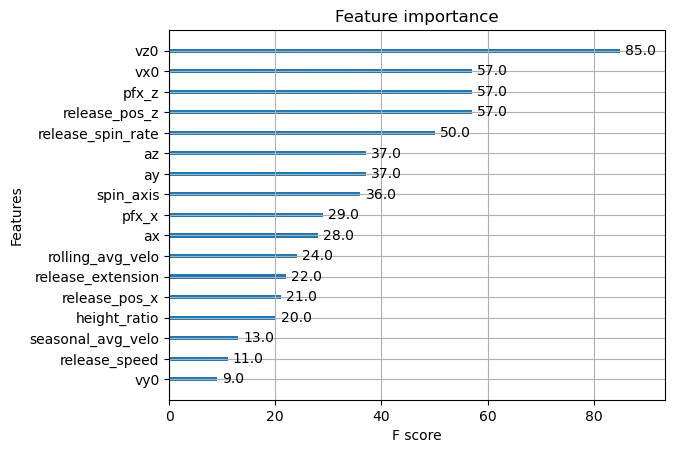

In [13]:
xgb.plot_importance(model)
plt.show()

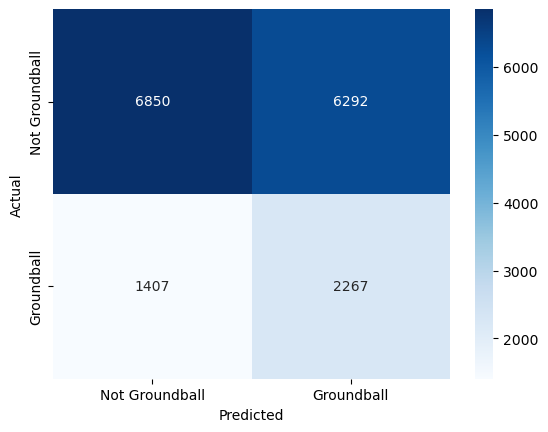

In [14]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [15]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid)
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [16]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 17:04:27,309] A new study created in memory with name: no-name-f9f46f05-a69c-46c2-9188-bd3ab331e3c3


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68732
[3]	eval-logloss:0.68671


[4]	eval-logloss:0.68604
[5]	eval-logloss:0.68457
[6]	eval-logloss:0.68384
[7]	eval-logloss:0.68293
[8]	eval-logloss:0.68253
[9]	eval-logloss:0.68223
[10]	eval-logloss:0.68148
[11]	eval-logloss:0.68165
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68088
[14]	eval-logloss:0.68033
[15]	eval-logloss:0.68032
[16]	eval-logloss:0.67976
[17]	eval-logloss:0.67995
[18]	eval-logloss:0.68014
[19]	eval-logloss:0.67907
[20]	eval-logloss:0.67894
[21]	eval-logloss:0.67877
[22]	eval-logloss:0.67910
[23]	eval-logloss:0.67911
[24]	eval-logloss:0.67896
[25]	eval-logloss:0.67856
[26]	eval-logloss:0.67819
[27]	eval-logloss:0.67829
[28]	eval-logloss:0.67818
[29]	eval-logloss:0.67813
[30]	eval-logloss:0.67802
[31]	eval-logloss:0.67760
[32]	eval-logloss:0.67698
[33]	eval-logloss:0.67765
[34]	eval-logloss:0.67833
[35]	eval-logloss:0.67767
[36]	eval-logloss:0.67780
[37]	eval-logloss:0.67773
[38]	eval-logloss:0.67764
[39]	eval-logloss:0.67760
[40]	eval-logloss:0.67737
[41]	eval-logloss:0.67724
[42]	eval-logloss:

[I 2023-11-14 17:04:29,169] Trial 0 finished with value: 0.6728230196743217 and parameters: {'max_depth': 4, 'eta': 0.16822152209886906, 'subsample': 0.7443803018235566, 'colsample_bytree': 0.6323177197680094}. Best is trial 0 with value: 0.6728230196743217.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.68707
[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68422
[4]	eval-logloss:0.68310
[5]	eval-logloss:0.68156
[6]	eval-logloss:0.68043
[7]	eval-logloss:0.67929
[8]	eval-logloss:0.67851
[9]	eval-logloss:0.67805
[10]	eval-logloss:0.67709
[11]	eval-logloss:0.67684
[12]	eval-logloss:0.67620
[13]	eval-logloss:0.67570
[14]	eval-logloss:0.67511
[15]	eval-logloss:0.67471
[16]	eval-logloss:0.67438
[17]	eval-logloss:0.67412
[18]	eval-logloss:0.67404
[19]	eval-logloss:0.67332
[20]	eval-logloss:0.67311
[21]	eval-logloss:0.67275
[22]	eval-logloss:0.67277
[23]	eval-logloss:0.67247
[24]	eval-logloss:0.67202
[25]	eval-logloss:0.67175
[26]	eval-logloss:0.67136
[27]	eval-logloss:0.67128
[28]	eval-logloss:0.67123
[29]	eval-logloss:0.67112
[30]	eval-logloss:0.67087
[31]	eval-logloss:0.67041
[32]	eval-logloss:0.66985
[33]	eval-logloss:0.67012
[34]	eval-logloss:0.67032
[35]	eval-logloss:0.66953
[36]	eval-logloss:0.66945
[37]	eval-logloss:0.66948
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:31,705] Trial 1 finished with value: 0.6576951764617295 and parameters: {'max_depth': 6, 'eta': 0.12714703482011036, 'subsample': 0.7296186983948947, 'colsample_bytree': 0.9941149101919655}. Best is trial 1 with value: 0.6576951764617295.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.68901
[2]	eval-logloss:0.68867
[3]	eval-logloss:0.68812
[4]	eval-logloss:0.68665
[5]	eval-logloss:0.68549
[6]	eval-logloss:0.68511
[7]	eval-logloss:0.68429
[8]	eval-logloss:0.68327
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68300
[11]	eval-logloss:0.68288
[12]	eval-logloss:0.68245
[13]	eval-logloss:0.68215
[14]	eval-logloss:0.68172
[15]	eval-logloss:0.68143
[16]	eval-logloss:0.68085
[17]	eval-logloss:0.68089
[18]	eval-logloss:0.68079
[19]	eval-logloss:0.68036
[20]	eval-logloss:0.68003
[21]	eval-logloss:0.67984
[22]	eval-logloss:0.67983
[23]	eval-logloss:0.67963
[24]	eval-logloss:0.67945
[25]	eval-logloss:0.67939
[26]	eval-logloss:0.67925
[27]	eval-logloss:0.67920
[28]	eval-logloss:0.67888
[29]	eval-logloss:0.67911
[30]	eval-logloss:0.67878
[31]	eval-logloss:0.67830
[32]	eval-logloss:0.67800
[33]	eval-logloss:0.67816
[34]	eval-logloss:0.67847
[35]	eval-logloss:0.67785
[36]	eval-logloss:0.67787
[37]	eval-logloss:0.67800
[38]	eval-logloss:0.67

[I 2023-11-14 17:04:33,436] Trial 2 finished with value: 0.6726945345644735 and parameters: {'max_depth': 4, 'eta': 0.1829101510102079, 'subsample': 0.8857918882808473, 'colsample_bytree': 0.5447201692247593}. Best is trial 1 with value: 0.6576951764617295.


[0]	eval-logloss:0.68849
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68468
[3]	eval-logloss:0.68377
[4]	eval-logloss:0.68243
[5]	eval-logloss:0.68166
[6]	eval-logloss:0.68013
[7]	eval-logloss:0.67960
[8]	eval-logloss:0.67884
[9]	eval-logloss:0.67842
[10]	eval-logloss:0.67818
[11]	eval-logloss:0.67795
[12]	eval-logloss:0.67782
[13]	eval-logloss:0.67766
[14]	eval-logloss:0.67724
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67710
[17]	eval-logloss:0.67727
[18]	eval-logloss:0.67722
[19]	eval-logloss:0.67638
[20]	eval-logloss:0.67635
[21]	eval-logloss:0.67621
[22]	eval-logloss:0.67605
[23]	eval-logloss:0.67582
[24]	eval-logloss:0.67526
[25]	eval-logloss:0.67480
[26]	eval-logloss:0.67468
[27]	eval-logloss:0.67497
[28]	eval-logloss:0.67489
[29]	eval-logloss:0.67525
[30]	eval-logloss:0.67476
[31]	eval-logloss:0.67399
[32]	eval-logloss:0.67356
[33]	eval-logloss:0.67391
[34]	eval-logloss:0.67437
[35]	eval-logloss:0.67358
[36]	eval-logloss:0.67363
[37]	eval-logloss:0.67360
[38]	eval-logloss:0.67

[I 2023-11-14 17:04:35,334] Trial 3 finished with value: 0.6648108087321216 and parameters: {'max_depth': 5, 'eta': 0.25448706854427017, 'subsample': 0.8981140799655909, 'colsample_bytree': 0.8116888885326429}. Best is trial 1 with value: 0.6576951764617295.


[0]	eval-logloss:0.69183
[1]	eval-logloss:0.69049
[2]	eval-logloss:0.69020
[3]	eval-logloss:0.68979
[4]	eval-logloss:0.68905
[5]	eval-logloss:0.68821
[6]	eval-logloss:0.68769
[7]	eval-logloss:0.68702
[8]	eval-logloss:0.68640
[9]	eval-logloss:0.68631
[10]	eval-logloss:0.68588
[11]	eval-logloss:0.68571
[12]	eval-logloss:0.68540
[13]	eval-logloss:0.68498
[14]	eval-logloss:0.68464
[15]	eval-logloss:0.68455
[16]	eval-logloss:0.68419
[17]	eval-logloss:0.68420
[18]	eval-logloss:0.68419
[19]	eval-logloss:0.68370
[20]	eval-logloss:0.68352
[21]	eval-logloss:0.68317
[22]	eval-logloss:0.68330
[23]	eval-logloss:0.68320
[24]	eval-logloss:0.68310
[25]	eval-logloss:0.68296
[26]	eval-logloss:0.68275
[27]	eval-logloss:0.68273
[28]	eval-logloss:0.68252
[29]	eval-logloss:0.68256
[30]	eval-logloss:0.68243
[31]	eval-logloss:0.68207
[32]	eval-logloss:0.68169
[33]	eval-logloss:0.68187
[34]	eval-logloss:0.68215
[35]	eval-logloss:0.68190
[36]	eval-logloss:0.68193
[37]	eval-logloss:0.68189
[38]	eval-logloss:0.68

[I 2023-11-14 17:04:36,814] Trial 4 finished with value: 0.6787396288296681 and parameters: {'max_depth': 3, 'eta': 0.09658343481180488, 'subsample': 0.8204937159229759, 'colsample_bytree': 0.6676251241679513}. Best is trial 1 with value: 0.6576951764617295.


[0]	eval-logloss:0.68912
[1]	eval-logloss:0.68544
[2]	eval-logloss:0.68311
[3]	eval-logloss:0.68150
[4]	eval-logloss:0.67976
[5]	eval-logloss:0.67861
[6]	eval-logloss:0.67714
[7]	eval-logloss:0.67565
[8]	eval-logloss:0.67450
[9]	eval-logloss:0.67392
[10]	eval-logloss:0.67337
[11]	eval-logloss:0.67260
[12]	eval-logloss:0.67151
[13]	eval-logloss:0.67095
[14]	eval-logloss:0.67027
[15]	eval-logloss:0.66983
[16]	eval-logloss:0.66895
[17]	eval-logloss:0.66900
[18]	eval-logloss:0.66855
[19]	eval-logloss:0.66796
[20]	eval-logloss:0.66766
[21]	eval-logloss:0.66728
[22]	eval-logloss:0.66693
[23]	eval-logloss:0.66662
[24]	eval-logloss:0.66605
[25]	eval-logloss:0.66523
[26]	eval-logloss:0.66474
[27]	eval-logloss:0.66465
[28]	eval-logloss:0.66468
[29]	eval-logloss:0.66461
[30]	eval-logloss:0.66410
[31]	eval-logloss:0.66339
[32]	eval-logloss:0.66258
[33]	eval-logloss:0.66256
[34]	eval-logloss:0.66231
[35]	eval-logloss:0.66145
[36]	eval-logloss:0.66125
[37]	eval-logloss:0.66151
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:39,071] Trial 5 finished with value: 0.6457037680185614 and parameters: {'max_depth': 7, 'eta': 0.15135996192071516, 'subsample': 0.8693448746546593, 'colsample_bytree': 0.9864880166595491}. Best is trial 5 with value: 0.6457037680185614.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68733
[2]	eval-logloss:0.68611
[3]	eval-logloss:0.68524
[4]	eval-logloss:0.68413
[5]	eval-logloss:0.68285
[6]	eval-logloss:0.68226
[7]	eval-logloss:0.68160
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68137
[10]	eval-logloss:0.68038
[11]	eval-logloss:0.68058
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.67987
[14]	eval-logloss:0.67964
[15]	eval-logloss:0.67974
[16]	eval-logloss:0.67941
[17]	eval-logloss:0.67929
[18]	eval-logloss:0.67929
[19]	eval-logloss:0.67832
[20]	eval-logloss:0.67759
[21]	eval-logloss:0.67756
[22]	eval-logloss:0.67790
[23]	eval-logloss:0.67781
[24]	eval-logloss:0.67759
[25]	eval-logloss:0.67733
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67678
[28]	eval-logloss:0.67717
[29]	eval-logloss:0.67712
[30]	eval-logloss:0.67690
[31]	eval-logloss:0.67611
[32]	eval-logloss:0.67541
[33]	eval-logloss:0.67578
[34]	eval-logloss:0.67623
[35]	eval-logloss:0.67544
[36]	eval-logloss:0.67579
[37]	eval-logloss:0.67607
[38]	eval-logloss:0.67

[I 2023-11-14 17:04:40,667] Trial 6 finished with value: 0.669447775561947 and parameters: {'max_depth': 4, 'eta': 0.1892781930987492, 'subsample': 0.6867494363713742, 'colsample_bytree': 0.885869013207282}. Best is trial 5 with value: 0.6457037680185614.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.68817
[2]	eval-logloss:0.68808
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68456
[6]	eval-logloss:0.68360
[7]	eval-logloss:0.68277
[8]	eval-logloss:0.68198
[9]	eval-logloss:0.68218
[10]	eval-logloss:0.68141
[11]	eval-logloss:0.68160
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68037
[15]	eval-logloss:0.68030
[16]	eval-logloss:0.68001
[17]	eval-logloss:0.68015
[18]	eval-logloss:0.68014
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67835
[21]	eval-logloss:0.67842
[22]	eval-logloss:0.67883
[23]	eval-logloss:0.67915
[24]	eval-logloss:0.67903
[25]	eval-logloss:0.67843
[26]	eval-logloss:0.67791
[27]	eval-logloss:0.67814
[28]	eval-logloss:0.67827
[29]	eval-logloss:0.67823
[30]	eval-logloss:0.67790
[31]	eval-logloss:0.67711
[32]	eval-logloss:0.67608
[33]	eval-logloss:0.67663
[34]	eval-logloss:0.67754
[35]	eval-logloss:0.67693
[36]	eval-logloss:0.67702
[37]	eval-logloss:0.67714
[38]	eval-logloss:0.67

[I 2023-11-14 17:04:42,215] Trial 7 finished with value: 0.671156481268678 and parameters: {'max_depth': 4, 'eta': 0.2201625257147594, 'subsample': 0.7714105262649635, 'colsample_bytree': 0.5207783725443171}. Best is trial 5 with value: 0.6457037680185614.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68579
[2]	eval-logloss:0.68475
[3]	eval-logloss:0.68337
[4]	eval-logloss:0.68158
[5]	eval-logloss:0.68014
[6]	eval-logloss:0.67923
[7]	eval-logloss:0.67800
[8]	eval-logloss:0.67668
[9]	eval-logloss:0.67570
[10]	eval-logloss:0.67490
[11]	eval-logloss:0.67420
[12]	eval-logloss:0.67367
[13]	eval-logloss:0.67285
[14]	eval-logloss:0.67194
[15]	eval-logloss:0.67114
[16]	eval-logloss:0.67032
[17]	eval-logloss:0.66964
[18]	eval-logloss:0.66922
[19]	eval-logloss:0.66805
[20]	eval-logloss:0.66753
[21]	eval-logloss:0.66718
[22]	eval-logloss:0.66691
[23]	eval-logloss:0.66648
[24]	eval-logloss:0.66614
[25]	eval-logloss:0.66532
[26]	eval-logloss:0.66505
[27]	eval-logloss:0.66495
[28]	eval-logloss:0.66446
[29]	eval-logloss:0.66432
[30]	eval-logloss:0.66391
[31]	eval-logloss:0.66282
[32]	eval-logloss:0.66202
[33]	eval-logloss:0.66172
[34]	eval-logloss:0.66165
[35]	eval-logloss:0.66110
[36]	eval-logloss:0.66093
[37]	eval-logloss:0.66100
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:44,654] Trial 8 finished with value: 0.6428222228169416 and parameters: {'max_depth': 7, 'eta': 0.13149638105346856, 'subsample': 0.8599216843077122, 'colsample_bytree': 0.6578151967287913}. Best is trial 8 with value: 0.6428222228169416.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67952
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67513
[4]	eval-logloss:0.67377
[5]	eval-logloss:0.67157
[6]	eval-logloss:0.67087
[7]	eval-logloss:0.66935
[8]	eval-logloss:0.66920
[9]	eval-logloss:0.66962
[10]	eval-logloss:0.66875
[11]	eval-logloss:0.66935
[12]	eval-logloss:0.66938
[13]	eval-logloss:0.66927
[14]	eval-logloss:0.66827
[15]	eval-logloss:0.66715
[16]	eval-logloss:0.66583
[17]	eval-logloss:0.66616
[18]	eval-logloss:0.66558
[19]	eval-logloss:0.66401
[20]	eval-logloss:0.66354
[21]	eval-logloss:0.66374
[22]	eval-logloss:0.66408
[23]	eval-logloss:0.66345
[24]	eval-logloss:0.66294
[25]	eval-logloss:0.66282
[26]	eval-logloss:0.66192
[27]	eval-logloss:0.66257
[28]	eval-logloss:0.66251
[29]	eval-logloss:0.66230
[30]	eval-logloss:0.66177
[31]	eval-logloss:0.66048
[32]	eval-logloss:0.65979
[33]	eval-logloss:0.66067
[34]	eval-logloss:0.66028
[35]	eval-logloss:0.65870
[36]	eval-logloss:0.65857
[37]	eval-logloss:0.65872
[38]	eval-logloss:0.65

[I 2023-11-14 17:04:47,296] Trial 9 finished with value: 0.6479034573707015 and parameters: {'max_depth': 8, 'eta': 0.2909476470676666, 'subsample': 0.6972195357071956, 'colsample_bytree': 0.6804669284992753}. Best is trial 8 with value: 0.6428222228169416.


[0]	eval-logloss:0.69187
[1]	eval-logloss:0.69061
[2]	eval-logloss:0.68986
[3]	eval-logloss:0.68899
[4]	eval-logloss:0.68794
[5]	eval-logloss:0.68663
[6]	eval-logloss:0.68594
[7]	eval-logloss:0.68488
[8]	eval-logloss:0.68395
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68231
[11]	eval-logloss:0.68168
[12]	eval-logloss:0.68101
[13]	eval-logloss:0.68011
[14]	eval-logloss:0.67947
[15]	eval-logloss:0.67890
[16]	eval-logloss:0.67795
[17]	eval-logloss:0.67720
[18]	eval-logloss:0.67645
[19]	eval-logloss:0.67560
[20]	eval-logloss:0.67494
[21]	eval-logloss:0.67423
[22]	eval-logloss:0.67393
[23]	eval-logloss:0.67319
[24]	eval-logloss:0.67275
[25]	eval-logloss:0.67250
[26]	eval-logloss:0.67180
[27]	eval-logloss:0.67130
[28]	eval-logloss:0.67063
[29]	eval-logloss:0.67009
[30]	eval-logloss:0.66981
[31]	eval-logloss:0.66924
[32]	eval-logloss:0.66864
[33]	eval-logloss:0.66820
[34]	eval-logloss:0.66790
[35]	eval-logloss:0.66744
[36]	eval-logloss:0.66693
[37]	eval-logloss:0.66661
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:52,082] Trial 10 finished with value: 0.6502893778250304 and parameters: {'max_depth': 9, 'eta': 0.025297739275962086, 'subsample': 0.615392643084786, 'colsample_bytree': 0.7747271872774948}. Best is trial 8 with value: 0.6428222228169416.


[0]	eval-logloss:0.68992
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68482
[3]	eval-logloss:0.68342
[4]	eval-logloss:0.68165
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67882
[7]	eval-logloss:0.67770
[8]	eval-logloss:0.67661
[9]	eval-logloss:0.67598
[10]	eval-logloss:0.67534
[11]	eval-logloss:0.67433
[12]	eval-logloss:0.67373
[13]	eval-logloss:0.67310
[14]	eval-logloss:0.67227
[15]	eval-logloss:0.67184
[16]	eval-logloss:0.67121
[17]	eval-logloss:0.67106
[18]	eval-logloss:0.67067
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66930
[21]	eval-logloss:0.66895
[22]	eval-logloss:0.66884
[23]	eval-logloss:0.66829
[24]	eval-logloss:0.66778
[25]	eval-logloss:0.66722
[26]	eval-logloss:0.66655
[27]	eval-logloss:0.66624
[28]	eval-logloss:0.66617
[29]	eval-logloss:0.66630
[30]	eval-logloss:0.66612
[31]	eval-logloss:0.66585
[32]	eval-logloss:0.66521
[33]	eval-logloss:0.66528
[34]	eval-logloss:0.66528
[35]	eval-logloss:0.66482
[36]	eval-logloss:0.66466
[37]	eval-logloss:0.66436
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:55,130] Trial 11 finished with value: 0.6490852111452314 and parameters: {'max_depth': 7, 'eta': 0.1147848133823209, 'subsample': 0.8355719439078297, 'colsample_bytree': 0.9481054797248839}. Best is trial 8 with value: 0.6428222228169416.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68678
[3]	eval-logloss:0.68560
[4]	eval-logloss:0.68379
[5]	eval-logloss:0.68243
[6]	eval-logloss:0.68094
[7]	eval-logloss:0.67992
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67825
[10]	eval-logloss:0.67732
[11]	eval-logloss:0.67639
[12]	eval-logloss:0.67557
[13]	eval-logloss:0.67480
[14]	eval-logloss:0.67391
[15]	eval-logloss:0.67341
[16]	eval-logloss:0.67270
[17]	eval-logloss:0.67212
[18]	eval-logloss:0.67193
[19]	eval-logloss:0.67128
[20]	eval-logloss:0.67064
[21]	eval-logloss:0.67021
[22]	eval-logloss:0.66984
[23]	eval-logloss:0.66963
[24]	eval-logloss:0.66952
[25]	eval-logloss:0.66903
[26]	eval-logloss:0.66858
[27]	eval-logloss:0.66838
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66797
[30]	eval-logloss:0.66768
[31]	eval-logloss:0.66729
[32]	eval-logloss:0.66667
[33]	eval-logloss:0.66662
[34]	eval-logloss:0.66655
[35]	eval-logloss:0.66608
[36]	eval-logloss:0.66613
[37]	eval-logloss:0.66588
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:57,858] Trial 12 finished with value: 0.6525571121313055 and parameters: {'max_depth': 7, 'eta': 0.08830322416193286, 'subsample': 0.8451448534664474, 'colsample_bytree': 0.8522783402238396}. Best is trial 8 with value: 0.6428222228169416.


[0]	eval-logloss:0.68939
[1]	eval-logloss:0.68566
[2]	eval-logloss:0.68427
[3]	eval-logloss:0.68299
[4]	eval-logloss:0.68101
[5]	eval-logloss:0.67874
[6]	eval-logloss:0.67739
[7]	eval-logloss:0.67574
[8]	eval-logloss:0.67447
[9]	eval-logloss:0.67388
[10]	eval-logloss:0.67330
[11]	eval-logloss:0.67288
[12]	eval-logloss:0.67221
[13]	eval-logloss:0.67150
[14]	eval-logloss:0.67061
[15]	eval-logloss:0.67028
[16]	eval-logloss:0.66984
[17]	eval-logloss:0.66950
[18]	eval-logloss:0.66908
[19]	eval-logloss:0.66836
[20]	eval-logloss:0.66775
[21]	eval-logloss:0.66721
[22]	eval-logloss:0.66728
[23]	eval-logloss:0.66688
[24]	eval-logloss:0.66630
[25]	eval-logloss:0.66588
[26]	eval-logloss:0.66532
[27]	eval-logloss:0.66499
[28]	eval-logloss:0.66461
[29]	eval-logloss:0.66472
[30]	eval-logloss:0.66448
[31]	eval-logloss:0.66374
[32]	eval-logloss:0.66311
[33]	eval-logloss:0.66317
[34]	eval-logloss:0.66310
[35]	eval-logloss:0.66270
[36]	eval-logloss:0.66225
[37]	eval-logloss:0.66225
[38]	eval-logloss:0.66

[I 2023-11-14 17:04:59,928] Trial 13 finished with value: 0.6465116735273702 and parameters: {'max_depth': 7, 'eta': 0.1437923574092056, 'subsample': 0.8073663496486263, 'colsample_bytree': 0.7515029371960911}. Best is trial 8 with value: 0.6428222228169416.


[0]	eval-logloss:0.69063
[1]	eval-logloss:0.68841
[2]	eval-logloss:0.68695
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68168
[6]	eval-logloss:0.67995
[7]	eval-logloss:0.67824
[8]	eval-logloss:0.67687
[9]	eval-logloss:0.67557
[10]	eval-logloss:0.67444
[11]	eval-logloss:0.67322
[12]	eval-logloss:0.67199
[13]	eval-logloss:0.67082
[14]	eval-logloss:0.66959
[15]	eval-logloss:0.66870
[16]	eval-logloss:0.66777
[17]	eval-logloss:0.66687
[18]	eval-logloss:0.66611
[19]	eval-logloss:0.66544
[20]	eval-logloss:0.66470
[21]	eval-logloss:0.66383
[22]	eval-logloss:0.66338
[23]	eval-logloss:0.66288
[24]	eval-logloss:0.66219
[25]	eval-logloss:0.66175
[26]	eval-logloss:0.66098
[27]	eval-logloss:0.66058
[28]	eval-logloss:0.66018
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.65930
[31]	eval-logloss:0.65874
[32]	eval-logloss:0.65822
[33]	eval-logloss:0.65745
[34]	eval-logloss:0.65712
[35]	eval-logloss:0.65633
[36]	eval-logloss:0.65607
[37]	eval-logloss:0.65574
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:03,044] Trial 14 finished with value: 0.6390713394252365 and parameters: {'max_depth': 9, 'eta': 0.0565766383929175, 'subsample': 0.8600054863903327, 'colsample_bytree': 0.913525602340206}. Best is trial 14 with value: 0.6390713394252365.


[0]	eval-logloss:0.69049
[1]	eval-logloss:0.68808
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68522
[4]	eval-logloss:0.68287
[5]	eval-logloss:0.68122
[6]	eval-logloss:0.67949
[7]	eval-logloss:0.67775
[8]	eval-logloss:0.67626
[9]	eval-logloss:0.67496
[10]	eval-logloss:0.67366
[11]	eval-logloss:0.67233
[12]	eval-logloss:0.67097
[13]	eval-logloss:0.66992
[14]	eval-logloss:0.66845
[15]	eval-logloss:0.66784
[16]	eval-logloss:0.66670
[17]	eval-logloss:0.66598
[18]	eval-logloss:0.66511
[19]	eval-logloss:0.66428
[20]	eval-logloss:0.66350
[21]	eval-logloss:0.66285
[22]	eval-logloss:0.66236
[23]	eval-logloss:0.66166
[24]	eval-logloss:0.66099
[25]	eval-logloss:0.66038
[26]	eval-logloss:0.65972
[27]	eval-logloss:0.65915
[28]	eval-logloss:0.65861
[29]	eval-logloss:0.65809
[30]	eval-logloss:0.65753
[31]	eval-logloss:0.65694
[32]	eval-logloss:0.65624
[33]	eval-logloss:0.65587
[34]	eval-logloss:0.65551
[35]	eval-logloss:0.65486
[36]	eval-logloss:0.65461
[37]	eval-logloss:0.65434
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:06,655] Trial 15 finished with value: 0.6369357643734124 and parameters: {'max_depth': 9, 'eta': 0.06056638468666316, 'subsample': 0.8613129252567504, 'colsample_bytree': 0.8951888628969767}. Best is trial 15 with value: 0.6369357643734124.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69000
[2]	eval-logloss:0.68916
[3]	eval-logloss:0.68821
[4]	eval-logloss:0.68681
[5]	eval-logloss:0.68567
[6]	eval-logloss:0.68448
[7]	eval-logloss:0.68322
[8]	eval-logloss:0.68205
[9]	eval-logloss:0.68139
[10]	eval-logloss:0.68037
[11]	eval-logloss:0.67942
[12]	eval-logloss:0.67842
[13]	eval-logloss:0.67757
[14]	eval-logloss:0.67667
[15]	eval-logloss:0.67624
[16]	eval-logloss:0.67550
[17]	eval-logloss:0.67477
[18]	eval-logloss:0.67409
[19]	eval-logloss:0.67323
[20]	eval-logloss:0.67250
[21]	eval-logloss:0.67166
[22]	eval-logloss:0.67111
[23]	eval-logloss:0.67048
[24]	eval-logloss:0.66990
[25]	eval-logloss:0.66942
[26]	eval-logloss:0.66897
[27]	eval-logloss:0.66840
[28]	eval-logloss:0.66787
[29]	eval-logloss:0.66739
[30]	eval-logloss:0.66695
[31]	eval-logloss:0.66617
[32]	eval-logloss:0.66553
[33]	eval-logloss:0.66498
[34]	eval-logloss:0.66461
[35]	eval-logloss:0.66416
[36]	eval-logloss:0.66367
[37]	eval-logloss:0.66328
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:10,105] Trial 16 finished with value: 0.6474093971942997 and parameters: {'max_depth': 9, 'eta': 0.03404725835684808, 'subsample': 0.899741246979794, 'colsample_bytree': 0.8914828763312266}. Best is trial 15 with value: 0.6369357643734124.


[0]	eval-logloss:0.69057
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68664
[3]	eval-logloss:0.68511
[4]	eval-logloss:0.68302
[5]	eval-logloss:0.68114
[6]	eval-logloss:0.67921
[7]	eval-logloss:0.67752
[8]	eval-logloss:0.67607
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67329
[11]	eval-logloss:0.67216
[12]	eval-logloss:0.67062
[13]	eval-logloss:0.66943
[14]	eval-logloss:0.66815
[15]	eval-logloss:0.66748
[16]	eval-logloss:0.66662
[17]	eval-logloss:0.66604
[18]	eval-logloss:0.66504
[19]	eval-logloss:0.66398
[20]	eval-logloss:0.66310
[21]	eval-logloss:0.66224
[22]	eval-logloss:0.66181
[23]	eval-logloss:0.66106
[24]	eval-logloss:0.66049
[25]	eval-logloss:0.66007
[26]	eval-logloss:0.65924
[27]	eval-logloss:0.65880
[28]	eval-logloss:0.65850
[29]	eval-logloss:0.65787
[30]	eval-logloss:0.65745
[31]	eval-logloss:0.65686
[32]	eval-logloss:0.65592
[33]	eval-logloss:0.65549
[34]	eval-logloss:0.65531
[35]	eval-logloss:0.65437
[36]	eval-logloss:0.65413
[37]	eval-logloss:0.65385
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:13,002] Trial 17 finished with value: 0.6356620499432457 and parameters: {'max_depth': 9, 'eta': 0.05745208699399233, 'subsample': 0.7963337564014206, 'colsample_bytree': 0.913450798081914}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.69277
[1]	eval-logloss:0.69232
[2]	eval-logloss:0.69208
[3]	eval-logloss:0.69180
[4]	eval-logloss:0.69138
[5]	eval-logloss:0.69101
[6]	eval-logloss:0.69062
[7]	eval-logloss:0.69026
[8]	eval-logloss:0.68993
[9]	eval-logloss:0.68973
[10]	eval-logloss:0.68930
[11]	eval-logloss:0.68900
[12]	eval-logloss:0.68859
[13]	eval-logloss:0.68825
[14]	eval-logloss:0.68784
[15]	eval-logloss:0.68762
[16]	eval-logloss:0.68728
[17]	eval-logloss:0.68698
[18]	eval-logloss:0.68667
[19]	eval-logloss:0.68627
[20]	eval-logloss:0.68596
[21]	eval-logloss:0.68565
[22]	eval-logloss:0.68548
[23]	eval-logloss:0.68514
[24]	eval-logloss:0.68488
[25]	eval-logloss:0.68467
[26]	eval-logloss:0.68439
[27]	eval-logloss:0.68409
[28]	eval-logloss:0.68384
[29]	eval-logloss:0.68358
[30]	eval-logloss:0.68342
[31]	eval-logloss:0.68311
[32]	eval-logloss:0.68279
[33]	eval-logloss:0.68258
[34]	eval-logloss:0.68247
[35]	eval-logloss:0.68217
[36]	eval-logloss:0.68190
[37]	eval-logloss:0.68166
[38]	eval-logloss:0.68

[I 2023-11-14 17:05:16,541] Trial 18 finished with value: 0.6707963069154822 and parameters: {'max_depth': 8, 'eta': 0.010467154101635678, 'subsample': 0.792584895295495, 'colsample_bytree': 0.8523275909875259}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.69079
[1]	eval-logloss:0.68851
[2]	eval-logloss:0.68724
[3]	eval-logloss:0.68588
[4]	eval-logloss:0.68396
[5]	eval-logloss:0.68230
[6]	eval-logloss:0.68067
[7]	eval-logloss:0.67925
[8]	eval-logloss:0.67810
[9]	eval-logloss:0.67689
[10]	eval-logloss:0.67558
[11]	eval-logloss:0.67459
[12]	eval-logloss:0.67325
[13]	eval-logloss:0.67243
[14]	eval-logloss:0.67140
[15]	eval-logloss:0.67083
[16]	eval-logloss:0.67016
[17]	eval-logloss:0.66973
[18]	eval-logloss:0.66905
[19]	eval-logloss:0.66806
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66708
[22]	eval-logloss:0.66690
[23]	eval-logloss:0.66635
[24]	eval-logloss:0.66601
[25]	eval-logloss:0.66576
[26]	eval-logloss:0.66514
[27]	eval-logloss:0.66485
[28]	eval-logloss:0.66442
[29]	eval-logloss:0.66416
[30]	eval-logloss:0.66375
[31]	eval-logloss:0.66319
[32]	eval-logloss:0.66258
[33]	eval-logloss:0.66243
[34]	eval-logloss:0.66240
[35]	eval-logloss:0.66201
[36]	eval-logloss:0.66173
[37]	eval-logloss:0.66153
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:21,003] Trial 19 finished with value: 0.6457843710695144 and parameters: {'max_depth': 8, 'eta': 0.06572735083812334, 'subsample': 0.8012420967464515, 'colsample_bytree': 0.9402053841778116}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.69045
[1]	eval-logloss:0.68784
[2]	eval-logloss:0.68630
[3]	eval-logloss:0.68488
[4]	eval-logloss:0.68292
[5]	eval-logloss:0.68116
[6]	eval-logloss:0.67959
[7]	eval-logloss:0.67809
[8]	eval-logloss:0.67676
[9]	eval-logloss:0.67584
[10]	eval-logloss:0.67435
[11]	eval-logloss:0.67305
[12]	eval-logloss:0.67195
[13]	eval-logloss:0.67081
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66842
[16]	eval-logloss:0.66755
[17]	eval-logloss:0.66684
[18]	eval-logloss:0.66584
[19]	eval-logloss:0.66496
[20]	eval-logloss:0.66412
[21]	eval-logloss:0.66318
[22]	eval-logloss:0.66267
[23]	eval-logloss:0.66202
[24]	eval-logloss:0.66127
[25]	eval-logloss:0.66050
[26]	eval-logloss:0.65986
[27]	eval-logloss:0.65942
[28]	eval-logloss:0.65897
[29]	eval-logloss:0.65857
[30]	eval-logloss:0.65817
[31]	eval-logloss:0.65746
[32]	eval-logloss:0.65662
[33]	eval-logloss:0.65631
[34]	eval-logloss:0.65609
[35]	eval-logloss:0.65570
[36]	eval-logloss:0.65544
[37]	eval-logloss:0.65510
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:26,193] Trial 20 finished with value: 0.6371959253863243 and parameters: {'max_depth': 9, 'eta': 0.05645579463109351, 'subsample': 0.8317893925216643, 'colsample_bytree': 0.8263420332244644}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68623
[3]	eval-logloss:0.68468
[4]	eval-logloss:0.68249
[5]	eval-logloss:0.68081
[6]	eval-logloss:0.67883
[7]	eval-logloss:0.67725
[8]	eval-logloss:0.67590
[9]	eval-logloss:0.67488
[10]	eval-logloss:0.67342
[11]	eval-logloss:0.67210
[12]	eval-logloss:0.67127
[13]	eval-logloss:0.67016
[14]	eval-logloss:0.66897
[15]	eval-logloss:0.66800
[16]	eval-logloss:0.66702
[17]	eval-logloss:0.66605
[18]	eval-logloss:0.66514
[19]	eval-logloss:0.66424
[20]	eval-logloss:0.66363
[21]	eval-logloss:0.66277
[22]	eval-logloss:0.66227
[23]	eval-logloss:0.66145
[24]	eval-logloss:0.66075
[25]	eval-logloss:0.66009
[26]	eval-logloss:0.65965
[27]	eval-logloss:0.65912
[28]	eval-logloss:0.65876
[29]	eval-logloss:0.65826
[30]	eval-logloss:0.65786
[31]	eval-logloss:0.65737
[32]	eval-logloss:0.65672
[33]	eval-logloss:0.65633
[34]	eval-logloss:0.65607
[35]	eval-logloss:0.65565
[36]	eval-logloss:0.65529
[37]	eval-logloss:0.65491
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:31,124] Trial 21 finished with value: 0.637075999077785 and parameters: {'max_depth': 9, 'eta': 0.060047781823623705, 'subsample': 0.830456535775159, 'colsample_bytree': 0.8385064032042047}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.69014
[1]	eval-logloss:0.68746
[2]	eval-logloss:0.68607
[3]	eval-logloss:0.68443
[4]	eval-logloss:0.68233
[5]	eval-logloss:0.68048
[6]	eval-logloss:0.67888
[7]	eval-logloss:0.67733
[8]	eval-logloss:0.67621
[9]	eval-logloss:0.67530
[10]	eval-logloss:0.67390
[11]	eval-logloss:0.67281
[12]	eval-logloss:0.67166
[13]	eval-logloss:0.67085
[14]	eval-logloss:0.67003
[15]	eval-logloss:0.66960
[16]	eval-logloss:0.66875
[17]	eval-logloss:0.66785
[18]	eval-logloss:0.66729
[19]	eval-logloss:0.66669
[20]	eval-logloss:0.66619
[21]	eval-logloss:0.66581
[22]	eval-logloss:0.66568
[23]	eval-logloss:0.66549
[24]	eval-logloss:0.66496
[25]	eval-logloss:0.66436
[26]	eval-logloss:0.66392
[27]	eval-logloss:0.66341
[28]	eval-logloss:0.66317
[29]	eval-logloss:0.66306
[30]	eval-logloss:0.66285
[31]	eval-logloss:0.66229
[32]	eval-logloss:0.66164
[33]	eval-logloss:0.66134
[34]	eval-logloss:0.66151
[35]	eval-logloss:0.66097
[36]	eval-logloss:0.66064
[37]	eval-logloss:0.66043
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:35,521] Trial 22 finished with value: 0.6434446962517177 and parameters: {'max_depth': 8, 'eta': 0.08275490187132342, 'subsample': 0.7772238068583458, 'colsample_bytree': 0.8847313899249423}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.69100
[1]	eval-logloss:0.68890
[2]	eval-logloss:0.68776
[3]	eval-logloss:0.68651
[4]	eval-logloss:0.68486
[5]	eval-logloss:0.68330
[6]	eval-logloss:0.68166
[7]	eval-logloss:0.68017
[8]	eval-logloss:0.67893
[9]	eval-logloss:0.67825
[10]	eval-logloss:0.67694
[11]	eval-logloss:0.67576
[12]	eval-logloss:0.67472
[13]	eval-logloss:0.67375
[14]	eval-logloss:0.67254
[15]	eval-logloss:0.67191
[16]	eval-logloss:0.67104
[17]	eval-logloss:0.67030
[18]	eval-logloss:0.66938
[19]	eval-logloss:0.66840
[20]	eval-logloss:0.66761
[21]	eval-logloss:0.66674
[22]	eval-logloss:0.66650
[23]	eval-logloss:0.66568
[24]	eval-logloss:0.66521
[25]	eval-logloss:0.66465
[26]	eval-logloss:0.66390
[27]	eval-logloss:0.66340
[28]	eval-logloss:0.66281
[29]	eval-logloss:0.66225
[30]	eval-logloss:0.66193
[31]	eval-logloss:0.66130
[32]	eval-logloss:0.66069
[33]	eval-logloss:0.66013
[34]	eval-logloss:0.65992
[35]	eval-logloss:0.65955
[36]	eval-logloss:0.65922
[37]	eval-logloss:0.65866
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:41,003] Trial 23 finished with value: 0.6421715676555506 and parameters: {'max_depth': 9, 'eta': 0.04497398488104475, 'subsample': 0.8238470864760414, 'colsample_bytree': 0.8003711974961165}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.69062
[1]	eval-logloss:0.68818
[2]	eval-logloss:0.68675
[3]	eval-logloss:0.68537
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68183
[6]	eval-logloss:0.68022
[7]	eval-logloss:0.67869
[8]	eval-logloss:0.67750
[9]	eval-logloss:0.67656
[10]	eval-logloss:0.67554
[11]	eval-logloss:0.67462
[12]	eval-logloss:0.67361
[13]	eval-logloss:0.67288
[14]	eval-logloss:0.67205
[15]	eval-logloss:0.67139
[16]	eval-logloss:0.67078
[17]	eval-logloss:0.67034
[18]	eval-logloss:0.66990
[19]	eval-logloss:0.66914
[20]	eval-logloss:0.66856
[21]	eval-logloss:0.66793
[22]	eval-logloss:0.66749
[23]	eval-logloss:0.66709
[24]	eval-logloss:0.66649
[25]	eval-logloss:0.66581
[26]	eval-logloss:0.66548
[27]	eval-logloss:0.66522
[28]	eval-logloss:0.66472
[29]	eval-logloss:0.66445
[30]	eval-logloss:0.66417
[31]	eval-logloss:0.66387
[32]	eval-logloss:0.66327
[33]	eval-logloss:0.66261
[34]	eval-logloss:0.66255
[35]	eval-logloss:0.66194
[36]	eval-logloss:0.66183
[37]	eval-logloss:0.66185
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:45,423] Trial 24 finished with value: 0.6464388785496387 and parameters: {'max_depth': 8, 'eta': 0.07369175231885748, 'subsample': 0.854632019705109, 'colsample_bytree': 0.9361536393960941}. Best is trial 17 with value: 0.6356620499432457.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68413
[2]	eval-logloss:0.68211
[3]	eval-logloss:0.67989
[4]	eval-logloss:0.67762
[5]	eval-logloss:0.67521
[6]	eval-logloss:0.67281
[7]	eval-logloss:0.67064
[8]	eval-logloss:0.66930
[9]	eval-logloss:0.66792
[10]	eval-logloss:0.66613
[11]	eval-logloss:0.66451
[12]	eval-logloss:0.66314
[13]	eval-logloss:0.66211
[14]	eval-logloss:0.66080
[15]	eval-logloss:0.65990
[16]	eval-logloss:0.65849
[17]	eval-logloss:0.65810
[18]	eval-logloss:0.65717
[19]	eval-logloss:0.65653
[20]	eval-logloss:0.65595
[21]	eval-logloss:0.65533
[22]	eval-logloss:0.65499
[23]	eval-logloss:0.65437
[24]	eval-logloss:0.65397
[25]	eval-logloss:0.65339
[26]	eval-logloss:0.65265
[27]	eval-logloss:0.65205
[28]	eval-logloss:0.65137
[29]	eval-logloss:0.65094
[30]	eval-logloss:0.65073
[31]	eval-logloss:0.65008
[32]	eval-logloss:0.64947
[33]	eval-logloss:0.64945
[34]	eval-logloss:0.64941
[35]	eval-logloss:0.64903
[36]	eval-logloss:0.64888
[37]	eval-logloss:0.64854
[38]	eval-logloss:0.64

[I 2023-11-14 17:05:50,873] Trial 25 finished with value: 0.6245822585947352 and parameters: {'max_depth': 9, 'eta': 0.10119757966879606, 'subsample': 0.820998882039299, 'colsample_bytree': 0.8869128944182936}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68813
[2]	eval-logloss:0.68666
[3]	eval-logloss:0.68550
[4]	eval-logloss:0.68436
[5]	eval-logloss:0.68286
[6]	eval-logloss:0.68139
[7]	eval-logloss:0.68064
[8]	eval-logloss:0.67964
[9]	eval-logloss:0.67902
[10]	eval-logloss:0.67817
[11]	eval-logloss:0.67776
[12]	eval-logloss:0.67692
[13]	eval-logloss:0.67648
[14]	eval-logloss:0.67593
[15]	eval-logloss:0.67554
[16]	eval-logloss:0.67518
[17]	eval-logloss:0.67512
[18]	eval-logloss:0.67478
[19]	eval-logloss:0.67402
[20]	eval-logloss:0.67338
[21]	eval-logloss:0.67322
[22]	eval-logloss:0.67325
[23]	eval-logloss:0.67302
[24]	eval-logloss:0.67284
[25]	eval-logloss:0.67226
[26]	eval-logloss:0.67188
[27]	eval-logloss:0.67173
[28]	eval-logloss:0.67164
[29]	eval-logloss:0.67171
[30]	eval-logloss:0.67163
[31]	eval-logloss:0.67120
[32]	eval-logloss:0.67049
[33]	eval-logloss:0.67064
[34]	eval-logloss:0.67080
[35]	eval-logloss:0.67060
[36]	eval-logloss:0.67054
[37]	eval-logloss:0.67020
[38]	eval-logloss:0.66

[I 2023-11-14 17:05:54,327] Trial 26 finished with value: 0.6594241718169981 and parameters: {'max_depth': 6, 'eta': 0.10611324116968507, 'subsample': 0.7855457735563205, 'colsample_bytree': 0.9613172254211952}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.68982
[1]	eval-logloss:0.68648
[2]	eval-logloss:0.68478
[3]	eval-logloss:0.68296
[4]	eval-logloss:0.68091
[5]	eval-logloss:0.67894
[6]	eval-logloss:0.67679
[7]	eval-logloss:0.67519
[8]	eval-logloss:0.67398
[9]	eval-logloss:0.67298
[10]	eval-logloss:0.67129
[11]	eval-logloss:0.67048
[12]	eval-logloss:0.66906
[13]	eval-logloss:0.66818
[14]	eval-logloss:0.66727
[15]	eval-logloss:0.66696
[16]	eval-logloss:0.66646
[17]	eval-logloss:0.66602
[18]	eval-logloss:0.66524
[19]	eval-logloss:0.66416
[20]	eval-logloss:0.66343
[21]	eval-logloss:0.66291
[22]	eval-logloss:0.66264
[23]	eval-logloss:0.66210
[24]	eval-logloss:0.66156
[25]	eval-logloss:0.66122
[26]	eval-logloss:0.66061
[27]	eval-logloss:0.66023
[28]	eval-logloss:0.66004
[29]	eval-logloss:0.65982
[30]	eval-logloss:0.65954
[31]	eval-logloss:0.65916
[32]	eval-logloss:0.65861
[33]	eval-logloss:0.65849
[34]	eval-logloss:0.65829
[35]	eval-logloss:0.65760
[36]	eval-logloss:0.65719
[37]	eval-logloss:0.65672
[38]	eval-logloss:0.65

[I 2023-11-14 17:05:59,028] Trial 27 finished with value: 0.6380353381376852 and parameters: {'max_depth': 8, 'eta': 0.09627430387252917, 'subsample': 0.8013213642384271, 'colsample_bytree': 0.9125577404541821}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68659
[2]	eval-logloss:0.68458
[3]	eval-logloss:0.68278
[4]	eval-logloss:0.68027
[5]	eval-logloss:0.67844
[6]	eval-logloss:0.67657
[7]	eval-logloss:0.67475
[8]	eval-logloss:0.67310
[9]	eval-logloss:0.67188
[10]	eval-logloss:0.67037
[11]	eval-logloss:0.66899
[12]	eval-logloss:0.66762
[13]	eval-logloss:0.66664
[14]	eval-logloss:0.66581
[15]	eval-logloss:0.66501
[16]	eval-logloss:0.66401
[17]	eval-logloss:0.66324
[18]	eval-logloss:0.66225
[19]	eval-logloss:0.66149
[20]	eval-logloss:0.66078
[21]	eval-logloss:0.65979
[22]	eval-logloss:0.65921
[23]	eval-logloss:0.65874
[24]	eval-logloss:0.65805
[25]	eval-logloss:0.65729
[26]	eval-logloss:0.65645
[27]	eval-logloss:0.65583
[28]	eval-logloss:0.65523
[29]	eval-logloss:0.65487
[30]	eval-logloss:0.65438
[31]	eval-logloss:0.65378
[32]	eval-logloss:0.65305
[33]	eval-logloss:0.65253
[34]	eval-logloss:0.65205
[35]	eval-logloss:0.65157
[36]	eval-logloss:0.65158
[37]	eval-logloss:0.65147
[38]	eval-logloss:0.65

[I 2023-11-14 17:06:04,121] Trial 28 finished with value: 0.6298912194413108 and parameters: {'max_depth': 9, 'eta': 0.08009089545903243, 'subsample': 0.8681408945803597, 'colsample_bytree': 0.8641790418217591}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68820
[2]	eval-logloss:0.68745
[3]	eval-logloss:0.68644
[4]	eval-logloss:0.68485
[5]	eval-logloss:0.68369
[6]	eval-logloss:0.68239
[7]	eval-logloss:0.68144
[8]	eval-logloss:0.68059
[9]	eval-logloss:0.68007
[10]	eval-logloss:0.67929
[11]	eval-logloss:0.67851
[12]	eval-logloss:0.67799
[13]	eval-logloss:0.67780
[14]	eval-logloss:0.67718
[15]	eval-logloss:0.67696
[16]	eval-logloss:0.67633
[17]	eval-logloss:0.67611
[18]	eval-logloss:0.67574
[19]	eval-logloss:0.67523
[20]	eval-logloss:0.67487
[21]	eval-logloss:0.67454
[22]	eval-logloss:0.67430
[23]	eval-logloss:0.67386
[24]	eval-logloss:0.67362
[25]	eval-logloss:0.67323
[26]	eval-logloss:0.67281
[27]	eval-logloss:0.67279
[28]	eval-logloss:0.67246
[29]	eval-logloss:0.67260
[30]	eval-logloss:0.67233
[31]	eval-logloss:0.67184
[32]	eval-logloss:0.67126
[33]	eval-logloss:0.67142
[34]	eval-logloss:0.67148
[35]	eval-logloss:0.67091
[36]	eval-logloss:0.67083
[37]	eval-logloss:0.67092
[38]	eval-logloss:0.67

[I 2023-11-14 17:06:06,950] Trial 29 finished with value: 0.6603228869219426 and parameters: {'max_depth': 6, 'eta': 0.11421205515365974, 'subsample': 0.8739495909239892, 'colsample_bytree': 0.8654237896557267}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.69033
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68613
[3]	eval-logloss:0.68466
[4]	eval-logloss:0.68311
[5]	eval-logloss:0.68113
[6]	eval-logloss:0.67958
[7]	eval-logloss:0.67836
[8]	eval-logloss:0.67679
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67473
[11]	eval-logloss:0.67370
[12]	eval-logloss:0.67298
[13]	eval-logloss:0.67206
[14]	eval-logloss:0.67113
[15]	eval-logloss:0.67033
[16]	eval-logloss:0.66969
[17]	eval-logloss:0.66894
[18]	eval-logloss:0.66833
[19]	eval-logloss:0.66763
[20]	eval-logloss:0.66690
[21]	eval-logloss:0.66653
[22]	eval-logloss:0.66643
[23]	eval-logloss:0.66603
[24]	eval-logloss:0.66553
[25]	eval-logloss:0.66497
[26]	eval-logloss:0.66450
[27]	eval-logloss:0.66431
[28]	eval-logloss:0.66394
[29]	eval-logloss:0.66345
[30]	eval-logloss:0.66335
[31]	eval-logloss:0.66278
[32]	eval-logloss:0.66210
[33]	eval-logloss:0.66206
[34]	eval-logloss:0.66217
[35]	eval-logloss:0.66155
[36]	eval-logloss:0.66140
[37]	eval-logloss:0.66113
[38]	eval-logloss:0.66

[I 2023-11-14 17:06:10,698] Trial 30 finished with value: 0.6442506615968551 and parameters: {'max_depth': 8, 'eta': 0.08101062503211387, 'subsample': 0.7563464643249033, 'colsample_bytree': 0.7963770686819136}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.69142
[1]	eval-logloss:0.68971
[2]	eval-logloss:0.68861
[3]	eval-logloss:0.68745
[4]	eval-logloss:0.68568
[5]	eval-logloss:0.68424
[6]	eval-logloss:0.68268
[7]	eval-logloss:0.68126
[8]	eval-logloss:0.68006
[9]	eval-logloss:0.67899
[10]	eval-logloss:0.67793
[11]	eval-logloss:0.67672
[12]	eval-logloss:0.67562
[13]	eval-logloss:0.67463
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67276
[16]	eval-logloss:0.67192
[17]	eval-logloss:0.67112
[18]	eval-logloss:0.67035
[19]	eval-logloss:0.66946
[20]	eval-logloss:0.66863
[21]	eval-logloss:0.66794
[22]	eval-logloss:0.66732
[23]	eval-logloss:0.66652
[24]	eval-logloss:0.66598
[25]	eval-logloss:0.66547
[26]	eval-logloss:0.66490
[27]	eval-logloss:0.66446
[28]	eval-logloss:0.66391
[29]	eval-logloss:0.66335
[30]	eval-logloss:0.66286
[31]	eval-logloss:0.66235
[32]	eval-logloss:0.66182
[33]	eval-logloss:0.66149
[34]	eval-logloss:0.66123
[35]	eval-logloss:0.66072
[36]	eval-logloss:0.66026
[37]	eval-logloss:0.65987
[38]	eval-logloss:0.65

[I 2023-11-14 17:06:15,429] Trial 31 finished with value: 0.6443542599563874 and parameters: {'max_depth': 9, 'eta': 0.04054920493266302, 'subsample': 0.8442038913604994, 'colsample_bytree': 0.9148658824740944}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68697
[2]	eval-logloss:0.68506
[3]	eval-logloss:0.68318
[4]	eval-logloss:0.68077
[5]	eval-logloss:0.67902
[6]	eval-logloss:0.67684
[7]	eval-logloss:0.67513
[8]	eval-logloss:0.67376
[9]	eval-logloss:0.67275
[10]	eval-logloss:0.67147
[11]	eval-logloss:0.67009
[12]	eval-logloss:0.66851
[13]	eval-logloss:0.66747
[14]	eval-logloss:0.66613
[15]	eval-logloss:0.66533
[16]	eval-logloss:0.66447
[17]	eval-logloss:0.66371
[18]	eval-logloss:0.66287
[19]	eval-logloss:0.66222
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66032
[22]	eval-logloss:0.65969
[23]	eval-logloss:0.65897
[24]	eval-logloss:0.65840
[25]	eval-logloss:0.65762
[26]	eval-logloss:0.65688
[27]	eval-logloss:0.65619
[28]	eval-logloss:0.65542
[29]	eval-logloss:0.65497
[30]	eval-logloss:0.65443
[31]	eval-logloss:0.65370
[32]	eval-logloss:0.65314
[33]	eval-logloss:0.65278
[34]	eval-logloss:0.65248
[35]	eval-logloss:0.65189
[36]	eval-logloss:0.65168
[37]	eval-logloss:0.65146
[38]	eval-logloss:0.65

[I 2023-11-14 17:06:20,017] Trial 32 finished with value: 0.631650871326095 and parameters: {'max_depth': 9, 'eta': 0.07210152945178576, 'subsample': 0.8777695380591064, 'colsample_bytree': 0.8731496499832996}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68651
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68241
[4]	eval-logloss:0.68032
[5]	eval-logloss:0.67824
[6]	eval-logloss:0.67590
[7]	eval-logloss:0.67410
[8]	eval-logloss:0.67271
[9]	eval-logloss:0.67134
[10]	eval-logloss:0.66966
[11]	eval-logloss:0.66843
[12]	eval-logloss:0.66697
[13]	eval-logloss:0.66612
[14]	eval-logloss:0.66500
[15]	eval-logloss:0.66434
[16]	eval-logloss:0.66334
[17]	eval-logloss:0.66250
[18]	eval-logloss:0.66152
[19]	eval-logloss:0.66065
[20]	eval-logloss:0.66002
[21]	eval-logloss:0.65922
[22]	eval-logloss:0.65872
[23]	eval-logloss:0.65824
[24]	eval-logloss:0.65752
[25]	eval-logloss:0.65706
[26]	eval-logloss:0.65645
[27]	eval-logloss:0.65606
[28]	eval-logloss:0.65553
[29]	eval-logloss:0.65493
[30]	eval-logloss:0.65438
[31]	eval-logloss:0.65383
[32]	eval-logloss:0.65287
[33]	eval-logloss:0.65274
[34]	eval-logloss:0.65264
[35]	eval-logloss:0.65212
[36]	eval-logloss:0.65176
[37]	eval-logloss:0.65127
[38]	eval-logloss:0.65

[I 2023-11-14 17:06:24,413] Trial 33 finished with value: 0.6315927620360321 and parameters: {'max_depth': 9, 'eta': 0.0780936294486423, 'subsample': 0.816722746856172, 'colsample_bytree': 0.865250143149892}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.68867
[1]	eval-logloss:0.68492
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68146
[4]	eval-logloss:0.67893
[5]	eval-logloss:0.67701
[6]	eval-logloss:0.67519
[7]	eval-logloss:0.67356
[8]	eval-logloss:0.67218
[9]	eval-logloss:0.67114
[10]	eval-logloss:0.66976
[11]	eval-logloss:0.66865
[12]	eval-logloss:0.66787
[13]	eval-logloss:0.66704
[14]	eval-logloss:0.66610
[15]	eval-logloss:0.66561
[16]	eval-logloss:0.66469
[17]	eval-logloss:0.66409
[18]	eval-logloss:0.66340
[19]	eval-logloss:0.66268
[20]	eval-logloss:0.66221
[21]	eval-logloss:0.66155
[22]	eval-logloss:0.66123
[23]	eval-logloss:0.66053
[24]	eval-logloss:0.65992
[25]	eval-logloss:0.65951
[26]	eval-logloss:0.65897
[27]	eval-logloss:0.65828
[28]	eval-logloss:0.65764
[29]	eval-logloss:0.65723
[30]	eval-logloss:0.65664
[31]	eval-logloss:0.65555
[32]	eval-logloss:0.65486
[33]	eval-logloss:0.65462
[34]	eval-logloss:0.65450
[35]	eval-logloss:0.65355
[36]	eval-logloss:0.65351
[37]	eval-logloss:0.65302
[38]	eval-logloss:0.65

[I 2023-11-14 17:06:28,276] Trial 34 finished with value: 0.6319881193246408 and parameters: {'max_depth': 8, 'eta': 0.13082311634382818, 'subsample': 0.8810084031504367, 'colsample_bytree': 0.8271503816584334}. Best is trial 25 with value: 0.6245822585947352.


[0]	eval-logloss:0.68872
[1]	eval-logloss:0.68490
[2]	eval-logloss:0.68310
[3]	eval-logloss:0.68087
[4]	eval-logloss:0.67817
[5]	eval-logloss:0.67624
[6]	eval-logloss:0.67404
[7]	eval-logloss:0.67210
[8]	eval-logloss:0.67005
[9]	eval-logloss:0.66858
[10]	eval-logloss:0.66649
[11]	eval-logloss:0.66495
[12]	eval-logloss:0.66333
[13]	eval-logloss:0.66239
[14]	eval-logloss:0.66129
[15]	eval-logloss:0.66060
[16]	eval-logloss:0.65970
[17]	eval-logloss:0.65885
[18]	eval-logloss:0.65763
[19]	eval-logloss:0.65708
[20]	eval-logloss:0.65637
[21]	eval-logloss:0.65543
[22]	eval-logloss:0.65468
[23]	eval-logloss:0.65398
[24]	eval-logloss:0.65324
[25]	eval-logloss:0.65259
[26]	eval-logloss:0.65153
[27]	eval-logloss:0.65103
[28]	eval-logloss:0.65020
[29]	eval-logloss:0.64986
[30]	eval-logloss:0.64930
[31]	eval-logloss:0.64820
[32]	eval-logloss:0.64721
[33]	eval-logloss:0.64669
[34]	eval-logloss:0.64635
[35]	eval-logloss:0.64571
[36]	eval-logloss:0.64545
[37]	eval-logloss:0.64522
[38]	eval-logloss:0.64

[I 2023-11-14 17:06:32,719] Trial 35 finished with value: 0.6214224199647513 and parameters: {'max_depth': 9, 'eta': 0.09955441188988225, 'subsample': 0.8840339063381484, 'colsample_bytree': 0.8646579368111937}. Best is trial 35 with value: 0.6214224199647513.


[0]	eval-logloss:0.69103
[1]	eval-logloss:0.68929
[2]	eval-logloss:0.68803
[3]	eval-logloss:0.68746
[4]	eval-logloss:0.68635
[5]	eval-logloss:0.68532
[6]	eval-logloss:0.68431
[7]	eval-logloss:0.68363
[8]	eval-logloss:0.68284
[9]	eval-logloss:0.68241
[10]	eval-logloss:0.68197
[11]	eval-logloss:0.68141
[12]	eval-logloss:0.68079
[13]	eval-logloss:0.68039
[14]	eval-logloss:0.68013
[15]	eval-logloss:0.67985
[16]	eval-logloss:0.67948
[17]	eval-logloss:0.67938
[18]	eval-logloss:0.67924
[19]	eval-logloss:0.67891
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67845
[22]	eval-logloss:0.67842
[23]	eval-logloss:0.67831
[24]	eval-logloss:0.67800
[25]	eval-logloss:0.67767
[26]	eval-logloss:0.67745
[27]	eval-logloss:0.67740
[28]	eval-logloss:0.67723
[29]	eval-logloss:0.67706
[30]	eval-logloss:0.67678
[31]	eval-logloss:0.67645
[32]	eval-logloss:0.67619
[33]	eval-logloss:0.67602
[34]	eval-logloss:0.67613
[35]	eval-logloss:0.67572
[36]	eval-logloss:0.67564
[37]	eval-logloss:0.67561
[38]	eval-logloss:0.67

[I 2023-11-14 17:06:35,425] Trial 36 finished with value: 0.668812297189362 and parameters: {'max_depth': 5, 'eta': 0.1024837160555756, 'subsample': 0.8996665671079229, 'colsample_bytree': 0.9975233187663199}. Best is trial 35 with value: 0.6214224199647513.


[0]	eval-logloss:0.69200
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.69013
[4]	eval-logloss:0.68925
[5]	eval-logloss:0.68855
[6]	eval-logloss:0.68786
[7]	eval-logloss:0.68736
[8]	eval-logloss:0.68679
[9]	eval-logloss:0.68654
[10]	eval-logloss:0.68631
[11]	eval-logloss:0.68591
[12]	eval-logloss:0.68568
[13]	eval-logloss:0.68539
[14]	eval-logloss:0.68499
[15]	eval-logloss:0.68487
[16]	eval-logloss:0.68450
[17]	eval-logloss:0.68445
[18]	eval-logloss:0.68426
[19]	eval-logloss:0.68388
[20]	eval-logloss:0.68367
[21]	eval-logloss:0.68350
[22]	eval-logloss:0.68353
[23]	eval-logloss:0.68337
[24]	eval-logloss:0.68318
[25]	eval-logloss:0.68306
[26]	eval-logloss:0.68283
[27]	eval-logloss:0.68280
[28]	eval-logloss:0.68257
[29]	eval-logloss:0.68267
[30]	eval-logloss:0.68247
[31]	eval-logloss:0.68223
[32]	eval-logloss:0.68198
[33]	eval-logloss:0.68210
[34]	eval-logloss:0.68225
[35]	eval-logloss:0.68186
[36]	eval-logloss:0.68183
[37]	eval-logloss:0.68192
[38]	eval-logloss:0.68

[I 2023-11-14 17:06:37,311] Trial 37 finished with value: 0.6789716572321548 and parameters: {'max_depth': 3, 'eta': 0.09222160504824398, 'subsample': 0.8860099235724734, 'colsample_bytree': 0.8515975872559824}. Best is trial 35 with value: 0.6214224199647513.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68524
[2]	eval-logloss:0.68344
[3]	eval-logloss:0.68130
[4]	eval-logloss:0.67941
[5]	eval-logloss:0.67721
[6]	eval-logloss:0.67478
[7]	eval-logloss:0.67318
[8]	eval-logloss:0.67152
[9]	eval-logloss:0.67047
[10]	eval-logloss:0.66899
[11]	eval-logloss:0.66821
[12]	eval-logloss:0.66703
[13]	eval-logloss:0.66634
[14]	eval-logloss:0.66567
[15]	eval-logloss:0.66511
[16]	eval-logloss:0.66467
[17]	eval-logloss:0.66412
[18]	eval-logloss:0.66349
[19]	eval-logloss:0.66268
[20]	eval-logloss:0.66199
[21]	eval-logloss:0.66121
[22]	eval-logloss:0.66136
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.66012
[25]	eval-logloss:0.65954
[26]	eval-logloss:0.65909
[27]	eval-logloss:0.65886
[28]	eval-logloss:0.65858
[29]	eval-logloss:0.65826
[30]	eval-logloss:0.65793
[31]	eval-logloss:0.65749
[32]	eval-logloss:0.65690
[33]	eval-logloss:0.65689
[34]	eval-logloss:0.65692
[35]	eval-logloss:0.65621
[36]	eval-logloss:0.65571
[37]	eval-logloss:0.65520
[38]	eval-logloss:0.65

[I 2023-11-14 17:06:41,100] Trial 38 finished with value: 0.6341017952290358 and parameters: {'max_depth': 8, 'eta': 0.1189049247724552, 'subsample': 0.8108284260062066, 'colsample_bytree': 0.8006820225972497}. Best is trial 35 with value: 0.6214224199647513.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68629
[3]	eval-logloss:0.68554
[4]	eval-logloss:0.68420
[5]	eval-logloss:0.68300
[6]	eval-logloss:0.68199
[7]	eval-logloss:0.68098
[8]	eval-logloss:0.68015
[9]	eval-logloss:0.67988
[10]	eval-logloss:0.67939
[11]	eval-logloss:0.67910
[12]	eval-logloss:0.67890
[13]	eval-logloss:0.67863
[14]	eval-logloss:0.67790
[15]	eval-logloss:0.67775
[16]	eval-logloss:0.67733
[17]	eval-logloss:0.67749
[18]	eval-logloss:0.67743
[19]	eval-logloss:0.67670
[20]	eval-logloss:0.67638
[21]	eval-logloss:0.67621
[22]	eval-logloss:0.67642
[23]	eval-logloss:0.67633
[24]	eval-logloss:0.67625
[25]	eval-logloss:0.67585
[26]	eval-logloss:0.67569
[27]	eval-logloss:0.67580
[28]	eval-logloss:0.67544
[29]	eval-logloss:0.67557
[30]	eval-logloss:0.67530
[31]	eval-logloss:0.67499
[32]	eval-logloss:0.67435
[33]	eval-logloss:0.67475
[34]	eval-logloss:0.67483
[35]	eval-logloss:0.67433
[36]	eval-logloss:0.67440
[37]	eval-logloss:0.67455
[38]	eval-logloss:0.67

[I 2023-11-14 17:06:43,620] Trial 39 finished with value: 0.6655586965935115 and parameters: {'max_depth': 5, 'eta': 0.1683914231208286, 'subsample': 0.8480144254290208, 'colsample_bytree': 0.8255415813021887}. Best is trial 35 with value: 0.6214224199647513.


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.68298
[2]	eval-logloss:0.68052
[3]	eval-logloss:0.67823
[4]	eval-logloss:0.67619
[5]	eval-logloss:0.67349
[6]	eval-logloss:0.67187
[7]	eval-logloss:0.66974
[8]	eval-logloss:0.66779
[9]	eval-logloss:0.66632
[10]	eval-logloss:0.66497
[11]	eval-logloss:0.66440
[12]	eval-logloss:0.66299
[13]	eval-logloss:0.66228
[14]	eval-logloss:0.66114
[15]	eval-logloss:0.66040
[16]	eval-logloss:0.65951
[17]	eval-logloss:0.65830
[18]	eval-logloss:0.65805
[19]	eval-logloss:0.65707
[20]	eval-logloss:0.65627
[21]	eval-logloss:0.65561
[22]	eval-logloss:0.65530
[23]	eval-logloss:0.65458
[24]	eval-logloss:0.65341
[25]	eval-logloss:0.65281
[26]	eval-logloss:0.65195
[27]	eval-logloss:0.65171
[28]	eval-logloss:0.65076
[29]	eval-logloss:0.65063
[30]	eval-logloss:0.65040
[31]	eval-logloss:0.64917
[32]	eval-logloss:0.64863
[33]	eval-logloss:0.64873
[34]	eval-logloss:0.64850
[35]	eval-logloss:0.64787
[36]	eval-logloss:0.64771
[37]	eval-logloss:0.64734
[38]	eval-logloss:0.64

[I 2023-11-14 17:06:47,989] Trial 40 finished with value: 0.6196308433521313 and parameters: {'max_depth': 9, 'eta': 0.13645131453937637, 'subsample': 0.8170400173406759, 'colsample_bytree': 0.7217503258095768}. Best is trial 40 with value: 0.6196308433521313.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.67980
[3]	eval-logloss:0.67757
[4]	eval-logloss:0.67459
[5]	eval-logloss:0.67196
[6]	eval-logloss:0.67071
[7]	eval-logloss:0.66849
[8]	eval-logloss:0.66652
[9]	eval-logloss:0.66529
[10]	eval-logloss:0.66443
[11]	eval-logloss:0.66380
[12]	eval-logloss:0.66265
[13]	eval-logloss:0.66168
[14]	eval-logloss:0.66101
[15]	eval-logloss:0.66018
[16]	eval-logloss:0.65933
[17]	eval-logloss:0.65857
[18]	eval-logloss:0.65812
[19]	eval-logloss:0.65747
[20]	eval-logloss:0.65710
[21]	eval-logloss:0.65673
[22]	eval-logloss:0.65624
[23]	eval-logloss:0.65582
[24]	eval-logloss:0.65509
[25]	eval-logloss:0.65456
[26]	eval-logloss:0.65337
[27]	eval-logloss:0.65284
[28]	eval-logloss:0.65291
[29]	eval-logloss:0.65262
[30]	eval-logloss:0.65206
[31]	eval-logloss:0.65062
[32]	eval-logloss:0.65011
[33]	eval-logloss:0.65007
[34]	eval-logloss:0.64983
[35]	eval-logloss:0.64890
[36]	eval-logloss:0.64863
[37]	eval-logloss:0.64796
[38]	eval-logloss:0.64

[I 2023-11-14 17:06:52,290] Trial 41 finished with value: 0.6211735817216846 and parameters: {'max_depth': 9, 'eta': 0.13655694818351433, 'subsample': 0.8196165159229024, 'colsample_bytree': 0.7425397416419427}. Best is trial 40 with value: 0.6196308433521313.


[0]	eval-logloss:0.68722
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67784
[4]	eval-logloss:0.67553
[5]	eval-logloss:0.67260
[6]	eval-logloss:0.67103
[7]	eval-logloss:0.66876
[8]	eval-logloss:0.66688
[9]	eval-logloss:0.66553
[10]	eval-logloss:0.66367
[11]	eval-logloss:0.66277
[12]	eval-logloss:0.66147
[13]	eval-logloss:0.66007
[14]	eval-logloss:0.65859
[15]	eval-logloss:0.65807
[16]	eval-logloss:0.65663
[17]	eval-logloss:0.65591
[18]	eval-logloss:0.65561
[19]	eval-logloss:0.65478
[20]	eval-logloss:0.65402
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65295
[23]	eval-logloss:0.65223
[24]	eval-logloss:0.65135
[25]	eval-logloss:0.65089
[26]	eval-logloss:0.64983
[27]	eval-logloss:0.64907
[28]	eval-logloss:0.64857
[29]	eval-logloss:0.64832
[30]	eval-logloss:0.64786
[31]	eval-logloss:0.64663
[32]	eval-logloss:0.64591
[33]	eval-logloss:0.64586
[34]	eval-logloss:0.64557
[35]	eval-logloss:0.64481
[36]	eval-logloss:0.64470
[37]	eval-logloss:0.64394
[38]	eval-logloss:0.64

[I 2023-11-14 17:06:56,461] Trial 42 finished with value: 0.619781230986411 and parameters: {'max_depth': 9, 'eta': 0.1335923776173478, 'subsample': 0.8256944384170753, 'colsample_bytree': 0.7204485537344225}. Best is trial 40 with value: 0.6196308433521313.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.68230
[2]	eval-logloss:0.67989
[3]	eval-logloss:0.67742
[4]	eval-logloss:0.67507
[5]	eval-logloss:0.67239
[6]	eval-logloss:0.67068
[7]	eval-logloss:0.66780
[8]	eval-logloss:0.66577
[9]	eval-logloss:0.66455
[10]	eval-logloss:0.66304
[11]	eval-logloss:0.66260
[12]	eval-logloss:0.66158
[13]	eval-logloss:0.66020
[14]	eval-logloss:0.65910
[15]	eval-logloss:0.65832
[16]	eval-logloss:0.65738
[17]	eval-logloss:0.65639
[18]	eval-logloss:0.65598
[19]	eval-logloss:0.65513
[20]	eval-logloss:0.65460
[21]	eval-logloss:0.65372
[22]	eval-logloss:0.65327
[23]	eval-logloss:0.65250
[24]	eval-logloss:0.65208
[25]	eval-logloss:0.65129
[26]	eval-logloss:0.65009
[27]	eval-logloss:0.64918
[28]	eval-logloss:0.64921
[29]	eval-logloss:0.64917
[30]	eval-logloss:0.64898
[31]	eval-logloss:0.64726
[32]	eval-logloss:0.64657
[33]	eval-logloss:0.64686
[34]	eval-logloss:0.64668
[35]	eval-logloss:0.64601
[36]	eval-logloss:0.64566
[37]	eval-logloss:0.64564
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:00,816] Trial 43 finished with value: 0.6155676283252248 and parameters: {'max_depth': 9, 'eta': 0.1493306658782202, 'subsample': 0.8178841012200728, 'colsample_bytree': 0.7169632346910624}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68373
[2]	eval-logloss:0.68224
[3]	eval-logloss:0.68010
[4]	eval-logloss:0.67767
[5]	eval-logloss:0.67561
[6]	eval-logloss:0.67441
[7]	eval-logloss:0.67240
[8]	eval-logloss:0.67103
[9]	eval-logloss:0.66983
[10]	eval-logloss:0.66856
[11]	eval-logloss:0.66790
[12]	eval-logloss:0.66726
[13]	eval-logloss:0.66592
[14]	eval-logloss:0.66523
[15]	eval-logloss:0.66457
[16]	eval-logloss:0.66338
[17]	eval-logloss:0.66285
[18]	eval-logloss:0.66218
[19]	eval-logloss:0.66113
[20]	eval-logloss:0.66046
[21]	eval-logloss:0.65987
[22]	eval-logloss:0.65964
[23]	eval-logloss:0.65914
[24]	eval-logloss:0.65872
[25]	eval-logloss:0.65822
[26]	eval-logloss:0.65762
[27]	eval-logloss:0.65731
[28]	eval-logloss:0.65695
[29]	eval-logloss:0.65670
[30]	eval-logloss:0.65606
[31]	eval-logloss:0.65504
[32]	eval-logloss:0.65441
[33]	eval-logloss:0.65428
[34]	eval-logloss:0.65392
[35]	eval-logloss:0.65324
[36]	eval-logloss:0.65295
[37]	eval-logloss:0.65248
[38]	eval-logloss:0.65

[I 2023-11-14 17:07:04,529] Trial 44 finished with value: 0.6308318111862427 and parameters: {'max_depth': 8, 'eta': 0.14680497365912115, 'subsample': 0.835360624003472, 'colsample_bytree': 0.7034461552620342}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.67924
[2]	eval-logloss:0.67652
[3]	eval-logloss:0.67406
[4]	eval-logloss:0.67155
[5]	eval-logloss:0.66926
[6]	eval-logloss:0.66742
[7]	eval-logloss:0.66564
[8]	eval-logloss:0.66389
[9]	eval-logloss:0.66256
[10]	eval-logloss:0.66081
[11]	eval-logloss:0.65964
[12]	eval-logloss:0.65807
[13]	eval-logloss:0.65725
[14]	eval-logloss:0.65590
[15]	eval-logloss:0.65494
[16]	eval-logloss:0.65452
[17]	eval-logloss:0.65460
[18]	eval-logloss:0.65409
[19]	eval-logloss:0.65250
[20]	eval-logloss:0.65194
[21]	eval-logloss:0.65142
[22]	eval-logloss:0.65095
[23]	eval-logloss:0.65065
[24]	eval-logloss:0.65022
[25]	eval-logloss:0.64950
[26]	eval-logloss:0.64783
[27]	eval-logloss:0.64747
[28]	eval-logloss:0.64708
[29]	eval-logloss:0.64623
[30]	eval-logloss:0.64602
[31]	eval-logloss:0.64473
[32]	eval-logloss:0.64369
[33]	eval-logloss:0.64342
[34]	eval-logloss:0.64388
[35]	eval-logloss:0.64260
[36]	eval-logloss:0.64223
[37]	eval-logloss:0.64203
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:08,697] Trial 45 finished with value: 0.6165361605259917 and parameters: {'max_depth': 9, 'eta': 0.16831252122549223, 'subsample': 0.768183235218045, 'colsample_bytree': 0.7156091081104988}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68318
[3]	eval-logloss:0.68179
[4]	eval-logloss:0.68022
[5]	eval-logloss:0.67820
[6]	eval-logloss:0.67691
[7]	eval-logloss:0.67517
[8]	eval-logloss:0.67397
[9]	eval-logloss:0.67349
[10]	eval-logloss:0.67226
[11]	eval-logloss:0.67169
[12]	eval-logloss:0.67081
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66899
[15]	eval-logloss:0.66892
[16]	eval-logloss:0.66832
[17]	eval-logloss:0.66818
[18]	eval-logloss:0.66776
[19]	eval-logloss:0.66694
[20]	eval-logloss:0.66646
[21]	eval-logloss:0.66614
[22]	eval-logloss:0.66627
[23]	eval-logloss:0.66615
[24]	eval-logloss:0.66560
[25]	eval-logloss:0.66486
[26]	eval-logloss:0.66415
[27]	eval-logloss:0.66428
[28]	eval-logloss:0.66403
[29]	eval-logloss:0.66398
[30]	eval-logloss:0.66369
[31]	eval-logloss:0.66285
[32]	eval-logloss:0.66189
[33]	eval-logloss:0.66229
[34]	eval-logloss:0.66245
[35]	eval-logloss:0.66197
[36]	eval-logloss:0.66180
[37]	eval-logloss:0.66161
[38]	eval-logloss:0.66

[I 2023-11-14 17:07:11,939] Trial 46 finished with value: 0.6435377081522209 and parameters: {'max_depth': 7, 'eta': 0.16220656849413145, 'subsample': 0.7708267066698432, 'colsample_bytree': 0.7312257901756929}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68744
[1]	eval-logloss:0.68209
[2]	eval-logloss:0.68031
[3]	eval-logloss:0.67844
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67388
[6]	eval-logloss:0.67211
[7]	eval-logloss:0.67054
[8]	eval-logloss:0.66887
[9]	eval-logloss:0.66800
[10]	eval-logloss:0.66707
[11]	eval-logloss:0.66662
[12]	eval-logloss:0.66560
[13]	eval-logloss:0.66471
[14]	eval-logloss:0.66384
[15]	eval-logloss:0.66330
[16]	eval-logloss:0.66235
[17]	eval-logloss:0.66160
[18]	eval-logloss:0.66115
[19]	eval-logloss:0.66025
[20]	eval-logloss:0.65983
[21]	eval-logloss:0.65935
[22]	eval-logloss:0.65970
[23]	eval-logloss:0.65952
[24]	eval-logloss:0.65878
[25]	eval-logloss:0.65830
[26]	eval-logloss:0.65781
[27]	eval-logloss:0.65683
[28]	eval-logloss:0.65658
[29]	eval-logloss:0.65675
[30]	eval-logloss:0.65619
[31]	eval-logloss:0.65507
[32]	eval-logloss:0.65407
[33]	eval-logloss:0.65426
[34]	eval-logloss:0.65451
[35]	eval-logloss:0.65406
[36]	eval-logloss:0.65375
[37]	eval-logloss:0.65337
[38]	eval-logloss:0.65

[I 2023-11-14 17:07:15,624] Trial 47 finished with value: 0.6280379952513472 and parameters: {'max_depth': 8, 'eta': 0.18121162583973613, 'subsample': 0.8138303161250686, 'colsample_bytree': 0.7159055336742149}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68665
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67730
[4]	eval-logloss:0.67514
[5]	eval-logloss:0.67222
[6]	eval-logloss:0.67081
[7]	eval-logloss:0.66887
[8]	eval-logloss:0.66745
[9]	eval-logloss:0.66640
[10]	eval-logloss:0.66525
[11]	eval-logloss:0.66441
[12]	eval-logloss:0.66332
[13]	eval-logloss:0.66231
[14]	eval-logloss:0.66160
[15]	eval-logloss:0.66093
[16]	eval-logloss:0.65958
[17]	eval-logloss:0.65891
[18]	eval-logloss:0.65835
[19]	eval-logloss:0.65683
[20]	eval-logloss:0.65656
[21]	eval-logloss:0.65622
[22]	eval-logloss:0.65633
[23]	eval-logloss:0.65587
[24]	eval-logloss:0.65480
[25]	eval-logloss:0.65445
[26]	eval-logloss:0.65379
[27]	eval-logloss:0.65321
[28]	eval-logloss:0.65315
[29]	eval-logloss:0.65236
[30]	eval-logloss:0.65181
[31]	eval-logloss:0.65111
[32]	eval-logloss:0.65049
[33]	eval-logloss:0.65053
[34]	eval-logloss:0.65048
[35]	eval-logloss:0.64960
[36]	eval-logloss:0.64886
[37]	eval-logloss:0.64879
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:19,863] Trial 48 finished with value: 0.6234860079870015 and parameters: {'max_depth': 9, 'eta': 0.1393566795180751, 'subsample': 0.7389714803645737, 'colsample_bytree': 0.6470918529375826}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68675
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67886
[3]	eval-logloss:0.67597
[4]	eval-logloss:0.67372
[5]	eval-logloss:0.67094
[6]	eval-logloss:0.66922
[7]	eval-logloss:0.66673
[8]	eval-logloss:0.66473
[9]	eval-logloss:0.66309
[10]	eval-logloss:0.66183
[11]	eval-logloss:0.66084
[12]	eval-logloss:0.65977
[13]	eval-logloss:0.65903
[14]	eval-logloss:0.65814
[15]	eval-logloss:0.65752
[16]	eval-logloss:0.65689
[17]	eval-logloss:0.65641
[18]	eval-logloss:0.65617
[19]	eval-logloss:0.65509
[20]	eval-logloss:0.65465
[21]	eval-logloss:0.65393
[22]	eval-logloss:0.65406
[23]	eval-logloss:0.65344
[24]	eval-logloss:0.65259
[25]	eval-logloss:0.65171
[26]	eval-logloss:0.65033
[27]	eval-logloss:0.64971
[28]	eval-logloss:0.64952
[29]	eval-logloss:0.64873
[30]	eval-logloss:0.64828
[31]	eval-logloss:0.64705
[32]	eval-logloss:0.64591
[33]	eval-logloss:0.64540
[34]	eval-logloss:0.64575
[35]	eval-logloss:0.64450
[36]	eval-logloss:0.64424
[37]	eval-logloss:0.64397
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:24,126] Trial 49 finished with value: 0.615927054737662 and parameters: {'max_depth': 9, 'eta': 0.16080093498674333, 'subsample': 0.787459177468238, 'colsample_bytree': 0.6931181776742948}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68406
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.68011
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67617
[6]	eval-logloss:0.67431
[7]	eval-logloss:0.67251
[8]	eval-logloss:0.67082
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66853
[11]	eval-logloss:0.66825
[12]	eval-logloss:0.66685
[13]	eval-logloss:0.66611
[14]	eval-logloss:0.66515
[15]	eval-logloss:0.66512
[16]	eval-logloss:0.66446
[17]	eval-logloss:0.66382
[18]	eval-logloss:0.66340
[19]	eval-logloss:0.66213
[20]	eval-logloss:0.66161
[21]	eval-logloss:0.66143
[22]	eval-logloss:0.66143
[23]	eval-logloss:0.66113
[24]	eval-logloss:0.66026
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.65871
[27]	eval-logloss:0.65824
[28]	eval-logloss:0.65842
[29]	eval-logloss:0.65824
[30]	eval-logloss:0.65799
[31]	eval-logloss:0.65756
[32]	eval-logloss:0.65651
[33]	eval-logloss:0.65669
[34]	eval-logloss:0.65649
[35]	eval-logloss:0.65604
[36]	eval-logloss:0.65607
[37]	eval-logloss:0.65596
[38]	eval-logloss:0.65

[I 2023-11-14 17:07:27,812] Trial 50 finished with value: 0.6298778858190803 and parameters: {'max_depth': 8, 'eta': 0.15310021936379067, 'subsample': 0.7847202687906892, 'colsample_bytree': 0.6791411945722674}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68802
[1]	eval-logloss:0.68271
[2]	eval-logloss:0.68039
[3]	eval-logloss:0.67740
[4]	eval-logloss:0.67437
[5]	eval-logloss:0.67135
[6]	eval-logloss:0.66932
[7]	eval-logloss:0.66712
[8]	eval-logloss:0.66526
[9]	eval-logloss:0.66383
[10]	eval-logloss:0.66225
[11]	eval-logloss:0.66163
[12]	eval-logloss:0.66042
[13]	eval-logloss:0.65928
[14]	eval-logloss:0.65811
[15]	eval-logloss:0.65733
[16]	eval-logloss:0.65653
[17]	eval-logloss:0.65583
[18]	eval-logloss:0.65492
[19]	eval-logloss:0.65399
[20]	eval-logloss:0.65281
[21]	eval-logloss:0.65211
[22]	eval-logloss:0.65214
[23]	eval-logloss:0.65203
[24]	eval-logloss:0.65075
[25]	eval-logloss:0.64965
[26]	eval-logloss:0.64854
[27]	eval-logloss:0.64820
[28]	eval-logloss:0.64798
[29]	eval-logloss:0.64767
[30]	eval-logloss:0.64735
[31]	eval-logloss:0.64605
[32]	eval-logloss:0.64527
[33]	eval-logloss:0.64536
[34]	eval-logloss:0.64506
[35]	eval-logloss:0.64468
[36]	eval-logloss:0.64448
[37]	eval-logloss:0.64437
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:32,236] Trial 51 finished with value: 0.6179247831594536 and parameters: {'max_depth': 9, 'eta': 0.13501495263503938, 'subsample': 0.8059528669046493, 'colsample_bytree': 0.7528838581543638}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68364
[2]	eval-logloss:0.68139
[3]	eval-logloss:0.67924
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67362
[6]	eval-logloss:0.67165
[7]	eval-logloss:0.66924
[8]	eval-logloss:0.66677
[9]	eval-logloss:0.66540
[10]	eval-logloss:0.66402
[11]	eval-logloss:0.66334
[12]	eval-logloss:0.66201
[13]	eval-logloss:0.66096
[14]	eval-logloss:0.66005
[15]	eval-logloss:0.65936
[16]	eval-logloss:0.65874
[17]	eval-logloss:0.65780
[18]	eval-logloss:0.65708
[19]	eval-logloss:0.65611
[20]	eval-logloss:0.65525
[21]	eval-logloss:0.65461
[22]	eval-logloss:0.65444
[23]	eval-logloss:0.65367
[24]	eval-logloss:0.65312
[25]	eval-logloss:0.65237
[26]	eval-logloss:0.65136
[27]	eval-logloss:0.65093
[28]	eval-logloss:0.65037
[29]	eval-logloss:0.65052
[30]	eval-logloss:0.65019
[31]	eval-logloss:0.64940
[32]	eval-logloss:0.64858
[33]	eval-logloss:0.64850
[34]	eval-logloss:0.64827
[35]	eval-logloss:0.64780
[36]	eval-logloss:0.64727
[37]	eval-logloss:0.64705
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:36,738] Trial 52 finished with value: 0.6201953488795386 and parameters: {'max_depth': 9, 'eta': 0.12400163213904289, 'subsample': 0.8048598361672941, 'colsample_bytree': 0.7638535945641605}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67625
[4]	eval-logloss:0.67431
[5]	eval-logloss:0.67168
[6]	eval-logloss:0.66998
[7]	eval-logloss:0.66752
[8]	eval-logloss:0.66613
[9]	eval-logloss:0.66489
[10]	eval-logloss:0.66309
[11]	eval-logloss:0.66281
[12]	eval-logloss:0.66180
[13]	eval-logloss:0.66127
[14]	eval-logloss:0.66021
[15]	eval-logloss:0.65963
[16]	eval-logloss:0.65866
[17]	eval-logloss:0.65752
[18]	eval-logloss:0.65659
[19]	eval-logloss:0.65567
[20]	eval-logloss:0.65535
[21]	eval-logloss:0.65490
[22]	eval-logloss:0.65488
[23]	eval-logloss:0.65344
[24]	eval-logloss:0.65236
[25]	eval-logloss:0.65166
[26]	eval-logloss:0.65068
[27]	eval-logloss:0.65042
[28]	eval-logloss:0.65028
[29]	eval-logloss:0.64991
[30]	eval-logloss:0.64939
[31]	eval-logloss:0.64796
[32]	eval-logloss:0.64592
[33]	eval-logloss:0.64598
[34]	eval-logloss:0.64567
[35]	eval-logloss:0.64471
[36]	eval-logloss:0.64389
[37]	eval-logloss:0.64339
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:41,050] Trial 53 finished with value: 0.6191412978620053 and parameters: {'max_depth': 9, 'eta': 0.16073422162643528, 'subsample': 0.7587412039079606, 'colsample_bytree': 0.7017359730246646}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.67601
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67125
[5]	eval-logloss:0.66851
[6]	eval-logloss:0.66667
[7]	eval-logloss:0.66463
[8]	eval-logloss:0.66317
[9]	eval-logloss:0.66246
[10]	eval-logloss:0.65991
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65871
[13]	eval-logloss:0.65804
[14]	eval-logloss:0.65655
[15]	eval-logloss:0.65582
[16]	eval-logloss:0.65447
[17]	eval-logloss:0.65472
[18]	eval-logloss:0.65454
[19]	eval-logloss:0.65240
[20]	eval-logloss:0.65195
[21]	eval-logloss:0.65158
[22]	eval-logloss:0.65084
[23]	eval-logloss:0.65015
[24]	eval-logloss:0.64999
[25]	eval-logloss:0.64948
[26]	eval-logloss:0.64792
[27]	eval-logloss:0.64775
[28]	eval-logloss:0.64748
[29]	eval-logloss:0.64731
[30]	eval-logloss:0.64702
[31]	eval-logloss:0.64600
[32]	eval-logloss:0.64449
[33]	eval-logloss:0.64452
[34]	eval-logloss:0.64445
[35]	eval-logloss:0.64325
[36]	eval-logloss:0.64269
[37]	eval-logloss:0.64230
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:45,262] Trial 54 finished with value: 0.6193623778783046 and parameters: {'max_depth': 9, 'eta': 0.195435545630676, 'subsample': 0.7614425123935235, 'colsample_bytree': 0.6929952635882763}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67853
[2]	eval-logloss:0.67607
[3]	eval-logloss:0.67337
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66859
[6]	eval-logloss:0.66702
[7]	eval-logloss:0.66428
[8]	eval-logloss:0.66314
[9]	eval-logloss:0.66236
[10]	eval-logloss:0.66067
[11]	eval-logloss:0.66034
[12]	eval-logloss:0.65939
[13]	eval-logloss:0.65892
[14]	eval-logloss:0.65778
[15]	eval-logloss:0.65704
[16]	eval-logloss:0.65625
[17]	eval-logloss:0.65566
[18]	eval-logloss:0.65507
[19]	eval-logloss:0.65367
[20]	eval-logloss:0.65269
[21]	eval-logloss:0.65234
[22]	eval-logloss:0.65218
[23]	eval-logloss:0.65215
[24]	eval-logloss:0.65106
[25]	eval-logloss:0.65078
[26]	eval-logloss:0.64949
[27]	eval-logloss:0.64912
[28]	eval-logloss:0.64881
[29]	eval-logloss:0.64834
[30]	eval-logloss:0.64799
[31]	eval-logloss:0.64664
[32]	eval-logloss:0.64504
[33]	eval-logloss:0.64528
[34]	eval-logloss:0.64493
[35]	eval-logloss:0.64379
[36]	eval-logloss:0.64371
[37]	eval-logloss:0.64322
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:49,538] Trial 55 finished with value: 0.619699373278554 and parameters: {'max_depth': 9, 'eta': 0.19541886200717495, 'subsample': 0.7615557542702109, 'colsample_bytree': 0.6967980034045262}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.69051
[1]	eval-logloss:0.68520
[2]	eval-logloss:0.68334
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.67944
[5]	eval-logloss:0.67662
[6]	eval-logloss:0.67459
[7]	eval-logloss:0.67281
[8]	eval-logloss:0.67163
[9]	eval-logloss:0.67087
[10]	eval-logloss:0.66882
[11]	eval-logloss:0.66832
[12]	eval-logloss:0.66755
[13]	eval-logloss:0.66709
[14]	eval-logloss:0.66638
[15]	eval-logloss:0.66590
[16]	eval-logloss:0.66501
[17]	eval-logloss:0.66464
[18]	eval-logloss:0.66462
[19]	eval-logloss:0.66371
[20]	eval-logloss:0.66325
[21]	eval-logloss:0.66269
[22]	eval-logloss:0.66247
[23]	eval-logloss:0.66197
[24]	eval-logloss:0.66111
[25]	eval-logloss:0.66038
[26]	eval-logloss:0.65976
[27]	eval-logloss:0.65962
[28]	eval-logloss:0.65886
[29]	eval-logloss:0.65880
[30]	eval-logloss:0.65864
[31]	eval-logloss:0.65789
[32]	eval-logloss:0.65679
[33]	eval-logloss:0.65719
[34]	eval-logloss:0.65735
[35]	eval-logloss:0.65653
[36]	eval-logloss:0.65600
[37]	eval-logloss:0.65572
[38]	eval-logloss:0.65

[I 2023-11-14 17:07:53,274] Trial 56 finished with value: 0.6346116974398242 and parameters: {'max_depth': 8, 'eta': 0.1661789144289249, 'subsample': 0.7627141738356582, 'colsample_bytree': 0.6144151781768425}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.67194
[5]	eval-logloss:0.66896
[6]	eval-logloss:0.66744
[7]	eval-logloss:0.66559
[8]	eval-logloss:0.66430
[9]	eval-logloss:0.66342
[10]	eval-logloss:0.66248
[11]	eval-logloss:0.66225
[12]	eval-logloss:0.66203
[13]	eval-logloss:0.66152
[14]	eval-logloss:0.66144
[15]	eval-logloss:0.66117
[16]	eval-logloss:0.65985
[17]	eval-logloss:0.65874
[18]	eval-logloss:0.65800
[19]	eval-logloss:0.65676
[20]	eval-logloss:0.65638
[21]	eval-logloss:0.65521
[22]	eval-logloss:0.65480
[23]	eval-logloss:0.65485
[24]	eval-logloss:0.65326
[25]	eval-logloss:0.65283
[26]	eval-logloss:0.65249
[27]	eval-logloss:0.65144
[28]	eval-logloss:0.65089
[29]	eval-logloss:0.64979
[30]	eval-logloss:0.64954
[31]	eval-logloss:0.64858
[32]	eval-logloss:0.64803
[33]	eval-logloss:0.64808
[34]	eval-logloss:0.64800
[35]	eval-logloss:0.64658
[36]	eval-logloss:0.64632
[37]	eval-logloss:0.64589
[38]	eval-logloss:0.64

[I 2023-11-14 17:07:57,726] Trial 57 finished with value: 0.6236127426787837 and parameters: {'max_depth': 9, 'eta': 0.19873009726665825, 'subsample': 0.7432425846029268, 'colsample_bytree': 0.6935874486443457}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68429
[3]	eval-logloss:0.68237
[4]	eval-logloss:0.68060
[5]	eval-logloss:0.67822
[6]	eval-logloss:0.67715
[7]	eval-logloss:0.67597
[8]	eval-logloss:0.67501
[9]	eval-logloss:0.67459
[10]	eval-logloss:0.67315
[11]	eval-logloss:0.67279
[12]	eval-logloss:0.67219
[13]	eval-logloss:0.67142
[14]	eval-logloss:0.67089
[15]	eval-logloss:0.67030
[16]	eval-logloss:0.66947
[17]	eval-logloss:0.66945
[18]	eval-logloss:0.66951
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66769
[21]	eval-logloss:0.66714
[22]	eval-logloss:0.66727
[23]	eval-logloss:0.66718
[24]	eval-logloss:0.66653
[25]	eval-logloss:0.66609
[26]	eval-logloss:0.66575
[27]	eval-logloss:0.66545
[28]	eval-logloss:0.66513
[29]	eval-logloss:0.66490
[30]	eval-logloss:0.66419
[31]	eval-logloss:0.66345
[32]	eval-logloss:0.66289
[33]	eval-logloss:0.66311
[34]	eval-logloss:0.66350
[35]	eval-logloss:0.66287
[36]	eval-logloss:0.66281
[37]	eval-logloss:0.66280
[38]	eval-logloss:0.66

[I 2023-11-14 17:08:00,935] Trial 58 finished with value: 0.6451596774452985 and parameters: {'max_depth': 7, 'eta': 0.15579101810828253, 'subsample': 0.7242065537116856, 'colsample_bytree': 0.6697097713256446}. Best is trial 43 with value: 0.6155676283252248.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67636
[4]	eval-logloss:0.67403
[5]	eval-logloss:0.67145
[6]	eval-logloss:0.66982
[7]	eval-logloss:0.66685
[8]	eval-logloss:0.66488
[9]	eval-logloss:0.66336
[10]	eval-logloss:0.66129
[11]	eval-logloss:0.66053
[12]	eval-logloss:0.65861
[13]	eval-logloss:0.65789
[14]	eval-logloss:0.65707
[15]	eval-logloss:0.65628
[16]	eval-logloss:0.65553
[17]	eval-logloss:0.65492
[18]	eval-logloss:0.65378
[19]	eval-logloss:0.65303
[20]	eval-logloss:0.65239
[21]	eval-logloss:0.65190
[22]	eval-logloss:0.65046
[23]	eval-logloss:0.64924
[24]	eval-logloss:0.64854
[25]	eval-logloss:0.64824
[26]	eval-logloss:0.64751
[27]	eval-logloss:0.64655
[28]	eval-logloss:0.64601
[29]	eval-logloss:0.64600
[30]	eval-logloss:0.64576
[31]	eval-logloss:0.64438
[32]	eval-logloss:0.64381
[33]	eval-logloss:0.64384
[34]	eval-logloss:0.64356
[35]	eval-logloss:0.64266
[36]	eval-logloss:0.64236
[37]	eval-logloss:0.64142
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:05,356] Trial 59 finished with value: 0.6131858385404727 and parameters: {'max_depth': 9, 'eta': 0.17001084094452124, 'subsample': 0.7907870184258504, 'colsample_bytree': 0.7495172804365703}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68300
[2]	eval-logloss:0.68073
[3]	eval-logloss:0.67897
[4]	eval-logloss:0.67697
[5]	eval-logloss:0.67471
[6]	eval-logloss:0.67310
[7]	eval-logloss:0.67141
[8]	eval-logloss:0.67010
[9]	eval-logloss:0.66860
[10]	eval-logloss:0.66775
[11]	eval-logloss:0.66735
[12]	eval-logloss:0.66637
[13]	eval-logloss:0.66573
[14]	eval-logloss:0.66510
[15]	eval-logloss:0.66491
[16]	eval-logloss:0.66402
[17]	eval-logloss:0.66367
[18]	eval-logloss:0.66306
[19]	eval-logloss:0.66161
[20]	eval-logloss:0.66082
[21]	eval-logloss:0.66063
[22]	eval-logloss:0.66039
[23]	eval-logloss:0.65997
[24]	eval-logloss:0.65947
[25]	eval-logloss:0.65880
[26]	eval-logloss:0.65811
[27]	eval-logloss:0.65733
[28]	eval-logloss:0.65701
[29]	eval-logloss:0.65717
[30]	eval-logloss:0.65707
[31]	eval-logloss:0.65628
[32]	eval-logloss:0.65476
[33]	eval-logloss:0.65521
[34]	eval-logloss:0.65576
[35]	eval-logloss:0.65513
[36]	eval-logloss:0.65510
[37]	eval-logloss:0.65496
[38]	eval-logloss:0.65

[I 2023-11-14 17:08:09,214] Trial 60 finished with value: 0.6308403874719978 and parameters: {'max_depth': 8, 'eta': 0.17513952222528673, 'subsample': 0.7900842958798583, 'colsample_bytree': 0.7623759540394077}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68142
[2]	eval-logloss:0.67898
[3]	eval-logloss:0.67641
[4]	eval-logloss:0.67412
[5]	eval-logloss:0.67125
[6]	eval-logloss:0.66926
[7]	eval-logloss:0.66680
[8]	eval-logloss:0.66544
[9]	eval-logloss:0.66457
[10]	eval-logloss:0.66356
[11]	eval-logloss:0.66232
[12]	eval-logloss:0.66132
[13]	eval-logloss:0.66058
[14]	eval-logloss:0.65885
[15]	eval-logloss:0.65822
[16]	eval-logloss:0.65740
[17]	eval-logloss:0.65628
[18]	eval-logloss:0.65587
[19]	eval-logloss:0.65516
[20]	eval-logloss:0.65398
[21]	eval-logloss:0.65317
[22]	eval-logloss:0.65313
[23]	eval-logloss:0.65282
[24]	eval-logloss:0.65177
[25]	eval-logloss:0.65059
[26]	eval-logloss:0.64979
[27]	eval-logloss:0.64868
[28]	eval-logloss:0.64856
[29]	eval-logloss:0.64837
[30]	eval-logloss:0.64841
[31]	eval-logloss:0.64726
[32]	eval-logloss:0.64598
[33]	eval-logloss:0.64571
[34]	eval-logloss:0.64530
[35]	eval-logloss:0.64457
[36]	eval-logloss:0.64410
[37]	eval-logloss:0.64351
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:13,693] Trial 61 finished with value: 0.6162366767666001 and parameters: {'max_depth': 9, 'eta': 0.1541395969665776, 'subsample': 0.7755949243864834, 'colsample_bytree': 0.7354930864485748}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67905
[3]	eval-logloss:0.67606
[4]	eval-logloss:0.67321
[5]	eval-logloss:0.67006
[6]	eval-logloss:0.66839
[7]	eval-logloss:0.66641
[8]	eval-logloss:0.66475
[9]	eval-logloss:0.66290
[10]	eval-logloss:0.66112
[11]	eval-logloss:0.66037
[12]	eval-logloss:0.65936
[13]	eval-logloss:0.65829
[14]	eval-logloss:0.65738
[15]	eval-logloss:0.65693
[16]	eval-logloss:0.65665
[17]	eval-logloss:0.65600
[18]	eval-logloss:0.65520
[19]	eval-logloss:0.65441
[20]	eval-logloss:0.65435
[21]	eval-logloss:0.65392
[22]	eval-logloss:0.65386
[23]	eval-logloss:0.65286
[24]	eval-logloss:0.65207
[25]	eval-logloss:0.65106
[26]	eval-logloss:0.64965
[27]	eval-logloss:0.64889
[28]	eval-logloss:0.64851
[29]	eval-logloss:0.64860
[30]	eval-logloss:0.64807
[31]	eval-logloss:0.64727
[32]	eval-logloss:0.64608
[33]	eval-logloss:0.64602
[34]	eval-logloss:0.64582
[35]	eval-logloss:0.64533
[36]	eval-logloss:0.64469
[37]	eval-logloss:0.64387
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:18,527] Trial 62 finished with value: 0.6167078029649418 and parameters: {'max_depth': 9, 'eta': 0.1509410904799078, 'subsample': 0.7720882273505378, 'colsample_bytree': 0.7467051954390725}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67933
[3]	eval-logloss:0.67663
[4]	eval-logloss:0.67375
[5]	eval-logloss:0.67078
[6]	eval-logloss:0.66928
[7]	eval-logloss:0.66730
[8]	eval-logloss:0.66548
[9]	eval-logloss:0.66373
[10]	eval-logloss:0.66209
[11]	eval-logloss:0.66132
[12]	eval-logloss:0.65986
[13]	eval-logloss:0.65890
[14]	eval-logloss:0.65840
[15]	eval-logloss:0.65815
[16]	eval-logloss:0.65701
[17]	eval-logloss:0.65585
[18]	eval-logloss:0.65472
[19]	eval-logloss:0.65388
[20]	eval-logloss:0.65289
[21]	eval-logloss:0.65238
[22]	eval-logloss:0.65210
[23]	eval-logloss:0.65189
[24]	eval-logloss:0.65108
[25]	eval-logloss:0.65019
[26]	eval-logloss:0.64906
[27]	eval-logloss:0.64819
[28]	eval-logloss:0.64754
[29]	eval-logloss:0.64766
[30]	eval-logloss:0.64710
[31]	eval-logloss:0.64611
[32]	eval-logloss:0.64495
[33]	eval-logloss:0.64434
[34]	eval-logloss:0.64350
[35]	eval-logloss:0.64268
[36]	eval-logloss:0.64223
[37]	eval-logloss:0.64148
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:23,657] Trial 63 finished with value: 0.6147733760842706 and parameters: {'max_depth': 9, 'eta': 0.14744119581639734, 'subsample': 0.783773611849911, 'colsample_bytree': 0.7521296073586873}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68722
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67953
[3]	eval-logloss:0.67700
[4]	eval-logloss:0.67401
[5]	eval-logloss:0.67203
[6]	eval-logloss:0.67043
[7]	eval-logloss:0.66774
[8]	eval-logloss:0.66610
[9]	eval-logloss:0.66479
[10]	eval-logloss:0.66259
[11]	eval-logloss:0.66183
[12]	eval-logloss:0.66016
[13]	eval-logloss:0.65871
[14]	eval-logloss:0.65842
[15]	eval-logloss:0.65785
[16]	eval-logloss:0.65677
[17]	eval-logloss:0.65614
[18]	eval-logloss:0.65493
[19]	eval-logloss:0.65388
[20]	eval-logloss:0.65223
[21]	eval-logloss:0.65197
[22]	eval-logloss:0.65186
[23]	eval-logloss:0.65103
[24]	eval-logloss:0.65041
[25]	eval-logloss:0.65000
[26]	eval-logloss:0.64908
[27]	eval-logloss:0.64825
[28]	eval-logloss:0.64790
[29]	eval-logloss:0.64807
[30]	eval-logloss:0.64744
[31]	eval-logloss:0.64647
[32]	eval-logloss:0.64568
[33]	eval-logloss:0.64543
[34]	eval-logloss:0.64510
[35]	eval-logloss:0.64440
[36]	eval-logloss:0.64436
[37]	eval-logloss:0.64363
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:28,663] Trial 64 finished with value: 0.6191614098586777 and parameters: {'max_depth': 9, 'eta': 0.14834696548585247, 'subsample': 0.780212746190026, 'colsample_bytree': 0.7787349693569369}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67628
[4]	eval-logloss:0.67391
[5]	eval-logloss:0.67079
[6]	eval-logloss:0.66885
[7]	eval-logloss:0.66631
[8]	eval-logloss:0.66433
[9]	eval-logloss:0.66304
[10]	eval-logloss:0.66197
[11]	eval-logloss:0.66107
[12]	eval-logloss:0.65970
[13]	eval-logloss:0.65872
[14]	eval-logloss:0.65653
[15]	eval-logloss:0.65623
[16]	eval-logloss:0.65512
[17]	eval-logloss:0.65435
[18]	eval-logloss:0.65391
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65257
[21]	eval-logloss:0.65173
[22]	eval-logloss:0.65135
[23]	eval-logloss:0.65092
[24]	eval-logloss:0.64948
[25]	eval-logloss:0.64888
[26]	eval-logloss:0.64801
[27]	eval-logloss:0.64775
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64669
[30]	eval-logloss:0.64619
[31]	eval-logloss:0.64469
[32]	eval-logloss:0.64369
[33]	eval-logloss:0.64317
[34]	eval-logloss:0.64333
[35]	eval-logloss:0.64221
[36]	eval-logloss:0.64218
[37]	eval-logloss:0.64203
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:33,817] Trial 65 finished with value: 0.6162993428245424 and parameters: {'max_depth': 9, 'eta': 0.17340400299538525, 'subsample': 0.7922388526125562, 'colsample_bytree': 0.7310176101267456}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68697
[1]	eval-logloss:0.68151
[2]	eval-logloss:0.67872
[3]	eval-logloss:0.67619
[4]	eval-logloss:0.67345
[5]	eval-logloss:0.67072
[6]	eval-logloss:0.66870
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66522
[9]	eval-logloss:0.66415
[10]	eval-logloss:0.66313
[11]	eval-logloss:0.66253
[12]	eval-logloss:0.66093
[13]	eval-logloss:0.66028
[14]	eval-logloss:0.65913
[15]	eval-logloss:0.65867
[16]	eval-logloss:0.65742
[17]	eval-logloss:0.65662
[18]	eval-logloss:0.65579
[19]	eval-logloss:0.65435
[20]	eval-logloss:0.65319
[21]	eval-logloss:0.65284
[22]	eval-logloss:0.65228
[23]	eval-logloss:0.65177
[24]	eval-logloss:0.65111
[25]	eval-logloss:0.65025
[26]	eval-logloss:0.64975
[27]	eval-logloss:0.64905
[28]	eval-logloss:0.64875
[29]	eval-logloss:0.64884
[30]	eval-logloss:0.64819
[31]	eval-logloss:0.64653
[32]	eval-logloss:0.64564
[33]	eval-logloss:0.64583
[34]	eval-logloss:0.64599
[35]	eval-logloss:0.64516
[36]	eval-logloss:0.64448
[37]	eval-logloss:0.64390
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:38,809] Trial 66 finished with value: 0.6165189170113334 and parameters: {'max_depth': 9, 'eta': 0.17653921891683233, 'subsample': 0.7998190778920866, 'colsample_bytree': 0.7346916370697044}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68749
[1]	eval-logloss:0.68291
[2]	eval-logloss:0.68100
[3]	eval-logloss:0.67893
[4]	eval-logloss:0.67727
[5]	eval-logloss:0.67484
[6]	eval-logloss:0.67342
[7]	eval-logloss:0.67200
[8]	eval-logloss:0.67064
[9]	eval-logloss:0.66967
[10]	eval-logloss:0.66825
[11]	eval-logloss:0.66817
[12]	eval-logloss:0.66689
[13]	eval-logloss:0.66626
[14]	eval-logloss:0.66499
[15]	eval-logloss:0.66423
[16]	eval-logloss:0.66338
[17]	eval-logloss:0.66323
[18]	eval-logloss:0.66254
[19]	eval-logloss:0.66126
[20]	eval-logloss:0.66047
[21]	eval-logloss:0.66012
[22]	eval-logloss:0.65981
[23]	eval-logloss:0.65986
[24]	eval-logloss:0.65889
[25]	eval-logloss:0.65830
[26]	eval-logloss:0.65730
[27]	eval-logloss:0.65669
[28]	eval-logloss:0.65623
[29]	eval-logloss:0.65585
[30]	eval-logloss:0.65559
[31]	eval-logloss:0.65518
[32]	eval-logloss:0.65437
[33]	eval-logloss:0.65402
[34]	eval-logloss:0.65403
[35]	eval-logloss:0.65269
[36]	eval-logloss:0.65237
[37]	eval-logloss:0.65205
[38]	eval-logloss:0.65

[I 2023-11-14 17:08:43,072] Trial 67 finished with value: 0.6301309144809852 and parameters: {'max_depth': 8, 'eta': 0.1806994077420581, 'subsample': 0.788075185224319, 'colsample_bytree': 0.7361335329894232}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67249
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66772
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66359
[9]	eval-logloss:0.66236
[10]	eval-logloss:0.66102
[11]	eval-logloss:0.66046
[12]	eval-logloss:0.65934
[13]	eval-logloss:0.65773
[14]	eval-logloss:0.65681
[15]	eval-logloss:0.65614
[16]	eval-logloss:0.65511
[17]	eval-logloss:0.65445
[18]	eval-logloss:0.65327
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65153
[21]	eval-logloss:0.65086
[22]	eval-logloss:0.65069
[23]	eval-logloss:0.65000
[24]	eval-logloss:0.64792
[25]	eval-logloss:0.64653
[26]	eval-logloss:0.64556
[27]	eval-logloss:0.64509
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64431
[30]	eval-logloss:0.64376
[31]	eval-logloss:0.64274
[32]	eval-logloss:0.64141
[33]	eval-logloss:0.64129
[34]	eval-logloss:0.64135
[35]	eval-logloss:0.64073
[36]	eval-logloss:0.64067
[37]	eval-logloss:0.64052
[38]	eval-logloss:0.63

[I 2023-11-14 17:08:48,008] Trial 68 finished with value: 0.6167411207743058 and parameters: {'max_depth': 9, 'eta': 0.17395311863960985, 'subsample': 0.7942549806664058, 'colsample_bytree': 0.7827759273970187}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68775
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.68119
[3]	eval-logloss:0.67917
[4]	eval-logloss:0.67718
[5]	eval-logloss:0.67488
[6]	eval-logloss:0.67366
[7]	eval-logloss:0.67180
[8]	eval-logloss:0.67041
[9]	eval-logloss:0.66929
[10]	eval-logloss:0.66762
[11]	eval-logloss:0.66673
[12]	eval-logloss:0.66541
[13]	eval-logloss:0.66461
[14]	eval-logloss:0.66423
[15]	eval-logloss:0.66386
[16]	eval-logloss:0.66344
[17]	eval-logloss:0.66323
[18]	eval-logloss:0.66257
[19]	eval-logloss:0.66155
[20]	eval-logloss:0.66084
[21]	eval-logloss:0.66032
[22]	eval-logloss:0.65986
[23]	eval-logloss:0.65954
[24]	eval-logloss:0.65907
[25]	eval-logloss:0.65804
[26]	eval-logloss:0.65744
[27]	eval-logloss:0.65734
[28]	eval-logloss:0.65700
[29]	eval-logloss:0.65717
[30]	eval-logloss:0.65696
[31]	eval-logloss:0.65555
[32]	eval-logloss:0.65453
[33]	eval-logloss:0.65485
[34]	eval-logloss:0.65451
[35]	eval-logloss:0.65406
[36]	eval-logloss:0.65370
[37]	eval-logloss:0.65326
[38]	eval-logloss:0.65

[I 2023-11-14 17:08:52,022] Trial 69 finished with value: 0.6310750874632939 and parameters: {'max_depth': 8, 'eta': 0.1569079888530959, 'subsample': 0.7790524579864081, 'colsample_bytree': 0.735315360389205}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67975
[2]	eval-logloss:0.67723
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67198
[5]	eval-logloss:0.66899
[6]	eval-logloss:0.66734
[7]	eval-logloss:0.66441
[8]	eval-logloss:0.66288
[9]	eval-logloss:0.66145
[10]	eval-logloss:0.66018
[11]	eval-logloss:0.65994
[12]	eval-logloss:0.65873
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65716
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65564
[17]	eval-logloss:0.65541
[18]	eval-logloss:0.65450
[19]	eval-logloss:0.65264
[20]	eval-logloss:0.65150
[21]	eval-logloss:0.65120
[22]	eval-logloss:0.65050
[23]	eval-logloss:0.64930
[24]	eval-logloss:0.64836
[25]	eval-logloss:0.64777
[26]	eval-logloss:0.64736
[27]	eval-logloss:0.64610
[28]	eval-logloss:0.64614
[29]	eval-logloss:0.64615
[30]	eval-logloss:0.64562
[31]	eval-logloss:0.64357
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64268
[34]	eval-logloss:0.64286
[35]	eval-logloss:0.64221
[36]	eval-logloss:0.64216
[37]	eval-logloss:0.64215
[38]	eval-logloss:0.64

[I 2023-11-14 17:08:57,035] Trial 70 finished with value: 0.6140087265464802 and parameters: {'max_depth': 9, 'eta': 0.18619516894395102, 'subsample': 0.7957265281942868, 'colsample_bytree': 0.7639326609979}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.67961
[2]	eval-logloss:0.67749
[3]	eval-logloss:0.67457
[4]	eval-logloss:0.67164
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66718
[7]	eval-logloss:0.66458
[8]	eval-logloss:0.66247
[9]	eval-logloss:0.66114
[10]	eval-logloss:0.65993
[11]	eval-logloss:0.65952
[12]	eval-logloss:0.65806
[13]	eval-logloss:0.65713
[14]	eval-logloss:0.65621
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65534
[17]	eval-logloss:0.65541
[18]	eval-logloss:0.65426
[19]	eval-logloss:0.65301
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65181
[22]	eval-logloss:0.65182
[23]	eval-logloss:0.65091
[24]	eval-logloss:0.65002
[25]	eval-logloss:0.64887
[26]	eval-logloss:0.64767
[27]	eval-logloss:0.64718
[28]	eval-logloss:0.64635
[29]	eval-logloss:0.64623
[30]	eval-logloss:0.64595
[31]	eval-logloss:0.64470
[32]	eval-logloss:0.64371
[33]	eval-logloss:0.64351
[34]	eval-logloss:0.64388
[35]	eval-logloss:0.64375
[36]	eval-logloss:0.64305
[37]	eval-logloss:0.64212
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:02,150] Trial 71 finished with value: 0.6167858191841169 and parameters: {'max_depth': 9, 'eta': 0.1896699012619972, 'subsample': 0.8016317974614857, 'colsample_bytree': 0.7596843430229698}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67390
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66697
[7]	eval-logloss:0.66463
[8]	eval-logloss:0.66320
[9]	eval-logloss:0.66234
[10]	eval-logloss:0.66192
[11]	eval-logloss:0.66139
[12]	eval-logloss:0.66007
[13]	eval-logloss:0.65830
[14]	eval-logloss:0.65735
[15]	eval-logloss:0.65673
[16]	eval-logloss:0.65577
[17]	eval-logloss:0.65462
[18]	eval-logloss:0.65402
[19]	eval-logloss:0.65245
[20]	eval-logloss:0.65179
[21]	eval-logloss:0.65180
[22]	eval-logloss:0.65156
[23]	eval-logloss:0.65089
[24]	eval-logloss:0.64938
[25]	eval-logloss:0.64803
[26]	eval-logloss:0.64698
[27]	eval-logloss:0.64651
[28]	eval-logloss:0.64658
[29]	eval-logloss:0.64648
[30]	eval-logloss:0.64603
[31]	eval-logloss:0.64499
[32]	eval-logloss:0.64420
[33]	eval-logloss:0.64477
[34]	eval-logloss:0.64505
[35]	eval-logloss:0.64389
[36]	eval-logloss:0.64343
[37]	eval-logloss:0.64324
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:07,653] Trial 72 finished with value: 0.6171195579722016 and parameters: {'max_depth': 9, 'eta': 0.2061590456519797, 'subsample': 0.7954128183126402, 'colsample_bytree': 0.7666415927824055}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68244
[2]	eval-logloss:0.68024
[3]	eval-logloss:0.67766
[4]	eval-logloss:0.67480
[5]	eval-logloss:0.67223
[6]	eval-logloss:0.67039
[7]	eval-logloss:0.66789
[8]	eval-logloss:0.66582
[9]	eval-logloss:0.66452
[10]	eval-logloss:0.66256
[11]	eval-logloss:0.66138
[12]	eval-logloss:0.66043
[13]	eval-logloss:0.65924
[14]	eval-logloss:0.65828
[15]	eval-logloss:0.65783
[16]	eval-logloss:0.65615
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65451
[19]	eval-logloss:0.65324
[20]	eval-logloss:0.65222
[21]	eval-logloss:0.65214
[22]	eval-logloss:0.65228
[23]	eval-logloss:0.65180
[24]	eval-logloss:0.65109
[25]	eval-logloss:0.65029
[26]	eval-logloss:0.64957
[27]	eval-logloss:0.64915
[28]	eval-logloss:0.64887
[29]	eval-logloss:0.64904
[30]	eval-logloss:0.64830
[31]	eval-logloss:0.64696
[32]	eval-logloss:0.64612
[33]	eval-logloss:0.64570
[34]	eval-logloss:0.64550
[35]	eval-logloss:0.64513
[36]	eval-logloss:0.64513
[37]	eval-logloss:0.64482
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:12,575] Trial 73 finished with value: 0.6201924892251403 and parameters: {'max_depth': 9, 'eta': 0.14565056701655704, 'subsample': 0.7817449656789244, 'colsample_bytree': 0.7455992034556336}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67820
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67288
[5]	eval-logloss:0.67047
[6]	eval-logloss:0.66858
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66423
[9]	eval-logloss:0.66319
[10]	eval-logloss:0.66163
[11]	eval-logloss:0.66135
[12]	eval-logloss:0.66007
[13]	eval-logloss:0.65917
[14]	eval-logloss:0.65775
[15]	eval-logloss:0.65692
[16]	eval-logloss:0.65608
[17]	eval-logloss:0.65514
[18]	eval-logloss:0.65399
[19]	eval-logloss:0.65274
[20]	eval-logloss:0.65201
[21]	eval-logloss:0.65161
[22]	eval-logloss:0.65143
[23]	eval-logloss:0.65098
[24]	eval-logloss:0.65011
[25]	eval-logloss:0.64953
[26]	eval-logloss:0.64837
[27]	eval-logloss:0.64772
[28]	eval-logloss:0.64730
[29]	eval-logloss:0.64733
[30]	eval-logloss:0.64690
[31]	eval-logloss:0.64549
[32]	eval-logloss:0.64445
[33]	eval-logloss:0.64459
[34]	eval-logloss:0.64407
[35]	eval-logloss:0.64343
[36]	eval-logloss:0.64278
[37]	eval-logloss:0.64237
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:17,489] Trial 74 finished with value: 0.6164710988058859 and parameters: {'max_depth': 9, 'eta': 0.1717850666027164, 'subsample': 0.7936075979244859, 'colsample_bytree': 0.7828959236516975}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67727
[3]	eval-logloss:0.67506
[4]	eval-logloss:0.67249
[5]	eval-logloss:0.66988
[6]	eval-logloss:0.66809
[7]	eval-logloss:0.66520
[8]	eval-logloss:0.66317
[9]	eval-logloss:0.66191
[10]	eval-logloss:0.66022
[11]	eval-logloss:0.65959
[12]	eval-logloss:0.65762
[13]	eval-logloss:0.65659
[14]	eval-logloss:0.65602
[15]	eval-logloss:0.65539
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65279
[19]	eval-logloss:0.65147
[20]	eval-logloss:0.65086
[21]	eval-logloss:0.65051
[22]	eval-logloss:0.65050
[23]	eval-logloss:0.65012
[24]	eval-logloss:0.64827
[25]	eval-logloss:0.64699
[26]	eval-logloss:0.64627
[27]	eval-logloss:0.64540
[28]	eval-logloss:0.64530
[29]	eval-logloss:0.64526
[30]	eval-logloss:0.64492
[31]	eval-logloss:0.64438
[32]	eval-logloss:0.64342
[33]	eval-logloss:0.64345
[34]	eval-logloss:0.64329
[35]	eval-logloss:0.64317
[36]	eval-logloss:0.64288
[37]	eval-logloss:0.64179
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:22,208] Trial 75 finished with value: 0.6149652595848258 and parameters: {'max_depth': 9, 'eta': 0.185050077362389, 'subsample': 0.7912138863178275, 'colsample_bytree': 0.7846794253074346}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68757
[1]	eval-logloss:0.68206
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67590
[5]	eval-logloss:0.67361
[6]	eval-logloss:0.67203
[7]	eval-logloss:0.67014
[8]	eval-logloss:0.66850
[9]	eval-logloss:0.66781
[10]	eval-logloss:0.66739
[11]	eval-logloss:0.66676
[12]	eval-logloss:0.66599
[13]	eval-logloss:0.66525
[14]	eval-logloss:0.66437
[15]	eval-logloss:0.66428
[16]	eval-logloss:0.66312
[17]	eval-logloss:0.66297
[18]	eval-logloss:0.66229
[19]	eval-logloss:0.66123
[20]	eval-logloss:0.66070
[21]	eval-logloss:0.65996
[22]	eval-logloss:0.65953
[23]	eval-logloss:0.65873
[24]	eval-logloss:0.65803
[25]	eval-logloss:0.65733
[26]	eval-logloss:0.65655
[27]	eval-logloss:0.65637
[28]	eval-logloss:0.65564
[29]	eval-logloss:0.65547
[30]	eval-logloss:0.65507
[31]	eval-logloss:0.65447
[32]	eval-logloss:0.65330
[33]	eval-logloss:0.65359
[34]	eval-logloss:0.65373
[35]	eval-logloss:0.65329
[36]	eval-logloss:0.65259
[37]	eval-logloss:0.65224
[38]	eval-logloss:0.65

[I 2023-11-14 17:09:26,176] Trial 76 finished with value: 0.6312008935788171 and parameters: {'max_depth': 8, 'eta': 0.1856387707375042, 'subsample': 0.8126367129837357, 'colsample_bytree': 0.7730434489146106}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67814
[3]	eval-logloss:0.67538
[4]	eval-logloss:0.67259
[5]	eval-logloss:0.66993
[6]	eval-logloss:0.66842
[7]	eval-logloss:0.66670
[8]	eval-logloss:0.66532
[9]	eval-logloss:0.66441
[10]	eval-logloss:0.66266
[11]	eval-logloss:0.66209
[12]	eval-logloss:0.66069
[13]	eval-logloss:0.66000
[14]	eval-logloss:0.65909
[15]	eval-logloss:0.65838
[16]	eval-logloss:0.65783
[17]	eval-logloss:0.65697
[18]	eval-logloss:0.65574
[19]	eval-logloss:0.65492
[20]	eval-logloss:0.65434
[21]	eval-logloss:0.65386
[22]	eval-logloss:0.65422
[23]	eval-logloss:0.65387
[24]	eval-logloss:0.65307
[25]	eval-logloss:0.65204
[26]	eval-logloss:0.65066
[27]	eval-logloss:0.65018
[28]	eval-logloss:0.64956
[29]	eval-logloss:0.64937
[30]	eval-logloss:0.64914
[31]	eval-logloss:0.64802
[32]	eval-logloss:0.64708
[33]	eval-logloss:0.64688
[34]	eval-logloss:0.64666
[35]	eval-logloss:0.64586
[36]	eval-logloss:0.64520
[37]	eval-logloss:0.64501
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:30,745] Trial 77 finished with value: 0.6159383323954345 and parameters: {'max_depth': 9, 'eta': 0.16171589362517358, 'subsample': 0.7728920941667391, 'colsample_bytree': 0.7886869623120876}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.69013
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68641
[3]	eval-logloss:0.68565
[4]	eval-logloss:0.68427
[5]	eval-logloss:0.68279
[6]	eval-logloss:0.68127
[7]	eval-logloss:0.68017
[8]	eval-logloss:0.67966
[9]	eval-logloss:0.67926
[10]	eval-logloss:0.67864
[11]	eval-logloss:0.67848
[12]	eval-logloss:0.67786
[13]	eval-logloss:0.67775
[14]	eval-logloss:0.67728
[15]	eval-logloss:0.67734
[16]	eval-logloss:0.67707
[17]	eval-logloss:0.67717
[18]	eval-logloss:0.67687
[19]	eval-logloss:0.67591
[20]	eval-logloss:0.67543
[21]	eval-logloss:0.67525
[22]	eval-logloss:0.67537
[23]	eval-logloss:0.67531
[24]	eval-logloss:0.67511
[25]	eval-logloss:0.67461
[26]	eval-logloss:0.67430
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67453
[29]	eval-logloss:0.67473
[30]	eval-logloss:0.67452
[31]	eval-logloss:0.67388
[32]	eval-logloss:0.67309
[33]	eval-logloss:0.67362
[34]	eval-logloss:0.67405
[35]	eval-logloss:0.67360
[36]	eval-logloss:0.67350
[37]	eval-logloss:0.67351
[38]	eval-logloss:0.67

[I 2023-11-14 17:09:33,538] Trial 78 finished with value: 0.6640792000783611 and parameters: {'max_depth': 5, 'eta': 0.16186820904938276, 'subsample': 0.7753877201913756, 'colsample_bytree': 0.7939431729558248}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68459
[2]	eval-logloss:0.68293
[3]	eval-logloss:0.68113
[4]	eval-logloss:0.67895
[5]	eval-logloss:0.67642
[6]	eval-logloss:0.67428
[7]	eval-logloss:0.67229
[8]	eval-logloss:0.67106
[9]	eval-logloss:0.66980
[10]	eval-logloss:0.66838
[11]	eval-logloss:0.66716
[12]	eval-logloss:0.66644
[13]	eval-logloss:0.66569
[14]	eval-logloss:0.66479
[15]	eval-logloss:0.66425
[16]	eval-logloss:0.66374
[17]	eval-logloss:0.66366
[18]	eval-logloss:0.66256
[19]	eval-logloss:0.66147
[20]	eval-logloss:0.66064
[21]	eval-logloss:0.66014
[22]	eval-logloss:0.65997
[23]	eval-logloss:0.65989
[24]	eval-logloss:0.65923
[25]	eval-logloss:0.65867
[26]	eval-logloss:0.65798
[27]	eval-logloss:0.65715
[28]	eval-logloss:0.65709
[29]	eval-logloss:0.65652
[30]	eval-logloss:0.65597
[31]	eval-logloss:0.65541
[32]	eval-logloss:0.65476
[33]	eval-logloss:0.65460
[34]	eval-logloss:0.65435
[35]	eval-logloss:0.65383
[36]	eval-logloss:0.65393
[37]	eval-logloss:0.65397
[38]	eval-logloss:0.65

[I 2023-11-14 17:09:37,573] Trial 79 finished with value: 0.6314036711919414 and parameters: {'max_depth': 8, 'eta': 0.14209400546228335, 'subsample': 0.784680862858, 'colsample_bytree': 0.8068289246205186}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.69141
[1]	eval-logloss:0.68921
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68825
[4]	eval-logloss:0.68755
[5]	eval-logloss:0.68648
[6]	eval-logloss:0.68583
[7]	eval-logloss:0.68515
[8]	eval-logloss:0.68462
[9]	eval-logloss:0.68455
[10]	eval-logloss:0.68370
[11]	eval-logloss:0.68400
[12]	eval-logloss:0.68363
[13]	eval-logloss:0.68347
[14]	eval-logloss:0.68309
[15]	eval-logloss:0.68292
[16]	eval-logloss:0.68255
[17]	eval-logloss:0.68263
[18]	eval-logloss:0.68272
[19]	eval-logloss:0.68149
[20]	eval-logloss:0.68121
[21]	eval-logloss:0.68103
[22]	eval-logloss:0.68137
[23]	eval-logloss:0.68154
[24]	eval-logloss:0.68144
[25]	eval-logloss:0.68105
[26]	eval-logloss:0.68087
[27]	eval-logloss:0.68085
[28]	eval-logloss:0.68073
[29]	eval-logloss:0.68072
[30]	eval-logloss:0.68070
[31]	eval-logloss:0.68030
[32]	eval-logloss:0.67976
[33]	eval-logloss:0.68023
[34]	eval-logloss:0.68083
[35]	eval-logloss:0.68023
[36]	eval-logloss:0.68032
[37]	eval-logloss:0.68023
[38]	eval-logloss:0.68

[I 2023-11-14 17:09:39,669] Trial 80 finished with value: 0.6770629773601482 and parameters: {'max_depth': 3, 'eta': 0.15943821125172142, 'subsample': 0.7507069229978104, 'colsample_bytree': 0.7863986567414949}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67839
[3]	eval-logloss:0.67614
[4]	eval-logloss:0.67293
[5]	eval-logloss:0.67014
[6]	eval-logloss:0.66806
[7]	eval-logloss:0.66592
[8]	eval-logloss:0.66395
[9]	eval-logloss:0.66278
[10]	eval-logloss:0.66192
[11]	eval-logloss:0.66101
[12]	eval-logloss:0.65985
[13]	eval-logloss:0.65849
[14]	eval-logloss:0.65781
[15]	eval-logloss:0.65721
[16]	eval-logloss:0.65640
[17]	eval-logloss:0.65605
[18]	eval-logloss:0.65518
[19]	eval-logloss:0.65433
[20]	eval-logloss:0.65377
[21]	eval-logloss:0.65282
[22]	eval-logloss:0.65236
[23]	eval-logloss:0.65141
[24]	eval-logloss:0.65019
[25]	eval-logloss:0.64960
[26]	eval-logloss:0.64879
[27]	eval-logloss:0.64841
[28]	eval-logloss:0.64826
[29]	eval-logloss:0.64846
[30]	eval-logloss:0.64812
[31]	eval-logloss:0.64657
[32]	eval-logloss:0.64546
[33]	eval-logloss:0.64541
[34]	eval-logloss:0.64471
[35]	eval-logloss:0.64450
[36]	eval-logloss:0.64433
[37]	eval-logloss:0.64412
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:44,525] Trial 81 finished with value: 0.6170277613130156 and parameters: {'max_depth': 9, 'eta': 0.16669437942699575, 'subsample': 0.8056983156369516, 'colsample_bytree': 0.7564204331726343}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67460
[4]	eval-logloss:0.67175
[5]	eval-logloss:0.66949
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66493
[8]	eval-logloss:0.66310
[9]	eval-logloss:0.66184
[10]	eval-logloss:0.66012
[11]	eval-logloss:0.65974
[12]	eval-logloss:0.65888
[13]	eval-logloss:0.65799
[14]	eval-logloss:0.65751
[15]	eval-logloss:0.65687
[16]	eval-logloss:0.65603
[17]	eval-logloss:0.65564
[18]	eval-logloss:0.65520
[19]	eval-logloss:0.65379
[20]	eval-logloss:0.65283
[21]	eval-logloss:0.65262
[22]	eval-logloss:0.65272
[23]	eval-logloss:0.65204
[24]	eval-logloss:0.65098
[25]	eval-logloss:0.65020
[26]	eval-logloss:0.64950
[27]	eval-logloss:0.64912
[28]	eval-logloss:0.64837
[29]	eval-logloss:0.64814
[30]	eval-logloss:0.64824
[31]	eval-logloss:0.64772
[32]	eval-logloss:0.64664
[33]	eval-logloss:0.64671
[34]	eval-logloss:0.64655
[35]	eval-logloss:0.64577
[36]	eval-logloss:0.64538
[37]	eval-logloss:0.64457
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:49,093] Trial 82 finished with value: 0.6180436449209141 and parameters: {'max_depth': 9, 'eta': 0.18194183977825826, 'subsample': 0.7893582053543043, 'colsample_bytree': 0.7717004900064015}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.69077
[1]	eval-logloss:0.68834
[2]	eval-logloss:0.68781
[3]	eval-logloss:0.68727
[4]	eval-logloss:0.68611
[5]	eval-logloss:0.68489
[6]	eval-logloss:0.68370
[7]	eval-logloss:0.68291
[8]	eval-logloss:0.68221
[9]	eval-logloss:0.68204
[10]	eval-logloss:0.68125
[11]	eval-logloss:0.68124
[12]	eval-logloss:0.68068
[13]	eval-logloss:0.68056
[14]	eval-logloss:0.68011
[15]	eval-logloss:0.68013
[16]	eval-logloss:0.67994
[17]	eval-logloss:0.67994
[18]	eval-logloss:0.67973
[19]	eval-logloss:0.67896
[20]	eval-logloss:0.67862
[21]	eval-logloss:0.67846
[22]	eval-logloss:0.67859
[23]	eval-logloss:0.67853
[24]	eval-logloss:0.67842
[25]	eval-logloss:0.67796
[26]	eval-logloss:0.67773
[27]	eval-logloss:0.67786
[28]	eval-logloss:0.67808
[29]	eval-logloss:0.67803
[30]	eval-logloss:0.67803
[31]	eval-logloss:0.67746
[32]	eval-logloss:0.67678
[33]	eval-logloss:0.67721
[34]	eval-logloss:0.67782
[35]	eval-logloss:0.67749
[36]	eval-logloss:0.67760
[37]	eval-logloss:0.67770
[38]	eval-logloss:0.67

[I 2023-11-14 17:09:51,526] Trial 83 finished with value: 0.6724371956089842 and parameters: {'max_depth': 4, 'eta': 0.1533258189780145, 'subsample': 0.7760170231942675, 'colsample_bytree': 0.8105436075004107}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67690
[3]	eval-logloss:0.67454
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66840
[6]	eval-logloss:0.66701
[7]	eval-logloss:0.66441
[8]	eval-logloss:0.66272
[9]	eval-logloss:0.66136
[10]	eval-logloss:0.65996
[11]	eval-logloss:0.65929
[12]	eval-logloss:0.65780
[13]	eval-logloss:0.65688
[14]	eval-logloss:0.65616
[15]	eval-logloss:0.65553
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65497
[18]	eval-logloss:0.65453
[19]	eval-logloss:0.65279
[20]	eval-logloss:0.65229
[21]	eval-logloss:0.65182
[22]	eval-logloss:0.65197
[23]	eval-logloss:0.65091
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64969
[26]	eval-logloss:0.64915
[27]	eval-logloss:0.64892
[28]	eval-logloss:0.64855
[29]	eval-logloss:0.64790
[30]	eval-logloss:0.64747
[31]	eval-logloss:0.64641
[32]	eval-logloss:0.64504
[33]	eval-logloss:0.64528
[34]	eval-logloss:0.64513
[35]	eval-logloss:0.64428
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64349
[38]	eval-logloss:0.64

[I 2023-11-14 17:09:56,187] Trial 84 finished with value: 0.6172947348002638 and parameters: {'max_depth': 9, 'eta': 0.1729537982687307, 'subsample': 0.7682555818274625, 'colsample_bytree': 0.7236360320732017}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68194
[2]	eval-logloss:0.67981
[3]	eval-logloss:0.67709
[4]	eval-logloss:0.67417
[5]	eval-logloss:0.67130
[6]	eval-logloss:0.66954
[7]	eval-logloss:0.66742
[8]	eval-logloss:0.66563
[9]	eval-logloss:0.66424
[10]	eval-logloss:0.66317
[11]	eval-logloss:0.66228
[12]	eval-logloss:0.66104
[13]	eval-logloss:0.66010
[14]	eval-logloss:0.65932
[15]	eval-logloss:0.65850
[16]	eval-logloss:0.65734
[17]	eval-logloss:0.65685
[18]	eval-logloss:0.65590
[19]	eval-logloss:0.65484
[20]	eval-logloss:0.65440
[21]	eval-logloss:0.65387
[22]	eval-logloss:0.65323
[23]	eval-logloss:0.65312
[24]	eval-logloss:0.65229
[25]	eval-logloss:0.65119
[26]	eval-logloss:0.65060
[27]	eval-logloss:0.65009
[28]	eval-logloss:0.64981
[29]	eval-logloss:0.64948
[30]	eval-logloss:0.64858
[31]	eval-logloss:0.64748
[32]	eval-logloss:0.64673
[33]	eval-logloss:0.64684
[34]	eval-logloss:0.64704
[35]	eval-logloss:0.64621
[36]	eval-logloss:0.64559
[37]	eval-logloss:0.64553
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:00,835] Trial 85 finished with value: 0.6225036895377852 and parameters: {'max_depth': 9, 'eta': 0.14493580391266014, 'subsample': 0.8088457868633379, 'colsample_bytree': 0.7477048702342244}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68785
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.68020
[3]	eval-logloss:0.67741
[4]	eval-logloss:0.67469
[5]	eval-logloss:0.67228
[6]	eval-logloss:0.67051
[7]	eval-logloss:0.66767
[8]	eval-logloss:0.66605
[9]	eval-logloss:0.66490
[10]	eval-logloss:0.66367
[11]	eval-logloss:0.66277
[12]	eval-logloss:0.66110
[13]	eval-logloss:0.66023
[14]	eval-logloss:0.65878
[15]	eval-logloss:0.65806
[16]	eval-logloss:0.65754
[17]	eval-logloss:0.65667
[18]	eval-logloss:0.65590
[19]	eval-logloss:0.65470
[20]	eval-logloss:0.65377
[21]	eval-logloss:0.65289
[22]	eval-logloss:0.65268
[23]	eval-logloss:0.65229
[24]	eval-logloss:0.65134
[25]	eval-logloss:0.65058
[26]	eval-logloss:0.64978
[27]	eval-logloss:0.64896
[28]	eval-logloss:0.64896
[29]	eval-logloss:0.64878
[30]	eval-logloss:0.64863
[31]	eval-logloss:0.64715
[32]	eval-logloss:0.64619
[33]	eval-logloss:0.64632
[34]	eval-logloss:0.64662
[35]	eval-logloss:0.64623
[36]	eval-logloss:0.64599
[37]	eval-logloss:0.64586
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:05,399] Trial 86 finished with value: 0.6201073988165153 and parameters: {'max_depth': 9, 'eta': 0.12626033531668612, 'subsample': 0.7975892874181579, 'colsample_bytree': 0.756255139484016}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67727
[3]	eval-logloss:0.67404
[4]	eval-logloss:0.67177
[5]	eval-logloss:0.66902
[6]	eval-logloss:0.66736
[7]	eval-logloss:0.66441
[8]	eval-logloss:0.66261
[9]	eval-logloss:0.66129
[10]	eval-logloss:0.65993
[11]	eval-logloss:0.66027
[12]	eval-logloss:0.65842
[13]	eval-logloss:0.65752
[14]	eval-logloss:0.65588
[15]	eval-logloss:0.65572
[16]	eval-logloss:0.65484
[17]	eval-logloss:0.65409
[18]	eval-logloss:0.65327
[19]	eval-logloss:0.65222
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65116
[22]	eval-logloss:0.65079
[23]	eval-logloss:0.65026
[24]	eval-logloss:0.64965
[25]	eval-logloss:0.64925
[26]	eval-logloss:0.64817
[27]	eval-logloss:0.64770
[28]	eval-logloss:0.64759
[29]	eval-logloss:0.64740
[30]	eval-logloss:0.64727
[31]	eval-logloss:0.64568
[32]	eval-logloss:0.64432
[33]	eval-logloss:0.64463
[34]	eval-logloss:0.64478
[35]	eval-logloss:0.64329
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64265
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:10,299] Trial 87 finished with value: 0.6167515372573571 and parameters: {'max_depth': 9, 'eta': 0.18755092060428763, 'subsample': 0.7836309659187789, 'colsample_bytree': 0.708187187760369}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68945
[1]	eval-logloss:0.68625
[2]	eval-logloss:0.68535
[3]	eval-logloss:0.68413
[4]	eval-logloss:0.68270
[5]	eval-logloss:0.68107
[6]	eval-logloss:0.67996
[7]	eval-logloss:0.67900
[8]	eval-logloss:0.67789
[9]	eval-logloss:0.67732
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67647
[12]	eval-logloss:0.67581
[13]	eval-logloss:0.67522
[14]	eval-logloss:0.67463
[15]	eval-logloss:0.67457
[16]	eval-logloss:0.67407
[17]	eval-logloss:0.67396
[18]	eval-logloss:0.67382
[19]	eval-logloss:0.67300
[20]	eval-logloss:0.67247
[21]	eval-logloss:0.67189
[22]	eval-logloss:0.67199
[23]	eval-logloss:0.67185
[24]	eval-logloss:0.67175
[25]	eval-logloss:0.67136
[26]	eval-logloss:0.67110
[27]	eval-logloss:0.67115
[28]	eval-logloss:0.67107
[29]	eval-logloss:0.67108
[30]	eval-logloss:0.67092
[31]	eval-logloss:0.67023
[32]	eval-logloss:0.66947
[33]	eval-logloss:0.66972
[34]	eval-logloss:0.66997
[35]	eval-logloss:0.66941
[36]	eval-logloss:0.66947
[37]	eval-logloss:0.66955
[38]	eval-logloss:0.66

[I 2023-11-14 17:10:13,382] Trial 88 finished with value: 0.658052064641759 and parameters: {'max_depth': 6, 'eta': 0.1609620722974316, 'subsample': 0.8263582294004446, 'colsample_bytree': 0.7280581716368356}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68636
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67841
[3]	eval-logloss:0.67646
[4]	eval-logloss:0.67346
[5]	eval-logloss:0.67077
[6]	eval-logloss:0.66849
[7]	eval-logloss:0.66650
[8]	eval-logloss:0.66537
[9]	eval-logloss:0.66347
[10]	eval-logloss:0.66193
[11]	eval-logloss:0.66088
[12]	eval-logloss:0.65930
[13]	eval-logloss:0.65906
[14]	eval-logloss:0.65815
[15]	eval-logloss:0.65753
[16]	eval-logloss:0.65650
[17]	eval-logloss:0.65607
[18]	eval-logloss:0.65569
[19]	eval-logloss:0.65499
[20]	eval-logloss:0.65398
[21]	eval-logloss:0.65306
[22]	eval-logloss:0.65281
[23]	eval-logloss:0.65219
[24]	eval-logloss:0.65077
[25]	eval-logloss:0.65015
[26]	eval-logloss:0.64890
[27]	eval-logloss:0.64823
[28]	eval-logloss:0.64800
[29]	eval-logloss:0.64802
[30]	eval-logloss:0.64783
[31]	eval-logloss:0.64686
[32]	eval-logloss:0.64555
[33]	eval-logloss:0.64566
[34]	eval-logloss:0.64611
[35]	eval-logloss:0.64515
[36]	eval-logloss:0.64472
[37]	eval-logloss:0.64424
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:18,006] Trial 89 finished with value: 0.616539549967364 and parameters: {'max_depth': 9, 'eta': 0.16761877815876738, 'subsample': 0.7889875293575164, 'colsample_bytree': 0.7917314341967225}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67805
[3]	eval-logloss:0.67542
[4]	eval-logloss:0.67348
[5]	eval-logloss:0.67068
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.66635
[8]	eval-logloss:0.66488
[9]	eval-logloss:0.66384
[10]	eval-logloss:0.66296
[11]	eval-logloss:0.66330
[12]	eval-logloss:0.66146
[13]	eval-logloss:0.66110
[14]	eval-logloss:0.66045
[15]	eval-logloss:0.66029
[16]	eval-logloss:0.65924
[17]	eval-logloss:0.65912
[18]	eval-logloss:0.65837
[19]	eval-logloss:0.65726
[20]	eval-logloss:0.65599
[21]	eval-logloss:0.65609
[22]	eval-logloss:0.65569
[23]	eval-logloss:0.65502
[24]	eval-logloss:0.65444
[25]	eval-logloss:0.65329
[26]	eval-logloss:0.65215
[27]	eval-logloss:0.65110
[28]	eval-logloss:0.65037
[29]	eval-logloss:0.64921
[30]	eval-logloss:0.64884
[31]	eval-logloss:0.64759
[32]	eval-logloss:0.64682
[33]	eval-logloss:0.64565
[34]	eval-logloss:0.64543
[35]	eval-logloss:0.64437
[36]	eval-logloss:0.64406
[37]	eval-logloss:0.64401
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:22,673] Trial 90 finished with value: 0.6179585737469301 and parameters: {'max_depth': 9, 'eta': 0.2067369417095927, 'subsample': 0.7983771588238686, 'colsample_bytree': 0.7127797712648503}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68652
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67580
[4]	eval-logloss:0.67302
[5]	eval-logloss:0.67005
[6]	eval-logloss:0.66826
[7]	eval-logloss:0.66601
[8]	eval-logloss:0.66347
[9]	eval-logloss:0.66220
[10]	eval-logloss:0.66038
[11]	eval-logloss:0.65989
[12]	eval-logloss:0.65833
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65649
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65528
[17]	eval-logloss:0.65473
[18]	eval-logloss:0.65359
[19]	eval-logloss:0.65268
[20]	eval-logloss:0.65174
[21]	eval-logloss:0.65065
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.65049
[24]	eval-logloss:0.64936
[25]	eval-logloss:0.64860
[26]	eval-logloss:0.64727
[27]	eval-logloss:0.64669
[28]	eval-logloss:0.64646
[29]	eval-logloss:0.64566
[30]	eval-logloss:0.64535
[31]	eval-logloss:0.64421
[32]	eval-logloss:0.64328
[33]	eval-logloss:0.64347
[34]	eval-logloss:0.64333
[35]	eval-logloss:0.64250
[36]	eval-logloss:0.64202
[37]	eval-logloss:0.64158
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:27,246] Trial 91 finished with value: 0.6137350300381814 and parameters: {'max_depth': 9, 'eta': 0.1727343103100422, 'subsample': 0.7933492625616153, 'colsample_bytree': 0.78227046101666}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68646
[1]	eval-logloss:0.68048
[2]	eval-logloss:0.67794
[3]	eval-logloss:0.67539
[4]	eval-logloss:0.67274
[5]	eval-logloss:0.67014
[6]	eval-logloss:0.66794
[7]	eval-logloss:0.66570
[8]	eval-logloss:0.66443
[9]	eval-logloss:0.66360
[10]	eval-logloss:0.66224
[11]	eval-logloss:0.66200
[12]	eval-logloss:0.66046
[13]	eval-logloss:0.65929
[14]	eval-logloss:0.65835
[15]	eval-logloss:0.65752
[16]	eval-logloss:0.65593
[17]	eval-logloss:0.65538
[18]	eval-logloss:0.65473
[19]	eval-logloss:0.65340
[20]	eval-logloss:0.65220
[21]	eval-logloss:0.65129
[22]	eval-logloss:0.65122
[23]	eval-logloss:0.65033
[24]	eval-logloss:0.64922
[25]	eval-logloss:0.64845
[26]	eval-logloss:0.64799
[27]	eval-logloss:0.64722
[28]	eval-logloss:0.64634
[29]	eval-logloss:0.64656
[30]	eval-logloss:0.64617
[31]	eval-logloss:0.64521
[32]	eval-logloss:0.64400
[33]	eval-logloss:0.64383
[34]	eval-logloss:0.64448
[35]	eval-logloss:0.64367
[36]	eval-logloss:0.64359
[37]	eval-logloss:0.64299
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:31,983] Trial 92 finished with value: 0.6149306311402697 and parameters: {'max_depth': 9, 'eta': 0.17749028383936782, 'subsample': 0.8110223621451306, 'colsample_bytree': 0.7700671282561292}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68720
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67825
[3]	eval-logloss:0.67518
[4]	eval-logloss:0.67226
[5]	eval-logloss:0.66951
[6]	eval-logloss:0.66782
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66355
[9]	eval-logloss:0.66206
[10]	eval-logloss:0.66007
[11]	eval-logloss:0.65988
[12]	eval-logloss:0.65899
[13]	eval-logloss:0.65812
[14]	eval-logloss:0.65774
[15]	eval-logloss:0.65722
[16]	eval-logloss:0.65622
[17]	eval-logloss:0.65578
[18]	eval-logloss:0.65456
[19]	eval-logloss:0.65330
[20]	eval-logloss:0.65232
[21]	eval-logloss:0.65223
[22]	eval-logloss:0.65220
[23]	eval-logloss:0.65129
[24]	eval-logloss:0.65080
[25]	eval-logloss:0.65008
[26]	eval-logloss:0.64911
[27]	eval-logloss:0.64784
[28]	eval-logloss:0.64729
[29]	eval-logloss:0.64695
[30]	eval-logloss:0.64679
[31]	eval-logloss:0.64620
[32]	eval-logloss:0.64567
[33]	eval-logloss:0.64572
[34]	eval-logloss:0.64540
[35]	eval-logloss:0.64428
[36]	eval-logloss:0.64435
[37]	eval-logloss:0.64385
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:36,641] Trial 93 finished with value: 0.616271034941557 and parameters: {'max_depth': 9, 'eta': 0.15233096811341237, 'subsample': 0.8179480656944882, 'colsample_bytree': 0.7714115411417071}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.68195
[2]	eval-logloss:0.67967
[3]	eval-logloss:0.67704
[4]	eval-logloss:0.67402
[5]	eval-logloss:0.67142
[6]	eval-logloss:0.66905
[7]	eval-logloss:0.66707
[8]	eval-logloss:0.66568
[9]	eval-logloss:0.66423
[10]	eval-logloss:0.66295
[11]	eval-logloss:0.66146
[12]	eval-logloss:0.66038
[13]	eval-logloss:0.65873
[14]	eval-logloss:0.65753
[15]	eval-logloss:0.65698
[16]	eval-logloss:0.65607
[17]	eval-logloss:0.65548
[18]	eval-logloss:0.65450
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65298
[21]	eval-logloss:0.65221
[22]	eval-logloss:0.65173
[23]	eval-logloss:0.65105
[24]	eval-logloss:0.65001
[25]	eval-logloss:0.64935
[26]	eval-logloss:0.64861
[27]	eval-logloss:0.64776
[28]	eval-logloss:0.64758
[29]	eval-logloss:0.64734
[30]	eval-logloss:0.64693
[31]	eval-logloss:0.64609
[32]	eval-logloss:0.64465
[33]	eval-logloss:0.64447
[34]	eval-logloss:0.64443
[35]	eval-logloss:0.64393
[36]	eval-logloss:0.64353
[37]	eval-logloss:0.64275
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:41,485] Trial 94 finished with value: 0.617359379202739 and parameters: {'max_depth': 9, 'eta': 0.1428208188472571, 'subsample': 0.8112393116696773, 'colsample_bytree': 0.8209531831054807}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67473
[4]	eval-logloss:0.67198
[5]	eval-logloss:0.66895
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66385
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66153
[10]	eval-logloss:0.65983
[11]	eval-logloss:0.65837
[12]	eval-logloss:0.65661
[13]	eval-logloss:0.65646
[14]	eval-logloss:0.65552
[15]	eval-logloss:0.65459
[16]	eval-logloss:0.65445
[17]	eval-logloss:0.65430
[18]	eval-logloss:0.65346
[19]	eval-logloss:0.65233
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65172
[22]	eval-logloss:0.65170
[23]	eval-logloss:0.65128
[24]	eval-logloss:0.65022
[25]	eval-logloss:0.64912
[26]	eval-logloss:0.64874
[27]	eval-logloss:0.64784
[28]	eval-logloss:0.64768
[29]	eval-logloss:0.64763
[30]	eval-logloss:0.64675
[31]	eval-logloss:0.64624
[32]	eval-logloss:0.64555
[33]	eval-logloss:0.64547
[34]	eval-logloss:0.64547
[35]	eval-logloss:0.64437
[36]	eval-logloss:0.64403
[37]	eval-logloss:0.64366
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:46,268] Trial 95 finished with value: 0.6149448785820318 and parameters: {'max_depth': 9, 'eta': 0.179840796720464, 'subsample': 0.7680353833671045, 'colsample_bytree': 0.798077641115224}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68230
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67881
[4]	eval-logloss:0.67670
[5]	eval-logloss:0.67460
[6]	eval-logloss:0.67184
[7]	eval-logloss:0.66971
[8]	eval-logloss:0.66838
[9]	eval-logloss:0.66765
[10]	eval-logloss:0.66622
[11]	eval-logloss:0.66557
[12]	eval-logloss:0.66431
[13]	eval-logloss:0.66385
[14]	eval-logloss:0.66282
[15]	eval-logloss:0.66276
[16]	eval-logloss:0.66227
[17]	eval-logloss:0.66237
[18]	eval-logloss:0.66157
[19]	eval-logloss:0.66054
[20]	eval-logloss:0.65980
[21]	eval-logloss:0.65958
[22]	eval-logloss:0.65968
[23]	eval-logloss:0.66003
[24]	eval-logloss:0.65941
[25]	eval-logloss:0.65868
[26]	eval-logloss:0.65754
[27]	eval-logloss:0.65727
[28]	eval-logloss:0.65668
[29]	eval-logloss:0.65622
[30]	eval-logloss:0.65599
[31]	eval-logloss:0.65491
[32]	eval-logloss:0.65330
[33]	eval-logloss:0.65353
[34]	eval-logloss:0.65367
[35]	eval-logloss:0.65319
[36]	eval-logloss:0.65275
[37]	eval-logloss:0.65248
[38]	eval-logloss:0.65

[I 2023-11-14 17:10:50,457] Trial 96 finished with value: 0.6287744940551464 and parameters: {'max_depth': 8, 'eta': 0.18044176981842544, 'subsample': 0.7664397931394864, 'colsample_bytree': 0.7995019418073356}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67516
[4]	eval-logloss:0.67219
[5]	eval-logloss:0.66951
[6]	eval-logloss:0.66806
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.66376
[9]	eval-logloss:0.66249
[10]	eval-logloss:0.66176
[11]	eval-logloss:0.66163
[12]	eval-logloss:0.66055
[13]	eval-logloss:0.65926
[14]	eval-logloss:0.65702
[15]	eval-logloss:0.65676
[16]	eval-logloss:0.65587
[17]	eval-logloss:0.65527
[18]	eval-logloss:0.65427
[19]	eval-logloss:0.65317
[20]	eval-logloss:0.65285
[21]	eval-logloss:0.65159
[22]	eval-logloss:0.65150
[23]	eval-logloss:0.65114
[24]	eval-logloss:0.65041
[25]	eval-logloss:0.64954
[26]	eval-logloss:0.64885
[27]	eval-logloss:0.64828
[28]	eval-logloss:0.64810
[29]	eval-logloss:0.64774
[30]	eval-logloss:0.64704
[31]	eval-logloss:0.64568
[32]	eval-logloss:0.64445
[33]	eval-logloss:0.64456
[34]	eval-logloss:0.64481
[35]	eval-logloss:0.64447
[36]	eval-logloss:0.64396
[37]	eval-logloss:0.64303
[38]	eval-logloss:0.64

[I 2023-11-14 17:10:55,315] Trial 97 finished with value: 0.6160638066559022 and parameters: {'max_depth': 9, 'eta': 0.18965842983907133, 'subsample': 0.8056024220483875, 'colsample_bytree': 0.7830252070171465}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67894
[3]	eval-logloss:0.67620
[4]	eval-logloss:0.67297
[5]	eval-logloss:0.67006
[6]	eval-logloss:0.66752
[7]	eval-logloss:0.66541
[8]	eval-logloss:0.66452
[9]	eval-logloss:0.66323
[10]	eval-logloss:0.66187
[11]	eval-logloss:0.66042
[12]	eval-logloss:0.65918
[13]	eval-logloss:0.65812
[14]	eval-logloss:0.65639
[15]	eval-logloss:0.65591
[16]	eval-logloss:0.65530
[17]	eval-logloss:0.65537
[18]	eval-logloss:0.65414
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65138
[21]	eval-logloss:0.65071
[22]	eval-logloss:0.65067
[23]	eval-logloss:0.65026
[24]	eval-logloss:0.64937
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.64798
[27]	eval-logloss:0.64730
[28]	eval-logloss:0.64699
[29]	eval-logloss:0.64631
[30]	eval-logloss:0.64614
[31]	eval-logloss:0.64510
[32]	eval-logloss:0.64424
[33]	eval-logloss:0.64437
[34]	eval-logloss:0.64395
[35]	eval-logloss:0.64284
[36]	eval-logloss:0.64245
[37]	eval-logloss:0.64221
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:00,090] Trial 98 finished with value: 0.6157168625433722 and parameters: {'max_depth': 9, 'eta': 0.16534420743647413, 'subsample': 0.7809917458704017, 'colsample_bytree': 0.8129655869184373}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.67927
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67149
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66658
[7]	eval-logloss:0.66487
[8]	eval-logloss:0.66358
[9]	eval-logloss:0.66255
[10]	eval-logloss:0.66159
[11]	eval-logloss:0.66082
[12]	eval-logloss:0.66012
[13]	eval-logloss:0.65899
[14]	eval-logloss:0.65823
[15]	eval-logloss:0.65690
[16]	eval-logloss:0.65527
[17]	eval-logloss:0.65488
[18]	eval-logloss:0.65298
[19]	eval-logloss:0.65155
[20]	eval-logloss:0.65062
[21]	eval-logloss:0.64983
[22]	eval-logloss:0.64957
[23]	eval-logloss:0.64870
[24]	eval-logloss:0.64829
[25]	eval-logloss:0.64733
[26]	eval-logloss:0.64591
[27]	eval-logloss:0.64545
[28]	eval-logloss:0.64506
[29]	eval-logloss:0.64470
[30]	eval-logloss:0.64418
[31]	eval-logloss:0.64282
[32]	eval-logloss:0.64118
[33]	eval-logloss:0.64143
[34]	eval-logloss:0.64172
[35]	eval-logloss:0.64088
[36]	eval-logloss:0.64083
[37]	eval-logloss:0.64062
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:04,789] Trial 99 finished with value: 0.6132422512911151 and parameters: {'max_depth': 9, 'eta': 0.18025871091246906, 'subsample': 0.8305760318920291, 'colsample_bytree': 0.820537161885037}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.67985
[2]	eval-logloss:0.67722
[3]	eval-logloss:0.67453
[4]	eval-logloss:0.67157
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66622
[7]	eval-logloss:0.66441
[8]	eval-logloss:0.66298
[9]	eval-logloss:0.66138
[10]	eval-logloss:0.66034
[11]	eval-logloss:0.65895
[12]	eval-logloss:0.65768
[13]	eval-logloss:0.65674
[14]	eval-logloss:0.65544
[15]	eval-logloss:0.65475
[16]	eval-logloss:0.65375
[17]	eval-logloss:0.65321
[18]	eval-logloss:0.65267
[19]	eval-logloss:0.65141
[20]	eval-logloss:0.65054
[21]	eval-logloss:0.64960
[22]	eval-logloss:0.64952
[23]	eval-logloss:0.64905
[24]	eval-logloss:0.64836
[25]	eval-logloss:0.64759
[26]	eval-logloss:0.64640
[27]	eval-logloss:0.64572
[28]	eval-logloss:0.64481
[29]	eval-logloss:0.64411
[30]	eval-logloss:0.64389
[31]	eval-logloss:0.64301
[32]	eval-logloss:0.64230
[33]	eval-logloss:0.64222
[34]	eval-logloss:0.64240
[35]	eval-logloss:0.64127
[36]	eval-logloss:0.64120
[37]	eval-logloss:0.64000
[38]	eval-logloss:0.63

[I 2023-11-14 17:11:09,484] Trial 100 finished with value: 0.6146056822464887 and parameters: {'max_depth': 9, 'eta': 0.17760599562307394, 'subsample': 0.8301884364884671, 'colsample_bytree': 0.830685671761484}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68666
[1]	eval-logloss:0.68114
[2]	eval-logloss:0.67839
[3]	eval-logloss:0.67581
[4]	eval-logloss:0.67322
[5]	eval-logloss:0.67059
[6]	eval-logloss:0.66816
[7]	eval-logloss:0.66584
[8]	eval-logloss:0.66424
[9]	eval-logloss:0.66319
[10]	eval-logloss:0.66234
[11]	eval-logloss:0.66072
[12]	eval-logloss:0.65958
[13]	eval-logloss:0.65817
[14]	eval-logloss:0.65752
[15]	eval-logloss:0.65710
[16]	eval-logloss:0.65610
[17]	eval-logloss:0.65561
[18]	eval-logloss:0.65413
[19]	eval-logloss:0.65308
[20]	eval-logloss:0.65271
[21]	eval-logloss:0.65184
[22]	eval-logloss:0.65139
[23]	eval-logloss:0.65111
[24]	eval-logloss:0.65091
[25]	eval-logloss:0.64981
[26]	eval-logloss:0.64889
[27]	eval-logloss:0.64888
[28]	eval-logloss:0.64786
[29]	eval-logloss:0.64750
[30]	eval-logloss:0.64703
[31]	eval-logloss:0.64684
[32]	eval-logloss:0.64566
[33]	eval-logloss:0.64480
[34]	eval-logloss:0.64470
[35]	eval-logloss:0.64375
[36]	eval-logloss:0.64366
[37]	eval-logloss:0.64292
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:14,092] Trial 101 finished with value: 0.6209799087478907 and parameters: {'max_depth': 9, 'eta': 0.18122599704267295, 'subsample': 0.8405330447342458, 'colsample_bytree': 0.8168628679304453}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67985
[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67538
[4]	eval-logloss:0.67267
[5]	eval-logloss:0.67053
[6]	eval-logloss:0.66736
[7]	eval-logloss:0.66554
[8]	eval-logloss:0.66431
[9]	eval-logloss:0.66300
[10]	eval-logloss:0.66212
[11]	eval-logloss:0.66037
[12]	eval-logloss:0.65935
[13]	eval-logloss:0.65854
[14]	eval-logloss:0.65646
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65509
[17]	eval-logloss:0.65492
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65307
[20]	eval-logloss:0.65244
[21]	eval-logloss:0.65120
[22]	eval-logloss:0.65061
[23]	eval-logloss:0.64987
[24]	eval-logloss:0.64911
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.64808
[27]	eval-logloss:0.64786
[28]	eval-logloss:0.64752
[29]	eval-logloss:0.64699
[30]	eval-logloss:0.64655
[31]	eval-logloss:0.64535
[32]	eval-logloss:0.64379
[33]	eval-logloss:0.64342
[34]	eval-logloss:0.64296
[35]	eval-logloss:0.64260
[36]	eval-logloss:0.64271
[37]	eval-logloss:0.64196
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:18,656] Trial 102 finished with value: 0.6145185852518465 and parameters: {'max_depth': 9, 'eta': 0.1748122117819908, 'subsample': 0.8310100396383272, 'colsample_bytree': 0.8079640466653576}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.67974
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67525
[4]	eval-logloss:0.67247
[5]	eval-logloss:0.67008
[6]	eval-logloss:0.66681
[7]	eval-logloss:0.66447
[8]	eval-logloss:0.66251
[9]	eval-logloss:0.66149
[10]	eval-logloss:0.66097
[11]	eval-logloss:0.65953
[12]	eval-logloss:0.65842
[13]	eval-logloss:0.65807
[14]	eval-logloss:0.65729
[15]	eval-logloss:0.65675
[16]	eval-logloss:0.65562
[17]	eval-logloss:0.65559
[18]	eval-logloss:0.65442
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65267
[21]	eval-logloss:0.65206
[22]	eval-logloss:0.65164
[23]	eval-logloss:0.65112
[24]	eval-logloss:0.64987
[25]	eval-logloss:0.64883
[26]	eval-logloss:0.64818
[27]	eval-logloss:0.64761
[28]	eval-logloss:0.64733
[29]	eval-logloss:0.64669
[30]	eval-logloss:0.64622
[31]	eval-logloss:0.64549
[32]	eval-logloss:0.64440
[33]	eval-logloss:0.64427
[34]	eval-logloss:0.64417
[35]	eval-logloss:0.64376
[36]	eval-logloss:0.64250
[37]	eval-logloss:0.64242
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:23,505] Trial 103 finished with value: 0.6157856119500761 and parameters: {'max_depth': 9, 'eta': 0.1770525349012147, 'subsample': 0.8334150072411829, 'colsample_bytree': 0.8389328409956449}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67497
[4]	eval-logloss:0.67251
[5]	eval-logloss:0.66982
[6]	eval-logloss:0.66734
[7]	eval-logloss:0.66519
[8]	eval-logloss:0.66380
[9]	eval-logloss:0.66327
[10]	eval-logloss:0.66202
[11]	eval-logloss:0.66042
[12]	eval-logloss:0.65893
[13]	eval-logloss:0.65811
[14]	eval-logloss:0.65602
[15]	eval-logloss:0.65507
[16]	eval-logloss:0.65329
[17]	eval-logloss:0.65235
[18]	eval-logloss:0.65160
[19]	eval-logloss:0.65062
[20]	eval-logloss:0.65027
[21]	eval-logloss:0.64948
[22]	eval-logloss:0.64933
[23]	eval-logloss:0.64818
[24]	eval-logloss:0.64747
[25]	eval-logloss:0.64661
[26]	eval-logloss:0.64609
[27]	eval-logloss:0.64559
[28]	eval-logloss:0.64565
[29]	eval-logloss:0.64591
[30]	eval-logloss:0.64530
[31]	eval-logloss:0.64395
[32]	eval-logloss:0.64212
[33]	eval-logloss:0.64139
[34]	eval-logloss:0.64114
[35]	eval-logloss:0.64052
[36]	eval-logloss:0.64059
[37]	eval-logloss:0.64037
[38]	eval-logloss:0.63

[I 2023-11-14 17:11:28,265] Trial 104 finished with value: 0.6154409211080584 and parameters: {'max_depth': 9, 'eta': 0.18651454072211854, 'subsample': 0.828500181070039, 'colsample_bytree': 0.7988445546336069}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.67666
[3]	eval-logloss:0.67378
[4]	eval-logloss:0.67078
[5]	eval-logloss:0.66827
[6]	eval-logloss:0.66550
[7]	eval-logloss:0.66379
[8]	eval-logloss:0.66227
[9]	eval-logloss:0.66133
[10]	eval-logloss:0.66066
[11]	eval-logloss:0.65853
[12]	eval-logloss:0.65806
[13]	eval-logloss:0.65723
[14]	eval-logloss:0.65556
[15]	eval-logloss:0.65434
[16]	eval-logloss:0.65343
[17]	eval-logloss:0.65386
[18]	eval-logloss:0.65332
[19]	eval-logloss:0.65259
[20]	eval-logloss:0.65205
[21]	eval-logloss:0.65114
[22]	eval-logloss:0.65100
[23]	eval-logloss:0.65020
[24]	eval-logloss:0.64888
[25]	eval-logloss:0.64816
[26]	eval-logloss:0.64735
[27]	eval-logloss:0.64693
[28]	eval-logloss:0.64593
[29]	eval-logloss:0.64573
[30]	eval-logloss:0.64514
[31]	eval-logloss:0.64384
[32]	eval-logloss:0.64291
[33]	eval-logloss:0.64270
[34]	eval-logloss:0.64287
[35]	eval-logloss:0.64205
[36]	eval-logloss:0.64208
[37]	eval-logloss:0.64123
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:33,104] Trial 105 finished with value: 0.6145918517686408 and parameters: {'max_depth': 9, 'eta': 0.19039753089058847, 'subsample': 0.828750125775458, 'colsample_bytree': 0.804452736317958}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67329
[4]	eval-logloss:0.67057
[5]	eval-logloss:0.66787
[6]	eval-logloss:0.66584
[7]	eval-logloss:0.66399
[8]	eval-logloss:0.66269
[9]	eval-logloss:0.66138
[10]	eval-logloss:0.66094
[11]	eval-logloss:0.65987
[12]	eval-logloss:0.65841
[13]	eval-logloss:0.65732
[14]	eval-logloss:0.65568
[15]	eval-logloss:0.65506
[16]	eval-logloss:0.65406
[17]	eval-logloss:0.65392
[18]	eval-logloss:0.65331
[19]	eval-logloss:0.65191
[20]	eval-logloss:0.65140
[21]	eval-logloss:0.65072
[22]	eval-logloss:0.65077
[23]	eval-logloss:0.65052
[24]	eval-logloss:0.64896
[25]	eval-logloss:0.64813
[26]	eval-logloss:0.64693
[27]	eval-logloss:0.64702
[28]	eval-logloss:0.64636
[29]	eval-logloss:0.64647
[30]	eval-logloss:0.64636
[31]	eval-logloss:0.64536
[32]	eval-logloss:0.64436
[33]	eval-logloss:0.64464
[34]	eval-logloss:0.64470
[35]	eval-logloss:0.64402
[36]	eval-logloss:0.64373
[37]	eval-logloss:0.64337
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:37,723] Trial 106 finished with value: 0.6201721153350336 and parameters: {'max_depth': 9, 'eta': 0.19938683134897148, 'subsample': 0.8251766666367285, 'colsample_bytree': 0.8053306006382723}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68713
[1]	eval-logloss:0.68222
[2]	eval-logloss:0.68012
[3]	eval-logloss:0.67800
[4]	eval-logloss:0.67585
[5]	eval-logloss:0.67372
[6]	eval-logloss:0.67141
[7]	eval-logloss:0.66982
[8]	eval-logloss:0.66894
[9]	eval-logloss:0.66833
[10]	eval-logloss:0.66743
[11]	eval-logloss:0.66661
[12]	eval-logloss:0.66622
[13]	eval-logloss:0.66576
[14]	eval-logloss:0.66490
[15]	eval-logloss:0.66436
[16]	eval-logloss:0.66405
[17]	eval-logloss:0.66396
[18]	eval-logloss:0.66385
[19]	eval-logloss:0.66247
[20]	eval-logloss:0.66159
[21]	eval-logloss:0.66083
[22]	eval-logloss:0.66031
[23]	eval-logloss:0.65983
[24]	eval-logloss:0.65915
[25]	eval-logloss:0.65857
[26]	eval-logloss:0.65770
[27]	eval-logloss:0.65743
[28]	eval-logloss:0.65709
[29]	eval-logloss:0.65673
[30]	eval-logloss:0.65610
[31]	eval-logloss:0.65499
[32]	eval-logloss:0.65412
[33]	eval-logloss:0.65427
[34]	eval-logloss:0.65427
[35]	eval-logloss:0.65335
[36]	eval-logloss:0.65299
[37]	eval-logloss:0.65300
[38]	eval-logloss:0.65

[I 2023-11-14 17:11:41,849] Trial 107 finished with value: 0.6312683867627569 and parameters: {'max_depth': 8, 'eta': 0.19144143237496042, 'subsample': 0.841217946698322, 'colsample_bytree': 0.8338823061932837}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67779
[3]	eval-logloss:0.67522
[4]	eval-logloss:0.67245
[5]	eval-logloss:0.66991
[6]	eval-logloss:0.66710
[7]	eval-logloss:0.66503
[8]	eval-logloss:0.66306
[9]	eval-logloss:0.66203
[10]	eval-logloss:0.66081
[11]	eval-logloss:0.65947
[12]	eval-logloss:0.65862
[13]	eval-logloss:0.65789
[14]	eval-logloss:0.65640
[15]	eval-logloss:0.65514
[16]	eval-logloss:0.65415
[17]	eval-logloss:0.65384
[18]	eval-logloss:0.65305
[19]	eval-logloss:0.65231
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65073
[22]	eval-logloss:0.65025
[23]	eval-logloss:0.64941
[24]	eval-logloss:0.64895
[25]	eval-logloss:0.64838
[26]	eval-logloss:0.64741
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64622
[29]	eval-logloss:0.64603
[30]	eval-logloss:0.64587
[31]	eval-logloss:0.64488
[32]	eval-logloss:0.64443
[33]	eval-logloss:0.64457
[34]	eval-logloss:0.64409
[35]	eval-logloss:0.64344
[36]	eval-logloss:0.64343
[37]	eval-logloss:0.64304
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:46,539] Trial 108 finished with value: 0.6169285213268124 and parameters: {'max_depth': 9, 'eta': 0.17078701271853725, 'subsample': 0.8220599009278675, 'colsample_bytree': 0.8215520743502454}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.68041
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67491
[4]	eval-logloss:0.67237
[5]	eval-logloss:0.66999
[6]	eval-logloss:0.66753
[7]	eval-logloss:0.66580
[8]	eval-logloss:0.66447
[9]	eval-logloss:0.66303
[10]	eval-logloss:0.66201
[11]	eval-logloss:0.66104
[12]	eval-logloss:0.66022
[13]	eval-logloss:0.65894
[14]	eval-logloss:0.65775
[15]	eval-logloss:0.65678
[16]	eval-logloss:0.65550
[17]	eval-logloss:0.65450
[18]	eval-logloss:0.65357
[19]	eval-logloss:0.65277
[20]	eval-logloss:0.65190
[21]	eval-logloss:0.65075
[22]	eval-logloss:0.64965
[23]	eval-logloss:0.64894
[24]	eval-logloss:0.64823
[25]	eval-logloss:0.64760
[26]	eval-logloss:0.64651
[27]	eval-logloss:0.64644
[28]	eval-logloss:0.64530
[29]	eval-logloss:0.64494
[30]	eval-logloss:0.64408
[31]	eval-logloss:0.64273
[32]	eval-logloss:0.64155
[33]	eval-logloss:0.64168
[34]	eval-logloss:0.64184
[35]	eval-logloss:0.64142
[36]	eval-logloss:0.64089
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.63

[I 2023-11-14 17:11:51,224] Trial 109 finished with value: 0.6174875192165671 and parameters: {'max_depth': 9, 'eta': 0.17746034360840496, 'subsample': 0.8334287473975523, 'colsample_bytree': 0.7766530419380171}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.68068
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67537
[4]	eval-logloss:0.67232
[5]	eval-logloss:0.66957
[6]	eval-logloss:0.66702
[7]	eval-logloss:0.66454
[8]	eval-logloss:0.66259
[9]	eval-logloss:0.66161
[10]	eval-logloss:0.66100
[11]	eval-logloss:0.65954
[12]	eval-logloss:0.65826
[13]	eval-logloss:0.65751
[14]	eval-logloss:0.65597
[15]	eval-logloss:0.65468
[16]	eval-logloss:0.65375
[17]	eval-logloss:0.65375
[18]	eval-logloss:0.65325
[19]	eval-logloss:0.65180
[20]	eval-logloss:0.65082
[21]	eval-logloss:0.65006
[22]	eval-logloss:0.64947
[23]	eval-logloss:0.64858
[24]	eval-logloss:0.64809
[25]	eval-logloss:0.64718
[26]	eval-logloss:0.64657
[27]	eval-logloss:0.64646
[28]	eval-logloss:0.64654
[29]	eval-logloss:0.64602
[30]	eval-logloss:0.64542
[31]	eval-logloss:0.64416
[32]	eval-logloss:0.64285
[33]	eval-logloss:0.64236
[34]	eval-logloss:0.64204
[35]	eval-logloss:0.64166
[36]	eval-logloss:0.64149
[37]	eval-logloss:0.64084
[38]	eval-logloss:0.64

[I 2023-11-14 17:11:55,960] Trial 110 finished with value: 0.6142344411649929 and parameters: {'max_depth': 9, 'eta': 0.1848445546472409, 'subsample': 0.8472226444361559, 'colsample_bytree': 0.8131197173773302}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68016
[2]	eval-logloss:0.67741
[3]	eval-logloss:0.67493
[4]	eval-logloss:0.67203
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66719
[7]	eval-logloss:0.66480
[8]	eval-logloss:0.66291
[9]	eval-logloss:0.66220
[10]	eval-logloss:0.66075
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65878
[13]	eval-logloss:0.65824
[14]	eval-logloss:0.65711
[15]	eval-logloss:0.65607
[16]	eval-logloss:0.65510
[17]	eval-logloss:0.65515
[18]	eval-logloss:0.65456
[19]	eval-logloss:0.65365
[20]	eval-logloss:0.65337
[21]	eval-logloss:0.65272
[22]	eval-logloss:0.65201
[23]	eval-logloss:0.65078
[24]	eval-logloss:0.65053
[25]	eval-logloss:0.64921
[26]	eval-logloss:0.64866
[27]	eval-logloss:0.64776
[28]	eval-logloss:0.64685
[29]	eval-logloss:0.64653
[30]	eval-logloss:0.64591
[31]	eval-logloss:0.64508
[32]	eval-logloss:0.64373
[33]	eval-logloss:0.64358
[34]	eval-logloss:0.64343
[35]	eval-logloss:0.64235
[36]	eval-logloss:0.64180
[37]	eval-logloss:0.64167
[38]	eval-logloss:0.64

[I 2023-11-14 17:12:00,747] Trial 111 finished with value: 0.6146280002486065 and parameters: {'max_depth': 9, 'eta': 0.1851927351314642, 'subsample': 0.8505498019874705, 'colsample_bytree': 0.8147824581611247}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67716
[3]	eval-logloss:0.67495
[4]	eval-logloss:0.67181
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66563
[8]	eval-logloss:0.66344
[9]	eval-logloss:0.66292
[10]	eval-logloss:0.66167
[11]	eval-logloss:0.66029
[12]	eval-logloss:0.66011
[13]	eval-logloss:0.65922
[14]	eval-logloss:0.65825
[15]	eval-logloss:0.65738
[16]	eval-logloss:0.65703
[17]	eval-logloss:0.65694
[18]	eval-logloss:0.65666
[19]	eval-logloss:0.65544
[20]	eval-logloss:0.65434
[21]	eval-logloss:0.65354
[22]	eval-logloss:0.65323
[23]	eval-logloss:0.65285
[24]	eval-logloss:0.65220
[25]	eval-logloss:0.65125
[26]	eval-logloss:0.65013
[27]	eval-logloss:0.64974
[28]	eval-logloss:0.64925
[29]	eval-logloss:0.64894
[30]	eval-logloss:0.64743
[31]	eval-logloss:0.64624
[32]	eval-logloss:0.64510
[33]	eval-logloss:0.64498
[34]	eval-logloss:0.64451
[35]	eval-logloss:0.64367
[36]	eval-logloss:0.64329
[37]	eval-logloss:0.64273
[38]	eval-logloss:0.64

[I 2023-11-14 17:12:05,566] Trial 112 finished with value: 0.6145376666179181 and parameters: {'max_depth': 9, 'eta': 0.19478109826125686, 'subsample': 0.851069929025086, 'colsample_bytree': 0.8322532360898525}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67913
[2]	eval-logloss:0.67660
[3]	eval-logloss:0.67425
[4]	eval-logloss:0.67145
[5]	eval-logloss:0.66914
[6]	eval-logloss:0.66647
[7]	eval-logloss:0.66545
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66153
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.65907
[12]	eval-logloss:0.65793
[13]	eval-logloss:0.65763
[14]	eval-logloss:0.65675
[15]	eval-logloss:0.65578
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65492
[18]	eval-logloss:0.65421
[19]	eval-logloss:0.65283
[20]	eval-logloss:0.65221
[21]	eval-logloss:0.65130
[22]	eval-logloss:0.65102
[23]	eval-logloss:0.65097
[24]	eval-logloss:0.65056
[25]	eval-logloss:0.64985
[26]	eval-logloss:0.64887
[27]	eval-logloss:0.64856
[28]	eval-logloss:0.64823
[29]	eval-logloss:0.64775
[30]	eval-logloss:0.64704
[31]	eval-logloss:0.64524
[32]	eval-logloss:0.64449
[33]	eval-logloss:0.64434
[34]	eval-logloss:0.64445
[35]	eval-logloss:0.64329
[36]	eval-logloss:0.64297
[37]	eval-logloss:0.64252
[38]	eval-logloss:0.64

[I 2023-11-14 17:12:10,343] Trial 113 finished with value: 0.613911845833612 and parameters: {'max_depth': 9, 'eta': 0.20694417626599676, 'subsample': 0.8518997586344024, 'colsample_bytree': 0.8335629351001257}. Best is trial 59 with value: 0.6131858385404727.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.67940
[2]	eval-logloss:0.67677
[3]	eval-logloss:0.67386
[4]	eval-logloss:0.67079
[5]	eval-logloss:0.66834
[6]	eval-logloss:0.66619
[7]	eval-logloss:0.66399
[8]	eval-logloss:0.66248
[9]	eval-logloss:0.66096
[10]	eval-logloss:0.65975
[11]	eval-logloss:0.65836
[12]	eval-logloss:0.65651
[13]	eval-logloss:0.65567
[14]	eval-logloss:0.65404
[15]	eval-logloss:0.65310
[16]	eval-logloss:0.65230
[17]	eval-logloss:0.65169
[18]	eval-logloss:0.65087
[19]	eval-logloss:0.64952
[20]	eval-logloss:0.64896
[21]	eval-logloss:0.64876
[22]	eval-logloss:0.64746
[23]	eval-logloss:0.64622
[24]	eval-logloss:0.64557
[25]	eval-logloss:0.64402
[26]	eval-logloss:0.64328
[27]	eval-logloss:0.64268
[28]	eval-logloss:0.64210
[29]	eval-logloss:0.64162
[30]	eval-logloss:0.64086
[31]	eval-logloss:0.63990
[32]	eval-logloss:0.63812
[33]	eval-logloss:0.63781
[34]	eval-logloss:0.63739
[35]	eval-logloss:0.63679
[36]	eval-logloss:0.63655
[37]	eval-logloss:0.63602
[38]	eval-logloss:0.63

[I 2023-11-14 17:12:15,045] Trial 114 finished with value: 0.6097504217829927 and parameters: {'max_depth': 9, 'eta': 0.20522872992683525, 'subsample': 0.8533889951190397, 'colsample_bytree': 0.8406505012465652}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67628
[3]	eval-logloss:0.67399
[4]	eval-logloss:0.67067
[5]	eval-logloss:0.66858
[6]	eval-logloss:0.66623
[7]	eval-logloss:0.66527
[8]	eval-logloss:0.66379
[9]	eval-logloss:0.66137
[10]	eval-logloss:0.65985
[11]	eval-logloss:0.65847
[12]	eval-logloss:0.65769
[13]	eval-logloss:0.65713
[14]	eval-logloss:0.65696
[15]	eval-logloss:0.65585
[16]	eval-logloss:0.65446
[17]	eval-logloss:0.65449
[18]	eval-logloss:0.65299
[19]	eval-logloss:0.65161
[20]	eval-logloss:0.65013
[21]	eval-logloss:0.64977
[22]	eval-logloss:0.64955
[23]	eval-logloss:0.64922
[24]	eval-logloss:0.64836
[25]	eval-logloss:0.64733
[26]	eval-logloss:0.64630
[27]	eval-logloss:0.64581
[28]	eval-logloss:0.64445
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64365
[31]	eval-logloss:0.64248
[32]	eval-logloss:0.64175
[33]	eval-logloss:0.64166
[34]	eval-logloss:0.64143
[35]	eval-logloss:0.64056
[36]	eval-logloss:0.64023
[37]	eval-logloss:0.64012
[38]	eval-logloss:0.63

[I 2023-11-14 17:12:19,889] Trial 115 finished with value: 0.6148725984552608 and parameters: {'max_depth': 9, 'eta': 0.2100795160226903, 'subsample': 0.8500758890836936, 'colsample_bytree': 0.8451455944280889}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68642
[1]	eval-logloss:0.68188
[2]	eval-logloss:0.67996
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67542
[5]	eval-logloss:0.67352
[6]	eval-logloss:0.67172
[7]	eval-logloss:0.67000
[8]	eval-logloss:0.66876
[9]	eval-logloss:0.66763
[10]	eval-logloss:0.66669
[11]	eval-logloss:0.66555
[12]	eval-logloss:0.66484
[13]	eval-logloss:0.66444
[14]	eval-logloss:0.66371
[15]	eval-logloss:0.66282
[16]	eval-logloss:0.66243
[17]	eval-logloss:0.66228
[18]	eval-logloss:0.66137
[19]	eval-logloss:0.66039
[20]	eval-logloss:0.65976
[21]	eval-logloss:0.65905
[22]	eval-logloss:0.65861
[23]	eval-logloss:0.65837
[24]	eval-logloss:0.65799
[25]	eval-logloss:0.65694
[26]	eval-logloss:0.65639
[27]	eval-logloss:0.65645
[28]	eval-logloss:0.65601
[29]	eval-logloss:0.65561
[30]	eval-logloss:0.65521
[31]	eval-logloss:0.65465
[32]	eval-logloss:0.65295
[33]	eval-logloss:0.65295
[34]	eval-logloss:0.65260
[35]	eval-logloss:0.65146
[36]	eval-logloss:0.65129
[37]	eval-logloss:0.65102
[38]	eval-logloss:0.65

[I 2023-11-14 17:12:23,951] Trial 116 finished with value: 0.6262657613905439 and parameters: {'max_depth': 8, 'eta': 0.2212144441352056, 'subsample': 0.8556113591898764, 'colsample_bytree': 0.8281166825861832}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67799
[3]	eval-logloss:0.67466
[4]	eval-logloss:0.67152
[5]	eval-logloss:0.66888
[6]	eval-logloss:0.66651
[7]	eval-logloss:0.66415
[8]	eval-logloss:0.66203
[9]	eval-logloss:0.66149
[10]	eval-logloss:0.66021
[11]	eval-logloss:0.65898
[12]	eval-logloss:0.65787
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65638
[15]	eval-logloss:0.65506
[16]	eval-logloss:0.65401
[17]	eval-logloss:0.65387
[18]	eval-logloss:0.65314
[19]	eval-logloss:0.65158
[20]	eval-logloss:0.65115
[21]	eval-logloss:0.65100
[22]	eval-logloss:0.65028
[23]	eval-logloss:0.64951
[24]	eval-logloss:0.64865
[25]	eval-logloss:0.64736
[26]	eval-logloss:0.64634
[27]	eval-logloss:0.64538
[28]	eval-logloss:0.64480
[29]	eval-logloss:0.64420
[30]	eval-logloss:0.64306
[31]	eval-logloss:0.64152
[32]	eval-logloss:0.64025
[33]	eval-logloss:0.64018
[34]	eval-logloss:0.64004
[35]	eval-logloss:0.63917
[36]	eval-logloss:0.63896
[37]	eval-logloss:0.63847
[38]	eval-logloss:0.63

[I 2023-11-14 17:12:28,875] Trial 117 finished with value: 0.6113680197104729 and parameters: {'max_depth': 9, 'eta': 0.20310708917468354, 'subsample': 0.8632001550200638, 'colsample_bytree': 0.8537176753861541}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.68058
[2]	eval-logloss:0.67754
[3]	eval-logloss:0.67449
[4]	eval-logloss:0.67089
[5]	eval-logloss:0.66853
[6]	eval-logloss:0.66653
[7]	eval-logloss:0.66424
[8]	eval-logloss:0.66276
[9]	eval-logloss:0.66127
[10]	eval-logloss:0.66003
[11]	eval-logloss:0.65918
[12]	eval-logloss:0.65733
[13]	eval-logloss:0.65657
[14]	eval-logloss:0.65573
[15]	eval-logloss:0.65462
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65133
[19]	eval-logloss:0.65003
[20]	eval-logloss:0.64894
[21]	eval-logloss:0.64848
[22]	eval-logloss:0.64751
[23]	eval-logloss:0.64636
[24]	eval-logloss:0.64506
[25]	eval-logloss:0.64383
[26]	eval-logloss:0.64325
[27]	eval-logloss:0.64294
[28]	eval-logloss:0.64265
[29]	eval-logloss:0.64224
[30]	eval-logloss:0.64178
[31]	eval-logloss:0.64091
[32]	eval-logloss:0.64021
[33]	eval-logloss:0.63958
[34]	eval-logloss:0.63963
[35]	eval-logloss:0.63866
[36]	eval-logloss:0.63862
[37]	eval-logloss:0.63843
[38]	eval-logloss:0.63

[I 2023-11-14 17:12:33,754] Trial 118 finished with value: 0.6123568324069149 and parameters: {'max_depth': 9, 'eta': 0.19428221440504806, 'subsample': 0.8602792236183544, 'colsample_bytree': 0.8558997015415853}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.68050
[2]	eval-logloss:0.67807
[3]	eval-logloss:0.67535
[4]	eval-logloss:0.67266
[5]	eval-logloss:0.67052
[6]	eval-logloss:0.66737
[7]	eval-logloss:0.66552
[8]	eval-logloss:0.66368
[9]	eval-logloss:0.66162
[10]	eval-logloss:0.66067
[11]	eval-logloss:0.65942
[12]	eval-logloss:0.65777
[13]	eval-logloss:0.65699
[14]	eval-logloss:0.65585
[15]	eval-logloss:0.65535
[16]	eval-logloss:0.65441
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65229
[19]	eval-logloss:0.65121
[20]	eval-logloss:0.65078
[21]	eval-logloss:0.64969
[22]	eval-logloss:0.64853
[23]	eval-logloss:0.64762
[24]	eval-logloss:0.64701
[25]	eval-logloss:0.64522
[26]	eval-logloss:0.64454
[27]	eval-logloss:0.64410
[28]	eval-logloss:0.64353
[29]	eval-logloss:0.64275
[30]	eval-logloss:0.64210
[31]	eval-logloss:0.64120
[32]	eval-logloss:0.64037
[33]	eval-logloss:0.63970
[34]	eval-logloss:0.63998
[35]	eval-logloss:0.63887
[36]	eval-logloss:0.63843
[37]	eval-logloss:0.63800
[38]	eval-logloss:0.63

[I 2023-11-14 17:12:38,517] Trial 119 finished with value: 0.614350855289763 and parameters: {'max_depth': 9, 'eta': 0.1953039471811019, 'subsample': 0.8633063500496078, 'colsample_bytree': 0.848510479251774}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68163
[2]	eval-logloss:0.67976
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67571
[5]	eval-logloss:0.67398
[6]	eval-logloss:0.67182
[7]	eval-logloss:0.67071
[8]	eval-logloss:0.66920
[9]	eval-logloss:0.66784
[10]	eval-logloss:0.66660
[11]	eval-logloss:0.66573
[12]	eval-logloss:0.66434
[13]	eval-logloss:0.66400
[14]	eval-logloss:0.66357
[15]	eval-logloss:0.66319
[16]	eval-logloss:0.66261
[17]	eval-logloss:0.66283
[18]	eval-logloss:0.66166
[19]	eval-logloss:0.66101
[20]	eval-logloss:0.66063
[21]	eval-logloss:0.65967
[22]	eval-logloss:0.65901
[23]	eval-logloss:0.65782
[24]	eval-logloss:0.65754
[25]	eval-logloss:0.65674
[26]	eval-logloss:0.65625
[27]	eval-logloss:0.65587
[28]	eval-logloss:0.65495
[29]	eval-logloss:0.65464
[30]	eval-logloss:0.65454
[31]	eval-logloss:0.65368
[32]	eval-logloss:0.65248
[33]	eval-logloss:0.65279
[34]	eval-logloss:0.65259
[35]	eval-logloss:0.65161
[36]	eval-logloss:0.65176
[37]	eval-logloss:0.65162
[38]	eval-logloss:0.65

[I 2023-11-14 17:12:42,652] Trial 120 finished with value: 0.627872932113074 and parameters: {'max_depth': 8, 'eta': 0.2163982126411395, 'subsample': 0.8648143519061433, 'colsample_bytree': 0.848434196617761}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67711
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67145
[5]	eval-logloss:0.66943
[6]	eval-logloss:0.66673
[7]	eval-logloss:0.66433
[8]	eval-logloss:0.66242
[9]	eval-logloss:0.66113
[10]	eval-logloss:0.65944
[11]	eval-logloss:0.65858
[12]	eval-logloss:0.65738
[13]	eval-logloss:0.65669
[14]	eval-logloss:0.65603
[15]	eval-logloss:0.65483
[16]	eval-logloss:0.65341
[17]	eval-logloss:0.65288
[18]	eval-logloss:0.65195
[19]	eval-logloss:0.65049
[20]	eval-logloss:0.64919
[21]	eval-logloss:0.64890
[22]	eval-logloss:0.64827
[23]	eval-logloss:0.64731
[24]	eval-logloss:0.64611
[25]	eval-logloss:0.64466
[26]	eval-logloss:0.64381
[27]	eval-logloss:0.64328
[28]	eval-logloss:0.64243
[29]	eval-logloss:0.64155
[30]	eval-logloss:0.64104
[31]	eval-logloss:0.63985
[32]	eval-logloss:0.63834
[33]	eval-logloss:0.63776
[34]	eval-logloss:0.63759
[35]	eval-logloss:0.63649
[36]	eval-logloss:0.63635
[37]	eval-logloss:0.63617
[38]	eval-logloss:0.63

[I 2023-11-14 17:12:47,315] Trial 121 finished with value: 0.6123314290699049 and parameters: {'max_depth': 9, 'eta': 0.20039117770656753, 'subsample': 0.8600315538991453, 'colsample_bytree': 0.8556323566609881}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67706
[3]	eval-logloss:0.67414
[4]	eval-logloss:0.67129
[5]	eval-logloss:0.66913
[6]	eval-logloss:0.66689
[7]	eval-logloss:0.66482
[8]	eval-logloss:0.66368
[9]	eval-logloss:0.66211
[10]	eval-logloss:0.66126
[11]	eval-logloss:0.66012
[12]	eval-logloss:0.65833
[13]	eval-logloss:0.65729
[14]	eval-logloss:0.65628
[15]	eval-logloss:0.65490
[16]	eval-logloss:0.65445
[17]	eval-logloss:0.65443
[18]	eval-logloss:0.65355
[19]	eval-logloss:0.65197
[20]	eval-logloss:0.65066
[21]	eval-logloss:0.64938
[22]	eval-logloss:0.64914
[23]	eval-logloss:0.64849
[24]	eval-logloss:0.64748
[25]	eval-logloss:0.64570
[26]	eval-logloss:0.64536
[27]	eval-logloss:0.64418
[28]	eval-logloss:0.64405
[29]	eval-logloss:0.64351
[30]	eval-logloss:0.64291
[31]	eval-logloss:0.64205
[32]	eval-logloss:0.64045
[33]	eval-logloss:0.63990
[34]	eval-logloss:0.64027
[35]	eval-logloss:0.63905
[36]	eval-logloss:0.63909
[37]	eval-logloss:0.63871
[38]	eval-logloss:0.63

[I 2023-11-14 17:12:52,338] Trial 122 finished with value: 0.6130636602845008 and parameters: {'max_depth': 9, 'eta': 0.20023262903014505, 'subsample': 0.8599637201240506, 'colsample_bytree': 0.8564051956889308}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.67995
[2]	eval-logloss:0.67784
[3]	eval-logloss:0.67485
[4]	eval-logloss:0.67178
[5]	eval-logloss:0.66972
[6]	eval-logloss:0.66681
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66377
[9]	eval-logloss:0.66323
[10]	eval-logloss:0.66243
[11]	eval-logloss:0.66079
[12]	eval-logloss:0.65963
[13]	eval-logloss:0.65897
[14]	eval-logloss:0.65800
[15]	eval-logloss:0.65745
[16]	eval-logloss:0.65681
[17]	eval-logloss:0.65603
[18]	eval-logloss:0.65525
[19]	eval-logloss:0.65429
[20]	eval-logloss:0.65308
[21]	eval-logloss:0.65249
[22]	eval-logloss:0.65131
[23]	eval-logloss:0.65091
[24]	eval-logloss:0.65022
[25]	eval-logloss:0.64953
[26]	eval-logloss:0.64871
[27]	eval-logloss:0.64812
[28]	eval-logloss:0.64790
[29]	eval-logloss:0.64759
[30]	eval-logloss:0.64680
[31]	eval-logloss:0.64544
[32]	eval-logloss:0.64453
[33]	eval-logloss:0.64468
[34]	eval-logloss:0.64443
[35]	eval-logloss:0.64326
[36]	eval-logloss:0.64327
[37]	eval-logloss:0.64290
[38]	eval-logloss:0.64

[I 2023-11-14 17:12:57,323] Trial 123 finished with value: 0.6179024419239205 and parameters: {'max_depth': 9, 'eta': 0.20171165608651762, 'subsample': 0.862058606070028, 'colsample_bytree': 0.8613374707897933}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67240
[5]	eval-logloss:0.66969
[6]	eval-logloss:0.66658
[7]	eval-logloss:0.66450
[8]	eval-logloss:0.66250
[9]	eval-logloss:0.66069
[10]	eval-logloss:0.65972
[11]	eval-logloss:0.65771
[12]	eval-logloss:0.65572
[13]	eval-logloss:0.65476
[14]	eval-logloss:0.65325
[15]	eval-logloss:0.65270
[16]	eval-logloss:0.65226
[17]	eval-logloss:0.65235
[18]	eval-logloss:0.65228
[19]	eval-logloss:0.65106
[20]	eval-logloss:0.65073
[21]	eval-logloss:0.64999
[22]	eval-logloss:0.64903
[23]	eval-logloss:0.64861
[24]	eval-logloss:0.64793
[25]	eval-logloss:0.64681
[26]	eval-logloss:0.64586
[27]	eval-logloss:0.64514
[28]	eval-logloss:0.64474
[29]	eval-logloss:0.64424
[30]	eval-logloss:0.64265
[31]	eval-logloss:0.64159
[32]	eval-logloss:0.64086
[33]	eval-logloss:0.64122
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.64007
[36]	eval-logloss:0.63964
[37]	eval-logloss:0.63945
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:02,128] Trial 124 finished with value: 0.6121632555795662 and parameters: {'max_depth': 9, 'eta': 0.200524946406743, 'subsample': 0.8715351971186446, 'colsample_bytree': 0.8780073215907219}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.67987
[2]	eval-logloss:0.67775
[3]	eval-logloss:0.67419
[4]	eval-logloss:0.67105
[5]	eval-logloss:0.66927
[6]	eval-logloss:0.66657
[7]	eval-logloss:0.66397
[8]	eval-logloss:0.66214
[9]	eval-logloss:0.66090
[10]	eval-logloss:0.65963
[11]	eval-logloss:0.65888
[12]	eval-logloss:0.65777
[13]	eval-logloss:0.65692
[14]	eval-logloss:0.65592
[15]	eval-logloss:0.65555
[16]	eval-logloss:0.65450
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65380
[19]	eval-logloss:0.65234
[20]	eval-logloss:0.65198
[21]	eval-logloss:0.65128
[22]	eval-logloss:0.65048
[23]	eval-logloss:0.64922
[24]	eval-logloss:0.64888
[25]	eval-logloss:0.64797
[26]	eval-logloss:0.64653
[27]	eval-logloss:0.64657
[28]	eval-logloss:0.64562
[29]	eval-logloss:0.64533
[30]	eval-logloss:0.64497
[31]	eval-logloss:0.64444
[32]	eval-logloss:0.64319
[33]	eval-logloss:0.64319
[34]	eval-logloss:0.64317
[35]	eval-logloss:0.64212
[36]	eval-logloss:0.64196
[37]	eval-logloss:0.64170
[38]	eval-logloss:0.64

[I 2023-11-14 17:13:06,978] Trial 125 finished with value: 0.61584905887781 and parameters: {'max_depth': 9, 'eta': 0.2017161938699763, 'subsample': 0.8693854996888063, 'colsample_bytree': 0.8594398885874899}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67671
[3]	eval-logloss:0.67389
[4]	eval-logloss:0.67013
[5]	eval-logloss:0.66781
[6]	eval-logloss:0.66495
[7]	eval-logloss:0.66303
[8]	eval-logloss:0.66186
[9]	eval-logloss:0.66030
[10]	eval-logloss:0.65968
[11]	eval-logloss:0.65870
[12]	eval-logloss:0.65770
[13]	eval-logloss:0.65682
[14]	eval-logloss:0.65557
[15]	eval-logloss:0.65448
[16]	eval-logloss:0.65358
[17]	eval-logloss:0.65331
[18]	eval-logloss:0.65292
[19]	eval-logloss:0.65185
[20]	eval-logloss:0.65093
[21]	eval-logloss:0.65011
[22]	eval-logloss:0.64954
[23]	eval-logloss:0.64896
[24]	eval-logloss:0.64756
[25]	eval-logloss:0.64653
[26]	eval-logloss:0.64577
[27]	eval-logloss:0.64512
[28]	eval-logloss:0.64461
[29]	eval-logloss:0.64374
[30]	eval-logloss:0.64249
[31]	eval-logloss:0.64165
[32]	eval-logloss:0.64036
[33]	eval-logloss:0.63999
[34]	eval-logloss:0.64003
[35]	eval-logloss:0.63910
[36]	eval-logloss:0.63898
[37]	eval-logloss:0.63898
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:11,900] Trial 126 finished with value: 0.6132553916318373 and parameters: {'max_depth': 9, 'eta': 0.2127311762322732, 'subsample': 0.8601832248703766, 'colsample_bytree': 0.8766520441052601}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67587
[3]	eval-logloss:0.67294
[4]	eval-logloss:0.67004
[5]	eval-logloss:0.66787
[6]	eval-logloss:0.66569
[7]	eval-logloss:0.66431
[8]	eval-logloss:0.66275
[9]	eval-logloss:0.66163
[10]	eval-logloss:0.66058
[11]	eval-logloss:0.65936
[12]	eval-logloss:0.65800
[13]	eval-logloss:0.65678
[14]	eval-logloss:0.65585
[15]	eval-logloss:0.65497
[16]	eval-logloss:0.65385
[17]	eval-logloss:0.65336
[18]	eval-logloss:0.65309
[19]	eval-logloss:0.65172
[20]	eval-logloss:0.65033
[21]	eval-logloss:0.64903
[22]	eval-logloss:0.64876
[23]	eval-logloss:0.64817
[24]	eval-logloss:0.64693
[25]	eval-logloss:0.64616
[26]	eval-logloss:0.64518
[27]	eval-logloss:0.64523
[28]	eval-logloss:0.64445
[29]	eval-logloss:0.64415
[30]	eval-logloss:0.64375
[31]	eval-logloss:0.64205
[32]	eval-logloss:0.64104
[33]	eval-logloss:0.64110
[34]	eval-logloss:0.64080
[35]	eval-logloss:0.64025
[36]	eval-logloss:0.64010
[37]	eval-logloss:0.64037
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:16,779] Trial 127 finished with value: 0.6174217844929589 and parameters: {'max_depth': 9, 'eta': 0.21392017888933157, 'subsample': 0.8572131223417945, 'colsample_bytree': 0.8729058276819341}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67636
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.67132
[5]	eval-logloss:0.66978
[6]	eval-logloss:0.66759
[7]	eval-logloss:0.66565
[8]	eval-logloss:0.66411
[9]	eval-logloss:0.66219
[10]	eval-logloss:0.66081
[11]	eval-logloss:0.65989
[12]	eval-logloss:0.65786
[13]	eval-logloss:0.65701
[14]	eval-logloss:0.65551
[15]	eval-logloss:0.65442
[16]	eval-logloss:0.65369
[17]	eval-logloss:0.65341
[18]	eval-logloss:0.65195
[19]	eval-logloss:0.64998
[20]	eval-logloss:0.64960
[21]	eval-logloss:0.64843
[22]	eval-logloss:0.64782
[23]	eval-logloss:0.64644
[24]	eval-logloss:0.64604
[25]	eval-logloss:0.64532
[26]	eval-logloss:0.64428
[27]	eval-logloss:0.64423
[28]	eval-logloss:0.64381
[29]	eval-logloss:0.64389
[30]	eval-logloss:0.64334
[31]	eval-logloss:0.64176
[32]	eval-logloss:0.64032
[33]	eval-logloss:0.63988
[34]	eval-logloss:0.63965
[35]	eval-logloss:0.63886
[36]	eval-logloss:0.63828
[37]	eval-logloss:0.63855
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:21,666] Trial 128 finished with value: 0.6155594235859376 and parameters: {'max_depth': 9, 'eta': 0.2248458894283713, 'subsample': 0.8715096472345724, 'colsample_bytree': 0.8804540958100029}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67801
[3]	eval-logloss:0.67580
[4]	eval-logloss:0.67272
[5]	eval-logloss:0.66998
[6]	eval-logloss:0.66761
[7]	eval-logloss:0.66539
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66269
[10]	eval-logloss:0.66168
[11]	eval-logloss:0.66037
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65917
[14]	eval-logloss:0.65800
[15]	eval-logloss:0.65710
[16]	eval-logloss:0.65651
[17]	eval-logloss:0.65656
[18]	eval-logloss:0.65616
[19]	eval-logloss:0.65530
[20]	eval-logloss:0.65475
[21]	eval-logloss:0.65419
[22]	eval-logloss:0.65279
[23]	eval-logloss:0.65186
[24]	eval-logloss:0.65109
[25]	eval-logloss:0.64957
[26]	eval-logloss:0.64867
[27]	eval-logloss:0.64784
[28]	eval-logloss:0.64706
[29]	eval-logloss:0.64675
[30]	eval-logloss:0.64594
[31]	eval-logloss:0.64452
[32]	eval-logloss:0.64306
[33]	eval-logloss:0.64301
[34]	eval-logloss:0.64220
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64016
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:26,647] Trial 129 finished with value: 0.6165499691687294 and parameters: {'max_depth': 9, 'eta': 0.20546276893669463, 'subsample': 0.8788619369914755, 'colsample_bytree': 0.8558965930902095}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67933
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67422
[4]	eval-logloss:0.67113
[5]	eval-logloss:0.66886
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66516
[8]	eval-logloss:0.66353
[9]	eval-logloss:0.66315
[10]	eval-logloss:0.66204
[11]	eval-logloss:0.66095
[12]	eval-logloss:0.65902
[13]	eval-logloss:0.65824
[14]	eval-logloss:0.65750
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65576
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65480
[19]	eval-logloss:0.65317
[20]	eval-logloss:0.65288
[21]	eval-logloss:0.65256
[22]	eval-logloss:0.65219
[23]	eval-logloss:0.65152
[24]	eval-logloss:0.64994
[25]	eval-logloss:0.64890
[26]	eval-logloss:0.64851
[27]	eval-logloss:0.64749
[28]	eval-logloss:0.64668
[29]	eval-logloss:0.64598
[30]	eval-logloss:0.64557
[31]	eval-logloss:0.64460
[32]	eval-logloss:0.64403
[33]	eval-logloss:0.64447
[34]	eval-logloss:0.64363
[35]	eval-logloss:0.64291
[36]	eval-logloss:0.64277
[37]	eval-logloss:0.64187
[38]	eval-logloss:0.64

[I 2023-11-14 17:13:31,373] Trial 130 finished with value: 0.6173391311570782 and parameters: {'max_depth': 9, 'eta': 0.2098522900780914, 'subsample': 0.8576333462217338, 'colsample_bytree': 0.8987391488767328}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.67954
[2]	eval-logloss:0.67719
[3]	eval-logloss:0.67507
[4]	eval-logloss:0.67246
[5]	eval-logloss:0.66981
[6]	eval-logloss:0.66709
[7]	eval-logloss:0.66500
[8]	eval-logloss:0.66259
[9]	eval-logloss:0.66094
[10]	eval-logloss:0.65951
[11]	eval-logloss:0.65766
[12]	eval-logloss:0.65681
[13]	eval-logloss:0.65639
[14]	eval-logloss:0.65545
[15]	eval-logloss:0.65423
[16]	eval-logloss:0.65347
[17]	eval-logloss:0.65330
[18]	eval-logloss:0.65249
[19]	eval-logloss:0.65137
[20]	eval-logloss:0.65066
[21]	eval-logloss:0.64946
[22]	eval-logloss:0.64814
[23]	eval-logloss:0.64744
[24]	eval-logloss:0.64639
[25]	eval-logloss:0.64458
[26]	eval-logloss:0.64351
[27]	eval-logloss:0.64280
[28]	eval-logloss:0.64207
[29]	eval-logloss:0.64173
[30]	eval-logloss:0.64113
[31]	eval-logloss:0.63962
[32]	eval-logloss:0.63853
[33]	eval-logloss:0.63873
[34]	eval-logloss:0.63851
[35]	eval-logloss:0.63634
[36]	eval-logloss:0.63641
[37]	eval-logloss:0.63601
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:36,152] Trial 131 finished with value: 0.6154501866270009 and parameters: {'max_depth': 9, 'eta': 0.19791725305234883, 'subsample': 0.8649924056252178, 'colsample_bytree': 0.8447308043896494}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67687
[3]	eval-logloss:0.67423
[4]	eval-logloss:0.67090
[5]	eval-logloss:0.66774
[6]	eval-logloss:0.66559
[7]	eval-logloss:0.66402
[8]	eval-logloss:0.66271
[9]	eval-logloss:0.66152
[10]	eval-logloss:0.65986
[11]	eval-logloss:0.65903
[12]	eval-logloss:0.65705
[13]	eval-logloss:0.65656
[14]	eval-logloss:0.65545
[15]	eval-logloss:0.65482
[16]	eval-logloss:0.65452
[17]	eval-logloss:0.65426
[18]	eval-logloss:0.65358
[19]	eval-logloss:0.65267
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.65060
[22]	eval-logloss:0.64997
[23]	eval-logloss:0.64903
[24]	eval-logloss:0.64834
[25]	eval-logloss:0.64729
[26]	eval-logloss:0.64628
[27]	eval-logloss:0.64549
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64505
[30]	eval-logloss:0.64461
[31]	eval-logloss:0.64349
[32]	eval-logloss:0.64218
[33]	eval-logloss:0.64232
[34]	eval-logloss:0.64227
[35]	eval-logloss:0.64135
[36]	eval-logloss:0.64093
[37]	eval-logloss:0.64102
[38]	eval-logloss:0.64

[I 2023-11-14 17:13:40,995] Trial 132 finished with value: 0.6131743067919898 and parameters: {'max_depth': 9, 'eta': 0.19570196048931676, 'subsample': 0.8434751383378692, 'colsample_bytree': 0.8713515302185698}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67903
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66867
[6]	eval-logloss:0.66596
[7]	eval-logloss:0.66379
[8]	eval-logloss:0.66216
[9]	eval-logloss:0.66096
[10]	eval-logloss:0.66018
[11]	eval-logloss:0.65852
[12]	eval-logloss:0.65778
[13]	eval-logloss:0.65674
[14]	eval-logloss:0.65586
[15]	eval-logloss:0.65506
[16]	eval-logloss:0.65454
[17]	eval-logloss:0.65380
[18]	eval-logloss:0.65308
[19]	eval-logloss:0.65151
[20]	eval-logloss:0.65150
[21]	eval-logloss:0.65046
[22]	eval-logloss:0.64940
[23]	eval-logloss:0.64822
[24]	eval-logloss:0.64755
[25]	eval-logloss:0.64624
[26]	eval-logloss:0.64570
[27]	eval-logloss:0.64515
[28]	eval-logloss:0.64466
[29]	eval-logloss:0.64417
[30]	eval-logloss:0.64351
[31]	eval-logloss:0.64210
[32]	eval-logloss:0.64070
[33]	eval-logloss:0.64093
[34]	eval-logloss:0.64020
[35]	eval-logloss:0.63935
[36]	eval-logloss:0.63945
[37]	eval-logloss:0.63951
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:45,626] Trial 133 finished with value: 0.6164763850167004 and parameters: {'max_depth': 9, 'eta': 0.20210426701546338, 'subsample': 0.8465803239307602, 'colsample_bytree': 0.8669544103046511}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.67815
[2]	eval-logloss:0.67645
[3]	eval-logloss:0.67407
[4]	eval-logloss:0.67109
[5]	eval-logloss:0.66827
[6]	eval-logloss:0.66576
[7]	eval-logloss:0.66383
[8]	eval-logloss:0.66211
[9]	eval-logloss:0.66018
[10]	eval-logloss:0.65942
[11]	eval-logloss:0.65811
[12]	eval-logloss:0.65607
[13]	eval-logloss:0.65528
[14]	eval-logloss:0.65440
[15]	eval-logloss:0.65366
[16]	eval-logloss:0.65277
[17]	eval-logloss:0.65288
[18]	eval-logloss:0.65243
[19]	eval-logloss:0.65112
[20]	eval-logloss:0.65035
[21]	eval-logloss:0.64968
[22]	eval-logloss:0.64967
[23]	eval-logloss:0.64844
[24]	eval-logloss:0.64764
[25]	eval-logloss:0.64655
[26]	eval-logloss:0.64569
[27]	eval-logloss:0.64521
[28]	eval-logloss:0.64401
[29]	eval-logloss:0.64405
[30]	eval-logloss:0.64315
[31]	eval-logloss:0.64205
[32]	eval-logloss:0.64124
[33]	eval-logloss:0.64158
[34]	eval-logloss:0.64071
[35]	eval-logloss:0.63921
[36]	eval-logloss:0.63917
[37]	eval-logloss:0.63912
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:50,514] Trial 134 finished with value: 0.6127186185737551 and parameters: {'max_depth': 9, 'eta': 0.21222843869138033, 'subsample': 0.8763084158708545, 'colsample_bytree': 0.8793744519048963}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67847
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67351
[4]	eval-logloss:0.67048
[5]	eval-logloss:0.66754
[6]	eval-logloss:0.66463
[7]	eval-logloss:0.66278
[8]	eval-logloss:0.66159
[9]	eval-logloss:0.66098
[10]	eval-logloss:0.65911
[11]	eval-logloss:0.65733
[12]	eval-logloss:0.65607
[13]	eval-logloss:0.65454
[14]	eval-logloss:0.65330
[15]	eval-logloss:0.65227
[16]	eval-logloss:0.65130
[17]	eval-logloss:0.65127
[18]	eval-logloss:0.65038
[19]	eval-logloss:0.64935
[20]	eval-logloss:0.64877
[21]	eval-logloss:0.64748
[22]	eval-logloss:0.64645
[23]	eval-logloss:0.64563
[24]	eval-logloss:0.64455
[25]	eval-logloss:0.64331
[26]	eval-logloss:0.64258
[27]	eval-logloss:0.64209
[28]	eval-logloss:0.64159
[29]	eval-logloss:0.64074
[30]	eval-logloss:0.64044
[31]	eval-logloss:0.63931
[32]	eval-logloss:0.63839
[33]	eval-logloss:0.63800
[34]	eval-logloss:0.63750
[35]	eval-logloss:0.63653
[36]	eval-logloss:0.63640
[37]	eval-logloss:0.63656
[38]	eval-logloss:0.63

[I 2023-11-14 17:13:55,262] Trial 135 finished with value: 0.6127327665047373 and parameters: {'max_depth': 9, 'eta': 0.226307869313427, 'subsample': 0.873553357470253, 'colsample_bytree': 0.8760744111051038}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67846
[2]	eval-logloss:0.67679
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66858
[6]	eval-logloss:0.66611
[7]	eval-logloss:0.66470
[8]	eval-logloss:0.66366
[9]	eval-logloss:0.66275
[10]	eval-logloss:0.66177
[11]	eval-logloss:0.65928
[12]	eval-logloss:0.65816
[13]	eval-logloss:0.65734
[14]	eval-logloss:0.65617
[15]	eval-logloss:0.65576
[16]	eval-logloss:0.65477
[17]	eval-logloss:0.65457
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65199
[20]	eval-logloss:0.65110
[21]	eval-logloss:0.65081
[22]	eval-logloss:0.65042
[23]	eval-logloss:0.64979
[24]	eval-logloss:0.64915
[25]	eval-logloss:0.64740
[26]	eval-logloss:0.64592
[27]	eval-logloss:0.64542
[28]	eval-logloss:0.64495
[29]	eval-logloss:0.64450
[30]	eval-logloss:0.64373
[31]	eval-logloss:0.64264
[32]	eval-logloss:0.64104
[33]	eval-logloss:0.64106
[34]	eval-logloss:0.64100
[35]	eval-logloss:0.64005
[36]	eval-logloss:0.63965
[37]	eval-logloss:0.63921
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:00,232] Trial 136 finished with value: 0.6124257321408694 and parameters: {'max_depth': 9, 'eta': 0.2249456098750347, 'subsample': 0.8731086974105184, 'colsample_bytree': 0.8788491266763004}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68866
[1]	eval-logloss:0.68446
[2]	eval-logloss:0.68345
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68059
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67802
[7]	eval-logloss:0.67740
[8]	eval-logloss:0.67633
[9]	eval-logloss:0.67608
[10]	eval-logloss:0.67547
[11]	eval-logloss:0.67507
[12]	eval-logloss:0.67384
[13]	eval-logloss:0.67354
[14]	eval-logloss:0.67297
[15]	eval-logloss:0.67258
[16]	eval-logloss:0.67206
[17]	eval-logloss:0.67261
[18]	eval-logloss:0.67274
[19]	eval-logloss:0.67157
[20]	eval-logloss:0.67135
[21]	eval-logloss:0.67149
[22]	eval-logloss:0.67126
[23]	eval-logloss:0.67114
[24]	eval-logloss:0.67042
[25]	eval-logloss:0.66985
[26]	eval-logloss:0.66933
[27]	eval-logloss:0.66931
[28]	eval-logloss:0.66886
[29]	eval-logloss:0.66905
[30]	eval-logloss:0.66839
[31]	eval-logloss:0.66794
[32]	eval-logloss:0.66705
[33]	eval-logloss:0.66736
[34]	eval-logloss:0.66775
[35]	eval-logloss:0.66672
[36]	eval-logloss:0.66662
[37]	eval-logloss:0.66686
[38]	eval-logloss:0.66

[I 2023-11-14 17:14:03,404] Trial 137 finished with value: 0.6531324741735541 and parameters: {'max_depth': 6, 'eta': 0.2281160113801756, 'subsample': 0.8744215468416555, 'colsample_bytree': 0.879415426838692}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67865
[2]	eval-logloss:0.67628
[3]	eval-logloss:0.67384
[4]	eval-logloss:0.67119
[5]	eval-logloss:0.66896
[6]	eval-logloss:0.66620
[7]	eval-logloss:0.66422
[8]	eval-logloss:0.66248
[9]	eval-logloss:0.66154
[10]	eval-logloss:0.66070
[11]	eval-logloss:0.65933
[12]	eval-logloss:0.65735
[13]	eval-logloss:0.65673
[14]	eval-logloss:0.65511
[15]	eval-logloss:0.65462
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65299
[18]	eval-logloss:0.65207
[19]	eval-logloss:0.65090
[20]	eval-logloss:0.64929
[21]	eval-logloss:0.64849
[22]	eval-logloss:0.64765
[23]	eval-logloss:0.64590
[24]	eval-logloss:0.64543
[25]	eval-logloss:0.64520
[26]	eval-logloss:0.64394
[27]	eval-logloss:0.64310
[28]	eval-logloss:0.64262
[29]	eval-logloss:0.64170
[30]	eval-logloss:0.64015
[31]	eval-logloss:0.63922
[32]	eval-logloss:0.63859
[33]	eval-logloss:0.63865
[34]	eval-logloss:0.63831
[35]	eval-logloss:0.63668
[36]	eval-logloss:0.63581
[37]	eval-logloss:0.63597
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:08,109] Trial 138 finished with value: 0.6121069932504117 and parameters: {'max_depth': 9, 'eta': 0.23095502476372257, 'subsample': 0.8864165611263097, 'colsample_bytree': 0.8904946655244574}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67221
[5]	eval-logloss:0.67036
[6]	eval-logloss:0.66811
[7]	eval-logloss:0.66672
[8]	eval-logloss:0.66441
[9]	eval-logloss:0.66301
[10]	eval-logloss:0.66247
[11]	eval-logloss:0.66104
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.65909
[14]	eval-logloss:0.65788
[15]	eval-logloss:0.65690
[16]	eval-logloss:0.65571
[17]	eval-logloss:0.65401
[18]	eval-logloss:0.65354
[19]	eval-logloss:0.65250
[20]	eval-logloss:0.65172
[21]	eval-logloss:0.65097
[22]	eval-logloss:0.64991
[23]	eval-logloss:0.64907
[24]	eval-logloss:0.64798
[25]	eval-logloss:0.64620
[26]	eval-logloss:0.64563
[27]	eval-logloss:0.64494
[28]	eval-logloss:0.64436
[29]	eval-logloss:0.64447
[30]	eval-logloss:0.64395
[31]	eval-logloss:0.64250
[32]	eval-logloss:0.64135
[33]	eval-logloss:0.64075
[34]	eval-logloss:0.64078
[35]	eval-logloss:0.63943
[36]	eval-logloss:0.63880
[37]	eval-logloss:0.63776
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:12,780] Trial 139 finished with value: 0.6120890232249208 and parameters: {'max_depth': 9, 'eta': 0.23159070903526224, 'subsample': 0.888035345511447, 'colsample_bytree': 0.8936098666254967}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67385
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66686
[7]	eval-logloss:0.66514
[8]	eval-logloss:0.66430
[9]	eval-logloss:0.66364
[10]	eval-logloss:0.66326
[11]	eval-logloss:0.66204
[12]	eval-logloss:0.66134
[13]	eval-logloss:0.66026
[14]	eval-logloss:0.65927
[15]	eval-logloss:0.65831
[16]	eval-logloss:0.65760
[17]	eval-logloss:0.65730
[18]	eval-logloss:0.65633
[19]	eval-logloss:0.65465
[20]	eval-logloss:0.65359
[21]	eval-logloss:0.65272
[22]	eval-logloss:0.65176
[23]	eval-logloss:0.65083
[24]	eval-logloss:0.64961
[25]	eval-logloss:0.64850
[26]	eval-logloss:0.64813
[27]	eval-logloss:0.64761
[28]	eval-logloss:0.64705
[29]	eval-logloss:0.64661
[30]	eval-logloss:0.64585
[31]	eval-logloss:0.64456
[32]	eval-logloss:0.64423
[33]	eval-logloss:0.64399
[34]	eval-logloss:0.64366
[35]	eval-logloss:0.64281
[36]	eval-logloss:0.64283
[37]	eval-logloss:0.64267
[38]	eval-logloss:0.64

[I 2023-11-14 17:14:17,722] Trial 140 finished with value: 0.615340045793369 and parameters: {'max_depth': 9, 'eta': 0.23506589423372778, 'subsample': 0.8892724539932526, 'colsample_bytree': 0.8958009242777908}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67491
[4]	eval-logloss:0.67201
[5]	eval-logloss:0.66938
[6]	eval-logloss:0.66704
[7]	eval-logloss:0.66543
[8]	eval-logloss:0.66319
[9]	eval-logloss:0.66287
[10]	eval-logloss:0.66141
[11]	eval-logloss:0.65970
[12]	eval-logloss:0.65834
[13]	eval-logloss:0.65818
[14]	eval-logloss:0.65719
[15]	eval-logloss:0.65598
[16]	eval-logloss:0.65519
[17]	eval-logloss:0.65470
[18]	eval-logloss:0.65371
[19]	eval-logloss:0.65272
[20]	eval-logloss:0.65173
[21]	eval-logloss:0.65067
[22]	eval-logloss:0.64968
[23]	eval-logloss:0.64955
[24]	eval-logloss:0.64891
[25]	eval-logloss:0.64743
[26]	eval-logloss:0.64657
[27]	eval-logloss:0.64609
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64479
[30]	eval-logloss:0.64416
[31]	eval-logloss:0.64323
[32]	eval-logloss:0.64224
[33]	eval-logloss:0.64167
[34]	eval-logloss:0.64170
[35]	eval-logloss:0.64039
[36]	eval-logloss:0.64026
[37]	eval-logloss:0.63998
[38]	eval-logloss:0.64

[I 2023-11-14 17:14:22,521] Trial 141 finished with value: 0.6130657331656361 and parameters: {'max_depth': 9, 'eta': 0.21655355314940444, 'subsample': 0.8906203305761161, 'colsample_bytree': 0.8866794362350139}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.68055
[2]	eval-logloss:0.67722
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66661
[7]	eval-logloss:0.66395
[8]	eval-logloss:0.66227
[9]	eval-logloss:0.66140
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65866
[12]	eval-logloss:0.65801
[13]	eval-logloss:0.65703
[14]	eval-logloss:0.65566
[15]	eval-logloss:0.65488
[16]	eval-logloss:0.65387
[17]	eval-logloss:0.65334
[18]	eval-logloss:0.65243
[19]	eval-logloss:0.65143
[20]	eval-logloss:0.65011
[21]	eval-logloss:0.64917
[22]	eval-logloss:0.64831
[23]	eval-logloss:0.64738
[24]	eval-logloss:0.64680
[25]	eval-logloss:0.64562
[26]	eval-logloss:0.64484
[27]	eval-logloss:0.64492
[28]	eval-logloss:0.64410
[29]	eval-logloss:0.64344
[30]	eval-logloss:0.64274
[31]	eval-logloss:0.64184
[32]	eval-logloss:0.64144
[33]	eval-logloss:0.64099
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.63983
[36]	eval-logloss:0.63903
[37]	eval-logloss:0.63876
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:27,255] Trial 142 finished with value: 0.6123999113992394 and parameters: {'max_depth': 9, 'eta': 0.2172340537277853, 'subsample': 0.8905835749770671, 'colsample_bytree': 0.9046154509739776}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67826
[2]	eval-logloss:0.67533
[3]	eval-logloss:0.67296
[4]	eval-logloss:0.67035
[5]	eval-logloss:0.66868
[6]	eval-logloss:0.66686
[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66426
[9]	eval-logloss:0.66279
[10]	eval-logloss:0.66185
[11]	eval-logloss:0.66100
[12]	eval-logloss:0.65987
[13]	eval-logloss:0.65921
[14]	eval-logloss:0.65820
[15]	eval-logloss:0.65715
[16]	eval-logloss:0.65608
[17]	eval-logloss:0.65534
[18]	eval-logloss:0.65543
[19]	eval-logloss:0.65445
[20]	eval-logloss:0.65326
[21]	eval-logloss:0.65305
[22]	eval-logloss:0.65269
[23]	eval-logloss:0.65201
[24]	eval-logloss:0.65135
[25]	eval-logloss:0.65000
[26]	eval-logloss:0.64850
[27]	eval-logloss:0.64842
[28]	eval-logloss:0.64784
[29]	eval-logloss:0.64771
[30]	eval-logloss:0.64684
[31]	eval-logloss:0.64533
[32]	eval-logloss:0.64440
[33]	eval-logloss:0.64471
[34]	eval-logloss:0.64454
[35]	eval-logloss:0.64329
[36]	eval-logloss:0.64254
[37]	eval-logloss:0.64259
[38]	eval-logloss:0.64

[I 2023-11-14 17:14:32,029] Trial 143 finished with value: 0.6160538559886737 and parameters: {'max_depth': 9, 'eta': 0.23303769370203414, 'subsample': 0.8895575495894135, 'colsample_bytree': 0.8859067184353662}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67696
[3]	eval-logloss:0.67400
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66962
[6]	eval-logloss:0.66748
[7]	eval-logloss:0.66532
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.66301
[10]	eval-logloss:0.66181
[11]	eval-logloss:0.66052
[12]	eval-logloss:0.65883
[13]	eval-logloss:0.65754
[14]	eval-logloss:0.65685
[15]	eval-logloss:0.65588
[16]	eval-logloss:0.65491
[17]	eval-logloss:0.65460
[18]	eval-logloss:0.65380
[19]	eval-logloss:0.65229
[20]	eval-logloss:0.65165
[21]	eval-logloss:0.65095
[22]	eval-logloss:0.64942
[23]	eval-logloss:0.64901
[24]	eval-logloss:0.64839
[25]	eval-logloss:0.64742
[26]	eval-logloss:0.64681
[27]	eval-logloss:0.64650
[28]	eval-logloss:0.64549
[29]	eval-logloss:0.64503
[30]	eval-logloss:0.64414
[31]	eval-logloss:0.64319
[32]	eval-logloss:0.64238
[33]	eval-logloss:0.64233
[34]	eval-logloss:0.64182
[35]	eval-logloss:0.64056
[36]	eval-logloss:0.63972
[37]	eval-logloss:0.63934
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:36,944] Trial 144 finished with value: 0.6132435528138607 and parameters: {'max_depth': 9, 'eta': 0.2190101967998414, 'subsample': 0.8846686713523229, 'colsample_bytree': 0.9044317814702764}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67997
[2]	eval-logloss:0.67741
[3]	eval-logloss:0.67459
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66857
[6]	eval-logloss:0.66627
[7]	eval-logloss:0.66403
[8]	eval-logloss:0.66230
[9]	eval-logloss:0.66209
[10]	eval-logloss:0.66107
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65835
[13]	eval-logloss:0.65709
[14]	eval-logloss:0.65599
[15]	eval-logloss:0.65557
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65429
[18]	eval-logloss:0.65387
[19]	eval-logloss:0.65252
[20]	eval-logloss:0.65185
[21]	eval-logloss:0.65096
[22]	eval-logloss:0.65039
[23]	eval-logloss:0.64898
[24]	eval-logloss:0.64785
[25]	eval-logloss:0.64723
[26]	eval-logloss:0.64651
[27]	eval-logloss:0.64676
[28]	eval-logloss:0.64637
[29]	eval-logloss:0.64561
[30]	eval-logloss:0.64506
[31]	eval-logloss:0.64418
[32]	eval-logloss:0.64326
[33]	eval-logloss:0.64316
[34]	eval-logloss:0.64305
[35]	eval-logloss:0.64184
[36]	eval-logloss:0.64196
[37]	eval-logloss:0.64182
[38]	eval-logloss:0.64

[I 2023-11-14 17:14:41,717] Trial 145 finished with value: 0.6145422773363262 and parameters: {'max_depth': 9, 'eta': 0.21874855584204694, 'subsample': 0.8937002174543648, 'colsample_bytree': 0.8891345345414701}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67444
[4]	eval-logloss:0.67120
[5]	eval-logloss:0.66934
[6]	eval-logloss:0.66649
[7]	eval-logloss:0.66505
[8]	eval-logloss:0.66264
[9]	eval-logloss:0.66169
[10]	eval-logloss:0.66051
[11]	eval-logloss:0.65911
[12]	eval-logloss:0.65759
[13]	eval-logloss:0.65721
[14]	eval-logloss:0.65603
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65367
[17]	eval-logloss:0.65362
[18]	eval-logloss:0.65257
[19]	eval-logloss:0.65205
[20]	eval-logloss:0.65119
[21]	eval-logloss:0.65056
[22]	eval-logloss:0.64997
[23]	eval-logloss:0.64817
[24]	eval-logloss:0.64715
[25]	eval-logloss:0.64572
[26]	eval-logloss:0.64471
[27]	eval-logloss:0.64449
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64386
[30]	eval-logloss:0.64352
[31]	eval-logloss:0.64210
[32]	eval-logloss:0.64154
[33]	eval-logloss:0.64106
[34]	eval-logloss:0.64105
[35]	eval-logloss:0.64008
[36]	eval-logloss:0.63916
[37]	eval-logloss:0.63927
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:46,671] Trial 146 finished with value: 0.6114859562915995 and parameters: {'max_depth': 9, 'eta': 0.21470996852547522, 'subsample': 0.8782001264057984, 'colsample_bytree': 0.9139269882245034}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67312
[4]	eval-logloss:0.67048
[5]	eval-logloss:0.66798
[6]	eval-logloss:0.66532
[7]	eval-logloss:0.66369
[8]	eval-logloss:0.66196
[9]	eval-logloss:0.66135
[10]	eval-logloss:0.66013
[11]	eval-logloss:0.65785
[12]	eval-logloss:0.65627
[13]	eval-logloss:0.65490
[14]	eval-logloss:0.65367
[15]	eval-logloss:0.65241
[16]	eval-logloss:0.65139
[17]	eval-logloss:0.65120
[18]	eval-logloss:0.65028
[19]	eval-logloss:0.64889
[20]	eval-logloss:0.64856
[21]	eval-logloss:0.64779
[22]	eval-logloss:0.64717
[23]	eval-logloss:0.64646
[24]	eval-logloss:0.64583
[25]	eval-logloss:0.64513
[26]	eval-logloss:0.64448
[27]	eval-logloss:0.64404
[28]	eval-logloss:0.64385
[29]	eval-logloss:0.64307
[30]	eval-logloss:0.64234
[31]	eval-logloss:0.64162
[32]	eval-logloss:0.64034
[33]	eval-logloss:0.63964
[34]	eval-logloss:0.63931
[35]	eval-logloss:0.63877
[36]	eval-logloss:0.63865
[37]	eval-logloss:0.63869
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:51,550] Trial 147 finished with value: 0.6149475318570625 and parameters: {'max_depth': 9, 'eta': 0.22398725826582144, 'subsample': 0.8779446762699107, 'colsample_bytree': 0.9175638927222297}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67706
[3]	eval-logloss:0.67344
[4]	eval-logloss:0.67074
[5]	eval-logloss:0.66809
[6]	eval-logloss:0.66502
[7]	eval-logloss:0.66420
[8]	eval-logloss:0.66286
[9]	eval-logloss:0.66182
[10]	eval-logloss:0.66142
[11]	eval-logloss:0.66000
[12]	eval-logloss:0.65904
[13]	eval-logloss:0.65817
[14]	eval-logloss:0.65672
[15]	eval-logloss:0.65594
[16]	eval-logloss:0.65466
[17]	eval-logloss:0.65489
[18]	eval-logloss:0.65333
[19]	eval-logloss:0.65166
[20]	eval-logloss:0.65085
[21]	eval-logloss:0.65005
[22]	eval-logloss:0.64896
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64823
[25]	eval-logloss:0.64719
[26]	eval-logloss:0.64603
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64449
[29]	eval-logloss:0.64392
[30]	eval-logloss:0.64333
[31]	eval-logloss:0.64226
[32]	eval-logloss:0.64098
[33]	eval-logloss:0.64095
[34]	eval-logloss:0.64096
[35]	eval-logloss:0.64013
[36]	eval-logloss:0.63975
[37]	eval-logloss:0.63944
[38]	eval-logloss:0.63

[I 2023-11-14 17:14:56,243] Trial 148 finished with value: 0.611905064170845 and parameters: {'max_depth': 9, 'eta': 0.21480136116572937, 'subsample': 0.8831062342719608, 'colsample_bytree': 0.8713844684890809}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67427
[4]	eval-logloss:0.67138
[5]	eval-logloss:0.66899
[6]	eval-logloss:0.66588
[7]	eval-logloss:0.66434
[8]	eval-logloss:0.66319
[9]	eval-logloss:0.66243
[10]	eval-logloss:0.66150
[11]	eval-logloss:0.66023
[12]	eval-logloss:0.65925
[13]	eval-logloss:0.65894
[14]	eval-logloss:0.65799
[15]	eval-logloss:0.65684
[16]	eval-logloss:0.65605
[17]	eval-logloss:0.65522
[18]	eval-logloss:0.65362
[19]	eval-logloss:0.65266
[20]	eval-logloss:0.65221
[21]	eval-logloss:0.65120
[22]	eval-logloss:0.65061
[23]	eval-logloss:0.64965
[24]	eval-logloss:0.64917
[25]	eval-logloss:0.64798
[26]	eval-logloss:0.64751
[27]	eval-logloss:0.64721
[28]	eval-logloss:0.64638
[29]	eval-logloss:0.64590
[30]	eval-logloss:0.64442
[31]	eval-logloss:0.64377
[32]	eval-logloss:0.64204
[33]	eval-logloss:0.64187
[34]	eval-logloss:0.64186
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64030
[37]	eval-logloss:0.63960
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:01,111] Trial 149 finished with value: 0.6125105841554457 and parameters: {'max_depth': 9, 'eta': 0.21365293724874615, 'subsample': 0.8823797454434115, 'colsample_bytree': 0.8880712438766344}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67798
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.67133
[4]	eval-logloss:0.66754
[5]	eval-logloss:0.66463
[6]	eval-logloss:0.66253
[7]	eval-logloss:0.66116
[8]	eval-logloss:0.66015
[9]	eval-logloss:0.65972
[10]	eval-logloss:0.65849
[11]	eval-logloss:0.65781
[12]	eval-logloss:0.65620
[13]	eval-logloss:0.65565
[14]	eval-logloss:0.65497
[15]	eval-logloss:0.65453
[16]	eval-logloss:0.65335
[17]	eval-logloss:0.65278
[18]	eval-logloss:0.65210
[19]	eval-logloss:0.65093
[20]	eval-logloss:0.65022
[21]	eval-logloss:0.64904
[22]	eval-logloss:0.64842
[23]	eval-logloss:0.64780
[24]	eval-logloss:0.64694
[25]	eval-logloss:0.64601
[26]	eval-logloss:0.64483
[27]	eval-logloss:0.64416
[28]	eval-logloss:0.64317
[29]	eval-logloss:0.64307
[30]	eval-logloss:0.64235
[31]	eval-logloss:0.64118
[32]	eval-logloss:0.64009
[33]	eval-logloss:0.63986
[34]	eval-logloss:0.63956
[35]	eval-logloss:0.63824
[36]	eval-logloss:0.63842
[37]	eval-logloss:0.63765
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:06,001] Trial 150 finished with value: 0.6144678914248854 and parameters: {'max_depth': 9, 'eta': 0.2403565712158675, 'subsample': 0.8818805562157174, 'colsample_bytree': 0.9054037549035725}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67787
[3]	eval-logloss:0.67538
[4]	eval-logloss:0.67186
[5]	eval-logloss:0.66936
[6]	eval-logloss:0.66661
[7]	eval-logloss:0.66465
[8]	eval-logloss:0.66313
[9]	eval-logloss:0.66192
[10]	eval-logloss:0.66107
[11]	eval-logloss:0.65927
[12]	eval-logloss:0.65818
[13]	eval-logloss:0.65697
[14]	eval-logloss:0.65637
[15]	eval-logloss:0.65586
[16]	eval-logloss:0.65501
[17]	eval-logloss:0.65417
[18]	eval-logloss:0.65347
[19]	eval-logloss:0.65217
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65175
[22]	eval-logloss:0.65063
[23]	eval-logloss:0.64948
[24]	eval-logloss:0.64850
[25]	eval-logloss:0.64686
[26]	eval-logloss:0.64629
[27]	eval-logloss:0.64553
[28]	eval-logloss:0.64503
[29]	eval-logloss:0.64458
[30]	eval-logloss:0.64357
[31]	eval-logloss:0.64208
[32]	eval-logloss:0.64133
[33]	eval-logloss:0.64047
[34]	eval-logloss:0.64038
[35]	eval-logloss:0.63916
[36]	eval-logloss:0.63869
[37]	eval-logloss:0.63864
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:10,792] Trial 151 finished with value: 0.6109889558262688 and parameters: {'max_depth': 9, 'eta': 0.214093470494809, 'subsample': 0.8950065298275446, 'colsample_bytree': 0.8882857237488201}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67685
[3]	eval-logloss:0.67360
[4]	eval-logloss:0.67038
[5]	eval-logloss:0.66842
[6]	eval-logloss:0.66591
[7]	eval-logloss:0.66436
[8]	eval-logloss:0.66319
[9]	eval-logloss:0.66158
[10]	eval-logloss:0.65996
[11]	eval-logloss:0.65896
[12]	eval-logloss:0.65785
[13]	eval-logloss:0.65712
[14]	eval-logloss:0.65541
[15]	eval-logloss:0.65504
[16]	eval-logloss:0.65380
[17]	eval-logloss:0.65386
[18]	eval-logloss:0.65333
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65172
[21]	eval-logloss:0.65061
[22]	eval-logloss:0.64987
[23]	eval-logloss:0.64898
[24]	eval-logloss:0.64868
[25]	eval-logloss:0.64717
[26]	eval-logloss:0.64625
[27]	eval-logloss:0.64584
[28]	eval-logloss:0.64602
[29]	eval-logloss:0.64591
[30]	eval-logloss:0.64525
[31]	eval-logloss:0.64428
[32]	eval-logloss:0.64326
[33]	eval-logloss:0.64253
[34]	eval-logloss:0.64212
[35]	eval-logloss:0.64150
[36]	eval-logloss:0.64120
[37]	eval-logloss:0.64099
[38]	eval-logloss:0.64

[I 2023-11-14 17:15:15,615] Trial 152 finished with value: 0.6145772416178205 and parameters: {'max_depth': 9, 'eta': 0.2125274301475331, 'subsample': 0.8708174794948647, 'colsample_bytree': 0.8739379844590635}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67699
[3]	eval-logloss:0.67464
[4]	eval-logloss:0.67100
[5]	eval-logloss:0.66914
[6]	eval-logloss:0.66656
[7]	eval-logloss:0.66498
[8]	eval-logloss:0.66330
[9]	eval-logloss:0.66273
[10]	eval-logloss:0.66102
[11]	eval-logloss:0.65942
[12]	eval-logloss:0.65776
[13]	eval-logloss:0.65600
[14]	eval-logloss:0.65512
[15]	eval-logloss:0.65439
[16]	eval-logloss:0.65379
[17]	eval-logloss:0.65241
[18]	eval-logloss:0.65183
[19]	eval-logloss:0.65081
[20]	eval-logloss:0.65067
[21]	eval-logloss:0.65003
[22]	eval-logloss:0.64925
[23]	eval-logloss:0.64840
[24]	eval-logloss:0.64729
[25]	eval-logloss:0.64689
[26]	eval-logloss:0.64573
[27]	eval-logloss:0.64459
[28]	eval-logloss:0.64356
[29]	eval-logloss:0.64303
[30]	eval-logloss:0.64256
[31]	eval-logloss:0.64172
[32]	eval-logloss:0.64077
[33]	eval-logloss:0.64027
[34]	eval-logloss:0.63994
[35]	eval-logloss:0.63906
[36]	eval-logloss:0.63921
[37]	eval-logloss:0.63922
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:20,529] Trial 153 finished with value: 0.6132363464315637 and parameters: {'max_depth': 9, 'eta': 0.22823117200199458, 'subsample': 0.8960462472277682, 'colsample_bytree': 0.8607763561258768}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68996
[1]	eval-logloss:0.68716
[2]	eval-logloss:0.68659
[3]	eval-logloss:0.68602
[4]	eval-logloss:0.68487
[5]	eval-logloss:0.68381
[6]	eval-logloss:0.68280
[7]	eval-logloss:0.68220
[8]	eval-logloss:0.68144
[9]	eval-logloss:0.68125
[10]	eval-logloss:0.68104
[11]	eval-logloss:0.68097
[12]	eval-logloss:0.68052
[13]	eval-logloss:0.68043
[14]	eval-logloss:0.68018
[15]	eval-logloss:0.68018
[16]	eval-logloss:0.67950
[17]	eval-logloss:0.67979
[18]	eval-logloss:0.67962
[19]	eval-logloss:0.67890
[20]	eval-logloss:0.67869
[21]	eval-logloss:0.67847
[22]	eval-logloss:0.67867
[23]	eval-logloss:0.67850
[24]	eval-logloss:0.67810
[25]	eval-logloss:0.67792
[26]	eval-logloss:0.67782
[27]	eval-logloss:0.67796
[28]	eval-logloss:0.67770
[29]	eval-logloss:0.67814
[30]	eval-logloss:0.67783
[31]	eval-logloss:0.67742
[32]	eval-logloss:0.67674
[33]	eval-logloss:0.67744
[34]	eval-logloss:0.67785
[35]	eval-logloss:0.67685
[36]	eval-logloss:0.67692
[37]	eval-logloss:0.67721
[38]	eval-logloss:0.67

[I 2023-11-14 17:15:23,011] Trial 154 finished with value: 0.6721646051505847 and parameters: {'max_depth': 4, 'eta': 0.22099471688075994, 'subsample': 0.884623605860812, 'colsample_bytree': 0.8940270230737316}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67503
[4]	eval-logloss:0.67230
[5]	eval-logloss:0.67024
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66564
[8]	eval-logloss:0.66411
[9]	eval-logloss:0.66384
[10]	eval-logloss:0.66234
[11]	eval-logloss:0.66102
[12]	eval-logloss:0.65948
[13]	eval-logloss:0.65805
[14]	eval-logloss:0.65655
[15]	eval-logloss:0.65554
[16]	eval-logloss:0.65497
[17]	eval-logloss:0.65477
[18]	eval-logloss:0.65395
[19]	eval-logloss:0.65266
[20]	eval-logloss:0.65195
[21]	eval-logloss:0.65110
[22]	eval-logloss:0.65043
[23]	eval-logloss:0.64969
[24]	eval-logloss:0.64817
[25]	eval-logloss:0.64620
[26]	eval-logloss:0.64558
[27]	eval-logloss:0.64506
[28]	eval-logloss:0.64485
[29]	eval-logloss:0.64375
[30]	eval-logloss:0.64327
[31]	eval-logloss:0.64222
[32]	eval-logloss:0.64133
[33]	eval-logloss:0.64046
[34]	eval-logloss:0.63966
[35]	eval-logloss:0.63853
[36]	eval-logloss:0.63808
[37]	eval-logloss:0.63798
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:27,805] Trial 155 finished with value: 0.6120406461903827 and parameters: {'max_depth': 9, 'eta': 0.2119693779880232, 'subsample': 0.899839069373553, 'colsample_bytree': 0.9209291095515404}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.68028
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67215
[5]	eval-logloss:0.67024
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66607
[8]	eval-logloss:0.66440
[9]	eval-logloss:0.66376
[10]	eval-logloss:0.66249
[11]	eval-logloss:0.66063
[12]	eval-logloss:0.65972
[13]	eval-logloss:0.65807
[14]	eval-logloss:0.65654
[15]	eval-logloss:0.65556
[16]	eval-logloss:0.65477
[17]	eval-logloss:0.65470
[18]	eval-logloss:0.65410
[19]	eval-logloss:0.65316
[20]	eval-logloss:0.65218
[21]	eval-logloss:0.65124
[22]	eval-logloss:0.65002
[23]	eval-logloss:0.64885
[24]	eval-logloss:0.64730
[25]	eval-logloss:0.64621
[26]	eval-logloss:0.64509
[27]	eval-logloss:0.64464
[28]	eval-logloss:0.64404
[29]	eval-logloss:0.64327
[30]	eval-logloss:0.64266
[31]	eval-logloss:0.64093
[32]	eval-logloss:0.63999
[33]	eval-logloss:0.63949
[34]	eval-logloss:0.63877
[35]	eval-logloss:0.63751
[36]	eval-logloss:0.63750
[37]	eval-logloss:0.63707
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:32,662] Trial 156 finished with value: 0.6117771882777777 and parameters: {'max_depth': 9, 'eta': 0.2097207064359677, 'subsample': 0.8996725309484854, 'colsample_bytree': 0.9190239258407239}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.67757
[3]	eval-logloss:0.67513
[4]	eval-logloss:0.67235
[5]	eval-logloss:0.67013
[6]	eval-logloss:0.66739
[7]	eval-logloss:0.66574
[8]	eval-logloss:0.66374
[9]	eval-logloss:0.66336
[10]	eval-logloss:0.66252
[11]	eval-logloss:0.66056
[12]	eval-logloss:0.65927
[13]	eval-logloss:0.65800
[14]	eval-logloss:0.65658
[15]	eval-logloss:0.65582
[16]	eval-logloss:0.65472
[17]	eval-logloss:0.65454
[18]	eval-logloss:0.65401
[19]	eval-logloss:0.65304
[20]	eval-logloss:0.65272
[21]	eval-logloss:0.65173
[22]	eval-logloss:0.65084
[23]	eval-logloss:0.65004
[24]	eval-logloss:0.64942
[25]	eval-logloss:0.64851
[26]	eval-logloss:0.64743
[27]	eval-logloss:0.64623
[28]	eval-logloss:0.64600
[29]	eval-logloss:0.64550
[30]	eval-logloss:0.64502
[31]	eval-logloss:0.64284
[32]	eval-logloss:0.64186
[33]	eval-logloss:0.64166
[34]	eval-logloss:0.64109
[35]	eval-logloss:0.64039
[36]	eval-logloss:0.63951
[37]	eval-logloss:0.63941
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:37,556] Trial 157 finished with value: 0.6160142728226822 and parameters: {'max_depth': 9, 'eta': 0.21101374387166127, 'subsample': 0.8973699863363132, 'colsample_bytree': 0.9226560800267375}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.68041
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67531
[4]	eval-logloss:0.67260
[5]	eval-logloss:0.67005
[6]	eval-logloss:0.66728
[7]	eval-logloss:0.66479
[8]	eval-logloss:0.66279
[9]	eval-logloss:0.66210
[10]	eval-logloss:0.66102
[11]	eval-logloss:0.65982
[12]	eval-logloss:0.65873
[13]	eval-logloss:0.65844
[14]	eval-logloss:0.65806
[15]	eval-logloss:0.65743
[16]	eval-logloss:0.65653
[17]	eval-logloss:0.65602
[18]	eval-logloss:0.65529
[19]	eval-logloss:0.65435
[20]	eval-logloss:0.65393
[21]	eval-logloss:0.65298
[22]	eval-logloss:0.65154
[23]	eval-logloss:0.65093
[24]	eval-logloss:0.64945
[25]	eval-logloss:0.64850
[26]	eval-logloss:0.64774
[27]	eval-logloss:0.64745
[28]	eval-logloss:0.64686
[29]	eval-logloss:0.64637
[30]	eval-logloss:0.64581
[31]	eval-logloss:0.64510
[32]	eval-logloss:0.64333
[33]	eval-logloss:0.64287
[34]	eval-logloss:0.64231
[35]	eval-logloss:0.64119
[36]	eval-logloss:0.64086
[37]	eval-logloss:0.64043
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:42,420] Trial 158 finished with value: 0.6138109964722976 and parameters: {'max_depth': 9, 'eta': 0.20582761136530356, 'subsample': 0.8994819743652102, 'colsample_bytree': 0.92979798127264}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67998
[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67525
[4]	eval-logloss:0.67291
[5]	eval-logloss:0.67066
[6]	eval-logloss:0.66854
[7]	eval-logloss:0.66687
[8]	eval-logloss:0.66503
[9]	eval-logloss:0.66382
[10]	eval-logloss:0.66278
[11]	eval-logloss:0.66128
[12]	eval-logloss:0.66047
[13]	eval-logloss:0.65970
[14]	eval-logloss:0.65850
[15]	eval-logloss:0.65771
[16]	eval-logloss:0.65649
[17]	eval-logloss:0.65658
[18]	eval-logloss:0.65632
[19]	eval-logloss:0.65540
[20]	eval-logloss:0.65498
[21]	eval-logloss:0.65422
[22]	eval-logloss:0.65239
[23]	eval-logloss:0.65136
[24]	eval-logloss:0.65093
[25]	eval-logloss:0.64955
[26]	eval-logloss:0.64829
[27]	eval-logloss:0.64749
[28]	eval-logloss:0.64695
[29]	eval-logloss:0.64639
[30]	eval-logloss:0.64555
[31]	eval-logloss:0.64456
[32]	eval-logloss:0.64422
[33]	eval-logloss:0.64353
[34]	eval-logloss:0.64313
[35]	eval-logloss:0.64169
[36]	eval-logloss:0.64146
[37]	eval-logloss:0.64129
[38]	eval-logloss:0.64

[I 2023-11-14 17:15:47,112] Trial 159 finished with value: 0.6136748339781057 and parameters: {'max_depth': 9, 'eta': 0.21484574036722448, 'subsample': 0.8797617557171872, 'colsample_bytree': 0.9045753166372096}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67666
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.67097
[5]	eval-logloss:0.66852
[6]	eval-logloss:0.66497
[7]	eval-logloss:0.66302
[8]	eval-logloss:0.66150
[9]	eval-logloss:0.66038
[10]	eval-logloss:0.65943
[11]	eval-logloss:0.65772
[12]	eval-logloss:0.65579
[13]	eval-logloss:0.65432
[14]	eval-logloss:0.65308
[15]	eval-logloss:0.65189
[16]	eval-logloss:0.65088
[17]	eval-logloss:0.65077
[18]	eval-logloss:0.64941
[19]	eval-logloss:0.64904
[20]	eval-logloss:0.64896
[21]	eval-logloss:0.64842
[22]	eval-logloss:0.64776
[23]	eval-logloss:0.64636
[24]	eval-logloss:0.64495
[25]	eval-logloss:0.64378
[26]	eval-logloss:0.64354
[27]	eval-logloss:0.64303
[28]	eval-logloss:0.64251
[29]	eval-logloss:0.64247
[30]	eval-logloss:0.64193
[31]	eval-logloss:0.64010
[32]	eval-logloss:0.63976
[33]	eval-logloss:0.63925
[34]	eval-logloss:0.63903
[35]	eval-logloss:0.63798
[36]	eval-logloss:0.63771
[37]	eval-logloss:0.63688
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:52,125] Trial 160 finished with value: 0.6101844840233721 and parameters: {'max_depth': 9, 'eta': 0.21862870943845117, 'subsample': 0.8889172121225477, 'colsample_bytree': 0.9062941709932291}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68611
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67474
[4]	eval-logloss:0.67213
[5]	eval-logloss:0.66932
[6]	eval-logloss:0.66644
[7]	eval-logloss:0.66425
[8]	eval-logloss:0.66292
[9]	eval-logloss:0.66205
[10]	eval-logloss:0.66074
[11]	eval-logloss:0.65931
[12]	eval-logloss:0.65813
[13]	eval-logloss:0.65713
[14]	eval-logloss:0.65614
[15]	eval-logloss:0.65548
[16]	eval-logloss:0.65472
[17]	eval-logloss:0.65444
[18]	eval-logloss:0.65345
[19]	eval-logloss:0.65251
[20]	eval-logloss:0.65190
[21]	eval-logloss:0.65102
[22]	eval-logloss:0.64951
[23]	eval-logloss:0.64857
[24]	eval-logloss:0.64764
[25]	eval-logloss:0.64658
[26]	eval-logloss:0.64600
[27]	eval-logloss:0.64551
[28]	eval-logloss:0.64506
[29]	eval-logloss:0.64470
[30]	eval-logloss:0.64438
[31]	eval-logloss:0.64336
[32]	eval-logloss:0.64235
[33]	eval-logloss:0.64209
[34]	eval-logloss:0.64100
[35]	eval-logloss:0.63963
[36]	eval-logloss:0.63884
[37]	eval-logloss:0.63847
[38]	eval-logloss:0.63

[I 2023-11-14 17:15:57,037] Trial 161 finished with value: 0.6137642198002462 and parameters: {'max_depth': 9, 'eta': 0.21949607370917887, 'subsample': 0.8910781423565153, 'colsample_bytree': 0.9089829402666858}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67698
[3]	eval-logloss:0.67412
[4]	eval-logloss:0.67144
[5]	eval-logloss:0.66943
[6]	eval-logloss:0.66662
[7]	eval-logloss:0.66552
[8]	eval-logloss:0.66432
[9]	eval-logloss:0.66347
[10]	eval-logloss:0.66286
[11]	eval-logloss:0.66178
[12]	eval-logloss:0.66095
[13]	eval-logloss:0.65988
[14]	eval-logloss:0.65870
[15]	eval-logloss:0.65746
[16]	eval-logloss:0.65653
[17]	eval-logloss:0.65636
[18]	eval-logloss:0.65517
[19]	eval-logloss:0.65424
[20]	eval-logloss:0.65293
[21]	eval-logloss:0.65234
[22]	eval-logloss:0.65199
[23]	eval-logloss:0.65146
[24]	eval-logloss:0.65054
[25]	eval-logloss:0.64913
[26]	eval-logloss:0.64834
[27]	eval-logloss:0.64763
[28]	eval-logloss:0.64680
[29]	eval-logloss:0.64610
[30]	eval-logloss:0.64490
[31]	eval-logloss:0.64362
[32]	eval-logloss:0.64318
[33]	eval-logloss:0.64298
[34]	eval-logloss:0.64265
[35]	eval-logloss:0.64124
[36]	eval-logloss:0.64059
[37]	eval-logloss:0.64059
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:01,994] Trial 162 finished with value: 0.6128171325442607 and parameters: {'max_depth': 9, 'eta': 0.21013540082455207, 'subsample': 0.8860788161559818, 'colsample_bytree': 0.897107391821699}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67735
[2]	eval-logloss:0.67465
[3]	eval-logloss:0.67263
[4]	eval-logloss:0.66996
[5]	eval-logloss:0.66745
[6]	eval-logloss:0.66522
[7]	eval-logloss:0.66359
[8]	eval-logloss:0.66197
[9]	eval-logloss:0.66095
[10]	eval-logloss:0.65999
[11]	eval-logloss:0.65926
[12]	eval-logloss:0.65782
[13]	eval-logloss:0.65630
[14]	eval-logloss:0.65507
[15]	eval-logloss:0.65464
[16]	eval-logloss:0.65443
[17]	eval-logloss:0.65347
[18]	eval-logloss:0.65300
[19]	eval-logloss:0.65149
[20]	eval-logloss:0.65094
[21]	eval-logloss:0.64994
[22]	eval-logloss:0.64965
[23]	eval-logloss:0.64940
[24]	eval-logloss:0.64885
[25]	eval-logloss:0.64747
[26]	eval-logloss:0.64579
[27]	eval-logloss:0.64517
[28]	eval-logloss:0.64348
[29]	eval-logloss:0.64277
[30]	eval-logloss:0.64205
[31]	eval-logloss:0.64025
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63890
[34]	eval-logloss:0.63902
[35]	eval-logloss:0.63719
[36]	eval-logloss:0.63683
[37]	eval-logloss:0.63641
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:06,782] Trial 163 finished with value: 0.6140736128555785 and parameters: {'max_depth': 9, 'eta': 0.23231278241424683, 'subsample': 0.8764842107788089, 'colsample_bytree': 0.9230084252514318}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67601
[3]	eval-logloss:0.67352
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66705
[6]	eval-logloss:0.66379
[7]	eval-logloss:0.66166
[8]	eval-logloss:0.66042
[9]	eval-logloss:0.65973
[10]	eval-logloss:0.65822
[11]	eval-logloss:0.65761
[12]	eval-logloss:0.65678
[13]	eval-logloss:0.65571
[14]	eval-logloss:0.65470
[15]	eval-logloss:0.65341
[16]	eval-logloss:0.65232
[17]	eval-logloss:0.65175
[18]	eval-logloss:0.65165
[19]	eval-logloss:0.65057
[20]	eval-logloss:0.64984
[21]	eval-logloss:0.64890
[22]	eval-logloss:0.64761
[23]	eval-logloss:0.64588
[24]	eval-logloss:0.64497
[25]	eval-logloss:0.64346
[26]	eval-logloss:0.64187
[27]	eval-logloss:0.64077
[28]	eval-logloss:0.63990
[29]	eval-logloss:0.63937
[30]	eval-logloss:0.63913
[31]	eval-logloss:0.63788
[32]	eval-logloss:0.63751
[33]	eval-logloss:0.63714
[34]	eval-logloss:0.63718
[35]	eval-logloss:0.63616
[36]	eval-logloss:0.63587
[37]	eval-logloss:0.63524
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:11,580] Trial 164 finished with value: 0.6127220536025183 and parameters: {'max_depth': 9, 'eta': 0.22342180143944687, 'subsample': 0.8930097012349766, 'colsample_bytree': 0.9142248563517471}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67560
[3]	eval-logloss:0.67251
[4]	eval-logloss:0.66967
[5]	eval-logloss:0.66803
[6]	eval-logloss:0.66593
[7]	eval-logloss:0.66361
[8]	eval-logloss:0.66158
[9]	eval-logloss:0.66120
[10]	eval-logloss:0.66045
[11]	eval-logloss:0.65968
[12]	eval-logloss:0.65885
[13]	eval-logloss:0.65777
[14]	eval-logloss:0.65654
[15]	eval-logloss:0.65562
[16]	eval-logloss:0.65452
[17]	eval-logloss:0.65414
[18]	eval-logloss:0.65304
[19]	eval-logloss:0.65084
[20]	eval-logloss:0.65020
[21]	eval-logloss:0.64897
[22]	eval-logloss:0.64831
[23]	eval-logloss:0.64684
[24]	eval-logloss:0.64602
[25]	eval-logloss:0.64499
[26]	eval-logloss:0.64401
[27]	eval-logloss:0.64332
[28]	eval-logloss:0.64269
[29]	eval-logloss:0.64188
[30]	eval-logloss:0.64123
[31]	eval-logloss:0.64018
[32]	eval-logloss:0.63949
[33]	eval-logloss:0.63916
[34]	eval-logloss:0.63933
[35]	eval-logloss:0.63848
[36]	eval-logloss:0.63800
[37]	eval-logloss:0.63822
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:16,435] Trial 165 finished with value: 0.6149570207321586 and parameters: {'max_depth': 9, 'eta': 0.24032162729316003, 'subsample': 0.8831628012041464, 'colsample_bytree': 0.8875518714930272}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68231
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67872
[5]	eval-logloss:0.67737
[6]	eval-logloss:0.67560
[7]	eval-logloss:0.67436
[8]	eval-logloss:0.67329
[9]	eval-logloss:0.67267
[10]	eval-logloss:0.67181
[11]	eval-logloss:0.67047
[12]	eval-logloss:0.66962
[13]	eval-logloss:0.66917
[14]	eval-logloss:0.66814
[15]	eval-logloss:0.66796
[16]	eval-logloss:0.66741
[17]	eval-logloss:0.66770
[18]	eval-logloss:0.66727
[19]	eval-logloss:0.66645
[20]	eval-logloss:0.66576
[21]	eval-logloss:0.66516
[22]	eval-logloss:0.66506
[23]	eval-logloss:0.66447
[24]	eval-logloss:0.66402
[25]	eval-logloss:0.66327
[26]	eval-logloss:0.66244
[27]	eval-logloss:0.66269
[28]	eval-logloss:0.66261
[29]	eval-logloss:0.66265
[30]	eval-logloss:0.66231
[31]	eval-logloss:0.66174
[32]	eval-logloss:0.66126
[33]	eval-logloss:0.66137
[34]	eval-logloss:0.66114
[35]	eval-logloss:0.66034
[36]	eval-logloss:0.66035
[37]	eval-logloss:0.66064
[38]	eval-logloss:0.66

[I 2023-11-14 17:16:20,102] Trial 166 finished with value: 0.6417616423328524 and parameters: {'max_depth': 7, 'eta': 0.20530408828128233, 'subsample': 0.8684002056740295, 'colsample_bytree': 0.9309912865584008}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.67909
[2]	eval-logloss:0.67597
[3]	eval-logloss:0.67355
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66916
[6]	eval-logloss:0.66600
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66304
[9]	eval-logloss:0.66133
[10]	eval-logloss:0.66000
[11]	eval-logloss:0.65861
[12]	eval-logloss:0.65670
[13]	eval-logloss:0.65607
[14]	eval-logloss:0.65472
[15]	eval-logloss:0.65353
[16]	eval-logloss:0.65216
[17]	eval-logloss:0.65197
[18]	eval-logloss:0.65048
[19]	eval-logloss:0.64984
[20]	eval-logloss:0.64837
[21]	eval-logloss:0.64772
[22]	eval-logloss:0.64730
[23]	eval-logloss:0.64574
[24]	eval-logloss:0.64521
[25]	eval-logloss:0.64371
[26]	eval-logloss:0.64327
[27]	eval-logloss:0.64257
[28]	eval-logloss:0.64130
[29]	eval-logloss:0.64061
[30]	eval-logloss:0.63945
[31]	eval-logloss:0.63833
[32]	eval-logloss:0.63745
[33]	eval-logloss:0.63727
[34]	eval-logloss:0.63671
[35]	eval-logloss:0.63543
[36]	eval-logloss:0.63491
[37]	eval-logloss:0.63459
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:24,915] Trial 167 finished with value: 0.6110832195292705 and parameters: {'max_depth': 9, 'eta': 0.21533105100321973, 'subsample': 0.8872684130658587, 'colsample_bytree': 0.9409790400857521}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67711
[3]	eval-logloss:0.67451
[4]	eval-logloss:0.67162
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66631
[7]	eval-logloss:0.66503
[8]	eval-logloss:0.66303
[9]	eval-logloss:0.66242
[10]	eval-logloss:0.66143
[11]	eval-logloss:0.66018
[12]	eval-logloss:0.65880
[13]	eval-logloss:0.65703
[14]	eval-logloss:0.65542
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65444
[17]	eval-logloss:0.65383
[18]	eval-logloss:0.65377
[19]	eval-logloss:0.65301
[20]	eval-logloss:0.65237
[21]	eval-logloss:0.65208
[22]	eval-logloss:0.65120
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.64888
[25]	eval-logloss:0.64763
[26]	eval-logloss:0.64686
[27]	eval-logloss:0.64620
[28]	eval-logloss:0.64603
[29]	eval-logloss:0.64564
[30]	eval-logloss:0.64434
[31]	eval-logloss:0.64342
[32]	eval-logloss:0.64223
[33]	eval-logloss:0.64188
[34]	eval-logloss:0.64100
[35]	eval-logloss:0.63974
[36]	eval-logloss:0.63911
[37]	eval-logloss:0.63909
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:29,737] Trial 168 finished with value: 0.6127394816534988 and parameters: {'max_depth': 9, 'eta': 0.21778400636814024, 'subsample': 0.8999089820632339, 'colsample_bytree': 0.9422716311537908}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.67933
[2]	eval-logloss:0.67543
[3]	eval-logloss:0.67230
[4]	eval-logloss:0.66954
[5]	eval-logloss:0.66797
[6]	eval-logloss:0.66540
[7]	eval-logloss:0.66381
[8]	eval-logloss:0.66221
[9]	eval-logloss:0.66150
[10]	eval-logloss:0.66018
[11]	eval-logloss:0.65972
[12]	eval-logloss:0.65846
[13]	eval-logloss:0.65719
[14]	eval-logloss:0.65605
[15]	eval-logloss:0.65543
[16]	eval-logloss:0.65473
[17]	eval-logloss:0.65520
[18]	eval-logloss:0.65425
[19]	eval-logloss:0.65328
[20]	eval-logloss:0.65315
[21]	eval-logloss:0.65259
[22]	eval-logloss:0.65193
[23]	eval-logloss:0.65133
[24]	eval-logloss:0.65061
[25]	eval-logloss:0.64859
[26]	eval-logloss:0.64801
[27]	eval-logloss:0.64778
[28]	eval-logloss:0.64589
[29]	eval-logloss:0.64487
[30]	eval-logloss:0.64392
[31]	eval-logloss:0.64236
[32]	eval-logloss:0.64143
[33]	eval-logloss:0.64063
[34]	eval-logloss:0.63981
[35]	eval-logloss:0.63846
[36]	eval-logloss:0.63819
[37]	eval-logloss:0.63832
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:34,691] Trial 169 finished with value: 0.6109809811721092 and parameters: {'max_depth': 9, 'eta': 0.2294037942751323, 'subsample': 0.8880242689393606, 'colsample_bytree': 0.9534247242469598}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67533
[3]	eval-logloss:0.67317
[4]	eval-logloss:0.67039
[5]	eval-logloss:0.66894
[6]	eval-logloss:0.66650
[7]	eval-logloss:0.66439
[8]	eval-logloss:0.66285
[9]	eval-logloss:0.66189
[10]	eval-logloss:0.66038
[11]	eval-logloss:0.66006
[12]	eval-logloss:0.65927
[13]	eval-logloss:0.65770
[14]	eval-logloss:0.65662
[15]	eval-logloss:0.65600
[16]	eval-logloss:0.65507
[17]	eval-logloss:0.65469
[18]	eval-logloss:0.65447
[19]	eval-logloss:0.65357
[20]	eval-logloss:0.65335
[21]	eval-logloss:0.65258
[22]	eval-logloss:0.65143
[23]	eval-logloss:0.65059
[24]	eval-logloss:0.64928
[25]	eval-logloss:0.64820
[26]	eval-logloss:0.64772
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64597
[29]	eval-logloss:0.64614
[30]	eval-logloss:0.64532
[31]	eval-logloss:0.64413
[32]	eval-logloss:0.64294
[33]	eval-logloss:0.64250
[34]	eval-logloss:0.64203
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64018
[37]	eval-logloss:0.63963
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:39,562] Trial 170 finished with value: 0.6118299527720956 and parameters: {'max_depth': 9, 'eta': 0.23066746261151014, 'subsample': 0.8936969191310524, 'colsample_bytree': 0.9564433090865797}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67896
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67306
[4]	eval-logloss:0.67051
[5]	eval-logloss:0.66840
[6]	eval-logloss:0.66573
[7]	eval-logloss:0.66468
[8]	eval-logloss:0.66319
[9]	eval-logloss:0.66251
[10]	eval-logloss:0.66198
[11]	eval-logloss:0.66076
[12]	eval-logloss:0.65952
[13]	eval-logloss:0.65816
[14]	eval-logloss:0.65741
[15]	eval-logloss:0.65713
[16]	eval-logloss:0.65604
[17]	eval-logloss:0.65575
[18]	eval-logloss:0.65507
[19]	eval-logloss:0.65437
[20]	eval-logloss:0.65367
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65260
[23]	eval-logloss:0.65131
[24]	eval-logloss:0.65099
[25]	eval-logloss:0.64943
[26]	eval-logloss:0.64824
[27]	eval-logloss:0.64765
[28]	eval-logloss:0.64708
[29]	eval-logloss:0.64711
[30]	eval-logloss:0.64669
[31]	eval-logloss:0.64544
[32]	eval-logloss:0.64498
[33]	eval-logloss:0.64412
[34]	eval-logloss:0.64416
[35]	eval-logloss:0.64276
[36]	eval-logloss:0.64270
[37]	eval-logloss:0.64231
[38]	eval-logloss:0.64

[I 2023-11-14 17:16:44,446] Trial 171 finished with value: 0.6143511773868227 and parameters: {'max_depth': 9, 'eta': 0.23002734941390415, 'subsample': 0.8888571893758046, 'colsample_bytree': 0.9563277238600313}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67875
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67316
[4]	eval-logloss:0.66950
[5]	eval-logloss:0.66823
[6]	eval-logloss:0.66478
[7]	eval-logloss:0.66234
[8]	eval-logloss:0.66108
[9]	eval-logloss:0.66031
[10]	eval-logloss:0.65952
[11]	eval-logloss:0.65880
[12]	eval-logloss:0.65777
[13]	eval-logloss:0.65622
[14]	eval-logloss:0.65463
[15]	eval-logloss:0.65365
[16]	eval-logloss:0.65298
[17]	eval-logloss:0.65300
[18]	eval-logloss:0.65167
[19]	eval-logloss:0.65076
[20]	eval-logloss:0.64902
[21]	eval-logloss:0.64810
[22]	eval-logloss:0.64784
[23]	eval-logloss:0.64749
[24]	eval-logloss:0.64660
[25]	eval-logloss:0.64521
[26]	eval-logloss:0.64429
[27]	eval-logloss:0.64340
[28]	eval-logloss:0.64262
[29]	eval-logloss:0.64237
[30]	eval-logloss:0.64188
[31]	eval-logloss:0.64017
[32]	eval-logloss:0.63954
[33]	eval-logloss:0.63871
[34]	eval-logloss:0.63840
[35]	eval-logloss:0.63734
[36]	eval-logloss:0.63686
[37]	eval-logloss:0.63612
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:49,247] Trial 172 finished with value: 0.6100677422810791 and parameters: {'max_depth': 9, 'eta': 0.23973061378226662, 'subsample': 0.8945629655432553, 'colsample_bytree': 0.9399494670343178}. Best is trial 114 with value: 0.6097504217829927.


[0]	eval-logloss:0.68535
[1]	eval-logloss:0.67932
[2]	eval-logloss:0.67512
[3]	eval-logloss:0.67314
[4]	eval-logloss:0.67049
[5]	eval-logloss:0.66891
[6]	eval-logloss:0.66601
[7]	eval-logloss:0.66470
[8]	eval-logloss:0.66285
[9]	eval-logloss:0.66230
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.65954
[12]	eval-logloss:0.65842
[13]	eval-logloss:0.65743
[14]	eval-logloss:0.65694
[15]	eval-logloss:0.65611
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65484
[18]	eval-logloss:0.65468
[19]	eval-logloss:0.65320
[20]	eval-logloss:0.65252
[21]	eval-logloss:0.65120
[22]	eval-logloss:0.65030
[23]	eval-logloss:0.64954
[24]	eval-logloss:0.64828
[25]	eval-logloss:0.64770
[26]	eval-logloss:0.64694
[27]	eval-logloss:0.64642
[28]	eval-logloss:0.64594
[29]	eval-logloss:0.64527
[30]	eval-logloss:0.64408
[31]	eval-logloss:0.64315
[32]	eval-logloss:0.64173
[33]	eval-logloss:0.64124
[34]	eval-logloss:0.64039
[35]	eval-logloss:0.63944
[36]	eval-logloss:0.63915
[37]	eval-logloss:0.63895
[38]	eval-logloss:0.63

[I 2023-11-14 17:16:54,121] Trial 173 finished with value: 0.6096892608394774 and parameters: {'max_depth': 9, 'eta': 0.2388761370848032, 'subsample': 0.8941898856132438, 'colsample_bytree': 0.9480755878470277}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67930
[2]	eval-logloss:0.67530
[3]	eval-logloss:0.67268
[4]	eval-logloss:0.66987
[5]	eval-logloss:0.66770
[6]	eval-logloss:0.66560
[7]	eval-logloss:0.66427
[8]	eval-logloss:0.66222
[9]	eval-logloss:0.66161
[10]	eval-logloss:0.66062
[11]	eval-logloss:0.65935
[12]	eval-logloss:0.65797
[13]	eval-logloss:0.65650
[14]	eval-logloss:0.65564
[15]	eval-logloss:0.65495
[16]	eval-logloss:0.65413
[17]	eval-logloss:0.65353
[18]	eval-logloss:0.65266
[19]	eval-logloss:0.65110
[20]	eval-logloss:0.65064
[21]	eval-logloss:0.64972
[22]	eval-logloss:0.64888
[23]	eval-logloss:0.64801
[24]	eval-logloss:0.64710
[25]	eval-logloss:0.64610
[26]	eval-logloss:0.64560
[27]	eval-logloss:0.64531
[28]	eval-logloss:0.64505
[29]	eval-logloss:0.64449
[30]	eval-logloss:0.64390
[31]	eval-logloss:0.64309
[32]	eval-logloss:0.64251
[33]	eval-logloss:0.64211
[34]	eval-logloss:0.64169
[35]	eval-logloss:0.64058
[36]	eval-logloss:0.64072
[37]	eval-logloss:0.64054
[38]	eval-logloss:0.64

[I 2023-11-14 17:16:59,116] Trial 174 finished with value: 0.6132401510940316 and parameters: {'max_depth': 9, 'eta': 0.2378692883025325, 'subsample': 0.893457699055411, 'colsample_bytree': 0.9482635107985925}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67951
[2]	eval-logloss:0.67592
[3]	eval-logloss:0.67243
[4]	eval-logloss:0.67020
[5]	eval-logloss:0.66829
[6]	eval-logloss:0.66662
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66300
[9]	eval-logloss:0.66251
[10]	eval-logloss:0.66163
[11]	eval-logloss:0.66078
[12]	eval-logloss:0.65949
[13]	eval-logloss:0.65812
[14]	eval-logloss:0.65698
[15]	eval-logloss:0.65645
[16]	eval-logloss:0.65601
[17]	eval-logloss:0.65524
[18]	eval-logloss:0.65484
[19]	eval-logloss:0.65396
[20]	eval-logloss:0.65389
[21]	eval-logloss:0.65327
[22]	eval-logloss:0.65267
[23]	eval-logloss:0.65207
[24]	eval-logloss:0.65074
[25]	eval-logloss:0.64951
[26]	eval-logloss:0.64822
[27]	eval-logloss:0.64790
[28]	eval-logloss:0.64747
[29]	eval-logloss:0.64675
[30]	eval-logloss:0.64625
[31]	eval-logloss:0.64539
[32]	eval-logloss:0.64435
[33]	eval-logloss:0.64306
[34]	eval-logloss:0.64293
[35]	eval-logloss:0.64125
[36]	eval-logloss:0.64074
[37]	eval-logloss:0.64065
[38]	eval-logloss:0.64

[I 2023-11-14 17:17:03,933] Trial 175 finished with value: 0.6171443412697694 and parameters: {'max_depth': 9, 'eta': 0.2475318322204429, 'subsample': 0.899520881532382, 'colsample_bytree': 0.9743951929649449}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67547
[3]	eval-logloss:0.67258
[4]	eval-logloss:0.66946
[5]	eval-logloss:0.66717
[6]	eval-logloss:0.66441
[7]	eval-logloss:0.66316
[8]	eval-logloss:0.66177
[9]	eval-logloss:0.66141
[10]	eval-logloss:0.66072
[11]	eval-logloss:0.65923
[12]	eval-logloss:0.65791
[13]	eval-logloss:0.65714
[14]	eval-logloss:0.65645
[15]	eval-logloss:0.65484
[16]	eval-logloss:0.65424
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65323
[19]	eval-logloss:0.65212
[20]	eval-logloss:0.65116
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.64945
[23]	eval-logloss:0.64886
[24]	eval-logloss:0.64846
[25]	eval-logloss:0.64719
[26]	eval-logloss:0.64616
[27]	eval-logloss:0.64521
[28]	eval-logloss:0.64454
[29]	eval-logloss:0.64454
[30]	eval-logloss:0.64415
[31]	eval-logloss:0.64328
[32]	eval-logloss:0.64248
[33]	eval-logloss:0.64221
[34]	eval-logloss:0.64203
[35]	eval-logloss:0.64057
[36]	eval-logloss:0.64051
[37]	eval-logloss:0.64062
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:08,695] Trial 176 finished with value: 0.6138350048855056 and parameters: {'max_depth': 9, 'eta': 0.23791028447183968, 'subsample': 0.8860757356871146, 'colsample_bytree': 0.9383865133589231}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.67553
[3]	eval-logloss:0.67337
[4]	eval-logloss:0.67038
[5]	eval-logloss:0.66805
[6]	eval-logloss:0.66567
[7]	eval-logloss:0.66356
[8]	eval-logloss:0.66140
[9]	eval-logloss:0.66016
[10]	eval-logloss:0.65922
[11]	eval-logloss:0.65845
[12]	eval-logloss:0.65650
[13]	eval-logloss:0.65570
[14]	eval-logloss:0.65456
[15]	eval-logloss:0.65360
[16]	eval-logloss:0.65258
[17]	eval-logloss:0.65138
[18]	eval-logloss:0.65098
[19]	eval-logloss:0.65007
[20]	eval-logloss:0.64938
[21]	eval-logloss:0.64819
[22]	eval-logloss:0.64725
[23]	eval-logloss:0.64667
[24]	eval-logloss:0.64521
[25]	eval-logloss:0.64428
[26]	eval-logloss:0.64320
[27]	eval-logloss:0.64250
[28]	eval-logloss:0.64198
[29]	eval-logloss:0.64108
[30]	eval-logloss:0.64035
[31]	eval-logloss:0.63960
[32]	eval-logloss:0.63908
[33]	eval-logloss:0.63824
[34]	eval-logloss:0.63843
[35]	eval-logloss:0.63726
[36]	eval-logloss:0.63702
[37]	eval-logloss:0.63655
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:13,525] Trial 177 finished with value: 0.6136484629834845 and parameters: {'max_depth': 9, 'eta': 0.24492622717485873, 'subsample': 0.8942127445133494, 'colsample_bytree': 0.9339851291327445}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67467
[3]	eval-logloss:0.67150
[4]	eval-logloss:0.66919
[5]	eval-logloss:0.66735
[6]	eval-logloss:0.66551
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66196
[9]	eval-logloss:0.66136
[10]	eval-logloss:0.66050
[11]	eval-logloss:0.65879
[12]	eval-logloss:0.65796
[13]	eval-logloss:0.65707
[14]	eval-logloss:0.65626
[15]	eval-logloss:0.65456
[16]	eval-logloss:0.65380
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65369
[19]	eval-logloss:0.65282
[20]	eval-logloss:0.65202
[21]	eval-logloss:0.65101
[22]	eval-logloss:0.65039
[23]	eval-logloss:0.64873
[24]	eval-logloss:0.64771
[25]	eval-logloss:0.64657
[26]	eval-logloss:0.64571
[27]	eval-logloss:0.64550
[28]	eval-logloss:0.64493
[29]	eval-logloss:0.64431
[30]	eval-logloss:0.64375
[31]	eval-logloss:0.64201
[32]	eval-logloss:0.64100
[33]	eval-logloss:0.64064
[34]	eval-logloss:0.64063
[35]	eval-logloss:0.63888
[36]	eval-logloss:0.63826
[37]	eval-logloss:0.63814
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:18,381] Trial 178 finished with value: 0.6145451970762289 and parameters: {'max_depth': 9, 'eta': 0.2315411090172722, 'subsample': 0.8798298091103255, 'colsample_bytree': 0.9566496202855116}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67574
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66612
[7]	eval-logloss:0.66392
[8]	eval-logloss:0.66177
[9]	eval-logloss:0.66132
[10]	eval-logloss:0.66083
[11]	eval-logloss:0.65888
[12]	eval-logloss:0.65807
[13]	eval-logloss:0.65728
[14]	eval-logloss:0.65618
[15]	eval-logloss:0.65553
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65484
[18]	eval-logloss:0.65446
[19]	eval-logloss:0.65291
[20]	eval-logloss:0.65191
[21]	eval-logloss:0.65109
[22]	eval-logloss:0.64975
[23]	eval-logloss:0.64812
[24]	eval-logloss:0.64735
[25]	eval-logloss:0.64597
[26]	eval-logloss:0.64503
[27]	eval-logloss:0.64472
[28]	eval-logloss:0.64415
[29]	eval-logloss:0.64338
[30]	eval-logloss:0.64246
[31]	eval-logloss:0.64185
[32]	eval-logloss:0.64063
[33]	eval-logloss:0.64039
[34]	eval-logloss:0.64022
[35]	eval-logloss:0.63898
[36]	eval-logloss:0.63890
[37]	eval-logloss:0.63850
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:23,404] Trial 179 finished with value: 0.6139274207446113 and parameters: {'max_depth': 9, 'eta': 0.2294571594225914, 'subsample': 0.8866901798206167, 'colsample_bytree': 0.9231201842015636}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.67914
[2]	eval-logloss:0.67467
[3]	eval-logloss:0.67278
[4]	eval-logloss:0.67026
[5]	eval-logloss:0.66886
[6]	eval-logloss:0.66662
[7]	eval-logloss:0.66566
[8]	eval-logloss:0.66338
[9]	eval-logloss:0.66281
[10]	eval-logloss:0.66220
[11]	eval-logloss:0.66062
[12]	eval-logloss:0.65933
[13]	eval-logloss:0.65785
[14]	eval-logloss:0.65722
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65588
[17]	eval-logloss:0.65459
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65155
[21]	eval-logloss:0.65081
[22]	eval-logloss:0.65063
[23]	eval-logloss:0.64988
[24]	eval-logloss:0.64850
[25]	eval-logloss:0.64747
[26]	eval-logloss:0.64732
[27]	eval-logloss:0.64667
[28]	eval-logloss:0.64653
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64474
[31]	eval-logloss:0.64368
[32]	eval-logloss:0.64344
[33]	eval-logloss:0.64331
[34]	eval-logloss:0.64289
[35]	eval-logloss:0.64159
[36]	eval-logloss:0.64119
[37]	eval-logloss:0.64087
[38]	eval-logloss:0.64

[I 2023-11-14 17:17:28,325] Trial 180 finished with value: 0.6155274851162574 and parameters: {'max_depth': 9, 'eta': 0.2471751868214188, 'subsample': 0.8945967605313961, 'colsample_bytree': 0.9487045346525647}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67708
[3]	eval-logloss:0.67480
[4]	eval-logloss:0.67219
[5]	eval-logloss:0.66981
[6]	eval-logloss:0.66694
[7]	eval-logloss:0.66510
[8]	eval-logloss:0.66313
[9]	eval-logloss:0.66299
[10]	eval-logloss:0.66248
[11]	eval-logloss:0.66043
[12]	eval-logloss:0.65977
[13]	eval-logloss:0.65887
[14]	eval-logloss:0.65788
[15]	eval-logloss:0.65735
[16]	eval-logloss:0.65665
[17]	eval-logloss:0.65585
[18]	eval-logloss:0.65517
[19]	eval-logloss:0.65391
[20]	eval-logloss:0.65312
[21]	eval-logloss:0.65222
[22]	eval-logloss:0.65218
[23]	eval-logloss:0.65094
[24]	eval-logloss:0.64990
[25]	eval-logloss:0.64883
[26]	eval-logloss:0.64848
[27]	eval-logloss:0.64829
[28]	eval-logloss:0.64757
[29]	eval-logloss:0.64708
[30]	eval-logloss:0.64648
[31]	eval-logloss:0.64453
[32]	eval-logloss:0.64382
[33]	eval-logloss:0.64408
[34]	eval-logloss:0.64335
[35]	eval-logloss:0.64244
[36]	eval-logloss:0.64258
[37]	eval-logloss:0.64244
[38]	eval-logloss:0.64

[I 2023-11-14 17:17:33,085] Trial 181 finished with value: 0.611829826639858 and parameters: {'max_depth': 9, 'eta': 0.2208979528256387, 'subsample': 0.8882705006414947, 'colsample_bytree': 0.9102354034828991}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67964
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67173
[5]	eval-logloss:0.66917
[6]	eval-logloss:0.66653
[7]	eval-logloss:0.66441
[8]	eval-logloss:0.66286
[9]	eval-logloss:0.66228
[10]	eval-logloss:0.66106
[11]	eval-logloss:0.65964
[12]	eval-logloss:0.65839
[13]	eval-logloss:0.65664
[14]	eval-logloss:0.65546
[15]	eval-logloss:0.65484
[16]	eval-logloss:0.65394
[17]	eval-logloss:0.65262
[18]	eval-logloss:0.65199
[19]	eval-logloss:0.65075
[20]	eval-logloss:0.65009
[21]	eval-logloss:0.64921
[22]	eval-logloss:0.64873
[23]	eval-logloss:0.64796
[24]	eval-logloss:0.64676
[25]	eval-logloss:0.64603
[26]	eval-logloss:0.64516
[27]	eval-logloss:0.64496
[28]	eval-logloss:0.64392
[29]	eval-logloss:0.64298
[30]	eval-logloss:0.64224
[31]	eval-logloss:0.64127
[32]	eval-logloss:0.64071
[33]	eval-logloss:0.64019
[34]	eval-logloss:0.63993
[35]	eval-logloss:0.63855
[36]	eval-logloss:0.63834
[37]	eval-logloss:0.63845
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:38,033] Trial 182 finished with value: 0.6143477297724947 and parameters: {'max_depth': 9, 'eta': 0.22444309822385772, 'subsample': 0.8999673829902419, 'colsample_bytree': 0.9149347764287526}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67911
[2]	eval-logloss:0.67480
[3]	eval-logloss:0.67179
[4]	eval-logloss:0.66892
[5]	eval-logloss:0.66634
[6]	eval-logloss:0.66332
[7]	eval-logloss:0.66246
[8]	eval-logloss:0.66070
[9]	eval-logloss:0.65944
[10]	eval-logloss:0.65838
[11]	eval-logloss:0.65725
[12]	eval-logloss:0.65667
[13]	eval-logloss:0.65587
[14]	eval-logloss:0.65483
[15]	eval-logloss:0.65407
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65329
[18]	eval-logloss:0.65248
[19]	eval-logloss:0.65016
[20]	eval-logloss:0.64981
[21]	eval-logloss:0.64934
[22]	eval-logloss:0.64825
[23]	eval-logloss:0.64748
[24]	eval-logloss:0.64655
[25]	eval-logloss:0.64567
[26]	eval-logloss:0.64525
[27]	eval-logloss:0.64491
[28]	eval-logloss:0.64439
[29]	eval-logloss:0.64401
[30]	eval-logloss:0.64390
[31]	eval-logloss:0.64231
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64097
[35]	eval-logloss:0.63964
[36]	eval-logloss:0.63927
[37]	eval-logloss:0.63889
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:42,779] Trial 183 finished with value: 0.6141536277215973 and parameters: {'max_depth': 9, 'eta': 0.2344075778394019, 'subsample': 0.8854793564392839, 'colsample_bytree': 0.964237405709403}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.67969
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.67178
[5]	eval-logloss:0.66980
[6]	eval-logloss:0.66725
[7]	eval-logloss:0.66509
[8]	eval-logloss:0.66365
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.66245
[11]	eval-logloss:0.66137
[12]	eval-logloss:0.66059
[13]	eval-logloss:0.66039
[14]	eval-logloss:0.65924
[15]	eval-logloss:0.65781
[16]	eval-logloss:0.65682
[17]	eval-logloss:0.65685
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65476
[20]	eval-logloss:0.65400
[21]	eval-logloss:0.65335
[22]	eval-logloss:0.65210
[23]	eval-logloss:0.65098
[24]	eval-logloss:0.65017
[25]	eval-logloss:0.64868
[26]	eval-logloss:0.64744
[27]	eval-logloss:0.64618
[28]	eval-logloss:0.64517
[29]	eval-logloss:0.64484
[30]	eval-logloss:0.64429
[31]	eval-logloss:0.64383
[32]	eval-logloss:0.64271
[33]	eval-logloss:0.64244
[34]	eval-logloss:0.64232
[35]	eval-logloss:0.64108
[36]	eval-logloss:0.64063
[37]	eval-logloss:0.64015
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:47,730] Trial 184 finished with value: 0.6134755967810406 and parameters: {'max_depth': 9, 'eta': 0.2219050364746014, 'subsample': 0.8795591058120575, 'colsample_bytree': 0.9326210061104696}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67043
[5]	eval-logloss:0.66801
[6]	eval-logloss:0.66600
[7]	eval-logloss:0.66432
[8]	eval-logloss:0.66219
[9]	eval-logloss:0.66118
[10]	eval-logloss:0.65941
[11]	eval-logloss:0.65813
[12]	eval-logloss:0.65624
[13]	eval-logloss:0.65547
[14]	eval-logloss:0.65432
[15]	eval-logloss:0.65295
[16]	eval-logloss:0.65254
[17]	eval-logloss:0.65229
[18]	eval-logloss:0.65205
[19]	eval-logloss:0.65070
[20]	eval-logloss:0.64949
[21]	eval-logloss:0.64837
[22]	eval-logloss:0.64806
[23]	eval-logloss:0.64707
[24]	eval-logloss:0.64647
[25]	eval-logloss:0.64552
[26]	eval-logloss:0.64490
[27]	eval-logloss:0.64462
[28]	eval-logloss:0.64407
[29]	eval-logloss:0.64329
[30]	eval-logloss:0.64251
[31]	eval-logloss:0.64150
[32]	eval-logloss:0.64080
[33]	eval-logloss:0.64010
[34]	eval-logloss:0.63979
[35]	eval-logloss:0.63816
[36]	eval-logloss:0.63826
[37]	eval-logloss:0.63752
[38]	eval-logloss:0.63

[I 2023-11-14 17:17:52,591] Trial 185 finished with value: 0.6118917812858333 and parameters: {'max_depth': 9, 'eta': 0.2555555390425051, 'subsample': 0.8924711516501849, 'colsample_bytree': 0.9437828956206814}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68857
[1]	eval-logloss:0.68531
[2]	eval-logloss:0.68432
[3]	eval-logloss:0.68386
[4]	eval-logloss:0.68238
[5]	eval-logloss:0.68119
[6]	eval-logloss:0.67984
[7]	eval-logloss:0.67927
[8]	eval-logloss:0.67857
[9]	eval-logloss:0.67851
[10]	eval-logloss:0.67784
[11]	eval-logloss:0.67804
[12]	eval-logloss:0.67743
[13]	eval-logloss:0.67697
[14]	eval-logloss:0.67633
[15]	eval-logloss:0.67619
[16]	eval-logloss:0.67573
[17]	eval-logloss:0.67561
[18]	eval-logloss:0.67567
[19]	eval-logloss:0.67504
[20]	eval-logloss:0.67494
[21]	eval-logloss:0.67485
[22]	eval-logloss:0.67465
[23]	eval-logloss:0.67438
[24]	eval-logloss:0.67400
[25]	eval-logloss:0.67366
[26]	eval-logloss:0.67335
[27]	eval-logloss:0.67360
[28]	eval-logloss:0.67309
[29]	eval-logloss:0.67365
[30]	eval-logloss:0.67289
[31]	eval-logloss:0.67220
[32]	eval-logloss:0.67184
[33]	eval-logloss:0.67211
[34]	eval-logloss:0.67234
[35]	eval-logloss:0.67137
[36]	eval-logloss:0.67157
[37]	eval-logloss:0.67195
[38]	eval-logloss:0.67

[I 2023-11-14 17:17:55,429] Trial 186 finished with value: 0.6626797630334582 and parameters: {'max_depth': 5, 'eta': 0.2521496893574288, 'subsample': 0.8917761419098083, 'colsample_bytree': 0.9400220231844518}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68460
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.67501
[3]	eval-logloss:0.67290
[4]	eval-logloss:0.67050
[5]	eval-logloss:0.66840
[6]	eval-logloss:0.66539
[7]	eval-logloss:0.66420
[8]	eval-logloss:0.66251
[9]	eval-logloss:0.66182
[10]	eval-logloss:0.66071
[11]	eval-logloss:0.65960
[12]	eval-logloss:0.65885
[13]	eval-logloss:0.65740
[14]	eval-logloss:0.65682
[15]	eval-logloss:0.65683
[16]	eval-logloss:0.65637
[17]	eval-logloss:0.65537
[18]	eval-logloss:0.65430
[19]	eval-logloss:0.65342
[20]	eval-logloss:0.65231
[21]	eval-logloss:0.65194
[22]	eval-logloss:0.65119
[23]	eval-logloss:0.65053
[24]	eval-logloss:0.64942
[25]	eval-logloss:0.64853
[26]	eval-logloss:0.64765
[27]	eval-logloss:0.64708
[28]	eval-logloss:0.64556
[29]	eval-logloss:0.64473
[30]	eval-logloss:0.64378
[31]	eval-logloss:0.64286
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64251
[34]	eval-logloss:0.64263
[35]	eval-logloss:0.64125
[36]	eval-logloss:0.64090
[37]	eval-logloss:0.64047
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:00,538] Trial 187 finished with value: 0.6112689209534221 and parameters: {'max_depth': 9, 'eta': 0.2607609150076601, 'subsample': 0.8945617506987714, 'colsample_bytree': 0.9193218180143221}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68381
[1]	eval-logloss:0.67819
[2]	eval-logloss:0.67548
[3]	eval-logloss:0.67213
[4]	eval-logloss:0.66912
[5]	eval-logloss:0.66720
[6]	eval-logloss:0.66451
[7]	eval-logloss:0.66367
[8]	eval-logloss:0.66183
[9]	eval-logloss:0.66150
[10]	eval-logloss:0.66120
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65836
[13]	eval-logloss:0.65754
[14]	eval-logloss:0.65632
[15]	eval-logloss:0.65576
[16]	eval-logloss:0.65464
[17]	eval-logloss:0.65374
[18]	eval-logloss:0.65315
[19]	eval-logloss:0.65207
[20]	eval-logloss:0.65127
[21]	eval-logloss:0.65095
[22]	eval-logloss:0.65014
[23]	eval-logloss:0.64924
[24]	eval-logloss:0.64793
[25]	eval-logloss:0.64598
[26]	eval-logloss:0.64450
[27]	eval-logloss:0.64448
[28]	eval-logloss:0.64399
[29]	eval-logloss:0.64421
[30]	eval-logloss:0.64347
[31]	eval-logloss:0.64257
[32]	eval-logloss:0.64170
[33]	eval-logloss:0.64147
[34]	eval-logloss:0.64128
[35]	eval-logloss:0.64009
[36]	eval-logloss:0.64002
[37]	eval-logloss:0.64015
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:05,501] Trial 188 finished with value: 0.6155376116963529 and parameters: {'max_depth': 9, 'eta': 0.2610889682693679, 'subsample': 0.8880450771380741, 'colsample_bytree': 0.9242042101854422}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67683
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67087
[5]	eval-logloss:0.66901
[6]	eval-logloss:0.66618
[7]	eval-logloss:0.66352
[8]	eval-logloss:0.66214
[9]	eval-logloss:0.66178
[10]	eval-logloss:0.66061
[11]	eval-logloss:0.65903
[12]	eval-logloss:0.65715
[13]	eval-logloss:0.65608
[14]	eval-logloss:0.65444
[15]	eval-logloss:0.65350
[16]	eval-logloss:0.65286
[17]	eval-logloss:0.65297
[18]	eval-logloss:0.65195
[19]	eval-logloss:0.65095
[20]	eval-logloss:0.65003
[21]	eval-logloss:0.64920
[22]	eval-logloss:0.64868
[23]	eval-logloss:0.64751
[24]	eval-logloss:0.64618
[25]	eval-logloss:0.64522
[26]	eval-logloss:0.64418
[27]	eval-logloss:0.64391
[28]	eval-logloss:0.64324
[29]	eval-logloss:0.64248
[30]	eval-logloss:0.64195
[31]	eval-logloss:0.64077
[32]	eval-logloss:0.63993
[33]	eval-logloss:0.63939
[34]	eval-logloss:0.63939
[35]	eval-logloss:0.63775
[36]	eval-logloss:0.63754
[37]	eval-logloss:0.63673
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:10,409] Trial 189 finished with value: 0.6105987441825946 and parameters: {'max_depth': 9, 'eta': 0.22965652222606725, 'subsample': 0.8931912494791429, 'colsample_bytree': 0.9135754232532928}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67862
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67290
[4]	eval-logloss:0.67005
[5]	eval-logloss:0.66778
[6]	eval-logloss:0.66475
[7]	eval-logloss:0.66358
[8]	eval-logloss:0.66298
[9]	eval-logloss:0.66278
[10]	eval-logloss:0.66139
[11]	eval-logloss:0.66099
[12]	eval-logloss:0.66002
[13]	eval-logloss:0.65903
[14]	eval-logloss:0.65827
[15]	eval-logloss:0.65775
[16]	eval-logloss:0.65675
[17]	eval-logloss:0.65643
[18]	eval-logloss:0.65591
[19]	eval-logloss:0.65488
[20]	eval-logloss:0.65471
[21]	eval-logloss:0.65432
[22]	eval-logloss:0.65377
[23]	eval-logloss:0.65251
[24]	eval-logloss:0.65230
[25]	eval-logloss:0.65097
[26]	eval-logloss:0.65012
[27]	eval-logloss:0.64978
[28]	eval-logloss:0.64922
[29]	eval-logloss:0.64824
[30]	eval-logloss:0.64747
[31]	eval-logloss:0.64529
[32]	eval-logloss:0.64446
[33]	eval-logloss:0.64402
[34]	eval-logloss:0.64342
[35]	eval-logloss:0.64192
[36]	eval-logloss:0.64138
[37]	eval-logloss:0.64101
[38]	eval-logloss:0.64

[I 2023-11-14 17:18:15,718] Trial 190 finished with value: 0.6150456937021431 and parameters: {'max_depth': 9, 'eta': 0.2615121794802569, 'subsample': 0.8968389096953667, 'colsample_bytree': 0.9151566778725194}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67648
[3]	eval-logloss:0.67421
[4]	eval-logloss:0.67181
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66720
[7]	eval-logloss:0.66511
[8]	eval-logloss:0.66394
[9]	eval-logloss:0.66324
[10]	eval-logloss:0.66197
[11]	eval-logloss:0.66056
[12]	eval-logloss:0.65906
[13]	eval-logloss:0.65775
[14]	eval-logloss:0.65655
[15]	eval-logloss:0.65504
[16]	eval-logloss:0.65366
[17]	eval-logloss:0.65352
[18]	eval-logloss:0.65347
[19]	eval-logloss:0.65245
[20]	eval-logloss:0.65120
[21]	eval-logloss:0.65116
[22]	eval-logloss:0.65020
[23]	eval-logloss:0.64946
[24]	eval-logloss:0.64780
[25]	eval-logloss:0.64707
[26]	eval-logloss:0.64656
[27]	eval-logloss:0.64614
[28]	eval-logloss:0.64620
[29]	eval-logloss:0.64558
[30]	eval-logloss:0.64487
[31]	eval-logloss:0.64398
[32]	eval-logloss:0.64278
[33]	eval-logloss:0.64241
[34]	eval-logloss:0.64213
[35]	eval-logloss:0.64088
[36]	eval-logloss:0.64005
[37]	eval-logloss:0.63985
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:20,777] Trial 191 finished with value: 0.6121663431525433 and parameters: {'max_depth': 9, 'eta': 0.23082191948329628, 'subsample': 0.892059390582253, 'colsample_bytree': 0.9444917744060579}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68459
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.67228
[4]	eval-logloss:0.66964
[5]	eval-logloss:0.66772
[6]	eval-logloss:0.66544
[7]	eval-logloss:0.66418
[8]	eval-logloss:0.66261
[9]	eval-logloss:0.66230
[10]	eval-logloss:0.66189
[11]	eval-logloss:0.66035
[12]	eval-logloss:0.65916
[13]	eval-logloss:0.65823
[14]	eval-logloss:0.65642
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65424
[17]	eval-logloss:0.65390
[18]	eval-logloss:0.65323
[19]	eval-logloss:0.65229
[20]	eval-logloss:0.65144
[21]	eval-logloss:0.65090
[22]	eval-logloss:0.65053
[23]	eval-logloss:0.64980
[24]	eval-logloss:0.64922
[25]	eval-logloss:0.64733
[26]	eval-logloss:0.64654
[27]	eval-logloss:0.64627
[28]	eval-logloss:0.64549
[29]	eval-logloss:0.64502
[30]	eval-logloss:0.64484
[31]	eval-logloss:0.64295
[32]	eval-logloss:0.64257
[33]	eval-logloss:0.64182
[34]	eval-logloss:0.64141
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64083
[37]	eval-logloss:0.64013
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:25,659] Trial 192 finished with value: 0.6182385637838916 and parameters: {'max_depth': 9, 'eta': 0.24035473203285884, 'subsample': 0.8830325298169666, 'colsample_bytree': 0.9291211592545623}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67869
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67357
[4]	eval-logloss:0.67036
[5]	eval-logloss:0.66752
[6]	eval-logloss:0.66519
[7]	eval-logloss:0.66346
[8]	eval-logloss:0.66200
[9]	eval-logloss:0.66157
[10]	eval-logloss:0.66111
[11]	eval-logloss:0.65973
[12]	eval-logloss:0.65835
[13]	eval-logloss:0.65735
[14]	eval-logloss:0.65591
[15]	eval-logloss:0.65514
[16]	eval-logloss:0.65397
[17]	eval-logloss:0.65288
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65155
[20]	eval-logloss:0.65134
[21]	eval-logloss:0.65060
[22]	eval-logloss:0.65003
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64813
[25]	eval-logloss:0.64650
[26]	eval-logloss:0.64573
[27]	eval-logloss:0.64532
[28]	eval-logloss:0.64505
[29]	eval-logloss:0.64480
[30]	eval-logloss:0.64434
[31]	eval-logloss:0.64328
[32]	eval-logloss:0.64185
[33]	eval-logloss:0.64138
[34]	eval-logloss:0.64150
[35]	eval-logloss:0.64010
[36]	eval-logloss:0.63984
[37]	eval-logloss:0.63973
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:30,750] Trial 193 finished with value: 0.6145130390869736 and parameters: {'max_depth': 9, 'eta': 0.22647881747345636, 'subsample': 0.8884258731571927, 'colsample_bytree': 0.9108206305593579}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67636
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67181
[5]	eval-logloss:0.66925
[6]	eval-logloss:0.66686
[7]	eval-logloss:0.66471
[8]	eval-logloss:0.66241
[9]	eval-logloss:0.66171
[10]	eval-logloss:0.66023
[11]	eval-logloss:0.65796
[12]	eval-logloss:0.65632
[13]	eval-logloss:0.65482
[14]	eval-logloss:0.65397
[15]	eval-logloss:0.65270
[16]	eval-logloss:0.65165
[17]	eval-logloss:0.65101
[18]	eval-logloss:0.65022
[19]	eval-logloss:0.64927
[20]	eval-logloss:0.64912
[21]	eval-logloss:0.64872
[22]	eval-logloss:0.64791
[23]	eval-logloss:0.64678
[24]	eval-logloss:0.64532
[25]	eval-logloss:0.64457
[26]	eval-logloss:0.64358
[27]	eval-logloss:0.64304
[28]	eval-logloss:0.64239
[29]	eval-logloss:0.64226
[30]	eval-logloss:0.64146
[31]	eval-logloss:0.64053
[32]	eval-logloss:0.64021
[33]	eval-logloss:0.64020
[34]	eval-logloss:0.63978
[35]	eval-logloss:0.63876
[36]	eval-logloss:0.63856
[37]	eval-logloss:0.63795
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:35,623] Trial 194 finished with value: 0.6099105933173199 and parameters: {'max_depth': 9, 'eta': 0.23608797129691728, 'subsample': 0.8959708302053477, 'colsample_bytree': 0.8990455509348285}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67473
[4]	eval-logloss:0.67181
[5]	eval-logloss:0.66981
[6]	eval-logloss:0.66745
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66386
[9]	eval-logloss:0.66338
[10]	eval-logloss:0.66182
[11]	eval-logloss:0.66039
[12]	eval-logloss:0.65898
[13]	eval-logloss:0.65746
[14]	eval-logloss:0.65557
[15]	eval-logloss:0.65441
[16]	eval-logloss:0.65279
[17]	eval-logloss:0.65232
[18]	eval-logloss:0.65183
[19]	eval-logloss:0.65153
[20]	eval-logloss:0.65114
[21]	eval-logloss:0.65094
[22]	eval-logloss:0.64992
[23]	eval-logloss:0.64976
[24]	eval-logloss:0.64858
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64558
[27]	eval-logloss:0.64514
[28]	eval-logloss:0.64470
[29]	eval-logloss:0.64424
[30]	eval-logloss:0.64316
[31]	eval-logloss:0.64159
[32]	eval-logloss:0.64116
[33]	eval-logloss:0.64085
[34]	eval-logloss:0.64059
[35]	eval-logloss:0.63954
[36]	eval-logloss:0.63920
[37]	eval-logloss:0.63900
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:40,382] Trial 195 finished with value: 0.6165425763550698 and parameters: {'max_depth': 9, 'eta': 0.2358859525500521, 'subsample': 0.8949518213163247, 'colsample_bytree': 0.900720963148852}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.67517
[3]	eval-logloss:0.67260
[4]	eval-logloss:0.66991
[5]	eval-logloss:0.66817
[6]	eval-logloss:0.66589
[7]	eval-logloss:0.66427
[8]	eval-logloss:0.66295
[9]	eval-logloss:0.66166
[10]	eval-logloss:0.66105
[11]	eval-logloss:0.66003
[12]	eval-logloss:0.65931
[13]	eval-logloss:0.65803
[14]	eval-logloss:0.65633
[15]	eval-logloss:0.65491
[16]	eval-logloss:0.65343
[17]	eval-logloss:0.65275
[18]	eval-logloss:0.65259
[19]	eval-logloss:0.65198
[20]	eval-logloss:0.65127
[21]	eval-logloss:0.65052
[22]	eval-logloss:0.65023
[23]	eval-logloss:0.64985
[24]	eval-logloss:0.64850
[25]	eval-logloss:0.64714
[26]	eval-logloss:0.64667
[27]	eval-logloss:0.64575
[28]	eval-logloss:0.64598
[29]	eval-logloss:0.64561
[30]	eval-logloss:0.64453
[31]	eval-logloss:0.64406
[32]	eval-logloss:0.64304
[33]	eval-logloss:0.64230
[34]	eval-logloss:0.64055
[35]	eval-logloss:0.63948
[36]	eval-logloss:0.63888
[37]	eval-logloss:0.63831
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:45,246] Trial 196 finished with value: 0.6155669460037642 and parameters: {'max_depth': 9, 'eta': 0.2449219714760974, 'subsample': 0.8998415587890071, 'colsample_bytree': 0.9252195315808729}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67812
[2]	eval-logloss:0.67426
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.67028
[5]	eval-logloss:0.66831
[6]	eval-logloss:0.66576
[7]	eval-logloss:0.66454
[8]	eval-logloss:0.66330
[9]	eval-logloss:0.66302
[10]	eval-logloss:0.66213
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65929
[13]	eval-logloss:0.65855
[14]	eval-logloss:0.65760
[15]	eval-logloss:0.65624
[16]	eval-logloss:0.65519
[17]	eval-logloss:0.65468
[18]	eval-logloss:0.65404
[19]	eval-logloss:0.65297
[20]	eval-logloss:0.65244
[21]	eval-logloss:0.65138
[22]	eval-logloss:0.65065
[23]	eval-logloss:0.65013
[24]	eval-logloss:0.64932
[25]	eval-logloss:0.64799
[26]	eval-logloss:0.64677
[27]	eval-logloss:0.64664
[28]	eval-logloss:0.64536
[29]	eval-logloss:0.64498
[30]	eval-logloss:0.64415
[31]	eval-logloss:0.64258
[32]	eval-logloss:0.64212
[33]	eval-logloss:0.64163
[34]	eval-logloss:0.64159
[35]	eval-logloss:0.64016
[36]	eval-logloss:0.63966
[37]	eval-logloss:0.63957
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:50,171] Trial 197 finished with value: 0.6170439658545301 and parameters: {'max_depth': 9, 'eta': 0.25811982962215063, 'subsample': 0.8798844485935731, 'colsample_bytree': 0.951023080645431}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.67910
[2]	eval-logloss:0.67541
[3]	eval-logloss:0.67249
[4]	eval-logloss:0.66936
[5]	eval-logloss:0.66745
[6]	eval-logloss:0.66518
[7]	eval-logloss:0.66386
[8]	eval-logloss:0.66143
[9]	eval-logloss:0.66068
[10]	eval-logloss:0.65999
[11]	eval-logloss:0.65971
[12]	eval-logloss:0.65815
[13]	eval-logloss:0.65762
[14]	eval-logloss:0.65660
[15]	eval-logloss:0.65601
[16]	eval-logloss:0.65573
[17]	eval-logloss:0.65524
[18]	eval-logloss:0.65415
[19]	eval-logloss:0.65321
[20]	eval-logloss:0.65300
[21]	eval-logloss:0.65208
[22]	eval-logloss:0.65188
[23]	eval-logloss:0.65120
[24]	eval-logloss:0.65003
[25]	eval-logloss:0.64901
[26]	eval-logloss:0.64860
[27]	eval-logloss:0.64826
[28]	eval-logloss:0.64802
[29]	eval-logloss:0.64738
[30]	eval-logloss:0.64657
[31]	eval-logloss:0.64482
[32]	eval-logloss:0.64461
[33]	eval-logloss:0.64377
[34]	eval-logloss:0.64369
[35]	eval-logloss:0.64266
[36]	eval-logloss:0.64168
[37]	eval-logloss:0.64138
[38]	eval-logloss:0.64

[I 2023-11-14 17:18:55,132] Trial 198 finished with value: 0.6196644736023591 and parameters: {'max_depth': 9, 'eta': 0.25179766215229477, 'subsample': 0.8902455337910169, 'colsample_bytree': 0.9647015378767607}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68491
[1]	eval-logloss:0.67904
[2]	eval-logloss:0.67632
[3]	eval-logloss:0.67261
[4]	eval-logloss:0.66951
[5]	eval-logloss:0.66767
[6]	eval-logloss:0.66550
[7]	eval-logloss:0.66393
[8]	eval-logloss:0.66286
[9]	eval-logloss:0.66223
[10]	eval-logloss:0.66087
[11]	eval-logloss:0.65930
[12]	eval-logloss:0.65796
[13]	eval-logloss:0.65701
[14]	eval-logloss:0.65602
[15]	eval-logloss:0.65451
[16]	eval-logloss:0.65331
[17]	eval-logloss:0.65302
[18]	eval-logloss:0.65278
[19]	eval-logloss:0.65214
[20]	eval-logloss:0.65153
[21]	eval-logloss:0.65121
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.64959
[24]	eval-logloss:0.64805
[25]	eval-logloss:0.64729
[26]	eval-logloss:0.64549
[27]	eval-logloss:0.64461
[28]	eval-logloss:0.64360
[29]	eval-logloss:0.64349
[30]	eval-logloss:0.64280
[31]	eval-logloss:0.64157
[32]	eval-logloss:0.64064
[33]	eval-logloss:0.64081
[34]	eval-logloss:0.64027
[35]	eval-logloss:0.63911
[36]	eval-logloss:0.63842
[37]	eval-logloss:0.63823
[38]	eval-logloss:0.63

[I 2023-11-14 17:18:59,949] Trial 199 finished with value: 0.6135551413382231 and parameters: {'max_depth': 9, 'eta': 0.2211172128698124, 'subsample': 0.8845399132260459, 'colsample_bytree': 0.9390891140805238}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67489
[3]	eval-logloss:0.67194
[4]	eval-logloss:0.66960
[5]	eval-logloss:0.66730
[6]	eval-logloss:0.66519
[7]	eval-logloss:0.66354
[8]	eval-logloss:0.66181
[9]	eval-logloss:0.66083
[10]	eval-logloss:0.66026
[11]	eval-logloss:0.65896
[12]	eval-logloss:0.65822
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65720
[15]	eval-logloss:0.65597
[16]	eval-logloss:0.65542
[17]	eval-logloss:0.65538
[18]	eval-logloss:0.65460
[19]	eval-logloss:0.65357
[20]	eval-logloss:0.65331
[21]	eval-logloss:0.65304
[22]	eval-logloss:0.65196
[23]	eval-logloss:0.65112
[24]	eval-logloss:0.65009
[25]	eval-logloss:0.64878
[26]	eval-logloss:0.64775
[27]	eval-logloss:0.64693
[28]	eval-logloss:0.64623
[29]	eval-logloss:0.64567
[30]	eval-logloss:0.64517
[31]	eval-logloss:0.64357
[32]	eval-logloss:0.64240
[33]	eval-logloss:0.64199
[34]	eval-logloss:0.64237
[35]	eval-logloss:0.64093
[36]	eval-logloss:0.64068
[37]	eval-logloss:0.64054
[38]	eval-logloss:0.64

[I 2023-11-14 17:19:04,740] Trial 200 finished with value: 0.6219364769659916 and parameters: {'max_depth': 9, 'eta': 0.2690274312129315, 'subsample': 0.8760016769322089, 'colsample_bytree': 0.9131375477656049}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68521
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67615
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67165
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66728
[7]	eval-logloss:0.66537
[8]	eval-logloss:0.66289
[9]	eval-logloss:0.66271
[10]	eval-logloss:0.66096
[11]	eval-logloss:0.66014
[12]	eval-logloss:0.65848
[13]	eval-logloss:0.65701
[14]	eval-logloss:0.65615
[15]	eval-logloss:0.65509
[16]	eval-logloss:0.65468
[17]	eval-logloss:0.65409
[18]	eval-logloss:0.65370
[19]	eval-logloss:0.65289
[20]	eval-logloss:0.65194
[21]	eval-logloss:0.65159
[22]	eval-logloss:0.65059
[23]	eval-logloss:0.64913
[24]	eval-logloss:0.64838
[25]	eval-logloss:0.64715
[26]	eval-logloss:0.64558
[27]	eval-logloss:0.64461
[28]	eval-logloss:0.64463
[29]	eval-logloss:0.64391
[30]	eval-logloss:0.64347
[31]	eval-logloss:0.64201
[32]	eval-logloss:0.64118
[33]	eval-logloss:0.64057
[34]	eval-logloss:0.64036
[35]	eval-logloss:0.63935
[36]	eval-logloss:0.63897
[37]	eval-logloss:0.63880
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:09,525] Trial 201 finished with value: 0.6116399187321856 and parameters: {'max_depth': 9, 'eta': 0.23392033806029822, 'subsample': 0.8925073480938366, 'colsample_bytree': 0.8952723293903924}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67921
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67238
[5]	eval-logloss:0.67003
[6]	eval-logloss:0.66701
[7]	eval-logloss:0.66407
[8]	eval-logloss:0.66220
[9]	eval-logloss:0.66141
[10]	eval-logloss:0.66043
[11]	eval-logloss:0.65946
[12]	eval-logloss:0.65812
[13]	eval-logloss:0.65695
[14]	eval-logloss:0.65543
[15]	eval-logloss:0.65527
[16]	eval-logloss:0.65410
[17]	eval-logloss:0.65364
[18]	eval-logloss:0.65264
[19]	eval-logloss:0.65151
[20]	eval-logloss:0.65017
[21]	eval-logloss:0.64956
[22]	eval-logloss:0.64871
[23]	eval-logloss:0.64769
[24]	eval-logloss:0.64643
[25]	eval-logloss:0.64563
[26]	eval-logloss:0.64453
[27]	eval-logloss:0.64380
[28]	eval-logloss:0.64329
[29]	eval-logloss:0.64267
[30]	eval-logloss:0.64187
[31]	eval-logloss:0.64099
[32]	eval-logloss:0.64024
[33]	eval-logloss:0.63996
[34]	eval-logloss:0.63962
[35]	eval-logloss:0.63883
[36]	eval-logloss:0.63824
[37]	eval-logloss:0.63769
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:14,486] Trial 202 finished with value: 0.6149503811982767 and parameters: {'max_depth': 9, 'eta': 0.23655549230921388, 'subsample': 0.8948607994560472, 'colsample_bytree': 0.8953423696897401}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67843
[2]	eval-logloss:0.67619
[3]	eval-logloss:0.67338
[4]	eval-logloss:0.67084
[5]	eval-logloss:0.66851
[6]	eval-logloss:0.66606
[7]	eval-logloss:0.66493
[8]	eval-logloss:0.66309
[9]	eval-logloss:0.66228
[10]	eval-logloss:0.66119
[11]	eval-logloss:0.65924
[12]	eval-logloss:0.65847
[13]	eval-logloss:0.65770
[14]	eval-logloss:0.65726
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65559
[17]	eval-logloss:0.65526
[18]	eval-logloss:0.65464
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65240
[21]	eval-logloss:0.65159
[22]	eval-logloss:0.65089
[23]	eval-logloss:0.65050
[24]	eval-logloss:0.64948
[25]	eval-logloss:0.64848
[26]	eval-logloss:0.64765
[27]	eval-logloss:0.64704
[28]	eval-logloss:0.64610
[29]	eval-logloss:0.64558
[30]	eval-logloss:0.64509
[31]	eval-logloss:0.64391
[32]	eval-logloss:0.64226
[33]	eval-logloss:0.64135
[34]	eval-logloss:0.64132
[35]	eval-logloss:0.64030
[36]	eval-logloss:0.64000
[37]	eval-logloss:0.63978
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:19,223] Trial 203 finished with value: 0.6153671178005309 and parameters: {'max_depth': 9, 'eta': 0.2283755119341442, 'subsample': 0.8893337415101292, 'colsample_bytree': 0.9011538787134893}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67891
[2]	eval-logloss:0.67621
[3]	eval-logloss:0.67459
[4]	eval-logloss:0.67148
[5]	eval-logloss:0.66955
[6]	eval-logloss:0.66667
[7]	eval-logloss:0.66448
[8]	eval-logloss:0.66283
[9]	eval-logloss:0.66205
[10]	eval-logloss:0.66144
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65859
[13]	eval-logloss:0.65777
[14]	eval-logloss:0.65629
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65420
[17]	eval-logloss:0.65387
[18]	eval-logloss:0.65334
[19]	eval-logloss:0.65173
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.65041
[22]	eval-logloss:0.64977
[23]	eval-logloss:0.64859
[24]	eval-logloss:0.64785
[25]	eval-logloss:0.64670
[26]	eval-logloss:0.64619
[27]	eval-logloss:0.64464
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64348
[30]	eval-logloss:0.64245
[31]	eval-logloss:0.64160
[32]	eval-logloss:0.64066
[33]	eval-logloss:0.64016
[34]	eval-logloss:0.63963
[35]	eval-logloss:0.63839
[36]	eval-logloss:0.63717
[37]	eval-logloss:0.63656
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:24,015] Trial 204 finished with value: 0.6128775721973997 and parameters: {'max_depth': 9, 'eta': 0.2326663981052898, 'subsample': 0.8996217856012512, 'colsample_bytree': 0.9197882826367332}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67835
[2]	eval-logloss:0.67600
[3]	eval-logloss:0.67289
[4]	eval-logloss:0.67070
[5]	eval-logloss:0.66805
[6]	eval-logloss:0.66569
[7]	eval-logloss:0.66352
[8]	eval-logloss:0.66220
[9]	eval-logloss:0.66129
[10]	eval-logloss:0.66025
[11]	eval-logloss:0.65959
[12]	eval-logloss:0.65843
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65620
[15]	eval-logloss:0.65521
[16]	eval-logloss:0.65452
[17]	eval-logloss:0.65408
[18]	eval-logloss:0.65328
[19]	eval-logloss:0.65255
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65141
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.65050
[24]	eval-logloss:0.64938
[25]	eval-logloss:0.64839
[26]	eval-logloss:0.64710
[27]	eval-logloss:0.64693
[28]	eval-logloss:0.64627
[29]	eval-logloss:0.64602
[30]	eval-logloss:0.64515
[31]	eval-logloss:0.64444
[32]	eval-logloss:0.64368
[33]	eval-logloss:0.64275
[34]	eval-logloss:0.64199
[35]	eval-logloss:0.64061
[36]	eval-logloss:0.64029
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:28,977] Trial 205 finished with value: 0.6112830808704236 and parameters: {'max_depth': 9, 'eta': 0.21661173864641775, 'subsample': 0.883544005897071, 'colsample_bytree': 0.934581902020909}. Best is trial 173 with value: 0.6096892608394774.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67932
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.67091
[5]	eval-logloss:0.66890
[6]	eval-logloss:0.66631
[7]	eval-logloss:0.66410
[8]	eval-logloss:0.66203
[9]	eval-logloss:0.66089
[10]	eval-logloss:0.65989
[11]	eval-logloss:0.65960
[12]	eval-logloss:0.65785
[13]	eval-logloss:0.65696
[14]	eval-logloss:0.65547
[15]	eval-logloss:0.65471
[16]	eval-logloss:0.65407
[17]	eval-logloss:0.65337
[18]	eval-logloss:0.65269
[19]	eval-logloss:0.65136
[20]	eval-logloss:0.65041
[21]	eval-logloss:0.64950
[22]	eval-logloss:0.64800
[23]	eval-logloss:0.64686
[24]	eval-logloss:0.64543
[25]	eval-logloss:0.64432
[26]	eval-logloss:0.64363
[27]	eval-logloss:0.64315
[28]	eval-logloss:0.64212
[29]	eval-logloss:0.64214
[30]	eval-logloss:0.64116
[31]	eval-logloss:0.64040
[32]	eval-logloss:0.63973
[33]	eval-logloss:0.63944
[34]	eval-logloss:0.63944
[35]	eval-logloss:0.63792
[36]	eval-logloss:0.63754
[37]	eval-logloss:0.63702
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:33,788] Trial 206 finished with value: 0.6096626521696261 and parameters: {'max_depth': 9, 'eta': 0.2151258374292572, 'subsample': 0.8926188245102558, 'colsample_bytree': 0.9415500203569525}. Best is trial 206 with value: 0.6096626521696261.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67590
[4]	eval-logloss:0.67256
[5]	eval-logloss:0.67038
[6]	eval-logloss:0.66770
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66404
[9]	eval-logloss:0.66260
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.65905
[12]	eval-logloss:0.65771
[13]	eval-logloss:0.65668
[14]	eval-logloss:0.65567
[15]	eval-logloss:0.65442
[16]	eval-logloss:0.65384
[17]	eval-logloss:0.65358
[18]	eval-logloss:0.65254
[19]	eval-logloss:0.65185
[20]	eval-logloss:0.65063
[21]	eval-logloss:0.64984
[22]	eval-logloss:0.64872
[23]	eval-logloss:0.64802
[24]	eval-logloss:0.64739
[25]	eval-logloss:0.64664
[26]	eval-logloss:0.64561
[27]	eval-logloss:0.64465
[28]	eval-logloss:0.64430
[29]	eval-logloss:0.64409
[30]	eval-logloss:0.64375
[31]	eval-logloss:0.64250
[32]	eval-logloss:0.64101
[33]	eval-logloss:0.64068
[34]	eval-logloss:0.64063
[35]	eval-logloss:0.63972
[36]	eval-logloss:0.63919
[37]	eval-logloss:0.63887
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:38,704] Trial 207 finished with value: 0.6085624466669716 and parameters: {'max_depth': 9, 'eta': 0.20772176342032123, 'subsample': 0.8949845067420965, 'colsample_bytree': 0.9356585327627817}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68043
[2]	eval-logloss:0.67665
[3]	eval-logloss:0.67301
[4]	eval-logloss:0.67049
[5]	eval-logloss:0.66846
[6]	eval-logloss:0.66634
[7]	eval-logloss:0.66406
[8]	eval-logloss:0.66276
[9]	eval-logloss:0.66151
[10]	eval-logloss:0.66022
[11]	eval-logloss:0.65905
[12]	eval-logloss:0.65836
[13]	eval-logloss:0.65721
[14]	eval-logloss:0.65575
[15]	eval-logloss:0.65468
[16]	eval-logloss:0.65390
[17]	eval-logloss:0.65367
[18]	eval-logloss:0.65324
[19]	eval-logloss:0.65231
[20]	eval-logloss:0.65164
[21]	eval-logloss:0.65116
[22]	eval-logloss:0.65077
[23]	eval-logloss:0.64949
[24]	eval-logloss:0.64848
[25]	eval-logloss:0.64723
[26]	eval-logloss:0.64639
[27]	eval-logloss:0.64624
[28]	eval-logloss:0.64591
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64431
[31]	eval-logloss:0.64384
[32]	eval-logloss:0.64289
[33]	eval-logloss:0.64268
[34]	eval-logloss:0.64212
[35]	eval-logloss:0.64073
[36]	eval-logloss:0.63978
[37]	eval-logloss:0.63929
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:43,578] Trial 208 finished with value: 0.6113803636216414 and parameters: {'max_depth': 9, 'eta': 0.20700416716203857, 'subsample': 0.8797496132185193, 'colsample_bytree': 0.9492778705523915}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67708
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67112
[5]	eval-logloss:0.66819
[6]	eval-logloss:0.66517
[7]	eval-logloss:0.66329
[8]	eval-logloss:0.66116
[9]	eval-logloss:0.66092
[10]	eval-logloss:0.65988
[11]	eval-logloss:0.65837
[12]	eval-logloss:0.65794
[13]	eval-logloss:0.65646
[14]	eval-logloss:0.65527
[15]	eval-logloss:0.65439
[16]	eval-logloss:0.65367
[17]	eval-logloss:0.65293
[18]	eval-logloss:0.65220
[19]	eval-logloss:0.65136
[20]	eval-logloss:0.65089
[21]	eval-logloss:0.64978
[22]	eval-logloss:0.64921
[23]	eval-logloss:0.64846
[24]	eval-logloss:0.64718
[25]	eval-logloss:0.64602
[26]	eval-logloss:0.64506
[27]	eval-logloss:0.64446
[28]	eval-logloss:0.64385
[29]	eval-logloss:0.64377
[30]	eval-logloss:0.64346
[31]	eval-logloss:0.64211
[32]	eval-logloss:0.64100
[33]	eval-logloss:0.64027
[34]	eval-logloss:0.63991
[35]	eval-logloss:0.63872
[36]	eval-logloss:0.63869
[37]	eval-logloss:0.63795
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:48,364] Trial 209 finished with value: 0.610861900747758 and parameters: {'max_depth': 9, 'eta': 0.20690655337504774, 'subsample': 0.893417925880963, 'colsample_bytree': 0.945378108888812}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.67557
[3]	eval-logloss:0.67265
[4]	eval-logloss:0.67044
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66637
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66401
[9]	eval-logloss:0.66300
[10]	eval-logloss:0.66223
[11]	eval-logloss:0.66008
[12]	eval-logloss:0.65930
[13]	eval-logloss:0.65876
[14]	eval-logloss:0.65730
[15]	eval-logloss:0.65618
[16]	eval-logloss:0.65430
[17]	eval-logloss:0.65464
[18]	eval-logloss:0.65411
[19]	eval-logloss:0.65309
[20]	eval-logloss:0.65227
[21]	eval-logloss:0.65193
[22]	eval-logloss:0.65134
[23]	eval-logloss:0.64984
[24]	eval-logloss:0.64892
[25]	eval-logloss:0.64783
[26]	eval-logloss:0.64708
[27]	eval-logloss:0.64688
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64504
[30]	eval-logloss:0.64450
[31]	eval-logloss:0.64300
[32]	eval-logloss:0.64218
[33]	eval-logloss:0.64158
[34]	eval-logloss:0.64105
[35]	eval-logloss:0.64034
[36]	eval-logloss:0.63999
[37]	eval-logloss:0.63932
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:53,232] Trial 210 finished with value: 0.6127878114635855 and parameters: {'max_depth': 9, 'eta': 0.20755499158382124, 'subsample': 0.8754759936546388, 'colsample_bytree': 0.9567366986988577}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67456
[4]	eval-logloss:0.67123
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66571
[7]	eval-logloss:0.66333
[8]	eval-logloss:0.66147
[9]	eval-logloss:0.66073
[10]	eval-logloss:0.65906
[11]	eval-logloss:0.65788
[12]	eval-logloss:0.65584
[13]	eval-logloss:0.65453
[14]	eval-logloss:0.65312
[15]	eval-logloss:0.65206
[16]	eval-logloss:0.65142
[17]	eval-logloss:0.65070
[18]	eval-logloss:0.64953
[19]	eval-logloss:0.64835
[20]	eval-logloss:0.64799
[21]	eval-logloss:0.64721
[22]	eval-logloss:0.64643
[23]	eval-logloss:0.64557
[24]	eval-logloss:0.64458
[25]	eval-logloss:0.64367
[26]	eval-logloss:0.64289
[27]	eval-logloss:0.64268
[28]	eval-logloss:0.64236
[29]	eval-logloss:0.64189
[30]	eval-logloss:0.64115
[31]	eval-logloss:0.64043
[32]	eval-logloss:0.63952
[33]	eval-logloss:0.63883
[34]	eval-logloss:0.63893
[35]	eval-logloss:0.63798
[36]	eval-logloss:0.63765
[37]	eval-logloss:0.63754
[38]	eval-logloss:0.63

[I 2023-11-14 17:19:58,098] Trial 211 finished with value: 0.6111302600778666 and parameters: {'max_depth': 9, 'eta': 0.20551307437469982, 'subsample': 0.8927908697188677, 'colsample_bytree': 0.9450372026754424}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67991
[2]	eval-logloss:0.67716
[3]	eval-logloss:0.67457
[4]	eval-logloss:0.67166
[5]	eval-logloss:0.66879
[6]	eval-logloss:0.66577
[7]	eval-logloss:0.66400
[8]	eval-logloss:0.66182
[9]	eval-logloss:0.66103
[10]	eval-logloss:0.66024
[11]	eval-logloss:0.65848
[12]	eval-logloss:0.65793
[13]	eval-logloss:0.65663
[14]	eval-logloss:0.65506
[15]	eval-logloss:0.65458
[16]	eval-logloss:0.65328
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65222
[19]	eval-logloss:0.65116
[20]	eval-logloss:0.65033
[21]	eval-logloss:0.64912
[22]	eval-logloss:0.64821
[23]	eval-logloss:0.64696
[24]	eval-logloss:0.64601
[25]	eval-logloss:0.64494
[26]	eval-logloss:0.64453
[27]	eval-logloss:0.64350
[28]	eval-logloss:0.64318
[29]	eval-logloss:0.64297
[30]	eval-logloss:0.64185
[31]	eval-logloss:0.64117
[32]	eval-logloss:0.64023
[33]	eval-logloss:0.64016
[34]	eval-logloss:0.63935
[35]	eval-logloss:0.63849
[36]	eval-logloss:0.63825
[37]	eval-logloss:0.63831
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:02,984] Trial 212 finished with value: 0.6091737522941494 and parameters: {'max_depth': 9, 'eta': 0.20508232749407365, 'subsample': 0.893299628332698, 'colsample_bytree': 0.9313661809354842}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67924
[2]	eval-logloss:0.67644
[3]	eval-logloss:0.67336
[4]	eval-logloss:0.67017
[5]	eval-logloss:0.66748
[6]	eval-logloss:0.66503
[7]	eval-logloss:0.66256
[8]	eval-logloss:0.66080
[9]	eval-logloss:0.66042
[10]	eval-logloss:0.65854
[11]	eval-logloss:0.65703
[12]	eval-logloss:0.65640
[13]	eval-logloss:0.65596
[14]	eval-logloss:0.65502
[15]	eval-logloss:0.65426
[16]	eval-logloss:0.65350
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65276
[19]	eval-logloss:0.65217
[20]	eval-logloss:0.65154
[21]	eval-logloss:0.65078
[22]	eval-logloss:0.64987
[23]	eval-logloss:0.64855
[24]	eval-logloss:0.64716
[25]	eval-logloss:0.64667
[26]	eval-logloss:0.64577
[27]	eval-logloss:0.64557
[28]	eval-logloss:0.64481
[29]	eval-logloss:0.64459
[30]	eval-logloss:0.64369
[31]	eval-logloss:0.64286
[32]	eval-logloss:0.64242
[33]	eval-logloss:0.64230
[34]	eval-logloss:0.64254
[35]	eval-logloss:0.64057
[36]	eval-logloss:0.64005
[37]	eval-logloss:0.64007
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:07,738] Trial 213 finished with value: 0.6103017857364198 and parameters: {'max_depth': 9, 'eta': 0.20758417418005212, 'subsample': 0.8841690831958394, 'colsample_bytree': 0.9369134521527377}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68574
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67297
[4]	eval-logloss:0.67043
[5]	eval-logloss:0.66800
[6]	eval-logloss:0.66592
[7]	eval-logloss:0.66430
[8]	eval-logloss:0.66226
[9]	eval-logloss:0.66034
[10]	eval-logloss:0.65948
[11]	eval-logloss:0.65849
[12]	eval-logloss:0.65759
[13]	eval-logloss:0.65705
[14]	eval-logloss:0.65528
[15]	eval-logloss:0.65424
[16]	eval-logloss:0.65333
[17]	eval-logloss:0.65332
[18]	eval-logloss:0.65255
[19]	eval-logloss:0.65064
[20]	eval-logloss:0.64976
[21]	eval-logloss:0.64924
[22]	eval-logloss:0.64858
[23]	eval-logloss:0.64766
[24]	eval-logloss:0.64676
[25]	eval-logloss:0.64572
[26]	eval-logloss:0.64502
[27]	eval-logloss:0.64514
[28]	eval-logloss:0.64415
[29]	eval-logloss:0.64366
[30]	eval-logloss:0.64303
[31]	eval-logloss:0.64182
[32]	eval-logloss:0.64089
[33]	eval-logloss:0.64019
[34]	eval-logloss:0.64008
[35]	eval-logloss:0.63872
[36]	eval-logloss:0.63856
[37]	eval-logloss:0.63846
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:12,626] Trial 214 finished with value: 0.6121595928602829 and parameters: {'max_depth': 9, 'eta': 0.20549649920870064, 'subsample': 0.8679824334047939, 'colsample_bytree': 0.9367042247216892}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67670
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67053
[5]	eval-logloss:0.66838
[6]	eval-logloss:0.66550
[7]	eval-logloss:0.66354
[8]	eval-logloss:0.66196
[9]	eval-logloss:0.66068
[10]	eval-logloss:0.65977
[11]	eval-logloss:0.65859
[12]	eval-logloss:0.65751
[13]	eval-logloss:0.65653
[14]	eval-logloss:0.65492
[15]	eval-logloss:0.65366
[16]	eval-logloss:0.65263
[17]	eval-logloss:0.65155
[18]	eval-logloss:0.65071
[19]	eval-logloss:0.64978
[20]	eval-logloss:0.64971
[21]	eval-logloss:0.64909
[22]	eval-logloss:0.64810
[23]	eval-logloss:0.64753
[24]	eval-logloss:0.64693
[25]	eval-logloss:0.64664
[26]	eval-logloss:0.64583
[27]	eval-logloss:0.64559
[28]	eval-logloss:0.64514
[29]	eval-logloss:0.64465
[30]	eval-logloss:0.64343
[31]	eval-logloss:0.64217
[32]	eval-logloss:0.64160
[33]	eval-logloss:0.64070
[34]	eval-logloss:0.64010
[35]	eval-logloss:0.63915
[36]	eval-logloss:0.63883
[37]	eval-logloss:0.63819
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:17,501] Trial 215 finished with value: 0.6155259706509065 and parameters: {'max_depth': 9, 'eta': 0.20840352468298237, 'subsample': 0.8821454729275366, 'colsample_bytree': 0.9349021139168154}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67741
[3]	eval-logloss:0.67467
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66869
[6]	eval-logloss:0.66607
[7]	eval-logloss:0.66397
[8]	eval-logloss:0.66216
[9]	eval-logloss:0.66159
[10]	eval-logloss:0.66018
[11]	eval-logloss:0.65916
[12]	eval-logloss:0.65802
[13]	eval-logloss:0.65689
[14]	eval-logloss:0.65522
[15]	eval-logloss:0.65443
[16]	eval-logloss:0.65360
[17]	eval-logloss:0.65284
[18]	eval-logloss:0.65160
[19]	eval-logloss:0.65093
[20]	eval-logloss:0.65020
[21]	eval-logloss:0.64958
[22]	eval-logloss:0.64875
[23]	eval-logloss:0.64780
[24]	eval-logloss:0.64676
[25]	eval-logloss:0.64584
[26]	eval-logloss:0.64484
[27]	eval-logloss:0.64402
[28]	eval-logloss:0.64311
[29]	eval-logloss:0.64312
[30]	eval-logloss:0.64186
[31]	eval-logloss:0.64108
[32]	eval-logloss:0.64020
[33]	eval-logloss:0.64002
[34]	eval-logloss:0.63994
[35]	eval-logloss:0.63877
[36]	eval-logloss:0.63814
[37]	eval-logloss:0.63726
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:22,407] Trial 216 finished with value: 0.6108190577621548 and parameters: {'max_depth': 9, 'eta': 0.20393359441241385, 'subsample': 0.8936705104236572, 'colsample_bytree': 0.9429305546794045}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.68070
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67384
[4]	eval-logloss:0.67134
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66651
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66288
[9]	eval-logloss:0.66184
[10]	eval-logloss:0.66085
[11]	eval-logloss:0.65891
[12]	eval-logloss:0.65782
[13]	eval-logloss:0.65725
[14]	eval-logloss:0.65588
[15]	eval-logloss:0.65437
[16]	eval-logloss:0.65271
[17]	eval-logloss:0.65239
[18]	eval-logloss:0.65168
[19]	eval-logloss:0.65049
[20]	eval-logloss:0.64976
[21]	eval-logloss:0.64908
[22]	eval-logloss:0.64876
[23]	eval-logloss:0.64798
[24]	eval-logloss:0.64659
[25]	eval-logloss:0.64580
[26]	eval-logloss:0.64475
[27]	eval-logloss:0.64412
[28]	eval-logloss:0.64367
[29]	eval-logloss:0.64296
[30]	eval-logloss:0.64235
[31]	eval-logloss:0.64070
[32]	eval-logloss:0.63988
[33]	eval-logloss:0.63934
[34]	eval-logloss:0.63940
[35]	eval-logloss:0.63803
[36]	eval-logloss:0.63763
[37]	eval-logloss:0.63792
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:27,263] Trial 217 finished with value: 0.6101365874574537 and parameters: {'max_depth': 9, 'eta': 0.2005785017127979, 'subsample': 0.8791955133314066, 'colsample_bytree': 0.9478023150054107}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67671
[3]	eval-logloss:0.67447
[4]	eval-logloss:0.67057
[5]	eval-logloss:0.66880
[6]	eval-logloss:0.66630
[7]	eval-logloss:0.66443
[8]	eval-logloss:0.66295
[9]	eval-logloss:0.66240
[10]	eval-logloss:0.66168
[11]	eval-logloss:0.66065
[12]	eval-logloss:0.65904
[13]	eval-logloss:0.65814
[14]	eval-logloss:0.65715
[15]	eval-logloss:0.65621
[16]	eval-logloss:0.65554
[17]	eval-logloss:0.65517
[18]	eval-logloss:0.65482
[19]	eval-logloss:0.65370
[20]	eval-logloss:0.65322
[21]	eval-logloss:0.65279
[22]	eval-logloss:0.65178
[23]	eval-logloss:0.65083
[24]	eval-logloss:0.65019
[25]	eval-logloss:0.64940
[26]	eval-logloss:0.64791
[27]	eval-logloss:0.64770
[28]	eval-logloss:0.64701
[29]	eval-logloss:0.64642
[30]	eval-logloss:0.64585
[31]	eval-logloss:0.64435
[32]	eval-logloss:0.64336
[33]	eval-logloss:0.64296
[34]	eval-logloss:0.64271
[35]	eval-logloss:0.64141
[36]	eval-logloss:0.64107
[37]	eval-logloss:0.64053
[38]	eval-logloss:0.64

[I 2023-11-14 17:20:32,079] Trial 218 finished with value: 0.6123002947360219 and parameters: {'max_depth': 9, 'eta': 0.20087545385135996, 'subsample': 0.8785607458555725, 'colsample_bytree': 0.9457328741089887}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67591
[3]	eval-logloss:0.67342
[4]	eval-logloss:0.67045
[5]	eval-logloss:0.66848
[6]	eval-logloss:0.66670
[7]	eval-logloss:0.66499
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.66212
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.66006
[12]	eval-logloss:0.65873
[13]	eval-logloss:0.65779
[14]	eval-logloss:0.65600
[15]	eval-logloss:0.65444
[16]	eval-logloss:0.65361
[17]	eval-logloss:0.65399
[18]	eval-logloss:0.65329
[19]	eval-logloss:0.65246
[20]	eval-logloss:0.65126
[21]	eval-logloss:0.65038
[22]	eval-logloss:0.64950
[23]	eval-logloss:0.64882
[24]	eval-logloss:0.64780
[25]	eval-logloss:0.64622
[26]	eval-logloss:0.64549
[27]	eval-logloss:0.64504
[28]	eval-logloss:0.64409
[29]	eval-logloss:0.64357
[30]	eval-logloss:0.64301
[31]	eval-logloss:0.64182
[32]	eval-logloss:0.64094
[33]	eval-logloss:0.64015
[34]	eval-logloss:0.64043
[35]	eval-logloss:0.63972
[36]	eval-logloss:0.63867
[37]	eval-logloss:0.63845
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:36,981] Trial 219 finished with value: 0.6122465947759288 and parameters: {'max_depth': 9, 'eta': 0.20391635419137255, 'subsample': 0.8738554832349668, 'colsample_bytree': 0.9725672590906798}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67942
[2]	eval-logloss:0.67483
[3]	eval-logloss:0.67182
[4]	eval-logloss:0.66949
[5]	eval-logloss:0.66769
[6]	eval-logloss:0.66563
[7]	eval-logloss:0.66462
[8]	eval-logloss:0.66341
[9]	eval-logloss:0.66299
[10]	eval-logloss:0.66143
[11]	eval-logloss:0.66029
[12]	eval-logloss:0.65927
[13]	eval-logloss:0.65846
[14]	eval-logloss:0.65673
[15]	eval-logloss:0.65619
[16]	eval-logloss:0.65567
[17]	eval-logloss:0.65504
[18]	eval-logloss:0.65473
[19]	eval-logloss:0.65370
[20]	eval-logloss:0.65226
[21]	eval-logloss:0.65156
[22]	eval-logloss:0.65107
[23]	eval-logloss:0.65003
[24]	eval-logloss:0.64876
[25]	eval-logloss:0.64760
[26]	eval-logloss:0.64746
[27]	eval-logloss:0.64626
[28]	eval-logloss:0.64500
[29]	eval-logloss:0.64483
[30]	eval-logloss:0.64417
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64240
[33]	eval-logloss:0.64187
[34]	eval-logloss:0.64152
[35]	eval-logloss:0.63996
[36]	eval-logloss:0.63972
[37]	eval-logloss:0.63935
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:41,895] Trial 220 finished with value: 0.6130957531865444 and parameters: {'max_depth': 9, 'eta': 0.21535252230918722, 'subsample': 0.8824841270849061, 'colsample_bytree': 0.9496503467979442}. Best is trial 207 with value: 0.6085624466669716.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67458
[4]	eval-logloss:0.67118
[5]	eval-logloss:0.66844
[6]	eval-logloss:0.66528
[7]	eval-logloss:0.66339
[8]	eval-logloss:0.66164
[9]	eval-logloss:0.66064
[10]	eval-logloss:0.65924
[11]	eval-logloss:0.65759
[12]	eval-logloss:0.65533
[13]	eval-logloss:0.65427
[14]	eval-logloss:0.65289
[15]	eval-logloss:0.65226
[16]	eval-logloss:0.65152
[17]	eval-logloss:0.65100
[18]	eval-logloss:0.64969
[19]	eval-logloss:0.64894
[20]	eval-logloss:0.64783
[21]	eval-logloss:0.64708
[22]	eval-logloss:0.64637
[23]	eval-logloss:0.64519
[24]	eval-logloss:0.64424
[25]	eval-logloss:0.64290
[26]	eval-logloss:0.64234
[27]	eval-logloss:0.64183
[28]	eval-logloss:0.64099
[29]	eval-logloss:0.64063
[30]	eval-logloss:0.63955
[31]	eval-logloss:0.63880
[32]	eval-logloss:0.63742
[33]	eval-logloss:0.63698
[34]	eval-logloss:0.63666
[35]	eval-logloss:0.63523
[36]	eval-logloss:0.63441
[37]	eval-logloss:0.63424
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:46,923] Trial 221 finished with value: 0.6056631243855018 and parameters: {'max_depth': 9, 'eta': 0.1961618258884144, 'subsample': 0.8930906648633844, 'colsample_bytree': 0.9375203966245809}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67389
[4]	eval-logloss:0.67061
[5]	eval-logloss:0.66798
[6]	eval-logloss:0.66547
[7]	eval-logloss:0.66339
[8]	eval-logloss:0.66083
[9]	eval-logloss:0.65974
[10]	eval-logloss:0.65849
[11]	eval-logloss:0.65734
[12]	eval-logloss:0.65609
[13]	eval-logloss:0.65499
[14]	eval-logloss:0.65370
[15]	eval-logloss:0.65310
[16]	eval-logloss:0.65218
[17]	eval-logloss:0.65128
[18]	eval-logloss:0.64951
[19]	eval-logloss:0.64856
[20]	eval-logloss:0.64771
[21]	eval-logloss:0.64694
[22]	eval-logloss:0.64653
[23]	eval-logloss:0.64565
[24]	eval-logloss:0.64504
[25]	eval-logloss:0.64409
[26]	eval-logloss:0.64298
[27]	eval-logloss:0.64253
[28]	eval-logloss:0.64144
[29]	eval-logloss:0.64068
[30]	eval-logloss:0.63972
[31]	eval-logloss:0.63878
[32]	eval-logloss:0.63793
[33]	eval-logloss:0.63704
[34]	eval-logloss:0.63680
[35]	eval-logloss:0.63533
[36]	eval-logloss:0.63532
[37]	eval-logloss:0.63554
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:51,820] Trial 222 finished with value: 0.6107669388911081 and parameters: {'max_depth': 9, 'eta': 0.19453149680960818, 'subsample': 0.8856531102053221, 'colsample_bytree': 0.9365321239953543}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67780
[3]	eval-logloss:0.67460
[4]	eval-logloss:0.67195
[5]	eval-logloss:0.67005
[6]	eval-logloss:0.66709
[7]	eval-logloss:0.66494
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66276
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.66066
[12]	eval-logloss:0.65932
[13]	eval-logloss:0.65844
[14]	eval-logloss:0.65696
[15]	eval-logloss:0.65582
[16]	eval-logloss:0.65455
[17]	eval-logloss:0.65446
[18]	eval-logloss:0.65371
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65200
[21]	eval-logloss:0.65114
[22]	eval-logloss:0.64951
[23]	eval-logloss:0.64880
[24]	eval-logloss:0.64804
[25]	eval-logloss:0.64673
[26]	eval-logloss:0.64540
[27]	eval-logloss:0.64459
[28]	eval-logloss:0.64444
[29]	eval-logloss:0.64387
[30]	eval-logloss:0.64354
[31]	eval-logloss:0.64285
[32]	eval-logloss:0.64207
[33]	eval-logloss:0.64167
[34]	eval-logloss:0.64140
[35]	eval-logloss:0.63983
[36]	eval-logloss:0.63899
[37]	eval-logloss:0.63862
[38]	eval-logloss:0.63

[I 2023-11-14 17:20:56,695] Trial 223 finished with value: 0.6120029185873552 and parameters: {'max_depth': 9, 'eta': 0.19850975658792644, 'subsample': 0.8942624250841157, 'colsample_bytree': 0.9324933483767507}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67973
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67366
[4]	eval-logloss:0.67082
[5]	eval-logloss:0.66900
[6]	eval-logloss:0.66665
[7]	eval-logloss:0.66496
[8]	eval-logloss:0.66282
[9]	eval-logloss:0.66159
[10]	eval-logloss:0.66036
[11]	eval-logloss:0.65937
[12]	eval-logloss:0.65797
[13]	eval-logloss:0.65697
[14]	eval-logloss:0.65557
[15]	eval-logloss:0.65490
[16]	eval-logloss:0.65430
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65285
[19]	eval-logloss:0.65159
[20]	eval-logloss:0.65040
[21]	eval-logloss:0.64929
[22]	eval-logloss:0.64909
[23]	eval-logloss:0.64869
[24]	eval-logloss:0.64819
[25]	eval-logloss:0.64759
[26]	eval-logloss:0.64624
[27]	eval-logloss:0.64596
[28]	eval-logloss:0.64517
[29]	eval-logloss:0.64469
[30]	eval-logloss:0.64336
[31]	eval-logloss:0.64170
[32]	eval-logloss:0.64084
[33]	eval-logloss:0.64057
[34]	eval-logloss:0.64014
[35]	eval-logloss:0.63904
[36]	eval-logloss:0.63841
[37]	eval-logloss:0.63783
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:01,643] Trial 224 finished with value: 0.6111357383999717 and parameters: {'max_depth': 9, 'eta': 0.2028044863493649, 'subsample': 0.8868898629026735, 'colsample_bytree': 0.946644840403348}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.68125
[2]	eval-logloss:0.67664
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67079
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66612
[7]	eval-logloss:0.66453
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.66235
[10]	eval-logloss:0.66066
[11]	eval-logloss:0.65879
[12]	eval-logloss:0.65806
[13]	eval-logloss:0.65728
[14]	eval-logloss:0.65576
[15]	eval-logloss:0.65516
[16]	eval-logloss:0.65439
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65267
[19]	eval-logloss:0.65194
[20]	eval-logloss:0.65114
[21]	eval-logloss:0.65061
[22]	eval-logloss:0.64960
[23]	eval-logloss:0.64930
[24]	eval-logloss:0.64842
[25]	eval-logloss:0.64722
[26]	eval-logloss:0.64609
[27]	eval-logloss:0.64545
[28]	eval-logloss:0.64475
[29]	eval-logloss:0.64476
[30]	eval-logloss:0.64388
[31]	eval-logloss:0.64332
[32]	eval-logloss:0.64223
[33]	eval-logloss:0.64185
[34]	eval-logloss:0.64160
[35]	eval-logloss:0.64047
[36]	eval-logloss:0.63967
[37]	eval-logloss:0.63927
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:06,879] Trial 225 finished with value: 0.6106550876098477 and parameters: {'max_depth': 9, 'eta': 0.19454085678724364, 'subsample': 0.8882040324039255, 'colsample_bytree': 0.964775092289597}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66662
[7]	eval-logloss:0.66536
[8]	eval-logloss:0.66304
[9]	eval-logloss:0.66092
[10]	eval-logloss:0.65993
[11]	eval-logloss:0.65845
[12]	eval-logloss:0.65704
[13]	eval-logloss:0.65624
[14]	eval-logloss:0.65484
[15]	eval-logloss:0.65437
[16]	eval-logloss:0.65382
[17]	eval-logloss:0.65320
[18]	eval-logloss:0.65293
[19]	eval-logloss:0.65209
[20]	eval-logloss:0.65141
[21]	eval-logloss:0.64982
[22]	eval-logloss:0.64948
[23]	eval-logloss:0.64897
[24]	eval-logloss:0.64820
[25]	eval-logloss:0.64660
[26]	eval-logloss:0.64614
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64539
[29]	eval-logloss:0.64463
[30]	eval-logloss:0.64359
[31]	eval-logloss:0.64280
[32]	eval-logloss:0.64217
[33]	eval-logloss:0.64212
[34]	eval-logloss:0.64124
[35]	eval-logloss:0.63999
[36]	eval-logloss:0.63958
[37]	eval-logloss:0.63961
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:11,934] Trial 226 finished with value: 0.6108754119898779 and parameters: {'max_depth': 9, 'eta': 0.19216942593309277, 'subsample': 0.8884562256892063, 'colsample_bytree': 0.9580351936269476}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67579
[3]	eval-logloss:0.67321
[4]	eval-logloss:0.67072
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66694
[7]	eval-logloss:0.66558
[8]	eval-logloss:0.66407
[9]	eval-logloss:0.66288
[10]	eval-logloss:0.66165
[11]	eval-logloss:0.66023
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65807
[14]	eval-logloss:0.65732
[15]	eval-logloss:0.65641
[16]	eval-logloss:0.65522
[17]	eval-logloss:0.65498
[18]	eval-logloss:0.65438
[19]	eval-logloss:0.65361
[20]	eval-logloss:0.65259
[21]	eval-logloss:0.65159
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.65000
[24]	eval-logloss:0.64822
[25]	eval-logloss:0.64728
[26]	eval-logloss:0.64623
[27]	eval-logloss:0.64564
[28]	eval-logloss:0.64538
[29]	eval-logloss:0.64508
[30]	eval-logloss:0.64427
[31]	eval-logloss:0.64346
[32]	eval-logloss:0.64244
[33]	eval-logloss:0.64212
[34]	eval-logloss:0.64189
[35]	eval-logloss:0.64093
[36]	eval-logloss:0.64072
[37]	eval-logloss:0.64036
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:16,740] Trial 227 finished with value: 0.6141866958640723 and parameters: {'max_depth': 9, 'eta': 0.1929749428277985, 'subsample': 0.8890220563218557, 'colsample_bytree': 0.966924340414239}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.67339
[4]	eval-logloss:0.67101
[5]	eval-logloss:0.66891
[6]	eval-logloss:0.66647
[7]	eval-logloss:0.66478
[8]	eval-logloss:0.66308
[9]	eval-logloss:0.66265
[10]	eval-logloss:0.66163
[11]	eval-logloss:0.65959
[12]	eval-logloss:0.65837
[13]	eval-logloss:0.65753
[14]	eval-logloss:0.65616
[15]	eval-logloss:0.65475
[16]	eval-logloss:0.65374
[17]	eval-logloss:0.65364
[18]	eval-logloss:0.65316
[19]	eval-logloss:0.65186
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.65135
[22]	eval-logloss:0.65077
[23]	eval-logloss:0.65018
[24]	eval-logloss:0.64862
[25]	eval-logloss:0.64748
[26]	eval-logloss:0.64705
[27]	eval-logloss:0.64553
[28]	eval-logloss:0.64514
[29]	eval-logloss:0.64436
[30]	eval-logloss:0.64366
[31]	eval-logloss:0.64206
[32]	eval-logloss:0.64135
[33]	eval-logloss:0.64095
[34]	eval-logloss:0.64040
[35]	eval-logloss:0.63907
[36]	eval-logloss:0.63872
[37]	eval-logloss:0.63828
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:21,632] Trial 228 finished with value: 0.613045629963638 and parameters: {'max_depth': 9, 'eta': 0.19468549963135615, 'subsample': 0.8931102312271281, 'colsample_bytree': 0.9582011612949849}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67666
[3]	eval-logloss:0.67430
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66979
[6]	eval-logloss:0.66781
[7]	eval-logloss:0.66559
[8]	eval-logloss:0.66404
[9]	eval-logloss:0.66316
[10]	eval-logloss:0.66273
[11]	eval-logloss:0.66179
[12]	eval-logloss:0.66061
[13]	eval-logloss:0.66009
[14]	eval-logloss:0.65906
[15]	eval-logloss:0.65779
[16]	eval-logloss:0.65692
[17]	eval-logloss:0.65646
[18]	eval-logloss:0.65635
[19]	eval-logloss:0.65527
[20]	eval-logloss:0.65440
[21]	eval-logloss:0.65361
[22]	eval-logloss:0.65313
[23]	eval-logloss:0.65246
[24]	eval-logloss:0.65139
[25]	eval-logloss:0.65055
[26]	eval-logloss:0.64981
[27]	eval-logloss:0.64908
[28]	eval-logloss:0.64829
[29]	eval-logloss:0.64773
[30]	eval-logloss:0.64739
[31]	eval-logloss:0.64599
[32]	eval-logloss:0.64523
[33]	eval-logloss:0.64486
[34]	eval-logloss:0.64465
[35]	eval-logloss:0.64326
[36]	eval-logloss:0.64262
[37]	eval-logloss:0.64246
[38]	eval-logloss:0.64

[I 2023-11-14 17:21:26,599] Trial 229 finished with value: 0.6143554969296957 and parameters: {'max_depth': 9, 'eta': 0.19045097792691962, 'subsample': 0.8873624956249024, 'colsample_bytree': 0.9764030247589187}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67712
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67222
[5]	eval-logloss:0.67005
[6]	eval-logloss:0.66689
[7]	eval-logloss:0.66447
[8]	eval-logloss:0.66268
[9]	eval-logloss:0.66207
[10]	eval-logloss:0.66116
[11]	eval-logloss:0.66035
[12]	eval-logloss:0.65931
[13]	eval-logloss:0.65831
[14]	eval-logloss:0.65734
[15]	eval-logloss:0.65601
[16]	eval-logloss:0.65477
[17]	eval-logloss:0.65431
[18]	eval-logloss:0.65405
[19]	eval-logloss:0.65308
[20]	eval-logloss:0.65239
[21]	eval-logloss:0.65168
[22]	eval-logloss:0.65054
[23]	eval-logloss:0.64904
[24]	eval-logloss:0.64847
[25]	eval-logloss:0.64750
[26]	eval-logloss:0.64661
[27]	eval-logloss:0.64605
[28]	eval-logloss:0.64581
[29]	eval-logloss:0.64537
[30]	eval-logloss:0.64474
[31]	eval-logloss:0.64362
[32]	eval-logloss:0.64249
[33]	eval-logloss:0.64249
[34]	eval-logloss:0.64255
[35]	eval-logloss:0.64134
[36]	eval-logloss:0.64143
[37]	eval-logloss:0.64069
[38]	eval-logloss:0.64

[I 2023-11-14 17:21:31,484] Trial 230 finished with value: 0.6153637665200761 and parameters: {'max_depth': 9, 'eta': 0.19690962625867242, 'subsample': 0.8912690695372836, 'colsample_bytree': 0.9438791275049264}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.67041
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66644
[7]	eval-logloss:0.66393
[8]	eval-logloss:0.66209
[9]	eval-logloss:0.66149
[10]	eval-logloss:0.66088
[11]	eval-logloss:0.65946
[12]	eval-logloss:0.65818
[13]	eval-logloss:0.65726
[14]	eval-logloss:0.65611
[15]	eval-logloss:0.65494
[16]	eval-logloss:0.65425
[17]	eval-logloss:0.65346
[18]	eval-logloss:0.65209
[19]	eval-logloss:0.65111
[20]	eval-logloss:0.65013
[21]	eval-logloss:0.65013
[22]	eval-logloss:0.64933
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64748
[25]	eval-logloss:0.64693
[26]	eval-logloss:0.64594
[27]	eval-logloss:0.64589
[28]	eval-logloss:0.64535
[29]	eval-logloss:0.64498
[30]	eval-logloss:0.64405
[31]	eval-logloss:0.64271
[32]	eval-logloss:0.64165
[33]	eval-logloss:0.64141
[34]	eval-logloss:0.64128
[35]	eval-logloss:0.63993
[36]	eval-logloss:0.63942
[37]	eval-logloss:0.63937
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:36,425] Trial 231 finished with value: 0.6129585903557004 and parameters: {'max_depth': 9, 'eta': 0.20375525231293085, 'subsample': 0.8848975513360902, 'colsample_bytree': 0.9552620042635304}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.68055
[2]	eval-logloss:0.67821
[3]	eval-logloss:0.67575
[4]	eval-logloss:0.67260
[5]	eval-logloss:0.67022
[6]	eval-logloss:0.66795
[7]	eval-logloss:0.66591
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66367
[10]	eval-logloss:0.66220
[11]	eval-logloss:0.66034
[12]	eval-logloss:0.65934
[13]	eval-logloss:0.65809
[14]	eval-logloss:0.65656
[15]	eval-logloss:0.65582
[16]	eval-logloss:0.65481
[17]	eval-logloss:0.65459
[18]	eval-logloss:0.65363
[19]	eval-logloss:0.65288
[20]	eval-logloss:0.65223
[21]	eval-logloss:0.65189
[22]	eval-logloss:0.65071
[23]	eval-logloss:0.64987
[24]	eval-logloss:0.64874
[25]	eval-logloss:0.64810
[26]	eval-logloss:0.64720
[27]	eval-logloss:0.64615
[28]	eval-logloss:0.64512
[29]	eval-logloss:0.64454
[30]	eval-logloss:0.64377
[31]	eval-logloss:0.64235
[32]	eval-logloss:0.64137
[33]	eval-logloss:0.64153
[34]	eval-logloss:0.64064
[35]	eval-logloss:0.63971
[36]	eval-logloss:0.63940
[37]	eval-logloss:0.63866
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:41,331] Trial 232 finished with value: 0.611513503056151 and parameters: {'max_depth': 9, 'eta': 0.19764546420830903, 'subsample': 0.8949345925617362, 'colsample_bytree': 0.9363867889381058}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67951
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.67332
[4]	eval-logloss:0.67023
[5]	eval-logloss:0.66814
[6]	eval-logloss:0.66549
[7]	eval-logloss:0.66331
[8]	eval-logloss:0.66117
[9]	eval-logloss:0.66068
[10]	eval-logloss:0.65975
[11]	eval-logloss:0.65789
[12]	eval-logloss:0.65625
[13]	eval-logloss:0.65574
[14]	eval-logloss:0.65397
[15]	eval-logloss:0.65275
[16]	eval-logloss:0.65155
[17]	eval-logloss:0.65123
[18]	eval-logloss:0.65003
[19]	eval-logloss:0.64884
[20]	eval-logloss:0.64737
[21]	eval-logloss:0.64667
[22]	eval-logloss:0.64617
[23]	eval-logloss:0.64567
[24]	eval-logloss:0.64497
[25]	eval-logloss:0.64413
[26]	eval-logloss:0.64345
[27]	eval-logloss:0.64313
[28]	eval-logloss:0.64237
[29]	eval-logloss:0.64194
[30]	eval-logloss:0.64142
[31]	eval-logloss:0.64052
[32]	eval-logloss:0.63987
[33]	eval-logloss:0.63932
[34]	eval-logloss:0.63952
[35]	eval-logloss:0.63894
[36]	eval-logloss:0.63867
[37]	eval-logloss:0.63826
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:46,300] Trial 233 finished with value: 0.610612744662429 and parameters: {'max_depth': 9, 'eta': 0.2098815514984226, 'subsample': 0.8855859867121485, 'colsample_bytree': 0.9294285777311904}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67627
[3]	eval-logloss:0.67427
[4]	eval-logloss:0.67136
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66622
[7]	eval-logloss:0.66472
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66168
[10]	eval-logloss:0.66061
[11]	eval-logloss:0.65895
[12]	eval-logloss:0.65738
[13]	eval-logloss:0.65580
[14]	eval-logloss:0.65478
[15]	eval-logloss:0.65437
[16]	eval-logloss:0.65332
[17]	eval-logloss:0.65304
[18]	eval-logloss:0.65218
[19]	eval-logloss:0.65162
[20]	eval-logloss:0.65115
[21]	eval-logloss:0.65054
[22]	eval-logloss:0.64972
[23]	eval-logloss:0.64929
[24]	eval-logloss:0.64820
[25]	eval-logloss:0.64788
[26]	eval-logloss:0.64694
[27]	eval-logloss:0.64671
[28]	eval-logloss:0.64608
[29]	eval-logloss:0.64528
[30]	eval-logloss:0.64410
[31]	eval-logloss:0.64297
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64241
[34]	eval-logloss:0.64190
[35]	eval-logloss:0.64095
[36]	eval-logloss:0.64013
[37]	eval-logloss:0.63944
[38]	eval-logloss:0.63

[I 2023-11-14 17:21:51,167] Trial 234 finished with value: 0.6131860467098262 and parameters: {'max_depth': 9, 'eta': 0.20891451240410652, 'subsample': 0.8949420754745315, 'colsample_bytree': 0.9614223331370695}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67654
[3]	eval-logloss:0.67391
[4]	eval-logloss:0.67158
[5]	eval-logloss:0.66938
[6]	eval-logloss:0.66718
[7]	eval-logloss:0.66609
[8]	eval-logloss:0.66454
[9]	eval-logloss:0.66372
[10]	eval-logloss:0.66319
[11]	eval-logloss:0.66209
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.66015
[14]	eval-logloss:0.65902
[15]	eval-logloss:0.65851
[16]	eval-logloss:0.65762
[17]	eval-logloss:0.65677
[18]	eval-logloss:0.65611
[19]	eval-logloss:0.65545
[20]	eval-logloss:0.65480
[21]	eval-logloss:0.65413
[22]	eval-logloss:0.65333
[23]	eval-logloss:0.65282
[24]	eval-logloss:0.65207
[25]	eval-logloss:0.65140
[26]	eval-logloss:0.65099
[27]	eval-logloss:0.65065
[28]	eval-logloss:0.65007
[29]	eval-logloss:0.64933
[30]	eval-logloss:0.64844
[31]	eval-logloss:0.64764
[32]	eval-logloss:0.64657
[33]	eval-logloss:0.64599
[34]	eval-logloss:0.64518
[35]	eval-logloss:0.64425
[36]	eval-logloss:0.64380
[37]	eval-logloss:0.64325
[38]	eval-logloss:0.64

[I 2023-11-14 17:21:56,190] Trial 235 finished with value: 0.6125398944974723 and parameters: {'max_depth': 9, 'eta': 0.19210882275846522, 'subsample': 0.8997828656239647, 'colsample_bytree': 0.9508303646389265}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68494
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67654
[3]	eval-logloss:0.67420
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66846
[6]	eval-logloss:0.66558
[7]	eval-logloss:0.66341
[8]	eval-logloss:0.66197
[9]	eval-logloss:0.66167
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.65898
[12]	eval-logloss:0.65799
[13]	eval-logloss:0.65660
[14]	eval-logloss:0.65493
[15]	eval-logloss:0.65425
[16]	eval-logloss:0.65269
[17]	eval-logloss:0.65226
[18]	eval-logloss:0.65163
[19]	eval-logloss:0.65068
[20]	eval-logloss:0.64967
[21]	eval-logloss:0.64898
[22]	eval-logloss:0.64846
[23]	eval-logloss:0.64763
[24]	eval-logloss:0.64684
[25]	eval-logloss:0.64585
[26]	eval-logloss:0.64504
[27]	eval-logloss:0.64443
[28]	eval-logloss:0.64360
[29]	eval-logloss:0.64324
[30]	eval-logloss:0.64301
[31]	eval-logloss:0.64240
[32]	eval-logloss:0.64141
[33]	eval-logloss:0.64061
[34]	eval-logloss:0.64037
[35]	eval-logloss:0.63929
[36]	eval-logloss:0.63857
[37]	eval-logloss:0.63838
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:01,093] Trial 236 finished with value: 0.6141042599784731 and parameters: {'max_depth': 9, 'eta': 0.20410903154919077, 'subsample': 0.8876929619824537, 'colsample_bytree': 0.9291613597923909}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67307
[4]	eval-logloss:0.67073
[5]	eval-logloss:0.66854
[6]	eval-logloss:0.66651
[7]	eval-logloss:0.66392
[8]	eval-logloss:0.66234
[9]	eval-logloss:0.66123
[10]	eval-logloss:0.65997
[11]	eval-logloss:0.65833
[12]	eval-logloss:0.65726
[13]	eval-logloss:0.65626
[14]	eval-logloss:0.65462
[15]	eval-logloss:0.65437
[16]	eval-logloss:0.65351
[17]	eval-logloss:0.65320
[18]	eval-logloss:0.65237
[19]	eval-logloss:0.65133
[20]	eval-logloss:0.64996
[21]	eval-logloss:0.64881
[22]	eval-logloss:0.64889
[23]	eval-logloss:0.64854
[24]	eval-logloss:0.64777
[25]	eval-logloss:0.64700
[26]	eval-logloss:0.64613
[27]	eval-logloss:0.64539
[28]	eval-logloss:0.64457
[29]	eval-logloss:0.64419
[30]	eval-logloss:0.64336
[31]	eval-logloss:0.64242
[32]	eval-logloss:0.64152
[33]	eval-logloss:0.64104
[34]	eval-logloss:0.64064
[35]	eval-logloss:0.63961
[36]	eval-logloss:0.63956
[37]	eval-logloss:0.63944
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:06,123] Trial 237 finished with value: 0.6114576214512967 and parameters: {'max_depth': 9, 'eta': 0.19774123327318355, 'subsample': 0.885557799004433, 'colsample_bytree': 0.9841575469458674}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67673
[3]	eval-logloss:0.67418
[4]	eval-logloss:0.67120
[5]	eval-logloss:0.66809
[6]	eval-logloss:0.66545
[7]	eval-logloss:0.66306
[8]	eval-logloss:0.66119
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65896
[11]	eval-logloss:0.65757
[12]	eval-logloss:0.65635
[13]	eval-logloss:0.65552
[14]	eval-logloss:0.65474
[15]	eval-logloss:0.65445
[16]	eval-logloss:0.65358
[17]	eval-logloss:0.65295
[18]	eval-logloss:0.65221
[19]	eval-logloss:0.65111
[20]	eval-logloss:0.65044
[21]	eval-logloss:0.65007
[22]	eval-logloss:0.64941
[23]	eval-logloss:0.64794
[24]	eval-logloss:0.64750
[25]	eval-logloss:0.64629
[26]	eval-logloss:0.64526
[27]	eval-logloss:0.64485
[28]	eval-logloss:0.64414
[29]	eval-logloss:0.64399
[30]	eval-logloss:0.64361
[31]	eval-logloss:0.64286
[32]	eval-logloss:0.64224
[33]	eval-logloss:0.64165
[34]	eval-logloss:0.64058
[35]	eval-logloss:0.63888
[36]	eval-logloss:0.63815
[37]	eval-logloss:0.63819
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:11,137] Trial 238 finished with value: 0.6100507640695393 and parameters: {'max_depth': 9, 'eta': 0.21036809493039627, 'subsample': 0.8935017978638438, 'colsample_bytree': 0.9463971948161094}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67581
[3]	eval-logloss:0.67362
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66946
[6]	eval-logloss:0.66752
[7]	eval-logloss:0.66530
[8]	eval-logloss:0.66322
[9]	eval-logloss:0.66211
[10]	eval-logloss:0.66094
[11]	eval-logloss:0.66041
[12]	eval-logloss:0.65935
[13]	eval-logloss:0.65831
[14]	eval-logloss:0.65766
[15]	eval-logloss:0.65635
[16]	eval-logloss:0.65459
[17]	eval-logloss:0.65389
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65216
[20]	eval-logloss:0.65115
[21]	eval-logloss:0.65096
[22]	eval-logloss:0.65023
[23]	eval-logloss:0.64936
[24]	eval-logloss:0.64834
[25]	eval-logloss:0.64678
[26]	eval-logloss:0.64616
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64450
[29]	eval-logloss:0.64419
[30]	eval-logloss:0.64344
[31]	eval-logloss:0.64231
[32]	eval-logloss:0.64142
[33]	eval-logloss:0.64075
[34]	eval-logloss:0.63991
[35]	eval-logloss:0.63849
[36]	eval-logloss:0.63824
[37]	eval-logloss:0.63711
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:16,116] Trial 239 finished with value: 0.6114276241980079 and parameters: {'max_depth': 9, 'eta': 0.21270011240455036, 'subsample': 0.8909701955826791, 'colsample_bytree': 0.9669582340318053}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68510
[1]	eval-logloss:0.68036
[2]	eval-logloss:0.67804
[3]	eval-logloss:0.67534
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66936
[6]	eval-logloss:0.66717
[7]	eval-logloss:0.66542
[8]	eval-logloss:0.66389
[9]	eval-logloss:0.66233
[10]	eval-logloss:0.66198
[11]	eval-logloss:0.65985
[12]	eval-logloss:0.65882
[13]	eval-logloss:0.65797
[14]	eval-logloss:0.65616
[15]	eval-logloss:0.65478
[16]	eval-logloss:0.65403
[17]	eval-logloss:0.65368
[18]	eval-logloss:0.65344
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65096
[21]	eval-logloss:0.65068
[22]	eval-logloss:0.65005
[23]	eval-logloss:0.64866
[24]	eval-logloss:0.64785
[25]	eval-logloss:0.64736
[26]	eval-logloss:0.64661
[27]	eval-logloss:0.64601
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64509
[30]	eval-logloss:0.64453
[31]	eval-logloss:0.64341
[32]	eval-logloss:0.64286
[33]	eval-logloss:0.64258
[34]	eval-logloss:0.64249
[35]	eval-logloss:0.64127
[36]	eval-logloss:0.64135
[37]	eval-logloss:0.64118
[38]	eval-logloss:0.64

[I 2023-11-14 17:22:20,998] Trial 240 finished with value: 0.6134296828886201 and parameters: {'max_depth': 9, 'eta': 0.2027430478594202, 'subsample': 0.8806142962065043, 'colsample_bytree': 0.9438031284729228}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67460
[4]	eval-logloss:0.67112
[5]	eval-logloss:0.66854
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66448
[8]	eval-logloss:0.66262
[9]	eval-logloss:0.66200
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.66009
[12]	eval-logloss:0.65914
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65636
[15]	eval-logloss:0.65569
[16]	eval-logloss:0.65430
[17]	eval-logloss:0.65420
[18]	eval-logloss:0.65355
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65149
[21]	eval-logloss:0.65074
[22]	eval-logloss:0.65032
[23]	eval-logloss:0.64899
[24]	eval-logloss:0.64786
[25]	eval-logloss:0.64696
[26]	eval-logloss:0.64568
[27]	eval-logloss:0.64464
[28]	eval-logloss:0.64448
[29]	eval-logloss:0.64411
[30]	eval-logloss:0.64354
[31]	eval-logloss:0.64221
[32]	eval-logloss:0.64149
[33]	eval-logloss:0.64116
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.63962
[36]	eval-logloss:0.63914
[37]	eval-logloss:0.63852
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:25,852] Trial 241 finished with value: 0.6111246052454048 and parameters: {'max_depth': 9, 'eta': 0.20947152063563382, 'subsample': 0.8944506160698233, 'colsample_bytree': 0.9417710027386798}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67654
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.67036
[5]	eval-logloss:0.66738
[6]	eval-logloss:0.66378
[7]	eval-logloss:0.66127
[8]	eval-logloss:0.65906
[9]	eval-logloss:0.65848
[10]	eval-logloss:0.65714
[11]	eval-logloss:0.65556
[12]	eval-logloss:0.65403
[13]	eval-logloss:0.65322
[14]	eval-logloss:0.65217
[15]	eval-logloss:0.65122
[16]	eval-logloss:0.65075
[17]	eval-logloss:0.64984
[18]	eval-logloss:0.64899
[19]	eval-logloss:0.64776
[20]	eval-logloss:0.64744
[21]	eval-logloss:0.64719
[22]	eval-logloss:0.64636
[23]	eval-logloss:0.64503
[24]	eval-logloss:0.64404
[25]	eval-logloss:0.64347
[26]	eval-logloss:0.64201
[27]	eval-logloss:0.64129
[28]	eval-logloss:0.64061
[29]	eval-logloss:0.64065
[30]	eval-logloss:0.64044
[31]	eval-logloss:0.63858
[32]	eval-logloss:0.63721
[33]	eval-logloss:0.63682
[34]	eval-logloss:0.63648
[35]	eval-logloss:0.63559
[36]	eval-logloss:0.63539
[37]	eval-logloss:0.63482
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:30,855] Trial 242 finished with value: 0.6124017187684159 and parameters: {'max_depth': 9, 'eta': 0.20906559058344504, 'subsample': 0.8883781902356526, 'colsample_bytree': 0.9439778750359603}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.68073
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.67010
[5]	eval-logloss:0.66804
[6]	eval-logloss:0.66599
[7]	eval-logloss:0.66469
[8]	eval-logloss:0.66340
[9]	eval-logloss:0.66249
[10]	eval-logloss:0.66153
[11]	eval-logloss:0.66029
[12]	eval-logloss:0.65887
[13]	eval-logloss:0.65813
[14]	eval-logloss:0.65732
[15]	eval-logloss:0.65652
[16]	eval-logloss:0.65576
[17]	eval-logloss:0.65580
[18]	eval-logloss:0.65486
[19]	eval-logloss:0.65396
[20]	eval-logloss:0.65363
[21]	eval-logloss:0.65303
[22]	eval-logloss:0.65210
[23]	eval-logloss:0.65134
[24]	eval-logloss:0.65024
[25]	eval-logloss:0.64881
[26]	eval-logloss:0.64831
[27]	eval-logloss:0.64796
[28]	eval-logloss:0.64778
[29]	eval-logloss:0.64738
[30]	eval-logloss:0.64680
[31]	eval-logloss:0.64553
[32]	eval-logloss:0.64439
[33]	eval-logloss:0.64408
[34]	eval-logloss:0.64355
[35]	eval-logloss:0.64267
[36]	eval-logloss:0.64257
[37]	eval-logloss:0.64214
[38]	eval-logloss:0.64

[I 2023-11-14 17:22:35,740] Trial 243 finished with value: 0.6135316579922773 and parameters: {'max_depth': 9, 'eta': 0.2019156527269089, 'subsample': 0.8948690888424006, 'colsample_bytree': 0.9544674992129129}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68012
[2]	eval-logloss:0.67741
[3]	eval-logloss:0.67508
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.67025
[6]	eval-logloss:0.66766
[7]	eval-logloss:0.66554
[8]	eval-logloss:0.66369
[9]	eval-logloss:0.66274
[10]	eval-logloss:0.66192
[11]	eval-logloss:0.66074
[12]	eval-logloss:0.65851
[13]	eval-logloss:0.65776
[14]	eval-logloss:0.65655
[15]	eval-logloss:0.65590
[16]	eval-logloss:0.65513
[17]	eval-logloss:0.65470
[18]	eval-logloss:0.65438
[19]	eval-logloss:0.65337
[20]	eval-logloss:0.65239
[21]	eval-logloss:0.65217
[22]	eval-logloss:0.65150
[23]	eval-logloss:0.65042
[24]	eval-logloss:0.64919
[25]	eval-logloss:0.64822
[26]	eval-logloss:0.64766
[27]	eval-logloss:0.64746
[28]	eval-logloss:0.64665
[29]	eval-logloss:0.64625
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64500
[32]	eval-logloss:0.64381
[33]	eval-logloss:0.64341
[34]	eval-logloss:0.64277
[35]	eval-logloss:0.64146
[36]	eval-logloss:0.64128
[37]	eval-logloss:0.64144
[38]	eval-logloss:0.64

[I 2023-11-14 17:22:40,536] Trial 244 finished with value: 0.6138006478174695 and parameters: {'max_depth': 9, 'eta': 0.2094240563835968, 'subsample': 0.8998555425472541, 'colsample_bytree': 0.9386475696866673}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.68041
[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67484
[4]	eval-logloss:0.67207
[5]	eval-logloss:0.66974
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66524
[8]	eval-logloss:0.66295
[9]	eval-logloss:0.66211
[10]	eval-logloss:0.66085
[11]	eval-logloss:0.65920
[12]	eval-logloss:0.65748
[13]	eval-logloss:0.65712
[14]	eval-logloss:0.65600
[15]	eval-logloss:0.65508
[16]	eval-logloss:0.65399
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65307
[19]	eval-logloss:0.65229
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65127
[22]	eval-logloss:0.65148
[23]	eval-logloss:0.65058
[24]	eval-logloss:0.64983
[25]	eval-logloss:0.64879
[26]	eval-logloss:0.64779
[27]	eval-logloss:0.64727
[28]	eval-logloss:0.64647
[29]	eval-logloss:0.64591
[30]	eval-logloss:0.64496
[31]	eval-logloss:0.64358
[32]	eval-logloss:0.64264
[33]	eval-logloss:0.64255
[34]	eval-logloss:0.64201
[35]	eval-logloss:0.64154
[36]	eval-logloss:0.64099
[37]	eval-logloss:0.64073
[38]	eval-logloss:0.64

[I 2023-11-14 17:22:45,475] Trial 245 finished with value: 0.6106028760195962 and parameters: {'max_depth': 9, 'eta': 0.18968095762258452, 'subsample': 0.8865123433839825, 'colsample_bytree': 0.9294350368530971}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.68074
[2]	eval-logloss:0.67792
[3]	eval-logloss:0.67549
[4]	eval-logloss:0.67226
[5]	eval-logloss:0.66933
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66383
[8]	eval-logloss:0.66243
[9]	eval-logloss:0.66163
[10]	eval-logloss:0.66100
[11]	eval-logloss:0.66006
[12]	eval-logloss:0.65815
[13]	eval-logloss:0.65745
[14]	eval-logloss:0.65647
[15]	eval-logloss:0.65554
[16]	eval-logloss:0.65456
[17]	eval-logloss:0.65465
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65233
[20]	eval-logloss:0.65116
[21]	eval-logloss:0.65059
[22]	eval-logloss:0.64952
[23]	eval-logloss:0.64831
[24]	eval-logloss:0.64728
[25]	eval-logloss:0.64606
[26]	eval-logloss:0.64551
[27]	eval-logloss:0.64477
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64343
[30]	eval-logloss:0.64306
[31]	eval-logloss:0.64221
[32]	eval-logloss:0.64177
[33]	eval-logloss:0.64071
[34]	eval-logloss:0.64054
[35]	eval-logloss:0.63931
[36]	eval-logloss:0.63909
[37]	eval-logloss:0.63834
[38]	eval-logloss:0.63

[I 2023-11-14 17:22:50,416] Trial 246 finished with value: 0.611358370333781 and parameters: {'max_depth': 9, 'eta': 0.1911405432654037, 'subsample': 0.8939068649402906, 'colsample_bytree': 0.9283229801715623}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68665
[1]	eval-logloss:0.68096
[2]	eval-logloss:0.67755
[3]	eval-logloss:0.67507
[4]	eval-logloss:0.67187
[5]	eval-logloss:0.66947
[6]	eval-logloss:0.66741
[7]	eval-logloss:0.66535
[8]	eval-logloss:0.66387
[9]	eval-logloss:0.66313
[10]	eval-logloss:0.66221
[11]	eval-logloss:0.66066
[12]	eval-logloss:0.65897
[13]	eval-logloss:0.65810
[14]	eval-logloss:0.65711
[15]	eval-logloss:0.65568
[16]	eval-logloss:0.65457
[17]	eval-logloss:0.65380
[18]	eval-logloss:0.65287
[19]	eval-logloss:0.65225
[20]	eval-logloss:0.65184
[21]	eval-logloss:0.65101
[22]	eval-logloss:0.65058
[23]	eval-logloss:0.64976
[24]	eval-logloss:0.64931
[25]	eval-logloss:0.64820
[26]	eval-logloss:0.64766
[27]	eval-logloss:0.64710
[28]	eval-logloss:0.64629
[29]	eval-logloss:0.64619
[30]	eval-logloss:0.64561
[31]	eval-logloss:0.64473
[32]	eval-logloss:0.64389
[33]	eval-logloss:0.64334
[34]	eval-logloss:0.64307
[35]	eval-logloss:0.64189
[36]	eval-logloss:0.64140
[37]	eval-logloss:0.64132
[38]	eval-logloss:0.64

[I 2023-11-14 17:22:55,568] Trial 247 finished with value: 0.611049654377711 and parameters: {'max_depth': 9, 'eta': 0.18824652331120076, 'subsample': 0.873346745298496, 'colsample_bytree': 0.962682981416499}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67745
[3]	eval-logloss:0.67559
[4]	eval-logloss:0.67241
[5]	eval-logloss:0.67034
[6]	eval-logloss:0.66815
[7]	eval-logloss:0.66638
[8]	eval-logloss:0.66504
[9]	eval-logloss:0.66448
[10]	eval-logloss:0.66338
[11]	eval-logloss:0.66194
[12]	eval-logloss:0.66073
[13]	eval-logloss:0.65979
[14]	eval-logloss:0.65879
[15]	eval-logloss:0.65746
[16]	eval-logloss:0.65686
[17]	eval-logloss:0.65609
[18]	eval-logloss:0.65622
[19]	eval-logloss:0.65485
[20]	eval-logloss:0.65396
[21]	eval-logloss:0.65328
[22]	eval-logloss:0.65265
[23]	eval-logloss:0.65165
[24]	eval-logloss:0.65044
[25]	eval-logloss:0.64890
[26]	eval-logloss:0.64788
[27]	eval-logloss:0.64706
[28]	eval-logloss:0.64663
[29]	eval-logloss:0.64540
[30]	eval-logloss:0.64455
[31]	eval-logloss:0.64360
[32]	eval-logloss:0.64304
[33]	eval-logloss:0.64245
[34]	eval-logloss:0.64194
[35]	eval-logloss:0.64108
[36]	eval-logloss:0.64100
[37]	eval-logloss:0.64062
[38]	eval-logloss:0.64

[I 2023-11-14 17:23:00,585] Trial 248 finished with value: 0.6114400584174702 and parameters: {'max_depth': 9, 'eta': 0.19207134892690736, 'subsample': 0.8732090954677929, 'colsample_bytree': 0.9636421057169213}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69093
[1]	eval-logloss:0.68876
[2]	eval-logloss:0.68836
[3]	eval-logloss:0.68793
[4]	eval-logloss:0.68676
[5]	eval-logloss:0.68583
[6]	eval-logloss:0.68491
[7]	eval-logloss:0.68449
[8]	eval-logloss:0.68384
[9]	eval-logloss:0.68341
[10]	eval-logloss:0.68333
[11]	eval-logloss:0.68311
[12]	eval-logloss:0.68264
[13]	eval-logloss:0.68254
[14]	eval-logloss:0.68236
[15]	eval-logloss:0.68236
[16]	eval-logloss:0.68206
[17]	eval-logloss:0.68233
[18]	eval-logloss:0.68224
[19]	eval-logloss:0.68160
[20]	eval-logloss:0.68148
[21]	eval-logloss:0.68135
[22]	eval-logloss:0.68140
[23]	eval-logloss:0.68120
[24]	eval-logloss:0.68098
[25]	eval-logloss:0.68080
[26]	eval-logloss:0.68046
[27]	eval-logloss:0.68050
[28]	eval-logloss:0.68042
[29]	eval-logloss:0.68076
[30]	eval-logloss:0.68055
[31]	eval-logloss:0.67999
[32]	eval-logloss:0.67955
[33]	eval-logloss:0.67995
[34]	eval-logloss:0.68018
[35]	eval-logloss:0.67946
[36]	eval-logloss:0.67946
[37]	eval-logloss:0.67976
[38]	eval-logloss:0.67

[I 2023-11-14 17:23:02,862] Trial 249 finished with value: 0.6764596452202969 and parameters: {'max_depth': 3, 'eta': 0.1960255833790614, 'subsample': 0.8818869470399215, 'colsample_bytree': 0.9290727258403033}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.67664
[3]	eval-logloss:0.67334
[4]	eval-logloss:0.67127
[5]	eval-logloss:0.66895
[6]	eval-logloss:0.66681
[7]	eval-logloss:0.66490
[8]	eval-logloss:0.66294
[9]	eval-logloss:0.66223
[10]	eval-logloss:0.66100
[11]	eval-logloss:0.65973
[12]	eval-logloss:0.65797
[13]	eval-logloss:0.65732
[14]	eval-logloss:0.65638
[15]	eval-logloss:0.65576
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65411
[18]	eval-logloss:0.65381
[19]	eval-logloss:0.65312
[20]	eval-logloss:0.65215
[21]	eval-logloss:0.65163
[22]	eval-logloss:0.65101
[23]	eval-logloss:0.64954
[24]	eval-logloss:0.64859
[25]	eval-logloss:0.64717
[26]	eval-logloss:0.64609
[27]	eval-logloss:0.64557
[28]	eval-logloss:0.64493
[29]	eval-logloss:0.64454
[30]	eval-logloss:0.64411
[31]	eval-logloss:0.64265
[32]	eval-logloss:0.64148
[33]	eval-logloss:0.64097
[34]	eval-logloss:0.64057
[35]	eval-logloss:0.63935
[36]	eval-logloss:0.63889
[37]	eval-logloss:0.63909
[38]	eval-logloss:0.63

[I 2023-11-14 17:23:07,714] Trial 250 finished with value: 0.610571933225876 and parameters: {'max_depth': 9, 'eta': 0.18873932629269075, 'subsample': 0.8764710370805615, 'colsample_bytree': 0.9749596703857338}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68657
[1]	eval-logloss:0.68099
[2]	eval-logloss:0.67737
[3]	eval-logloss:0.67531
[4]	eval-logloss:0.67202
[5]	eval-logloss:0.67026
[6]	eval-logloss:0.66768
[7]	eval-logloss:0.66572
[8]	eval-logloss:0.66431
[9]	eval-logloss:0.66370
[10]	eval-logloss:0.66274
[11]	eval-logloss:0.66197
[12]	eval-logloss:0.66095
[13]	eval-logloss:0.65943
[14]	eval-logloss:0.65850
[15]	eval-logloss:0.65767
[16]	eval-logloss:0.65683
[17]	eval-logloss:0.65698
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65442
[20]	eval-logloss:0.65389
[21]	eval-logloss:0.65262
[22]	eval-logloss:0.65200
[23]	eval-logloss:0.65130
[24]	eval-logloss:0.65043
[25]	eval-logloss:0.64924
[26]	eval-logloss:0.64805
[27]	eval-logloss:0.64763
[28]	eval-logloss:0.64706
[29]	eval-logloss:0.64677
[30]	eval-logloss:0.64597
[31]	eval-logloss:0.64542
[32]	eval-logloss:0.64463
[33]	eval-logloss:0.64404
[34]	eval-logloss:0.64339
[35]	eval-logloss:0.64143
[36]	eval-logloss:0.64146
[37]	eval-logloss:0.64108
[38]	eval-logloss:0.64

[I 2023-11-14 17:23:12,790] Trial 251 finished with value: 0.6153758792944483 and parameters: {'max_depth': 9, 'eta': 0.18867468505156512, 'subsample': 0.8685270155415622, 'colsample_bytree': 0.9757395009195389}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68627
[1]	eval-logloss:0.68003
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67394
[4]	eval-logloss:0.67101
[5]	eval-logloss:0.66880
[6]	eval-logloss:0.66659
[7]	eval-logloss:0.66493
[8]	eval-logloss:0.66265
[9]	eval-logloss:0.66177
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.65871
[12]	eval-logloss:0.65678
[13]	eval-logloss:0.65632
[14]	eval-logloss:0.65480
[15]	eval-logloss:0.65466
[16]	eval-logloss:0.65338
[17]	eval-logloss:0.65301
[18]	eval-logloss:0.65234
[19]	eval-logloss:0.65160
[20]	eval-logloss:0.65146
[21]	eval-logloss:0.65100
[22]	eval-logloss:0.65071
[23]	eval-logloss:0.64973
[24]	eval-logloss:0.64897
[25]	eval-logloss:0.64804
[26]	eval-logloss:0.64717
[27]	eval-logloss:0.64702
[28]	eval-logloss:0.64628
[29]	eval-logloss:0.64538
[30]	eval-logloss:0.64476
[31]	eval-logloss:0.64413
[32]	eval-logloss:0.64281
[33]	eval-logloss:0.64233
[34]	eval-logloss:0.64227
[35]	eval-logloss:0.64128
[36]	eval-logloss:0.64077
[37]	eval-logloss:0.64088
[38]	eval-logloss:0.64

[I 2023-11-14 17:23:17,879] Trial 252 finished with value: 0.6126019271126255 and parameters: {'max_depth': 9, 'eta': 0.1894015003872441, 'subsample': 0.8755712713509815, 'colsample_bytree': 0.9963867627358987}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.68124
[2]	eval-logloss:0.67768
[3]	eval-logloss:0.67508
[4]	eval-logloss:0.67186
[5]	eval-logloss:0.66989
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66641
[8]	eval-logloss:0.66463
[9]	eval-logloss:0.66403
[10]	eval-logloss:0.66250
[11]	eval-logloss:0.66037
[12]	eval-logloss:0.65980
[13]	eval-logloss:0.65869
[14]	eval-logloss:0.65741
[15]	eval-logloss:0.65601
[16]	eval-logloss:0.65516
[17]	eval-logloss:0.65491
[18]	eval-logloss:0.65470
[19]	eval-logloss:0.65383
[20]	eval-logloss:0.65301
[21]	eval-logloss:0.65292
[22]	eval-logloss:0.65267
[23]	eval-logloss:0.65189
[24]	eval-logloss:0.65124
[25]	eval-logloss:0.65011
[26]	eval-logloss:0.64933
[27]	eval-logloss:0.64818
[28]	eval-logloss:0.64726
[29]	eval-logloss:0.64701
[30]	eval-logloss:0.64618
[31]	eval-logloss:0.64466
[32]	eval-logloss:0.64359
[33]	eval-logloss:0.64299
[34]	eval-logloss:0.64303
[35]	eval-logloss:0.64204
[36]	eval-logloss:0.64143
[37]	eval-logloss:0.64110
[38]	eval-logloss:0.64

[I 2023-11-14 17:23:22,869] Trial 253 finished with value: 0.614460448028097 and parameters: {'max_depth': 9, 'eta': 0.1870650195311654, 'subsample': 0.8796227696748576, 'colsample_bytree': 0.9624023328878822}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68927
[1]	eval-logloss:0.68597
[2]	eval-logloss:0.68407
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68109
[5]	eval-logloss:0.67956
[6]	eval-logloss:0.67798
[7]	eval-logloss:0.67730
[8]	eval-logloss:0.67647
[9]	eval-logloss:0.67595
[10]	eval-logloss:0.67552
[11]	eval-logloss:0.67488
[12]	eval-logloss:0.67425
[13]	eval-logloss:0.67375
[14]	eval-logloss:0.67305
[15]	eval-logloss:0.67287
[16]	eval-logloss:0.67195
[17]	eval-logloss:0.67171
[18]	eval-logloss:0.67153
[19]	eval-logloss:0.67112
[20]	eval-logloss:0.67071
[21]	eval-logloss:0.67042
[22]	eval-logloss:0.67032
[23]	eval-logloss:0.66997
[24]	eval-logloss:0.66959
[25]	eval-logloss:0.66921
[26]	eval-logloss:0.66870
[27]	eval-logloss:0.66855
[28]	eval-logloss:0.66824
[29]	eval-logloss:0.66830
[30]	eval-logloss:0.66786
[31]	eval-logloss:0.66733
[32]	eval-logloss:0.66676
[33]	eval-logloss:0.66720
[34]	eval-logloss:0.66715
[35]	eval-logloss:0.66621
[36]	eval-logloss:0.66599
[37]	eval-logloss:0.66627
[38]	eval-logloss:0.66

[I 2023-11-14 17:23:26,189] Trial 254 finished with value: 0.653940254156099 and parameters: {'max_depth': 6, 'eta': 0.18207798525973065, 'subsample': 0.8847890285007998, 'colsample_bytree': 0.9844644852404999}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67201
[4]	eval-logloss:0.67011
[5]	eval-logloss:0.66773
[6]	eval-logloss:0.66571
[7]	eval-logloss:0.66456
[8]	eval-logloss:0.66244
[9]	eval-logloss:0.66183
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65898
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65658
[15]	eval-logloss:0.65603
[16]	eval-logloss:0.65471
[17]	eval-logloss:0.65418
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65299
[20]	eval-logloss:0.65231
[21]	eval-logloss:0.65165
[22]	eval-logloss:0.65107
[23]	eval-logloss:0.65038
[24]	eval-logloss:0.64903
[25]	eval-logloss:0.64824
[26]	eval-logloss:0.64780
[27]	eval-logloss:0.64753
[28]	eval-logloss:0.64697
[29]	eval-logloss:0.64646
[30]	eval-logloss:0.64576
[31]	eval-logloss:0.64447
[32]	eval-logloss:0.64351
[33]	eval-logloss:0.64253
[34]	eval-logloss:0.64216
[35]	eval-logloss:0.64071
[36]	eval-logloss:0.64009
[37]	eval-logloss:0.64014
[38]	eval-logloss:0.63

[I 2023-11-14 17:23:31,211] Trial 255 finished with value: 0.6126582411451363 and parameters: {'max_depth': 9, 'eta': 0.2201131770143886, 'subsample': 0.8870721175403188, 'colsample_bytree': 0.9551838889812382}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67582
[3]	eval-logloss:0.67288
[4]	eval-logloss:0.67043
[5]	eval-logloss:0.66834
[6]	eval-logloss:0.66574
[7]	eval-logloss:0.66357
[8]	eval-logloss:0.66160
[9]	eval-logloss:0.66075
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65921
[12]	eval-logloss:0.65873
[13]	eval-logloss:0.65749
[14]	eval-logloss:0.65686
[15]	eval-logloss:0.65598
[16]	eval-logloss:0.65476
[17]	eval-logloss:0.65450
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65223
[20]	eval-logloss:0.65156
[21]	eval-logloss:0.65130
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.65061
[24]	eval-logloss:0.65002
[25]	eval-logloss:0.64892
[26]	eval-logloss:0.64780
[27]	eval-logloss:0.64684
[28]	eval-logloss:0.64630
[29]	eval-logloss:0.64621
[30]	eval-logloss:0.64547
[31]	eval-logloss:0.64437
[32]	eval-logloss:0.64381
[33]	eval-logloss:0.64345
[34]	eval-logloss:0.64282
[35]	eval-logloss:0.64167
[36]	eval-logloss:0.64112
[37]	eval-logloss:0.64110
[38]	eval-logloss:0.64

[I 2023-11-14 17:23:36,171] Trial 256 finished with value: 0.61292287200172 and parameters: {'max_depth': 9, 'eta': 0.20024209034934107, 'subsample': 0.8809684996819783, 'colsample_bytree': 0.9688040170250468}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67828
[3]	eval-logloss:0.67659
[4]	eval-logloss:0.67348
[5]	eval-logloss:0.67062
[6]	eval-logloss:0.66762
[7]	eval-logloss:0.66618
[8]	eval-logloss:0.66477
[9]	eval-logloss:0.66304
[10]	eval-logloss:0.66235
[11]	eval-logloss:0.66127
[12]	eval-logloss:0.65946
[13]	eval-logloss:0.65820
[14]	eval-logloss:0.65679
[15]	eval-logloss:0.65569
[16]	eval-logloss:0.65465
[17]	eval-logloss:0.65469
[18]	eval-logloss:0.65367
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65231
[21]	eval-logloss:0.65113
[22]	eval-logloss:0.64984
[23]	eval-logloss:0.64844
[24]	eval-logloss:0.64712
[25]	eval-logloss:0.64529
[26]	eval-logloss:0.64427
[27]	eval-logloss:0.64363
[28]	eval-logloss:0.64368
[29]	eval-logloss:0.64310
[30]	eval-logloss:0.64255
[31]	eval-logloss:0.64137
[32]	eval-logloss:0.63988
[33]	eval-logloss:0.63996
[34]	eval-logloss:0.64007
[35]	eval-logloss:0.63878
[36]	eval-logloss:0.63848
[37]	eval-logloss:0.63828
[38]	eval-logloss:0.63

[I 2023-11-14 17:23:41,118] Trial 257 finished with value: 0.6106672254952474 and parameters: {'max_depth': 9, 'eta': 0.18454131831570686, 'subsample': 0.8734755169360806, 'colsample_bytree': 0.9258106592413895}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67842
[3]	eval-logloss:0.67569
[4]	eval-logloss:0.67263
[5]	eval-logloss:0.67060
[6]	eval-logloss:0.66810
[7]	eval-logloss:0.66670
[8]	eval-logloss:0.66495
[9]	eval-logloss:0.66406
[10]	eval-logloss:0.66287
[11]	eval-logloss:0.65998
[12]	eval-logloss:0.65859
[13]	eval-logloss:0.65764
[14]	eval-logloss:0.65655
[15]	eval-logloss:0.65578
[16]	eval-logloss:0.65492
[17]	eval-logloss:0.65430
[18]	eval-logloss:0.65345
[19]	eval-logloss:0.65274
[20]	eval-logloss:0.65276
[21]	eval-logloss:0.65208
[22]	eval-logloss:0.65107
[23]	eval-logloss:0.65045
[24]	eval-logloss:0.64971
[25]	eval-logloss:0.64906
[26]	eval-logloss:0.64784
[27]	eval-logloss:0.64758
[28]	eval-logloss:0.64674
[29]	eval-logloss:0.64606
[30]	eval-logloss:0.64546
[31]	eval-logloss:0.64418
[32]	eval-logloss:0.64295
[33]	eval-logloss:0.64187
[34]	eval-logloss:0.64142
[35]	eval-logloss:0.64076
[36]	eval-logloss:0.64064
[37]	eval-logloss:0.64018
[38]	eval-logloss:0.63

[I 2023-11-14 17:23:46,125] Trial 258 finished with value: 0.6179598505817688 and parameters: {'max_depth': 9, 'eta': 0.1848352232877933, 'subsample': 0.8686719252370557, 'colsample_bytree': 0.9263818097422992}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.68065
[2]	eval-logloss:0.67698
[3]	eval-logloss:0.67435
[4]	eval-logloss:0.67135
[5]	eval-logloss:0.66955
[6]	eval-logloss:0.66720
[7]	eval-logloss:0.66506
[8]	eval-logloss:0.66342
[9]	eval-logloss:0.66299
[10]	eval-logloss:0.66138
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65868
[13]	eval-logloss:0.65757
[14]	eval-logloss:0.65646
[15]	eval-logloss:0.65489
[16]	eval-logloss:0.65413
[17]	eval-logloss:0.65415
[18]	eval-logloss:0.65339
[19]	eval-logloss:0.65241
[20]	eval-logloss:0.65134
[21]	eval-logloss:0.65057
[22]	eval-logloss:0.65023
[23]	eval-logloss:0.64934
[24]	eval-logloss:0.64845
[25]	eval-logloss:0.64728
[26]	eval-logloss:0.64655
[27]	eval-logloss:0.64639
[28]	eval-logloss:0.64585
[29]	eval-logloss:0.64512
[30]	eval-logloss:0.64446
[31]	eval-logloss:0.64267
[32]	eval-logloss:0.64203
[33]	eval-logloss:0.64144
[34]	eval-logloss:0.64148
[35]	eval-logloss:0.64021
[36]	eval-logloss:0.63982
[37]	eval-logloss:0.63988
[38]	eval-logloss:0.63

[I 2023-11-14 17:23:51,162] Trial 259 finished with value: 0.6119860531939337 and parameters: {'max_depth': 9, 'eta': 0.19559816274132194, 'subsample': 0.8728910007166515, 'colsample_bytree': 0.9801579574375965}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67965
[2]	eval-logloss:0.67668
[3]	eval-logloss:0.67385
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66809
[6]	eval-logloss:0.66592
[7]	eval-logloss:0.66422
[8]	eval-logloss:0.66349
[9]	eval-logloss:0.66311
[10]	eval-logloss:0.66160
[11]	eval-logloss:0.66114
[12]	eval-logloss:0.66034
[13]	eval-logloss:0.65951
[14]	eval-logloss:0.65844
[15]	eval-logloss:0.65725
[16]	eval-logloss:0.65656
[17]	eval-logloss:0.65506
[18]	eval-logloss:0.65501
[19]	eval-logloss:0.65389
[20]	eval-logloss:0.65342
[21]	eval-logloss:0.65286
[22]	eval-logloss:0.65294
[23]	eval-logloss:0.65242
[24]	eval-logloss:0.65103
[25]	eval-logloss:0.65077
[26]	eval-logloss:0.64953
[27]	eval-logloss:0.64844
[28]	eval-logloss:0.64803
[29]	eval-logloss:0.64733
[30]	eval-logloss:0.64705
[31]	eval-logloss:0.64627
[32]	eval-logloss:0.64593
[33]	eval-logloss:0.64607
[34]	eval-logloss:0.64578
[35]	eval-logloss:0.64504
[36]	eval-logloss:0.64456
[37]	eval-logloss:0.64432
[38]	eval-logloss:0.64

[I 2023-11-14 17:23:56,291] Trial 260 finished with value: 0.6188785355246194 and parameters: {'max_depth': 9, 'eta': 0.1859342217763953, 'subsample': 0.7192405032225349, 'colsample_bytree': 0.9302208025737911}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67697
[3]	eval-logloss:0.67377
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66863
[6]	eval-logloss:0.66610
[7]	eval-logloss:0.66485
[8]	eval-logloss:0.66354
[9]	eval-logloss:0.66270
[10]	eval-logloss:0.66126
[11]	eval-logloss:0.65966
[12]	eval-logloss:0.65816
[13]	eval-logloss:0.65776
[14]	eval-logloss:0.65581
[15]	eval-logloss:0.65508
[16]	eval-logloss:0.65453
[17]	eval-logloss:0.65435
[18]	eval-logloss:0.65336
[19]	eval-logloss:0.65233
[20]	eval-logloss:0.65178
[21]	eval-logloss:0.65092
[22]	eval-logloss:0.65001
[23]	eval-logloss:0.64950
[24]	eval-logloss:0.64828
[25]	eval-logloss:0.64733
[26]	eval-logloss:0.64549
[27]	eval-logloss:0.64440
[28]	eval-logloss:0.64323
[29]	eval-logloss:0.64295
[30]	eval-logloss:0.64182
[31]	eval-logloss:0.64082
[32]	eval-logloss:0.64020
[33]	eval-logloss:0.63940
[34]	eval-logloss:0.63948
[35]	eval-logloss:0.63826
[36]	eval-logloss:0.63801
[37]	eval-logloss:0.63797
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:01,700] Trial 261 finished with value: 0.6097110532800043 and parameters: {'max_depth': 9, 'eta': 0.19262993390978508, 'subsample': 0.8776068629428139, 'colsample_bytree': 0.972033269082657}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67657
[3]	eval-logloss:0.67368
[4]	eval-logloss:0.67028
[5]	eval-logloss:0.66821
[6]	eval-logloss:0.66631
[7]	eval-logloss:0.66474
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.66170
[11]	eval-logloss:0.66112
[12]	eval-logloss:0.65984
[13]	eval-logloss:0.65892
[14]	eval-logloss:0.65797
[15]	eval-logloss:0.65714
[16]	eval-logloss:0.65586
[17]	eval-logloss:0.65566
[18]	eval-logloss:0.65481
[19]	eval-logloss:0.65336
[20]	eval-logloss:0.65287
[21]	eval-logloss:0.65249
[22]	eval-logloss:0.65185
[23]	eval-logloss:0.65111
[24]	eval-logloss:0.65024
[25]	eval-logloss:0.64893
[26]	eval-logloss:0.64785
[27]	eval-logloss:0.64709
[28]	eval-logloss:0.64589
[29]	eval-logloss:0.64553
[30]	eval-logloss:0.64432
[31]	eval-logloss:0.64294
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64235
[34]	eval-logloss:0.64180
[35]	eval-logloss:0.64052
[36]	eval-logloss:0.63999
[37]	eval-logloss:0.63972
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:06,897] Trial 262 finished with value: 0.6127137060092451 and parameters: {'max_depth': 9, 'eta': 0.19705646484412934, 'subsample': 0.8782893053839171, 'colsample_bytree': 0.9708020804049666}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67604
[3]	eval-logloss:0.67394
[4]	eval-logloss:0.67183
[5]	eval-logloss:0.66893
[6]	eval-logloss:0.66734
[7]	eval-logloss:0.66671
[8]	eval-logloss:0.66635
[9]	eval-logloss:0.66484
[10]	eval-logloss:0.66199
[11]	eval-logloss:0.66147
[12]	eval-logloss:0.66064
[13]	eval-logloss:0.65920
[14]	eval-logloss:0.65842
[15]	eval-logloss:0.65712
[16]	eval-logloss:0.65666
[17]	eval-logloss:0.65619
[18]	eval-logloss:0.65625
[19]	eval-logloss:0.65535
[20]	eval-logloss:0.65410
[21]	eval-logloss:0.65330
[22]	eval-logloss:0.65349
[23]	eval-logloss:0.65319
[24]	eval-logloss:0.65187
[25]	eval-logloss:0.65146
[26]	eval-logloss:0.65078
[27]	eval-logloss:0.65100
[28]	eval-logloss:0.65029
[29]	eval-logloss:0.64963
[30]	eval-logloss:0.64903
[31]	eval-logloss:0.64784
[32]	eval-logloss:0.64704
[33]	eval-logloss:0.64678
[34]	eval-logloss:0.64717
[35]	eval-logloss:0.64691
[36]	eval-logloss:0.64717
[37]	eval-logloss:0.64643
[38]	eval-logloss:0.64

[I 2023-11-14 17:24:11,129] Trial 263 finished with value: 0.6226168939285162 and parameters: {'max_depth': 9, 'eta': 0.19418570790435533, 'subsample': 0.6748303400545104, 'colsample_bytree': 0.923008549094572}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67616
[3]	eval-logloss:0.67392
[4]	eval-logloss:0.67078
[5]	eval-logloss:0.66854
[6]	eval-logloss:0.66655
[7]	eval-logloss:0.66477
[8]	eval-logloss:0.66272
[9]	eval-logloss:0.66148
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.65914
[12]	eval-logloss:0.65818
[13]	eval-logloss:0.65699
[14]	eval-logloss:0.65569
[15]	eval-logloss:0.65473
[16]	eval-logloss:0.65380
[17]	eval-logloss:0.65338
[18]	eval-logloss:0.65229
[19]	eval-logloss:0.65153
[20]	eval-logloss:0.65032
[21]	eval-logloss:0.64941
[22]	eval-logloss:0.64863
[23]	eval-logloss:0.64760
[24]	eval-logloss:0.64647
[25]	eval-logloss:0.64508
[26]	eval-logloss:0.64418
[27]	eval-logloss:0.64325
[28]	eval-logloss:0.64278
[29]	eval-logloss:0.64187
[30]	eval-logloss:0.64104
[31]	eval-logloss:0.63980
[32]	eval-logloss:0.63878
[33]	eval-logloss:0.63881
[34]	eval-logloss:0.63870
[35]	eval-logloss:0.63743
[36]	eval-logloss:0.63647
[37]	eval-logloss:0.63562
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:14,823] Trial 264 finished with value: 0.607024011947962 and parameters: {'max_depth': 9, 'eta': 0.20020702673201216, 'subsample': 0.8904103262950324, 'colsample_bytree': 0.9561641668090767}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67595
[3]	eval-logloss:0.67293
[4]	eval-logloss:0.67048
[5]	eval-logloss:0.66806
[6]	eval-logloss:0.66529
[7]	eval-logloss:0.66355
[8]	eval-logloss:0.66210
[9]	eval-logloss:0.66128
[10]	eval-logloss:0.65959
[11]	eval-logloss:0.65909
[12]	eval-logloss:0.65816
[13]	eval-logloss:0.65702
[14]	eval-logloss:0.65606
[15]	eval-logloss:0.65571
[16]	eval-logloss:0.65513
[17]	eval-logloss:0.65458
[18]	eval-logloss:0.65401
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65183
[21]	eval-logloss:0.65145
[22]	eval-logloss:0.65102
[23]	eval-logloss:0.65063
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64928
[26]	eval-logloss:0.64772
[27]	eval-logloss:0.64772
[28]	eval-logloss:0.64707
[29]	eval-logloss:0.64638
[30]	eval-logloss:0.64586
[31]	eval-logloss:0.64420
[32]	eval-logloss:0.64277
[33]	eval-logloss:0.64306
[34]	eval-logloss:0.64276
[35]	eval-logloss:0.64168
[36]	eval-logloss:0.64080
[37]	eval-logloss:0.64062
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:18,426] Trial 265 finished with value: 0.6115795413428066 and parameters: {'max_depth': 9, 'eta': 0.20082808436393546, 'subsample': 0.8837953745479363, 'colsample_bytree': 0.9531431161564146}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.68060
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.67055
[6]	eval-logloss:0.66814
[7]	eval-logloss:0.66587
[8]	eval-logloss:0.66397
[9]	eval-logloss:0.66326
[10]	eval-logloss:0.66169
[11]	eval-logloss:0.66055
[12]	eval-logloss:0.65968
[13]	eval-logloss:0.65881
[14]	eval-logloss:0.65756
[15]	eval-logloss:0.65706
[16]	eval-logloss:0.65574
[17]	eval-logloss:0.65514
[18]	eval-logloss:0.65466
[19]	eval-logloss:0.65364
[20]	eval-logloss:0.65258
[21]	eval-logloss:0.65228
[22]	eval-logloss:0.65118
[23]	eval-logloss:0.65041
[24]	eval-logloss:0.64907
[25]	eval-logloss:0.64763
[26]	eval-logloss:0.64695
[27]	eval-logloss:0.64669
[28]	eval-logloss:0.64651
[29]	eval-logloss:0.64608
[30]	eval-logloss:0.64538
[31]	eval-logloss:0.64412
[32]	eval-logloss:0.64283
[33]	eval-logloss:0.64193
[34]	eval-logloss:0.64141
[35]	eval-logloss:0.64061
[36]	eval-logloss:0.64025
[37]	eval-logloss:0.63987
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:21,708] Trial 266 finished with value: 0.6130073320065772 and parameters: {'max_depth': 9, 'eta': 0.19278795780140384, 'subsample': 0.8999301639066625, 'colsample_bytree': 0.9735214962334813}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67777
[3]	eval-logloss:0.67518
[4]	eval-logloss:0.67192
[5]	eval-logloss:0.66969
[6]	eval-logloss:0.66706
[7]	eval-logloss:0.66529
[8]	eval-logloss:0.66423
[9]	eval-logloss:0.66296
[10]	eval-logloss:0.66168
[11]	eval-logloss:0.66104
[12]	eval-logloss:0.65926
[13]	eval-logloss:0.65859
[14]	eval-logloss:0.65713
[15]	eval-logloss:0.65662
[16]	eval-logloss:0.65587
[17]	eval-logloss:0.65557
[18]	eval-logloss:0.65434
[19]	eval-logloss:0.65310
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65147
[22]	eval-logloss:0.65063
[23]	eval-logloss:0.64969
[24]	eval-logloss:0.64854
[25]	eval-logloss:0.64776
[26]	eval-logloss:0.64699
[27]	eval-logloss:0.64632
[28]	eval-logloss:0.64577
[29]	eval-logloss:0.64538
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64456
[32]	eval-logloss:0.64326
[33]	eval-logloss:0.64287
[34]	eval-logloss:0.64241
[35]	eval-logloss:0.64196
[36]	eval-logloss:0.64184
[37]	eval-logloss:0.64146
[38]	eval-logloss:0.64

[I 2023-11-14 17:24:25,035] Trial 267 finished with value: 0.6127181897013341 and parameters: {'max_depth': 9, 'eta': 0.18154224933676016, 'subsample': 0.8649739450091518, 'colsample_bytree': 0.9376859359009722}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68332
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67933
[4]	eval-logloss:0.67782
[5]	eval-logloss:0.67637
[6]	eval-logloss:0.67457
[7]	eval-logloss:0.67335
[8]	eval-logloss:0.67196
[9]	eval-logloss:0.67162
[10]	eval-logloss:0.67053
[11]	eval-logloss:0.66974
[12]	eval-logloss:0.66891
[13]	eval-logloss:0.66866
[14]	eval-logloss:0.66810
[15]	eval-logloss:0.66753
[16]	eval-logloss:0.66689
[17]	eval-logloss:0.66704
[18]	eval-logloss:0.66716
[19]	eval-logloss:0.66635
[20]	eval-logloss:0.66617
[21]	eval-logloss:0.66572
[22]	eval-logloss:0.66570
[23]	eval-logloss:0.66501
[24]	eval-logloss:0.66436
[25]	eval-logloss:0.66379
[26]	eval-logloss:0.66283
[27]	eval-logloss:0.66244
[28]	eval-logloss:0.66204
[29]	eval-logloss:0.66194
[30]	eval-logloss:0.66146
[31]	eval-logloss:0.66080
[32]	eval-logloss:0.66010
[33]	eval-logloss:0.66058
[34]	eval-logloss:0.66038
[35]	eval-logloss:0.65923
[36]	eval-logloss:0.65903
[37]	eval-logloss:0.65903
[38]	eval-logloss:0.65

[I 2023-11-14 17:24:27,574] Trial 268 finished with value: 0.6397723560485179 and parameters: {'max_depth': 7, 'eta': 0.2004551583695112, 'subsample': 0.8771908890681231, 'colsample_bytree': 0.9870186728829617}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67514
[3]	eval-logloss:0.67203
[4]	eval-logloss:0.66982
[5]	eval-logloss:0.66790
[6]	eval-logloss:0.66554
[7]	eval-logloss:0.66459
[8]	eval-logloss:0.66341
[9]	eval-logloss:0.66267
[10]	eval-logloss:0.66145
[11]	eval-logloss:0.65994
[12]	eval-logloss:0.65898
[13]	eval-logloss:0.65796
[14]	eval-logloss:0.65689
[15]	eval-logloss:0.65590
[16]	eval-logloss:0.65467
[17]	eval-logloss:0.65446
[18]	eval-logloss:0.65337
[19]	eval-logloss:0.65240
[20]	eval-logloss:0.65200
[21]	eval-logloss:0.65129
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.65016
[24]	eval-logloss:0.64883
[25]	eval-logloss:0.64737
[26]	eval-logloss:0.64606
[27]	eval-logloss:0.64552
[28]	eval-logloss:0.64513
[29]	eval-logloss:0.64473
[30]	eval-logloss:0.64416
[31]	eval-logloss:0.64288
[32]	eval-logloss:0.64192
[33]	eval-logloss:0.64172
[34]	eval-logloss:0.64120
[35]	eval-logloss:0.64019
[36]	eval-logloss:0.64007
[37]	eval-logloss:0.63947
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:30,806] Trial 269 finished with value: 0.6099311263302304 and parameters: {'max_depth': 9, 'eta': 0.207322616141889, 'subsample': 0.8884089763929683, 'colsample_bytree': 0.954194921406828}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67670
[3]	eval-logloss:0.67361
[4]	eval-logloss:0.67107
[5]	eval-logloss:0.66841
[6]	eval-logloss:0.66566
[7]	eval-logloss:0.66332
[8]	eval-logloss:0.66204
[9]	eval-logloss:0.66141
[10]	eval-logloss:0.66000
[11]	eval-logloss:0.65794
[12]	eval-logloss:0.65699
[13]	eval-logloss:0.65654
[14]	eval-logloss:0.65581
[15]	eval-logloss:0.65500
[16]	eval-logloss:0.65438
[17]	eval-logloss:0.65330
[18]	eval-logloss:0.65313
[19]	eval-logloss:0.65246
[20]	eval-logloss:0.65165
[21]	eval-logloss:0.65070
[22]	eval-logloss:0.64977
[23]	eval-logloss:0.64915
[24]	eval-logloss:0.64777
[25]	eval-logloss:0.64636
[26]	eval-logloss:0.64477
[27]	eval-logloss:0.64375
[28]	eval-logloss:0.64276
[29]	eval-logloss:0.64219
[30]	eval-logloss:0.64136
[31]	eval-logloss:0.64074
[32]	eval-logloss:0.64018
[33]	eval-logloss:0.64014
[34]	eval-logloss:0.64007
[35]	eval-logloss:0.63932
[36]	eval-logloss:0.63935
[37]	eval-logloss:0.63824
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:34,001] Trial 270 finished with value: 0.6114868697358131 and parameters: {'max_depth': 9, 'eta': 0.20654754322821348, 'subsample': 0.8896842974804433, 'colsample_bytree': 0.9349958471478845}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67553
[3]	eval-logloss:0.67290
[4]	eval-logloss:0.67020
[5]	eval-logloss:0.66841
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.66475
[8]	eval-logloss:0.66303
[9]	eval-logloss:0.66220
[10]	eval-logloss:0.66123
[11]	eval-logloss:0.66044
[12]	eval-logloss:0.66019
[13]	eval-logloss:0.65967
[14]	eval-logloss:0.65830
[15]	eval-logloss:0.65745
[16]	eval-logloss:0.65711
[17]	eval-logloss:0.65678
[18]	eval-logloss:0.65587
[19]	eval-logloss:0.65482
[20]	eval-logloss:0.65377
[21]	eval-logloss:0.65324
[22]	eval-logloss:0.65238
[23]	eval-logloss:0.65175
[24]	eval-logloss:0.65033
[25]	eval-logloss:0.64934
[26]	eval-logloss:0.64847
[27]	eval-logloss:0.64697
[28]	eval-logloss:0.64661
[29]	eval-logloss:0.64533
[30]	eval-logloss:0.64479
[31]	eval-logloss:0.64394
[32]	eval-logloss:0.64263
[33]	eval-logloss:0.64202
[34]	eval-logloss:0.64161
[35]	eval-logloss:0.64003
[36]	eval-logloss:0.63981
[37]	eval-logloss:0.63992
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:37,256] Trial 271 finished with value: 0.6092952293644913 and parameters: {'max_depth': 9, 'eta': 0.1952225220642511, 'subsample': 0.8824946689886848, 'colsample_bytree': 0.9581999563068226}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68951
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68471
[4]	eval-logloss:0.68338
[5]	eval-logloss:0.68224
[6]	eval-logloss:0.68110
[7]	eval-logloss:0.68020
[8]	eval-logloss:0.67935
[9]	eval-logloss:0.67903
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67857
[12]	eval-logloss:0.67769
[13]	eval-logloss:0.67753
[14]	eval-logloss:0.67697
[15]	eval-logloss:0.67675
[16]	eval-logloss:0.67627
[17]	eval-logloss:0.67664
[18]	eval-logloss:0.67675
[19]	eval-logloss:0.67612
[20]	eval-logloss:0.67605
[21]	eval-logloss:0.67578
[22]	eval-logloss:0.67553
[23]	eval-logloss:0.67530
[24]	eval-logloss:0.67495
[25]	eval-logloss:0.67474
[26]	eval-logloss:0.67431
[27]	eval-logloss:0.67441
[28]	eval-logloss:0.67410
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67440
[31]	eval-logloss:0.67390
[32]	eval-logloss:0.67337
[33]	eval-logloss:0.67376
[34]	eval-logloss:0.67403
[35]	eval-logloss:0.67300
[36]	eval-logloss:0.67301
[37]	eval-logloss:0.67318
[38]	eval-logloss:0.67

[I 2023-11-14 17:24:39,122] Trial 272 finished with value: 0.664395272816388 and parameters: {'max_depth': 5, 'eta': 0.1982898527044727, 'subsample': 0.8813656955385557, 'colsample_bytree': 0.9220357128134854}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.67541
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66868
[6]	eval-logloss:0.66664
[7]	eval-logloss:0.66518
[8]	eval-logloss:0.66387
[9]	eval-logloss:0.66273
[10]	eval-logloss:0.66156
[11]	eval-logloss:0.65999
[12]	eval-logloss:0.65896
[13]	eval-logloss:0.65749
[14]	eval-logloss:0.65654
[15]	eval-logloss:0.65609
[16]	eval-logloss:0.65450
[17]	eval-logloss:0.65442
[18]	eval-logloss:0.65319
[19]	eval-logloss:0.65198
[20]	eval-logloss:0.65165
[21]	eval-logloss:0.64973
[22]	eval-logloss:0.64975
[23]	eval-logloss:0.64890
[24]	eval-logloss:0.64848
[25]	eval-logloss:0.64750
[26]	eval-logloss:0.64649
[27]	eval-logloss:0.64603
[28]	eval-logloss:0.64550
[29]	eval-logloss:0.64521
[30]	eval-logloss:0.64449
[31]	eval-logloss:0.64291
[32]	eval-logloss:0.64138
[33]	eval-logloss:0.64078
[34]	eval-logloss:0.64057
[35]	eval-logloss:0.63891
[36]	eval-logloss:0.63861
[37]	eval-logloss:0.63823
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:42,384] Trial 273 finished with value: 0.610710103085078 and parameters: {'max_depth': 9, 'eta': 0.20785990027785162, 'subsample': 0.8755901834118629, 'colsample_bytree': 0.990601108868452}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68039
[2]	eval-logloss:0.67618
[3]	eval-logloss:0.67284
[4]	eval-logloss:0.66931
[5]	eval-logloss:0.66791
[6]	eval-logloss:0.66583
[7]	eval-logloss:0.66419
[8]	eval-logloss:0.66302
[9]	eval-logloss:0.66253
[10]	eval-logloss:0.66130
[11]	eval-logloss:0.66059
[12]	eval-logloss:0.65946
[13]	eval-logloss:0.65903
[14]	eval-logloss:0.65766
[15]	eval-logloss:0.65728
[16]	eval-logloss:0.65628
[17]	eval-logloss:0.65601
[18]	eval-logloss:0.65575
[19]	eval-logloss:0.65460
[20]	eval-logloss:0.65411
[21]	eval-logloss:0.65353
[22]	eval-logloss:0.65290
[23]	eval-logloss:0.65199
[24]	eval-logloss:0.65049
[25]	eval-logloss:0.64948
[26]	eval-logloss:0.64871
[27]	eval-logloss:0.64824
[28]	eval-logloss:0.64755
[29]	eval-logloss:0.64708
[30]	eval-logloss:0.64664
[31]	eval-logloss:0.64540
[32]	eval-logloss:0.64412
[33]	eval-logloss:0.64378
[34]	eval-logloss:0.64350
[35]	eval-logloss:0.64239
[36]	eval-logloss:0.64229
[37]	eval-logloss:0.64205
[38]	eval-logloss:0.64

[I 2023-11-14 17:24:45,589] Trial 274 finished with value: 0.6163082165105822 and parameters: {'max_depth': 9, 'eta': 0.2115650893422058, 'subsample': 0.866993772711445, 'colsample_bytree': 0.9845508786405595}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68636
[1]	eval-logloss:0.68015
[2]	eval-logloss:0.67643
[3]	eval-logloss:0.67445
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.67007
[6]	eval-logloss:0.66787
[7]	eval-logloss:0.66654
[8]	eval-logloss:0.66496
[9]	eval-logloss:0.66392
[10]	eval-logloss:0.66278
[11]	eval-logloss:0.66106
[12]	eval-logloss:0.65978
[13]	eval-logloss:0.65914
[14]	eval-logloss:0.65800
[15]	eval-logloss:0.65658
[16]	eval-logloss:0.65583
[17]	eval-logloss:0.65538
[18]	eval-logloss:0.65492
[19]	eval-logloss:0.65325
[20]	eval-logloss:0.65237
[21]	eval-logloss:0.65109
[22]	eval-logloss:0.65031
[23]	eval-logloss:0.64934
[24]	eval-logloss:0.64849
[25]	eval-logloss:0.64711
[26]	eval-logloss:0.64672
[27]	eval-logloss:0.64592
[28]	eval-logloss:0.64548
[29]	eval-logloss:0.64464
[30]	eval-logloss:0.64384
[31]	eval-logloss:0.64283
[32]	eval-logloss:0.64210
[33]	eval-logloss:0.64168
[34]	eval-logloss:0.64129
[35]	eval-logloss:0.64009
[36]	eval-logloss:0.63965
[37]	eval-logloss:0.63953
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:48,890] Trial 275 finished with value: 0.6123225612564371 and parameters: {'max_depth': 9, 'eta': 0.19884649986495612, 'subsample': 0.8739971463084036, 'colsample_bytree': 0.996690286408156}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.69039
[2]	eval-logloss:0.68912
[3]	eval-logloss:0.68816
[4]	eval-logloss:0.68697
[5]	eval-logloss:0.68587
[6]	eval-logloss:0.68474
[7]	eval-logloss:0.68366
[8]	eval-logloss:0.68258
[9]	eval-logloss:0.68153
[10]	eval-logloss:0.68059
[11]	eval-logloss:0.67962
[12]	eval-logloss:0.67858
[13]	eval-logloss:0.67773
[14]	eval-logloss:0.67694
[15]	eval-logloss:0.67606
[16]	eval-logloss:0.67517
[17]	eval-logloss:0.67452
[18]	eval-logloss:0.67384
[19]	eval-logloss:0.67317
[20]	eval-logloss:0.67260
[21]	eval-logloss:0.67197
[22]	eval-logloss:0.67135
[23]	eval-logloss:0.67074
[24]	eval-logloss:0.67002
[25]	eval-logloss:0.66934
[26]	eval-logloss:0.66883
[27]	eval-logloss:0.66827
[28]	eval-logloss:0.66768
[29]	eval-logloss:0.66719
[30]	eval-logloss:0.66663
[31]	eval-logloss:0.66619
[32]	eval-logloss:0.66564
[33]	eval-logloss:0.66520
[34]	eval-logloss:0.66491
[35]	eval-logloss:0.66442
[36]	eval-logloss:0.66392
[37]	eval-logloss:0.66355
[38]	eval-logloss:0.66

[I 2023-11-14 17:24:52,463] Trial 276 finished with value: 0.6479340535999798 and parameters: {'max_depth': 9, 'eta': 0.031003386196708074, 'subsample': 0.8776269960236313, 'colsample_bytree': 0.9919812371459815}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67971
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.67277
[4]	eval-logloss:0.66984
[5]	eval-logloss:0.66762
[6]	eval-logloss:0.66525
[7]	eval-logloss:0.66431
[8]	eval-logloss:0.66284
[9]	eval-logloss:0.66215
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.65965
[12]	eval-logloss:0.65828
[13]	eval-logloss:0.65785
[14]	eval-logloss:0.65641
[15]	eval-logloss:0.65536
[16]	eval-logloss:0.65420
[17]	eval-logloss:0.65344
[18]	eval-logloss:0.65352
[19]	eval-logloss:0.65176
[20]	eval-logloss:0.65098
[21]	eval-logloss:0.65026
[22]	eval-logloss:0.64951
[23]	eval-logloss:0.64905
[24]	eval-logloss:0.64843
[25]	eval-logloss:0.64769
[26]	eval-logloss:0.64673
[27]	eval-logloss:0.64619
[28]	eval-logloss:0.64508
[29]	eval-logloss:0.64449
[30]	eval-logloss:0.64373
[31]	eval-logloss:0.64262
[32]	eval-logloss:0.64164
[33]	eval-logloss:0.64157
[34]	eval-logloss:0.64131
[35]	eval-logloss:0.64022
[36]	eval-logloss:0.64014
[37]	eval-logloss:0.63946
[38]	eval-logloss:0.63

[I 2023-11-14 17:24:55,713] Trial 277 finished with value: 0.6121839489914604 and parameters: {'max_depth': 9, 'eta': 0.2047689972380824, 'subsample': 0.8563229510493604, 'colsample_bytree': 0.9776819224574723}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69238
[1]	eval-logloss:0.69159
[2]	eval-logloss:0.69088
[3]	eval-logloss:0.69037
[4]	eval-logloss:0.68966
[5]	eval-logloss:0.68897
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68759
[8]	eval-logloss:0.68698
[9]	eval-logloss:0.68637
[10]	eval-logloss:0.68571
[11]	eval-logloss:0.68501
[12]	eval-logloss:0.68431
[13]	eval-logloss:0.68373
[14]	eval-logloss:0.68313
[15]	eval-logloss:0.68253
[16]	eval-logloss:0.68187
[17]	eval-logloss:0.68130
[18]	eval-logloss:0.68074
[19]	eval-logloss:0.68026
[20]	eval-logloss:0.67974
[21]	eval-logloss:0.67923
[22]	eval-logloss:0.67873
[23]	eval-logloss:0.67823
[24]	eval-logloss:0.67769
[25]	eval-logloss:0.67722
[26]	eval-logloss:0.67681
[27]	eval-logloss:0.67636
[28]	eval-logloss:0.67590
[29]	eval-logloss:0.67549
[30]	eval-logloss:0.67514
[31]	eval-logloss:0.67465
[32]	eval-logloss:0.67420
[33]	eval-logloss:0.67380
[34]	eval-logloss:0.67351
[35]	eval-logloss:0.67312
[36]	eval-logloss:0.67274
[37]	eval-logloss:0.67237
[38]	eval-logloss:0.67

[I 2023-11-14 17:24:59,375] Trial 278 finished with value: 0.657898760234377 and parameters: {'max_depth': 9, 'eta': 0.01699233964528038, 'subsample': 0.8715201003997888, 'colsample_bytree': 0.9663574151369299}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67839
[2]	eval-logloss:0.67594
[3]	eval-logloss:0.67272
[4]	eval-logloss:0.66976
[5]	eval-logloss:0.66791
[6]	eval-logloss:0.66568
[7]	eval-logloss:0.66338
[8]	eval-logloss:0.66108
[9]	eval-logloss:0.65983
[10]	eval-logloss:0.65923
[11]	eval-logloss:0.65773
[12]	eval-logloss:0.65664
[13]	eval-logloss:0.65589
[14]	eval-logloss:0.65488
[15]	eval-logloss:0.65385
[16]	eval-logloss:0.65322
[17]	eval-logloss:0.65261
[18]	eval-logloss:0.65181
[19]	eval-logloss:0.65063
[20]	eval-logloss:0.65080
[21]	eval-logloss:0.64999
[22]	eval-logloss:0.64863
[23]	eval-logloss:0.64775
[24]	eval-logloss:0.64702
[25]	eval-logloss:0.64622
[26]	eval-logloss:0.64586
[27]	eval-logloss:0.64513
[28]	eval-logloss:0.64458
[29]	eval-logloss:0.64344
[30]	eval-logloss:0.64258
[31]	eval-logloss:0.64109
[32]	eval-logloss:0.64064
[33]	eval-logloss:0.64060
[34]	eval-logloss:0.64032
[35]	eval-logloss:0.63886
[36]	eval-logloss:0.63837
[37]	eval-logloss:0.63826
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:02,595] Trial 279 finished with value: 0.6158739376975624 and parameters: {'max_depth': 9, 'eta': 0.21792882670077385, 'subsample': 0.8836597003750859, 'colsample_bytree': 0.9098909805823978}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67768
[3]	eval-logloss:0.67468
[4]	eval-logloss:0.67202
[5]	eval-logloss:0.66999
[6]	eval-logloss:0.66767
[7]	eval-logloss:0.66544
[8]	eval-logloss:0.66395
[9]	eval-logloss:0.66297
[10]	eval-logloss:0.66214
[11]	eval-logloss:0.66112
[12]	eval-logloss:0.66049
[13]	eval-logloss:0.65921
[14]	eval-logloss:0.65786
[15]	eval-logloss:0.65707
[16]	eval-logloss:0.65576
[17]	eval-logloss:0.65513
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65406
[20]	eval-logloss:0.65321
[21]	eval-logloss:0.65219
[22]	eval-logloss:0.65109
[23]	eval-logloss:0.65041
[24]	eval-logloss:0.64946
[25]	eval-logloss:0.64887
[26]	eval-logloss:0.64778
[27]	eval-logloss:0.64753
[28]	eval-logloss:0.64684
[29]	eval-logloss:0.64681
[30]	eval-logloss:0.64604
[31]	eval-logloss:0.64421
[32]	eval-logloss:0.64374
[33]	eval-logloss:0.64326
[34]	eval-logloss:0.64329
[35]	eval-logloss:0.64189
[36]	eval-logloss:0.64175
[37]	eval-logloss:0.64160
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:05,908] Trial 280 finished with value: 0.6151420135496772 and parameters: {'max_depth': 9, 'eta': 0.1876520882299772, 'subsample': 0.8828379340352184, 'colsample_bytree': 0.950210679036737}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.67686
[3]	eval-logloss:0.67363
[4]	eval-logloss:0.67135
[5]	eval-logloss:0.66858
[6]	eval-logloss:0.66627
[7]	eval-logloss:0.66418
[8]	eval-logloss:0.66305
[9]	eval-logloss:0.66234
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.66014
[12]	eval-logloss:0.65942
[13]	eval-logloss:0.65832
[14]	eval-logloss:0.65714
[15]	eval-logloss:0.65607
[16]	eval-logloss:0.65549
[17]	eval-logloss:0.65525
[18]	eval-logloss:0.65441
[19]	eval-logloss:0.65293
[20]	eval-logloss:0.65220
[21]	eval-logloss:0.65174
[22]	eval-logloss:0.65080
[23]	eval-logloss:0.65060
[24]	eval-logloss:0.65021
[25]	eval-logloss:0.64925
[26]	eval-logloss:0.64802
[27]	eval-logloss:0.64763
[28]	eval-logloss:0.64641
[29]	eval-logloss:0.64627
[30]	eval-logloss:0.64580
[31]	eval-logloss:0.64434
[32]	eval-logloss:0.64311
[33]	eval-logloss:0.64325
[34]	eval-logloss:0.64325
[35]	eval-logloss:0.64205
[36]	eval-logloss:0.64198
[37]	eval-logloss:0.64140
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:09,123] Trial 281 finished with value: 0.6155987282183639 and parameters: {'max_depth': 9, 'eta': 0.209940592302369, 'subsample': 0.8647357040769631, 'colsample_bytree': 0.9290386580815676}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68931
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67883
[5]	eval-logloss:0.67687
[6]	eval-logloss:0.67493
[7]	eval-logloss:0.67289
[8]	eval-logloss:0.67102
[9]	eval-logloss:0.66960
[10]	eval-logloss:0.66828
[11]	eval-logloss:0.66677
[12]	eval-logloss:0.66524
[13]	eval-logloss:0.66409
[14]	eval-logloss:0.66321
[15]	eval-logloss:0.66255
[16]	eval-logloss:0.66155
[17]	eval-logloss:0.66085
[18]	eval-logloss:0.66011
[19]	eval-logloss:0.65950
[20]	eval-logloss:0.65857
[21]	eval-logloss:0.65781
[22]	eval-logloss:0.65743
[23]	eval-logloss:0.65718
[24]	eval-logloss:0.65632
[25]	eval-logloss:0.65585
[26]	eval-logloss:0.65539
[27]	eval-logloss:0.65493
[28]	eval-logloss:0.65433
[29]	eval-logloss:0.65368
[30]	eval-logloss:0.65334
[31]	eval-logloss:0.65269
[32]	eval-logloss:0.65198
[33]	eval-logloss:0.65153
[34]	eval-logloss:0.65128
[35]	eval-logloss:0.65053
[36]	eval-logloss:0.65012
[37]	eval-logloss:0.64996
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:12,446] Trial 282 finished with value: 0.6268195963536668 and parameters: {'max_depth': 9, 'eta': 0.08940726133190667, 'subsample': 0.8890341255388836, 'colsample_bytree': 0.9616481362288968}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68875
[1]	eval-logloss:0.68449
[2]	eval-logloss:0.68113
[3]	eval-logloss:0.67893
[4]	eval-logloss:0.67628
[5]	eval-logloss:0.67425
[6]	eval-logloss:0.67216
[7]	eval-logloss:0.67035
[8]	eval-logloss:0.66822
[9]	eval-logloss:0.66681
[10]	eval-logloss:0.66563
[11]	eval-logloss:0.66398
[12]	eval-logloss:0.66242
[13]	eval-logloss:0.66137
[14]	eval-logloss:0.65998
[15]	eval-logloss:0.65871
[16]	eval-logloss:0.65755
[17]	eval-logloss:0.65695
[18]	eval-logloss:0.65624
[19]	eval-logloss:0.65553
[20]	eval-logloss:0.65471
[21]	eval-logloss:0.65394
[22]	eval-logloss:0.65353
[23]	eval-logloss:0.65279
[24]	eval-logloss:0.65213
[25]	eval-logloss:0.65156
[26]	eval-logloss:0.65101
[27]	eval-logloss:0.65053
[28]	eval-logloss:0.65016
[29]	eval-logloss:0.64976
[30]	eval-logloss:0.64930
[31]	eval-logloss:0.64864
[32]	eval-logloss:0.64774
[33]	eval-logloss:0.64719
[34]	eval-logloss:0.64692
[35]	eval-logloss:0.64623
[36]	eval-logloss:0.64592
[37]	eval-logloss:0.64604
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:15,693] Trial 283 finished with value: 0.6228242736997789 and parameters: {'max_depth': 9, 'eta': 0.10772281675849381, 'subsample': 0.8769347141795187, 'colsample_bytree': 0.9996538338677959}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69028
[1]	eval-logloss:0.68759
[2]	eval-logloss:0.68620
[3]	eval-logloss:0.68475
[4]	eval-logloss:0.68250
[5]	eval-logloss:0.68063
[6]	eval-logloss:0.67895
[7]	eval-logloss:0.67713
[8]	eval-logloss:0.67545
[9]	eval-logloss:0.67426
[10]	eval-logloss:0.67290
[11]	eval-logloss:0.67163
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66907
[14]	eval-logloss:0.66828
[15]	eval-logloss:0.66762
[16]	eval-logloss:0.66696
[17]	eval-logloss:0.66605
[18]	eval-logloss:0.66508
[19]	eval-logloss:0.66420
[20]	eval-logloss:0.66358
[21]	eval-logloss:0.66315
[22]	eval-logloss:0.66290
[23]	eval-logloss:0.66208
[24]	eval-logloss:0.66147
[25]	eval-logloss:0.66098
[26]	eval-logloss:0.66040
[27]	eval-logloss:0.65998
[28]	eval-logloss:0.65956
[29]	eval-logloss:0.65918
[30]	eval-logloss:0.65862
[31]	eval-logloss:0.65802
[32]	eval-logloss:0.65728
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65630
[35]	eval-logloss:0.65565
[36]	eval-logloss:0.65520
[37]	eval-logloss:0.65485
[38]	eval-logloss:0.65

[I 2023-11-14 17:25:19,039] Trial 284 finished with value: 0.6360752047212117 and parameters: {'max_depth': 9, 'eta': 0.06429902582839787, 'subsample': 0.8922164831259374, 'colsample_bytree': 0.9394745610311053}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68918
[3]	eval-logloss:0.68821
[4]	eval-logloss:0.68693
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68446
[7]	eval-logloss:0.68324
[8]	eval-logloss:0.68204
[9]	eval-logloss:0.68102
[10]	eval-logloss:0.68012
[11]	eval-logloss:0.67911
[12]	eval-logloss:0.67812
[13]	eval-logloss:0.67723
[14]	eval-logloss:0.67644
[15]	eval-logloss:0.67610
[16]	eval-logloss:0.67538
[17]	eval-logloss:0.67478
[18]	eval-logloss:0.67419
[19]	eval-logloss:0.67354
[20]	eval-logloss:0.67295
[21]	eval-logloss:0.67240
[22]	eval-logloss:0.67201
[23]	eval-logloss:0.67143
[24]	eval-logloss:0.67084
[25]	eval-logloss:0.67053
[26]	eval-logloss:0.66993
[27]	eval-logloss:0.66953
[28]	eval-logloss:0.66906
[29]	eval-logloss:0.66883
[30]	eval-logloss:0.66836
[31]	eval-logloss:0.66775
[32]	eval-logloss:0.66710
[33]	eval-logloss:0.66688
[34]	eval-logloss:0.66672
[35]	eval-logloss:0.66621
[36]	eval-logloss:0.66570
[37]	eval-logloss:0.66539
[38]	eval-logloss:0.66

[I 2023-11-14 17:25:21,973] Trial 285 finished with value: 0.6527791811714782 and parameters: {'max_depth': 8, 'eta': 0.04591614865690673, 'subsample': 0.8996504447775708, 'colsample_bytree': 0.9159104604065735}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67375
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66805
[6]	eval-logloss:0.66518
[7]	eval-logloss:0.66377
[8]	eval-logloss:0.66239
[9]	eval-logloss:0.66107
[10]	eval-logloss:0.66051
[11]	eval-logloss:0.65933
[12]	eval-logloss:0.65756
[13]	eval-logloss:0.65676
[14]	eval-logloss:0.65568
[15]	eval-logloss:0.65428
[16]	eval-logloss:0.65340
[17]	eval-logloss:0.65336
[18]	eval-logloss:0.65229
[19]	eval-logloss:0.65099
[20]	eval-logloss:0.65011
[21]	eval-logloss:0.64964
[22]	eval-logloss:0.64886
[23]	eval-logloss:0.64860
[24]	eval-logloss:0.64807
[25]	eval-logloss:0.64710
[26]	eval-logloss:0.64584
[27]	eval-logloss:0.64510
[28]	eval-logloss:0.64421
[29]	eval-logloss:0.64378
[30]	eval-logloss:0.64340
[31]	eval-logloss:0.64216
[32]	eval-logloss:0.64104
[33]	eval-logloss:0.64102
[34]	eval-logloss:0.64110
[35]	eval-logloss:0.63965
[36]	eval-logloss:0.63972
[37]	eval-logloss:0.63968
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:25,237] Trial 286 finished with value: 0.6110797139583841 and parameters: {'max_depth': 9, 'eta': 0.19391095229732164, 'subsample': 0.8702145245450106, 'colsample_bytree': 0.9726695270776606}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67986
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67245
[4]	eval-logloss:0.66931
[5]	eval-logloss:0.66777
[6]	eval-logloss:0.66564
[7]	eval-logloss:0.66334
[8]	eval-logloss:0.66191
[9]	eval-logloss:0.66078
[10]	eval-logloss:0.65928
[11]	eval-logloss:0.65772
[12]	eval-logloss:0.65702
[13]	eval-logloss:0.65620
[14]	eval-logloss:0.65473
[15]	eval-logloss:0.65386
[16]	eval-logloss:0.65308
[17]	eval-logloss:0.65242
[18]	eval-logloss:0.65203
[19]	eval-logloss:0.65072
[20]	eval-logloss:0.65024
[21]	eval-logloss:0.64920
[22]	eval-logloss:0.64907
[23]	eval-logloss:0.64843
[24]	eval-logloss:0.64748
[25]	eval-logloss:0.64660
[26]	eval-logloss:0.64564
[27]	eval-logloss:0.64503
[28]	eval-logloss:0.64361
[29]	eval-logloss:0.64281
[30]	eval-logloss:0.64205
[31]	eval-logloss:0.64055
[32]	eval-logloss:0.63991
[33]	eval-logloss:0.63944
[34]	eval-logloss:0.63941
[35]	eval-logloss:0.63788
[36]	eval-logloss:0.63736
[37]	eval-logloss:0.63658
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:28,438] Trial 287 finished with value: 0.6069143807989692 and parameters: {'max_depth': 9, 'eta': 0.20264391102871426, 'subsample': 0.8822784662134774, 'colsample_bytree': 0.9548856621887502}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68622
[1]	eval-logloss:0.68149
[2]	eval-logloss:0.67736
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.67033
[6]	eval-logloss:0.66797
[7]	eval-logloss:0.66669
[8]	eval-logloss:0.66497
[9]	eval-logloss:0.66383
[10]	eval-logloss:0.66297
[11]	eval-logloss:0.66142
[12]	eval-logloss:0.66079
[13]	eval-logloss:0.66002
[14]	eval-logloss:0.65887
[15]	eval-logloss:0.65782
[16]	eval-logloss:0.65623
[17]	eval-logloss:0.65645
[18]	eval-logloss:0.65552
[19]	eval-logloss:0.65478
[20]	eval-logloss:0.65452
[21]	eval-logloss:0.65348
[22]	eval-logloss:0.65293
[23]	eval-logloss:0.65244
[24]	eval-logloss:0.65094
[25]	eval-logloss:0.64949
[26]	eval-logloss:0.64910
[27]	eval-logloss:0.64775
[28]	eval-logloss:0.64728
[29]	eval-logloss:0.64678
[30]	eval-logloss:0.64615
[31]	eval-logloss:0.64501
[32]	eval-logloss:0.64434
[33]	eval-logloss:0.64413
[34]	eval-logloss:0.64392
[35]	eval-logloss:0.64300
[36]	eval-logloss:0.64247
[37]	eval-logloss:0.64240
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:31,691] Trial 288 finished with value: 0.6164053394235298 and parameters: {'max_depth': 9, 'eta': 0.1835543687375662, 'subsample': 0.8804026977511257, 'colsample_bytree': 0.9549938534184399}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67488
[3]	eval-logloss:0.67279
[4]	eval-logloss:0.67007
[5]	eval-logloss:0.66849
[6]	eval-logloss:0.66579
[7]	eval-logloss:0.66456
[8]	eval-logloss:0.66234
[9]	eval-logloss:0.66194
[10]	eval-logloss:0.66079
[11]	eval-logloss:0.65893
[12]	eval-logloss:0.65810
[13]	eval-logloss:0.65670
[14]	eval-logloss:0.65587
[15]	eval-logloss:0.65508
[16]	eval-logloss:0.65397
[17]	eval-logloss:0.65397
[18]	eval-logloss:0.65298
[19]	eval-logloss:0.65172
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65091
[22]	eval-logloss:0.65044
[23]	eval-logloss:0.64896
[24]	eval-logloss:0.64840
[25]	eval-logloss:0.64730
[26]	eval-logloss:0.64620
[27]	eval-logloss:0.64559
[28]	eval-logloss:0.64530
[29]	eval-logloss:0.64514
[30]	eval-logloss:0.64396
[31]	eval-logloss:0.64282
[32]	eval-logloss:0.64176
[33]	eval-logloss:0.64167
[34]	eval-logloss:0.64111
[35]	eval-logloss:0.63997
[36]	eval-logloss:0.63993
[37]	eval-logloss:0.63951
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:34,868] Trial 289 finished with value: 0.6154624344684423 and parameters: {'max_depth': 9, 'eta': 0.2147626794547232, 'subsample': 0.853844212304371, 'colsample_bytree': 0.9886336974083857}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67921
[2]	eval-logloss:0.67486
[3]	eval-logloss:0.67186
[4]	eval-logloss:0.66889
[5]	eval-logloss:0.66738
[6]	eval-logloss:0.66565
[7]	eval-logloss:0.66368
[8]	eval-logloss:0.66201
[9]	eval-logloss:0.66104
[10]	eval-logloss:0.66018
[11]	eval-logloss:0.65842
[12]	eval-logloss:0.65688
[13]	eval-logloss:0.65643
[14]	eval-logloss:0.65574
[15]	eval-logloss:0.65523
[16]	eval-logloss:0.65408
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65381
[19]	eval-logloss:0.65237
[20]	eval-logloss:0.65222
[21]	eval-logloss:0.65140
[22]	eval-logloss:0.65103
[23]	eval-logloss:0.65074
[24]	eval-logloss:0.64971
[25]	eval-logloss:0.64894
[26]	eval-logloss:0.64804
[27]	eval-logloss:0.64733
[28]	eval-logloss:0.64645
[29]	eval-logloss:0.64620
[30]	eval-logloss:0.64540
[31]	eval-logloss:0.64309
[32]	eval-logloss:0.64156
[33]	eval-logloss:0.64146
[34]	eval-logloss:0.64066
[35]	eval-logloss:0.64009
[36]	eval-logloss:0.63897
[37]	eval-logloss:0.63856
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:38,111] Trial 290 finished with value: 0.612511717488199 and parameters: {'max_depth': 9, 'eta': 0.22370402818097215, 'subsample': 0.8853303674971316, 'colsample_bytree': 0.9786817820873455}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67629
[3]	eval-logloss:0.67373
[4]	eval-logloss:0.67127
[5]	eval-logloss:0.66891
[6]	eval-logloss:0.66692
[7]	eval-logloss:0.66497
[8]	eval-logloss:0.66307
[9]	eval-logloss:0.66231
[10]	eval-logloss:0.66073
[11]	eval-logloss:0.65842
[12]	eval-logloss:0.65794
[13]	eval-logloss:0.65743
[14]	eval-logloss:0.65639
[15]	eval-logloss:0.65545
[16]	eval-logloss:0.65454
[17]	eval-logloss:0.65475
[18]	eval-logloss:0.65363
[19]	eval-logloss:0.65272
[20]	eval-logloss:0.65204
[21]	eval-logloss:0.65110
[22]	eval-logloss:0.65068
[23]	eval-logloss:0.64959
[24]	eval-logloss:0.64857
[25]	eval-logloss:0.64667
[26]	eval-logloss:0.64544
[27]	eval-logloss:0.64448
[28]	eval-logloss:0.64378
[29]	eval-logloss:0.64329
[30]	eval-logloss:0.64254
[31]	eval-logloss:0.64139
[32]	eval-logloss:0.63991
[33]	eval-logloss:0.63939
[34]	eval-logloss:0.63948
[35]	eval-logloss:0.63811
[36]	eval-logloss:0.63764
[37]	eval-logloss:0.63750
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:41,294] Trial 291 finished with value: 0.6113192801707832 and parameters: {'max_depth': 9, 'eta': 0.20496163943642035, 'subsample': 0.8753578761309407, 'colsample_bytree': 0.9331053412161026}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68426
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.67381
[3]	eval-logloss:0.67169
[4]	eval-logloss:0.66932
[5]	eval-logloss:0.66796
[6]	eval-logloss:0.66607
[7]	eval-logloss:0.66525
[8]	eval-logloss:0.66381
[9]	eval-logloss:0.66355
[10]	eval-logloss:0.66213
[11]	eval-logloss:0.66128
[12]	eval-logloss:0.66093
[13]	eval-logloss:0.66098
[14]	eval-logloss:0.66017
[15]	eval-logloss:0.65975
[16]	eval-logloss:0.65965
[17]	eval-logloss:0.65967
[18]	eval-logloss:0.65928
[19]	eval-logloss:0.65822
[20]	eval-logloss:0.65842
[21]	eval-logloss:0.65843
[22]	eval-logloss:0.65804
[23]	eval-logloss:0.65700
[24]	eval-logloss:0.65595
[25]	eval-logloss:0.65324
[26]	eval-logloss:0.65227
[27]	eval-logloss:0.65173
[28]	eval-logloss:0.65129
[29]	eval-logloss:0.65114
[30]	eval-logloss:0.65044
[31]	eval-logloss:0.64940
[32]	eval-logloss:0.64807
[33]	eval-logloss:0.64850
[34]	eval-logloss:0.64853
[35]	eval-logloss:0.64732
[36]	eval-logloss:0.64726
[37]	eval-logloss:0.64738
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:44,672] Trial 292 finished with value: 0.6245351403303807 and parameters: {'max_depth': 9, 'eta': 0.24215351042309066, 'subsample': 0.7559574616001696, 'colsample_bytree': 0.9667735139817035}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67336
[4]	eval-logloss:0.67066
[5]	eval-logloss:0.66896
[6]	eval-logloss:0.66657
[7]	eval-logloss:0.66459
[8]	eval-logloss:0.66323
[9]	eval-logloss:0.66264
[10]	eval-logloss:0.66150
[11]	eval-logloss:0.65990
[12]	eval-logloss:0.65898
[13]	eval-logloss:0.65811
[14]	eval-logloss:0.65691
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65417
[17]	eval-logloss:0.65330
[18]	eval-logloss:0.65264
[19]	eval-logloss:0.65169
[20]	eval-logloss:0.65107
[21]	eval-logloss:0.65023
[22]	eval-logloss:0.64958
[23]	eval-logloss:0.64881
[24]	eval-logloss:0.64810
[25]	eval-logloss:0.64698
[26]	eval-logloss:0.64631
[27]	eval-logloss:0.64602
[28]	eval-logloss:0.64559
[29]	eval-logloss:0.64537
[30]	eval-logloss:0.64478
[31]	eval-logloss:0.64367
[32]	eval-logloss:0.64285
[33]	eval-logloss:0.64193
[34]	eval-logloss:0.64156
[35]	eval-logloss:0.64082
[36]	eval-logloss:0.64028
[37]	eval-logloss:0.64018
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:47,922] Trial 293 finished with value: 0.6138403321725493 and parameters: {'max_depth': 9, 'eta': 0.19784784614204134, 'subsample': 0.885683362067695, 'colsample_bytree': 0.9510919439435643}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67938
[2]	eval-logloss:0.67748
[3]	eval-logloss:0.67504
[4]	eval-logloss:0.67228
[5]	eval-logloss:0.67019
[6]	eval-logloss:0.66771
[7]	eval-logloss:0.66588
[8]	eval-logloss:0.66437
[9]	eval-logloss:0.66366
[10]	eval-logloss:0.66251
[11]	eval-logloss:0.66106
[12]	eval-logloss:0.66045
[13]	eval-logloss:0.65899
[14]	eval-logloss:0.65802
[15]	eval-logloss:0.65690
[16]	eval-logloss:0.65618
[17]	eval-logloss:0.65606
[18]	eval-logloss:0.65578
[19]	eval-logloss:0.65497
[20]	eval-logloss:0.65378
[21]	eval-logloss:0.65289
[22]	eval-logloss:0.65197
[23]	eval-logloss:0.65084
[24]	eval-logloss:0.65059
[25]	eval-logloss:0.65049
[26]	eval-logloss:0.64902
[27]	eval-logloss:0.64863
[28]	eval-logloss:0.64864
[29]	eval-logloss:0.64837
[30]	eval-logloss:0.64787
[31]	eval-logloss:0.64730
[32]	eval-logloss:0.64639
[33]	eval-logloss:0.64586
[34]	eval-logloss:0.64527
[35]	eval-logloss:0.64443
[36]	eval-logloss:0.64428
[37]	eval-logloss:0.64368
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:51,190] Trial 294 finished with value: 0.6171535149699914 and parameters: {'max_depth': 9, 'eta': 0.2120576245498816, 'subsample': 0.8681742966080238, 'colsample_bytree': 0.906119585480774}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.68059
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67546
[4]	eval-logloss:0.67277
[5]	eval-logloss:0.67042
[6]	eval-logloss:0.66813
[7]	eval-logloss:0.66637
[8]	eval-logloss:0.66511
[9]	eval-logloss:0.66389
[10]	eval-logloss:0.66262
[11]	eval-logloss:0.66097
[12]	eval-logloss:0.66017
[13]	eval-logloss:0.65946
[14]	eval-logloss:0.65827
[15]	eval-logloss:0.65736
[16]	eval-logloss:0.65656
[17]	eval-logloss:0.65581
[18]	eval-logloss:0.65532
[19]	eval-logloss:0.65447
[20]	eval-logloss:0.65382
[21]	eval-logloss:0.65316
[22]	eval-logloss:0.65190
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.64949
[25]	eval-logloss:0.64904
[26]	eval-logloss:0.64794
[27]	eval-logloss:0.64728
[28]	eval-logloss:0.64581
[29]	eval-logloss:0.64601
[30]	eval-logloss:0.64535
[31]	eval-logloss:0.64358
[32]	eval-logloss:0.64249
[33]	eval-logloss:0.64196
[34]	eval-logloss:0.64192
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64066
[37]	eval-logloss:0.64020
[38]	eval-logloss:0.64

[I 2023-11-14 17:25:54,411] Trial 295 finished with value: 0.6158344836125635 and parameters: {'max_depth': 9, 'eta': 0.19113165334007215, 'subsample': 0.8788895331526912, 'colsample_bytree': 0.9213833352117673}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67590
[3]	eval-logloss:0.67348
[4]	eval-logloss:0.67160
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66706
[7]	eval-logloss:0.66500
[8]	eval-logloss:0.66339
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.66123
[11]	eval-logloss:0.65961
[12]	eval-logloss:0.65773
[13]	eval-logloss:0.65685
[14]	eval-logloss:0.65577
[15]	eval-logloss:0.65476
[16]	eval-logloss:0.65368
[17]	eval-logloss:0.65333
[18]	eval-logloss:0.65279
[19]	eval-logloss:0.65170
[20]	eval-logloss:0.65120
[21]	eval-logloss:0.65055
[22]	eval-logloss:0.64985
[23]	eval-logloss:0.64928
[24]	eval-logloss:0.64861
[25]	eval-logloss:0.64738
[26]	eval-logloss:0.64642
[27]	eval-logloss:0.64535
[28]	eval-logloss:0.64404
[29]	eval-logloss:0.64383
[30]	eval-logloss:0.64306
[31]	eval-logloss:0.64150
[32]	eval-logloss:0.64091
[33]	eval-logloss:0.64033
[34]	eval-logloss:0.64029
[35]	eval-logloss:0.63923
[36]	eval-logloss:0.63908
[37]	eval-logloss:0.63885
[38]	eval-logloss:0.63

[I 2023-11-14 17:25:57,707] Trial 296 finished with value: 0.6115937327128432 and parameters: {'max_depth': 9, 'eta': 0.19891286444593503, 'subsample': 0.8898863587116379, 'colsample_bytree': 0.9617940940684256}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68537
[1]	eval-logloss:0.67931
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67333
[4]	eval-logloss:0.67070
[5]	eval-logloss:0.66824
[6]	eval-logloss:0.66572
[7]	eval-logloss:0.66395
[8]	eval-logloss:0.66197
[9]	eval-logloss:0.66118
[10]	eval-logloss:0.66041
[11]	eval-logloss:0.65957
[12]	eval-logloss:0.65830
[13]	eval-logloss:0.65666
[14]	eval-logloss:0.65556
[15]	eval-logloss:0.65465
[16]	eval-logloss:0.65412
[17]	eval-logloss:0.65439
[18]	eval-logloss:0.65370
[19]	eval-logloss:0.65249
[20]	eval-logloss:0.65161
[21]	eval-logloss:0.65038
[22]	eval-logloss:0.64948
[23]	eval-logloss:0.64890
[24]	eval-logloss:0.64800
[25]	eval-logloss:0.64602
[26]	eval-logloss:0.64534
[27]	eval-logloss:0.64491
[28]	eval-logloss:0.64469
[29]	eval-logloss:0.64506
[30]	eval-logloss:0.64439
[31]	eval-logloss:0.64313
[32]	eval-logloss:0.64174
[33]	eval-logloss:0.64122
[34]	eval-logloss:0.64113
[35]	eval-logloss:0.63949
[36]	eval-logloss:0.63929
[37]	eval-logloss:0.63883
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:00,998] Trial 297 finished with value: 0.6145863217382922 and parameters: {'max_depth': 9, 'eta': 0.21954024736090497, 'subsample': 0.8620968879016968, 'colsample_bytree': 0.9347520750444762}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.68035
[2]	eval-logloss:0.67810
[3]	eval-logloss:0.67532
[4]	eval-logloss:0.67258
[5]	eval-logloss:0.67038
[6]	eval-logloss:0.66779
[7]	eval-logloss:0.66593
[8]	eval-logloss:0.66469
[9]	eval-logloss:0.66404
[10]	eval-logloss:0.66286
[11]	eval-logloss:0.66127
[12]	eval-logloss:0.66085
[13]	eval-logloss:0.65941
[14]	eval-logloss:0.65811
[15]	eval-logloss:0.65705
[16]	eval-logloss:0.65604
[17]	eval-logloss:0.65582
[18]	eval-logloss:0.65533
[19]	eval-logloss:0.65416
[20]	eval-logloss:0.65345
[21]	eval-logloss:0.65254
[22]	eval-logloss:0.65216
[23]	eval-logloss:0.65064
[24]	eval-logloss:0.64992
[25]	eval-logloss:0.64871
[26]	eval-logloss:0.64813
[27]	eval-logloss:0.64757
[28]	eval-logloss:0.64659
[29]	eval-logloss:0.64635
[30]	eval-logloss:0.64547
[31]	eval-logloss:0.64425
[32]	eval-logloss:0.64342
[33]	eval-logloss:0.64277
[34]	eval-logloss:0.64226
[35]	eval-logloss:0.64119
[36]	eval-logloss:0.64050
[37]	eval-logloss:0.64049
[38]	eval-logloss:0.64

[I 2023-11-14 17:26:04,304] Trial 298 finished with value: 0.6131866898751612 and parameters: {'max_depth': 9, 'eta': 0.18013824964184288, 'subsample': 0.8834246711508132, 'colsample_bytree': 0.9471012283892734}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67999
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67547
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.66979
[6]	eval-logloss:0.66674
[7]	eval-logloss:0.66539
[8]	eval-logloss:0.66369
[9]	eval-logloss:0.66299
[10]	eval-logloss:0.66196
[11]	eval-logloss:0.66047
[12]	eval-logloss:0.65952
[13]	eval-logloss:0.65841
[14]	eval-logloss:0.65721
[15]	eval-logloss:0.65722
[16]	eval-logloss:0.65669
[17]	eval-logloss:0.65607
[18]	eval-logloss:0.65557
[19]	eval-logloss:0.65453
[20]	eval-logloss:0.65415
[21]	eval-logloss:0.65383
[22]	eval-logloss:0.65326
[23]	eval-logloss:0.65247
[24]	eval-logloss:0.65163
[25]	eval-logloss:0.65073
[26]	eval-logloss:0.65011
[27]	eval-logloss:0.64926
[28]	eval-logloss:0.64802
[29]	eval-logloss:0.64753
[30]	eval-logloss:0.64655
[31]	eval-logloss:0.64513
[32]	eval-logloss:0.64401
[33]	eval-logloss:0.64408
[34]	eval-logloss:0.64369
[35]	eval-logloss:0.64259
[36]	eval-logloss:0.64189
[37]	eval-logloss:0.64213
[38]	eval-logloss:0.64

[I 2023-11-14 17:26:07,631] Trial 299 finished with value: 0.6143471810412457 and parameters: {'max_depth': 9, 'eta': 0.20366223883632803, 'subsample': 0.8944885418563634, 'colsample_bytree': 0.9257296990495109}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67557
[3]	eval-logloss:0.67250
[4]	eval-logloss:0.66925
[5]	eval-logloss:0.66787
[6]	eval-logloss:0.66520
[7]	eval-logloss:0.66347
[8]	eval-logloss:0.66147
[9]	eval-logloss:0.66017
[10]	eval-logloss:0.65931
[11]	eval-logloss:0.65777
[12]	eval-logloss:0.65593
[13]	eval-logloss:0.65520
[14]	eval-logloss:0.65365
[15]	eval-logloss:0.65234
[16]	eval-logloss:0.65124
[17]	eval-logloss:0.65102
[18]	eval-logloss:0.65016
[19]	eval-logloss:0.64863
[20]	eval-logloss:0.64832
[21]	eval-logloss:0.64722
[22]	eval-logloss:0.64692
[23]	eval-logloss:0.64612
[24]	eval-logloss:0.64554
[25]	eval-logloss:0.64466
[26]	eval-logloss:0.64323
[27]	eval-logloss:0.64267
[28]	eval-logloss:0.64230
[29]	eval-logloss:0.64208
[30]	eval-logloss:0.64139
[31]	eval-logloss:0.63977
[32]	eval-logloss:0.63882
[33]	eval-logloss:0.63888
[34]	eval-logloss:0.63865
[35]	eval-logloss:0.63787
[36]	eval-logloss:0.63769
[37]	eval-logloss:0.63732
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:11,237] Trial 300 finished with value: 0.6092606995228153 and parameters: {'max_depth': 9, 'eta': 0.19367853063754667, 'subsample': 0.8758185325228313, 'colsample_bytree': 0.9551048469301427}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68072
[2]	eval-logloss:0.67747
[3]	eval-logloss:0.67518
[4]	eval-logloss:0.67201
[5]	eval-logloss:0.66992
[6]	eval-logloss:0.66756
[7]	eval-logloss:0.66518
[8]	eval-logloss:0.66400
[9]	eval-logloss:0.66378
[10]	eval-logloss:0.66258
[11]	eval-logloss:0.66078
[12]	eval-logloss:0.65935
[13]	eval-logloss:0.65845
[14]	eval-logloss:0.65762
[15]	eval-logloss:0.65695
[16]	eval-logloss:0.65549
[17]	eval-logloss:0.65472
[18]	eval-logloss:0.65429
[19]	eval-logloss:0.65274
[20]	eval-logloss:0.65195
[21]	eval-logloss:0.65128
[22]	eval-logloss:0.65069
[23]	eval-logloss:0.64998
[24]	eval-logloss:0.64936
[25]	eval-logloss:0.64785
[26]	eval-logloss:0.64664
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64575
[29]	eval-logloss:0.64545
[30]	eval-logloss:0.64498
[31]	eval-logloss:0.64433
[32]	eval-logloss:0.64355
[33]	eval-logloss:0.64286
[34]	eval-logloss:0.64274
[35]	eval-logloss:0.64147
[36]	eval-logloss:0.64128
[37]	eval-logloss:0.64123
[38]	eval-logloss:0.64

[I 2023-11-14 17:26:14,566] Trial 301 finished with value: 0.6124778371089057 and parameters: {'max_depth': 9, 'eta': 0.17455915215924098, 'subsample': 0.8464060432166354, 'colsample_bytree': 0.9734065128961976}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68688
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68276
[4]	eval-logloss:0.68053
[5]	eval-logloss:0.67847
[6]	eval-logloss:0.67680
[7]	eval-logloss:0.67490
[8]	eval-logloss:0.67328
[9]	eval-logloss:0.67193
[10]	eval-logloss:0.67063
[11]	eval-logloss:0.66930
[12]	eval-logloss:0.66796
[13]	eval-logloss:0.66703
[14]	eval-logloss:0.66575
[15]	eval-logloss:0.66496
[16]	eval-logloss:0.66390
[17]	eval-logloss:0.66322
[18]	eval-logloss:0.66230
[19]	eval-logloss:0.66173
[20]	eval-logloss:0.66125
[21]	eval-logloss:0.66055
[22]	eval-logloss:0.65998
[23]	eval-logloss:0.65937
[24]	eval-logloss:0.65862
[25]	eval-logloss:0.65760
[26]	eval-logloss:0.65698
[27]	eval-logloss:0.65652
[28]	eval-logloss:0.65607
[29]	eval-logloss:0.65558
[30]	eval-logloss:0.65502
[31]	eval-logloss:0.65432
[32]	eval-logloss:0.65365
[33]	eval-logloss:0.65327
[34]	eval-logloss:0.65296
[35]	eval-logloss:0.65258
[36]	eval-logloss:0.65246
[37]	eval-logloss:0.65239
[38]	eval-logloss:0.65

[I 2023-11-14 17:26:17,880] Trial 302 finished with value: 0.6308499959657342 and parameters: {'max_depth': 9, 'eta': 0.07565607557237539, 'subsample': 0.8724461582801859, 'colsample_bytree': 0.9580052431842239}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68924
[1]	eval-logloss:0.68317
[2]	eval-logloss:0.68107
[3]	eval-logloss:0.67856
[4]	eval-logloss:0.67537
[5]	eval-logloss:0.67227
[6]	eval-logloss:0.67056
[7]	eval-logloss:0.66814
[8]	eval-logloss:0.66580
[9]	eval-logloss:0.66453
[10]	eval-logloss:0.66270
[11]	eval-logloss:0.66224
[12]	eval-logloss:0.66101
[13]	eval-logloss:0.66003
[14]	eval-logloss:0.65881
[15]	eval-logloss:0.65781
[16]	eval-logloss:0.65667
[17]	eval-logloss:0.65602
[18]	eval-logloss:0.65520
[19]	eval-logloss:0.65427
[20]	eval-logloss:0.65328
[21]	eval-logloss:0.65266
[22]	eval-logloss:0.65211
[23]	eval-logloss:0.65125
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64932
[26]	eval-logloss:0.64856
[27]	eval-logloss:0.64725
[28]	eval-logloss:0.64722
[29]	eval-logloss:0.64711
[30]	eval-logloss:0.64669
[31]	eval-logloss:0.64559
[32]	eval-logloss:0.64440
[33]	eval-logloss:0.64309
[34]	eval-logloss:0.64289
[35]	eval-logloss:0.64227
[36]	eval-logloss:0.64159
[37]	eval-logloss:0.64106
[38]	eval-logloss:0.64

[I 2023-11-14 17:26:21,046] Trial 303 finished with value: 0.6168321155459212 and parameters: {'max_depth': 9, 'eta': 0.18809047538003032, 'subsample': 0.8721769024041929, 'colsample_bytree': 0.609828367231686}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.68150
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67527
[5]	eval-logloss:0.67356
[6]	eval-logloss:0.67253
[7]	eval-logloss:0.67119
[8]	eval-logloss:0.66991
[9]	eval-logloss:0.66968
[10]	eval-logloss:0.66852
[11]	eval-logloss:0.66735
[12]	eval-logloss:0.66675
[13]	eval-logloss:0.66604
[14]	eval-logloss:0.66509
[15]	eval-logloss:0.66474
[16]	eval-logloss:0.66419
[17]	eval-logloss:0.66405
[18]	eval-logloss:0.66331
[19]	eval-logloss:0.66221
[20]	eval-logloss:0.66127
[21]	eval-logloss:0.66038
[22]	eval-logloss:0.65991
[23]	eval-logloss:0.65924
[24]	eval-logloss:0.65833
[25]	eval-logloss:0.65765
[26]	eval-logloss:0.65682
[27]	eval-logloss:0.65573
[28]	eval-logloss:0.65482
[29]	eval-logloss:0.65472
[30]	eval-logloss:0.65394
[31]	eval-logloss:0.65314
[32]	eval-logloss:0.65277
[33]	eval-logloss:0.65264
[34]	eval-logloss:0.65265
[35]	eval-logloss:0.65140
[36]	eval-logloss:0.65120
[37]	eval-logloss:0.65129
[38]	eval-logloss:0.65

[I 2023-11-14 17:26:23,926] Trial 304 finished with value: 0.625472139982327 and parameters: {'max_depth': 8, 'eta': 0.20853607386429215, 'subsample': 0.8771100831243515, 'colsample_bytree': 0.9845005119037717}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67970
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67411
[4]	eval-logloss:0.67257
[5]	eval-logloss:0.67000
[6]	eval-logloss:0.66667
[7]	eval-logloss:0.66507
[8]	eval-logloss:0.66317
[9]	eval-logloss:0.66232
[10]	eval-logloss:0.66115
[11]	eval-logloss:0.65943
[12]	eval-logloss:0.65831
[13]	eval-logloss:0.65705
[14]	eval-logloss:0.65569
[15]	eval-logloss:0.65407
[16]	eval-logloss:0.65305
[17]	eval-logloss:0.65261
[18]	eval-logloss:0.65220
[19]	eval-logloss:0.65098
[20]	eval-logloss:0.65013
[21]	eval-logloss:0.64983
[22]	eval-logloss:0.64954
[23]	eval-logloss:0.64874
[24]	eval-logloss:0.64820
[25]	eval-logloss:0.64739
[26]	eval-logloss:0.64644
[27]	eval-logloss:0.64554
[28]	eval-logloss:0.64501
[29]	eval-logloss:0.64429
[30]	eval-logloss:0.64375
[31]	eval-logloss:0.64246
[32]	eval-logloss:0.64176
[33]	eval-logloss:0.64097
[34]	eval-logloss:0.64017
[35]	eval-logloss:0.63909
[36]	eval-logloss:0.63852
[37]	eval-logloss:0.63791
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:27,293] Trial 305 finished with value: 0.6105859680677694 and parameters: {'max_depth': 9, 'eta': 0.21458697200663224, 'subsample': 0.8996591791000997, 'colsample_bytree': 0.9506666545191784}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67843
[2]	eval-logloss:0.67424
[3]	eval-logloss:0.67160
[4]	eval-logloss:0.66907
[5]	eval-logloss:0.66633
[6]	eval-logloss:0.66442
[7]	eval-logloss:0.66211
[8]	eval-logloss:0.66087
[9]	eval-logloss:0.66070
[10]	eval-logloss:0.66015
[11]	eval-logloss:0.65907
[12]	eval-logloss:0.65753
[13]	eval-logloss:0.65719
[14]	eval-logloss:0.65469
[15]	eval-logloss:0.65306
[16]	eval-logloss:0.65227
[17]	eval-logloss:0.65126
[18]	eval-logloss:0.65029
[19]	eval-logloss:0.64947
[20]	eval-logloss:0.64890
[21]	eval-logloss:0.64829
[22]	eval-logloss:0.64835
[23]	eval-logloss:0.64702
[24]	eval-logloss:0.64634
[25]	eval-logloss:0.64554
[26]	eval-logloss:0.64462
[27]	eval-logloss:0.64391
[28]	eval-logloss:0.64315
[29]	eval-logloss:0.64345
[30]	eval-logloss:0.64268
[31]	eval-logloss:0.64129
[32]	eval-logloss:0.64035
[33]	eval-logloss:0.64041
[34]	eval-logloss:0.64069
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63926
[37]	eval-logloss:0.63895
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:30,521] Trial 306 finished with value: 0.6144857175219894 and parameters: {'max_depth': 9, 'eta': 0.216088336080611, 'subsample': 0.8144534071519077, 'colsample_bytree': 0.9475407223089028}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68740
[1]	eval-logloss:0.68257
[2]	eval-logloss:0.67883
[3]	eval-logloss:0.67643
[4]	eval-logloss:0.67389
[5]	eval-logloss:0.67176
[6]	eval-logloss:0.66946
[7]	eval-logloss:0.66756
[8]	eval-logloss:0.66611
[9]	eval-logloss:0.66517
[10]	eval-logloss:0.66388
[11]	eval-logloss:0.66238
[12]	eval-logloss:0.66158
[13]	eval-logloss:0.66028
[14]	eval-logloss:0.65928
[15]	eval-logloss:0.65831
[16]	eval-logloss:0.65687
[17]	eval-logloss:0.65602
[18]	eval-logloss:0.65521
[19]	eval-logloss:0.65462
[20]	eval-logloss:0.65396
[21]	eval-logloss:0.65377
[22]	eval-logloss:0.65334
[23]	eval-logloss:0.65243
[24]	eval-logloss:0.65172
[25]	eval-logloss:0.65109
[26]	eval-logloss:0.65026
[27]	eval-logloss:0.64981
[28]	eval-logloss:0.64920
[29]	eval-logloss:0.64859
[30]	eval-logloss:0.64761
[31]	eval-logloss:0.64685
[32]	eval-logloss:0.64580
[33]	eval-logloss:0.64512
[34]	eval-logloss:0.64469
[35]	eval-logloss:0.64414
[36]	eval-logloss:0.64342
[37]	eval-logloss:0.64313
[38]	eval-logloss:0.64

[I 2023-11-14 17:26:33,792] Trial 307 finished with value: 0.6159715710531432 and parameters: {'max_depth': 9, 'eta': 0.1382368580714384, 'subsample': 0.89898088526044, 'colsample_bytree': 0.956266455823842}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68506
[1]	eval-logloss:0.67969
[2]	eval-logloss:0.67707
[3]	eval-logloss:0.67458
[4]	eval-logloss:0.67151
[5]	eval-logloss:0.66924
[6]	eval-logloss:0.66644
[7]	eval-logloss:0.66516
[8]	eval-logloss:0.66364
[9]	eval-logloss:0.66321
[10]	eval-logloss:0.66253
[11]	eval-logloss:0.66064
[12]	eval-logloss:0.65945
[13]	eval-logloss:0.65871
[14]	eval-logloss:0.65734
[15]	eval-logloss:0.65683
[16]	eval-logloss:0.65592
[17]	eval-logloss:0.65544
[18]	eval-logloss:0.65446
[19]	eval-logloss:0.65301
[20]	eval-logloss:0.65187
[21]	eval-logloss:0.65087
[22]	eval-logloss:0.64981
[23]	eval-logloss:0.64905
[24]	eval-logloss:0.64761
[25]	eval-logloss:0.64671
[26]	eval-logloss:0.64594
[27]	eval-logloss:0.64524
[28]	eval-logloss:0.64438
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64297
[31]	eval-logloss:0.64236
[32]	eval-logloss:0.64106
[33]	eval-logloss:0.64077
[34]	eval-logloss:0.64059
[35]	eval-logloss:0.63982
[36]	eval-logloss:0.63926
[37]	eval-logloss:0.63822
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:36,998] Trial 308 finished with value: 0.6112688151365949 and parameters: {'max_depth': 9, 'eta': 0.22383565153443488, 'subsample': 0.899863946470558, 'colsample_bytree': 0.9433112806596031}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67262
[4]	eval-logloss:0.67005
[5]	eval-logloss:0.66820
[6]	eval-logloss:0.66574
[7]	eval-logloss:0.66416
[8]	eval-logloss:0.66253
[9]	eval-logloss:0.66220
[10]	eval-logloss:0.66183
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65961
[13]	eval-logloss:0.65848
[14]	eval-logloss:0.65704
[15]	eval-logloss:0.65532
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65436
[18]	eval-logloss:0.65352
[19]	eval-logloss:0.65275
[20]	eval-logloss:0.65178
[21]	eval-logloss:0.65116
[22]	eval-logloss:0.65002
[23]	eval-logloss:0.64891
[24]	eval-logloss:0.64801
[25]	eval-logloss:0.64669
[26]	eval-logloss:0.64595
[27]	eval-logloss:0.64587
[28]	eval-logloss:0.64510
[29]	eval-logloss:0.64493
[30]	eval-logloss:0.64435
[31]	eval-logloss:0.64321
[32]	eval-logloss:0.64238
[33]	eval-logloss:0.64239
[34]	eval-logloss:0.64221
[35]	eval-logloss:0.64151
[36]	eval-logloss:0.64090
[37]	eval-logloss:0.64110
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:40,223] Trial 309 finished with value: 0.6173577144798011 and parameters: {'max_depth': 9, 'eta': 0.2449729339735373, 'subsample': 0.8425519697341729, 'colsample_bytree': 0.9101804921819581}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.68026
[2]	eval-logloss:0.67593
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67038
[5]	eval-logloss:0.66799
[6]	eval-logloss:0.66572
[7]	eval-logloss:0.66391
[8]	eval-logloss:0.66172
[9]	eval-logloss:0.66067
[10]	eval-logloss:0.66023
[11]	eval-logloss:0.65853
[12]	eval-logloss:0.65718
[13]	eval-logloss:0.65618
[14]	eval-logloss:0.65558
[15]	eval-logloss:0.65393
[16]	eval-logloss:0.65323
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65206
[19]	eval-logloss:0.65110
[20]	eval-logloss:0.64998
[21]	eval-logloss:0.64919
[22]	eval-logloss:0.64866
[23]	eval-logloss:0.64809
[24]	eval-logloss:0.64730
[25]	eval-logloss:0.64560
[26]	eval-logloss:0.64485
[27]	eval-logloss:0.64461
[28]	eval-logloss:0.64381
[29]	eval-logloss:0.64340
[30]	eval-logloss:0.64299
[31]	eval-logloss:0.64096
[32]	eval-logloss:0.63991
[33]	eval-logloss:0.63939
[34]	eval-logloss:0.63879
[35]	eval-logloss:0.63723
[36]	eval-logloss:0.63691
[37]	eval-logloss:0.63647
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:43,451] Trial 310 finished with value: 0.6073619551363558 and parameters: {'max_depth': 9, 'eta': 0.20073752205067968, 'subsample': 0.891225060048622, 'colsample_bytree': 0.9650451476517415}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67460
[3]	eval-logloss:0.67232
[4]	eval-logloss:0.67040
[5]	eval-logloss:0.66759
[6]	eval-logloss:0.66539
[7]	eval-logloss:0.66444
[8]	eval-logloss:0.66320
[9]	eval-logloss:0.66227
[10]	eval-logloss:0.66092
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65792
[13]	eval-logloss:0.65714
[14]	eval-logloss:0.65595
[15]	eval-logloss:0.65516
[16]	eval-logloss:0.65381
[17]	eval-logloss:0.65384
[18]	eval-logloss:0.65309
[19]	eval-logloss:0.65201
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65071
[22]	eval-logloss:0.65006
[23]	eval-logloss:0.64928
[24]	eval-logloss:0.64802
[25]	eval-logloss:0.64714
[26]	eval-logloss:0.64637
[27]	eval-logloss:0.64547
[28]	eval-logloss:0.64500
[29]	eval-logloss:0.64466
[30]	eval-logloss:0.64405
[31]	eval-logloss:0.64276
[32]	eval-logloss:0.64220
[33]	eval-logloss:0.64289
[34]	eval-logloss:0.64283
[35]	eval-logloss:0.64184
[36]	eval-logloss:0.64135
[37]	eval-logloss:0.64127
[38]	eval-logloss:0.64

[I 2023-11-14 17:26:46,846] Trial 311 finished with value: 0.61619556737734 and parameters: {'max_depth': 9, 'eta': 0.20097670180378518, 'subsample': 0.8232190160764883, 'colsample_bytree': 0.9644904239311148}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.68015
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.67249
[4]	eval-logloss:0.67029
[5]	eval-logloss:0.66809
[6]	eval-logloss:0.66608
[7]	eval-logloss:0.66468
[8]	eval-logloss:0.66340
[9]	eval-logloss:0.66330
[10]	eval-logloss:0.66182
[11]	eval-logloss:0.66026
[12]	eval-logloss:0.65887
[13]	eval-logloss:0.65770
[14]	eval-logloss:0.65639
[15]	eval-logloss:0.65535
[16]	eval-logloss:0.65425
[17]	eval-logloss:0.65421
[18]	eval-logloss:0.65373
[19]	eval-logloss:0.65236
[20]	eval-logloss:0.65182
[21]	eval-logloss:0.65111
[22]	eval-logloss:0.64971
[23]	eval-logloss:0.64906
[24]	eval-logloss:0.64821
[25]	eval-logloss:0.64681
[26]	eval-logloss:0.64654
[27]	eval-logloss:0.64614
[28]	eval-logloss:0.64491
[29]	eval-logloss:0.64405
[30]	eval-logloss:0.64391
[31]	eval-logloss:0.64281
[32]	eval-logloss:0.64135
[33]	eval-logloss:0.64073
[34]	eval-logloss:0.64037
[35]	eval-logloss:0.63928
[36]	eval-logloss:0.63877
[37]	eval-logloss:0.63783
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:50,135] Trial 312 finished with value: 0.6115715441529349 and parameters: {'max_depth': 9, 'eta': 0.2147535817154775, 'subsample': 0.8914333975625908, 'colsample_bytree': 0.9697350916857531}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67644
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.67147
[5]	eval-logloss:0.66984
[6]	eval-logloss:0.66717
[7]	eval-logloss:0.66526
[8]	eval-logloss:0.66387
[9]	eval-logloss:0.66332
[10]	eval-logloss:0.66194
[11]	eval-logloss:0.66018
[12]	eval-logloss:0.65872
[13]	eval-logloss:0.65793
[14]	eval-logloss:0.65660
[15]	eval-logloss:0.65621
[16]	eval-logloss:0.65515
[17]	eval-logloss:0.65499
[18]	eval-logloss:0.65423
[19]	eval-logloss:0.65278
[20]	eval-logloss:0.65251
[21]	eval-logloss:0.65170
[22]	eval-logloss:0.65064
[23]	eval-logloss:0.64962
[24]	eval-logloss:0.64902
[25]	eval-logloss:0.64796
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64683
[28]	eval-logloss:0.64588
[29]	eval-logloss:0.64506
[30]	eval-logloss:0.64459
[31]	eval-logloss:0.64302
[32]	eval-logloss:0.64204
[33]	eval-logloss:0.64203
[34]	eval-logloss:0.64113
[35]	eval-logloss:0.63998
[36]	eval-logloss:0.63954
[37]	eval-logloss:0.63837
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:53,498] Trial 313 finished with value: 0.6138450352479354 and parameters: {'max_depth': 9, 'eta': 0.21146866522819707, 'subsample': 0.8946224862443153, 'colsample_bytree': 0.9529208838186343}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67918
[2]	eval-logloss:0.67554
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67090
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.66361
[9]	eval-logloss:0.66284
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65879
[13]	eval-logloss:0.65819
[14]	eval-logloss:0.65715
[15]	eval-logloss:0.65561
[16]	eval-logloss:0.65494
[17]	eval-logloss:0.65406
[18]	eval-logloss:0.65349
[19]	eval-logloss:0.65255
[20]	eval-logloss:0.65143
[21]	eval-logloss:0.65059
[22]	eval-logloss:0.65035
[23]	eval-logloss:0.64979
[24]	eval-logloss:0.64902
[25]	eval-logloss:0.64792
[26]	eval-logloss:0.64725
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64655
[29]	eval-logloss:0.64649
[30]	eval-logloss:0.64596
[31]	eval-logloss:0.64408
[32]	eval-logloss:0.64298
[33]	eval-logloss:0.64239
[34]	eval-logloss:0.64240
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64072
[37]	eval-logloss:0.64046
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:56,768] Trial 314 finished with value: 0.6130747381744938 and parameters: {'max_depth': 9, 'eta': 0.22389578449937197, 'subsample': 0.8888648414472455, 'colsample_bytree': 0.9608468631162326}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68612
[1]	eval-logloss:0.68052
[2]	eval-logloss:0.67589
[3]	eval-logloss:0.67334
[4]	eval-logloss:0.67060
[5]	eval-logloss:0.66937
[6]	eval-logloss:0.66642
[7]	eval-logloss:0.66476
[8]	eval-logloss:0.66285
[9]	eval-logloss:0.66214
[10]	eval-logloss:0.66115
[11]	eval-logloss:0.65958
[12]	eval-logloss:0.65776
[13]	eval-logloss:0.65693
[14]	eval-logloss:0.65648
[15]	eval-logloss:0.65606
[16]	eval-logloss:0.65502
[17]	eval-logloss:0.65446
[18]	eval-logloss:0.65404
[19]	eval-logloss:0.65222
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65061
[22]	eval-logloss:0.65017
[23]	eval-logloss:0.64930
[24]	eval-logloss:0.64871
[25]	eval-logloss:0.64723
[26]	eval-logloss:0.64686
[27]	eval-logloss:0.64563
[28]	eval-logloss:0.64461
[29]	eval-logloss:0.64415
[30]	eval-logloss:0.64290
[31]	eval-logloss:0.64186
[32]	eval-logloss:0.64122
[33]	eval-logloss:0.64095
[34]	eval-logloss:0.64052
[35]	eval-logloss:0.63985
[36]	eval-logloss:0.63895
[37]	eval-logloss:0.63881
[38]	eval-logloss:0.63

[I 2023-11-14 17:26:59,975] Trial 315 finished with value: 0.6103527669549497 and parameters: {'max_depth': 9, 'eta': 0.2019300003768356, 'subsample': 0.8950856987421387, 'colsample_bytree': 0.9497063254527164}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67803
[2]	eval-logloss:0.67523
[3]	eval-logloss:0.67208
[4]	eval-logloss:0.66956
[5]	eval-logloss:0.66778
[6]	eval-logloss:0.66556
[7]	eval-logloss:0.66446
[8]	eval-logloss:0.66313
[9]	eval-logloss:0.66240
[10]	eval-logloss:0.66119
[11]	eval-logloss:0.66058
[12]	eval-logloss:0.65904
[13]	eval-logloss:0.65736
[14]	eval-logloss:0.65589
[15]	eval-logloss:0.65543
[16]	eval-logloss:0.65437
[17]	eval-logloss:0.65382
[18]	eval-logloss:0.65367
[19]	eval-logloss:0.65282
[20]	eval-logloss:0.65235
[21]	eval-logloss:0.65077
[22]	eval-logloss:0.65005
[23]	eval-logloss:0.64968
[24]	eval-logloss:0.64888
[25]	eval-logloss:0.64759
[26]	eval-logloss:0.64663
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64531
[29]	eval-logloss:0.64380
[30]	eval-logloss:0.64280
[31]	eval-logloss:0.64164
[32]	eval-logloss:0.64050
[33]	eval-logloss:0.63969
[34]	eval-logloss:0.63911
[35]	eval-logloss:0.63798
[36]	eval-logloss:0.63749
[37]	eval-logloss:0.63643
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:03,190] Trial 316 finished with value: 0.6133571870872593 and parameters: {'max_depth': 9, 'eta': 0.2391138620161148, 'subsample': 0.8999634189899558, 'colsample_bytree': 0.9408330170569719}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68054
[2]	eval-logloss:0.67687
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66935
[6]	eval-logloss:0.66666
[7]	eval-logloss:0.66494
[8]	eval-logloss:0.66407
[9]	eval-logloss:0.66346
[10]	eval-logloss:0.66272
[11]	eval-logloss:0.66140
[12]	eval-logloss:0.65967
[13]	eval-logloss:0.65781
[14]	eval-logloss:0.65643
[15]	eval-logloss:0.65453
[16]	eval-logloss:0.65346
[17]	eval-logloss:0.65241
[18]	eval-logloss:0.65192
[19]	eval-logloss:0.65047
[20]	eval-logloss:0.64992
[21]	eval-logloss:0.64855
[22]	eval-logloss:0.64832
[23]	eval-logloss:0.64725
[24]	eval-logloss:0.64746
[25]	eval-logloss:0.64651
[26]	eval-logloss:0.64523
[27]	eval-logloss:0.64417
[28]	eval-logloss:0.64368
[29]	eval-logloss:0.64347
[30]	eval-logloss:0.64219
[31]	eval-logloss:0.64177
[32]	eval-logloss:0.64049
[33]	eval-logloss:0.64022
[34]	eval-logloss:0.64032
[35]	eval-logloss:0.63946
[36]	eval-logloss:0.63900
[37]	eval-logloss:0.63886
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:06,488] Trial 317 finished with value: 0.6146108624030083 and parameters: {'max_depth': 9, 'eta': 0.20356430088368252, 'subsample': 0.8396278454660947, 'colsample_bytree': 0.9484882622979436}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68608
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67490
[4]	eval-logloss:0.67257
[5]	eval-logloss:0.67054
[6]	eval-logloss:0.66745
[7]	eval-logloss:0.66518
[8]	eval-logloss:0.66273
[9]	eval-logloss:0.66221
[10]	eval-logloss:0.66169
[11]	eval-logloss:0.66004
[12]	eval-logloss:0.65902
[13]	eval-logloss:0.65782
[14]	eval-logloss:0.65650
[15]	eval-logloss:0.65558
[16]	eval-logloss:0.65517
[17]	eval-logloss:0.65500
[18]	eval-logloss:0.65422
[19]	eval-logloss:0.65325
[20]	eval-logloss:0.65205
[21]	eval-logloss:0.65143
[22]	eval-logloss:0.65131
[23]	eval-logloss:0.64999
[24]	eval-logloss:0.64942
[25]	eval-logloss:0.64852
[26]	eval-logloss:0.64745
[27]	eval-logloss:0.64681
[28]	eval-logloss:0.64676
[29]	eval-logloss:0.64629
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64486
[32]	eval-logloss:0.64398
[33]	eval-logloss:0.64399
[34]	eval-logloss:0.64360
[35]	eval-logloss:0.64251
[36]	eval-logloss:0.64210
[37]	eval-logloss:0.64203
[38]	eval-logloss:0.64

[I 2023-11-14 17:27:09,727] Trial 318 finished with value: 0.614129173695341 and parameters: {'max_depth': 9, 'eta': 0.20875670056964238, 'subsample': 0.8913488163175377, 'colsample_bytree': 0.9373116809341874}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67582
[3]	eval-logloss:0.67365
[4]	eval-logloss:0.67107
[5]	eval-logloss:0.66872
[6]	eval-logloss:0.66662
[7]	eval-logloss:0.66499
[8]	eval-logloss:0.66277
[9]	eval-logloss:0.66196
[10]	eval-logloss:0.66083
[11]	eval-logloss:0.65978
[12]	eval-logloss:0.65850
[13]	eval-logloss:0.65695
[14]	eval-logloss:0.65630
[15]	eval-logloss:0.65536
[16]	eval-logloss:0.65490
[17]	eval-logloss:0.65480
[18]	eval-logloss:0.65400
[19]	eval-logloss:0.65291
[20]	eval-logloss:0.65247
[21]	eval-logloss:0.65221
[22]	eval-logloss:0.65123
[23]	eval-logloss:0.64978
[24]	eval-logloss:0.64939
[25]	eval-logloss:0.64793
[26]	eval-logloss:0.64720
[27]	eval-logloss:0.64681
[28]	eval-logloss:0.64583
[29]	eval-logloss:0.64561
[30]	eval-logloss:0.64423
[31]	eval-logloss:0.64300
[32]	eval-logloss:0.64229
[33]	eval-logloss:0.64196
[34]	eval-logloss:0.64222
[35]	eval-logloss:0.64099
[36]	eval-logloss:0.64034
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:13,065] Trial 319 finished with value: 0.6128702753222252 and parameters: {'max_depth': 9, 'eta': 0.21993088062360602, 'subsample': 0.8945473259941521, 'colsample_bytree': 0.9528616422090121}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68695
[1]	eval-logloss:0.68272
[2]	eval-logloss:0.68049
[3]	eval-logloss:0.67870
[4]	eval-logloss:0.67602
[5]	eval-logloss:0.67373
[6]	eval-logloss:0.67159
[7]	eval-logloss:0.66979
[8]	eval-logloss:0.66887
[9]	eval-logloss:0.66845
[10]	eval-logloss:0.66764
[11]	eval-logloss:0.66686
[12]	eval-logloss:0.66613
[13]	eval-logloss:0.66522
[14]	eval-logloss:0.66443
[15]	eval-logloss:0.66355
[16]	eval-logloss:0.66318
[17]	eval-logloss:0.66327
[18]	eval-logloss:0.66302
[19]	eval-logloss:0.66203
[20]	eval-logloss:0.66151
[21]	eval-logloss:0.66090
[22]	eval-logloss:0.66015
[23]	eval-logloss:0.65951
[24]	eval-logloss:0.65880
[25]	eval-logloss:0.65755
[26]	eval-logloss:0.65677
[27]	eval-logloss:0.65615
[28]	eval-logloss:0.65572
[29]	eval-logloss:0.65537
[30]	eval-logloss:0.65457
[31]	eval-logloss:0.65353
[32]	eval-logloss:0.65311
[33]	eval-logloss:0.65275
[34]	eval-logloss:0.65265
[35]	eval-logloss:0.65177
[36]	eval-logloss:0.65145
[37]	eval-logloss:0.65137
[38]	eval-logloss:0.65

[I 2023-11-14 17:27:15,877] Trial 320 finished with value: 0.6248642014860433 and parameters: {'max_depth': 8, 'eta': 0.2000702844675304, 'subsample': 0.8836659602525759, 'colsample_bytree': 0.9182067590108314}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67320
[4]	eval-logloss:0.67090
[5]	eval-logloss:0.66856
[6]	eval-logloss:0.66535
[7]	eval-logloss:0.66264
[8]	eval-logloss:0.66123
[9]	eval-logloss:0.66104
[10]	eval-logloss:0.66091
[11]	eval-logloss:0.65915
[12]	eval-logloss:0.65744
[13]	eval-logloss:0.65559
[14]	eval-logloss:0.65426
[15]	eval-logloss:0.65355
[16]	eval-logloss:0.65239
[17]	eval-logloss:0.65243
[18]	eval-logloss:0.65209
[19]	eval-logloss:0.65129
[20]	eval-logloss:0.65053
[21]	eval-logloss:0.65032
[22]	eval-logloss:0.64968
[23]	eval-logloss:0.64859
[24]	eval-logloss:0.64718
[25]	eval-logloss:0.64562
[26]	eval-logloss:0.64441
[27]	eval-logloss:0.64372
[28]	eval-logloss:0.64351
[29]	eval-logloss:0.64277
[30]	eval-logloss:0.64191
[31]	eval-logloss:0.64039
[32]	eval-logloss:0.63958
[33]	eval-logloss:0.63954
[34]	eval-logloss:0.63857
[35]	eval-logloss:0.63732
[36]	eval-logloss:0.63694
[37]	eval-logloss:0.63667
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:19,051] Trial 321 finished with value: 0.6169195082896307 and parameters: {'max_depth': 9, 'eta': 0.2872584296045692, 'subsample': 0.8944772293522345, 'colsample_bytree': 0.9324752338799777}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67372
[4]	eval-logloss:0.67039
[5]	eval-logloss:0.66819
[6]	eval-logloss:0.66552
[7]	eval-logloss:0.66412
[8]	eval-logloss:0.66190
[9]	eval-logloss:0.66120
[10]	eval-logloss:0.66038
[11]	eval-logloss:0.65958
[12]	eval-logloss:0.65807
[13]	eval-logloss:0.65697
[14]	eval-logloss:0.65482
[15]	eval-logloss:0.65456
[16]	eval-logloss:0.65385
[17]	eval-logloss:0.65383
[18]	eval-logloss:0.65289
[19]	eval-logloss:0.65167
[20]	eval-logloss:0.65135
[21]	eval-logloss:0.65041
[22]	eval-logloss:0.65034
[23]	eval-logloss:0.64846
[24]	eval-logloss:0.64733
[25]	eval-logloss:0.64647
[26]	eval-logloss:0.64596
[27]	eval-logloss:0.64464
[28]	eval-logloss:0.64375
[29]	eval-logloss:0.64361
[30]	eval-logloss:0.64333
[31]	eval-logloss:0.64139
[32]	eval-logloss:0.64070
[33]	eval-logloss:0.64018
[34]	eval-logloss:0.64004
[35]	eval-logloss:0.63856
[36]	eval-logloss:0.63867
[37]	eval-logloss:0.63756
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:22,275] Trial 322 finished with value: 0.6076063575085009 and parameters: {'max_depth': 9, 'eta': 0.2135110888247025, 'subsample': 0.8891782849510319, 'colsample_bytree': 0.8393618761213869}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68526
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67745
[3]	eval-logloss:0.67533
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.66949
[6]	eval-logloss:0.66652
[7]	eval-logloss:0.66532
[8]	eval-logloss:0.66369
[9]	eval-logloss:0.66246
[10]	eval-logloss:0.66134
[11]	eval-logloss:0.65950
[12]	eval-logloss:0.65826
[13]	eval-logloss:0.65709
[14]	eval-logloss:0.65549
[15]	eval-logloss:0.65503
[16]	eval-logloss:0.65393
[17]	eval-logloss:0.65354
[18]	eval-logloss:0.65214
[19]	eval-logloss:0.65127
[20]	eval-logloss:0.65004
[21]	eval-logloss:0.64920
[22]	eval-logloss:0.64824
[23]	eval-logloss:0.64761
[24]	eval-logloss:0.64640
[25]	eval-logloss:0.64539
[26]	eval-logloss:0.64434
[27]	eval-logloss:0.64422
[28]	eval-logloss:0.64371
[29]	eval-logloss:0.64270
[30]	eval-logloss:0.64176
[31]	eval-logloss:0.64084
[32]	eval-logloss:0.64026
[33]	eval-logloss:0.64064
[34]	eval-logloss:0.64006
[35]	eval-logloss:0.63928
[36]	eval-logloss:0.63857
[37]	eval-logloss:0.63852
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:25,492] Trial 323 finished with value: 0.6090819723096978 and parameters: {'max_depth': 9, 'eta': 0.2260216408091427, 'subsample': 0.8951513522146975, 'colsample_bytree': 0.7986011940747478}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67939
[2]	eval-logloss:0.67499
[3]	eval-logloss:0.67267
[4]	eval-logloss:0.67033
[5]	eval-logloss:0.66815
[6]	eval-logloss:0.66624
[7]	eval-logloss:0.66463
[8]	eval-logloss:0.66184
[9]	eval-logloss:0.66126
[10]	eval-logloss:0.66023
[11]	eval-logloss:0.65965
[12]	eval-logloss:0.65792
[13]	eval-logloss:0.65635
[14]	eval-logloss:0.65522
[15]	eval-logloss:0.65450
[16]	eval-logloss:0.65376
[17]	eval-logloss:0.65333
[18]	eval-logloss:0.65245
[19]	eval-logloss:0.64973
[20]	eval-logloss:0.64959
[21]	eval-logloss:0.64936
[22]	eval-logloss:0.64861
[23]	eval-logloss:0.64697
[24]	eval-logloss:0.64617
[25]	eval-logloss:0.64511
[26]	eval-logloss:0.64443
[27]	eval-logloss:0.64385
[28]	eval-logloss:0.64312
[29]	eval-logloss:0.64222
[30]	eval-logloss:0.64167
[31]	eval-logloss:0.63986
[32]	eval-logloss:0.63876
[33]	eval-logloss:0.63822
[34]	eval-logloss:0.63795
[35]	eval-logloss:0.63685
[36]	eval-logloss:0.63644
[37]	eval-logloss:0.63597
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:28,688] Trial 324 finished with value: 0.6102055247545387 and parameters: {'max_depth': 9, 'eta': 0.22738936448549382, 'subsample': 0.8995971305342169, 'colsample_bytree': 0.9746737191799476}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.68068
[3]	eval-logloss:0.67855
[4]	eval-logloss:0.67575
[5]	eval-logloss:0.67313
[6]	eval-logloss:0.67072
[7]	eval-logloss:0.66827
[8]	eval-logloss:0.66636
[9]	eval-logloss:0.66526
[10]	eval-logloss:0.66384
[11]	eval-logloss:0.66262
[12]	eval-logloss:0.66108
[13]	eval-logloss:0.65989
[14]	eval-logloss:0.65890
[15]	eval-logloss:0.65844
[16]	eval-logloss:0.65782
[17]	eval-logloss:0.65663
[18]	eval-logloss:0.65576
[19]	eval-logloss:0.65487
[20]	eval-logloss:0.65376
[21]	eval-logloss:0.65263
[22]	eval-logloss:0.65204
[23]	eval-logloss:0.65121
[24]	eval-logloss:0.65074
[25]	eval-logloss:0.65013
[26]	eval-logloss:0.64947
[27]	eval-logloss:0.64844
[28]	eval-logloss:0.64819
[29]	eval-logloss:0.64755
[30]	eval-logloss:0.64725
[31]	eval-logloss:0.64642
[32]	eval-logloss:0.64562
[33]	eval-logloss:0.64525
[34]	eval-logloss:0.64502
[35]	eval-logloss:0.64437
[36]	eval-logloss:0.64385
[37]	eval-logloss:0.64354
[38]	eval-logloss:0.64

[I 2023-11-14 17:27:31,879] Trial 325 finished with value: 0.6157879165568723 and parameters: {'max_depth': 9, 'eta': 0.13079477098568906, 'subsample': 0.8992841192496365, 'colsample_bytree': 0.858249974807669}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67474
[4]	eval-logloss:0.67132
[5]	eval-logloss:0.66877
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66417
[8]	eval-logloss:0.66196
[9]	eval-logloss:0.66072
[10]	eval-logloss:0.65965
[11]	eval-logloss:0.65856
[12]	eval-logloss:0.65653
[13]	eval-logloss:0.65550
[14]	eval-logloss:0.65501
[15]	eval-logloss:0.65397
[16]	eval-logloss:0.65310
[17]	eval-logloss:0.65240
[18]	eval-logloss:0.65136
[19]	eval-logloss:0.65016
[20]	eval-logloss:0.64922
[21]	eval-logloss:0.64870
[22]	eval-logloss:0.64799
[23]	eval-logloss:0.64678
[24]	eval-logloss:0.64501
[25]	eval-logloss:0.64365
[26]	eval-logloss:0.64268
[27]	eval-logloss:0.64199
[28]	eval-logloss:0.64097
[29]	eval-logloss:0.64053
[30]	eval-logloss:0.63949
[31]	eval-logloss:0.63842
[32]	eval-logloss:0.63767
[33]	eval-logloss:0.63723
[34]	eval-logloss:0.63685
[35]	eval-logloss:0.63542
[36]	eval-logloss:0.63491
[37]	eval-logloss:0.63470
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:35,417] Trial 326 finished with value: 0.611510905289712 and parameters: {'max_depth': 9, 'eta': 0.22649874396678285, 'subsample': 0.894555293514166, 'colsample_bytree': 0.8198065936631765}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68870
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68433
[3]	eval-logloss:0.68331
[4]	eval-logloss:0.68175
[5]	eval-logloss:0.68017
[6]	eval-logloss:0.67873
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67665
[9]	eval-logloss:0.67620
[10]	eval-logloss:0.67577
[11]	eval-logloss:0.67504
[12]	eval-logloss:0.67401
[13]	eval-logloss:0.67356
[14]	eval-logloss:0.67333
[15]	eval-logloss:0.67291
[16]	eval-logloss:0.67206
[17]	eval-logloss:0.67223
[18]	eval-logloss:0.67196
[19]	eval-logloss:0.67150
[20]	eval-logloss:0.67106
[21]	eval-logloss:0.67084
[22]	eval-logloss:0.67012
[23]	eval-logloss:0.66991
[24]	eval-logloss:0.66935
[25]	eval-logloss:0.66875
[26]	eval-logloss:0.66853
[27]	eval-logloss:0.66876
[28]	eval-logloss:0.66898
[29]	eval-logloss:0.66883
[30]	eval-logloss:0.66847
[31]	eval-logloss:0.66767
[32]	eval-logloss:0.66684
[33]	eval-logloss:0.66681
[34]	eval-logloss:0.66689
[35]	eval-logloss:0.66608
[36]	eval-logloss:0.66612
[37]	eval-logloss:0.66616
[38]	eval-logloss:0.66

[I 2023-11-14 17:27:37,847] Trial 327 finished with value: 0.6506613865966123 and parameters: {'max_depth': 6, 'eta': 0.21924680976921496, 'subsample': 0.899810025609121, 'colsample_bytree': 0.8372157594404861}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67447
[4]	eval-logloss:0.67148
[5]	eval-logloss:0.66928
[6]	eval-logloss:0.66631
[7]	eval-logloss:0.66522
[8]	eval-logloss:0.66354
[9]	eval-logloss:0.66313
[10]	eval-logloss:0.66236
[11]	eval-logloss:0.66088
[12]	eval-logloss:0.65929
[13]	eval-logloss:0.65887
[14]	eval-logloss:0.65752
[15]	eval-logloss:0.65677
[16]	eval-logloss:0.65615
[17]	eval-logloss:0.65630
[18]	eval-logloss:0.65544
[19]	eval-logloss:0.65374
[20]	eval-logloss:0.65291
[21]	eval-logloss:0.65220
[22]	eval-logloss:0.65120
[23]	eval-logloss:0.65058
[24]	eval-logloss:0.64975
[25]	eval-logloss:0.64868
[26]	eval-logloss:0.64826
[27]	eval-logloss:0.64839
[28]	eval-logloss:0.64827
[29]	eval-logloss:0.64778
[30]	eval-logloss:0.64695
[31]	eval-logloss:0.64564
[32]	eval-logloss:0.64432
[33]	eval-logloss:0.64345
[34]	eval-logloss:0.64349
[35]	eval-logloss:0.64261
[36]	eval-logloss:0.64232
[37]	eval-logloss:0.64217
[38]	eval-logloss:0.64

[I 2023-11-14 17:27:41,510] Trial 328 finished with value: 0.6170647848110409 and parameters: {'max_depth': 9, 'eta': 0.23573501475434655, 'subsample': 0.8900755624926324, 'colsample_bytree': 0.8271560062508455}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.67202
[3]	eval-logloss:0.66993
[4]	eval-logloss:0.66773
[5]	eval-logloss:0.66419
[6]	eval-logloss:0.66296
[7]	eval-logloss:0.66148
[8]	eval-logloss:0.66197
[9]	eval-logloss:0.66078
[10]	eval-logloss:0.66049
[11]	eval-logloss:0.66032
[12]	eval-logloss:0.66030
[13]	eval-logloss:0.65977
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65760
[16]	eval-logloss:0.65632
[17]	eval-logloss:0.65599
[18]	eval-logloss:0.65504
[19]	eval-logloss:0.65395
[20]	eval-logloss:0.65312
[21]	eval-logloss:0.65175
[22]	eval-logloss:0.65284
[23]	eval-logloss:0.65221
[24]	eval-logloss:0.65053
[25]	eval-logloss:0.65047
[26]	eval-logloss:0.64919
[27]	eval-logloss:0.64919
[28]	eval-logloss:0.64836
[29]	eval-logloss:0.64804
[30]	eval-logloss:0.64789
[31]	eval-logloss:0.64692
[32]	eval-logloss:0.64635
[33]	eval-logloss:0.64680
[34]	eval-logloss:0.64735
[35]	eval-logloss:0.64665
[36]	eval-logloss:0.64667
[37]	eval-logloss:0.64564
[38]	eval-logloss:0.64

[I 2023-11-14 17:27:45,250] Trial 329 finished with value: 0.6244049370371522 and parameters: {'max_depth': 9, 'eta': 0.21546248945906718, 'subsample': 0.6064865921977391, 'colsample_bytree': 0.9769349377265422}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67829
[2]	eval-logloss:0.67547
[3]	eval-logloss:0.67362
[4]	eval-logloss:0.67137
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66330
[8]	eval-logloss:0.66215
[9]	eval-logloss:0.66103
[10]	eval-logloss:0.66006
[11]	eval-logloss:0.65884
[12]	eval-logloss:0.65687
[13]	eval-logloss:0.65605
[14]	eval-logloss:0.65540
[15]	eval-logloss:0.65447
[16]	eval-logloss:0.65412
[17]	eval-logloss:0.65351
[18]	eval-logloss:0.65303
[19]	eval-logloss:0.65154
[20]	eval-logloss:0.65106
[21]	eval-logloss:0.65017
[22]	eval-logloss:0.65026
[23]	eval-logloss:0.64962
[24]	eval-logloss:0.64842
[25]	eval-logloss:0.64737
[26]	eval-logloss:0.64548
[27]	eval-logloss:0.64496
[28]	eval-logloss:0.64460
[29]	eval-logloss:0.64422
[30]	eval-logloss:0.64340
[31]	eval-logloss:0.64200
[32]	eval-logloss:0.64023
[33]	eval-logloss:0.64056
[34]	eval-logloss:0.64026
[35]	eval-logloss:0.63912
[36]	eval-logloss:0.63905
[37]	eval-logloss:0.63876
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:48,825] Trial 330 finished with value: 0.6148677884901124 and parameters: {'max_depth': 9, 'eta': 0.22469867207065966, 'subsample': 0.8511358633432458, 'colsample_bytree': 0.7905600436278162}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.68030
[2]	eval-logloss:0.67755
[3]	eval-logloss:0.67520
[4]	eval-logloss:0.67297
[5]	eval-logloss:0.67051
[6]	eval-logloss:0.66749
[7]	eval-logloss:0.66554
[8]	eval-logloss:0.66323
[9]	eval-logloss:0.66303
[10]	eval-logloss:0.66211
[11]	eval-logloss:0.66130
[12]	eval-logloss:0.65998
[13]	eval-logloss:0.65945
[14]	eval-logloss:0.65723
[15]	eval-logloss:0.65642
[16]	eval-logloss:0.65574
[17]	eval-logloss:0.65487
[18]	eval-logloss:0.65388
[19]	eval-logloss:0.65280
[20]	eval-logloss:0.65204
[21]	eval-logloss:0.65180
[22]	eval-logloss:0.65104
[23]	eval-logloss:0.64971
[24]	eval-logloss:0.64865
[25]	eval-logloss:0.64691
[26]	eval-logloss:0.64568
[27]	eval-logloss:0.64472
[28]	eval-logloss:0.64404
[29]	eval-logloss:0.64388
[30]	eval-logloss:0.64311
[31]	eval-logloss:0.64204
[32]	eval-logloss:0.64105
[33]	eval-logloss:0.64038
[34]	eval-logloss:0.64019
[35]	eval-logloss:0.63923
[36]	eval-logloss:0.63910
[37]	eval-logloss:0.63903
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:52,571] Trial 331 finished with value: 0.6126066694681859 and parameters: {'max_depth': 9, 'eta': 0.21599386235309975, 'subsample': 0.8903472620158542, 'colsample_bytree': 0.8449130488284429}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68310
[2]	eval-logloss:0.68074
[3]	eval-logloss:0.67816
[4]	eval-logloss:0.67540
[5]	eval-logloss:0.67272
[6]	eval-logloss:0.67025
[7]	eval-logloss:0.66851
[8]	eval-logloss:0.66718
[9]	eval-logloss:0.66548
[10]	eval-logloss:0.66420
[11]	eval-logloss:0.66268
[12]	eval-logloss:0.66082
[13]	eval-logloss:0.65987
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65847
[16]	eval-logloss:0.65759
[17]	eval-logloss:0.65717
[18]	eval-logloss:0.65619
[19]	eval-logloss:0.65532
[20]	eval-logloss:0.65472
[21]	eval-logloss:0.65397
[22]	eval-logloss:0.65376
[23]	eval-logloss:0.65315
[24]	eval-logloss:0.65247
[25]	eval-logloss:0.65180
[26]	eval-logloss:0.65119
[27]	eval-logloss:0.65078
[28]	eval-logloss:0.65062
[29]	eval-logloss:0.64957
[30]	eval-logloss:0.64927
[31]	eval-logloss:0.64860
[32]	eval-logloss:0.64752
[33]	eval-logloss:0.64746
[34]	eval-logloss:0.64752
[35]	eval-logloss:0.64705
[36]	eval-logloss:0.64622
[37]	eval-logloss:0.64603
[38]	eval-logloss:0.64

[I 2023-11-14 17:27:56,325] Trial 332 finished with value: 0.6204132906083892 and parameters: {'max_depth': 9, 'eta': 0.12137608614768147, 'subsample': 0.8074565652109867, 'colsample_bytree': 0.8677559612781469}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67993
[2]	eval-logloss:0.67665
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.67115
[5]	eval-logloss:0.66819
[6]	eval-logloss:0.66655
[7]	eval-logloss:0.66432
[8]	eval-logloss:0.66230
[9]	eval-logloss:0.66183
[10]	eval-logloss:0.66105
[11]	eval-logloss:0.65981
[12]	eval-logloss:0.65799
[13]	eval-logloss:0.65640
[14]	eval-logloss:0.65566
[15]	eval-logloss:0.65508
[16]	eval-logloss:0.65403
[17]	eval-logloss:0.65296
[18]	eval-logloss:0.65206
[19]	eval-logloss:0.65068
[20]	eval-logloss:0.64916
[21]	eval-logloss:0.64911
[22]	eval-logloss:0.64854
[23]	eval-logloss:0.64754
[24]	eval-logloss:0.64643
[25]	eval-logloss:0.64548
[26]	eval-logloss:0.64457
[27]	eval-logloss:0.64457
[28]	eval-logloss:0.64435
[29]	eval-logloss:0.64418
[30]	eval-logloss:0.64399
[31]	eval-logloss:0.64229
[32]	eval-logloss:0.64154
[33]	eval-logloss:0.64092
[34]	eval-logloss:0.64114
[35]	eval-logloss:0.63975
[36]	eval-logloss:0.63918
[37]	eval-logloss:0.63905
[38]	eval-logloss:0.63

[I 2023-11-14 17:27:59,954] Trial 333 finished with value: 0.6164349570466604 and parameters: {'max_depth': 9, 'eta': 0.2391268029435349, 'subsample': 0.8998999193327384, 'colsample_bytree': 0.7893846848151521}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.67968
[2]	eval-logloss:0.67718
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67184
[5]	eval-logloss:0.66863
[6]	eval-logloss:0.66602
[7]	eval-logloss:0.66363
[8]	eval-logloss:0.66228
[9]	eval-logloss:0.66189
[10]	eval-logloss:0.66084
[11]	eval-logloss:0.65999
[12]	eval-logloss:0.65829
[13]	eval-logloss:0.65737
[14]	eval-logloss:0.65647
[15]	eval-logloss:0.65538
[16]	eval-logloss:0.65428
[17]	eval-logloss:0.65362
[18]	eval-logloss:0.65309
[19]	eval-logloss:0.65196
[20]	eval-logloss:0.65146
[21]	eval-logloss:0.65126
[22]	eval-logloss:0.65041
[23]	eval-logloss:0.64974
[24]	eval-logloss:0.64857
[25]	eval-logloss:0.64776
[26]	eval-logloss:0.64705
[27]	eval-logloss:0.64684
[28]	eval-logloss:0.64608
[29]	eval-logloss:0.64590
[30]	eval-logloss:0.64525
[31]	eval-logloss:0.64420
[32]	eval-logloss:0.64337
[33]	eval-logloss:0.64257
[34]	eval-logloss:0.64257
[35]	eval-logloss:0.64125
[36]	eval-logloss:0.64075
[37]	eval-logloss:0.64094
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:03,591] Trial 334 finished with value: 0.6144357658067737 and parameters: {'max_depth': 9, 'eta': 0.20527345954703685, 'subsample': 0.8828110882644905, 'colsample_bytree': 0.8405465199412794}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67783
[2]	eval-logloss:0.67555
[3]	eval-logloss:0.67364
[4]	eval-logloss:0.67142
[5]	eval-logloss:0.66842
[6]	eval-logloss:0.66686
[7]	eval-logloss:0.66521
[8]	eval-logloss:0.66476
[9]	eval-logloss:0.66349
[10]	eval-logloss:0.66100
[11]	eval-logloss:0.65935
[12]	eval-logloss:0.65903
[13]	eval-logloss:0.65872
[14]	eval-logloss:0.65779
[15]	eval-logloss:0.65702
[16]	eval-logloss:0.65605
[17]	eval-logloss:0.65622
[18]	eval-logloss:0.65619
[19]	eval-logloss:0.65505
[20]	eval-logloss:0.65499
[21]	eval-logloss:0.65438
[22]	eval-logloss:0.65415
[23]	eval-logloss:0.65398
[24]	eval-logloss:0.65334
[25]	eval-logloss:0.65202
[26]	eval-logloss:0.65091
[27]	eval-logloss:0.65078
[28]	eval-logloss:0.65037
[29]	eval-logloss:0.64982
[30]	eval-logloss:0.64953
[31]	eval-logloss:0.64889
[32]	eval-logloss:0.64815
[33]	eval-logloss:0.64793
[34]	eval-logloss:0.64795
[35]	eval-logloss:0.64702
[36]	eval-logloss:0.64641
[37]	eval-logloss:0.64623
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:07,107] Trial 335 finished with value: 0.619344020206766 and parameters: {'max_depth': 9, 'eta': 0.2112481762786618, 'subsample': 0.7335359960808883, 'colsample_bytree': 0.8101971897722776}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67395
[4]	eval-logloss:0.67083
[5]	eval-logloss:0.66827
[6]	eval-logloss:0.66523
[7]	eval-logloss:0.66345
[8]	eval-logloss:0.66172
[9]	eval-logloss:0.66166
[10]	eval-logloss:0.66050
[11]	eval-logloss:0.65902
[12]	eval-logloss:0.65804
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65548
[15]	eval-logloss:0.65502
[16]	eval-logloss:0.65443
[17]	eval-logloss:0.65340
[18]	eval-logloss:0.65385
[19]	eval-logloss:0.65295
[20]	eval-logloss:0.65234
[21]	eval-logloss:0.65163
[22]	eval-logloss:0.65134
[23]	eval-logloss:0.65100
[24]	eval-logloss:0.64989
[25]	eval-logloss:0.64859
[26]	eval-logloss:0.64819
[27]	eval-logloss:0.64729
[28]	eval-logloss:0.64637
[29]	eval-logloss:0.64613
[30]	eval-logloss:0.64583
[31]	eval-logloss:0.64369
[32]	eval-logloss:0.64318
[33]	eval-logloss:0.64330
[34]	eval-logloss:0.64286
[35]	eval-logloss:0.64172
[36]	eval-logloss:0.64127
[37]	eval-logloss:0.64115
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:10,344] Trial 336 finished with value: 0.6141845322846209 and parameters: {'max_depth': 9, 'eta': 0.24931550321604126, 'subsample': 0.8923407654562049, 'colsample_bytree': 0.8317673663392855}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68686
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67901
[3]	eval-logloss:0.67623
[4]	eval-logloss:0.67290
[5]	eval-logloss:0.67023
[6]	eval-logloss:0.66730
[7]	eval-logloss:0.66498
[8]	eval-logloss:0.66350
[9]	eval-logloss:0.66215
[10]	eval-logloss:0.66096
[11]	eval-logloss:0.65968
[12]	eval-logloss:0.65791
[13]	eval-logloss:0.65702
[14]	eval-logloss:0.65575
[15]	eval-logloss:0.65509
[16]	eval-logloss:0.65415
[17]	eval-logloss:0.65348
[18]	eval-logloss:0.65233
[19]	eval-logloss:0.65095
[20]	eval-logloss:0.65046
[21]	eval-logloss:0.64961
[22]	eval-logloss:0.64934
[23]	eval-logloss:0.64860
[24]	eval-logloss:0.64796
[25]	eval-logloss:0.64643
[26]	eval-logloss:0.64574
[27]	eval-logloss:0.64511
[28]	eval-logloss:0.64451
[29]	eval-logloss:0.64413
[30]	eval-logloss:0.64359
[31]	eval-logloss:0.64247
[32]	eval-logloss:0.64151
[33]	eval-logloss:0.64126
[34]	eval-logloss:0.64102
[35]	eval-logloss:0.64013
[36]	eval-logloss:0.63991
[37]	eval-logloss:0.63963
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:13,502] Trial 337 finished with value: 0.6147734576672174 and parameters: {'max_depth': 9, 'eta': 0.1540006012947668, 'subsample': 0.8803839356243022, 'colsample_bytree': 0.8464020332354961}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68573
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67573
[3]	eval-logloss:0.67344
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66876
[6]	eval-logloss:0.66708
[7]	eval-logloss:0.66568
[8]	eval-logloss:0.66377
[9]	eval-logloss:0.66293
[10]	eval-logloss:0.66182
[11]	eval-logloss:0.66049
[12]	eval-logloss:0.65906
[13]	eval-logloss:0.65823
[14]	eval-logloss:0.65704
[15]	eval-logloss:0.65599
[16]	eval-logloss:0.65499
[17]	eval-logloss:0.65421
[18]	eval-logloss:0.65336
[19]	eval-logloss:0.65241
[20]	eval-logloss:0.65208
[21]	eval-logloss:0.65132
[22]	eval-logloss:0.65073
[23]	eval-logloss:0.65009
[24]	eval-logloss:0.64924
[25]	eval-logloss:0.64786
[26]	eval-logloss:0.64690
[27]	eval-logloss:0.64607
[28]	eval-logloss:0.64530
[29]	eval-logloss:0.64463
[30]	eval-logloss:0.64342
[31]	eval-logloss:0.64219
[32]	eval-logloss:0.64127
[33]	eval-logloss:0.64041
[34]	eval-logloss:0.64002
[35]	eval-logloss:0.63895
[36]	eval-logloss:0.63874
[37]	eval-logloss:0.63796
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:16,637] Trial 338 finished with value: 0.6133608427830345 and parameters: {'max_depth': 9, 'eta': 0.22210384748623055, 'subsample': 0.894538665123481, 'colsample_bytree': 0.9719571781641714}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68561
[2]	eval-logloss:0.68373
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67683
[6]	eval-logloss:0.67512
[7]	eval-logloss:0.67286
[8]	eval-logloss:0.67114
[9]	eval-logloss:0.67013
[10]	eval-logloss:0.66858
[11]	eval-logloss:0.66778
[12]	eval-logloss:0.66705
[13]	eval-logloss:0.66561
[14]	eval-logloss:0.66450
[15]	eval-logloss:0.66327
[16]	eval-logloss:0.66170
[17]	eval-logloss:0.66061
[18]	eval-logloss:0.65988
[19]	eval-logloss:0.65897
[20]	eval-logloss:0.65849
[21]	eval-logloss:0.65767
[22]	eval-logloss:0.65732
[23]	eval-logloss:0.65645
[24]	eval-logloss:0.65580
[25]	eval-logloss:0.65518
[26]	eval-logloss:0.65431
[27]	eval-logloss:0.65378
[28]	eval-logloss:0.65324
[29]	eval-logloss:0.65281
[30]	eval-logloss:0.65238
[31]	eval-logloss:0.65186
[32]	eval-logloss:0.65112
[33]	eval-logloss:0.65105
[34]	eval-logloss:0.65094
[35]	eval-logloss:0.65032
[36]	eval-logloss:0.65008
[37]	eval-logloss:0.64974
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:19,847] Trial 339 finished with value: 0.6278967942929705 and parameters: {'max_depth': 9, 'eta': 0.0935127379267012, 'subsample': 0.8388572844202611, 'colsample_bytree': 0.7780255200947545}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67381
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66848
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66318
[8]	eval-logloss:0.66172
[9]	eval-logloss:0.66086
[10]	eval-logloss:0.66011
[11]	eval-logloss:0.65894
[12]	eval-logloss:0.65791
[13]	eval-logloss:0.65676
[14]	eval-logloss:0.65518
[15]	eval-logloss:0.65460
[16]	eval-logloss:0.65377
[17]	eval-logloss:0.65347
[18]	eval-logloss:0.65271
[19]	eval-logloss:0.65179
[20]	eval-logloss:0.65077
[21]	eval-logloss:0.64989
[22]	eval-logloss:0.64909
[23]	eval-logloss:0.64802
[24]	eval-logloss:0.64776
[25]	eval-logloss:0.64701
[26]	eval-logloss:0.64616
[27]	eval-logloss:0.64590
[28]	eval-logloss:0.64524
[29]	eval-logloss:0.64502
[30]	eval-logloss:0.64460
[31]	eval-logloss:0.64296
[32]	eval-logloss:0.64208
[33]	eval-logloss:0.64231
[34]	eval-logloss:0.64270
[35]	eval-logloss:0.64231
[36]	eval-logloss:0.64188
[37]	eval-logloss:0.64163
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:23,046] Trial 340 finished with value: 0.6151886482148777 and parameters: {'max_depth': 9, 'eta': 0.19763451301239773, 'subsample': 0.8195184522530807, 'colsample_bytree': 0.8184334568119443}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.68760
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.68634
[4]	eval-logloss:0.68525
[5]	eval-logloss:0.68418
[6]	eval-logloss:0.68367
[7]	eval-logloss:0.68291
[8]	eval-logloss:0.68210
[9]	eval-logloss:0.68190
[10]	eval-logloss:0.68174
[11]	eval-logloss:0.68149
[12]	eval-logloss:0.68114
[13]	eval-logloss:0.68091
[14]	eval-logloss:0.68063
[15]	eval-logloss:0.68042
[16]	eval-logloss:0.67980
[17]	eval-logloss:0.67995
[18]	eval-logloss:0.67975
[19]	eval-logloss:0.67897
[20]	eval-logloss:0.67880
[21]	eval-logloss:0.67860
[22]	eval-logloss:0.67869
[23]	eval-logloss:0.67868
[24]	eval-logloss:0.67828
[25]	eval-logloss:0.67805
[26]	eval-logloss:0.67779
[27]	eval-logloss:0.67796
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67805
[30]	eval-logloss:0.67774
[31]	eval-logloss:0.67718
[32]	eval-logloss:0.67662
[33]	eval-logloss:0.67699
[34]	eval-logloss:0.67719
[35]	eval-logloss:0.67635
[36]	eval-logloss:0.67643
[37]	eval-logloss:0.67641
[38]	eval-logloss:0.67

[I 2023-11-14 17:28:24,629] Trial 341 finished with value: 0.6709651445409492 and parameters: {'max_depth': 4, 'eta': 0.20424610580699468, 'subsample': 0.8874901202538543, 'colsample_bytree': 0.7639659070964314}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67504
[3]	eval-logloss:0.67287
[4]	eval-logloss:0.67058
[5]	eval-logloss:0.66865
[6]	eval-logloss:0.66657
[7]	eval-logloss:0.66398
[8]	eval-logloss:0.66206
[9]	eval-logloss:0.66115
[10]	eval-logloss:0.66050
[11]	eval-logloss:0.65888
[12]	eval-logloss:0.65832
[13]	eval-logloss:0.65665
[14]	eval-logloss:0.65517
[15]	eval-logloss:0.65442
[16]	eval-logloss:0.65400
[17]	eval-logloss:0.65397
[18]	eval-logloss:0.65291
[19]	eval-logloss:0.65217
[20]	eval-logloss:0.65147
[21]	eval-logloss:0.65076
[22]	eval-logloss:0.65048
[23]	eval-logloss:0.64942
[24]	eval-logloss:0.64806
[25]	eval-logloss:0.64693
[26]	eval-logloss:0.64583
[27]	eval-logloss:0.64508
[28]	eval-logloss:0.64485
[29]	eval-logloss:0.64422
[30]	eval-logloss:0.64358
[31]	eval-logloss:0.64294
[32]	eval-logloss:0.64166
[33]	eval-logloss:0.64089
[34]	eval-logloss:0.64042
[35]	eval-logloss:0.63941
[36]	eval-logloss:0.63941
[37]	eval-logloss:0.63900
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:27,854] Trial 342 finished with value: 0.6124517849934465 and parameters: {'max_depth': 9, 'eta': 0.2138898893148378, 'subsample': 0.8592139837545854, 'colsample_bytree': 0.9616457448725899}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67995
[2]	eval-logloss:0.67605
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.67105
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66747
[7]	eval-logloss:0.66626
[8]	eval-logloss:0.66480
[9]	eval-logloss:0.66414
[10]	eval-logloss:0.66324
[11]	eval-logloss:0.66117
[12]	eval-logloss:0.65984
[13]	eval-logloss:0.65838
[14]	eval-logloss:0.65699
[15]	eval-logloss:0.65651
[16]	eval-logloss:0.65553
[17]	eval-logloss:0.65554
[18]	eval-logloss:0.65550
[19]	eval-logloss:0.65469
[20]	eval-logloss:0.65450
[21]	eval-logloss:0.65416
[22]	eval-logloss:0.65370
[23]	eval-logloss:0.65264
[24]	eval-logloss:0.65175
[25]	eval-logloss:0.64992
[26]	eval-logloss:0.64862
[27]	eval-logloss:0.64823
[28]	eval-logloss:0.64710
[29]	eval-logloss:0.64661
[30]	eval-logloss:0.64570
[31]	eval-logloss:0.64472
[32]	eval-logloss:0.64375
[33]	eval-logloss:0.64297
[34]	eval-logloss:0.64271
[35]	eval-logloss:0.64142
[36]	eval-logloss:0.64047
[37]	eval-logloss:0.64009
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:31,085] Trial 343 finished with value: 0.6128945803575734 and parameters: {'max_depth': 9, 'eta': 0.22923003346401744, 'subsample': 0.8954187862585722, 'colsample_bytree': 0.9531738163074828}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68680
[1]	eval-logloss:0.68198
[2]	eval-logloss:0.67985
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67695
[5]	eval-logloss:0.67549
[6]	eval-logloss:0.67415
[7]	eval-logloss:0.67301
[8]	eval-logloss:0.67247
[9]	eval-logloss:0.67236
[10]	eval-logloss:0.67121
[11]	eval-logloss:0.67076
[12]	eval-logloss:0.66946
[13]	eval-logloss:0.66938
[14]	eval-logloss:0.66884
[15]	eval-logloss:0.66839
[16]	eval-logloss:0.66816
[17]	eval-logloss:0.66827
[18]	eval-logloss:0.66817
[19]	eval-logloss:0.66693
[20]	eval-logloss:0.66642
[21]	eval-logloss:0.66653
[22]	eval-logloss:0.66609
[23]	eval-logloss:0.66541
[24]	eval-logloss:0.66491
[25]	eval-logloss:0.66376
[26]	eval-logloss:0.66374
[27]	eval-logloss:0.66329
[28]	eval-logloss:0.66314
[29]	eval-logloss:0.66277
[30]	eval-logloss:0.66219
[31]	eval-logloss:0.66174
[32]	eval-logloss:0.66079
[33]	eval-logloss:0.66159
[34]	eval-logloss:0.66205
[35]	eval-logloss:0.66106
[36]	eval-logloss:0.66121
[37]	eval-logloss:0.66100
[38]	eval-logloss:0.66

[I 2023-11-14 17:28:33,470] Trial 344 finished with value: 0.6433358325127441 and parameters: {'max_depth': 7, 'eta': 0.21884641048075554, 'subsample': 0.7489450575461376, 'colsample_bytree': 0.9696830456910054}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68582
[1]	eval-logloss:0.68046
[2]	eval-logloss:0.67664
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.67088
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66697
[7]	eval-logloss:0.66505
[8]	eval-logloss:0.66336
[9]	eval-logloss:0.66277
[10]	eval-logloss:0.66169
[11]	eval-logloss:0.66047
[12]	eval-logloss:0.65936
[13]	eval-logloss:0.65832
[14]	eval-logloss:0.65683
[15]	eval-logloss:0.65619
[16]	eval-logloss:0.65489
[17]	eval-logloss:0.65424
[18]	eval-logloss:0.65396
[19]	eval-logloss:0.65304
[20]	eval-logloss:0.65279
[21]	eval-logloss:0.65242
[22]	eval-logloss:0.65176
[23]	eval-logloss:0.65097
[24]	eval-logloss:0.64970
[25]	eval-logloss:0.64889
[26]	eval-logloss:0.64782
[27]	eval-logloss:0.64741
[28]	eval-logloss:0.64661
[29]	eval-logloss:0.64615
[30]	eval-logloss:0.64536
[31]	eval-logloss:0.64400
[32]	eval-logloss:0.64306
[33]	eval-logloss:0.64275
[34]	eval-logloss:0.64248
[35]	eval-logloss:0.64129
[36]	eval-logloss:0.64098
[37]	eval-logloss:0.64089
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:36,786] Trial 345 finished with value: 0.614329497227506 and parameters: {'max_depth': 9, 'eta': 0.19560069609575367, 'subsample': 0.8808327757068733, 'colsample_bytree': 0.9824225730068921}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68663
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67811
[3]	eval-logloss:0.67551
[4]	eval-logloss:0.67304
[5]	eval-logloss:0.67046
[6]	eval-logloss:0.66744
[7]	eval-logloss:0.66455
[8]	eval-logloss:0.66316
[9]	eval-logloss:0.66180
[10]	eval-logloss:0.66093
[11]	eval-logloss:0.65988
[12]	eval-logloss:0.65834
[13]	eval-logloss:0.65769
[14]	eval-logloss:0.65663
[15]	eval-logloss:0.65574
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65390
[18]	eval-logloss:0.65296
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65141
[21]	eval-logloss:0.65113
[22]	eval-logloss:0.65053
[23]	eval-logloss:0.64943
[24]	eval-logloss:0.64865
[25]	eval-logloss:0.64762
[26]	eval-logloss:0.64621
[27]	eval-logloss:0.64586
[28]	eval-logloss:0.64510
[29]	eval-logloss:0.64496
[30]	eval-logloss:0.64474
[31]	eval-logloss:0.64359
[32]	eval-logloss:0.64301
[33]	eval-logloss:0.64322
[34]	eval-logloss:0.64298
[35]	eval-logloss:0.64217
[36]	eval-logloss:0.64210
[37]	eval-logloss:0.64189
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:40,001] Trial 346 finished with value: 0.6143873010332315 and parameters: {'max_depth': 9, 'eta': 0.16530302266967437, 'subsample': 0.8277258946200641, 'colsample_bytree': 0.866851388636819}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68421
[1]	eval-logloss:0.67685
[2]	eval-logloss:0.67349
[3]	eval-logloss:0.67086
[4]	eval-logloss:0.66886
[5]	eval-logloss:0.66599
[6]	eval-logloss:0.66384
[7]	eval-logloss:0.66282
[8]	eval-logloss:0.66224
[9]	eval-logloss:0.66195
[10]	eval-logloss:0.66012
[11]	eval-logloss:0.65993
[12]	eval-logloss:0.65980
[13]	eval-logloss:0.65964
[14]	eval-logloss:0.65819
[15]	eval-logloss:0.65760
[16]	eval-logloss:0.65757
[17]	eval-logloss:0.65633
[18]	eval-logloss:0.65689
[19]	eval-logloss:0.65515
[20]	eval-logloss:0.65482
[21]	eval-logloss:0.65382
[22]	eval-logloss:0.65441
[23]	eval-logloss:0.65456
[24]	eval-logloss:0.65381
[25]	eval-logloss:0.65270
[26]	eval-logloss:0.65069
[27]	eval-logloss:0.65095
[28]	eval-logloss:0.65046
[29]	eval-logloss:0.65011
[30]	eval-logloss:0.64946
[31]	eval-logloss:0.64721
[32]	eval-logloss:0.64565
[33]	eval-logloss:0.64750
[34]	eval-logloss:0.64785
[35]	eval-logloss:0.64658
[36]	eval-logloss:0.64669
[37]	eval-logloss:0.64637
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:43,156] Trial 347 finished with value: 0.6291429881361692 and parameters: {'max_depth': 9, 'eta': 0.24360996451730088, 'subsample': 0.6445406408897092, 'colsample_bytree': 0.7939241175473221}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67722
[3]	eval-logloss:0.67463
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.66963
[6]	eval-logloss:0.66754
[7]	eval-logloss:0.66639
[8]	eval-logloss:0.66416
[9]	eval-logloss:0.66351
[10]	eval-logloss:0.66198
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65891
[13]	eval-logloss:0.65826
[14]	eval-logloss:0.65693
[15]	eval-logloss:0.65568
[16]	eval-logloss:0.65472
[17]	eval-logloss:0.65370
[18]	eval-logloss:0.65307
[19]	eval-logloss:0.65189
[20]	eval-logloss:0.65154
[21]	eval-logloss:0.65140
[22]	eval-logloss:0.65057
[23]	eval-logloss:0.65030
[24]	eval-logloss:0.64967
[25]	eval-logloss:0.64855
[26]	eval-logloss:0.64748
[27]	eval-logloss:0.64683
[28]	eval-logloss:0.64625
[29]	eval-logloss:0.64582
[30]	eval-logloss:0.64492
[31]	eval-logloss:0.64373
[32]	eval-logloss:0.64289
[33]	eval-logloss:0.64191
[34]	eval-logloss:0.64199
[35]	eval-logloss:0.64023
[36]	eval-logloss:0.63982
[37]	eval-logloss:0.63959
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:46,382] Trial 348 finished with value: 0.6121509601011933 and parameters: {'max_depth': 9, 'eta': 0.20809541538704024, 'subsample': 0.8883774645323927, 'colsample_bytree': 0.804258562186485}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67634
[3]	eval-logloss:0.67400
[4]	eval-logloss:0.67093
[5]	eval-logloss:0.66928
[6]	eval-logloss:0.66702
[7]	eval-logloss:0.66539
[8]	eval-logloss:0.66331
[9]	eval-logloss:0.66280
[10]	eval-logloss:0.66200
[11]	eval-logloss:0.66067
[12]	eval-logloss:0.65961
[13]	eval-logloss:0.65844
[14]	eval-logloss:0.65662
[15]	eval-logloss:0.65610
[16]	eval-logloss:0.65504
[17]	eval-logloss:0.65445
[18]	eval-logloss:0.65421
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65254
[21]	eval-logloss:0.65177
[22]	eval-logloss:0.65130
[23]	eval-logloss:0.65048
[24]	eval-logloss:0.64923
[25]	eval-logloss:0.64798
[26]	eval-logloss:0.64734
[27]	eval-logloss:0.64708
[28]	eval-logloss:0.64620
[29]	eval-logloss:0.64570
[30]	eval-logloss:0.64518
[31]	eval-logloss:0.64431
[32]	eval-logloss:0.64328
[33]	eval-logloss:0.64271
[34]	eval-logloss:0.64256
[35]	eval-logloss:0.64170
[36]	eval-logloss:0.64132
[37]	eval-logloss:0.64066
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:49,539] Trial 349 finished with value: 0.6118160876554183 and parameters: {'max_depth': 9, 'eta': 0.20168047455047267, 'subsample': 0.8955380901755378, 'colsample_bytree': 0.9595399483388062}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67903
[2]	eval-logloss:0.67603
[3]	eval-logloss:0.67306
[4]	eval-logloss:0.67077
[5]	eval-logloss:0.66763
[6]	eval-logloss:0.66610
[7]	eval-logloss:0.66413
[8]	eval-logloss:0.66342
[9]	eval-logloss:0.66326
[10]	eval-logloss:0.66148
[11]	eval-logloss:0.66037
[12]	eval-logloss:0.65941
[13]	eval-logloss:0.65882
[14]	eval-logloss:0.65769
[15]	eval-logloss:0.65647
[16]	eval-logloss:0.65532
[17]	eval-logloss:0.65552
[18]	eval-logloss:0.65579
[19]	eval-logloss:0.65519
[20]	eval-logloss:0.65475
[21]	eval-logloss:0.65403
[22]	eval-logloss:0.65405
[23]	eval-logloss:0.65385
[24]	eval-logloss:0.65352
[25]	eval-logloss:0.65269
[26]	eval-logloss:0.65212
[27]	eval-logloss:0.65164
[28]	eval-logloss:0.65127
[29]	eval-logloss:0.65058
[30]	eval-logloss:0.64999
[31]	eval-logloss:0.64915
[32]	eval-logloss:0.64864
[33]	eval-logloss:0.64892
[34]	eval-logloss:0.64833
[35]	eval-logloss:0.64682
[36]	eval-logloss:0.64666
[37]	eval-logloss:0.64685
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:52,710] Trial 350 finished with value: 0.6245256645160938 and parameters: {'max_depth': 9, 'eta': 0.21139440647640453, 'subsample': 0.7025642288209407, 'colsample_bytree': 0.9452957425358589}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.67911
[2]	eval-logloss:0.67487
[3]	eval-logloss:0.67195
[4]	eval-logloss:0.66925
[5]	eval-logloss:0.66775
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66494
[8]	eval-logloss:0.66280
[9]	eval-logloss:0.66100
[10]	eval-logloss:0.66011
[11]	eval-logloss:0.65798
[12]	eval-logloss:0.65644
[13]	eval-logloss:0.65537
[14]	eval-logloss:0.65436
[15]	eval-logloss:0.65345
[16]	eval-logloss:0.65269
[17]	eval-logloss:0.65231
[18]	eval-logloss:0.65129
[19]	eval-logloss:0.64955
[20]	eval-logloss:0.64832
[21]	eval-logloss:0.64774
[22]	eval-logloss:0.64719
[23]	eval-logloss:0.64645
[24]	eval-logloss:0.64540
[25]	eval-logloss:0.64374
[26]	eval-logloss:0.64303
[27]	eval-logloss:0.64285
[28]	eval-logloss:0.64179
[29]	eval-logloss:0.64126
[30]	eval-logloss:0.64041
[31]	eval-logloss:0.63933
[32]	eval-logloss:0.63812
[33]	eval-logloss:0.63791
[34]	eval-logloss:0.63720
[35]	eval-logloss:0.63629
[36]	eval-logloss:0.63621
[37]	eval-logloss:0.63560
[38]	eval-logloss:0.63

[I 2023-11-14 17:28:56,124] Trial 351 finished with value: 0.6103989684671954 and parameters: {'max_depth': 9, 'eta': 0.23294836631493995, 'subsample': 0.8847962961825262, 'colsample_bytree': 0.9518102348767743}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67560
[3]	eval-logloss:0.67323
[4]	eval-logloss:0.67123
[5]	eval-logloss:0.66851
[6]	eval-logloss:0.66763
[7]	eval-logloss:0.66562
[8]	eval-logloss:0.66428
[9]	eval-logloss:0.66287
[10]	eval-logloss:0.66234
[11]	eval-logloss:0.66069
[12]	eval-logloss:0.65920
[13]	eval-logloss:0.65845
[14]	eval-logloss:0.65750
[15]	eval-logloss:0.65697
[16]	eval-logloss:0.65594
[17]	eval-logloss:0.65565
[18]	eval-logloss:0.65463
[19]	eval-logloss:0.65285
[20]	eval-logloss:0.65182
[21]	eval-logloss:0.65136
[22]	eval-logloss:0.65065
[23]	eval-logloss:0.65035
[24]	eval-logloss:0.64967
[25]	eval-logloss:0.64911
[26]	eval-logloss:0.64828
[27]	eval-logloss:0.64810
[28]	eval-logloss:0.64763
[29]	eval-logloss:0.64704
[30]	eval-logloss:0.64606
[31]	eval-logloss:0.64538
[32]	eval-logloss:0.64406
[33]	eval-logloss:0.64378
[34]	eval-logloss:0.64335
[35]	eval-logloss:0.64250
[36]	eval-logloss:0.64231
[37]	eval-logloss:0.64201
[38]	eval-logloss:0.64

[I 2023-11-14 17:28:59,282] Trial 352 finished with value: 0.6142326805083346 and parameters: {'max_depth': 9, 'eta': 0.2356555640483644, 'subsample': 0.864957332899417, 'colsample_bytree': 0.7405774096525192}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68898
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.68129
[3]	eval-logloss:0.67890
[4]	eval-logloss:0.67628
[5]	eval-logloss:0.67332
[6]	eval-logloss:0.67164
[7]	eval-logloss:0.67036
[8]	eval-logloss:0.66955
[9]	eval-logloss:0.66902
[10]	eval-logloss:0.66777
[11]	eval-logloss:0.66801
[12]	eval-logloss:0.66768
[13]	eval-logloss:0.66699
[14]	eval-logloss:0.66612
[15]	eval-logloss:0.66541
[16]	eval-logloss:0.66446
[17]	eval-logloss:0.66381
[18]	eval-logloss:0.66315
[19]	eval-logloss:0.66170
[20]	eval-logloss:0.66103
[21]	eval-logloss:0.66036
[22]	eval-logloss:0.66051
[23]	eval-logloss:0.66003
[24]	eval-logloss:0.65939
[25]	eval-logloss:0.65831
[26]	eval-logloss:0.65712
[27]	eval-logloss:0.65673
[28]	eval-logloss:0.65618
[29]	eval-logloss:0.65558
[30]	eval-logloss:0.65514
[31]	eval-logloss:0.65402
[32]	eval-logloss:0.65318
[33]	eval-logloss:0.65349
[34]	eval-logloss:0.65404
[35]	eval-logloss:0.65337
[36]	eval-logloss:0.65331
[37]	eval-logloss:0.65338
[38]	eval-logloss:0.65

[I 2023-11-14 17:29:01,881] Trial 353 finished with value: 0.6300743652993999 and parameters: {'max_depth': 8, 'eta': 0.23025787765471067, 'subsample': 0.7805527467306932, 'colsample_bytree': 0.5086246518454367}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68719
[2]	eval-logloss:0.68564
[3]	eval-logloss:0.68405
[4]	eval-logloss:0.68189
[5]	eval-logloss:0.67988
[6]	eval-logloss:0.67797
[7]	eval-logloss:0.67629
[8]	eval-logloss:0.67470
[9]	eval-logloss:0.67373
[10]	eval-logloss:0.67204
[11]	eval-logloss:0.67061
[12]	eval-logloss:0.66916
[13]	eval-logloss:0.66812
[14]	eval-logloss:0.66711
[15]	eval-logloss:0.66642
[16]	eval-logloss:0.66560
[17]	eval-logloss:0.66481
[18]	eval-logloss:0.66362
[19]	eval-logloss:0.66302
[20]	eval-logloss:0.66236
[21]	eval-logloss:0.66141
[22]	eval-logloss:0.66108
[23]	eval-logloss:0.66035
[24]	eval-logloss:0.65967
[25]	eval-logloss:0.65902
[26]	eval-logloss:0.65841
[27]	eval-logloss:0.65775
[28]	eval-logloss:0.65724
[29]	eval-logloss:0.65686
[30]	eval-logloss:0.65636
[31]	eval-logloss:0.65571
[32]	eval-logloss:0.65501
[33]	eval-logloss:0.65429
[34]	eval-logloss:0.65414
[35]	eval-logloss:0.65337
[36]	eval-logloss:0.65326
[37]	eval-logloss:0.65298
[38]	eval-logloss:0.65

[I 2023-11-14 17:29:05,161] Trial 354 finished with value: 0.6331077538168074 and parameters: {'max_depth': 9, 'eta': 0.06839969807876242, 'subsample': 0.8821931638101256, 'colsample_bytree': 0.8800610577482736}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68893
[1]	eval-logloss:0.68520
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68116
[4]	eval-logloss:0.67843
[5]	eval-logloss:0.67623
[6]	eval-logloss:0.67412
[7]	eval-logloss:0.67217
[8]	eval-logloss:0.67053
[9]	eval-logloss:0.66898
[10]	eval-logloss:0.66773
[11]	eval-logloss:0.66610
[12]	eval-logloss:0.66515
[13]	eval-logloss:0.66405
[14]	eval-logloss:0.66261
[15]	eval-logloss:0.66167
[16]	eval-logloss:0.66069
[17]	eval-logloss:0.65961
[18]	eval-logloss:0.65887
[19]	eval-logloss:0.65800
[20]	eval-logloss:0.65696
[21]	eval-logloss:0.65628
[22]	eval-logloss:0.65530
[23]	eval-logloss:0.65459
[24]	eval-logloss:0.65403
[25]	eval-logloss:0.65317
[26]	eval-logloss:0.65244
[27]	eval-logloss:0.65230
[28]	eval-logloss:0.65232
[29]	eval-logloss:0.65198
[30]	eval-logloss:0.65175
[31]	eval-logloss:0.65115
[32]	eval-logloss:0.65039
[33]	eval-logloss:0.64992
[34]	eval-logloss:0.64965
[35]	eval-logloss:0.64907
[36]	eval-logloss:0.64863
[37]	eval-logloss:0.64831
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:08,389] Trial 355 finished with value: 0.6226808322562489 and parameters: {'max_depth': 9, 'eta': 0.09855187073839378, 'subsample': 0.878470721364333, 'colsample_bytree': 0.8261209245513906}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68466
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67336
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66904
[6]	eval-logloss:0.66656
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66227
[9]	eval-logloss:0.66148
[10]	eval-logloss:0.66003
[11]	eval-logloss:0.65829
[12]	eval-logloss:0.65633
[13]	eval-logloss:0.65552
[14]	eval-logloss:0.65395
[15]	eval-logloss:0.65316
[16]	eval-logloss:0.65226
[17]	eval-logloss:0.65187
[18]	eval-logloss:0.65104
[19]	eval-logloss:0.65027
[20]	eval-logloss:0.64953
[21]	eval-logloss:0.64877
[22]	eval-logloss:0.64828
[23]	eval-logloss:0.64769
[24]	eval-logloss:0.64648
[25]	eval-logloss:0.64495
[26]	eval-logloss:0.64407
[27]	eval-logloss:0.64379
[28]	eval-logloss:0.64298
[29]	eval-logloss:0.64236
[30]	eval-logloss:0.64158
[31]	eval-logloss:0.64084
[32]	eval-logloss:0.64023
[33]	eval-logloss:0.63996
[34]	eval-logloss:0.64016
[35]	eval-logloss:0.63880
[36]	eval-logloss:0.63786
[37]	eval-logloss:0.63775
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:11,526] Trial 356 finished with value: 0.6126797996125295 and parameters: {'max_depth': 9, 'eta': 0.2476686954357866, 'subsample': 0.8873490036019346, 'colsample_bytree': 0.8494021115907836}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.67293
[4]	eval-logloss:0.67062
[5]	eval-logloss:0.66890
[6]	eval-logloss:0.66629
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66300
[9]	eval-logloss:0.66207
[10]	eval-logloss:0.66092
[11]	eval-logloss:0.65936
[12]	eval-logloss:0.65892
[13]	eval-logloss:0.65867
[14]	eval-logloss:0.65695
[15]	eval-logloss:0.65567
[16]	eval-logloss:0.65465
[17]	eval-logloss:0.65407
[18]	eval-logloss:0.65360
[19]	eval-logloss:0.65262
[20]	eval-logloss:0.65192
[21]	eval-logloss:0.65130
[22]	eval-logloss:0.65093
[23]	eval-logloss:0.64959
[24]	eval-logloss:0.64769
[25]	eval-logloss:0.64730
[26]	eval-logloss:0.64687
[27]	eval-logloss:0.64603
[28]	eval-logloss:0.64543
[29]	eval-logloss:0.64493
[30]	eval-logloss:0.64431
[31]	eval-logloss:0.64233
[32]	eval-logloss:0.64155
[33]	eval-logloss:0.64150
[34]	eval-logloss:0.64091
[35]	eval-logloss:0.63957
[36]	eval-logloss:0.63944
[37]	eval-logloss:0.63949
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:14,775] Trial 357 finished with value: 0.6153549422062521 and parameters: {'max_depth': 9, 'eta': 0.2387176170771608, 'subsample': 0.8684700583675398, 'colsample_bytree': 0.973160493424118}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68447
[1]	eval-logloss:0.67724
[2]	eval-logloss:0.67304
[3]	eval-logloss:0.67101
[4]	eval-logloss:0.66898
[5]	eval-logloss:0.66636
[6]	eval-logloss:0.66343
[7]	eval-logloss:0.66182
[8]	eval-logloss:0.66083
[9]	eval-logloss:0.66048
[10]	eval-logloss:0.65857
[11]	eval-logloss:0.65740
[12]	eval-logloss:0.65667
[13]	eval-logloss:0.65671
[14]	eval-logloss:0.65609
[15]	eval-logloss:0.65562
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65487
[18]	eval-logloss:0.65371
[19]	eval-logloss:0.65222
[20]	eval-logloss:0.65129
[21]	eval-logloss:0.65075
[22]	eval-logloss:0.65001
[23]	eval-logloss:0.64877
[24]	eval-logloss:0.64835
[25]	eval-logloss:0.64761
[26]	eval-logloss:0.64597
[27]	eval-logloss:0.64495
[28]	eval-logloss:0.64412
[29]	eval-logloss:0.64371
[30]	eval-logloss:0.64297
[31]	eval-logloss:0.64193
[32]	eval-logloss:0.64127
[33]	eval-logloss:0.64149
[34]	eval-logloss:0.64144
[35]	eval-logloss:0.64059
[36]	eval-logloss:0.64056
[37]	eval-logloss:0.64043
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:18,030] Trial 358 finished with value: 0.6171847544435581 and parameters: {'max_depth': 9, 'eta': 0.2257309727243242, 'subsample': 0.7701516384008271, 'colsample_bytree': 0.9603825344501604}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.68063
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67335
[4]	eval-logloss:0.67058
[5]	eval-logloss:0.66822
[6]	eval-logloss:0.66570
[7]	eval-logloss:0.66407
[8]	eval-logloss:0.66200
[9]	eval-logloss:0.66059
[10]	eval-logloss:0.65988
[11]	eval-logloss:0.65856
[12]	eval-logloss:0.65705
[13]	eval-logloss:0.65629
[14]	eval-logloss:0.65469
[15]	eval-logloss:0.65347
[16]	eval-logloss:0.65190
[17]	eval-logloss:0.65165
[18]	eval-logloss:0.65070
[19]	eval-logloss:0.64940
[20]	eval-logloss:0.64884
[21]	eval-logloss:0.64772
[22]	eval-logloss:0.64684
[23]	eval-logloss:0.64587
[24]	eval-logloss:0.64440
[25]	eval-logloss:0.64362
[26]	eval-logloss:0.64246
[27]	eval-logloss:0.64163
[28]	eval-logloss:0.64129
[29]	eval-logloss:0.64098
[30]	eval-logloss:0.64063
[31]	eval-logloss:0.63977
[32]	eval-logloss:0.63862
[33]	eval-logloss:0.63858
[34]	eval-logloss:0.63824
[35]	eval-logloss:0.63736
[36]	eval-logloss:0.63728
[37]	eval-logloss:0.63727
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:21,200] Trial 359 finished with value: 0.6080361527563212 and parameters: {'max_depth': 9, 'eta': 0.1942001788816345, 'subsample': 0.884986621538958, 'colsample_bytree': 0.949306571717921}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67916
[3]	eval-logloss:0.67643
[4]	eval-logloss:0.67380
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66803
[7]	eval-logloss:0.66607
[8]	eval-logloss:0.66396
[9]	eval-logloss:0.66241
[10]	eval-logloss:0.66080
[11]	eval-logloss:0.65961
[12]	eval-logloss:0.65758
[13]	eval-logloss:0.65681
[14]	eval-logloss:0.65555
[15]	eval-logloss:0.65503
[16]	eval-logloss:0.65453
[17]	eval-logloss:0.65449
[18]	eval-logloss:0.65359
[19]	eval-logloss:0.65253
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.65176
[22]	eval-logloss:0.65164
[23]	eval-logloss:0.65107
[24]	eval-logloss:0.65034
[25]	eval-logloss:0.64963
[26]	eval-logloss:0.64894
[27]	eval-logloss:0.64826
[28]	eval-logloss:0.64815
[29]	eval-logloss:0.64781
[30]	eval-logloss:0.64758
[31]	eval-logloss:0.64675
[32]	eval-logloss:0.64594
[33]	eval-logloss:0.64617
[34]	eval-logloss:0.64626
[35]	eval-logloss:0.64576
[36]	eval-logloss:0.64506
[37]	eval-logloss:0.64485
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:24,424] Trial 360 finished with value: 0.6162027892961823 and parameters: {'max_depth': 9, 'eta': 0.1456998362890275, 'subsample': 0.7879163832194791, 'colsample_bytree': 0.9414963984241708}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67828
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.67276
[5]	eval-logloss:0.67022
[6]	eval-logloss:0.66906
[7]	eval-logloss:0.66621
[8]	eval-logloss:0.66412
[9]	eval-logloss:0.66299
[10]	eval-logloss:0.66237
[11]	eval-logloss:0.66161
[12]	eval-logloss:0.66045
[13]	eval-logloss:0.65968
[14]	eval-logloss:0.65827
[15]	eval-logloss:0.65715
[16]	eval-logloss:0.65599
[17]	eval-logloss:0.65559
[18]	eval-logloss:0.65506
[19]	eval-logloss:0.65420
[20]	eval-logloss:0.65372
[21]	eval-logloss:0.65323
[22]	eval-logloss:0.65231
[23]	eval-logloss:0.65113
[24]	eval-logloss:0.65020
[25]	eval-logloss:0.64946
[26]	eval-logloss:0.64823
[27]	eval-logloss:0.64781
[28]	eval-logloss:0.64679
[29]	eval-logloss:0.64634
[30]	eval-logloss:0.64562
[31]	eval-logloss:0.64475
[32]	eval-logloss:0.64383
[33]	eval-logloss:0.64353
[34]	eval-logloss:0.64316
[35]	eval-logloss:0.64199
[36]	eval-logloss:0.64137
[37]	eval-logloss:0.64109
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:27,470] Trial 361 finished with value: 0.6159119623620645 and parameters: {'max_depth': 9, 'eta': 0.19638346893123057, 'subsample': 0.8881013344008195, 'colsample_bytree': 0.7510875543717457}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.67788
[2]	eval-logloss:0.67480
[3]	eval-logloss:0.67178
[4]	eval-logloss:0.66973
[5]	eval-logloss:0.66738
[6]	eval-logloss:0.66461
[7]	eval-logloss:0.66231
[8]	eval-logloss:0.66005
[9]	eval-logloss:0.65943
[10]	eval-logloss:0.65832
[11]	eval-logloss:0.65684
[12]	eval-logloss:0.65600
[13]	eval-logloss:0.65532
[14]	eval-logloss:0.65369
[15]	eval-logloss:0.65248
[16]	eval-logloss:0.65179
[17]	eval-logloss:0.65141
[18]	eval-logloss:0.65086
[19]	eval-logloss:0.65003
[20]	eval-logloss:0.64961
[21]	eval-logloss:0.64930
[22]	eval-logloss:0.64896
[23]	eval-logloss:0.64859
[24]	eval-logloss:0.64800
[25]	eval-logloss:0.64744
[26]	eval-logloss:0.64707
[27]	eval-logloss:0.64619
[28]	eval-logloss:0.64486
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64379
[31]	eval-logloss:0.64326
[32]	eval-logloss:0.64273
[33]	eval-logloss:0.64228
[34]	eval-logloss:0.64235
[35]	eval-logloss:0.64077
[36]	eval-logloss:0.64068
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:30,716] Trial 362 finished with value: 0.6190958770942493 and parameters: {'max_depth': 9, 'eta': 0.24234559410378537, 'subsample': 0.8837942090890433, 'colsample_bytree': 0.9512581976641955}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68084
[2]	eval-logloss:0.67850
[3]	eval-logloss:0.67531
[4]	eval-logloss:0.67327
[5]	eval-logloss:0.67040
[6]	eval-logloss:0.66746
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66381
[9]	eval-logloss:0.66316
[10]	eval-logloss:0.66205
[11]	eval-logloss:0.66115
[12]	eval-logloss:0.65927
[13]	eval-logloss:0.65852
[14]	eval-logloss:0.65733
[15]	eval-logloss:0.65642
[16]	eval-logloss:0.65579
[17]	eval-logloss:0.65573
[18]	eval-logloss:0.65424
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65240
[21]	eval-logloss:0.65163
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.64994
[24]	eval-logloss:0.64842
[25]	eval-logloss:0.64770
[26]	eval-logloss:0.64739
[27]	eval-logloss:0.64697
[28]	eval-logloss:0.64669
[29]	eval-logloss:0.64601
[30]	eval-logloss:0.64561
[31]	eval-logloss:0.64423
[32]	eval-logloss:0.64258
[33]	eval-logloss:0.64239
[34]	eval-logloss:0.64125
[35]	eval-logloss:0.64061
[36]	eval-logloss:0.64030
[37]	eval-logloss:0.64031
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:33,806] Trial 363 finished with value: 0.6139304587069712 and parameters: {'max_depth': 9, 'eta': 0.20502467320556003, 'subsample': 0.8909574198312304, 'colsample_bytree': 0.8013042505307522}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68851
[1]	eval-logloss:0.68418
[2]	eval-logloss:0.68219
[3]	eval-logloss:0.68014
[4]	eval-logloss:0.67732
[5]	eval-logloss:0.67515
[6]	eval-logloss:0.67301
[7]	eval-logloss:0.67093
[8]	eval-logloss:0.66941
[9]	eval-logloss:0.66817
[10]	eval-logloss:0.66641
[11]	eval-logloss:0.66484
[12]	eval-logloss:0.66361
[13]	eval-logloss:0.66271
[14]	eval-logloss:0.66144
[15]	eval-logloss:0.66083
[16]	eval-logloss:0.65996
[17]	eval-logloss:0.65903
[18]	eval-logloss:0.65831
[19]	eval-logloss:0.65751
[20]	eval-logloss:0.65636
[21]	eval-logloss:0.65566
[22]	eval-logloss:0.65510
[23]	eval-logloss:0.65438
[24]	eval-logloss:0.65374
[25]	eval-logloss:0.65296
[26]	eval-logloss:0.65196
[27]	eval-logloss:0.65134
[28]	eval-logloss:0.65075
[29]	eval-logloss:0.65033
[30]	eval-logloss:0.65011
[31]	eval-logloss:0.64911
[32]	eval-logloss:0.64813
[33]	eval-logloss:0.64771
[34]	eval-logloss:0.64761
[35]	eval-logloss:0.64646
[36]	eval-logloss:0.64611
[37]	eval-logloss:0.64593
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:36,998] Trial 364 finished with value: 0.6211761493660238 and parameters: {'max_depth': 9, 'eta': 0.1060020172220296, 'subsample': 0.8844344152279437, 'colsample_bytree': 0.9400182969456762}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68571
[1]	eval-logloss:0.68013
[2]	eval-logloss:0.67642
[3]	eval-logloss:0.67416
[4]	eval-logloss:0.67172
[5]	eval-logloss:0.66944
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.66556
[8]	eval-logloss:0.66339
[9]	eval-logloss:0.66247
[10]	eval-logloss:0.66167
[11]	eval-logloss:0.66007
[12]	eval-logloss:0.65884
[13]	eval-logloss:0.65808
[14]	eval-logloss:0.65688
[15]	eval-logloss:0.65582
[16]	eval-logloss:0.65454
[17]	eval-logloss:0.65434
[18]	eval-logloss:0.65390
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65097
[21]	eval-logloss:0.65046
[22]	eval-logloss:0.64953
[23]	eval-logloss:0.64926
[24]	eval-logloss:0.64842
[25]	eval-logloss:0.64692
[26]	eval-logloss:0.64594
[27]	eval-logloss:0.64549
[28]	eval-logloss:0.64532
[29]	eval-logloss:0.64458
[30]	eval-logloss:0.64372
[31]	eval-logloss:0.64218
[32]	eval-logloss:0.64163
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64080
[35]	eval-logloss:0.63928
[36]	eval-logloss:0.63879
[37]	eval-logloss:0.63811
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:40,219] Trial 365 finished with value: 0.6125025464875995 and parameters: {'max_depth': 9, 'eta': 0.23081687861784675, 'subsample': 0.8906658465439786, 'colsample_bytree': 0.95007984260635}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67814
[2]	eval-logloss:0.67643
[3]	eval-logloss:0.67414
[4]	eval-logloss:0.67053
[5]	eval-logloss:0.66813
[6]	eval-logloss:0.66502
[7]	eval-logloss:0.66259
[8]	eval-logloss:0.66137
[9]	eval-logloss:0.66093
[10]	eval-logloss:0.66017
[11]	eval-logloss:0.65888
[12]	eval-logloss:0.65828
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65657
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65589
[17]	eval-logloss:0.65531
[18]	eval-logloss:0.65442
[19]	eval-logloss:0.65325
[20]	eval-logloss:0.65281
[21]	eval-logloss:0.65226
[22]	eval-logloss:0.65213
[23]	eval-logloss:0.65041
[24]	eval-logloss:0.65022
[25]	eval-logloss:0.64910
[26]	eval-logloss:0.64864
[27]	eval-logloss:0.64836
[28]	eval-logloss:0.64761
[29]	eval-logloss:0.64662
[30]	eval-logloss:0.64624
[31]	eval-logloss:0.64518
[32]	eval-logloss:0.64457
[33]	eval-logloss:0.64487
[34]	eval-logloss:0.64400
[35]	eval-logloss:0.64315
[36]	eval-logloss:0.64283
[37]	eval-logloss:0.64257
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:43,422] Trial 366 finished with value: 0.6198420321279335 and parameters: {'max_depth': 9, 'eta': 0.23517379235550773, 'subsample': 0.8105026736106985, 'colsample_bytree': 0.899251259757741}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67495
[3]	eval-logloss:0.67212
[4]	eval-logloss:0.66888
[5]	eval-logloss:0.66655
[6]	eval-logloss:0.66421
[7]	eval-logloss:0.66291
[8]	eval-logloss:0.66140
[9]	eval-logloss:0.66111
[10]	eval-logloss:0.65931
[11]	eval-logloss:0.65759
[12]	eval-logloss:0.65608
[13]	eval-logloss:0.65549
[14]	eval-logloss:0.65492
[15]	eval-logloss:0.65361
[16]	eval-logloss:0.65336
[17]	eval-logloss:0.65286
[18]	eval-logloss:0.65257
[19]	eval-logloss:0.65118
[20]	eval-logloss:0.65057
[21]	eval-logloss:0.64956
[22]	eval-logloss:0.64964
[23]	eval-logloss:0.64873
[24]	eval-logloss:0.64779
[25]	eval-logloss:0.64648
[26]	eval-logloss:0.64498
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64434
[29]	eval-logloss:0.64413
[30]	eval-logloss:0.64370
[31]	eval-logloss:0.64328
[32]	eval-logloss:0.64238
[33]	eval-logloss:0.64262
[34]	eval-logloss:0.64275
[35]	eval-logloss:0.64134
[36]	eval-logloss:0.64100
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:46,656] Trial 367 finished with value: 0.616345706442656 and parameters: {'max_depth': 9, 'eta': 0.19316525475103766, 'subsample': 0.817484817996952, 'colsample_bytree': 0.9659790097154022}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68268
[2]	eval-logloss:0.68023
[3]	eval-logloss:0.67766
[4]	eval-logloss:0.67465
[5]	eval-logloss:0.67236
[6]	eval-logloss:0.67015
[7]	eval-logloss:0.66790
[8]	eval-logloss:0.66610
[9]	eval-logloss:0.66429
[10]	eval-logloss:0.66290
[11]	eval-logloss:0.66141
[12]	eval-logloss:0.65982
[13]	eval-logloss:0.65893
[14]	eval-logloss:0.65792
[15]	eval-logloss:0.65723
[16]	eval-logloss:0.65627
[17]	eval-logloss:0.65544
[18]	eval-logloss:0.65487
[19]	eval-logloss:0.65387
[20]	eval-logloss:0.65330
[21]	eval-logloss:0.65257
[22]	eval-logloss:0.65229
[23]	eval-logloss:0.65164
[24]	eval-logloss:0.65064
[25]	eval-logloss:0.64956
[26]	eval-logloss:0.64880
[27]	eval-logloss:0.64790
[28]	eval-logloss:0.64695
[29]	eval-logloss:0.64673
[30]	eval-logloss:0.64586
[31]	eval-logloss:0.64521
[32]	eval-logloss:0.64398
[33]	eval-logloss:0.64374
[34]	eval-logloss:0.64360
[35]	eval-logloss:0.64253
[36]	eval-logloss:0.64204
[37]	eval-logloss:0.64189
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:49,859] Trial 368 finished with value: 0.6182077724799949 and parameters: {'max_depth': 9, 'eta': 0.12999765039063763, 'subsample': 0.8794365423154253, 'colsample_bytree': 0.8577427632279104}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67844
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67309
[4]	eval-logloss:0.67054
[5]	eval-logloss:0.66849
[6]	eval-logloss:0.66565
[7]	eval-logloss:0.66369
[8]	eval-logloss:0.66254
[9]	eval-logloss:0.66242
[10]	eval-logloss:0.66209
[11]	eval-logloss:0.66064
[12]	eval-logloss:0.65932
[13]	eval-logloss:0.65815
[14]	eval-logloss:0.65672
[15]	eval-logloss:0.65585
[16]	eval-logloss:0.65460
[17]	eval-logloss:0.65448
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65248
[20]	eval-logloss:0.65207
[21]	eval-logloss:0.65142
[22]	eval-logloss:0.65048
[23]	eval-logloss:0.64924
[24]	eval-logloss:0.64774
[25]	eval-logloss:0.64687
[26]	eval-logloss:0.64647
[27]	eval-logloss:0.64617
[28]	eval-logloss:0.64602
[29]	eval-logloss:0.64549
[30]	eval-logloss:0.64489
[31]	eval-logloss:0.64349
[32]	eval-logloss:0.64218
[33]	eval-logloss:0.64239
[34]	eval-logloss:0.64242
[35]	eval-logloss:0.64145
[36]	eval-logloss:0.64162
[37]	eval-logloss:0.64127
[38]	eval-logloss:0.64

[I 2023-11-14 17:29:53,292] Trial 369 finished with value: 0.6163873520192363 and parameters: {'max_depth': 9, 'eta': 0.2220076417845159, 'subsample': 0.8372053567634221, 'colsample_bytree': 0.815480958557985}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68587
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67759
[3]	eval-logloss:0.67390
[4]	eval-logloss:0.67105
[5]	eval-logloss:0.66890
[6]	eval-logloss:0.66598
[7]	eval-logloss:0.66397
[8]	eval-logloss:0.66188
[9]	eval-logloss:0.66096
[10]	eval-logloss:0.65978
[11]	eval-logloss:0.65890
[12]	eval-logloss:0.65792
[13]	eval-logloss:0.65654
[14]	eval-logloss:0.65513
[15]	eval-logloss:0.65373
[16]	eval-logloss:0.65261
[17]	eval-logloss:0.65240
[18]	eval-logloss:0.65164
[19]	eval-logloss:0.65067
[20]	eval-logloss:0.65045
[21]	eval-logloss:0.64956
[22]	eval-logloss:0.64899
[23]	eval-logloss:0.64850
[24]	eval-logloss:0.64732
[25]	eval-logloss:0.64645
[26]	eval-logloss:0.64564
[27]	eval-logloss:0.64561
[28]	eval-logloss:0.64514
[29]	eval-logloss:0.64470
[30]	eval-logloss:0.64366
[31]	eval-logloss:0.64297
[32]	eval-logloss:0.64253
[33]	eval-logloss:0.64193
[34]	eval-logloss:0.64100
[35]	eval-logloss:0.63999
[36]	eval-logloss:0.63945
[37]	eval-logloss:0.63857
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:56,458] Trial 370 finished with value: 0.6124313751696433 and parameters: {'max_depth': 9, 'eta': 0.20079650881877115, 'subsample': 0.8947778281662756, 'colsample_bytree': 0.9385203128071581}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67639
[3]	eval-logloss:0.67314
[4]	eval-logloss:0.67050
[5]	eval-logloss:0.66820
[6]	eval-logloss:0.66579
[7]	eval-logloss:0.66485
[8]	eval-logloss:0.66242
[9]	eval-logloss:0.66116
[10]	eval-logloss:0.66026
[11]	eval-logloss:0.65863
[12]	eval-logloss:0.65765
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65613
[15]	eval-logloss:0.65518
[16]	eval-logloss:0.65452
[17]	eval-logloss:0.65470
[18]	eval-logloss:0.65362
[19]	eval-logloss:0.65268
[20]	eval-logloss:0.65197
[21]	eval-logloss:0.65158
[22]	eval-logloss:0.65054
[23]	eval-logloss:0.64936
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64756
[26]	eval-logloss:0.64658
[27]	eval-logloss:0.64510
[28]	eval-logloss:0.64440
[29]	eval-logloss:0.64382
[30]	eval-logloss:0.64301
[31]	eval-logloss:0.64192
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.64121
[34]	eval-logloss:0.64065
[35]	eval-logloss:0.63949
[36]	eval-logloss:0.63910
[37]	eval-logloss:0.63896
[38]	eval-logloss:0.63

[I 2023-11-14 17:29:59,693] Trial 371 finished with value: 0.613343550911089 and parameters: {'max_depth': 9, 'eta': 0.20653151234716496, 'subsample': 0.8887680276438966, 'colsample_bytree': 0.9553825505346744}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.67652
[3]	eval-logloss:0.67360
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66849
[6]	eval-logloss:0.66615
[7]	eval-logloss:0.66450
[8]	eval-logloss:0.66317
[9]	eval-logloss:0.66256
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.66040
[12]	eval-logloss:0.65938
[13]	eval-logloss:0.65912
[14]	eval-logloss:0.65824
[15]	eval-logloss:0.65675
[16]	eval-logloss:0.65685
[17]	eval-logloss:0.65683
[18]	eval-logloss:0.65626
[19]	eval-logloss:0.65494
[20]	eval-logloss:0.65416
[21]	eval-logloss:0.65280
[22]	eval-logloss:0.65206
[23]	eval-logloss:0.65168
[24]	eval-logloss:0.65063
[25]	eval-logloss:0.64984
[26]	eval-logloss:0.64879
[27]	eval-logloss:0.64796
[28]	eval-logloss:0.64711
[29]	eval-logloss:0.64654
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64500
[32]	eval-logloss:0.64454
[33]	eval-logloss:0.64454
[34]	eval-logloss:0.64473
[35]	eval-logloss:0.64410
[36]	eval-logloss:0.64377
[37]	eval-logloss:0.64327
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:03,234] Trial 372 finished with value: 0.6218625304957175 and parameters: {'max_depth': 9, 'eta': 0.22594362125186696, 'subsample': 0.7602270352856543, 'colsample_bytree': 0.9455696608857111}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67886
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67482
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66558
[7]	eval-logloss:0.66386
[8]	eval-logloss:0.66201
[9]	eval-logloss:0.66078
[10]	eval-logloss:0.66007
[11]	eval-logloss:0.65897
[12]	eval-logloss:0.65741
[13]	eval-logloss:0.65664
[14]	eval-logloss:0.65526
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65473
[17]	eval-logloss:0.65380
[18]	eval-logloss:0.65301
[19]	eval-logloss:0.65132
[20]	eval-logloss:0.65051
[21]	eval-logloss:0.65013
[22]	eval-logloss:0.64957
[23]	eval-logloss:0.64918
[24]	eval-logloss:0.64791
[25]	eval-logloss:0.64721
[26]	eval-logloss:0.64593
[27]	eval-logloss:0.64603
[28]	eval-logloss:0.64536
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64471
[31]	eval-logloss:0.64378
[32]	eval-logloss:0.64258
[33]	eval-logloss:0.64300
[34]	eval-logloss:0.64267
[35]	eval-logloss:0.64170
[36]	eval-logloss:0.64113
[37]	eval-logloss:0.64041
[38]	eval-logloss:0.63

[I 2023-11-14 17:30:06,410] Trial 373 finished with value: 0.6117974919573613 and parameters: {'max_depth': 9, 'eta': 0.19951672614697177, 'subsample': 0.8021085956756655, 'colsample_bytree': 0.8384878892821848}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68784
[1]	eval-logloss:0.68316
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67689
[4]	eval-logloss:0.67406
[5]	eval-logloss:0.67235
[6]	eval-logloss:0.67054
[7]	eval-logloss:0.66873
[8]	eval-logloss:0.66693
[9]	eval-logloss:0.66551
[10]	eval-logloss:0.66404
[11]	eval-logloss:0.66292
[12]	eval-logloss:0.66109
[13]	eval-logloss:0.66010
[14]	eval-logloss:0.65881
[15]	eval-logloss:0.65792
[16]	eval-logloss:0.65670
[17]	eval-logloss:0.65646
[18]	eval-logloss:0.65566
[19]	eval-logloss:0.65458
[20]	eval-logloss:0.65362
[21]	eval-logloss:0.65323
[22]	eval-logloss:0.65265
[23]	eval-logloss:0.65151
[24]	eval-logloss:0.65128
[25]	eval-logloss:0.65005
[26]	eval-logloss:0.64959
[27]	eval-logloss:0.64916
[28]	eval-logloss:0.64879
[29]	eval-logloss:0.64819
[30]	eval-logloss:0.64778
[31]	eval-logloss:0.64708
[32]	eval-logloss:0.64644
[33]	eval-logloss:0.64617
[34]	eval-logloss:0.64610
[35]	eval-logloss:0.64501
[36]	eval-logloss:0.64486
[37]	eval-logloss:0.64439
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:09,706] Trial 374 finished with value: 0.6166102556928749 and parameters: {'max_depth': 9, 'eta': 0.13602347570597886, 'subsample': 0.8534697065220692, 'colsample_bytree': 0.9608853140688497}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67869
[2]	eval-logloss:0.67650
[3]	eval-logloss:0.67325
[4]	eval-logloss:0.66980
[5]	eval-logloss:0.66788
[6]	eval-logloss:0.66611
[7]	eval-logloss:0.66369
[8]	eval-logloss:0.66310
[9]	eval-logloss:0.66201
[10]	eval-logloss:0.66147
[11]	eval-logloss:0.66037
[12]	eval-logloss:0.65864
[13]	eval-logloss:0.65726
[14]	eval-logloss:0.65648
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65421
[17]	eval-logloss:0.65420
[18]	eval-logloss:0.65377
[19]	eval-logloss:0.65240
[20]	eval-logloss:0.65140
[21]	eval-logloss:0.65115
[22]	eval-logloss:0.65040
[23]	eval-logloss:0.64961
[24]	eval-logloss:0.64901
[25]	eval-logloss:0.64773
[26]	eval-logloss:0.64670
[27]	eval-logloss:0.64652
[28]	eval-logloss:0.64570
[29]	eval-logloss:0.64538
[30]	eval-logloss:0.64427
[31]	eval-logloss:0.64368
[32]	eval-logloss:0.64288
[33]	eval-logloss:0.64260
[34]	eval-logloss:0.64277
[35]	eval-logloss:0.64141
[36]	eval-logloss:0.64111
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:12,851] Trial 375 finished with value: 0.6135599243034342 and parameters: {'max_depth': 9, 'eta': 0.22021511524992726, 'subsample': 0.883632049810177, 'colsample_bytree': 0.8880333059685149}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68270
[2]	eval-logloss:0.68119
[3]	eval-logloss:0.67851
[4]	eval-logloss:0.67617
[5]	eval-logloss:0.67258
[6]	eval-logloss:0.67072
[7]	eval-logloss:0.66892
[8]	eval-logloss:0.66705
[9]	eval-logloss:0.66644
[10]	eval-logloss:0.66447
[11]	eval-logloss:0.66414
[12]	eval-logloss:0.66244
[13]	eval-logloss:0.66128
[14]	eval-logloss:0.66015
[15]	eval-logloss:0.65926
[16]	eval-logloss:0.65788
[17]	eval-logloss:0.65707
[18]	eval-logloss:0.65661
[19]	eval-logloss:0.65514
[20]	eval-logloss:0.65402
[21]	eval-logloss:0.65282
[22]	eval-logloss:0.65247
[23]	eval-logloss:0.65153
[24]	eval-logloss:0.65051
[25]	eval-logloss:0.64920
[26]	eval-logloss:0.64851
[27]	eval-logloss:0.64809
[28]	eval-logloss:0.64792
[29]	eval-logloss:0.64771
[30]	eval-logloss:0.64765
[31]	eval-logloss:0.64659
[32]	eval-logloss:0.64556
[33]	eval-logloss:0.64569
[34]	eval-logloss:0.64569
[35]	eval-logloss:0.64429
[36]	eval-logloss:0.64410
[37]	eval-logloss:0.64408
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:16,001] Trial 376 finished with value: 0.6204526495763136 and parameters: {'max_depth': 9, 'eta': 0.16886921309864397, 'subsample': 0.773249112428422, 'colsample_bytree': 0.5393644362786417}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67658
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.66994
[6]	eval-logloss:0.66784
[7]	eval-logloss:0.66598
[8]	eval-logloss:0.66432
[9]	eval-logloss:0.66329
[10]	eval-logloss:0.66257
[11]	eval-logloss:0.66108
[12]	eval-logloss:0.66030
[13]	eval-logloss:0.65917
[14]	eval-logloss:0.65837
[15]	eval-logloss:0.65801
[16]	eval-logloss:0.65721
[17]	eval-logloss:0.65691
[18]	eval-logloss:0.65652
[19]	eval-logloss:0.65583
[20]	eval-logloss:0.65552
[21]	eval-logloss:0.65454
[22]	eval-logloss:0.65362
[23]	eval-logloss:0.65297
[24]	eval-logloss:0.65246
[25]	eval-logloss:0.65072
[26]	eval-logloss:0.64997
[27]	eval-logloss:0.64953
[28]	eval-logloss:0.64822
[29]	eval-logloss:0.64812
[30]	eval-logloss:0.64699
[31]	eval-logloss:0.64597
[32]	eval-logloss:0.64466
[33]	eval-logloss:0.64368
[34]	eval-logloss:0.64347
[35]	eval-logloss:0.64256
[36]	eval-logloss:0.64265
[37]	eval-logloss:0.64182
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:19,181] Trial 377 finished with value: 0.6146082886784395 and parameters: {'max_depth': 9, 'eta': 0.2516271761299361, 'subsample': 0.8955516994944128, 'colsample_bytree': 0.9328682293525001}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68932
[1]	eval-logloss:0.68574
[2]	eval-logloss:0.68367
[3]	eval-logloss:0.68154
[4]	eval-logloss:0.67928
[5]	eval-logloss:0.67710
[6]	eval-logloss:0.67582
[7]	eval-logloss:0.67346
[8]	eval-logloss:0.67179
[9]	eval-logloss:0.67028
[10]	eval-logloss:0.66885
[11]	eval-logloss:0.66784
[12]	eval-logloss:0.66688
[13]	eval-logloss:0.66595
[14]	eval-logloss:0.66442
[15]	eval-logloss:0.66342
[16]	eval-logloss:0.66233
[17]	eval-logloss:0.66153
[18]	eval-logloss:0.66071
[19]	eval-logloss:0.65965
[20]	eval-logloss:0.65857
[21]	eval-logloss:0.65758
[22]	eval-logloss:0.65691
[23]	eval-logloss:0.65626
[24]	eval-logloss:0.65556
[25]	eval-logloss:0.65489
[26]	eval-logloss:0.65401
[27]	eval-logloss:0.65328
[28]	eval-logloss:0.65260
[29]	eval-logloss:0.65190
[30]	eval-logloss:0.65150
[31]	eval-logloss:0.65085
[32]	eval-logloss:0.65021
[33]	eval-logloss:0.64968
[34]	eval-logloss:0.64947
[35]	eval-logloss:0.64879
[36]	eval-logloss:0.64874
[37]	eval-logloss:0.64851
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:22,338] Trial 378 finished with value: 0.6240967651561781 and parameters: {'max_depth': 9, 'eta': 0.08644790759011844, 'subsample': 0.8770287215805612, 'colsample_bytree': 0.7661650794094295}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.67989
[2]	eval-logloss:0.67756
[3]	eval-logloss:0.67517
[4]	eval-logloss:0.67287
[5]	eval-logloss:0.67046
[6]	eval-logloss:0.66734
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66354
[10]	eval-logloss:0.66223
[11]	eval-logloss:0.66145
[12]	eval-logloss:0.65995
[13]	eval-logloss:0.65921
[14]	eval-logloss:0.65794
[15]	eval-logloss:0.65783
[16]	eval-logloss:0.65725
[17]	eval-logloss:0.65704
[18]	eval-logloss:0.65622
[19]	eval-logloss:0.65491
[20]	eval-logloss:0.65362
[21]	eval-logloss:0.65298
[22]	eval-logloss:0.65285
[23]	eval-logloss:0.65217
[24]	eval-logloss:0.65153
[25]	eval-logloss:0.65042
[26]	eval-logloss:0.64963
[27]	eval-logloss:0.64907
[28]	eval-logloss:0.64884
[29]	eval-logloss:0.64796
[30]	eval-logloss:0.64767
[31]	eval-logloss:0.64699
[32]	eval-logloss:0.64584
[33]	eval-logloss:0.64595
[34]	eval-logloss:0.64577
[35]	eval-logloss:0.64469
[36]	eval-logloss:0.64474
[37]	eval-logloss:0.64458
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:25,555] Trial 379 finished with value: 0.6183734621268583 and parameters: {'max_depth': 9, 'eta': 0.19230028122918918, 'subsample': 0.7566606183968415, 'colsample_bytree': 0.9212635606138592}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67835
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67385
[4]	eval-logloss:0.67117
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66614
[7]	eval-logloss:0.66487
[8]	eval-logloss:0.66396
[9]	eval-logloss:0.66353
[10]	eval-logloss:0.66261
[11]	eval-logloss:0.66159
[12]	eval-logloss:0.65959
[13]	eval-logloss:0.65867
[14]	eval-logloss:0.65816
[15]	eval-logloss:0.65769
[16]	eval-logloss:0.65705
[17]	eval-logloss:0.65614
[18]	eval-logloss:0.65557
[19]	eval-logloss:0.65477
[20]	eval-logloss:0.65417
[21]	eval-logloss:0.65329
[22]	eval-logloss:0.65287
[23]	eval-logloss:0.65260
[24]	eval-logloss:0.65143
[25]	eval-logloss:0.65017
[26]	eval-logloss:0.64912
[27]	eval-logloss:0.64842
[28]	eval-logloss:0.64779
[29]	eval-logloss:0.64640
[30]	eval-logloss:0.64662
[31]	eval-logloss:0.64581
[32]	eval-logloss:0.64472
[33]	eval-logloss:0.64520
[34]	eval-logloss:0.64555
[35]	eval-logloss:0.64413
[36]	eval-logloss:0.64405
[37]	eval-logloss:0.64376
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:28,775] Trial 380 finished with value: 0.6175805827116 and parameters: {'max_depth': 9, 'eta': 0.21053626501116818, 'subsample': 0.803011797181727, 'colsample_bytree': 0.9463265849441995}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.67998
[2]	eval-logloss:0.67644
[3]	eval-logloss:0.67399
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66914
[6]	eval-logloss:0.66636
[7]	eval-logloss:0.66482
[8]	eval-logloss:0.66342
[9]	eval-logloss:0.66309
[10]	eval-logloss:0.66200
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65898
[13]	eval-logloss:0.65790
[14]	eval-logloss:0.65677
[15]	eval-logloss:0.65623
[16]	eval-logloss:0.65542
[17]	eval-logloss:0.65476
[18]	eval-logloss:0.65476
[19]	eval-logloss:0.65403
[20]	eval-logloss:0.65355
[21]	eval-logloss:0.65278
[22]	eval-logloss:0.65192
[23]	eval-logloss:0.65145
[24]	eval-logloss:0.65026
[25]	eval-logloss:0.64853
[26]	eval-logloss:0.64821
[27]	eval-logloss:0.64815
[28]	eval-logloss:0.64743
[29]	eval-logloss:0.64675
[30]	eval-logloss:0.64649
[31]	eval-logloss:0.64505
[32]	eval-logloss:0.64368
[33]	eval-logloss:0.64334
[34]	eval-logloss:0.64356
[35]	eval-logloss:0.64244
[36]	eval-logloss:0.64204
[37]	eval-logloss:0.64156
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:31,982] Trial 381 finished with value: 0.6109147339533239 and parameters: {'max_depth': 9, 'eta': 0.20241672635840516, 'subsample': 0.8999472182101744, 'colsample_bytree': 0.9670859663175765}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68165
[3]	eval-logloss:0.67994
[4]	eval-logloss:0.67741
[5]	eval-logloss:0.67534
[6]	eval-logloss:0.67359
[7]	eval-logloss:0.67175
[8]	eval-logloss:0.67053
[9]	eval-logloss:0.66931
[10]	eval-logloss:0.66822
[11]	eval-logloss:0.66743
[12]	eval-logloss:0.66665
[13]	eval-logloss:0.66565
[14]	eval-logloss:0.66422
[15]	eval-logloss:0.66310
[16]	eval-logloss:0.66225
[17]	eval-logloss:0.66229
[18]	eval-logloss:0.66174
[19]	eval-logloss:0.66083
[20]	eval-logloss:0.66064
[21]	eval-logloss:0.66023
[22]	eval-logloss:0.66003
[23]	eval-logloss:0.65954
[24]	eval-logloss:0.65888
[25]	eval-logloss:0.65838
[26]	eval-logloss:0.65724
[27]	eval-logloss:0.65684
[28]	eval-logloss:0.65668
[29]	eval-logloss:0.65677
[30]	eval-logloss:0.65604
[31]	eval-logloss:0.65524
[32]	eval-logloss:0.65402
[33]	eval-logloss:0.65421
[34]	eval-logloss:0.65405
[35]	eval-logloss:0.65339
[36]	eval-logloss:0.65314
[37]	eval-logloss:0.65260
[38]	eval-logloss:0.65

[I 2023-11-14 17:30:34,745] Trial 382 finished with value: 0.6290684917318395 and parameters: {'max_depth': 8, 'eta': 0.1578622136277726, 'subsample': 0.8458244270987721, 'colsample_bytree': 0.7711762195253369}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68406
[1]	eval-logloss:0.67731
[2]	eval-logloss:0.67479
[3]	eval-logloss:0.67236
[4]	eval-logloss:0.67030
[5]	eval-logloss:0.66772
[6]	eval-logloss:0.66526
[7]	eval-logloss:0.66356
[8]	eval-logloss:0.66288
[9]	eval-logloss:0.66232
[10]	eval-logloss:0.66152
[11]	eval-logloss:0.65971
[12]	eval-logloss:0.65805
[13]	eval-logloss:0.65736
[14]	eval-logloss:0.65600
[15]	eval-logloss:0.65565
[16]	eval-logloss:0.65527
[17]	eval-logloss:0.65530
[18]	eval-logloss:0.65533
[19]	eval-logloss:0.65437
[20]	eval-logloss:0.65450
[21]	eval-logloss:0.65424
[22]	eval-logloss:0.65403
[23]	eval-logloss:0.65289
[24]	eval-logloss:0.65173
[25]	eval-logloss:0.65077
[26]	eval-logloss:0.64969
[27]	eval-logloss:0.64892
[28]	eval-logloss:0.64809
[29]	eval-logloss:0.64731
[30]	eval-logloss:0.64699
[31]	eval-logloss:0.64610
[32]	eval-logloss:0.64479
[33]	eval-logloss:0.64446
[34]	eval-logloss:0.64523
[35]	eval-logloss:0.64405
[36]	eval-logloss:0.64367
[37]	eval-logloss:0.64332
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:38,009] Trial 383 finished with value: 0.622218519573312 and parameters: {'max_depth': 9, 'eta': 0.2340394161224408, 'subsample': 0.7448859314907793, 'colsample_bytree': 0.8738735993897968}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67887
[2]	eval-logloss:0.67655
[3]	eval-logloss:0.67383
[4]	eval-logloss:0.67017
[5]	eval-logloss:0.66755
[6]	eval-logloss:0.66484
[7]	eval-logloss:0.66348
[8]	eval-logloss:0.66157
[9]	eval-logloss:0.66117
[10]	eval-logloss:0.66003
[11]	eval-logloss:0.65854
[12]	eval-logloss:0.65673
[13]	eval-logloss:0.65624
[14]	eval-logloss:0.65490
[15]	eval-logloss:0.65414
[16]	eval-logloss:0.65327
[17]	eval-logloss:0.65251
[18]	eval-logloss:0.65153
[19]	eval-logloss:0.65037
[20]	eval-logloss:0.64943
[21]	eval-logloss:0.64923
[22]	eval-logloss:0.64900
[23]	eval-logloss:0.64785
[24]	eval-logloss:0.64677
[25]	eval-logloss:0.64535
[26]	eval-logloss:0.64428
[27]	eval-logloss:0.64326
[28]	eval-logloss:0.64239
[29]	eval-logloss:0.64167
[30]	eval-logloss:0.64107
[31]	eval-logloss:0.63976
[32]	eval-logloss:0.63941
[33]	eval-logloss:0.63882
[34]	eval-logloss:0.63858
[35]	eval-logloss:0.63745
[36]	eval-logloss:0.63682
[37]	eval-logloss:0.63689
[38]	eval-logloss:0.63

[I 2023-11-14 17:30:41,140] Trial 384 finished with value: 0.6098188046750184 and parameters: {'max_depth': 9, 'eta': 0.2170641276860023, 'subsample': 0.8897468413259694, 'colsample_bytree': 0.9054376601275572}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.68903
[2]	eval-logloss:0.68786
[3]	eval-logloss:0.68671
[4]	eval-logloss:0.68497
[5]	eval-logloss:0.68347
[6]	eval-logloss:0.68209
[7]	eval-logloss:0.68064
[8]	eval-logloss:0.67912
[9]	eval-logloss:0.67801
[10]	eval-logloss:0.67688
[11]	eval-logloss:0.67561
[12]	eval-logloss:0.67433
[13]	eval-logloss:0.67335
[14]	eval-logloss:0.67241
[15]	eval-logloss:0.67176
[16]	eval-logloss:0.67089
[17]	eval-logloss:0.67003
[18]	eval-logloss:0.66914
[19]	eval-logloss:0.66833
[20]	eval-logloss:0.66765
[21]	eval-logloss:0.66689
[22]	eval-logloss:0.66652
[23]	eval-logloss:0.66572
[24]	eval-logloss:0.66492
[25]	eval-logloss:0.66449
[26]	eval-logloss:0.66378
[27]	eval-logloss:0.66318
[28]	eval-logloss:0.66249
[29]	eval-logloss:0.66206
[30]	eval-logloss:0.66160
[31]	eval-logloss:0.66103
[32]	eval-logloss:0.66031
[33]	eval-logloss:0.65989
[34]	eval-logloss:0.65978
[35]	eval-logloss:0.65924
[36]	eval-logloss:0.65871
[37]	eval-logloss:0.65836
[38]	eval-logloss:0.65

[I 2023-11-14 17:30:44,556] Trial 385 finished with value: 0.6414016771023868 and parameters: {'max_depth': 9, 'eta': 0.048190496526934315, 'subsample': 0.8910617952092832, 'colsample_bytree': 0.9087070190091062}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67573
[3]	eval-logloss:0.67334
[4]	eval-logloss:0.67067
[5]	eval-logloss:0.66801
[6]	eval-logloss:0.66577
[7]	eval-logloss:0.66439
[8]	eval-logloss:0.66330
[9]	eval-logloss:0.66332
[10]	eval-logloss:0.66200
[11]	eval-logloss:0.66105
[12]	eval-logloss:0.66008
[13]	eval-logloss:0.66018
[14]	eval-logloss:0.65944
[15]	eval-logloss:0.65893
[16]	eval-logloss:0.65880
[17]	eval-logloss:0.65885
[18]	eval-logloss:0.65785
[19]	eval-logloss:0.65588
[20]	eval-logloss:0.65538
[21]	eval-logloss:0.65535
[22]	eval-logloss:0.65499
[23]	eval-logloss:0.65432
[24]	eval-logloss:0.65248
[25]	eval-logloss:0.65172
[26]	eval-logloss:0.65110
[27]	eval-logloss:0.65085
[28]	eval-logloss:0.64990
[29]	eval-logloss:0.64847
[30]	eval-logloss:0.64822
[31]	eval-logloss:0.64781
[32]	eval-logloss:0.64760
[33]	eval-logloss:0.64745
[34]	eval-logloss:0.64753
[35]	eval-logloss:0.64636
[36]	eval-logloss:0.64590
[37]	eval-logloss:0.64536
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:47,800] Trial 386 finished with value: 0.6237485679778167 and parameters: {'max_depth': 9, 'eta': 0.21598468465739923, 'subsample': 0.7377577688042861, 'colsample_bytree': 0.899921633233747}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67965
[2]	eval-logloss:0.67696
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67267
[5]	eval-logloss:0.66942
[6]	eval-logloss:0.66802
[7]	eval-logloss:0.66616
[8]	eval-logloss:0.66499
[9]	eval-logloss:0.66414
[10]	eval-logloss:0.66310
[11]	eval-logloss:0.66313
[12]	eval-logloss:0.66187
[13]	eval-logloss:0.66154
[14]	eval-logloss:0.65974
[15]	eval-logloss:0.65897
[16]	eval-logloss:0.65802
[17]	eval-logloss:0.65766
[18]	eval-logloss:0.65712
[19]	eval-logloss:0.65564
[20]	eval-logloss:0.65536
[21]	eval-logloss:0.65464
[22]	eval-logloss:0.65453
[23]	eval-logloss:0.65462
[24]	eval-logloss:0.65372
[25]	eval-logloss:0.65248
[26]	eval-logloss:0.65203
[27]	eval-logloss:0.65111
[28]	eval-logloss:0.65056
[29]	eval-logloss:0.65086
[30]	eval-logloss:0.65064
[31]	eval-logloss:0.64920
[32]	eval-logloss:0.64795
[33]	eval-logloss:0.64789
[34]	eval-logloss:0.64723
[35]	eval-logloss:0.64684
[36]	eval-logloss:0.64690
[37]	eval-logloss:0.64681
[38]	eval-logloss:0.64

[I 2023-11-14 17:30:50,925] Trial 387 finished with value: 0.6207154919716207 and parameters: {'max_depth': 9, 'eta': 0.2094773465061342, 'subsample': 0.7968732663052336, 'colsample_bytree': 0.7266053356053057}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67380
[4]	eval-logloss:0.67017
[5]	eval-logloss:0.66742
[6]	eval-logloss:0.66458
[7]	eval-logloss:0.66155
[8]	eval-logloss:0.65948
[9]	eval-logloss:0.65867
[10]	eval-logloss:0.65764
[11]	eval-logloss:0.65615
[12]	eval-logloss:0.65491
[13]	eval-logloss:0.65408
[14]	eval-logloss:0.65255
[15]	eval-logloss:0.65171
[16]	eval-logloss:0.65062
[17]	eval-logloss:0.65084
[18]	eval-logloss:0.65002
[19]	eval-logloss:0.64916
[20]	eval-logloss:0.64811
[21]	eval-logloss:0.64744
[22]	eval-logloss:0.64689
[23]	eval-logloss:0.64626
[24]	eval-logloss:0.64561
[25]	eval-logloss:0.64457
[26]	eval-logloss:0.64371
[27]	eval-logloss:0.64293
[28]	eval-logloss:0.64173
[29]	eval-logloss:0.64105
[30]	eval-logloss:0.64058
[31]	eval-logloss:0.63917
[32]	eval-logloss:0.63858
[33]	eval-logloss:0.63850
[34]	eval-logloss:0.63711
[35]	eval-logloss:0.63597
[36]	eval-logloss:0.63576
[37]	eval-logloss:0.63522
[38]	eval-logloss:0.63

[I 2023-11-14 17:30:54,162] Trial 388 finished with value: 0.6089638331689383 and parameters: {'max_depth': 9, 'eta': 0.2167583922802606, 'subsample': 0.8945432270259662, 'colsample_bytree': 0.9039958023380964}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68181
[2]	eval-logloss:0.67987
[3]	eval-logloss:0.67673
[4]	eval-logloss:0.67465
[5]	eval-logloss:0.67311
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.66999
[8]	eval-logloss:0.66810
[9]	eval-logloss:0.66688
[10]	eval-logloss:0.66611
[11]	eval-logloss:0.66519
[12]	eval-logloss:0.66461
[13]	eval-logloss:0.66389
[14]	eval-logloss:0.66301
[15]	eval-logloss:0.66238
[16]	eval-logloss:0.66116
[17]	eval-logloss:0.66141
[18]	eval-logloss:0.66086
[19]	eval-logloss:0.65958
[20]	eval-logloss:0.65938
[21]	eval-logloss:0.65873
[22]	eval-logloss:0.65820
[23]	eval-logloss:0.65745
[24]	eval-logloss:0.65701
[25]	eval-logloss:0.65544
[26]	eval-logloss:0.65482
[27]	eval-logloss:0.65466
[28]	eval-logloss:0.65407
[29]	eval-logloss:0.65430
[30]	eval-logloss:0.65370
[31]	eval-logloss:0.65317
[32]	eval-logloss:0.65184
[33]	eval-logloss:0.65151
[34]	eval-logloss:0.65145
[35]	eval-logloss:0.65067
[36]	eval-logloss:0.65077
[37]	eval-logloss:0.65049
[38]	eval-logloss:0.65

[I 2023-11-14 17:30:56,883] Trial 389 finished with value: 0.6253557750807646 and parameters: {'max_depth': 8, 'eta': 0.2190669763721792, 'subsample': 0.889248510581837, 'colsample_bytree': 0.9094858806579126}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67635
[3]	eval-logloss:0.67309
[4]	eval-logloss:0.67034
[5]	eval-logloss:0.66779
[6]	eval-logloss:0.66577
[7]	eval-logloss:0.66354
[8]	eval-logloss:0.66173
[9]	eval-logloss:0.66113
[10]	eval-logloss:0.65999
[11]	eval-logloss:0.65859
[12]	eval-logloss:0.65740
[13]	eval-logloss:0.65635
[14]	eval-logloss:0.65519
[15]	eval-logloss:0.65396
[16]	eval-logloss:0.65306
[17]	eval-logloss:0.65297
[18]	eval-logloss:0.65262
[19]	eval-logloss:0.65135
[20]	eval-logloss:0.65106
[21]	eval-logloss:0.65036
[22]	eval-logloss:0.64921
[23]	eval-logloss:0.64847
[24]	eval-logloss:0.64769
[25]	eval-logloss:0.64660
[26]	eval-logloss:0.64503
[27]	eval-logloss:0.64506
[28]	eval-logloss:0.64457
[29]	eval-logloss:0.64347
[30]	eval-logloss:0.64267
[31]	eval-logloss:0.64212
[32]	eval-logloss:0.64025
[33]	eval-logloss:0.63985
[34]	eval-logloss:0.63961
[35]	eval-logloss:0.63796
[36]	eval-logloss:0.63767
[37]	eval-logloss:0.63719
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:00,071] Trial 390 finished with value: 0.609993898418828 and parameters: {'max_depth': 9, 'eta': 0.2130955086066428, 'subsample': 0.8706647104705476, 'colsample_bytree': 0.8967802597747015}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67534
[3]	eval-logloss:0.67220
[4]	eval-logloss:0.66960
[5]	eval-logloss:0.66732
[6]	eval-logloss:0.66506
[7]	eval-logloss:0.66317
[8]	eval-logloss:0.66159
[9]	eval-logloss:0.65976
[10]	eval-logloss:0.65897
[11]	eval-logloss:0.65726
[12]	eval-logloss:0.65587
[13]	eval-logloss:0.65545
[14]	eval-logloss:0.65467
[15]	eval-logloss:0.65361
[16]	eval-logloss:0.65223
[17]	eval-logloss:0.65183
[18]	eval-logloss:0.65117
[19]	eval-logloss:0.64990
[20]	eval-logloss:0.64918
[21]	eval-logloss:0.64872
[22]	eval-logloss:0.64793
[23]	eval-logloss:0.64739
[24]	eval-logloss:0.64635
[25]	eval-logloss:0.64549
[26]	eval-logloss:0.64454
[27]	eval-logloss:0.64473
[28]	eval-logloss:0.64427
[29]	eval-logloss:0.64398
[30]	eval-logloss:0.64291
[31]	eval-logloss:0.64101
[32]	eval-logloss:0.63910
[33]	eval-logloss:0.63905
[34]	eval-logloss:0.63900
[35]	eval-logloss:0.63794
[36]	eval-logloss:0.63820
[37]	eval-logloss:0.63794
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:03,367] Trial 391 finished with value: 0.610894154137809 and parameters: {'max_depth': 9, 'eta': 0.2248209234695414, 'subsample': 0.856953392748034, 'colsample_bytree': 0.8855803684988969}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.67470
[3]	eval-logloss:0.67184
[4]	eval-logloss:0.66882
[5]	eval-logloss:0.66662
[6]	eval-logloss:0.66460
[7]	eval-logloss:0.66327
[8]	eval-logloss:0.66125
[9]	eval-logloss:0.66213
[10]	eval-logloss:0.66045
[11]	eval-logloss:0.65934
[12]	eval-logloss:0.65809
[13]	eval-logloss:0.65666
[14]	eval-logloss:0.65581
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65468
[17]	eval-logloss:0.65378
[18]	eval-logloss:0.65312
[19]	eval-logloss:0.65163
[20]	eval-logloss:0.65074
[21]	eval-logloss:0.64996
[22]	eval-logloss:0.64955
[23]	eval-logloss:0.64891
[24]	eval-logloss:0.64777
[25]	eval-logloss:0.64626
[26]	eval-logloss:0.64510
[27]	eval-logloss:0.64449
[28]	eval-logloss:0.64432
[29]	eval-logloss:0.64328
[30]	eval-logloss:0.64270
[31]	eval-logloss:0.64174
[32]	eval-logloss:0.64136
[33]	eval-logloss:0.64181
[34]	eval-logloss:0.64101
[35]	eval-logloss:0.64055
[36]	eval-logloss:0.64067
[37]	eval-logloss:0.64054
[38]	eval-logloss:0.64

[I 2023-11-14 17:31:06,621] Trial 392 finished with value: 0.6198596857908242 and parameters: {'max_depth': 9, 'eta': 0.2156483481845727, 'subsample': 0.7213228126065496, 'colsample_bytree': 0.9143987305392668}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68822
[2]	eval-logloss:0.68784
[3]	eval-logloss:0.68744
[4]	eval-logloss:0.68629
[5]	eval-logloss:0.68554
[6]	eval-logloss:0.68444
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68332
[9]	eval-logloss:0.68305
[10]	eval-logloss:0.68288
[11]	eval-logloss:0.68273
[12]	eval-logloss:0.68216
[13]	eval-logloss:0.68208
[14]	eval-logloss:0.68161
[15]	eval-logloss:0.68164
[16]	eval-logloss:0.68122
[17]	eval-logloss:0.68159
[18]	eval-logloss:0.68164
[19]	eval-logloss:0.68078
[20]	eval-logloss:0.68083
[21]	eval-logloss:0.68051
[22]	eval-logloss:0.68051
[23]	eval-logloss:0.68060
[24]	eval-logloss:0.68036
[25]	eval-logloss:0.68010
[26]	eval-logloss:0.67980
[27]	eval-logloss:0.68007
[28]	eval-logloss:0.67993
[29]	eval-logloss:0.68022
[30]	eval-logloss:0.67999
[31]	eval-logloss:0.67957
[32]	eval-logloss:0.67887
[33]	eval-logloss:0.67943
[34]	eval-logloss:0.67980
[35]	eval-logloss:0.67905
[36]	eval-logloss:0.67935
[37]	eval-logloss:0.67957
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:08,100] Trial 393 finished with value: 0.6759290059779576 and parameters: {'max_depth': 3, 'eta': 0.21852415968794076, 'subsample': 0.8659233437686956, 'colsample_bytree': 0.8684561410553784}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68979
[1]	eval-logloss:0.68666
[2]	eval-logloss:0.68590
[3]	eval-logloss:0.68504
[4]	eval-logloss:0.68376
[5]	eval-logloss:0.68251
[6]	eval-logloss:0.68106
[7]	eval-logloss:0.68004
[8]	eval-logloss:0.67916
[9]	eval-logloss:0.67888
[10]	eval-logloss:0.67836
[11]	eval-logloss:0.67799
[12]	eval-logloss:0.67726
[13]	eval-logloss:0.67699
[14]	eval-logloss:0.67676
[15]	eval-logloss:0.67663
[16]	eval-logloss:0.67605
[17]	eval-logloss:0.67632
[18]	eval-logloss:0.67623
[19]	eval-logloss:0.67571
[20]	eval-logloss:0.67554
[21]	eval-logloss:0.67512
[22]	eval-logloss:0.67514
[23]	eval-logloss:0.67466
[24]	eval-logloss:0.67435
[25]	eval-logloss:0.67406
[26]	eval-logloss:0.67356
[27]	eval-logloss:0.67375
[28]	eval-logloss:0.67369
[29]	eval-logloss:0.67384
[30]	eval-logloss:0.67360
[31]	eval-logloss:0.67334
[32]	eval-logloss:0.67278
[33]	eval-logloss:0.67292
[34]	eval-logloss:0.67306
[35]	eval-logloss:0.67236
[36]	eval-logloss:0.67218
[37]	eval-logloss:0.67228
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:09,909] Trial 394 finished with value: 0.6639284404910292 and parameters: {'max_depth': 5, 'eta': 0.1764502846028971, 'subsample': 0.8730364519622442, 'colsample_bytree': 0.9032410601332943}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69246
[1]	eval-logloss:0.69176
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69089
[4]	eval-logloss:0.69026
[5]	eval-logloss:0.68969
[6]	eval-logloss:0.68905
[7]	eval-logloss:0.68842
[8]	eval-logloss:0.68771
[9]	eval-logloss:0.68731
[10]	eval-logloss:0.68674
[11]	eval-logloss:0.68618
[12]	eval-logloss:0.68557
[13]	eval-logloss:0.68506
[14]	eval-logloss:0.68447
[15]	eval-logloss:0.68413
[16]	eval-logloss:0.68362
[17]	eval-logloss:0.68314
[18]	eval-logloss:0.68259
[19]	eval-logloss:0.68207
[20]	eval-logloss:0.68159
[21]	eval-logloss:0.68109
[22]	eval-logloss:0.68079
[23]	eval-logloss:0.68028
[24]	eval-logloss:0.67977
[25]	eval-logloss:0.67950
[26]	eval-logloss:0.67913
[27]	eval-logloss:0.67875
[28]	eval-logloss:0.67830
[29]	eval-logloss:0.67788
[30]	eval-logloss:0.67757
[31]	eval-logloss:0.67704
[32]	eval-logloss:0.67659
[33]	eval-logloss:0.67626
[34]	eval-logloss:0.67599
[35]	eval-logloss:0.67558
[36]	eval-logloss:0.67519
[37]	eval-logloss:0.67486
[38]	eval-logloss:0.67

[I 2023-11-14 17:31:13,545] Trial 395 finished with value: 0.6604483589418756 and parameters: {'max_depth': 9, 'eta': 0.014857226596932033, 'subsample': 0.871858427886222, 'colsample_bytree': 0.8882003033950352}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67767
[3]	eval-logloss:0.67530
[4]	eval-logloss:0.67236
[5]	eval-logloss:0.66999
[6]	eval-logloss:0.66705
[7]	eval-logloss:0.66478
[8]	eval-logloss:0.66240
[9]	eval-logloss:0.66145
[10]	eval-logloss:0.66074
[11]	eval-logloss:0.65918
[12]	eval-logloss:0.65783
[13]	eval-logloss:0.65725
[14]	eval-logloss:0.65600
[15]	eval-logloss:0.65539
[16]	eval-logloss:0.65451
[17]	eval-logloss:0.65437
[18]	eval-logloss:0.65320
[19]	eval-logloss:0.65123
[20]	eval-logloss:0.65062
[21]	eval-logloss:0.64987
[22]	eval-logloss:0.64836
[23]	eval-logloss:0.64759
[24]	eval-logloss:0.64696
[25]	eval-logloss:0.64620
[26]	eval-logloss:0.64551
[27]	eval-logloss:0.64497
[28]	eval-logloss:0.64454
[29]	eval-logloss:0.64415
[30]	eval-logloss:0.64341
[31]	eval-logloss:0.64216
[32]	eval-logloss:0.64123
[33]	eval-logloss:0.64130
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.63978
[36]	eval-logloss:0.63911
[37]	eval-logloss:0.63867
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:16,767] Trial 396 finished with value: 0.6112534924483927 and parameters: {'max_depth': 9, 'eta': 0.2134073165117771, 'subsample': 0.8789755046951307, 'colsample_bytree': 0.8967501783930786}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68495
[1]	eval-logloss:0.67943
[2]	eval-logloss:0.67649
[3]	eval-logloss:0.67304
[4]	eval-logloss:0.67027
[5]	eval-logloss:0.66767
[6]	eval-logloss:0.66548
[7]	eval-logloss:0.66384
[8]	eval-logloss:0.66227
[9]	eval-logloss:0.66226
[10]	eval-logloss:0.66204
[11]	eval-logloss:0.66100
[12]	eval-logloss:0.65908
[13]	eval-logloss:0.65757
[14]	eval-logloss:0.65637
[15]	eval-logloss:0.65552
[16]	eval-logloss:0.65451
[17]	eval-logloss:0.65410
[18]	eval-logloss:0.65312
[19]	eval-logloss:0.65215
[20]	eval-logloss:0.65176
[21]	eval-logloss:0.65129
[22]	eval-logloss:0.65097
[23]	eval-logloss:0.64955
[24]	eval-logloss:0.64859
[25]	eval-logloss:0.64780
[26]	eval-logloss:0.64679
[27]	eval-logloss:0.64644
[28]	eval-logloss:0.64590
[29]	eval-logloss:0.64575
[30]	eval-logloss:0.64506
[31]	eval-logloss:0.64409
[32]	eval-logloss:0.64335
[33]	eval-logloss:0.64370
[34]	eval-logloss:0.64339
[35]	eval-logloss:0.64240
[36]	eval-logloss:0.64208
[37]	eval-logloss:0.64142
[38]	eval-logloss:0.64

[I 2023-11-14 17:31:19,882] Trial 397 finished with value: 0.6122717970370165 and parameters: {'max_depth': 9, 'eta': 0.2269661188179288, 'subsample': 0.8999915249864693, 'colsample_bytree': 0.8942054309718228}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.68082
[2]	eval-logloss:0.67795
[3]	eval-logloss:0.67574
[4]	eval-logloss:0.67259
[5]	eval-logloss:0.67048
[6]	eval-logloss:0.66749
[7]	eval-logloss:0.66534
[8]	eval-logloss:0.66366
[9]	eval-logloss:0.66267
[10]	eval-logloss:0.66122
[11]	eval-logloss:0.66009
[12]	eval-logloss:0.65865
[13]	eval-logloss:0.65806
[14]	eval-logloss:0.65709
[15]	eval-logloss:0.65605
[16]	eval-logloss:0.65493
[17]	eval-logloss:0.65442
[18]	eval-logloss:0.65359
[19]	eval-logloss:0.65234
[20]	eval-logloss:0.65176
[21]	eval-logloss:0.65107
[22]	eval-logloss:0.65024
[23]	eval-logloss:0.64907
[24]	eval-logloss:0.64850
[25]	eval-logloss:0.64744
[26]	eval-logloss:0.64677
[27]	eval-logloss:0.64617
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64506
[30]	eval-logloss:0.64440
[31]	eval-logloss:0.64363
[32]	eval-logloss:0.64252
[33]	eval-logloss:0.64182
[34]	eval-logloss:0.64158
[35]	eval-logloss:0.64034
[36]	eval-logloss:0.63970
[37]	eval-logloss:0.63959
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:22,990] Trial 398 finished with value: 0.6109270481327864 and parameters: {'max_depth': 9, 'eta': 0.18530273547321216, 'subsample': 0.8921669955057501, 'colsample_bytree': 0.8820860302023357}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68435
[2]	eval-logloss:0.68173
[3]	eval-logloss:0.67920
[4]	eval-logloss:0.67659
[5]	eval-logloss:0.67448
[6]	eval-logloss:0.67231
[7]	eval-logloss:0.67041
[8]	eval-logloss:0.66880
[9]	eval-logloss:0.66754
[10]	eval-logloss:0.66604
[11]	eval-logloss:0.66446
[12]	eval-logloss:0.66273
[13]	eval-logloss:0.66157
[14]	eval-logloss:0.66036
[15]	eval-logloss:0.65948
[16]	eval-logloss:0.65832
[17]	eval-logloss:0.65772
[18]	eval-logloss:0.65715
[19]	eval-logloss:0.65597
[20]	eval-logloss:0.65484
[21]	eval-logloss:0.65414
[22]	eval-logloss:0.65377
[23]	eval-logloss:0.65301
[24]	eval-logloss:0.65254
[25]	eval-logloss:0.65187
[26]	eval-logloss:0.65109
[27]	eval-logloss:0.65066
[28]	eval-logloss:0.65050
[29]	eval-logloss:0.65006
[30]	eval-logloss:0.64966
[31]	eval-logloss:0.64853
[32]	eval-logloss:0.64767
[33]	eval-logloss:0.64719
[34]	eval-logloss:0.64699
[35]	eval-logloss:0.64622
[36]	eval-logloss:0.64602
[37]	eval-logloss:0.64557
[38]	eval-logloss:0.64

[I 2023-11-14 17:31:26,207] Trial 399 finished with value: 0.6210657949448096 and parameters: {'max_depth': 9, 'eta': 0.11157926192539563, 'subsample': 0.8634636191445575, 'colsample_bytree': 0.8996587253540861}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.67538
[3]	eval-logloss:0.67289
[4]	eval-logloss:0.67019
[5]	eval-logloss:0.66726
[6]	eval-logloss:0.66450
[7]	eval-logloss:0.66254
[8]	eval-logloss:0.66128
[9]	eval-logloss:0.66031
[10]	eval-logloss:0.65967
[11]	eval-logloss:0.65821
[12]	eval-logloss:0.65712
[13]	eval-logloss:0.65661
[14]	eval-logloss:0.65538
[15]	eval-logloss:0.65480
[16]	eval-logloss:0.65375
[17]	eval-logloss:0.65321
[18]	eval-logloss:0.65277
[19]	eval-logloss:0.65192
[20]	eval-logloss:0.65136
[21]	eval-logloss:0.65029
[22]	eval-logloss:0.64951
[23]	eval-logloss:0.64920
[24]	eval-logloss:0.64916
[25]	eval-logloss:0.64799
[26]	eval-logloss:0.64643
[27]	eval-logloss:0.64615
[28]	eval-logloss:0.64606
[29]	eval-logloss:0.64584
[30]	eval-logloss:0.64498
[31]	eval-logloss:0.64385
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64258
[34]	eval-logloss:0.64251
[35]	eval-logloss:0.64164
[36]	eval-logloss:0.64146
[37]	eval-logloss:0.64086
[38]	eval-logloss:0.64

[I 2023-11-14 17:31:29,371] Trial 400 finished with value: 0.6164505654731132 and parameters: {'max_depth': 9, 'eta': 0.22065116993727857, 'subsample': 0.8311750364812779, 'colsample_bytree': 0.862831740532784}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67871
[2]	eval-logloss:0.67595
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67256
[5]	eval-logloss:0.66996
[6]	eval-logloss:0.66692
[7]	eval-logloss:0.66514
[8]	eval-logloss:0.66370
[9]	eval-logloss:0.66313
[10]	eval-logloss:0.66082
[11]	eval-logloss:0.66053
[12]	eval-logloss:0.65912
[13]	eval-logloss:0.65911
[14]	eval-logloss:0.65725
[15]	eval-logloss:0.65615
[16]	eval-logloss:0.65572
[17]	eval-logloss:0.65573
[18]	eval-logloss:0.65376
[19]	eval-logloss:0.65259
[20]	eval-logloss:0.65249
[21]	eval-logloss:0.65160
[22]	eval-logloss:0.65144
[23]	eval-logloss:0.65064
[24]	eval-logloss:0.65011
[25]	eval-logloss:0.64963
[26]	eval-logloss:0.64907
[27]	eval-logloss:0.64814
[28]	eval-logloss:0.64806
[29]	eval-logloss:0.64813
[30]	eval-logloss:0.64745
[31]	eval-logloss:0.64583
[32]	eval-logloss:0.64510
[33]	eval-logloss:0.64535
[34]	eval-logloss:0.64519
[35]	eval-logloss:0.64433
[36]	eval-logloss:0.64389
[37]	eval-logloss:0.64394
[38]	eval-logloss:0.64

[I 2023-11-14 17:31:32,548] Trial 401 finished with value: 0.6200534350644561 and parameters: {'max_depth': 9, 'eta': 0.20923864882679669, 'subsample': 0.767952409711569, 'colsample_bytree': 0.8285731193001075}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69171
[1]	eval-logloss:0.69033
[2]	eval-logloss:0.68950
[3]	eval-logloss:0.68866
[4]	eval-logloss:0.68749
[5]	eval-logloss:0.68635
[6]	eval-logloss:0.68528
[7]	eval-logloss:0.68410
[8]	eval-logloss:0.68311
[9]	eval-logloss:0.68221
[10]	eval-logloss:0.68129
[11]	eval-logloss:0.68029
[12]	eval-logloss:0.67923
[13]	eval-logloss:0.67848
[14]	eval-logloss:0.67765
[15]	eval-logloss:0.67716
[16]	eval-logloss:0.67637
[17]	eval-logloss:0.67568
[18]	eval-logloss:0.67490
[19]	eval-logloss:0.67415
[20]	eval-logloss:0.67348
[21]	eval-logloss:0.67293
[22]	eval-logloss:0.67252
[23]	eval-logloss:0.67185
[24]	eval-logloss:0.67117
[25]	eval-logloss:0.67075
[26]	eval-logloss:0.67032
[27]	eval-logloss:0.66972
[28]	eval-logloss:0.66914
[29]	eval-logloss:0.66865
[30]	eval-logloss:0.66819
[31]	eval-logloss:0.66763
[32]	eval-logloss:0.66707
[33]	eval-logloss:0.66669
[34]	eval-logloss:0.66637
[35]	eval-logloss:0.66586
[36]	eval-logloss:0.66535
[37]	eval-logloss:0.66498
[38]	eval-logloss:0.66

[I 2023-11-14 17:31:36,023] Trial 402 finished with value: 0.649529820302865 and parameters: {'max_depth': 9, 'eta': 0.029872739361173517, 'subsample': 0.8822447639096562, 'colsample_bytree': 0.919516241501553}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67929
[2]	eval-logloss:0.67698
[3]	eval-logloss:0.67465
[4]	eval-logloss:0.67215
[5]	eval-logloss:0.67001
[6]	eval-logloss:0.66730
[7]	eval-logloss:0.66566
[8]	eval-logloss:0.66413
[9]	eval-logloss:0.66347
[10]	eval-logloss:0.66213
[11]	eval-logloss:0.66095
[12]	eval-logloss:0.65959
[13]	eval-logloss:0.65863
[14]	eval-logloss:0.65728
[15]	eval-logloss:0.65587
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65399
[18]	eval-logloss:0.65314
[19]	eval-logloss:0.65201
[20]	eval-logloss:0.65095
[21]	eval-logloss:0.65042
[22]	eval-logloss:0.65013
[23]	eval-logloss:0.64929
[24]	eval-logloss:0.64800
[25]	eval-logloss:0.64707
[26]	eval-logloss:0.64552
[27]	eval-logloss:0.64455
[28]	eval-logloss:0.64360
[29]	eval-logloss:0.64270
[30]	eval-logloss:0.64206
[31]	eval-logloss:0.64125
[32]	eval-logloss:0.64059
[33]	eval-logloss:0.64028
[34]	eval-logloss:0.64028
[35]	eval-logloss:0.63871
[36]	eval-logloss:0.63861
[37]	eval-logloss:0.63802
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:39,243] Trial 403 finished with value: 0.6116411478609627 and parameters: {'max_depth': 9, 'eta': 0.20578123946929117, 'subsample': 0.8891254598425472, 'colsample_bytree': 0.808477504964848}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68616
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67841
[3]	eval-logloss:0.67603
[4]	eval-logloss:0.67313
[5]	eval-logloss:0.67033
[6]	eval-logloss:0.66737
[7]	eval-logloss:0.66498
[8]	eval-logloss:0.66296
[9]	eval-logloss:0.66183
[10]	eval-logloss:0.66043
[11]	eval-logloss:0.65917
[12]	eval-logloss:0.65714
[13]	eval-logloss:0.65559
[14]	eval-logloss:0.65425
[15]	eval-logloss:0.65280
[16]	eval-logloss:0.65139
[17]	eval-logloss:0.65128
[18]	eval-logloss:0.65080
[19]	eval-logloss:0.64935
[20]	eval-logloss:0.64890
[21]	eval-logloss:0.64844
[22]	eval-logloss:0.64763
[23]	eval-logloss:0.64690
[24]	eval-logloss:0.64537
[25]	eval-logloss:0.64443
[26]	eval-logloss:0.64332
[27]	eval-logloss:0.64253
[28]	eval-logloss:0.64209
[29]	eval-logloss:0.64179
[30]	eval-logloss:0.64155
[31]	eval-logloss:0.64025
[32]	eval-logloss:0.63932
[33]	eval-logloss:0.63886
[34]	eval-logloss:0.63874
[35]	eval-logloss:0.63839
[36]	eval-logloss:0.63791
[37]	eval-logloss:0.63736
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:42,368] Trial 404 finished with value: 0.6120045978943525 and parameters: {'max_depth': 9, 'eta': 0.1945056074755774, 'subsample': 0.8946039599086806, 'colsample_bytree': 0.8537330630962237}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69048
[1]	eval-logloss:0.68797
[2]	eval-logloss:0.68657
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68321
[5]	eval-logloss:0.68139
[6]	eval-logloss:0.68020
[7]	eval-logloss:0.67843
[8]	eval-logloss:0.67676
[9]	eval-logloss:0.67601
[10]	eval-logloss:0.67434
[11]	eval-logloss:0.67337
[12]	eval-logloss:0.67236
[13]	eval-logloss:0.67122
[14]	eval-logloss:0.67027
[15]	eval-logloss:0.66944
[16]	eval-logloss:0.66831
[17]	eval-logloss:0.66750
[18]	eval-logloss:0.66694
[19]	eval-logloss:0.66616
[20]	eval-logloss:0.66532
[21]	eval-logloss:0.66449
[22]	eval-logloss:0.66427
[23]	eval-logloss:0.66341
[24]	eval-logloss:0.66274
[25]	eval-logloss:0.66236
[26]	eval-logloss:0.66179
[27]	eval-logloss:0.66097
[28]	eval-logloss:0.66047
[29]	eval-logloss:0.65989
[30]	eval-logloss:0.65957
[31]	eval-logloss:0.65864
[32]	eval-logloss:0.65782
[33]	eval-logloss:0.65750
[34]	eval-logloss:0.65758
[35]	eval-logloss:0.65685
[36]	eval-logloss:0.65626
[37]	eval-logloss:0.65579
[38]	eval-logloss:0.65

[I 2023-11-14 17:31:45,527] Trial 405 finished with value: 0.6362012144763489 and parameters: {'max_depth': 9, 'eta': 0.056550922667334594, 'subsample': 0.7859458425402757, 'colsample_bytree': 0.7146365174440388}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68399
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67466
[3]	eval-logloss:0.67251
[4]	eval-logloss:0.67059
[5]	eval-logloss:0.66737
[6]	eval-logloss:0.66589
[7]	eval-logloss:0.66396
[8]	eval-logloss:0.66301
[9]	eval-logloss:0.66121
[10]	eval-logloss:0.65964
[11]	eval-logloss:0.65991
[12]	eval-logloss:0.65834
[13]	eval-logloss:0.65773
[14]	eval-logloss:0.65710
[15]	eval-logloss:0.65678
[16]	eval-logloss:0.65525
[17]	eval-logloss:0.65431
[18]	eval-logloss:0.65395
[19]	eval-logloss:0.65236
[20]	eval-logloss:0.65185
[21]	eval-logloss:0.65165
[22]	eval-logloss:0.65167
[23]	eval-logloss:0.65097
[24]	eval-logloss:0.65065
[25]	eval-logloss:0.65002
[26]	eval-logloss:0.64762
[27]	eval-logloss:0.64689
[28]	eval-logloss:0.64595
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64515
[31]	eval-logloss:0.64445
[32]	eval-logloss:0.64365
[33]	eval-logloss:0.64392
[34]	eval-logloss:0.64379
[35]	eval-logloss:0.64232
[36]	eval-logloss:0.64143
[37]	eval-logloss:0.64088
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:48,702] Trial 406 finished with value: 0.6180765882617493 and parameters: {'max_depth': 9, 'eta': 0.22202363896537636, 'subsample': 0.7297176160504896, 'colsample_bytree': 0.7855630708362258}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67841
[2]	eval-logloss:0.67558
[3]	eval-logloss:0.67280
[4]	eval-logloss:0.67073
[5]	eval-logloss:0.66854
[6]	eval-logloss:0.66576
[7]	eval-logloss:0.66438
[8]	eval-logloss:0.66290
[9]	eval-logloss:0.66070
[10]	eval-logloss:0.65966
[11]	eval-logloss:0.65802
[12]	eval-logloss:0.65684
[13]	eval-logloss:0.65594
[14]	eval-logloss:0.65477
[15]	eval-logloss:0.65446
[16]	eval-logloss:0.65366
[17]	eval-logloss:0.65355
[18]	eval-logloss:0.65294
[19]	eval-logloss:0.65184
[20]	eval-logloss:0.65117
[21]	eval-logloss:0.65034
[22]	eval-logloss:0.65017
[23]	eval-logloss:0.64937
[24]	eval-logloss:0.64845
[25]	eval-logloss:0.64666
[26]	eval-logloss:0.64588
[27]	eval-logloss:0.64501
[28]	eval-logloss:0.64421
[29]	eval-logloss:0.64375
[30]	eval-logloss:0.64325
[31]	eval-logloss:0.64229
[32]	eval-logloss:0.64138
[33]	eval-logloss:0.64084
[34]	eval-logloss:0.64060
[35]	eval-logloss:0.63942
[36]	eval-logloss:0.63895
[37]	eval-logloss:0.63933
[38]	eval-logloss:0.63

[I 2023-11-14 17:31:51,846] Trial 407 finished with value: 0.6110242146140656 and parameters: {'max_depth': 9, 'eta': 0.2137124229210485, 'subsample': 0.8751965133873305, 'colsample_bytree': 0.9103647095274571}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67700
[3]	eval-logloss:0.67357
[4]	eval-logloss:0.67142
[5]	eval-logloss:0.66954
[6]	eval-logloss:0.66746
[7]	eval-logloss:0.66577
[8]	eval-logloss:0.66432
[9]	eval-logloss:0.66397
[10]	eval-logloss:0.66325
[11]	eval-logloss:0.66268
[12]	eval-logloss:0.66185
[13]	eval-logloss:0.66022
[14]	eval-logloss:0.65911
[15]	eval-logloss:0.65841
[16]	eval-logloss:0.65706
[17]	eval-logloss:0.65674
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65512
[20]	eval-logloss:0.65430
[21]	eval-logloss:0.65339
[22]	eval-logloss:0.65321
[23]	eval-logloss:0.65258
[24]	eval-logloss:0.65186
[25]	eval-logloss:0.65049
[26]	eval-logloss:0.64956
[27]	eval-logloss:0.64945
[28]	eval-logloss:0.64866
[29]	eval-logloss:0.64863
[30]	eval-logloss:0.64783
[31]	eval-logloss:0.64701
[32]	eval-logloss:0.64597
[33]	eval-logloss:0.64531
[34]	eval-logloss:0.64503
[35]	eval-logloss:0.64429
[36]	eval-logloss:0.64370
[37]	eval-logloss:0.64356
[38]	eval-logloss:0.64

[I 2023-11-14 17:31:55,152] Trial 408 finished with value: 0.6155555108251316 and parameters: {'max_depth': 9, 'eta': 0.1987345098447746, 'subsample': 0.885475801139345, 'colsample_bytree': 0.9798569953687182}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67816
[3]	eval-logloss:0.67588
[4]	eval-logloss:0.67320
[5]	eval-logloss:0.67092
[6]	eval-logloss:0.66879
[7]	eval-logloss:0.66699
[8]	eval-logloss:0.66544
[9]	eval-logloss:0.66368
[10]	eval-logloss:0.66262
[11]	eval-logloss:0.66147
[12]	eval-logloss:0.65989
[13]	eval-logloss:0.65875
[14]	eval-logloss:0.65773
[15]	eval-logloss:0.65670
[16]	eval-logloss:0.65609
[17]	eval-logloss:0.65609
[18]	eval-logloss:0.65497
[19]	eval-logloss:0.65324
[20]	eval-logloss:0.65281
[21]	eval-logloss:0.65199
[22]	eval-logloss:0.65140
[23]	eval-logloss:0.65058
[24]	eval-logloss:0.65020
[25]	eval-logloss:0.64937
[26]	eval-logloss:0.64846
[27]	eval-logloss:0.64792
[28]	eval-logloss:0.64725
[29]	eval-logloss:0.64675
[30]	eval-logloss:0.64612
[31]	eval-logloss:0.64491
[32]	eval-logloss:0.64444
[33]	eval-logloss:0.64463
[34]	eval-logloss:0.64426
[35]	eval-logloss:0.64292
[36]	eval-logloss:0.64259
[37]	eval-logloss:0.64246
[38]	eval-logloss:0.64

[I 2023-11-14 17:31:58,460] Trial 409 finished with value: 0.6152420152159204 and parameters: {'max_depth': 9, 'eta': 0.18187828858424016, 'subsample': 0.8688710955766443, 'colsample_bytree': 0.8003690660936578}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68488
[1]	eval-logloss:0.67959
[2]	eval-logloss:0.67744
[3]	eval-logloss:0.67512
[4]	eval-logloss:0.67262
[5]	eval-logloss:0.67010
[6]	eval-logloss:0.66807
[7]	eval-logloss:0.66526
[8]	eval-logloss:0.66358
[9]	eval-logloss:0.66268
[10]	eval-logloss:0.66117
[11]	eval-logloss:0.65939
[12]	eval-logloss:0.65865
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65646
[15]	eval-logloss:0.65548
[16]	eval-logloss:0.65450
[17]	eval-logloss:0.65377
[18]	eval-logloss:0.65266
[19]	eval-logloss:0.65165
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.64986
[23]	eval-logloss:0.64937
[24]	eval-logloss:0.64834
[25]	eval-logloss:0.64741
[26]	eval-logloss:0.64697
[27]	eval-logloss:0.64653
[28]	eval-logloss:0.64574
[29]	eval-logloss:0.64510
[30]	eval-logloss:0.64431
[31]	eval-logloss:0.64346
[32]	eval-logloss:0.64172
[33]	eval-logloss:0.64175
[34]	eval-logloss:0.64180
[35]	eval-logloss:0.64096
[36]	eval-logloss:0.64059
[37]	eval-logloss:0.64047
[38]	eval-logloss:0.64

[I 2023-11-14 17:32:01,712] Trial 410 finished with value: 0.6170570303838286 and parameters: {'max_depth': 9, 'eta': 0.2403516211104213, 'subsample': 0.8952165093756114, 'colsample_bytree': 0.9282826891008573}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68920
[1]	eval-logloss:0.68583
[2]	eval-logloss:0.68508
[3]	eval-logloss:0.68395
[4]	eval-logloss:0.68194
[5]	eval-logloss:0.68065
[6]	eval-logloss:0.67893
[7]	eval-logloss:0.67829
[8]	eval-logloss:0.67713
[9]	eval-logloss:0.67671
[10]	eval-logloss:0.67631
[11]	eval-logloss:0.67560
[12]	eval-logloss:0.67485
[13]	eval-logloss:0.67411
[14]	eval-logloss:0.67379
[15]	eval-logloss:0.67364
[16]	eval-logloss:0.67289
[17]	eval-logloss:0.67336
[18]	eval-logloss:0.67354
[19]	eval-logloss:0.67285
[20]	eval-logloss:0.67269
[21]	eval-logloss:0.67239
[22]	eval-logloss:0.67233
[23]	eval-logloss:0.67173
[24]	eval-logloss:0.67124
[25]	eval-logloss:0.67051
[26]	eval-logloss:0.66963
[27]	eval-logloss:0.66944
[28]	eval-logloss:0.66903
[29]	eval-logloss:0.66911
[30]	eval-logloss:0.66858
[31]	eval-logloss:0.66783
[32]	eval-logloss:0.66723
[33]	eval-logloss:0.66742
[34]	eval-logloss:0.66747
[35]	eval-logloss:0.66650
[36]	eval-logloss:0.66647
[37]	eval-logloss:0.66663
[38]	eval-logloss:0.66

[I 2023-11-14 17:32:03,781] Trial 411 finished with value: 0.6538440353180509 and parameters: {'max_depth': 6, 'eta': 0.18921958398276542, 'subsample': 0.8803284451054906, 'colsample_bytree': 0.8392283321065338}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68810
[1]	eval-logloss:0.68400
[2]	eval-logloss:0.68242
[3]	eval-logloss:0.68125
[4]	eval-logloss:0.67947
[5]	eval-logloss:0.67802
[6]	eval-logloss:0.67646
[7]	eval-logloss:0.67508
[8]	eval-logloss:0.67355
[9]	eval-logloss:0.67315
[10]	eval-logloss:0.67243
[11]	eval-logloss:0.67164
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.67025
[14]	eval-logloss:0.66953
[15]	eval-logloss:0.66894
[16]	eval-logloss:0.66831
[17]	eval-logloss:0.66838
[18]	eval-logloss:0.66787
[19]	eval-logloss:0.66659
[20]	eval-logloss:0.66624
[21]	eval-logloss:0.66594
[22]	eval-logloss:0.66534
[23]	eval-logloss:0.66427
[24]	eval-logloss:0.66339
[25]	eval-logloss:0.66240
[26]	eval-logloss:0.66176
[27]	eval-logloss:0.66139
[28]	eval-logloss:0.66087
[29]	eval-logloss:0.66073
[30]	eval-logloss:0.66043
[31]	eval-logloss:0.65985
[32]	eval-logloss:0.65932
[33]	eval-logloss:0.65896
[34]	eval-logloss:0.65898
[35]	eval-logloss:0.65802
[36]	eval-logloss:0.65769
[37]	eval-logloss:0.65724
[38]	eval-logloss:0.65

[I 2023-11-14 17:32:06,175] Trial 412 finished with value: 0.6380388918351481 and parameters: {'max_depth': 7, 'eta': 0.2122361348221248, 'subsample': 0.8885436225200065, 'colsample_bytree': 0.907321173081197}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.68062
[2]	eval-logloss:0.67830
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67303
[5]	eval-logloss:0.67012
[6]	eval-logloss:0.66756
[7]	eval-logloss:0.66539
[8]	eval-logloss:0.66325
[9]	eval-logloss:0.66235
[10]	eval-logloss:0.66127
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65842
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65654
[15]	eval-logloss:0.65612
[16]	eval-logloss:0.65516
[17]	eval-logloss:0.65496
[18]	eval-logloss:0.65420
[19]	eval-logloss:0.65310
[20]	eval-logloss:0.65171
[21]	eval-logloss:0.65058
[22]	eval-logloss:0.64925
[23]	eval-logloss:0.64880
[24]	eval-logloss:0.64765
[25]	eval-logloss:0.64644
[26]	eval-logloss:0.64577
[27]	eval-logloss:0.64541
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64427
[30]	eval-logloss:0.64349
[31]	eval-logloss:0.64236
[32]	eval-logloss:0.64144
[33]	eval-logloss:0.64155
[34]	eval-logloss:0.64174
[35]	eval-logloss:0.64070
[36]	eval-logloss:0.64011
[37]	eval-logloss:0.63899
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:09,424] Trial 413 finished with value: 0.6133366150439755 and parameters: {'max_depth': 9, 'eta': 0.2024605133745089, 'subsample': 0.8946496362147787, 'colsample_bytree': 0.8767804602060961}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68465
[1]	eval-logloss:0.67724
[2]	eval-logloss:0.67519
[3]	eval-logloss:0.67246
[4]	eval-logloss:0.66996
[5]	eval-logloss:0.66809
[6]	eval-logloss:0.66498
[7]	eval-logloss:0.66327
[8]	eval-logloss:0.66178
[9]	eval-logloss:0.66076
[10]	eval-logloss:0.66019
[11]	eval-logloss:0.65897
[12]	eval-logloss:0.65756
[13]	eval-logloss:0.65700
[14]	eval-logloss:0.65618
[15]	eval-logloss:0.65501
[16]	eval-logloss:0.65421
[17]	eval-logloss:0.65364
[18]	eval-logloss:0.65294
[19]	eval-logloss:0.65132
[20]	eval-logloss:0.65098
[21]	eval-logloss:0.65009
[22]	eval-logloss:0.65001
[23]	eval-logloss:0.64946
[24]	eval-logloss:0.64746
[25]	eval-logloss:0.64707
[26]	eval-logloss:0.64628
[27]	eval-logloss:0.64610
[28]	eval-logloss:0.64592
[29]	eval-logloss:0.64607
[30]	eval-logloss:0.64490
[31]	eval-logloss:0.64350
[32]	eval-logloss:0.64307
[33]	eval-logloss:0.64308
[34]	eval-logloss:0.64246
[35]	eval-logloss:0.64142
[36]	eval-logloss:0.64099
[37]	eval-logloss:0.64074
[38]	eval-logloss:0.64

[I 2023-11-14 17:32:12,605] Trial 414 finished with value: 0.6134097642357363 and parameters: {'max_depth': 9, 'eta': 0.2278070157503913, 'subsample': 0.8261395599574672, 'colsample_bytree': 0.923870227397953}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67440
[4]	eval-logloss:0.67144
[5]	eval-logloss:0.66860
[6]	eval-logloss:0.66602
[7]	eval-logloss:0.66431
[8]	eval-logloss:0.66310
[9]	eval-logloss:0.66231
[10]	eval-logloss:0.66083
[11]	eval-logloss:0.66051
[12]	eval-logloss:0.65934
[13]	eval-logloss:0.65913
[14]	eval-logloss:0.65807
[15]	eval-logloss:0.65719
[16]	eval-logloss:0.65635
[17]	eval-logloss:0.65671
[18]	eval-logloss:0.65532
[19]	eval-logloss:0.65337
[20]	eval-logloss:0.65265
[21]	eval-logloss:0.65260
[22]	eval-logloss:0.65244
[23]	eval-logloss:0.65149
[24]	eval-logloss:0.65023
[25]	eval-logloss:0.64845
[26]	eval-logloss:0.64796
[27]	eval-logloss:0.64725
[28]	eval-logloss:0.64740
[29]	eval-logloss:0.64738
[30]	eval-logloss:0.64743
[31]	eval-logloss:0.64594
[32]	eval-logloss:0.64467
[33]	eval-logloss:0.64489
[34]	eval-logloss:0.64475
[35]	eval-logloss:0.64413
[36]	eval-logloss:0.64398
[37]	eval-logloss:0.64369
[38]	eval-logloss:0.64

[I 2023-11-14 17:32:15,791] Trial 415 finished with value: 0.6162812344665685 and parameters: {'max_depth': 9, 'eta': 0.2067048768723919, 'subsample': 0.776046882141929, 'colsample_bytree': 0.8877432725996303}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68645
[1]	eval-logloss:0.68140
[2]	eval-logloss:0.67906
[3]	eval-logloss:0.67650
[4]	eval-logloss:0.67306
[5]	eval-logloss:0.67069
[6]	eval-logloss:0.66772
[7]	eval-logloss:0.66550
[8]	eval-logloss:0.66420
[9]	eval-logloss:0.66293
[10]	eval-logloss:0.66185
[11]	eval-logloss:0.66050
[12]	eval-logloss:0.65955
[13]	eval-logloss:0.65853
[14]	eval-logloss:0.65774
[15]	eval-logloss:0.65661
[16]	eval-logloss:0.65556
[17]	eval-logloss:0.65528
[18]	eval-logloss:0.65413
[19]	eval-logloss:0.65268
[20]	eval-logloss:0.65169
[21]	eval-logloss:0.65071
[22]	eval-logloss:0.64980
[23]	eval-logloss:0.64823
[24]	eval-logloss:0.64759
[25]	eval-logloss:0.64697
[26]	eval-logloss:0.64634
[27]	eval-logloss:0.64571
[28]	eval-logloss:0.64470
[29]	eval-logloss:0.64449
[30]	eval-logloss:0.64363
[31]	eval-logloss:0.64313
[32]	eval-logloss:0.64231
[33]	eval-logloss:0.64192
[34]	eval-logloss:0.64169
[35]	eval-logloss:0.64075
[36]	eval-logloss:0.64023
[37]	eval-logloss:0.64023
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:18,971] Trial 416 finished with value: 0.6115929361829546 and parameters: {'max_depth': 9, 'eta': 0.17187147906668349, 'subsample': 0.8842752955992712, 'colsample_bytree': 0.8191227172769826}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67782
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67250
[4]	eval-logloss:0.66980
[5]	eval-logloss:0.66669
[6]	eval-logloss:0.66428
[7]	eval-logloss:0.66282
[8]	eval-logloss:0.66089
[9]	eval-logloss:0.66042
[10]	eval-logloss:0.65983
[11]	eval-logloss:0.65876
[12]	eval-logloss:0.65730
[13]	eval-logloss:0.65633
[14]	eval-logloss:0.65538
[15]	eval-logloss:0.65470
[16]	eval-logloss:0.65386
[17]	eval-logloss:0.65389
[18]	eval-logloss:0.65252
[19]	eval-logloss:0.65156
[20]	eval-logloss:0.65096
[21]	eval-logloss:0.65002
[22]	eval-logloss:0.64956
[23]	eval-logloss:0.64831
[24]	eval-logloss:0.64738
[25]	eval-logloss:0.64678
[26]	eval-logloss:0.64605
[27]	eval-logloss:0.64543
[28]	eval-logloss:0.64540
[29]	eval-logloss:0.64484
[30]	eval-logloss:0.64383
[31]	eval-logloss:0.64190
[32]	eval-logloss:0.64074
[33]	eval-logloss:0.64110
[34]	eval-logloss:0.64097
[35]	eval-logloss:0.63900
[36]	eval-logloss:0.63877
[37]	eval-logloss:0.63839
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:22,497] Trial 417 finished with value: 0.6161989302915593 and parameters: {'max_depth': 9, 'eta': 0.27203455970623847, 'subsample': 0.8995671107020043, 'colsample_bytree': 0.8499693253223075}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68480
[1]	eval-logloss:0.67918
[2]	eval-logloss:0.67666
[3]	eval-logloss:0.67415
[4]	eval-logloss:0.67162
[5]	eval-logloss:0.66852
[6]	eval-logloss:0.66727
[7]	eval-logloss:0.66514
[8]	eval-logloss:0.66359
[9]	eval-logloss:0.66169
[10]	eval-logloss:0.66092
[11]	eval-logloss:0.65990
[12]	eval-logloss:0.65794
[13]	eval-logloss:0.65724
[14]	eval-logloss:0.65603
[15]	eval-logloss:0.65461
[16]	eval-logloss:0.65380
[17]	eval-logloss:0.65400
[18]	eval-logloss:0.65366
[19]	eval-logloss:0.65253
[20]	eval-logloss:0.65150
[21]	eval-logloss:0.65046
[22]	eval-logloss:0.64967
[23]	eval-logloss:0.64905
[24]	eval-logloss:0.64845
[25]	eval-logloss:0.64736
[26]	eval-logloss:0.64634
[27]	eval-logloss:0.64558
[28]	eval-logloss:0.64458
[29]	eval-logloss:0.64377
[30]	eval-logloss:0.64344
[31]	eval-logloss:0.64261
[32]	eval-logloss:0.64157
[33]	eval-logloss:0.64152
[34]	eval-logloss:0.64144
[35]	eval-logloss:0.64060
[36]	eval-logloss:0.64044
[37]	eval-logloss:0.64055
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:26,084] Trial 418 finished with value: 0.6119991967734941 and parameters: {'max_depth': 9, 'eta': 0.2179809969665438, 'subsample': 0.8771549549814655, 'colsample_bytree': 0.6427375982998107}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68312
[2]	eval-logloss:0.68114
[3]	eval-logloss:0.67874
[4]	eval-logloss:0.67590
[5]	eval-logloss:0.67262
[6]	eval-logloss:0.67111
[7]	eval-logloss:0.66757
[8]	eval-logloss:0.66539
[9]	eval-logloss:0.66460
[10]	eval-logloss:0.66232
[11]	eval-logloss:0.66118
[12]	eval-logloss:0.65989
[13]	eval-logloss:0.65818
[14]	eval-logloss:0.65696
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65461
[17]	eval-logloss:0.65329
[18]	eval-logloss:0.65316
[19]	eval-logloss:0.65176
[20]	eval-logloss:0.65045
[21]	eval-logloss:0.65002
[22]	eval-logloss:0.64876
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64727
[25]	eval-logloss:0.64616
[26]	eval-logloss:0.64544
[27]	eval-logloss:0.64470
[28]	eval-logloss:0.64354
[29]	eval-logloss:0.64345
[30]	eval-logloss:0.64306
[31]	eval-logloss:0.64201
[32]	eval-logloss:0.64133
[33]	eval-logloss:0.64020
[34]	eval-logloss:0.64001
[35]	eval-logloss:0.63914
[36]	eval-logloss:0.63849
[37]	eval-logloss:0.63837
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:29,754] Trial 419 finished with value: 0.6116851382260384 and parameters: {'max_depth': 9, 'eta': 0.1956045687729426, 'subsample': 0.8894585070417822, 'colsample_bytree': 0.5986507493875541}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67764
[2]	eval-logloss:0.67387
[3]	eval-logloss:0.67124
[4]	eval-logloss:0.66901
[5]	eval-logloss:0.66542
[6]	eval-logloss:0.66551
[7]	eval-logloss:0.66485
[8]	eval-logloss:0.66450
[9]	eval-logloss:0.66363
[10]	eval-logloss:0.66229
[11]	eval-logloss:0.66200
[12]	eval-logloss:0.66079
[13]	eval-logloss:0.66088
[14]	eval-logloss:0.66065
[15]	eval-logloss:0.65943
[16]	eval-logloss:0.65801
[17]	eval-logloss:0.65735
[18]	eval-logloss:0.65702
[19]	eval-logloss:0.65636
[20]	eval-logloss:0.65594
[21]	eval-logloss:0.65614
[22]	eval-logloss:0.65638
[23]	eval-logloss:0.65666
[24]	eval-logloss:0.65625
[25]	eval-logloss:0.65634
[26]	eval-logloss:0.65534
[27]	eval-logloss:0.65527
[28]	eval-logloss:0.65433
[29]	eval-logloss:0.65384
[30]	eval-logloss:0.65372
[31]	eval-logloss:0.65286
[32]	eval-logloss:0.65193
[33]	eval-logloss:0.65160
[34]	eval-logloss:0.65160
[35]	eval-logloss:0.65090
[36]	eval-logloss:0.65099
[37]	eval-logloss:0.65053
[38]	eval-logloss:0.64

[I 2023-11-14 17:32:33,531] Trial 420 finished with value: 0.6365654706474315 and parameters: {'max_depth': 9, 'eta': 0.2478585226214376, 'subsample': 0.6787688657666759, 'colsample_bytree': 0.7618439519074647}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68452
[1]	eval-logloss:0.67736
[2]	eval-logloss:0.67442
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.67032
[5]	eval-logloss:0.66795
[6]	eval-logloss:0.66698
[7]	eval-logloss:0.66495
[8]	eval-logloss:0.66318
[9]	eval-logloss:0.66276
[10]	eval-logloss:0.66140
[11]	eval-logloss:0.66105
[12]	eval-logloss:0.66060
[13]	eval-logloss:0.66007
[14]	eval-logloss:0.65876
[15]	eval-logloss:0.65843
[16]	eval-logloss:0.65716
[17]	eval-logloss:0.65777
[18]	eval-logloss:0.65794
[19]	eval-logloss:0.65645
[20]	eval-logloss:0.65602
[21]	eval-logloss:0.65567
[22]	eval-logloss:0.65434
[23]	eval-logloss:0.65388
[24]	eval-logloss:0.65243
[25]	eval-logloss:0.65177
[26]	eval-logloss:0.65132
[27]	eval-logloss:0.65125
[28]	eval-logloss:0.65090
[29]	eval-logloss:0.64985
[30]	eval-logloss:0.64962
[31]	eval-logloss:0.64821
[32]	eval-logloss:0.64751
[33]	eval-logloss:0.64779
[34]	eval-logloss:0.64780
[35]	eval-logloss:0.64700
[36]	eval-logloss:0.64716
[37]	eval-logloss:0.64622
[38]	eval-logloss:0.64

[I 2023-11-14 17:32:37,320] Trial 421 finished with value: 0.6271355201517039 and parameters: {'max_depth': 9, 'eta': 0.2245052945506322, 'subsample': 0.711471956348831, 'colsample_bytree': 0.6877077483479619}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67327
[4]	eval-logloss:0.67019
[5]	eval-logloss:0.66794
[6]	eval-logloss:0.66595
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66280
[9]	eval-logloss:0.66181
[10]	eval-logloss:0.66116
[11]	eval-logloss:0.65947
[12]	eval-logloss:0.65781
[13]	eval-logloss:0.65679
[14]	eval-logloss:0.65607
[15]	eval-logloss:0.65521
[16]	eval-logloss:0.65463
[17]	eval-logloss:0.65403
[18]	eval-logloss:0.65378
[19]	eval-logloss:0.65204
[20]	eval-logloss:0.65088
[21]	eval-logloss:0.65037
[22]	eval-logloss:0.64982
[23]	eval-logloss:0.64908
[24]	eval-logloss:0.64853
[25]	eval-logloss:0.64681
[26]	eval-logloss:0.64604
[27]	eval-logloss:0.64557
[28]	eval-logloss:0.64435
[29]	eval-logloss:0.64412
[30]	eval-logloss:0.64281
[31]	eval-logloss:0.64202
[32]	eval-logloss:0.64038
[33]	eval-logloss:0.64028
[34]	eval-logloss:0.64002
[35]	eval-logloss:0.63897
[36]	eval-logloss:0.63893
[37]	eval-logloss:0.63829
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:41,061] Trial 422 finished with value: 0.61254894014039 and parameters: {'max_depth': 9, 'eta': 0.21031271488546968, 'subsample': 0.8817895538973328, 'colsample_bytree': 0.9813517471121123}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68530
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67709
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67113
[5]	eval-logloss:0.66884
[6]	eval-logloss:0.66767
[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66360
[9]	eval-logloss:0.66214
[10]	eval-logloss:0.66093
[11]	eval-logloss:0.65989
[12]	eval-logloss:0.65799
[13]	eval-logloss:0.65690
[14]	eval-logloss:0.65602
[15]	eval-logloss:0.65462
[16]	eval-logloss:0.65359
[17]	eval-logloss:0.65275
[18]	eval-logloss:0.65179
[19]	eval-logloss:0.65094
[20]	eval-logloss:0.65022
[21]	eval-logloss:0.64947
[22]	eval-logloss:0.64803
[23]	eval-logloss:0.64683
[24]	eval-logloss:0.64601
[25]	eval-logloss:0.64493
[26]	eval-logloss:0.64399
[27]	eval-logloss:0.64338
[28]	eval-logloss:0.64313
[29]	eval-logloss:0.64213
[30]	eval-logloss:0.64155
[31]	eval-logloss:0.64098
[32]	eval-logloss:0.63886
[33]	eval-logloss:0.63895
[34]	eval-logloss:0.63869
[35]	eval-logloss:0.63754
[36]	eval-logloss:0.63740
[37]	eval-logloss:0.63727
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:44,711] Trial 423 finished with value: 0.6126802752143055 and parameters: {'max_depth': 9, 'eta': 0.20053371635039763, 'subsample': 0.8699658604171429, 'colsample_bytree': 0.7823157155744148}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68756
[1]	eval-logloss:0.68214
[2]	eval-logloss:0.67835
[3]	eval-logloss:0.67535
[4]	eval-logloss:0.67222
[5]	eval-logloss:0.67017
[6]	eval-logloss:0.66774
[7]	eval-logloss:0.66590
[8]	eval-logloss:0.66379
[9]	eval-logloss:0.66204
[10]	eval-logloss:0.66131
[11]	eval-logloss:0.65985
[12]	eval-logloss:0.65881
[13]	eval-logloss:0.65757
[14]	eval-logloss:0.65671
[15]	eval-logloss:0.65580
[16]	eval-logloss:0.65460
[17]	eval-logloss:0.65415
[18]	eval-logloss:0.65283
[19]	eval-logloss:0.65156
[20]	eval-logloss:0.65075
[21]	eval-logloss:0.65033
[22]	eval-logloss:0.64976
[23]	eval-logloss:0.64906
[24]	eval-logloss:0.64822
[25]	eval-logloss:0.64718
[26]	eval-logloss:0.64605
[27]	eval-logloss:0.64586
[28]	eval-logloss:0.64542
[29]	eval-logloss:0.64564
[30]	eval-logloss:0.64468
[31]	eval-logloss:0.64341
[32]	eval-logloss:0.64255
[33]	eval-logloss:0.64199
[34]	eval-logloss:0.64162
[35]	eval-logloss:0.64048
[36]	eval-logloss:0.63991
[37]	eval-logloss:0.63947
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:48,446] Trial 424 finished with value: 0.6142884045778738 and parameters: {'max_depth': 9, 'eta': 0.16539991647248783, 'subsample': 0.8909900474652922, 'colsample_bytree': 0.960192505657964}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68555
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67454
[4]	eval-logloss:0.67207
[5]	eval-logloss:0.66975
[6]	eval-logloss:0.66719
[7]	eval-logloss:0.66585
[8]	eval-logloss:0.66395
[9]	eval-logloss:0.66302
[10]	eval-logloss:0.66144
[11]	eval-logloss:0.65963
[12]	eval-logloss:0.65914
[13]	eval-logloss:0.65770
[14]	eval-logloss:0.65634
[15]	eval-logloss:0.65575
[16]	eval-logloss:0.65453
[17]	eval-logloss:0.65406
[18]	eval-logloss:0.65419
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65236
[21]	eval-logloss:0.65191
[22]	eval-logloss:0.65104
[23]	eval-logloss:0.64990
[24]	eval-logloss:0.64916
[25]	eval-logloss:0.64832
[26]	eval-logloss:0.64709
[27]	eval-logloss:0.64627
[28]	eval-logloss:0.64536
[29]	eval-logloss:0.64473
[30]	eval-logloss:0.64367
[31]	eval-logloss:0.64263
[32]	eval-logloss:0.64207
[33]	eval-logloss:0.64183
[34]	eval-logloss:0.64104
[35]	eval-logloss:0.63980
[36]	eval-logloss:0.63928
[37]	eval-logloss:0.63882
[38]	eval-logloss:0.63

[I 2023-11-14 17:32:52,041] Trial 425 finished with value: 0.6102860572996882 and parameters: {'max_depth': 9, 'eta': 0.21659012785436166, 'subsample': 0.8953058009934834, 'colsample_bytree': 0.8956816386170592}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68712
[1]	eval-logloss:0.68166
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67613
[4]	eval-logloss:0.67341
[5]	eval-logloss:0.66972
[6]	eval-logloss:0.66737
[7]	eval-logloss:0.66459
[8]	eval-logloss:0.66310
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.66040
[11]	eval-logloss:0.65906
[12]	eval-logloss:0.65866
[13]	eval-logloss:0.65783
[14]	eval-logloss:0.65732
[15]	eval-logloss:0.65698
[16]	eval-logloss:0.65615
[17]	eval-logloss:0.65608
[18]	eval-logloss:0.65632
[19]	eval-logloss:0.65453
[20]	eval-logloss:0.65387
[21]	eval-logloss:0.65304
[22]	eval-logloss:0.65289
[23]	eval-logloss:0.65192
[24]	eval-logloss:0.65147
[25]	eval-logloss:0.65125
[26]	eval-logloss:0.65062
[27]	eval-logloss:0.65085
[28]	eval-logloss:0.65015
[29]	eval-logloss:0.65008
[30]	eval-logloss:0.64968
[31]	eval-logloss:0.64895
[32]	eval-logloss:0.64828
[33]	eval-logloss:0.64891
[34]	eval-logloss:0.64899
[35]	eval-logloss:0.64799
[36]	eval-logloss:0.64766
[37]	eval-logloss:0.64732
[38]	eval-logloss:0.64

[I 2023-11-14 17:32:55,369] Trial 426 finished with value: 0.6220645935385074 and parameters: {'max_depth': 9, 'eta': 0.14163557067944646, 'subsample': 0.6340252099619493, 'colsample_bytree': 0.9359144741485167}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68338
[1]	eval-logloss:0.67713
[2]	eval-logloss:0.67434
[3]	eval-logloss:0.67253
[4]	eval-logloss:0.66995
[5]	eval-logloss:0.66743
[6]	eval-logloss:0.66590
[7]	eval-logloss:0.66476
[8]	eval-logloss:0.66438
[9]	eval-logloss:0.66303
[10]	eval-logloss:0.66048
[11]	eval-logloss:0.66097
[12]	eval-logloss:0.66009
[13]	eval-logloss:0.65949
[14]	eval-logloss:0.65813
[15]	eval-logloss:0.65713
[16]	eval-logloss:0.65551
[17]	eval-logloss:0.65459
[18]	eval-logloss:0.65388
[19]	eval-logloss:0.65235
[20]	eval-logloss:0.65183
[21]	eval-logloss:0.65228
[22]	eval-logloss:0.65207
[23]	eval-logloss:0.65136
[24]	eval-logloss:0.65048
[25]	eval-logloss:0.65001
[26]	eval-logloss:0.64901
[27]	eval-logloss:0.64877
[28]	eval-logloss:0.64829
[29]	eval-logloss:0.64830
[30]	eval-logloss:0.64779
[31]	eval-logloss:0.64698
[32]	eval-logloss:0.64651
[33]	eval-logloss:0.64614
[34]	eval-logloss:0.64561
[35]	eval-logloss:0.64451
[36]	eval-logloss:0.64448
[37]	eval-logloss:0.64340
[38]	eval-logloss:0.64

[I 2023-11-14 17:32:58,520] Trial 427 finished with value: 0.6218981876296477 and parameters: {'max_depth': 9, 'eta': 0.24185220688145492, 'subsample': 0.736137790169722, 'colsample_bytree': 0.7449166786085825}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.68011
[2]	eval-logloss:0.67765
[3]	eval-logloss:0.67526
[4]	eval-logloss:0.67228
[5]	eval-logloss:0.66956
[6]	eval-logloss:0.66733
[7]	eval-logloss:0.66532
[8]	eval-logloss:0.66382
[9]	eval-logloss:0.66270
[10]	eval-logloss:0.66100
[11]	eval-logloss:0.65942
[12]	eval-logloss:0.65867
[13]	eval-logloss:0.65812
[14]	eval-logloss:0.65663
[15]	eval-logloss:0.65578
[16]	eval-logloss:0.65487
[17]	eval-logloss:0.65500
[18]	eval-logloss:0.65458
[19]	eval-logloss:0.65341
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65169
[22]	eval-logloss:0.65088
[23]	eval-logloss:0.64968
[24]	eval-logloss:0.64828
[25]	eval-logloss:0.64706
[26]	eval-logloss:0.64622
[27]	eval-logloss:0.64558
[28]	eval-logloss:0.64488
[29]	eval-logloss:0.64440
[30]	eval-logloss:0.64409
[31]	eval-logloss:0.64293
[32]	eval-logloss:0.64151
[33]	eval-logloss:0.64129
[34]	eval-logloss:0.64114
[35]	eval-logloss:0.64053
[36]	eval-logloss:0.64001
[37]	eval-logloss:0.63998
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:01,783] Trial 428 finished with value: 0.6138704978476854 and parameters: {'max_depth': 9, 'eta': 0.19058909940296756, 'subsample': 0.8630346056257799, 'colsample_bytree': 0.9193462030256585}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67805
[2]	eval-logloss:0.67552
[3]	eval-logloss:0.67281
[4]	eval-logloss:0.67059
[5]	eval-logloss:0.66813
[6]	eval-logloss:0.66610
[7]	eval-logloss:0.66449
[8]	eval-logloss:0.66299
[9]	eval-logloss:0.66271
[10]	eval-logloss:0.66152
[11]	eval-logloss:0.65966
[12]	eval-logloss:0.65820
[13]	eval-logloss:0.65738
[14]	eval-logloss:0.65679
[15]	eval-logloss:0.65578
[16]	eval-logloss:0.65505
[17]	eval-logloss:0.65455
[18]	eval-logloss:0.65420
[19]	eval-logloss:0.65232
[20]	eval-logloss:0.65138
[21]	eval-logloss:0.65083
[22]	eval-logloss:0.65060
[23]	eval-logloss:0.64982
[24]	eval-logloss:0.64838
[25]	eval-logloss:0.64805
[26]	eval-logloss:0.64718
[27]	eval-logloss:0.64676
[28]	eval-logloss:0.64635
[29]	eval-logloss:0.64623
[30]	eval-logloss:0.64515
[31]	eval-logloss:0.64321
[32]	eval-logloss:0.64184
[33]	eval-logloss:0.64166
[34]	eval-logloss:0.64146
[35]	eval-logloss:0.64034
[36]	eval-logloss:0.64007
[37]	eval-logloss:0.63998
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:05,079] Trial 429 finished with value: 0.6154369784181284 and parameters: {'max_depth': 9, 'eta': 0.23147746319741566, 'subsample': 0.8387989040975024, 'colsample_bytree': 0.9730584788616061}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67673
[3]	eval-logloss:0.67409
[4]	eval-logloss:0.67128
[5]	eval-logloss:0.66838
[6]	eval-logloss:0.66622
[7]	eval-logloss:0.66487
[8]	eval-logloss:0.66310
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.66145
[11]	eval-logloss:0.66023
[12]	eval-logloss:0.65846
[13]	eval-logloss:0.65794
[14]	eval-logloss:0.65666
[15]	eval-logloss:0.65547
[16]	eval-logloss:0.65429
[17]	eval-logloss:0.65368
[18]	eval-logloss:0.65290
[19]	eval-logloss:0.65198
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65050
[22]	eval-logloss:0.64947
[23]	eval-logloss:0.64810
[24]	eval-logloss:0.64701
[25]	eval-logloss:0.64636
[26]	eval-logloss:0.64584
[27]	eval-logloss:0.64533
[28]	eval-logloss:0.64514
[29]	eval-logloss:0.64429
[30]	eval-logloss:0.64319
[31]	eval-logloss:0.64215
[32]	eval-logloss:0.64127
[33]	eval-logloss:0.64070
[34]	eval-logloss:0.64024
[35]	eval-logloss:0.63862
[36]	eval-logloss:0.63847
[37]	eval-logloss:0.63816
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:08,335] Trial 430 finished with value: 0.6122269567038526 and parameters: {'max_depth': 9, 'eta': 0.2080994853657263, 'subsample': 0.8840904660262019, 'colsample_bytree': 0.8689418585955413}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67678
[3]	eval-logloss:0.67406
[4]	eval-logloss:0.67154
[5]	eval-logloss:0.66940
[6]	eval-logloss:0.66668
[7]	eval-logloss:0.66476
[8]	eval-logloss:0.66305
[9]	eval-logloss:0.66255
[10]	eval-logloss:0.66099
[11]	eval-logloss:0.65926
[12]	eval-logloss:0.65831
[13]	eval-logloss:0.65797
[14]	eval-logloss:0.65660
[15]	eval-logloss:0.65616
[16]	eval-logloss:0.65430
[17]	eval-logloss:0.65422
[18]	eval-logloss:0.65344
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65200
[21]	eval-logloss:0.65168
[22]	eval-logloss:0.65145
[23]	eval-logloss:0.65101
[24]	eval-logloss:0.65021
[25]	eval-logloss:0.64938
[26]	eval-logloss:0.64882
[27]	eval-logloss:0.64851
[28]	eval-logloss:0.64808
[29]	eval-logloss:0.64777
[30]	eval-logloss:0.64748
[31]	eval-logloss:0.64697
[32]	eval-logloss:0.64572
[33]	eval-logloss:0.64527
[34]	eval-logloss:0.64538
[35]	eval-logloss:0.64490
[36]	eval-logloss:0.64484
[37]	eval-logloss:0.64498
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:11,531] Trial 431 finished with value: 0.6150154630225478 and parameters: {'max_depth': 9, 'eta': 0.19456806331853135, 'subsample': 0.8125594681441827, 'colsample_bytree': 0.8314979246178723}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68156
[2]	eval-logloss:0.67940
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67499
[5]	eval-logloss:0.67327
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.66929
[8]	eval-logloss:0.66764
[9]	eval-logloss:0.66674
[10]	eval-logloss:0.66602
[11]	eval-logloss:0.66532
[12]	eval-logloss:0.66356
[13]	eval-logloss:0.66303
[14]	eval-logloss:0.66197
[15]	eval-logloss:0.66186
[16]	eval-logloss:0.66104
[17]	eval-logloss:0.66113
[18]	eval-logloss:0.66046
[19]	eval-logloss:0.65961
[20]	eval-logloss:0.65903
[21]	eval-logloss:0.65842
[22]	eval-logloss:0.65734
[23]	eval-logloss:0.65655
[24]	eval-logloss:0.65623
[25]	eval-logloss:0.65488
[26]	eval-logloss:0.65378
[27]	eval-logloss:0.65331
[28]	eval-logloss:0.65313
[29]	eval-logloss:0.65273
[30]	eval-logloss:0.65199
[31]	eval-logloss:0.65060
[32]	eval-logloss:0.64974
[33]	eval-logloss:0.64955
[34]	eval-logloss:0.64928
[35]	eval-logloss:0.64798
[36]	eval-logloss:0.64795
[37]	eval-logloss:0.64798
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:14,353] Trial 432 finished with value: 0.6251725728695646 and parameters: {'max_depth': 8, 'eta': 0.2037668581503723, 'subsample': 0.8755624610619475, 'colsample_bytree': 0.9026168845968866}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67731
[3]	eval-logloss:0.67477
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.67001
[6]	eval-logloss:0.66763
[7]	eval-logloss:0.66601
[8]	eval-logloss:0.66425
[9]	eval-logloss:0.66355
[10]	eval-logloss:0.66275
[11]	eval-logloss:0.66143
[12]	eval-logloss:0.66063
[13]	eval-logloss:0.65915
[14]	eval-logloss:0.65828
[15]	eval-logloss:0.65762
[16]	eval-logloss:0.65662
[17]	eval-logloss:0.65634
[18]	eval-logloss:0.65565
[19]	eval-logloss:0.65401
[20]	eval-logloss:0.65297
[21]	eval-logloss:0.65274
[22]	eval-logloss:0.65173
[23]	eval-logloss:0.65026
[24]	eval-logloss:0.64900
[25]	eval-logloss:0.64831
[26]	eval-logloss:0.64818
[27]	eval-logloss:0.64760
[28]	eval-logloss:0.64727
[29]	eval-logloss:0.64657
[30]	eval-logloss:0.64634
[31]	eval-logloss:0.64551
[32]	eval-logloss:0.64501
[33]	eval-logloss:0.64451
[34]	eval-logloss:0.64373
[35]	eval-logloss:0.64295
[36]	eval-logloss:0.64251
[37]	eval-logloss:0.64204
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:17,600] Trial 433 finished with value: 0.6131865909862693 and parameters: {'max_depth': 9, 'eta': 0.17707943826724584, 'subsample': 0.8999284557102046, 'colsample_bytree': 0.9905888997783611}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68497
[1]	eval-logloss:0.67918
[2]	eval-logloss:0.67645
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67155
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66731
[7]	eval-logloss:0.66470
[8]	eval-logloss:0.66311
[9]	eval-logloss:0.66242
[10]	eval-logloss:0.66130
[11]	eval-logloss:0.66082
[12]	eval-logloss:0.65972
[13]	eval-logloss:0.65892
[14]	eval-logloss:0.65779
[15]	eval-logloss:0.65678
[16]	eval-logloss:0.65619
[17]	eval-logloss:0.65538
[18]	eval-logloss:0.65437
[19]	eval-logloss:0.65290
[20]	eval-logloss:0.65218
[21]	eval-logloss:0.65107
[22]	eval-logloss:0.65062
[23]	eval-logloss:0.64992
[24]	eval-logloss:0.64909
[25]	eval-logloss:0.64810
[26]	eval-logloss:0.64687
[27]	eval-logloss:0.64610
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64522
[30]	eval-logloss:0.64511
[31]	eval-logloss:0.64347
[32]	eval-logloss:0.64266
[33]	eval-logloss:0.64219
[34]	eval-logloss:0.64160
[35]	eval-logloss:0.64019
[36]	eval-logloss:0.63973
[37]	eval-logloss:0.63927
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:20,750] Trial 434 finished with value: 0.61422866737756 and parameters: {'max_depth': 9, 'eta': 0.22201048645740948, 'subsample': 0.8932673100239973, 'colsample_bytree': 0.6700011208158775}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67434
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.66988
[5]	eval-logloss:0.66753
[6]	eval-logloss:0.66629
[7]	eval-logloss:0.66433
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66282
[10]	eval-logloss:0.66166
[11]	eval-logloss:0.66076
[12]	eval-logloss:0.66066
[13]	eval-logloss:0.65995
[14]	eval-logloss:0.65874
[15]	eval-logloss:0.65767
[16]	eval-logloss:0.65682
[17]	eval-logloss:0.65693
[18]	eval-logloss:0.65706
[19]	eval-logloss:0.65580
[20]	eval-logloss:0.65530
[21]	eval-logloss:0.65503
[22]	eval-logloss:0.65479
[23]	eval-logloss:0.65403
[24]	eval-logloss:0.65348
[25]	eval-logloss:0.65173
[26]	eval-logloss:0.65112
[27]	eval-logloss:0.65100
[28]	eval-logloss:0.65115
[29]	eval-logloss:0.65044
[30]	eval-logloss:0.65028
[31]	eval-logloss:0.64948
[32]	eval-logloss:0.64906
[33]	eval-logloss:0.64931
[34]	eval-logloss:0.64985
[35]	eval-logloss:0.64884
[36]	eval-logloss:0.64838
[37]	eval-logloss:0.64783
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:24,025] Trial 435 finished with value: 0.6249489625496273 and parameters: {'max_depth': 9, 'eta': 0.21408388789143915, 'subsample': 0.7279218957723693, 'colsample_bytree': 0.9657546146406347}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69016
[1]	eval-logloss:0.68706
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68374
[4]	eval-logloss:0.68155
[5]	eval-logloss:0.67944
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67571
[8]	eval-logloss:0.67402
[9]	eval-logloss:0.67243
[10]	eval-logloss:0.67073
[11]	eval-logloss:0.66961
[12]	eval-logloss:0.66803
[13]	eval-logloss:0.66710
[14]	eval-logloss:0.66605
[15]	eval-logloss:0.66551
[16]	eval-logloss:0.66466
[17]	eval-logloss:0.66363
[18]	eval-logloss:0.66277
[19]	eval-logloss:0.66155
[20]	eval-logloss:0.66086
[21]	eval-logloss:0.66012
[22]	eval-logloss:0.65971
[23]	eval-logloss:0.65914
[24]	eval-logloss:0.65866
[25]	eval-logloss:0.65825
[26]	eval-logloss:0.65763
[27]	eval-logloss:0.65697
[28]	eval-logloss:0.65638
[29]	eval-logloss:0.65606
[30]	eval-logloss:0.65553
[31]	eval-logloss:0.65496
[32]	eval-logloss:0.65438
[33]	eval-logloss:0.65437
[34]	eval-logloss:0.65433
[35]	eval-logloss:0.65367
[36]	eval-logloss:0.65342
[37]	eval-logloss:0.65298
[38]	eval-logloss:0.65

[I 2023-11-14 17:33:27,242] Trial 436 finished with value: 0.6333330330905094 and parameters: {'max_depth': 9, 'eta': 0.06653272841472792, 'subsample': 0.7903096171545493, 'colsample_bytree': 0.9413952388565869}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67781
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67270
[5]	eval-logloss:0.67011
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66529
[8]	eval-logloss:0.66311
[9]	eval-logloss:0.66255
[10]	eval-logloss:0.66164
[11]	eval-logloss:0.66070
[12]	eval-logloss:0.65957
[13]	eval-logloss:0.65863
[14]	eval-logloss:0.65703
[15]	eval-logloss:0.65611
[16]	eval-logloss:0.65488
[17]	eval-logloss:0.65458
[18]	eval-logloss:0.65405
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65114
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.64942
[24]	eval-logloss:0.64795
[25]	eval-logloss:0.64721
[26]	eval-logloss:0.64621
[27]	eval-logloss:0.64559
[28]	eval-logloss:0.64413
[29]	eval-logloss:0.64393
[30]	eval-logloss:0.64338
[31]	eval-logloss:0.64230
[32]	eval-logloss:0.64122
[33]	eval-logloss:0.64117
[34]	eval-logloss:0.64063
[35]	eval-logloss:0.63928
[36]	eval-logloss:0.63879
[37]	eval-logloss:0.63879
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:30,431] Trial 437 finished with value: 0.6116925127800953 and parameters: {'max_depth': 9, 'eta': 0.1866163740199101, 'subsample': 0.8868878785127629, 'colsample_bytree': 0.9294468437883158}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68689
[1]	eval-logloss:0.68225
[2]	eval-logloss:0.67972
[3]	eval-logloss:0.67737
[4]	eval-logloss:0.67419
[5]	eval-logloss:0.67205
[6]	eval-logloss:0.66937
[7]	eval-logloss:0.66733
[8]	eval-logloss:0.66582
[9]	eval-logloss:0.66415
[10]	eval-logloss:0.66278
[11]	eval-logloss:0.66129
[12]	eval-logloss:0.66043
[13]	eval-logloss:0.65938
[14]	eval-logloss:0.65809
[15]	eval-logloss:0.65753
[16]	eval-logloss:0.65643
[17]	eval-logloss:0.65565
[18]	eval-logloss:0.65457
[19]	eval-logloss:0.65376
[20]	eval-logloss:0.65298
[21]	eval-logloss:0.65190
[22]	eval-logloss:0.65172
[23]	eval-logloss:0.65115
[24]	eval-logloss:0.65008
[25]	eval-logloss:0.64961
[26]	eval-logloss:0.64910
[27]	eval-logloss:0.64863
[28]	eval-logloss:0.64785
[29]	eval-logloss:0.64748
[30]	eval-logloss:0.64666
[31]	eval-logloss:0.64526
[32]	eval-logloss:0.64404
[33]	eval-logloss:0.64394
[34]	eval-logloss:0.64379
[35]	eval-logloss:0.64307
[36]	eval-logloss:0.64328
[37]	eval-logloss:0.64332
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:33,604] Trial 438 finished with value: 0.6140394837336993 and parameters: {'max_depth': 9, 'eta': 0.15412019693965182, 'subsample': 0.8584288099133106, 'colsample_bytree': 0.7952475221165062}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68227
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67494
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.67017
[6]	eval-logloss:0.66805
[7]	eval-logloss:0.66575
[8]	eval-logloss:0.66450
[9]	eval-logloss:0.66267
[10]	eval-logloss:0.66194
[11]	eval-logloss:0.66075
[12]	eval-logloss:0.65994
[13]	eval-logloss:0.65884
[14]	eval-logloss:0.65781
[15]	eval-logloss:0.65708
[16]	eval-logloss:0.65613
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65518
[19]	eval-logloss:0.65430
[20]	eval-logloss:0.65340
[21]	eval-logloss:0.65194
[22]	eval-logloss:0.65126
[23]	eval-logloss:0.65071
[24]	eval-logloss:0.65001
[25]	eval-logloss:0.64875
[26]	eval-logloss:0.64774
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64641
[29]	eval-logloss:0.64587
[30]	eval-logloss:0.64482
[31]	eval-logloss:0.64399
[32]	eval-logloss:0.64339
[33]	eval-logloss:0.64304
[34]	eval-logloss:0.64287
[35]	eval-logloss:0.64203
[36]	eval-logloss:0.64139
[37]	eval-logloss:0.64084
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:36,851] Trial 439 finished with value: 0.6132329901100496 and parameters: {'max_depth': 9, 'eta': 0.1599055092940359, 'subsample': 0.8785950852622091, 'colsample_bytree': 0.9564296796580826}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67787
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67169
[5]	eval-logloss:0.66937
[6]	eval-logloss:0.66660
[7]	eval-logloss:0.66506
[8]	eval-logloss:0.66305
[9]	eval-logloss:0.66223
[10]	eval-logloss:0.66087
[11]	eval-logloss:0.65994
[12]	eval-logloss:0.65885
[13]	eval-logloss:0.65779
[14]	eval-logloss:0.65685
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65501
[17]	eval-logloss:0.65447
[18]	eval-logloss:0.65317
[19]	eval-logloss:0.65199
[20]	eval-logloss:0.65101
[21]	eval-logloss:0.65042
[22]	eval-logloss:0.65008
[23]	eval-logloss:0.64930
[24]	eval-logloss:0.64772
[25]	eval-logloss:0.64636
[26]	eval-logloss:0.64561
[27]	eval-logloss:0.64485
[28]	eval-logloss:0.64430
[29]	eval-logloss:0.64396
[30]	eval-logloss:0.64340
[31]	eval-logloss:0.64226
[32]	eval-logloss:0.64159
[33]	eval-logloss:0.64093
[34]	eval-logloss:0.64081
[35]	eval-logloss:0.63960
[36]	eval-logloss:0.63944
[37]	eval-logloss:0.63944
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:40,073] Trial 440 finished with value: 0.6106106972524181 and parameters: {'max_depth': 9, 'eta': 0.19844220054790135, 'subsample': 0.8875262637597017, 'colsample_bytree': 0.883462547297575}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67797
[2]	eval-logloss:0.67527
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66953
[5]	eval-logloss:0.66783
[6]	eval-logloss:0.66388
[7]	eval-logloss:0.66177
[8]	eval-logloss:0.66000
[9]	eval-logloss:0.65940
[10]	eval-logloss:0.65859
[11]	eval-logloss:0.65754
[12]	eval-logloss:0.65620
[13]	eval-logloss:0.65555
[14]	eval-logloss:0.65446
[15]	eval-logloss:0.65406
[16]	eval-logloss:0.65310
[17]	eval-logloss:0.65316
[18]	eval-logloss:0.65242
[19]	eval-logloss:0.65131
[20]	eval-logloss:0.65091
[21]	eval-logloss:0.64964
[22]	eval-logloss:0.64894
[23]	eval-logloss:0.64842
[24]	eval-logloss:0.64704
[25]	eval-logloss:0.64636
[26]	eval-logloss:0.64503
[27]	eval-logloss:0.64498
[28]	eval-logloss:0.64407
[29]	eval-logloss:0.64334
[30]	eval-logloss:0.64310
[31]	eval-logloss:0.64196
[32]	eval-logloss:0.64084
[33]	eval-logloss:0.64068
[34]	eval-logloss:0.64106
[35]	eval-logloss:0.64035
[36]	eval-logloss:0.64038
[37]	eval-logloss:0.64043
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:43,326] Trial 441 finished with value: 0.6166548194856354 and parameters: {'max_depth': 9, 'eta': 0.23624243089355304, 'subsample': 0.8172430413316825, 'colsample_bytree': 0.9154882442677277}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68405
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67497
[3]	eval-logloss:0.67261
[4]	eval-logloss:0.67014
[5]	eval-logloss:0.66774
[6]	eval-logloss:0.66620
[7]	eval-logloss:0.66337
[8]	eval-logloss:0.66147
[9]	eval-logloss:0.66056
[10]	eval-logloss:0.65906
[11]	eval-logloss:0.65872
[12]	eval-logloss:0.65687
[13]	eval-logloss:0.65585
[14]	eval-logloss:0.65431
[15]	eval-logloss:0.65363
[16]	eval-logloss:0.65241
[17]	eval-logloss:0.65219
[18]	eval-logloss:0.65096
[19]	eval-logloss:0.64866
[20]	eval-logloss:0.64809
[21]	eval-logloss:0.64712
[22]	eval-logloss:0.64644
[23]	eval-logloss:0.64488
[24]	eval-logloss:0.64389
[25]	eval-logloss:0.64288
[26]	eval-logloss:0.64263
[27]	eval-logloss:0.64196
[28]	eval-logloss:0.64106
[29]	eval-logloss:0.64035
[30]	eval-logloss:0.63922
[31]	eval-logloss:0.63787
[32]	eval-logloss:0.63712
[33]	eval-logloss:0.63736
[34]	eval-logloss:0.63741
[35]	eval-logloss:0.63609
[36]	eval-logloss:0.63570
[37]	eval-logloss:0.63532
[38]	eval-logloss:0.63

[I 2023-11-14 17:33:46,392] Trial 442 finished with value: 0.6143713785898031 and parameters: {'max_depth': 9, 'eta': 0.25213020482003934, 'subsample': 0.8936398878741494, 'colsample_bytree': 0.7361406194594184}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67613
[3]	eval-logloss:0.67338
[4]	eval-logloss:0.67103
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66730
[7]	eval-logloss:0.66516
[8]	eval-logloss:0.66360
[9]	eval-logloss:0.66260
[10]	eval-logloss:0.66158
[11]	eval-logloss:0.66010
[12]	eval-logloss:0.65881
[13]	eval-logloss:0.65779
[14]	eval-logloss:0.65676
[15]	eval-logloss:0.65551
[16]	eval-logloss:0.65509
[17]	eval-logloss:0.65499
[18]	eval-logloss:0.65434
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65198
[21]	eval-logloss:0.65148
[22]	eval-logloss:0.65127
[23]	eval-logloss:0.65037
[24]	eval-logloss:0.64974
[25]	eval-logloss:0.64852
[26]	eval-logloss:0.64794
[27]	eval-logloss:0.64762
[28]	eval-logloss:0.64665
[29]	eval-logloss:0.64645
[30]	eval-logloss:0.64582
[31]	eval-logloss:0.64400
[32]	eval-logloss:0.64215
[33]	eval-logloss:0.64201
[34]	eval-logloss:0.64218
[35]	eval-logloss:0.64119
[36]	eval-logloss:0.64062
[37]	eval-logloss:0.64045
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:49,554] Trial 443 finished with value: 0.6152426408566601 and parameters: {'max_depth': 9, 'eta': 0.2259907632770059, 'subsample': 0.8538194074910609, 'colsample_bytree': 0.6964459439098133}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68710
[2]	eval-logloss:0.68541
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68152
[5]	eval-logloss:0.67954
[6]	eval-logloss:0.67775
[7]	eval-logloss:0.67602
[8]	eval-logloss:0.67426
[9]	eval-logloss:0.67316
[10]	eval-logloss:0.67161
[11]	eval-logloss:0.67006
[12]	eval-logloss:0.66885
[13]	eval-logloss:0.66793
[14]	eval-logloss:0.66694
[15]	eval-logloss:0.66610
[16]	eval-logloss:0.66519
[17]	eval-logloss:0.66463
[18]	eval-logloss:0.66370
[19]	eval-logloss:0.66261
[20]	eval-logloss:0.66179
[21]	eval-logloss:0.66090
[22]	eval-logloss:0.66017
[23]	eval-logloss:0.65959
[24]	eval-logloss:0.65912
[25]	eval-logloss:0.65853
[26]	eval-logloss:0.65786
[27]	eval-logloss:0.65718
[28]	eval-logloss:0.65660
[29]	eval-logloss:0.65598
[30]	eval-logloss:0.65567
[31]	eval-logloss:0.65507
[32]	eval-logloss:0.65457
[33]	eval-logloss:0.65417
[34]	eval-logloss:0.65380
[35]	eval-logloss:0.65323
[36]	eval-logloss:0.65295
[37]	eval-logloss:0.65296
[38]	eval-logloss:0.65

[I 2023-11-14 17:33:52,792] Trial 444 finished with value: 0.6312304244156469 and parameters: {'max_depth': 9, 'eta': 0.07231474480993634, 'subsample': 0.8715930065716911, 'colsample_bytree': 0.8101320669540454}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68453
[1]	eval-logloss:0.67825
[2]	eval-logloss:0.67579
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67138
[5]	eval-logloss:0.66894
[6]	eval-logloss:0.66638
[7]	eval-logloss:0.66400
[8]	eval-logloss:0.66309
[9]	eval-logloss:0.66282
[10]	eval-logloss:0.66200
[11]	eval-logloss:0.66108
[12]	eval-logloss:0.65968
[13]	eval-logloss:0.65926
[14]	eval-logloss:0.65856
[15]	eval-logloss:0.65831
[16]	eval-logloss:0.65813
[17]	eval-logloss:0.65832
[18]	eval-logloss:0.65799
[19]	eval-logloss:0.65527
[20]	eval-logloss:0.65465
[21]	eval-logloss:0.65455
[22]	eval-logloss:0.65483
[23]	eval-logloss:0.65452
[24]	eval-logloss:0.65405
[25]	eval-logloss:0.65272
[26]	eval-logloss:0.65245
[27]	eval-logloss:0.65186
[28]	eval-logloss:0.65151
[29]	eval-logloss:0.65039
[30]	eval-logloss:0.65028
[31]	eval-logloss:0.64930
[32]	eval-logloss:0.64849
[33]	eval-logloss:0.64911
[34]	eval-logloss:0.64914
[35]	eval-logloss:0.64825
[36]	eval-logloss:0.64794
[37]	eval-logloss:0.64684
[38]	eval-logloss:0.64

[I 2023-11-14 17:33:56,054] Trial 445 finished with value: 0.6212294117146384 and parameters: {'max_depth': 9, 'eta': 0.20624378326830994, 'subsample': 0.7424456708589133, 'colsample_bytree': 0.9434544988277017}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69043
[1]	eval-logloss:0.68796
[2]	eval-logloss:0.68583
[3]	eval-logloss:0.68448
[4]	eval-logloss:0.68256
[5]	eval-logloss:0.68073
[6]	eval-logloss:0.67922
[7]	eval-logloss:0.67750
[8]	eval-logloss:0.67597
[9]	eval-logloss:0.67486
[10]	eval-logloss:0.67361
[11]	eval-logloss:0.67227
[12]	eval-logloss:0.67092
[13]	eval-logloss:0.67001
[14]	eval-logloss:0.66896
[15]	eval-logloss:0.66803
[16]	eval-logloss:0.66704
[17]	eval-logloss:0.66609
[18]	eval-logloss:0.66502
[19]	eval-logloss:0.66437
[20]	eval-logloss:0.66343
[21]	eval-logloss:0.66272
[22]	eval-logloss:0.66214
[23]	eval-logloss:0.66162
[24]	eval-logloss:0.66088
[25]	eval-logloss:0.66004
[26]	eval-logloss:0.65929
[27]	eval-logloss:0.65875
[28]	eval-logloss:0.65824
[29]	eval-logloss:0.65779
[30]	eval-logloss:0.65734
[31]	eval-logloss:0.65680
[32]	eval-logloss:0.65637
[33]	eval-logloss:0.65586
[34]	eval-logloss:0.65572
[35]	eval-logloss:0.65508
[36]	eval-logloss:0.65494
[37]	eval-logloss:0.65469
[38]	eval-logloss:0.65

[I 2023-11-14 17:33:59,470] Trial 446 finished with value: 0.6350963944371734 and parameters: {'max_depth': 9, 'eta': 0.061128118506173224, 'subsample': 0.881174260456383, 'colsample_bytree': 0.957179511145858}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67938
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67410
[4]	eval-logloss:0.67121
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66619
[7]	eval-logloss:0.66419
[8]	eval-logloss:0.66199
[9]	eval-logloss:0.66111
[10]	eval-logloss:0.65935
[11]	eval-logloss:0.65801
[12]	eval-logloss:0.65703
[13]	eval-logloss:0.65623
[14]	eval-logloss:0.65479
[15]	eval-logloss:0.65396
[16]	eval-logloss:0.65286
[17]	eval-logloss:0.65083
[18]	eval-logloss:0.65046
[19]	eval-logloss:0.64898
[20]	eval-logloss:0.64856
[21]	eval-logloss:0.64776
[22]	eval-logloss:0.64656
[23]	eval-logloss:0.64466
[24]	eval-logloss:0.64345
[25]	eval-logloss:0.64191
[26]	eval-logloss:0.64146
[27]	eval-logloss:0.64066
[28]	eval-logloss:0.63987
[29]	eval-logloss:0.63930
[30]	eval-logloss:0.63844
[31]	eval-logloss:0.63712
[32]	eval-logloss:0.63612
[33]	eval-logloss:0.63564
[34]	eval-logloss:0.63548
[35]	eval-logloss:0.63469
[36]	eval-logloss:0.63399
[37]	eval-logloss:0.63392
[38]	eval-logloss:0.63

[I 2023-11-14 17:34:02,854] Trial 447 finished with value: 0.6088011656933711 and parameters: {'max_depth': 9, 'eta': 0.2132608190404866, 'subsample': 0.89003613101961, 'colsample_bytree': 0.9317976635727919}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68166
[3]	eval-logloss:0.67928
[4]	eval-logloss:0.67605
[5]	eval-logloss:0.67380
[6]	eval-logloss:0.67138
[7]	eval-logloss:0.66921
[8]	eval-logloss:0.66717
[9]	eval-logloss:0.66553
[10]	eval-logloss:0.66398
[11]	eval-logloss:0.66238
[12]	eval-logloss:0.66077
[13]	eval-logloss:0.65966
[14]	eval-logloss:0.65888
[15]	eval-logloss:0.65791
[16]	eval-logloss:0.65685
[17]	eval-logloss:0.65612
[18]	eval-logloss:0.65504
[19]	eval-logloss:0.65447
[20]	eval-logloss:0.65377
[21]	eval-logloss:0.65303
[22]	eval-logloss:0.65249
[23]	eval-logloss:0.65160
[24]	eval-logloss:0.65088
[25]	eval-logloss:0.65008
[26]	eval-logloss:0.64925
[27]	eval-logloss:0.64880
[28]	eval-logloss:0.64795
[29]	eval-logloss:0.64773
[30]	eval-logloss:0.64744
[31]	eval-logloss:0.64659
[32]	eval-logloss:0.64572
[33]	eval-logloss:0.64564
[34]	eval-logloss:0.64570
[35]	eval-logloss:0.64469
[36]	eval-logloss:0.64445
[37]	eval-logloss:0.64412
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:06,157] Trial 448 finished with value: 0.6152793755560773 and parameters: {'max_depth': 9, 'eta': 0.1225644755459378, 'subsample': 0.8862604414168859, 'colsample_bytree': 0.927554665109329}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.67849
[2]	eval-logloss:0.67640
[3]	eval-logloss:0.67463
[4]	eval-logloss:0.67131
[5]	eval-logloss:0.66825
[6]	eval-logloss:0.66577
[7]	eval-logloss:0.66425
[8]	eval-logloss:0.66217
[9]	eval-logloss:0.66084
[10]	eval-logloss:0.66026
[11]	eval-logloss:0.65876
[12]	eval-logloss:0.65723
[13]	eval-logloss:0.65670
[14]	eval-logloss:0.65571
[15]	eval-logloss:0.65436
[16]	eval-logloss:0.65324
[17]	eval-logloss:0.65312
[18]	eval-logloss:0.65255
[19]	eval-logloss:0.65156
[20]	eval-logloss:0.65103
[21]	eval-logloss:0.65021
[22]	eval-logloss:0.64949
[23]	eval-logloss:0.64848
[24]	eval-logloss:0.64742
[25]	eval-logloss:0.64599
[26]	eval-logloss:0.64505
[27]	eval-logloss:0.64492
[28]	eval-logloss:0.64420
[29]	eval-logloss:0.64379
[30]	eval-logloss:0.64323
[31]	eval-logloss:0.64186
[32]	eval-logloss:0.64073
[33]	eval-logloss:0.64064
[34]	eval-logloss:0.64074
[35]	eval-logloss:0.63902
[36]	eval-logloss:0.63846
[37]	eval-logloss:0.63832
[38]	eval-logloss:0.63

[I 2023-11-14 17:34:09,425] Trial 449 finished with value: 0.6123267024545194 and parameters: {'max_depth': 9, 'eta': 0.21273849362495226, 'subsample': 0.8488854104944098, 'colsample_bytree': 0.9334079027481436}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67633
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67064
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66609
[7]	eval-logloss:0.66436
[8]	eval-logloss:0.66218
[9]	eval-logloss:0.66147
[10]	eval-logloss:0.65993
[11]	eval-logloss:0.65855
[12]	eval-logloss:0.65755
[13]	eval-logloss:0.65652
[14]	eval-logloss:0.65478
[15]	eval-logloss:0.65402
[16]	eval-logloss:0.65332
[17]	eval-logloss:0.65299
[18]	eval-logloss:0.65206
[19]	eval-logloss:0.65104
[20]	eval-logloss:0.65037
[21]	eval-logloss:0.64972
[22]	eval-logloss:0.64908
[23]	eval-logloss:0.64858
[24]	eval-logloss:0.64783
[25]	eval-logloss:0.64696
[26]	eval-logloss:0.64625
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64532
[29]	eval-logloss:0.64522
[30]	eval-logloss:0.64457
[31]	eval-logloss:0.64301
[32]	eval-logloss:0.64225
[33]	eval-logloss:0.64150
[34]	eval-logloss:0.64086
[35]	eval-logloss:0.63975
[36]	eval-logloss:0.63934
[37]	eval-logloss:0.63953
[38]	eval-logloss:0.63

[I 2023-11-14 17:34:12,626] Trial 450 finished with value: 0.6114377839906848 and parameters: {'max_depth': 9, 'eta': 0.20377226002971743, 'subsample': 0.8763635459455184, 'colsample_bytree': 0.9135153395029448}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69136
[1]	eval-logloss:0.68954
[2]	eval-logloss:0.68843
[3]	eval-logloss:0.68739
[4]	eval-logloss:0.68574
[5]	eval-logloss:0.68436
[6]	eval-logloss:0.68315
[7]	eval-logloss:0.68180
[8]	eval-logloss:0.68053
[9]	eval-logloss:0.67947
[10]	eval-logloss:0.67842
[11]	eval-logloss:0.67732
[12]	eval-logloss:0.67621
[13]	eval-logloss:0.67518
[14]	eval-logloss:0.67436
[15]	eval-logloss:0.67393
[16]	eval-logloss:0.67301
[17]	eval-logloss:0.67230
[18]	eval-logloss:0.67142
[19]	eval-logloss:0.67054
[20]	eval-logloss:0.66981
[21]	eval-logloss:0.66909
[22]	eval-logloss:0.66858
[23]	eval-logloss:0.66782
[24]	eval-logloss:0.66700
[25]	eval-logloss:0.66664
[26]	eval-logloss:0.66608
[27]	eval-logloss:0.66557
[28]	eval-logloss:0.66486
[29]	eval-logloss:0.66437
[30]	eval-logloss:0.66397
[31]	eval-logloss:0.66331
[32]	eval-logloss:0.66262
[33]	eval-logloss:0.66203
[34]	eval-logloss:0.66176
[35]	eval-logloss:0.66117
[36]	eval-logloss:0.66088
[37]	eval-logloss:0.66053
[38]	eval-logloss:0.66

[I 2023-11-14 17:34:16,058] Trial 451 finished with value: 0.6450517650511636 and parameters: {'max_depth': 9, 'eta': 0.04040687647457056, 'subsample': 0.890046168953362, 'colsample_bytree': 0.9036407430512677}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67676
[3]	eval-logloss:0.67362
[4]	eval-logloss:0.67099
[5]	eval-logloss:0.66761
[6]	eval-logloss:0.66453
[7]	eval-logloss:0.66325
[8]	eval-logloss:0.66234
[9]	eval-logloss:0.66195
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.66092
[12]	eval-logloss:0.65900
[13]	eval-logloss:0.65852
[14]	eval-logloss:0.65755
[15]	eval-logloss:0.65699
[16]	eval-logloss:0.65655
[17]	eval-logloss:0.65590
[18]	eval-logloss:0.65572
[19]	eval-logloss:0.65415
[20]	eval-logloss:0.65332
[21]	eval-logloss:0.65240
[22]	eval-logloss:0.65130
[23]	eval-logloss:0.65037
[24]	eval-logloss:0.64938
[25]	eval-logloss:0.64882
[26]	eval-logloss:0.64812
[27]	eval-logloss:0.64750
[28]	eval-logloss:0.64661
[29]	eval-logloss:0.64589
[30]	eval-logloss:0.64553
[31]	eval-logloss:0.64437
[32]	eval-logloss:0.64324
[33]	eval-logloss:0.64332
[34]	eval-logloss:0.64328
[35]	eval-logloss:0.64236
[36]	eval-logloss:0.64244
[37]	eval-logloss:0.64207
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:19,268] Trial 452 finished with value: 0.6166212236489614 and parameters: {'max_depth': 9, 'eta': 0.2103347564864641, 'subsample': 0.8078128058818957, 'colsample_bytree': 0.9232924271526345}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68605
[1]	eval-logloss:0.67991
[2]	eval-logloss:0.67704
[3]	eval-logloss:0.67466
[4]	eval-logloss:0.67164
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66671
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.66493
[9]	eval-logloss:0.66392
[10]	eval-logloss:0.66280
[11]	eval-logloss:0.66176
[12]	eval-logloss:0.66066
[13]	eval-logloss:0.66042
[14]	eval-logloss:0.65945
[15]	eval-logloss:0.65936
[16]	eval-logloss:0.65906
[17]	eval-logloss:0.65907
[18]	eval-logloss:0.65827
[19]	eval-logloss:0.65681
[20]	eval-logloss:0.65625
[21]	eval-logloss:0.65587
[22]	eval-logloss:0.65644
[23]	eval-logloss:0.65559
[24]	eval-logloss:0.65450
[25]	eval-logloss:0.65323
[26]	eval-logloss:0.65267
[27]	eval-logloss:0.65207
[28]	eval-logloss:0.65151
[29]	eval-logloss:0.65078
[30]	eval-logloss:0.64965
[31]	eval-logloss:0.64852
[32]	eval-logloss:0.64827
[33]	eval-logloss:0.64861
[34]	eval-logloss:0.64870
[35]	eval-logloss:0.64700
[36]	eval-logloss:0.64719
[37]	eval-logloss:0.64674
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:22,663] Trial 453 finished with value: 0.6237898698059333 and parameters: {'max_depth': 9, 'eta': 0.19858435356800164, 'subsample': 0.7157576633486978, 'colsample_bytree': 0.9410819037289928}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67929
[3]	eval-logloss:0.67718
[4]	eval-logloss:0.67508
[5]	eval-logloss:0.67310
[6]	eval-logloss:0.67031
[7]	eval-logloss:0.66843
[8]	eval-logloss:0.66704
[9]	eval-logloss:0.66601
[10]	eval-logloss:0.66489
[11]	eval-logloss:0.66419
[12]	eval-logloss:0.66165
[13]	eval-logloss:0.66126
[14]	eval-logloss:0.66088
[15]	eval-logloss:0.66044
[16]	eval-logloss:0.65961
[17]	eval-logloss:0.65918
[18]	eval-logloss:0.65846
[19]	eval-logloss:0.65749
[20]	eval-logloss:0.65685
[21]	eval-logloss:0.65669
[22]	eval-logloss:0.65657
[23]	eval-logloss:0.65628
[24]	eval-logloss:0.65616
[25]	eval-logloss:0.65555
[26]	eval-logloss:0.65502
[27]	eval-logloss:0.65392
[28]	eval-logloss:0.65369
[29]	eval-logloss:0.65402
[30]	eval-logloss:0.65367
[31]	eval-logloss:0.65236
[32]	eval-logloss:0.65158
[33]	eval-logloss:0.65148
[34]	eval-logloss:0.65094
[35]	eval-logloss:0.65040
[36]	eval-logloss:0.65018
[37]	eval-logloss:0.64939
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:25,420] Trial 454 finished with value: 0.6274329670984657 and parameters: {'max_depth': 8, 'eta': 0.21820687976754438, 'subsample': 0.7818787009878349, 'colsample_bytree': 0.8920928682126189}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67995
[2]	eval-logloss:0.67698
[3]	eval-logloss:0.67468
[4]	eval-logloss:0.67178
[5]	eval-logloss:0.66943
[6]	eval-logloss:0.66810
[7]	eval-logloss:0.66602
[8]	eval-logloss:0.66417
[9]	eval-logloss:0.66250
[10]	eval-logloss:0.66145
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65915
[13]	eval-logloss:0.65774
[14]	eval-logloss:0.65659
[15]	eval-logloss:0.65513
[16]	eval-logloss:0.65391
[17]	eval-logloss:0.65285
[18]	eval-logloss:0.65279
[19]	eval-logloss:0.65187
[20]	eval-logloss:0.65116
[21]	eval-logloss:0.65078
[22]	eval-logloss:0.65033
[23]	eval-logloss:0.64975
[24]	eval-logloss:0.64893
[25]	eval-logloss:0.64806
[26]	eval-logloss:0.64720
[27]	eval-logloss:0.64648
[28]	eval-logloss:0.64542
[29]	eval-logloss:0.64437
[30]	eval-logloss:0.64323
[31]	eval-logloss:0.64218
[32]	eval-logloss:0.64154
[33]	eval-logloss:0.64140
[34]	eval-logloss:0.64155
[35]	eval-logloss:0.64006
[36]	eval-logloss:0.63972
[37]	eval-logloss:0.63928
[38]	eval-logloss:0.63

[I 2023-11-14 17:34:28,533] Trial 455 finished with value: 0.6122017894574893 and parameters: {'max_depth': 9, 'eta': 0.19228759755556132, 'subsample': 0.8804102067816408, 'colsample_bytree': 0.7590309372572407}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67523
[4]	eval-logloss:0.67196
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66787
[7]	eval-logloss:0.66538
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66140
[10]	eval-logloss:0.65988
[11]	eval-logloss:0.65895
[12]	eval-logloss:0.65789
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65570
[15]	eval-logloss:0.65508
[16]	eval-logloss:0.65367
[17]	eval-logloss:0.65291
[18]	eval-logloss:0.65209
[19]	eval-logloss:0.65101
[20]	eval-logloss:0.65058
[21]	eval-logloss:0.64983
[22]	eval-logloss:0.64926
[23]	eval-logloss:0.64702
[24]	eval-logloss:0.64601
[25]	eval-logloss:0.64492
[26]	eval-logloss:0.64430
[27]	eval-logloss:0.64404
[28]	eval-logloss:0.64302
[29]	eval-logloss:0.64231
[30]	eval-logloss:0.64187
[31]	eval-logloss:0.64088
[32]	eval-logloss:0.63998
[33]	eval-logloss:0.63938
[34]	eval-logloss:0.63877
[35]	eval-logloss:0.63792
[36]	eval-logloss:0.63734
[37]	eval-logloss:0.63695
[38]	eval-logloss:0.63

[I 2023-11-14 17:34:31,632] Trial 456 finished with value: 0.6118470847284295 and parameters: {'max_depth': 9, 'eta': 0.1820482286745829, 'subsample': 0.8693831457807601, 'colsample_bytree': 0.7059597661871744}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68443
[3]	eval-logloss:0.68284
[4]	eval-logloss:0.68062
[5]	eval-logloss:0.67848
[6]	eval-logloss:0.67669
[7]	eval-logloss:0.67476
[8]	eval-logloss:0.67307
[9]	eval-logloss:0.67150
[10]	eval-logloss:0.66999
[11]	eval-logloss:0.66882
[12]	eval-logloss:0.66740
[13]	eval-logloss:0.66653
[14]	eval-logloss:0.66570
[15]	eval-logloss:0.66503
[16]	eval-logloss:0.66426
[17]	eval-logloss:0.66327
[18]	eval-logloss:0.66252
[19]	eval-logloss:0.66189
[20]	eval-logloss:0.66124
[21]	eval-logloss:0.66066
[22]	eval-logloss:0.66003
[23]	eval-logloss:0.65949
[24]	eval-logloss:0.65885
[25]	eval-logloss:0.65801
[26]	eval-logloss:0.65760
[27]	eval-logloss:0.65708
[28]	eval-logloss:0.65654
[29]	eval-logloss:0.65608
[30]	eval-logloss:0.65523
[31]	eval-logloss:0.65482
[32]	eval-logloss:0.65397
[33]	eval-logloss:0.65330
[34]	eval-logloss:0.65299
[35]	eval-logloss:0.65233
[36]	eval-logloss:0.65224
[37]	eval-logloss:0.65182
[38]	eval-logloss:0.65

[I 2023-11-14 17:34:34,964] Trial 457 finished with value: 0.6313999825087105 and parameters: {'max_depth': 9, 'eta': 0.0753612854855119, 'subsample': 0.8863540255321087, 'colsample_bytree': 0.9507074481887188}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68546
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67652
[3]	eval-logloss:0.67374
[4]	eval-logloss:0.67112
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66567
[7]	eval-logloss:0.66320
[8]	eval-logloss:0.66146
[9]	eval-logloss:0.66102
[10]	eval-logloss:0.65975
[11]	eval-logloss:0.65821
[12]	eval-logloss:0.65730
[13]	eval-logloss:0.65616
[14]	eval-logloss:0.65483
[15]	eval-logloss:0.65371
[16]	eval-logloss:0.65281
[17]	eval-logloss:0.65262
[18]	eval-logloss:0.65234
[19]	eval-logloss:0.65167
[20]	eval-logloss:0.65151
[21]	eval-logloss:0.65017
[22]	eval-logloss:0.64947
[23]	eval-logloss:0.64847
[24]	eval-logloss:0.64800
[25]	eval-logloss:0.64722
[26]	eval-logloss:0.64627
[27]	eval-logloss:0.64612
[28]	eval-logloss:0.64603
[29]	eval-logloss:0.64532
[30]	eval-logloss:0.64436
[31]	eval-logloss:0.64308
[32]	eval-logloss:0.64256
[33]	eval-logloss:0.64226
[34]	eval-logloss:0.64200
[35]	eval-logloss:0.64097
[36]	eval-logloss:0.64096
[37]	eval-logloss:0.64063
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:38,203] Trial 458 finished with value: 0.6135705145320048 and parameters: {'max_depth': 9, 'eta': 0.2063600391405588, 'subsample': 0.8930312522916619, 'colsample_bytree': 0.9334775162256704}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69219
[1]	eval-logloss:0.69126
[2]	eval-logloss:0.69067
[3]	eval-logloss:0.69005
[4]	eval-logloss:0.68917
[5]	eval-logloss:0.68843
[6]	eval-logloss:0.68765
[7]	eval-logloss:0.68678
[8]	eval-logloss:0.68608
[9]	eval-logloss:0.68563
[10]	eval-logloss:0.68495
[11]	eval-logloss:0.68425
[12]	eval-logloss:0.68346
[13]	eval-logloss:0.68283
[14]	eval-logloss:0.68215
[15]	eval-logloss:0.68172
[16]	eval-logloss:0.68111
[17]	eval-logloss:0.68050
[18]	eval-logloss:0.67996
[19]	eval-logloss:0.67931
[20]	eval-logloss:0.67874
[21]	eval-logloss:0.67813
[22]	eval-logloss:0.67766
[23]	eval-logloss:0.67710
[24]	eval-logloss:0.67648
[25]	eval-logloss:0.67616
[26]	eval-logloss:0.67575
[27]	eval-logloss:0.67525
[28]	eval-logloss:0.67476
[29]	eval-logloss:0.67438
[30]	eval-logloss:0.67412
[31]	eval-logloss:0.67359
[32]	eval-logloss:0.67312
[33]	eval-logloss:0.67275
[34]	eval-logloss:0.67242
[35]	eval-logloss:0.67196
[36]	eval-logloss:0.67153
[37]	eval-logloss:0.67114
[38]	eval-logloss:0.67

[I 2023-11-14 17:34:41,746] Trial 459 finished with value: 0.6562680655115805 and parameters: {'max_depth': 9, 'eta': 0.01970494200740386, 'subsample': 0.8821654533740511, 'colsample_bytree': 0.880103816466652}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67723
[2]	eval-logloss:0.67537
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66958
[6]	eval-logloss:0.66652
[7]	eval-logloss:0.66524
[8]	eval-logloss:0.66454
[9]	eval-logloss:0.66344
[10]	eval-logloss:0.66229
[11]	eval-logloss:0.66143
[12]	eval-logloss:0.66096
[13]	eval-logloss:0.66063
[14]	eval-logloss:0.65966
[15]	eval-logloss:0.65867
[16]	eval-logloss:0.65810
[17]	eval-logloss:0.65772
[18]	eval-logloss:0.65725
[19]	eval-logloss:0.65554
[20]	eval-logloss:0.65436
[21]	eval-logloss:0.65434
[22]	eval-logloss:0.65400
[23]	eval-logloss:0.65374
[24]	eval-logloss:0.65350
[25]	eval-logloss:0.65252
[26]	eval-logloss:0.65110
[27]	eval-logloss:0.65076
[28]	eval-logloss:0.65049
[29]	eval-logloss:0.65038
[30]	eval-logloss:0.65036
[31]	eval-logloss:0.64982
[32]	eval-logloss:0.64869
[33]	eval-logloss:0.64877
[34]	eval-logloss:0.64839
[35]	eval-logloss:0.64744
[36]	eval-logloss:0.64721
[37]	eval-logloss:0.64671
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:44,886] Trial 460 finished with value: 0.6207728072779433 and parameters: {'max_depth': 9, 'eta': 0.25618707270112034, 'subsample': 0.7946841333451057, 'colsample_bytree': 0.8412172550104566}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68613
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67744
[3]	eval-logloss:0.67472
[4]	eval-logloss:0.67160
[5]	eval-logloss:0.66950
[6]	eval-logloss:0.66622
[7]	eval-logloss:0.66464
[8]	eval-logloss:0.66307
[9]	eval-logloss:0.66200
[10]	eval-logloss:0.66131
[11]	eval-logloss:0.65964
[12]	eval-logloss:0.65827
[13]	eval-logloss:0.65730
[14]	eval-logloss:0.65625
[15]	eval-logloss:0.65481
[16]	eval-logloss:0.65389
[17]	eval-logloss:0.65303
[18]	eval-logloss:0.65207
[19]	eval-logloss:0.65142
[20]	eval-logloss:0.65085
[21]	eval-logloss:0.65065
[22]	eval-logloss:0.65055
[23]	eval-logloss:0.64978
[24]	eval-logloss:0.64886
[25]	eval-logloss:0.64757
[26]	eval-logloss:0.64654
[27]	eval-logloss:0.64640
[28]	eval-logloss:0.64621
[29]	eval-logloss:0.64586
[30]	eval-logloss:0.64539
[31]	eval-logloss:0.64450
[32]	eval-logloss:0.64388
[33]	eval-logloss:0.64369
[34]	eval-logloss:0.64314
[35]	eval-logloss:0.64189
[36]	eval-logloss:0.64084
[37]	eval-logloss:0.63998
[38]	eval-logloss:0.63

[I 2023-11-14 17:34:48,080] Trial 461 finished with value: 0.612409581296924 and parameters: {'max_depth': 9, 'eta': 0.21406668252230632, 'subsample': 0.8907373405357351, 'colsample_bytree': 0.9187816060985042}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67716
[3]	eval-logloss:0.67381
[4]	eval-logloss:0.67021
[5]	eval-logloss:0.66761
[6]	eval-logloss:0.66524
[7]	eval-logloss:0.66357
[8]	eval-logloss:0.66196
[9]	eval-logloss:0.66117
[10]	eval-logloss:0.66035
[11]	eval-logloss:0.65943
[12]	eval-logloss:0.65884
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65652
[15]	eval-logloss:0.65569
[16]	eval-logloss:0.65470
[17]	eval-logloss:0.65478
[18]	eval-logloss:0.65363
[19]	eval-logloss:0.65272
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65171
[22]	eval-logloss:0.65101
[23]	eval-logloss:0.65015
[24]	eval-logloss:0.64851
[25]	eval-logloss:0.64767
[26]	eval-logloss:0.64679
[27]	eval-logloss:0.64594
[28]	eval-logloss:0.64507
[29]	eval-logloss:0.64471
[30]	eval-logloss:0.64401
[31]	eval-logloss:0.64242
[32]	eval-logloss:0.64147
[33]	eval-logloss:0.64062
[34]	eval-logloss:0.64058
[35]	eval-logloss:0.63993
[36]	eval-logloss:0.63981
[37]	eval-logloss:0.63920
[38]	eval-logloss:0.63

[I 2023-11-14 17:34:51,331] Trial 462 finished with value: 0.6147442813556918 and parameters: {'max_depth': 9, 'eta': 0.20196184623977465, 'subsample': 0.863058799257198, 'colsample_bytree': 0.9457949686017436}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67885
[2]	eval-logloss:0.67661
[3]	eval-logloss:0.67416
[4]	eval-logloss:0.67173
[5]	eval-logloss:0.66885
[6]	eval-logloss:0.66642
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66331
[9]	eval-logloss:0.66253
[10]	eval-logloss:0.66195
[11]	eval-logloss:0.66078
[12]	eval-logloss:0.65925
[13]	eval-logloss:0.65801
[14]	eval-logloss:0.65687
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65518
[17]	eval-logloss:0.65521
[18]	eval-logloss:0.65418
[19]	eval-logloss:0.65287
[20]	eval-logloss:0.65145
[21]	eval-logloss:0.65068
[22]	eval-logloss:0.65007
[23]	eval-logloss:0.64897
[24]	eval-logloss:0.64844
[25]	eval-logloss:0.64697
[26]	eval-logloss:0.64552
[27]	eval-logloss:0.64538
[28]	eval-logloss:0.64510
[29]	eval-logloss:0.64470
[30]	eval-logloss:0.64395
[31]	eval-logloss:0.64304
[32]	eval-logloss:0.64241
[33]	eval-logloss:0.64217
[34]	eval-logloss:0.64199
[35]	eval-logloss:0.64044
[36]	eval-logloss:0.64043
[37]	eval-logloss:0.64058
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:54,503] Trial 463 finished with value: 0.6122147530380907 and parameters: {'max_depth': 9, 'eta': 0.21948007176896867, 'subsample': 0.8744452844309223, 'colsample_bytree': 0.9076006108564529}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68919
[1]	eval-logloss:0.68557
[2]	eval-logloss:0.68391
[3]	eval-logloss:0.68211
[4]	eval-logloss:0.67931
[5]	eval-logloss:0.67686
[6]	eval-logloss:0.67479
[7]	eval-logloss:0.67278
[8]	eval-logloss:0.67120
[9]	eval-logloss:0.66992
[10]	eval-logloss:0.66829
[11]	eval-logloss:0.66668
[12]	eval-logloss:0.66529
[13]	eval-logloss:0.66413
[14]	eval-logloss:0.66296
[15]	eval-logloss:0.66211
[16]	eval-logloss:0.66117
[17]	eval-logloss:0.66028
[18]	eval-logloss:0.65921
[19]	eval-logloss:0.65842
[20]	eval-logloss:0.65771
[21]	eval-logloss:0.65699
[22]	eval-logloss:0.65658
[23]	eval-logloss:0.65599
[24]	eval-logloss:0.65538
[25]	eval-logloss:0.65472
[26]	eval-logloss:0.65404
[27]	eval-logloss:0.65333
[28]	eval-logloss:0.65311
[29]	eval-logloss:0.65289
[30]	eval-logloss:0.65245
[31]	eval-logloss:0.65192
[32]	eval-logloss:0.65114
[33]	eval-logloss:0.65064
[34]	eval-logloss:0.65038
[35]	eval-logloss:0.64969
[36]	eval-logloss:0.64910
[37]	eval-logloss:0.64892
[38]	eval-logloss:0.64

[I 2023-11-14 17:34:57,833] Trial 464 finished with value: 0.6266033689688159 and parameters: {'max_depth': 9, 'eta': 0.09325837269987888, 'subsample': 0.8853801703029834, 'colsample_bytree': 0.8597344031015948}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68504
[1]	eval-logloss:0.67907
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67449
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66936
[6]	eval-logloss:0.66768
[7]	eval-logloss:0.66538
[8]	eval-logloss:0.66386
[9]	eval-logloss:0.66266
[10]	eval-logloss:0.66105
[11]	eval-logloss:0.66001
[12]	eval-logloss:0.65889
[13]	eval-logloss:0.65850
[14]	eval-logloss:0.65784
[15]	eval-logloss:0.65722
[16]	eval-logloss:0.65639
[17]	eval-logloss:0.65512
[18]	eval-logloss:0.65461
[19]	eval-logloss:0.65249
[20]	eval-logloss:0.65195
[21]	eval-logloss:0.65151
[22]	eval-logloss:0.65158
[23]	eval-logloss:0.65125
[24]	eval-logloss:0.65054
[25]	eval-logloss:0.64964
[26]	eval-logloss:0.64855
[27]	eval-logloss:0.64758
[28]	eval-logloss:0.64672
[29]	eval-logloss:0.64624
[30]	eval-logloss:0.64556
[31]	eval-logloss:0.64473
[32]	eval-logloss:0.64390
[33]	eval-logloss:0.64436
[34]	eval-logloss:0.64433
[35]	eval-logloss:0.64278
[36]	eval-logloss:0.64255
[37]	eval-logloss:0.64233
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:00,965] Trial 465 finished with value: 0.6170889455870642 and parameters: {'max_depth': 9, 'eta': 0.1972761757499061, 'subsample': 0.7454488059586649, 'colsample_bytree': 0.7784392325380426}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67436
[3]	eval-logloss:0.67204
[4]	eval-logloss:0.66919
[5]	eval-logloss:0.66660
[6]	eval-logloss:0.66505
[7]	eval-logloss:0.66393
[8]	eval-logloss:0.66307
[9]	eval-logloss:0.66312
[10]	eval-logloss:0.66127
[11]	eval-logloss:0.66087
[12]	eval-logloss:0.65896
[13]	eval-logloss:0.65874
[14]	eval-logloss:0.65787
[15]	eval-logloss:0.65669
[16]	eval-logloss:0.65608
[17]	eval-logloss:0.65623
[18]	eval-logloss:0.65564
[19]	eval-logloss:0.65458
[20]	eval-logloss:0.65389
[21]	eval-logloss:0.65369
[22]	eval-logloss:0.65304
[23]	eval-logloss:0.65270
[24]	eval-logloss:0.65209
[25]	eval-logloss:0.65095
[26]	eval-logloss:0.64885
[27]	eval-logloss:0.64898
[28]	eval-logloss:0.64803
[29]	eval-logloss:0.64852
[30]	eval-logloss:0.64821
[31]	eval-logloss:0.64737
[32]	eval-logloss:0.64644
[33]	eval-logloss:0.64670
[34]	eval-logloss:0.64606
[35]	eval-logloss:0.64466
[36]	eval-logloss:0.64439
[37]	eval-logloss:0.64374
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:04,157] Trial 466 finished with value: 0.626412442602256 and parameters: {'max_depth': 9, 'eta': 0.2452300525066604, 'subsample': 0.7264083823907224, 'colsample_bytree': 0.9359043099950015}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.67859
[2]	eval-logloss:0.67527
[3]	eval-logloss:0.67330
[4]	eval-logloss:0.67068
[5]	eval-logloss:0.66796
[6]	eval-logloss:0.66469
[7]	eval-logloss:0.66327
[8]	eval-logloss:0.66201
[9]	eval-logloss:0.66179
[10]	eval-logloss:0.66099
[11]	eval-logloss:0.65920
[12]	eval-logloss:0.65860
[13]	eval-logloss:0.65853
[14]	eval-logloss:0.65691
[15]	eval-logloss:0.65534
[16]	eval-logloss:0.65434
[17]	eval-logloss:0.65449
[18]	eval-logloss:0.65399
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65162
[21]	eval-logloss:0.65193
[22]	eval-logloss:0.65095
[23]	eval-logloss:0.65006
[24]	eval-logloss:0.64927
[25]	eval-logloss:0.64811
[26]	eval-logloss:0.64732
[27]	eval-logloss:0.64570
[28]	eval-logloss:0.64497
[29]	eval-logloss:0.64428
[30]	eval-logloss:0.64324
[31]	eval-logloss:0.64193
[32]	eval-logloss:0.64060
[33]	eval-logloss:0.64135
[34]	eval-logloss:0.64099
[35]	eval-logloss:0.63987
[36]	eval-logloss:0.63944
[37]	eval-logloss:0.63896
[38]	eval-logloss:0.63

[I 2023-11-14 17:35:07,317] Trial 467 finished with value: 0.6118624424076514 and parameters: {'max_depth': 9, 'eta': 0.21138058504799817, 'subsample': 0.7672488241066081, 'colsample_bytree': 0.9615454101830001}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.68938
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68704
[4]	eval-logloss:0.68545
[5]	eval-logloss:0.68399
[6]	eval-logloss:0.68300
[7]	eval-logloss:0.68149
[8]	eval-logloss:0.67986
[9]	eval-logloss:0.67913
[10]	eval-logloss:0.67795
[11]	eval-logloss:0.67694
[12]	eval-logloss:0.67604
[13]	eval-logloss:0.67495
[14]	eval-logloss:0.67397
[15]	eval-logloss:0.67331
[16]	eval-logloss:0.67228
[17]	eval-logloss:0.67114
[18]	eval-logloss:0.67068
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66937
[21]	eval-logloss:0.66872
[22]	eval-logloss:0.66813
[23]	eval-logloss:0.66698
[24]	eval-logloss:0.66639
[25]	eval-logloss:0.66601
[26]	eval-logloss:0.66545
[27]	eval-logloss:0.66472
[28]	eval-logloss:0.66415
[29]	eval-logloss:0.66355
[30]	eval-logloss:0.66319
[31]	eval-logloss:0.66224
[32]	eval-logloss:0.66139
[33]	eval-logloss:0.66088
[34]	eval-logloss:0.66077
[35]	eval-logloss:0.66012
[36]	eval-logloss:0.65937
[37]	eval-logloss:0.65901
[38]	eval-logloss:0.65

[I 2023-11-14 17:35:10,591] Trial 468 finished with value: 0.6383026796145733 and parameters: {'max_depth': 9, 'eta': 0.05350961886725905, 'subsample': 0.8956662113281334, 'colsample_bytree': 0.5890919510149403}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67717
[3]	eval-logloss:0.67509
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66601
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66322
[9]	eval-logloss:0.66237
[10]	eval-logloss:0.66105
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65905
[13]	eval-logloss:0.65845
[14]	eval-logloss:0.65746
[15]	eval-logloss:0.65645
[16]	eval-logloss:0.65594
[17]	eval-logloss:0.65603
[18]	eval-logloss:0.65464
[19]	eval-logloss:0.65311
[20]	eval-logloss:0.65246
[21]	eval-logloss:0.65199
[22]	eval-logloss:0.65194
[23]	eval-logloss:0.65063
[24]	eval-logloss:0.64957
[25]	eval-logloss:0.64874
[26]	eval-logloss:0.64765
[27]	eval-logloss:0.64723
[28]	eval-logloss:0.64698
[29]	eval-logloss:0.64667
[30]	eval-logloss:0.64663
[31]	eval-logloss:0.64577
[32]	eval-logloss:0.64507
[33]	eval-logloss:0.64512
[34]	eval-logloss:0.64541
[35]	eval-logloss:0.64461
[36]	eval-logloss:0.64482
[37]	eval-logloss:0.64478
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:13,761] Trial 469 finished with value: 0.6179494758762067 and parameters: {'max_depth': 9, 'eta': 0.1907831574835174, 'subsample': 0.7998394306497608, 'colsample_bytree': 0.8721304938612481}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68640
[2]	eval-logloss:0.68582
[3]	eval-logloss:0.68510
[4]	eval-logloss:0.68371
[5]	eval-logloss:0.68263
[6]	eval-logloss:0.68141
[7]	eval-logloss:0.68053
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.67940
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67853
[12]	eval-logloss:0.67776
[13]	eval-logloss:0.67753
[14]	eval-logloss:0.67734
[15]	eval-logloss:0.67742
[16]	eval-logloss:0.67723
[17]	eval-logloss:0.67733
[18]	eval-logloss:0.67754
[19]	eval-logloss:0.67686
[20]	eval-logloss:0.67671
[21]	eval-logloss:0.67621
[22]	eval-logloss:0.67624
[23]	eval-logloss:0.67590
[24]	eval-logloss:0.67540
[25]	eval-logloss:0.67509
[26]	eval-logloss:0.67460
[27]	eval-logloss:0.67447
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67457
[30]	eval-logloss:0.67406
[31]	eval-logloss:0.67357
[32]	eval-logloss:0.67309
[33]	eval-logloss:0.67366
[34]	eval-logloss:0.67390
[35]	eval-logloss:0.67326
[36]	eval-logloss:0.67314
[37]	eval-logloss:0.67324
[38]	eval-logloss:0.67

[I 2023-11-14 17:35:15,644] Trial 470 finished with value: 0.6647099072463046 and parameters: {'max_depth': 5, 'eta': 0.20496629437502922, 'subsample': 0.8793857253028176, 'colsample_bytree': 0.8255092101560116}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67934
[2]	eval-logloss:0.67671
[3]	eval-logloss:0.67459
[4]	eval-logloss:0.67238
[5]	eval-logloss:0.66998
[6]	eval-logloss:0.66795
[7]	eval-logloss:0.66582
[8]	eval-logloss:0.66387
[9]	eval-logloss:0.66172
[10]	eval-logloss:0.66063
[11]	eval-logloss:0.65986
[12]	eval-logloss:0.65892
[13]	eval-logloss:0.65718
[14]	eval-logloss:0.65649
[15]	eval-logloss:0.65558
[16]	eval-logloss:0.65444
[17]	eval-logloss:0.65400
[18]	eval-logloss:0.65265
[19]	eval-logloss:0.65081
[20]	eval-logloss:0.64985
[21]	eval-logloss:0.64832
[22]	eval-logloss:0.64699
[23]	eval-logloss:0.64639
[24]	eval-logloss:0.64563
[25]	eval-logloss:0.64460
[26]	eval-logloss:0.64358
[27]	eval-logloss:0.64296
[28]	eval-logloss:0.64208
[29]	eval-logloss:0.64157
[30]	eval-logloss:0.64075
[31]	eval-logloss:0.63918
[32]	eval-logloss:0.63766
[33]	eval-logloss:0.63753
[34]	eval-logloss:0.63726
[35]	eval-logloss:0.63641
[36]	eval-logloss:0.63617
[37]	eval-logloss:0.63639
[38]	eval-logloss:0.63

[I 2023-11-14 17:35:18,799] Trial 471 finished with value: 0.6133535733366403 and parameters: {'max_depth': 9, 'eta': 0.2171938690141142, 'subsample': 0.889971106263352, 'colsample_bytree': 0.7160385106991214}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68450
[2]	eval-logloss:0.68273
[3]	eval-logloss:0.68041
[4]	eval-logloss:0.67792
[5]	eval-logloss:0.67573
[6]	eval-logloss:0.67373
[7]	eval-logloss:0.67149
[8]	eval-logloss:0.66984
[9]	eval-logloss:0.66864
[10]	eval-logloss:0.66753
[11]	eval-logloss:0.66607
[12]	eval-logloss:0.66486
[13]	eval-logloss:0.66362
[14]	eval-logloss:0.66229
[15]	eval-logloss:0.66148
[16]	eval-logloss:0.66049
[17]	eval-logloss:0.65980
[18]	eval-logloss:0.65885
[19]	eval-logloss:0.65798
[20]	eval-logloss:0.65731
[21]	eval-logloss:0.65640
[22]	eval-logloss:0.65601
[23]	eval-logloss:0.65520
[24]	eval-logloss:0.65415
[25]	eval-logloss:0.65362
[26]	eval-logloss:0.65268
[27]	eval-logloss:0.65239
[28]	eval-logloss:0.65167
[29]	eval-logloss:0.65133
[30]	eval-logloss:0.65092
[31]	eval-logloss:0.65016
[32]	eval-logloss:0.64920
[33]	eval-logloss:0.64799
[34]	eval-logloss:0.64780
[35]	eval-logloss:0.64701
[36]	eval-logloss:0.64628
[37]	eval-logloss:0.64577
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:22,057] Trial 472 finished with value: 0.6188409202775026 and parameters: {'max_depth': 9, 'eta': 0.11641994765513786, 'subsample': 0.8956534100866183, 'colsample_bytree': 0.8182595458703998}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67795
[3]	eval-logloss:0.67505
[4]	eval-logloss:0.67147
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66649
[7]	eval-logloss:0.66422
[8]	eval-logloss:0.66240
[9]	eval-logloss:0.66098
[10]	eval-logloss:0.65979
[11]	eval-logloss:0.65828
[12]	eval-logloss:0.65700
[13]	eval-logloss:0.65604
[14]	eval-logloss:0.65496
[15]	eval-logloss:0.65434
[16]	eval-logloss:0.65380
[17]	eval-logloss:0.65340
[18]	eval-logloss:0.65269
[19]	eval-logloss:0.65179
[20]	eval-logloss:0.65087
[21]	eval-logloss:0.65030
[22]	eval-logloss:0.64991
[23]	eval-logloss:0.64912
[24]	eval-logloss:0.64838
[25]	eval-logloss:0.64740
[26]	eval-logloss:0.64661
[27]	eval-logloss:0.64618
[28]	eval-logloss:0.64559
[29]	eval-logloss:0.64531
[30]	eval-logloss:0.64483
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64190
[33]	eval-logloss:0.64172
[34]	eval-logloss:0.64118
[35]	eval-logloss:0.63994
[36]	eval-logloss:0.63947
[37]	eval-logloss:0.63884
[38]	eval-logloss:0.63

[I 2023-11-14 17:35:25,407] Trial 473 finished with value: 0.6106984922781885 and parameters: {'max_depth': 9, 'eta': 0.18691288262393765, 'subsample': 0.8681186670651102, 'colsample_bytree': 0.9243886044246308}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69006
[1]	eval-logloss:0.68769
[2]	eval-logloss:0.68674
[3]	eval-logloss:0.68605
[4]	eval-logloss:0.68521
[5]	eval-logloss:0.68434
[6]	eval-logloss:0.68340
[7]	eval-logloss:0.68272
[8]	eval-logloss:0.68175
[9]	eval-logloss:0.68163
[10]	eval-logloss:0.68141
[11]	eval-logloss:0.68104
[12]	eval-logloss:0.68042
[13]	eval-logloss:0.68008
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67978
[16]	eval-logloss:0.67911
[17]	eval-logloss:0.67926
[18]	eval-logloss:0.67925
[19]	eval-logloss:0.67866
[20]	eval-logloss:0.67839
[21]	eval-logloss:0.67799
[22]	eval-logloss:0.67780
[23]	eval-logloss:0.67776
[24]	eval-logloss:0.67736
[25]	eval-logloss:0.67723
[26]	eval-logloss:0.67722
[27]	eval-logloss:0.67743
[28]	eval-logloss:0.67727
[29]	eval-logloss:0.67737
[30]	eval-logloss:0.67699
[31]	eval-logloss:0.67663
[32]	eval-logloss:0.67608
[33]	eval-logloss:0.67636
[34]	eval-logloss:0.67657
[35]	eval-logloss:0.67575
[36]	eval-logloss:0.67591
[37]	eval-logloss:0.67600
[38]	eval-logloss:0.67

[I 2023-11-14 17:35:27,078] Trial 474 finished with value: 0.6704407074931475 and parameters: {'max_depth': 4, 'eta': 0.2080914492263609, 'subsample': 0.8998629741909631, 'colsample_bytree': 0.9499964111360087}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67868
[2]	eval-logloss:0.67562
[3]	eval-logloss:0.67367
[4]	eval-logloss:0.67108
[5]	eval-logloss:0.66880
[6]	eval-logloss:0.66626
[7]	eval-logloss:0.66421
[8]	eval-logloss:0.66300
[9]	eval-logloss:0.66171
[10]	eval-logloss:0.66040
[11]	eval-logloss:0.65956
[12]	eval-logloss:0.65757
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65630
[15]	eval-logloss:0.65569
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65461
[18]	eval-logloss:0.65326
[19]	eval-logloss:0.65089
[20]	eval-logloss:0.65025
[21]	eval-logloss:0.64929
[22]	eval-logloss:0.64962
[23]	eval-logloss:0.64877
[24]	eval-logloss:0.64810
[25]	eval-logloss:0.64747
[26]	eval-logloss:0.64710
[27]	eval-logloss:0.64630
[28]	eval-logloss:0.64520
[29]	eval-logloss:0.64490
[30]	eval-logloss:0.64424
[31]	eval-logloss:0.64323
[32]	eval-logloss:0.64304
[33]	eval-logloss:0.64218
[34]	eval-logloss:0.64247
[35]	eval-logloss:0.64140
[36]	eval-logloss:0.64129
[37]	eval-logloss:0.64066
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:30,261] Trial 475 finished with value: 0.6153579845036063 and parameters: {'max_depth': 9, 'eta': 0.19661556366674177, 'subsample': 0.7512986942826052, 'colsample_bytree': 0.8932382311056729}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68092
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67763
[4]	eval-logloss:0.67631
[5]	eval-logloss:0.67538
[6]	eval-logloss:0.67439
[7]	eval-logloss:0.67334
[8]	eval-logloss:0.67180
[9]	eval-logloss:0.67153
[10]	eval-logloss:0.67105
[11]	eval-logloss:0.67080
[12]	eval-logloss:0.66969
[13]	eval-logloss:0.66902
[14]	eval-logloss:0.66826
[15]	eval-logloss:0.66779
[16]	eval-logloss:0.66718
[17]	eval-logloss:0.66765
[18]	eval-logloss:0.66699
[19]	eval-logloss:0.66564
[20]	eval-logloss:0.66558
[21]	eval-logloss:0.66550
[22]	eval-logloss:0.66582
[23]	eval-logloss:0.66511
[24]	eval-logloss:0.66496
[25]	eval-logloss:0.66454
[26]	eval-logloss:0.66395
[27]	eval-logloss:0.66406
[28]	eval-logloss:0.66380
[29]	eval-logloss:0.66426
[30]	eval-logloss:0.66384
[31]	eval-logloss:0.66240
[32]	eval-logloss:0.66097
[33]	eval-logloss:0.66187
[34]	eval-logloss:0.66219
[35]	eval-logloss:0.66157
[36]	eval-logloss:0.66210
[37]	eval-logloss:0.66180
[38]	eval-logloss:0.66

[I 2023-11-14 17:35:32,579] Trial 476 finished with value: 0.6463834799765612 and parameters: {'max_depth': 7, 'eta': 0.2948345812554392, 'subsample': 0.8431847450656356, 'colsample_bytree': 0.7744301542552087}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67468
[5]	eval-logloss:0.67253
[6]	eval-logloss:0.67102
[7]	eval-logloss:0.66896
[8]	eval-logloss:0.66835
[9]	eval-logloss:0.66773
[10]	eval-logloss:0.66556
[11]	eval-logloss:0.66486
[12]	eval-logloss:0.66425
[13]	eval-logloss:0.66410
[14]	eval-logloss:0.66325
[15]	eval-logloss:0.66305
[16]	eval-logloss:0.66153
[17]	eval-logloss:0.66100
[18]	eval-logloss:0.66090
[19]	eval-logloss:0.65950
[20]	eval-logloss:0.65933
[21]	eval-logloss:0.65928
[22]	eval-logloss:0.65997
[23]	eval-logloss:0.65962
[24]	eval-logloss:0.65975
[25]	eval-logloss:0.65854
[26]	eval-logloss:0.65776
[27]	eval-logloss:0.65793
[28]	eval-logloss:0.65731
[29]	eval-logloss:0.65691
[30]	eval-logloss:0.65609
[31]	eval-logloss:0.65549
[32]	eval-logloss:0.65499
[33]	eval-logloss:0.65563
[34]	eval-logloss:0.65587
[35]	eval-logloss:0.65500
[36]	eval-logloss:0.65515
[37]	eval-logloss:0.65520
[38]	eval-logloss:0.65

[I 2023-11-14 17:35:35,310] Trial 477 finished with value: 0.6349526874340755 and parameters: {'max_depth': 8, 'eta': 0.2206086759432644, 'subsample': 0.7068963655810001, 'colsample_bytree': 0.7998860355899706}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67641
[3]	eval-logloss:0.67304
[4]	eval-logloss:0.67040
[5]	eval-logloss:0.66838
[6]	eval-logloss:0.66583
[7]	eval-logloss:0.66461
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66264
[10]	eval-logloss:0.66168
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65918
[13]	eval-logloss:0.65823
[14]	eval-logloss:0.65730
[15]	eval-logloss:0.65554
[16]	eval-logloss:0.65506
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65333
[19]	eval-logloss:0.65209
[20]	eval-logloss:0.65096
[21]	eval-logloss:0.65034
[22]	eval-logloss:0.64989
[23]	eval-logloss:0.64878
[24]	eval-logloss:0.64793
[25]	eval-logloss:0.64656
[26]	eval-logloss:0.64489
[27]	eval-logloss:0.64432
[28]	eval-logloss:0.64387
[29]	eval-logloss:0.64282
[30]	eval-logloss:0.64216
[31]	eval-logloss:0.64109
[32]	eval-logloss:0.64051
[33]	eval-logloss:0.64032
[34]	eval-logloss:0.64020
[35]	eval-logloss:0.63901
[36]	eval-logloss:0.63862
[37]	eval-logloss:0.63860
[38]	eval-logloss:0.63

[I 2023-11-14 17:35:38,607] Trial 478 finished with value: 0.6131184996798259 and parameters: {'max_depth': 9, 'eta': 0.2308591750014658, 'subsample': 0.8851100806770519, 'colsample_bytree': 0.9395141711276989}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67256
[4]	eval-logloss:0.67002
[5]	eval-logloss:0.66710
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.66366
[8]	eval-logloss:0.66206
[9]	eval-logloss:0.66110
[10]	eval-logloss:0.66008
[11]	eval-logloss:0.65948
[12]	eval-logloss:0.65803
[13]	eval-logloss:0.65707
[14]	eval-logloss:0.65536
[15]	eval-logloss:0.65495
[16]	eval-logloss:0.65415
[17]	eval-logloss:0.65341
[18]	eval-logloss:0.65303
[19]	eval-logloss:0.65210
[20]	eval-logloss:0.65170
[21]	eval-logloss:0.65126
[22]	eval-logloss:0.65066
[23]	eval-logloss:0.65050
[24]	eval-logloss:0.64974
[25]	eval-logloss:0.64893
[26]	eval-logloss:0.64738
[27]	eval-logloss:0.64707
[28]	eval-logloss:0.64707
[29]	eval-logloss:0.64611
[30]	eval-logloss:0.64586
[31]	eval-logloss:0.64486
[32]	eval-logloss:0.64366
[33]	eval-logloss:0.64377
[34]	eval-logloss:0.64316
[35]	eval-logloss:0.64167
[36]	eval-logloss:0.64224
[37]	eval-logloss:0.64160
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:41,781] Trial 479 finished with value: 0.6173336676919138 and parameters: {'max_depth': 9, 'eta': 0.21288935879621018, 'subsample': 0.8266274508910284, 'colsample_bytree': 0.7234616918379995}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68961
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68395
[3]	eval-logloss:0.68226
[4]	eval-logloss:0.67982
[5]	eval-logloss:0.67788
[6]	eval-logloss:0.67587
[7]	eval-logloss:0.67389
[8]	eval-logloss:0.67233
[9]	eval-logloss:0.67099
[10]	eval-logloss:0.66944
[11]	eval-logloss:0.66811
[12]	eval-logloss:0.66689
[13]	eval-logloss:0.66575
[14]	eval-logloss:0.66451
[15]	eval-logloss:0.66356
[16]	eval-logloss:0.66263
[17]	eval-logloss:0.66179
[18]	eval-logloss:0.66107
[19]	eval-logloss:0.65965
[20]	eval-logloss:0.65887
[21]	eval-logloss:0.65814
[22]	eval-logloss:0.65743
[23]	eval-logloss:0.65646
[24]	eval-logloss:0.65569
[25]	eval-logloss:0.65501
[26]	eval-logloss:0.65453
[27]	eval-logloss:0.65405
[28]	eval-logloss:0.65343
[29]	eval-logloss:0.65284
[30]	eval-logloss:0.65238
[31]	eval-logloss:0.65179
[32]	eval-logloss:0.65111
[33]	eval-logloss:0.65073
[34]	eval-logloss:0.65057
[35]	eval-logloss:0.65007
[36]	eval-logloss:0.64989
[37]	eval-logloss:0.64976
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:45,051] Trial 480 finished with value: 0.6284962195239993 and parameters: {'max_depth': 9, 'eta': 0.08153471597493364, 'subsample': 0.8756543628828458, 'colsample_bytree': 0.8484427580726185}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.67211
[4]	eval-logloss:0.67000
[5]	eval-logloss:0.66697
[6]	eval-logloss:0.66574
[7]	eval-logloss:0.66423
[8]	eval-logloss:0.66296
[9]	eval-logloss:0.66240
[10]	eval-logloss:0.66086
[11]	eval-logloss:0.65992
[12]	eval-logloss:0.65868
[13]	eval-logloss:0.65767
[14]	eval-logloss:0.65725
[15]	eval-logloss:0.65599
[16]	eval-logloss:0.65590
[17]	eval-logloss:0.65519
[18]	eval-logloss:0.65539
[19]	eval-logloss:0.65364
[20]	eval-logloss:0.65318
[21]	eval-logloss:0.65293
[22]	eval-logloss:0.65199
[23]	eval-logloss:0.65162
[24]	eval-logloss:0.65047
[25]	eval-logloss:0.65032
[26]	eval-logloss:0.64954
[27]	eval-logloss:0.64914
[28]	eval-logloss:0.64791
[29]	eval-logloss:0.64749
[30]	eval-logloss:0.64660
[31]	eval-logloss:0.64630
[32]	eval-logloss:0.64552
[33]	eval-logloss:0.64574
[34]	eval-logloss:0.64564
[35]	eval-logloss:0.64447
[36]	eval-logloss:0.64505
[37]	eval-logloss:0.64442
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:48,427] Trial 481 finished with value: 0.6203125380926977 and parameters: {'max_depth': 9, 'eta': 0.20140391405132652, 'subsample': 0.6987361197502768, 'colsample_bytree': 0.9694897883445417}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68018
[3]	eval-logloss:0.67790
[4]	eval-logloss:0.67530
[5]	eval-logloss:0.67288
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.66860
[8]	eval-logloss:0.66666
[9]	eval-logloss:0.66524
[10]	eval-logloss:0.66388
[11]	eval-logloss:0.66239
[12]	eval-logloss:0.66090
[13]	eval-logloss:0.65989
[14]	eval-logloss:0.65917
[15]	eval-logloss:0.65844
[16]	eval-logloss:0.65753
[17]	eval-logloss:0.65680
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65520
[20]	eval-logloss:0.65458
[21]	eval-logloss:0.65402
[22]	eval-logloss:0.65340
[23]	eval-logloss:0.65281
[24]	eval-logloss:0.65232
[25]	eval-logloss:0.65142
[26]	eval-logloss:0.65049
[27]	eval-logloss:0.65030
[28]	eval-logloss:0.65005
[29]	eval-logloss:0.64993
[30]	eval-logloss:0.64913
[31]	eval-logloss:0.64800
[32]	eval-logloss:0.64757
[33]	eval-logloss:0.64707
[34]	eval-logloss:0.64684
[35]	eval-logloss:0.64614
[36]	eval-logloss:0.64601
[37]	eval-logloss:0.64577
[38]	eval-logloss:0.64

[I 2023-11-14 17:35:51,842] Trial 482 finished with value: 0.618695139831381 and parameters: {'max_depth': 9, 'eta': 0.12705419240193078, 'subsample': 0.8904439467810163, 'colsample_bytree': 0.9565799207879689}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68612
[1]	eval-logloss:0.68059
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67497
[4]	eval-logloss:0.67196
[5]	eval-logloss:0.66905
[6]	eval-logloss:0.66648
[7]	eval-logloss:0.66400
[8]	eval-logloss:0.66260
[9]	eval-logloss:0.66176
[10]	eval-logloss:0.66023
[11]	eval-logloss:0.65864
[12]	eval-logloss:0.65794
[13]	eval-logloss:0.65660
[14]	eval-logloss:0.65544
[15]	eval-logloss:0.65467
[16]	eval-logloss:0.65378
[17]	eval-logloss:0.65356
[18]	eval-logloss:0.65313
[19]	eval-logloss:0.65189
[20]	eval-logloss:0.65135
[21]	eval-logloss:0.65106
[22]	eval-logloss:0.65054
[23]	eval-logloss:0.65007
[24]	eval-logloss:0.64898
[25]	eval-logloss:0.64811
[26]	eval-logloss:0.64735
[27]	eval-logloss:0.64693
[28]	eval-logloss:0.64597
[29]	eval-logloss:0.64576
[30]	eval-logloss:0.64507
[31]	eval-logloss:0.64372
[32]	eval-logloss:0.64284
[33]	eval-logloss:0.64245
[34]	eval-logloss:0.64209
[35]	eval-logloss:0.64107
[36]	eval-logloss:0.64038
[37]	eval-logloss:0.64018
[38]	eval-logloss:0.63

[I 2023-11-14 17:35:55,162] Trial 483 finished with value: 0.6108428754494267 and parameters: {'max_depth': 9, 'eta': 0.17252951051426804, 'subsample': 0.8821970552803015, 'colsample_bytree': 0.9287439030170246}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67857
[2]	eval-logloss:0.67585
[3]	eval-logloss:0.67364
[4]	eval-logloss:0.67082
[5]	eval-logloss:0.66884
[6]	eval-logloss:0.66589
[7]	eval-logloss:0.66355
[8]	eval-logloss:0.66075
[9]	eval-logloss:0.66034
[10]	eval-logloss:0.65948
[11]	eval-logloss:0.65797
[12]	eval-logloss:0.65677
[13]	eval-logloss:0.65550
[14]	eval-logloss:0.65404
[15]	eval-logloss:0.65340
[16]	eval-logloss:0.65179
[17]	eval-logloss:0.65078
[18]	eval-logloss:0.64917
[19]	eval-logloss:0.64795
[20]	eval-logloss:0.64739
[21]	eval-logloss:0.64697
[22]	eval-logloss:0.64650
[23]	eval-logloss:0.64548
[24]	eval-logloss:0.64453
[25]	eval-logloss:0.64316
[26]	eval-logloss:0.64299
[27]	eval-logloss:0.64282
[28]	eval-logloss:0.64257
[29]	eval-logloss:0.64190
[30]	eval-logloss:0.64104
[31]	eval-logloss:0.63984
[32]	eval-logloss:0.63855
[33]	eval-logloss:0.63847
[34]	eval-logloss:0.63784
[35]	eval-logloss:0.63643
[36]	eval-logloss:0.63648
[37]	eval-logloss:0.63596
[38]	eval-logloss:0.63

[I 2023-11-14 17:35:58,577] Trial 484 finished with value: 0.6096861505081517 and parameters: {'max_depth': 9, 'eta': 0.23657075550723006, 'subsample': 0.8999846267641376, 'colsample_bytree': 0.9031344481127827}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68455
[1]	eval-logloss:0.67823
[2]	eval-logloss:0.67541
[3]	eval-logloss:0.67343
[4]	eval-logloss:0.67055
[5]	eval-logloss:0.66837
[6]	eval-logloss:0.66537
[7]	eval-logloss:0.66362
[8]	eval-logloss:0.66314
[9]	eval-logloss:0.66286
[10]	eval-logloss:0.66191
[11]	eval-logloss:0.66042
[12]	eval-logloss:0.66016
[13]	eval-logloss:0.65868
[14]	eval-logloss:0.65767
[15]	eval-logloss:0.65644
[16]	eval-logloss:0.65601
[17]	eval-logloss:0.65561
[18]	eval-logloss:0.65485
[19]	eval-logloss:0.65330
[20]	eval-logloss:0.65306
[21]	eval-logloss:0.65199
[22]	eval-logloss:0.65216
[23]	eval-logloss:0.65111
[24]	eval-logloss:0.65053
[25]	eval-logloss:0.64966
[26]	eval-logloss:0.64933
[27]	eval-logloss:0.64910
[28]	eval-logloss:0.64858
[29]	eval-logloss:0.64859
[30]	eval-logloss:0.64754
[31]	eval-logloss:0.64641
[32]	eval-logloss:0.64529
[33]	eval-logloss:0.64445
[34]	eval-logloss:0.64422
[35]	eval-logloss:0.64330
[36]	eval-logloss:0.64345
[37]	eval-logloss:0.64327
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:01,814] Trial 485 finished with value: 0.6186942937004882 and parameters: {'max_depth': 9, 'eta': 0.2413828080517572, 'subsample': 0.8365749641206458, 'colsample_bytree': 0.8324349700270317}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68749
[1]	eval-logloss:0.68276
[2]	eval-logloss:0.68026
[3]	eval-logloss:0.67819
[4]	eval-logloss:0.67532
[5]	eval-logloss:0.67244
[6]	eval-logloss:0.67012
[7]	eval-logloss:0.66750
[8]	eval-logloss:0.66606
[9]	eval-logloss:0.66494
[10]	eval-logloss:0.66338
[11]	eval-logloss:0.66205
[12]	eval-logloss:0.66096
[13]	eval-logloss:0.65951
[14]	eval-logloss:0.65849
[15]	eval-logloss:0.65802
[16]	eval-logloss:0.65706
[17]	eval-logloss:0.65639
[18]	eval-logloss:0.65503
[19]	eval-logloss:0.65422
[20]	eval-logloss:0.65396
[21]	eval-logloss:0.65315
[22]	eval-logloss:0.65273
[23]	eval-logloss:0.65181
[24]	eval-logloss:0.65029
[25]	eval-logloss:0.64899
[26]	eval-logloss:0.64814
[27]	eval-logloss:0.64742
[28]	eval-logloss:0.64670
[29]	eval-logloss:0.64629
[30]	eval-logloss:0.64580
[31]	eval-logloss:0.64497
[32]	eval-logloss:0.64402
[33]	eval-logloss:0.64370
[34]	eval-logloss:0.64352
[35]	eval-logloss:0.64264
[36]	eval-logloss:0.64228
[37]	eval-logloss:0.64183
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:04,975] Trial 486 finished with value: 0.6157712888075535 and parameters: {'max_depth': 9, 'eta': 0.1449880584604495, 'subsample': 0.8948099597117009, 'colsample_bytree': 0.7910484604284796}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.67486
[3]	eval-logloss:0.67274
[4]	eval-logloss:0.67110
[5]	eval-logloss:0.66862
[6]	eval-logloss:0.66704
[7]	eval-logloss:0.66614
[8]	eval-logloss:0.66449
[9]	eval-logloss:0.66345
[10]	eval-logloss:0.66239
[11]	eval-logloss:0.66203
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.66150
[14]	eval-logloss:0.66120
[15]	eval-logloss:0.66000
[16]	eval-logloss:0.65973
[17]	eval-logloss:0.65937
[18]	eval-logloss:0.65816
[19]	eval-logloss:0.65695
[20]	eval-logloss:0.65644
[21]	eval-logloss:0.65566
[22]	eval-logloss:0.65585
[23]	eval-logloss:0.65513
[24]	eval-logloss:0.65513
[25]	eval-logloss:0.65450
[26]	eval-logloss:0.65376
[27]	eval-logloss:0.65288
[28]	eval-logloss:0.65171
[29]	eval-logloss:0.65202
[30]	eval-logloss:0.65104
[31]	eval-logloss:0.64986
[32]	eval-logloss:0.64870
[33]	eval-logloss:0.64842
[34]	eval-logloss:0.64865
[35]	eval-logloss:0.64714
[36]	eval-logloss:0.64675
[37]	eval-logloss:0.64613
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:08,252] Trial 487 finished with value: 0.6218699398769362 and parameters: {'max_depth': 9, 'eta': 0.23612648554820587, 'subsample': 0.7581464034207467, 'colsample_bytree': 0.9017998617640648}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68864
[1]	eval-logloss:0.68456
[2]	eval-logloss:0.68246
[3]	eval-logloss:0.68035
[4]	eval-logloss:0.67737
[5]	eval-logloss:0.67494
[6]	eval-logloss:0.67294
[7]	eval-logloss:0.67062
[8]	eval-logloss:0.66898
[9]	eval-logloss:0.66741
[10]	eval-logloss:0.66608
[11]	eval-logloss:0.66488
[12]	eval-logloss:0.66322
[13]	eval-logloss:0.66196
[14]	eval-logloss:0.66078
[15]	eval-logloss:0.66010
[16]	eval-logloss:0.65911
[17]	eval-logloss:0.65827
[18]	eval-logloss:0.65752
[19]	eval-logloss:0.65674
[20]	eval-logloss:0.65588
[21]	eval-logloss:0.65526
[22]	eval-logloss:0.65475
[23]	eval-logloss:0.65388
[24]	eval-logloss:0.65341
[25]	eval-logloss:0.65271
[26]	eval-logloss:0.65220
[27]	eval-logloss:0.65169
[28]	eval-logloss:0.65145
[29]	eval-logloss:0.65116
[30]	eval-logloss:0.65078
[31]	eval-logloss:0.65016
[32]	eval-logloss:0.64932
[33]	eval-logloss:0.64912
[34]	eval-logloss:0.64900
[35]	eval-logloss:0.64820
[36]	eval-logloss:0.64746
[37]	eval-logloss:0.64731
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:11,572] Trial 488 finished with value: 0.6222647920101018 and parameters: {'max_depth': 9, 'eta': 0.10713005413923707, 'subsample': 0.8999111924038267, 'colsample_bytree': 0.9463166920723298}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68392
[1]	eval-logloss:0.67595
[2]	eval-logloss:0.67327
[3]	eval-logloss:0.67069
[4]	eval-logloss:0.66812
[5]	eval-logloss:0.66491
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66203
[8]	eval-logloss:0.66173
[9]	eval-logloss:0.66063
[10]	eval-logloss:0.65912
[11]	eval-logloss:0.65974
[12]	eval-logloss:0.65951
[13]	eval-logloss:0.65879
[14]	eval-logloss:0.65862
[15]	eval-logloss:0.65784
[16]	eval-logloss:0.65636
[17]	eval-logloss:0.65544
[18]	eval-logloss:0.65544
[19]	eval-logloss:0.65386
[20]	eval-logloss:0.65225
[21]	eval-logloss:0.65139
[22]	eval-logloss:0.65186
[23]	eval-logloss:0.65140
[24]	eval-logloss:0.65044
[25]	eval-logloss:0.64906
[26]	eval-logloss:0.64815
[27]	eval-logloss:0.64816
[28]	eval-logloss:0.64740
[29]	eval-logloss:0.64704
[30]	eval-logloss:0.64644
[31]	eval-logloss:0.64490
[32]	eval-logloss:0.64399
[33]	eval-logloss:0.64451
[34]	eval-logloss:0.64465
[35]	eval-logloss:0.64416
[36]	eval-logloss:0.64414
[37]	eval-logloss:0.64330
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:14,779] Trial 489 finished with value: 0.6250401741784218 and parameters: {'max_depth': 9, 'eta': 0.2472091157316319, 'subsample': 0.7236269026768645, 'colsample_bytree': 0.7484555153010601}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68835
[1]	eval-logloss:0.68438
[2]	eval-logloss:0.68248
[3]	eval-logloss:0.68030
[4]	eval-logloss:0.67743
[5]	eval-logloss:0.67497
[6]	eval-logloss:0.67287
[7]	eval-logloss:0.67060
[8]	eval-logloss:0.66874
[9]	eval-logloss:0.66754
[10]	eval-logloss:0.66620
[11]	eval-logloss:0.66457
[12]	eval-logloss:0.66278
[13]	eval-logloss:0.66161
[14]	eval-logloss:0.66072
[15]	eval-logloss:0.66021
[16]	eval-logloss:0.65901
[17]	eval-logloss:0.65824
[18]	eval-logloss:0.65749
[19]	eval-logloss:0.65672
[20]	eval-logloss:0.65618
[21]	eval-logloss:0.65546
[22]	eval-logloss:0.65523
[23]	eval-logloss:0.65461
[24]	eval-logloss:0.65359
[25]	eval-logloss:0.65290
[26]	eval-logloss:0.65225
[27]	eval-logloss:0.65140
[28]	eval-logloss:0.65093
[29]	eval-logloss:0.65069
[30]	eval-logloss:0.65025
[31]	eval-logloss:0.64941
[32]	eval-logloss:0.64857
[33]	eval-logloss:0.64787
[34]	eval-logloss:0.64772
[35]	eval-logloss:0.64688
[36]	eval-logloss:0.64663
[37]	eval-logloss:0.64594
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:18,055] Trial 490 finished with value: 0.6199952674680561 and parameters: {'max_depth': 9, 'eta': 0.11435343740939086, 'subsample': 0.8929939767654538, 'colsample_bytree': 0.9150626507289112}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68291
[1]	eval-logloss:0.67638
[2]	eval-logloss:0.67360
[3]	eval-logloss:0.67107
[4]	eval-logloss:0.66906
[5]	eval-logloss:0.66693
[6]	eval-logloss:0.66526
[7]	eval-logloss:0.66451
[8]	eval-logloss:0.66266
[9]	eval-logloss:0.66172
[10]	eval-logloss:0.66139
[11]	eval-logloss:0.66145
[12]	eval-logloss:0.66033
[13]	eval-logloss:0.65992
[14]	eval-logloss:0.65867
[15]	eval-logloss:0.65749
[16]	eval-logloss:0.65704
[17]	eval-logloss:0.65764
[18]	eval-logloss:0.65754
[19]	eval-logloss:0.65620
[20]	eval-logloss:0.65508
[21]	eval-logloss:0.65484
[22]	eval-logloss:0.65503
[23]	eval-logloss:0.65482
[24]	eval-logloss:0.65459
[25]	eval-logloss:0.65341
[26]	eval-logloss:0.65233
[27]	eval-logloss:0.65263
[28]	eval-logloss:0.65237
[29]	eval-logloss:0.65169
[30]	eval-logloss:0.65027
[31]	eval-logloss:0.64972
[32]	eval-logloss:0.64933
[33]	eval-logloss:0.64939
[34]	eval-logloss:0.65016
[35]	eval-logloss:0.64814
[36]	eval-logloss:0.64886
[37]	eval-logloss:0.64768
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:21,410] Trial 491 finished with value: 0.6285058980525355 and parameters: {'max_depth': 9, 'eta': 0.28328221790861485, 'subsample': 0.75089705654013, 'colsample_bytree': 0.9649788484005689}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67882
[2]	eval-logloss:0.67576
[3]	eval-logloss:0.67295
[4]	eval-logloss:0.67104
[5]	eval-logloss:0.66846
[6]	eval-logloss:0.66754
[7]	eval-logloss:0.66564
[8]	eval-logloss:0.66417
[9]	eval-logloss:0.66311
[10]	eval-logloss:0.66201
[11]	eval-logloss:0.66122
[12]	eval-logloss:0.66033
[13]	eval-logloss:0.65986
[14]	eval-logloss:0.65859
[15]	eval-logloss:0.65713
[16]	eval-logloss:0.65651
[17]	eval-logloss:0.65623
[18]	eval-logloss:0.65576
[19]	eval-logloss:0.65493
[20]	eval-logloss:0.65403
[21]	eval-logloss:0.65366
[22]	eval-logloss:0.65397
[23]	eval-logloss:0.65350
[24]	eval-logloss:0.65323
[25]	eval-logloss:0.65232
[26]	eval-logloss:0.65111
[27]	eval-logloss:0.65084
[28]	eval-logloss:0.65034
[29]	eval-logloss:0.64969
[30]	eval-logloss:0.64963
[31]	eval-logloss:0.64836
[32]	eval-logloss:0.64726
[33]	eval-logloss:0.64727
[34]	eval-logloss:0.64700
[35]	eval-logloss:0.64625
[36]	eval-logloss:0.64605
[37]	eval-logloss:0.64578
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:24,505] Trial 492 finished with value: 0.6274961714468479 and parameters: {'max_depth': 9, 'eta': 0.2404262105354845, 'subsample': 0.699045451550063, 'colsample_bytree': 0.6696358450684434}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68349
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67513
[3]	eval-logloss:0.67302
[4]	eval-logloss:0.67134
[5]	eval-logloss:0.66869
[6]	eval-logloss:0.66723
[7]	eval-logloss:0.66510
[8]	eval-logloss:0.66319
[9]	eval-logloss:0.66142
[10]	eval-logloss:0.66044
[11]	eval-logloss:0.65950
[12]	eval-logloss:0.65758
[13]	eval-logloss:0.65570
[14]	eval-logloss:0.65458
[15]	eval-logloss:0.65370
[16]	eval-logloss:0.65310
[17]	eval-logloss:0.65292
[18]	eval-logloss:0.65127
[19]	eval-logloss:0.65066
[20]	eval-logloss:0.65007
[21]	eval-logloss:0.64924
[22]	eval-logloss:0.64747
[23]	eval-logloss:0.64668
[24]	eval-logloss:0.64536
[25]	eval-logloss:0.64430
[26]	eval-logloss:0.64355
[27]	eval-logloss:0.64297
[28]	eval-logloss:0.64212
[29]	eval-logloss:0.64210
[30]	eval-logloss:0.64093
[31]	eval-logloss:0.64035
[32]	eval-logloss:0.63938
[33]	eval-logloss:0.63870
[34]	eval-logloss:0.63859
[35]	eval-logloss:0.63710
[36]	eval-logloss:0.63665
[37]	eval-logloss:0.63645
[38]	eval-logloss:0.63

[I 2023-11-14 17:36:27,868] Trial 493 finished with value: 0.6117851559553442 and parameters: {'max_depth': 9, 'eta': 0.2560180344699744, 'subsample': 0.8876678074274461, 'colsample_bytree': 0.6359110040511354}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67908
[4]	eval-logloss:0.67678
[5]	eval-logloss:0.67442
[6]	eval-logloss:0.67273
[7]	eval-logloss:0.67112
[8]	eval-logloss:0.66952
[9]	eval-logloss:0.66910
[10]	eval-logloss:0.66773
[11]	eval-logloss:0.66716
[12]	eval-logloss:0.66569
[13]	eval-logloss:0.66549
[14]	eval-logloss:0.66452
[15]	eval-logloss:0.66405
[16]	eval-logloss:0.66348
[17]	eval-logloss:0.66382
[18]	eval-logloss:0.66361
[19]	eval-logloss:0.66249
[20]	eval-logloss:0.66218
[21]	eval-logloss:0.66238
[22]	eval-logloss:0.66246
[23]	eval-logloss:0.66179
[24]	eval-logloss:0.66105
[25]	eval-logloss:0.66032
[26]	eval-logloss:0.65966
[27]	eval-logloss:0.65958
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65869
[30]	eval-logloss:0.65841
[31]	eval-logloss:0.65773
[32]	eval-logloss:0.65669
[33]	eval-logloss:0.65700
[34]	eval-logloss:0.65724
[35]	eval-logloss:0.65609
[36]	eval-logloss:0.65589
[37]	eval-logloss:0.65571
[38]	eval-logloss:0.65

[I 2023-11-14 17:36:30,635] Trial 494 finished with value: 0.6307482726777317 and parameters: {'max_depth': 8, 'eta': 0.17876009837131912, 'subsample': 0.7644180838722043, 'colsample_bytree': 0.8846669605130582}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68245
[2]	eval-logloss:0.68004
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67514
[5]	eval-logloss:0.67243
[6]	eval-logloss:0.67057
[7]	eval-logloss:0.66829
[8]	eval-logloss:0.66725
[9]	eval-logloss:0.66571
[10]	eval-logloss:0.66415
[11]	eval-logloss:0.66259
[12]	eval-logloss:0.66167
[13]	eval-logloss:0.66079
[14]	eval-logloss:0.65949
[15]	eval-logloss:0.65914
[16]	eval-logloss:0.65856
[17]	eval-logloss:0.65819
[18]	eval-logloss:0.65718
[19]	eval-logloss:0.65666
[20]	eval-logloss:0.65518
[21]	eval-logloss:0.65435
[22]	eval-logloss:0.65458
[23]	eval-logloss:0.65477
[24]	eval-logloss:0.65406
[25]	eval-logloss:0.65364
[26]	eval-logloss:0.65270
[27]	eval-logloss:0.65202
[28]	eval-logloss:0.65175
[29]	eval-logloss:0.65121
[30]	eval-logloss:0.65053
[31]	eval-logloss:0.64943
[32]	eval-logloss:0.64827
[33]	eval-logloss:0.64799
[34]	eval-logloss:0.64786
[35]	eval-logloss:0.64729
[36]	eval-logloss:0.64650
[37]	eval-logloss:0.64587
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:33,890] Trial 495 finished with value: 0.6220812737367173 and parameters: {'max_depth': 9, 'eta': 0.1326175607116005, 'subsample': 0.6735068819429726, 'colsample_bytree': 0.9355131462699999}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67718
[3]	eval-logloss:0.67487
[4]	eval-logloss:0.67184
[5]	eval-logloss:0.66869
[6]	eval-logloss:0.66642
[7]	eval-logloss:0.66454
[8]	eval-logloss:0.66300
[9]	eval-logloss:0.66229
[10]	eval-logloss:0.66126
[11]	eval-logloss:0.66034
[12]	eval-logloss:0.65922
[13]	eval-logloss:0.65774
[14]	eval-logloss:0.65632
[15]	eval-logloss:0.65526
[16]	eval-logloss:0.65406
[17]	eval-logloss:0.65341
[18]	eval-logloss:0.65290
[19]	eval-logloss:0.65173
[20]	eval-logloss:0.65087
[21]	eval-logloss:0.65049
[22]	eval-logloss:0.64944
[23]	eval-logloss:0.64935
[24]	eval-logloss:0.64879
[25]	eval-logloss:0.64782
[26]	eval-logloss:0.64710
[27]	eval-logloss:0.64686
[28]	eval-logloss:0.64664
[29]	eval-logloss:0.64621
[30]	eval-logloss:0.64589
[31]	eval-logloss:0.64518
[32]	eval-logloss:0.64418
[33]	eval-logloss:0.64280
[34]	eval-logloss:0.64158
[35]	eval-logloss:0.64067
[36]	eval-logloss:0.63993
[37]	eval-logloss:0.63966
[38]	eval-logloss:0.63

[I 2023-11-14 17:36:37,102] Trial 496 finished with value: 0.6110155656508119 and parameters: {'max_depth': 9, 'eta': 0.19436201445885035, 'subsample': 0.8997430273951218, 'colsample_bytree': 0.866665371438042}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67762
[2]	eval-logloss:0.67405
[3]	eval-logloss:0.67199
[4]	eval-logloss:0.67008
[5]	eval-logloss:0.66688
[6]	eval-logloss:0.66541
[7]	eval-logloss:0.66453
[8]	eval-logloss:0.66456
[9]	eval-logloss:0.66439
[10]	eval-logloss:0.66300
[11]	eval-logloss:0.66195
[12]	eval-logloss:0.66196
[13]	eval-logloss:0.66137
[14]	eval-logloss:0.66106
[15]	eval-logloss:0.66026
[16]	eval-logloss:0.65926
[17]	eval-logloss:0.66007
[18]	eval-logloss:0.65906
[19]	eval-logloss:0.65755
[20]	eval-logloss:0.65696
[21]	eval-logloss:0.65643
[22]	eval-logloss:0.65663
[23]	eval-logloss:0.65670
[24]	eval-logloss:0.65629
[25]	eval-logloss:0.65579
[26]	eval-logloss:0.65472
[27]	eval-logloss:0.65391
[28]	eval-logloss:0.65422
[29]	eval-logloss:0.65316
[30]	eval-logloss:0.65329
[31]	eval-logloss:0.65243
[32]	eval-logloss:0.65190
[33]	eval-logloss:0.65206
[34]	eval-logloss:0.65136
[35]	eval-logloss:0.64983
[36]	eval-logloss:0.64965
[37]	eval-logloss:0.64919
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:40,361] Trial 497 finished with value: 0.6246633704032848 and parameters: {'max_depth': 9, 'eta': 0.22696103652244382, 'subsample': 0.6890886664580246, 'colsample_bytree': 0.8057623803213666}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68604
[2]	eval-logloss:0.68343
[3]	eval-logloss:0.68136
[4]	eval-logloss:0.67888
[5]	eval-logloss:0.67687
[6]	eval-logloss:0.67464
[7]	eval-logloss:0.67244
[8]	eval-logloss:0.67080
[9]	eval-logloss:0.66951
[10]	eval-logloss:0.66822
[11]	eval-logloss:0.66673
[12]	eval-logloss:0.66521
[13]	eval-logloss:0.66413
[14]	eval-logloss:0.66311
[15]	eval-logloss:0.66202
[16]	eval-logloss:0.66088
[17]	eval-logloss:0.66013
[18]	eval-logloss:0.65952
[19]	eval-logloss:0.65875
[20]	eval-logloss:0.65790
[21]	eval-logloss:0.65708
[22]	eval-logloss:0.65656
[23]	eval-logloss:0.65586
[24]	eval-logloss:0.65521
[25]	eval-logloss:0.65426
[26]	eval-logloss:0.65379
[27]	eval-logloss:0.65351
[28]	eval-logloss:0.65290
[29]	eval-logloss:0.65251
[30]	eval-logloss:0.65181
[31]	eval-logloss:0.65134
[32]	eval-logloss:0.65058
[33]	eval-logloss:0.65039
[34]	eval-logloss:0.65017
[35]	eval-logloss:0.64929
[36]	eval-logloss:0.64918
[37]	eval-logloss:0.64900
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:43,775] Trial 498 finished with value: 0.6269724070879017 and parameters: {'max_depth': 9, 'eta': 0.08637488925589323, 'subsample': 0.857794679284459, 'colsample_bytree': 0.9568973366499198}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68509
[1]	eval-logloss:0.67843
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67333
[4]	eval-logloss:0.67103
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66577
[7]	eval-logloss:0.66390
[8]	eval-logloss:0.66198
[9]	eval-logloss:0.65950
[10]	eval-logloss:0.65815
[11]	eval-logloss:0.65761
[12]	eval-logloss:0.65700
[13]	eval-logloss:0.65669
[14]	eval-logloss:0.65541
[15]	eval-logloss:0.65402
[16]	eval-logloss:0.65382
[17]	eval-logloss:0.65364
[18]	eval-logloss:0.65217
[19]	eval-logloss:0.65046
[20]	eval-logloss:0.64954
[21]	eval-logloss:0.64848
[22]	eval-logloss:0.64769
[23]	eval-logloss:0.64737
[24]	eval-logloss:0.64602
[25]	eval-logloss:0.64417
[26]	eval-logloss:0.64292
[27]	eval-logloss:0.64255
[28]	eval-logloss:0.64218
[29]	eval-logloss:0.64175
[30]	eval-logloss:0.64123
[31]	eval-logloss:0.64083
[32]	eval-logloss:0.64042
[33]	eval-logloss:0.63912
[34]	eval-logloss:0.63893
[35]	eval-logloss:0.63792
[36]	eval-logloss:0.63733
[37]	eval-logloss:0.63722
[38]	eval-logloss:0.63

[I 2023-11-14 17:36:47,097] Trial 499 finished with value: 0.6125400435644772 and parameters: {'max_depth': 9, 'eta': 0.23536401310962646, 'subsample': 0.8725394069820764, 'colsample_bytree': 0.9456406224961378}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68419
[1]	eval-logloss:0.67808
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.67358
[4]	eval-logloss:0.67203
[5]	eval-logloss:0.66946
[6]	eval-logloss:0.66859
[7]	eval-logloss:0.66635
[8]	eval-logloss:0.66506
[9]	eval-logloss:0.66413
[10]	eval-logloss:0.66217
[11]	eval-logloss:0.66195
[12]	eval-logloss:0.66134
[13]	eval-logloss:0.66074
[14]	eval-logloss:0.65996
[15]	eval-logloss:0.65929
[16]	eval-logloss:0.65838
[17]	eval-logloss:0.65839
[18]	eval-logloss:0.65813
[19]	eval-logloss:0.65748
[20]	eval-logloss:0.65724
[21]	eval-logloss:0.65633
[22]	eval-logloss:0.65568
[23]	eval-logloss:0.65543
[24]	eval-logloss:0.65442
[25]	eval-logloss:0.65423
[26]	eval-logloss:0.65322
[27]	eval-logloss:0.65276
[28]	eval-logloss:0.65227
[29]	eval-logloss:0.65205
[30]	eval-logloss:0.65146
[31]	eval-logloss:0.65066
[32]	eval-logloss:0.64999
[33]	eval-logloss:0.65041
[34]	eval-logloss:0.65003
[35]	eval-logloss:0.64887
[36]	eval-logloss:0.64809
[37]	eval-logloss:0.64810
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:50,366] Trial 500 finished with value: 0.6244990992887143 and parameters: {'max_depth': 9, 'eta': 0.20651330599857678, 'subsample': 0.7399199333525561, 'colsample_bytree': 0.7045702965052854}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67423
[4]	eval-logloss:0.67169
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66770
[7]	eval-logloss:0.66567
[8]	eval-logloss:0.66418
[9]	eval-logloss:0.66378
[10]	eval-logloss:0.66180
[11]	eval-logloss:0.66157
[12]	eval-logloss:0.66129
[13]	eval-logloss:0.65970
[14]	eval-logloss:0.65945
[15]	eval-logloss:0.65915
[16]	eval-logloss:0.65809
[17]	eval-logloss:0.65693
[18]	eval-logloss:0.65687
[19]	eval-logloss:0.65565
[20]	eval-logloss:0.65431
[21]	eval-logloss:0.65281
[22]	eval-logloss:0.65310
[23]	eval-logloss:0.65311
[24]	eval-logloss:0.65183
[25]	eval-logloss:0.65092
[26]	eval-logloss:0.64998
[27]	eval-logloss:0.64989
[28]	eval-logloss:0.64918
[29]	eval-logloss:0.64887
[30]	eval-logloss:0.64842
[31]	eval-logloss:0.64769
[32]	eval-logloss:0.64647
[33]	eval-logloss:0.64616
[34]	eval-logloss:0.64619
[35]	eval-logloss:0.64562
[36]	eval-logloss:0.64545
[37]	eval-logloss:0.64454
[38]	eval-logloss:0.64

[I 2023-11-14 17:36:53,655] Trial 501 finished with value: 0.6197670371531422 and parameters: {'max_depth': 9, 'eta': 0.1849850407725376, 'subsample': 0.6599340579151347, 'colsample_bytree': 0.8949424757660919}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.68059
[2]	eval-logloss:0.67647
[3]	eval-logloss:0.67368
[4]	eval-logloss:0.67125
[5]	eval-logloss:0.66886
[6]	eval-logloss:0.66690
[7]	eval-logloss:0.66530
[8]	eval-logloss:0.66379
[9]	eval-logloss:0.66306
[10]	eval-logloss:0.66162
[11]	eval-logloss:0.65992
[12]	eval-logloss:0.65889
[13]	eval-logloss:0.65847
[14]	eval-logloss:0.65700
[15]	eval-logloss:0.65621
[16]	eval-logloss:0.65517
[17]	eval-logloss:0.65551
[18]	eval-logloss:0.65467
[19]	eval-logloss:0.65404
[20]	eval-logloss:0.65347
[21]	eval-logloss:0.65190
[22]	eval-logloss:0.65122
[23]	eval-logloss:0.65029
[24]	eval-logloss:0.64928
[25]	eval-logloss:0.64810
[26]	eval-logloss:0.64666
[27]	eval-logloss:0.64561
[28]	eval-logloss:0.64496
[29]	eval-logloss:0.64458
[30]	eval-logloss:0.64383
[31]	eval-logloss:0.64275
[32]	eval-logloss:0.64200
[33]	eval-logloss:0.64152
[34]	eval-logloss:0.64068
[35]	eval-logloss:0.63929
[36]	eval-logloss:0.63870
[37]	eval-logloss:0.63855
[38]	eval-logloss:0.63

[I 2023-11-14 17:36:57,152] Trial 502 finished with value: 0.611918993995503 and parameters: {'max_depth': 9, 'eta': 0.20117541137536926, 'subsample': 0.8791491610042483, 'colsample_bytree': 0.9984054212755986}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68581
[1]	eval-logloss:0.67979
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.66918
[6]	eval-logloss:0.66693
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66446
[9]	eval-logloss:0.66367
[10]	eval-logloss:0.66183
[11]	eval-logloss:0.66101
[12]	eval-logloss:0.66034
[13]	eval-logloss:0.66018
[14]	eval-logloss:0.65986
[15]	eval-logloss:0.65907
[16]	eval-logloss:0.65805
[17]	eval-logloss:0.65767
[18]	eval-logloss:0.65710
[19]	eval-logloss:0.65576
[20]	eval-logloss:0.65523
[21]	eval-logloss:0.65458
[22]	eval-logloss:0.65462
[23]	eval-logloss:0.65402
[24]	eval-logloss:0.65365
[25]	eval-logloss:0.65291
[26]	eval-logloss:0.65156
[27]	eval-logloss:0.65104
[28]	eval-logloss:0.65061
[29]	eval-logloss:0.65037
[30]	eval-logloss:0.64993
[31]	eval-logloss:0.64902
[32]	eval-logloss:0.64851
[33]	eval-logloss:0.64900
[34]	eval-logloss:0.64904
[35]	eval-logloss:0.64838
[36]	eval-logloss:0.64770
[37]	eval-logloss:0.64684
[38]	eval-logloss:0.64

[I 2023-11-14 17:37:00,588] Trial 503 finished with value: 0.6167674601168049 and parameters: {'max_depth': 9, 'eta': 0.19158680238974993, 'subsample': 0.7180502552801588, 'colsample_bytree': 0.8558054161738259}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68097
[2]	eval-logloss:0.67895
[3]	eval-logloss:0.67650
[4]	eval-logloss:0.67457
[5]	eval-logloss:0.67077
[6]	eval-logloss:0.66987
[7]	eval-logloss:0.66883
[8]	eval-logloss:0.66820
[9]	eval-logloss:0.66825
[10]	eval-logloss:0.66595
[11]	eval-logloss:0.66589
[12]	eval-logloss:0.66533
[13]	eval-logloss:0.66422
[14]	eval-logloss:0.66262
[15]	eval-logloss:0.66096
[16]	eval-logloss:0.66024
[17]	eval-logloss:0.66000
[18]	eval-logloss:0.65970
[19]	eval-logloss:0.65871
[20]	eval-logloss:0.65840
[21]	eval-logloss:0.65765
[22]	eval-logloss:0.65789
[23]	eval-logloss:0.65745
[24]	eval-logloss:0.65667
[25]	eval-logloss:0.65582
[26]	eval-logloss:0.65472
[27]	eval-logloss:0.65439
[28]	eval-logloss:0.65350
[29]	eval-logloss:0.65265
[30]	eval-logloss:0.65214
[31]	eval-logloss:0.65093
[32]	eval-logloss:0.65005
[33]	eval-logloss:0.65057
[34]	eval-logloss:0.65127
[35]	eval-logloss:0.65068
[36]	eval-logloss:0.65012
[37]	eval-logloss:0.64995
[38]	eval-logloss:0.64

[I 2023-11-14 17:37:03,693] Trial 504 finished with value: 0.6251294099573363 and parameters: {'max_depth': 9, 'eta': 0.20953181995025164, 'subsample': 0.7116346666078213, 'colsample_bytree': 0.5240992434317493}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68828
[1]	eval-logloss:0.68472
[2]	eval-logloss:0.68361
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.68070
[5]	eval-logloss:0.67951
[6]	eval-logloss:0.67818
[7]	eval-logloss:0.67761
[8]	eval-logloss:0.67681
[9]	eval-logloss:0.67667
[10]	eval-logloss:0.67598
[11]	eval-logloss:0.67536
[12]	eval-logloss:0.67468
[13]	eval-logloss:0.67398
[14]	eval-logloss:0.67328
[15]	eval-logloss:0.67300
[16]	eval-logloss:0.67265
[17]	eval-logloss:0.67256
[18]	eval-logloss:0.67255
[19]	eval-logloss:0.67189
[20]	eval-logloss:0.67157
[21]	eval-logloss:0.67116
[22]	eval-logloss:0.67086
[23]	eval-logloss:0.67066
[24]	eval-logloss:0.67021
[25]	eval-logloss:0.66997
[26]	eval-logloss:0.66951
[27]	eval-logloss:0.66952
[28]	eval-logloss:0.66936
[29]	eval-logloss:0.66990
[30]	eval-logloss:0.66906
[31]	eval-logloss:0.66823
[32]	eval-logloss:0.66758
[33]	eval-logloss:0.66776
[34]	eval-logloss:0.66813
[35]	eval-logloss:0.66702
[36]	eval-logloss:0.66696
[37]	eval-logloss:0.66690
[38]	eval-logloss:0.66

[I 2023-11-14 17:37:05,896] Trial 505 finished with value: 0.6549656077820497 and parameters: {'max_depth': 6, 'eta': 0.24626971563129563, 'subsample': 0.8919403657873138, 'colsample_bytree': 0.9231257372591075}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69066
[1]	eval-logloss:0.68805
[2]	eval-logloss:0.68780
[3]	eval-logloss:0.68739
[4]	eval-logloss:0.68640
[5]	eval-logloss:0.68552
[6]	eval-logloss:0.68438
[7]	eval-logloss:0.68399
[8]	eval-logloss:0.68338
[9]	eval-logloss:0.68315
[10]	eval-logloss:0.68281
[11]	eval-logloss:0.68264
[12]	eval-logloss:0.68247
[13]	eval-logloss:0.68240
[14]	eval-logloss:0.68181
[15]	eval-logloss:0.68163
[16]	eval-logloss:0.68156
[17]	eval-logloss:0.68197
[18]	eval-logloss:0.68199
[19]	eval-logloss:0.68108
[20]	eval-logloss:0.68090
[21]	eval-logloss:0.68061
[22]	eval-logloss:0.68101
[23]	eval-logloss:0.68092
[24]	eval-logloss:0.68079
[25]	eval-logloss:0.68050
[26]	eval-logloss:0.68017
[27]	eval-logloss:0.68056
[28]	eval-logloss:0.68065
[29]	eval-logloss:0.68090
[30]	eval-logloss:0.68063
[31]	eval-logloss:0.68029
[32]	eval-logloss:0.67967
[33]	eval-logloss:0.68027
[34]	eval-logloss:0.68063
[35]	eval-logloss:0.68003
[36]	eval-logloss:0.68039
[37]	eval-logloss:0.68064
[38]	eval-logloss:0.68

[I 2023-11-14 17:37:07,246] Trial 506 finished with value: 0.6764476961645317 and parameters: {'max_depth': 3, 'eta': 0.23121835836075408, 'subsample': 0.8491847406431077, 'colsample_bytree': 0.841353212676249}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68085
[2]	eval-logloss:0.67816
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67188
[5]	eval-logloss:0.66940
[6]	eval-logloss:0.66680
[7]	eval-logloss:0.66511
[8]	eval-logloss:0.66254
[9]	eval-logloss:0.66160
[10]	eval-logloss:0.66034
[11]	eval-logloss:0.65814
[12]	eval-logloss:0.65730
[13]	eval-logloss:0.65666
[14]	eval-logloss:0.65547
[15]	eval-logloss:0.65486
[16]	eval-logloss:0.65381
[17]	eval-logloss:0.65365
[18]	eval-logloss:0.65280
[19]	eval-logloss:0.65117
[20]	eval-logloss:0.64995
[21]	eval-logloss:0.64918
[22]	eval-logloss:0.64847
[23]	eval-logloss:0.64745
[24]	eval-logloss:0.64647
[25]	eval-logloss:0.64561
[26]	eval-logloss:0.64480
[27]	eval-logloss:0.64427
[28]	eval-logloss:0.64399
[29]	eval-logloss:0.64357
[30]	eval-logloss:0.64263
[31]	eval-logloss:0.64165
[32]	eval-logloss:0.64052
[33]	eval-logloss:0.64013
[34]	eval-logloss:0.63950
[35]	eval-logloss:0.63807
[36]	eval-logloss:0.63749
[37]	eval-logloss:0.63754
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:10,518] Trial 507 finished with value: 0.6135666981161654 and parameters: {'max_depth': 9, 'eta': 0.19818769923573992, 'subsample': 0.8846248993370757, 'colsample_bytree': 0.8760915861861652}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67523
[3]	eval-logloss:0.67199
[4]	eval-logloss:0.67043
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66613
[7]	eval-logloss:0.66376
[8]	eval-logloss:0.66242
[9]	eval-logloss:0.66123
[10]	eval-logloss:0.65988
[11]	eval-logloss:0.65869
[12]	eval-logloss:0.65704
[13]	eval-logloss:0.65573
[14]	eval-logloss:0.65470
[15]	eval-logloss:0.65404
[16]	eval-logloss:0.65363
[17]	eval-logloss:0.65270
[18]	eval-logloss:0.65237
[19]	eval-logloss:0.65177
[20]	eval-logloss:0.65147
[21]	eval-logloss:0.65000
[22]	eval-logloss:0.64962
[23]	eval-logloss:0.64864
[24]	eval-logloss:0.64710
[25]	eval-logloss:0.64617
[26]	eval-logloss:0.64538
[27]	eval-logloss:0.64471
[28]	eval-logloss:0.64463
[29]	eval-logloss:0.64410
[30]	eval-logloss:0.64298
[31]	eval-logloss:0.64196
[32]	eval-logloss:0.64127
[33]	eval-logloss:0.64175
[34]	eval-logloss:0.64129
[35]	eval-logloss:0.64054
[36]	eval-logloss:0.64035
[37]	eval-logloss:0.63960
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:13,731] Trial 508 finished with value: 0.6171014480427666 and parameters: {'max_depth': 9, 'eta': 0.2647795098256061, 'subsample': 0.8949031195649623, 'colsample_bytree': 0.9782668421174162}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68402
[1]	eval-logloss:0.67774
[2]	eval-logloss:0.67358
[3]	eval-logloss:0.67172
[4]	eval-logloss:0.66924
[5]	eval-logloss:0.66699
[6]	eval-logloss:0.66573
[7]	eval-logloss:0.66512
[8]	eval-logloss:0.66440
[9]	eval-logloss:0.66361
[10]	eval-logloss:0.66254
[11]	eval-logloss:0.66284
[12]	eval-logloss:0.66257
[13]	eval-logloss:0.66202
[14]	eval-logloss:0.66073
[15]	eval-logloss:0.65942
[16]	eval-logloss:0.65830
[17]	eval-logloss:0.65733
[18]	eval-logloss:0.65773
[19]	eval-logloss:0.65654
[20]	eval-logloss:0.65612
[21]	eval-logloss:0.65485
[22]	eval-logloss:0.65477
[23]	eval-logloss:0.65477
[24]	eval-logloss:0.65427
[25]	eval-logloss:0.65370
[26]	eval-logloss:0.65184
[27]	eval-logloss:0.65094
[28]	eval-logloss:0.65139
[29]	eval-logloss:0.65029
[30]	eval-logloss:0.64973
[31]	eval-logloss:0.64761
[32]	eval-logloss:0.64680
[33]	eval-logloss:0.64655
[34]	eval-logloss:0.64679
[35]	eval-logloss:0.64602
[36]	eval-logloss:0.64602
[37]	eval-logloss:0.64592
[38]	eval-logloss:0.64

[I 2023-11-14 17:37:16,997] Trial 509 finished with value: 0.6270217571515603 and parameters: {'max_depth': 9, 'eta': 0.2505883425619928, 'subsample': 0.6880201938216878, 'colsample_bytree': 0.7299670125960172}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67814
[2]	eval-logloss:0.67388
[3]	eval-logloss:0.67177
[4]	eval-logloss:0.66920
[5]	eval-logloss:0.66775
[6]	eval-logloss:0.66575
[7]	eval-logloss:0.66427
[8]	eval-logloss:0.66258
[9]	eval-logloss:0.66235
[10]	eval-logloss:0.66105
[11]	eval-logloss:0.65865
[12]	eval-logloss:0.65795
[13]	eval-logloss:0.65647
[14]	eval-logloss:0.65568
[15]	eval-logloss:0.65502
[16]	eval-logloss:0.65434
[17]	eval-logloss:0.65433
[18]	eval-logloss:0.65348
[19]	eval-logloss:0.65171
[20]	eval-logloss:0.65021
[21]	eval-logloss:0.64963
[22]	eval-logloss:0.64853
[23]	eval-logloss:0.64784
[24]	eval-logloss:0.64695
[25]	eval-logloss:0.64601
[26]	eval-logloss:0.64521
[27]	eval-logloss:0.64465
[28]	eval-logloss:0.64428
[29]	eval-logloss:0.64408
[30]	eval-logloss:0.64351
[31]	eval-logloss:0.64157
[32]	eval-logloss:0.64026
[33]	eval-logloss:0.63940
[34]	eval-logloss:0.63937
[35]	eval-logloss:0.63903
[36]	eval-logloss:0.63924
[37]	eval-logloss:0.63942
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:20,580] Trial 510 finished with value: 0.6151011708806956 and parameters: {'max_depth': 9, 'eta': 0.22415304480463727, 'subsample': 0.8647201843721067, 'colsample_bytree': 0.9537658617114293}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67797
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67172
[4]	eval-logloss:0.66894
[5]	eval-logloss:0.66604
[6]	eval-logloss:0.66312
[7]	eval-logloss:0.66059
[8]	eval-logloss:0.65991
[9]	eval-logloss:0.65956
[10]	eval-logloss:0.65894
[11]	eval-logloss:0.65820
[12]	eval-logloss:0.65675
[13]	eval-logloss:0.65590
[14]	eval-logloss:0.65476
[15]	eval-logloss:0.65344
[16]	eval-logloss:0.65196
[17]	eval-logloss:0.65191
[18]	eval-logloss:0.65119
[19]	eval-logloss:0.65025
[20]	eval-logloss:0.64918
[21]	eval-logloss:0.64877
[22]	eval-logloss:0.64778
[23]	eval-logloss:0.64709
[24]	eval-logloss:0.64591
[25]	eval-logloss:0.64466
[26]	eval-logloss:0.64337
[27]	eval-logloss:0.64268
[28]	eval-logloss:0.64243
[29]	eval-logloss:0.64194
[30]	eval-logloss:0.64161
[31]	eval-logloss:0.64054
[32]	eval-logloss:0.63915
[33]	eval-logloss:0.63897
[34]	eval-logloss:0.63879
[35]	eval-logloss:0.63782
[36]	eval-logloss:0.63740
[37]	eval-logloss:0.63704
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:24,648] Trial 511 finished with value: 0.6158039747035868 and parameters: {'max_depth': 9, 'eta': 0.21455298975306195, 'subsample': 0.8325299859121761, 'colsample_bytree': 0.9099224362020465}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67760
[2]	eval-logloss:0.67481
[3]	eval-logloss:0.67180
[4]	eval-logloss:0.66902
[5]	eval-logloss:0.66626
[6]	eval-logloss:0.66424
[7]	eval-logloss:0.66195
[8]	eval-logloss:0.66032
[9]	eval-logloss:0.66009
[10]	eval-logloss:0.65831
[11]	eval-logloss:0.65698
[12]	eval-logloss:0.65564
[13]	eval-logloss:0.65478
[14]	eval-logloss:0.65339
[15]	eval-logloss:0.65291
[16]	eval-logloss:0.65183
[17]	eval-logloss:0.65165
[18]	eval-logloss:0.65102
[19]	eval-logloss:0.65000
[20]	eval-logloss:0.64928
[21]	eval-logloss:0.64866
[22]	eval-logloss:0.64884
[23]	eval-logloss:0.64863
[24]	eval-logloss:0.64754
[25]	eval-logloss:0.64604
[26]	eval-logloss:0.64539
[27]	eval-logloss:0.64567
[28]	eval-logloss:0.64508
[29]	eval-logloss:0.64439
[30]	eval-logloss:0.64383
[31]	eval-logloss:0.64333
[32]	eval-logloss:0.64153
[33]	eval-logloss:0.64141
[34]	eval-logloss:0.64113
[35]	eval-logloss:0.64019
[36]	eval-logloss:0.64015
[37]	eval-logloss:0.63984
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:28,085] Trial 512 finished with value: 0.6135604089590032 and parameters: {'max_depth': 9, 'eta': 0.2046267476013297, 'subsample': 0.8208087434447952, 'colsample_bytree': 0.9418887850084291}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68818
[1]	eval-logloss:0.68431
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67698
[5]	eval-logloss:0.67419
[6]	eval-logloss:0.67217
[7]	eval-logloss:0.67000
[8]	eval-logloss:0.66824
[9]	eval-logloss:0.66660
[10]	eval-logloss:0.66472
[11]	eval-logloss:0.66354
[12]	eval-logloss:0.66271
[13]	eval-logloss:0.66126
[14]	eval-logloss:0.66016
[15]	eval-logloss:0.65959
[16]	eval-logloss:0.65843
[17]	eval-logloss:0.65775
[18]	eval-logloss:0.65659
[19]	eval-logloss:0.65580
[20]	eval-logloss:0.65528
[21]	eval-logloss:0.65429
[22]	eval-logloss:0.65359
[23]	eval-logloss:0.65289
[24]	eval-logloss:0.65165
[25]	eval-logloss:0.65080
[26]	eval-logloss:0.65025
[27]	eval-logloss:0.64976
[28]	eval-logloss:0.64932
[29]	eval-logloss:0.64889
[30]	eval-logloss:0.64815
[31]	eval-logloss:0.64720
[32]	eval-logloss:0.64634
[33]	eval-logloss:0.64583
[34]	eval-logloss:0.64555
[35]	eval-logloss:0.64491
[36]	eval-logloss:0.64433
[37]	eval-logloss:0.64415
[38]	eval-logloss:0.64

[I 2023-11-14 17:37:31,875] Trial 513 finished with value: 0.6199449169846756 and parameters: {'max_depth': 9, 'eta': 0.12021050366269193, 'subsample': 0.8883109353736247, 'colsample_bytree': 0.8230446410004665}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.67702
[2]	eval-logloss:0.67319
[3]	eval-logloss:0.66990
[4]	eval-logloss:0.66720
[5]	eval-logloss:0.66573
[6]	eval-logloss:0.66321
[7]	eval-logloss:0.66206
[8]	eval-logloss:0.66078
[9]	eval-logloss:0.65985
[10]	eval-logloss:0.65828
[11]	eval-logloss:0.65765
[12]	eval-logloss:0.65588
[13]	eval-logloss:0.65530
[14]	eval-logloss:0.65378
[15]	eval-logloss:0.65240
[16]	eval-logloss:0.65110
[17]	eval-logloss:0.65101
[18]	eval-logloss:0.65067
[19]	eval-logloss:0.64933
[20]	eval-logloss:0.64872
[21]	eval-logloss:0.64757
[22]	eval-logloss:0.64759
[23]	eval-logloss:0.64735
[24]	eval-logloss:0.64665
[25]	eval-logloss:0.64551
[26]	eval-logloss:0.64476
[27]	eval-logloss:0.64417
[28]	eval-logloss:0.64285
[29]	eval-logloss:0.64266
[30]	eval-logloss:0.64188
[31]	eval-logloss:0.64022
[32]	eval-logloss:0.63958
[33]	eval-logloss:0.63961
[34]	eval-logloss:0.64005
[35]	eval-logloss:0.63918
[36]	eval-logloss:0.63889
[37]	eval-logloss:0.63904
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:35,893] Trial 514 finished with value: 0.6152290893285176 and parameters: {'max_depth': 9, 'eta': 0.27794267985560583, 'subsample': 0.8791991356834301, 'colsample_bytree': 0.9681620036711016}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67419
[4]	eval-logloss:0.67204
[5]	eval-logloss:0.66905
[6]	eval-logloss:0.66635
[7]	eval-logloss:0.66481
[8]	eval-logloss:0.66482
[9]	eval-logloss:0.66325
[10]	eval-logloss:0.66269
[11]	eval-logloss:0.66239
[12]	eval-logloss:0.66278
[13]	eval-logloss:0.66240
[14]	eval-logloss:0.66246
[15]	eval-logloss:0.66212
[16]	eval-logloss:0.66093
[17]	eval-logloss:0.65994
[18]	eval-logloss:0.65969
[19]	eval-logloss:0.65909
[20]	eval-logloss:0.65877
[21]	eval-logloss:0.65707
[22]	eval-logloss:0.65744
[23]	eval-logloss:0.65710
[24]	eval-logloss:0.65635
[25]	eval-logloss:0.65650
[26]	eval-logloss:0.65462
[27]	eval-logloss:0.65397
[28]	eval-logloss:0.65356
[29]	eval-logloss:0.65238
[30]	eval-logloss:0.65203
[31]	eval-logloss:0.65039
[32]	eval-logloss:0.64954
[33]	eval-logloss:0.65004
[34]	eval-logloss:0.64994
[35]	eval-logloss:0.64915
[36]	eval-logloss:0.64835
[37]	eval-logloss:0.64861
[38]	eval-logloss:0.64

[I 2023-11-14 17:37:39,480] Trial 515 finished with value: 0.6275503653033117 and parameters: {'max_depth': 9, 'eta': 0.18840375530155815, 'subsample': 0.6027351968590091, 'colsample_bytree': 0.9321335051220752}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69188
[1]	eval-logloss:0.69052
[2]	eval-logloss:0.68933
[3]	eval-logloss:0.68861
[4]	eval-logloss:0.68737
[5]	eval-logloss:0.68633
[6]	eval-logloss:0.68519
[7]	eval-logloss:0.68426
[8]	eval-logloss:0.68327
[9]	eval-logloss:0.68241
[10]	eval-logloss:0.68149
[11]	eval-logloss:0.68058
[12]	eval-logloss:0.67959
[13]	eval-logloss:0.67882
[14]	eval-logloss:0.67807
[15]	eval-logloss:0.67727
[16]	eval-logloss:0.67645
[17]	eval-logloss:0.67584
[18]	eval-logloss:0.67515
[19]	eval-logloss:0.67445
[20]	eval-logloss:0.67377
[21]	eval-logloss:0.67314
[22]	eval-logloss:0.67253
[23]	eval-logloss:0.67201
[24]	eval-logloss:0.67132
[25]	eval-logloss:0.67083
[26]	eval-logloss:0.67026
[27]	eval-logloss:0.66977
[28]	eval-logloss:0.66915
[29]	eval-logloss:0.66866
[30]	eval-logloss:0.66816
[31]	eval-logloss:0.66766
[32]	eval-logloss:0.66718
[33]	eval-logloss:0.66672
[34]	eval-logloss:0.66644
[35]	eval-logloss:0.66598
[36]	eval-logloss:0.66552
[37]	eval-logloss:0.66512
[38]	eval-logloss:0.66

[I 2023-11-14 17:37:43,642] Trial 516 finished with value: 0.6496344292550037 and parameters: {'max_depth': 9, 'eta': 0.029007205380951334, 'subsample': 0.8958309174837742, 'colsample_bytree': 0.9862428011116399}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.67470
[3]	eval-logloss:0.67234
[4]	eval-logloss:0.67055
[5]	eval-logloss:0.66859
[6]	eval-logloss:0.66631
[7]	eval-logloss:0.66438
[8]	eval-logloss:0.66379
[9]	eval-logloss:0.66390
[10]	eval-logloss:0.66291
[11]	eval-logloss:0.66230
[12]	eval-logloss:0.66067
[13]	eval-logloss:0.66044
[14]	eval-logloss:0.65884
[15]	eval-logloss:0.65790
[16]	eval-logloss:0.65737
[17]	eval-logloss:0.65656
[18]	eval-logloss:0.65557
[19]	eval-logloss:0.65412
[20]	eval-logloss:0.65357
[21]	eval-logloss:0.65291
[22]	eval-logloss:0.65240
[23]	eval-logloss:0.65155
[24]	eval-logloss:0.64989
[25]	eval-logloss:0.64939
[26]	eval-logloss:0.64820
[27]	eval-logloss:0.64792
[28]	eval-logloss:0.64748
[29]	eval-logloss:0.64749
[30]	eval-logloss:0.64715
[31]	eval-logloss:0.64597
[32]	eval-logloss:0.64537
[33]	eval-logloss:0.64465
[34]	eval-logloss:0.64477
[35]	eval-logloss:0.64427
[36]	eval-logloss:0.64410
[37]	eval-logloss:0.64359
[38]	eval-logloss:0.64

[I 2023-11-14 17:37:47,530] Trial 517 finished with value: 0.6194752642683361 and parameters: {'max_depth': 9, 'eta': 0.2618425462542674, 'subsample': 0.7940751672841599, 'colsample_bytree': 0.9152853821704356}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68063
[2]	eval-logloss:0.67687
[3]	eval-logloss:0.67402
[4]	eval-logloss:0.67157
[5]	eval-logloss:0.66940
[6]	eval-logloss:0.66736
[7]	eval-logloss:0.66570
[8]	eval-logloss:0.66394
[9]	eval-logloss:0.66241
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.66046
[12]	eval-logloss:0.65907
[13]	eval-logloss:0.65787
[14]	eval-logloss:0.65632
[15]	eval-logloss:0.65519
[16]	eval-logloss:0.65412
[17]	eval-logloss:0.65389
[18]	eval-logloss:0.65280
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65056
[21]	eval-logloss:0.64992
[22]	eval-logloss:0.64948
[23]	eval-logloss:0.64903
[24]	eval-logloss:0.64794
[25]	eval-logloss:0.64738
[26]	eval-logloss:0.64647
[27]	eval-logloss:0.64581
[28]	eval-logloss:0.64533
[29]	eval-logloss:0.64486
[30]	eval-logloss:0.64362
[31]	eval-logloss:0.64286
[32]	eval-logloss:0.64153
[33]	eval-logloss:0.64089
[34]	eval-logloss:0.63989
[35]	eval-logloss:0.63900
[36]	eval-logloss:0.63841
[37]	eval-logloss:0.63826
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:51,620] Trial 518 finished with value: 0.6113072218844893 and parameters: {'max_depth': 9, 'eta': 0.19685183410544188, 'subsample': 0.8845667827347075, 'colsample_bytree': 0.953403333643158}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68449
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.67478
[3]	eval-logloss:0.67190
[4]	eval-logloss:0.66947
[5]	eval-logloss:0.66698
[6]	eval-logloss:0.66465
[7]	eval-logloss:0.66309
[8]	eval-logloss:0.66174
[9]	eval-logloss:0.66140
[10]	eval-logloss:0.66001
[11]	eval-logloss:0.65902
[12]	eval-logloss:0.65738
[13]	eval-logloss:0.65706
[14]	eval-logloss:0.65674
[15]	eval-logloss:0.65588
[16]	eval-logloss:0.65551
[17]	eval-logloss:0.65504
[18]	eval-logloss:0.65430
[19]	eval-logloss:0.65345
[20]	eval-logloss:0.65297
[21]	eval-logloss:0.65259
[22]	eval-logloss:0.65287
[23]	eval-logloss:0.65202
[24]	eval-logloss:0.65146
[25]	eval-logloss:0.65084
[26]	eval-logloss:0.64975
[27]	eval-logloss:0.64972
[28]	eval-logloss:0.64974
[29]	eval-logloss:0.64908
[30]	eval-logloss:0.64826
[31]	eval-logloss:0.64719
[32]	eval-logloss:0.64675
[33]	eval-logloss:0.64667
[34]	eval-logloss:0.64676
[35]	eval-logloss:0.64599
[36]	eval-logloss:0.64556
[37]	eval-logloss:0.64408
[38]	eval-logloss:0.64

[I 2023-11-14 17:37:55,228] Trial 519 finished with value: 0.6188766385543024 and parameters: {'max_depth': 9, 'eta': 0.2084977936680283, 'subsample': 0.7326405530519873, 'colsample_bytree': 0.9261209819924038}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67508
[3]	eval-logloss:0.67317
[4]	eval-logloss:0.67145
[5]	eval-logloss:0.66914
[6]	eval-logloss:0.66748
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.66353
[9]	eval-logloss:0.66308
[10]	eval-logloss:0.66195
[11]	eval-logloss:0.66129
[12]	eval-logloss:0.65914
[13]	eval-logloss:0.65805
[14]	eval-logloss:0.65700
[15]	eval-logloss:0.65606
[16]	eval-logloss:0.65452
[17]	eval-logloss:0.65349
[18]	eval-logloss:0.65276
[19]	eval-logloss:0.65137
[20]	eval-logloss:0.65025
[21]	eval-logloss:0.64971
[22]	eval-logloss:0.64899
[23]	eval-logloss:0.64779
[24]	eval-logloss:0.64589
[25]	eval-logloss:0.64481
[26]	eval-logloss:0.64388
[27]	eval-logloss:0.64343
[28]	eval-logloss:0.64268
[29]	eval-logloss:0.64263
[30]	eval-logloss:0.64181
[31]	eval-logloss:0.64085
[32]	eval-logloss:0.63979
[33]	eval-logloss:0.63979
[34]	eval-logloss:0.63953
[35]	eval-logloss:0.63854
[36]	eval-logloss:0.63818
[37]	eval-logloss:0.63799
[38]	eval-logloss:0.63

[I 2023-11-14 17:37:58,790] Trial 520 finished with value: 0.6130210819614569 and parameters: {'max_depth': 9, 'eta': 0.2391576356769406, 'subsample': 0.8889997288499171, 'colsample_bytree': 0.756897696475282}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68890
[1]	eval-logloss:0.68534
[2]	eval-logloss:0.68319
[3]	eval-logloss:0.68107
[4]	eval-logloss:0.67851
[5]	eval-logloss:0.67610
[6]	eval-logloss:0.67402
[7]	eval-logloss:0.67220
[8]	eval-logloss:0.67059
[9]	eval-logloss:0.66921
[10]	eval-logloss:0.66720
[11]	eval-logloss:0.66564
[12]	eval-logloss:0.66402
[13]	eval-logloss:0.66285
[14]	eval-logloss:0.66184
[15]	eval-logloss:0.66108
[16]	eval-logloss:0.66016
[17]	eval-logloss:0.65941
[18]	eval-logloss:0.65862
[19]	eval-logloss:0.65777
[20]	eval-logloss:0.65723
[21]	eval-logloss:0.65672
[22]	eval-logloss:0.65649
[23]	eval-logloss:0.65577
[24]	eval-logloss:0.65516
[25]	eval-logloss:0.65469
[26]	eval-logloss:0.65405
[27]	eval-logloss:0.65330
[28]	eval-logloss:0.65278
[29]	eval-logloss:0.65283
[30]	eval-logloss:0.65253
[31]	eval-logloss:0.65189
[32]	eval-logloss:0.65121
[33]	eval-logloss:0.65115
[34]	eval-logloss:0.65100
[35]	eval-logloss:0.65027
[36]	eval-logloss:0.65017
[37]	eval-logloss:0.65008
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:02,618] Trial 521 finished with value: 0.6272955635717937 and parameters: {'max_depth': 9, 'eta': 0.09555790663130656, 'subsample': 0.7823424762733118, 'colsample_bytree': 0.8999136197165536}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68483
[1]	eval-logloss:0.67916
[2]	eval-logloss:0.67633
[3]	eval-logloss:0.67357
[4]	eval-logloss:0.67094
[5]	eval-logloss:0.66902
[6]	eval-logloss:0.66741
[7]	eval-logloss:0.66572
[8]	eval-logloss:0.66448
[9]	eval-logloss:0.66390
[10]	eval-logloss:0.66348
[11]	eval-logloss:0.66228
[12]	eval-logloss:0.66141
[13]	eval-logloss:0.66045
[14]	eval-logloss:0.65932
[15]	eval-logloss:0.65849
[16]	eval-logloss:0.65739
[17]	eval-logloss:0.65658
[18]	eval-logloss:0.65550
[19]	eval-logloss:0.65424
[20]	eval-logloss:0.65352
[21]	eval-logloss:0.65265
[22]	eval-logloss:0.65253
[23]	eval-logloss:0.65133
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64931
[26]	eval-logloss:0.64923
[27]	eval-logloss:0.64857
[28]	eval-logloss:0.64781
[29]	eval-logloss:0.64655
[30]	eval-logloss:0.64619
[31]	eval-logloss:0.64473
[32]	eval-logloss:0.64375
[33]	eval-logloss:0.64313
[34]	eval-logloss:0.64313
[35]	eval-logloss:0.64176
[36]	eval-logloss:0.64161
[37]	eval-logloss:0.64118
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:06,246] Trial 522 finished with value: 0.6183047262818218 and parameters: {'max_depth': 9, 'eta': 0.22100301952551848, 'subsample': 0.8713212344251009, 'colsample_bytree': 0.7690043059265469}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68928
[1]	eval-logloss:0.68288
[2]	eval-logloss:0.68152
[3]	eval-logloss:0.67888
[4]	eval-logloss:0.67653
[5]	eval-logloss:0.67321
[6]	eval-logloss:0.67133
[7]	eval-logloss:0.66950
[8]	eval-logloss:0.66700
[9]	eval-logloss:0.66614
[10]	eval-logloss:0.66413
[11]	eval-logloss:0.66391
[12]	eval-logloss:0.66287
[13]	eval-logloss:0.66133
[14]	eval-logloss:0.66042
[15]	eval-logloss:0.65903
[16]	eval-logloss:0.65819
[17]	eval-logloss:0.65721
[18]	eval-logloss:0.65690
[19]	eval-logloss:0.65577
[20]	eval-logloss:0.65454
[21]	eval-logloss:0.65394
[22]	eval-logloss:0.65351
[23]	eval-logloss:0.65315
[24]	eval-logloss:0.65229
[25]	eval-logloss:0.65157
[26]	eval-logloss:0.65069
[27]	eval-logloss:0.65011
[28]	eval-logloss:0.64985
[29]	eval-logloss:0.64946
[30]	eval-logloss:0.64885
[31]	eval-logloss:0.64744
[32]	eval-logloss:0.64621
[33]	eval-logloss:0.64568
[34]	eval-logloss:0.64545
[35]	eval-logloss:0.64485
[36]	eval-logloss:0.64427
[37]	eval-logloss:0.64429
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:09,414] Trial 523 finished with value: 0.6189568317635071 and parameters: {'max_depth': 9, 'eta': 0.16592562726785587, 'subsample': 0.7763756589099745, 'colsample_bytree': 0.5027246555907551}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68550
[1]	eval-logloss:0.68026
[2]	eval-logloss:0.67782
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67219
[5]	eval-logloss:0.66968
[6]	eval-logloss:0.66699
[7]	eval-logloss:0.66445
[8]	eval-logloss:0.66275
[9]	eval-logloss:0.66150
[10]	eval-logloss:0.65975
[11]	eval-logloss:0.65835
[12]	eval-logloss:0.65702
[13]	eval-logloss:0.65655
[14]	eval-logloss:0.65523
[15]	eval-logloss:0.65415
[16]	eval-logloss:0.65355
[17]	eval-logloss:0.65328
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65175
[20]	eval-logloss:0.65104
[21]	eval-logloss:0.65082
[22]	eval-logloss:0.64893
[23]	eval-logloss:0.64803
[24]	eval-logloss:0.64640
[25]	eval-logloss:0.64505
[26]	eval-logloss:0.64401
[27]	eval-logloss:0.64342
[28]	eval-logloss:0.64302
[29]	eval-logloss:0.64277
[30]	eval-logloss:0.64205
[31]	eval-logloss:0.64087
[32]	eval-logloss:0.63996
[33]	eval-logloss:0.64006
[34]	eval-logloss:0.63967
[35]	eval-logloss:0.63836
[36]	eval-logloss:0.63804
[37]	eval-logloss:0.63794
[38]	eval-logloss:0.63

[I 2023-11-14 17:38:12,780] Trial 524 finished with value: 0.6146641343030618 and parameters: {'max_depth': 9, 'eta': 0.21334224019592637, 'subsample': 0.8933898039311686, 'colsample_bytree': 0.8144409055560535}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.67711
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67192
[5]	eval-logloss:0.66932
[6]	eval-logloss:0.66698
[7]	eval-logloss:0.66487
[8]	eval-logloss:0.66370
[9]	eval-logloss:0.66208
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.66007
[12]	eval-logloss:0.65889
[13]	eval-logloss:0.65815
[14]	eval-logloss:0.65733
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65583
[17]	eval-logloss:0.65606
[18]	eval-logloss:0.65486
[19]	eval-logloss:0.65412
[20]	eval-logloss:0.65340
[21]	eval-logloss:0.65225
[22]	eval-logloss:0.65175
[23]	eval-logloss:0.65086
[24]	eval-logloss:0.65000
[25]	eval-logloss:0.64879
[26]	eval-logloss:0.64777
[27]	eval-logloss:0.64754
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64665
[30]	eval-logloss:0.64616
[31]	eval-logloss:0.64517
[32]	eval-logloss:0.64440
[33]	eval-logloss:0.64464
[34]	eval-logloss:0.64433
[35]	eval-logloss:0.64372
[36]	eval-logloss:0.64346
[37]	eval-logloss:0.64329
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:16,492] Trial 525 finished with value: 0.6159722040025436 and parameters: {'max_depth': 9, 'eta': 0.18150967395664108, 'subsample': 0.8325946443776301, 'colsample_bytree': 0.9397835624445933}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68813
[1]	eval-logloss:0.68370
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.68016
[4]	eval-logloss:0.67854
[5]	eval-logloss:0.67705
[6]	eval-logloss:0.67529
[7]	eval-logloss:0.67409
[8]	eval-logloss:0.67309
[9]	eval-logloss:0.67239
[10]	eval-logloss:0.67149
[11]	eval-logloss:0.67100
[12]	eval-logloss:0.67053
[13]	eval-logloss:0.67021
[14]	eval-logloss:0.66971
[15]	eval-logloss:0.66923
[16]	eval-logloss:0.66849
[17]	eval-logloss:0.66858
[18]	eval-logloss:0.66797
[19]	eval-logloss:0.66726
[20]	eval-logloss:0.66691
[21]	eval-logloss:0.66670
[22]	eval-logloss:0.66634
[23]	eval-logloss:0.66574
[24]	eval-logloss:0.66497
[25]	eval-logloss:0.66435
[26]	eval-logloss:0.66361
[27]	eval-logloss:0.66372
[28]	eval-logloss:0.66333
[29]	eval-logloss:0.66309
[30]	eval-logloss:0.66267
[31]	eval-logloss:0.66201
[32]	eval-logloss:0.66133
[33]	eval-logloss:0.66126
[34]	eval-logloss:0.66092
[35]	eval-logloss:0.65969
[36]	eval-logloss:0.65962
[37]	eval-logloss:0.65963
[38]	eval-logloss:0.65

[I 2023-11-14 17:38:19,119] Trial 526 finished with value: 0.6407893478478521 and parameters: {'max_depth': 7, 'eta': 0.20202330720296185, 'subsample': 0.8808050108308294, 'colsample_bytree': 0.9683632930202797}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67544
[3]	eval-logloss:0.67364
[4]	eval-logloss:0.67011
[5]	eval-logloss:0.66795
[6]	eval-logloss:0.66532
[7]	eval-logloss:0.66409
[8]	eval-logloss:0.66224
[9]	eval-logloss:0.66203
[10]	eval-logloss:0.66166
[11]	eval-logloss:0.66058
[12]	eval-logloss:0.65857
[13]	eval-logloss:0.65841
[14]	eval-logloss:0.65738
[15]	eval-logloss:0.65668
[16]	eval-logloss:0.65589
[17]	eval-logloss:0.65487
[18]	eval-logloss:0.65412
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65131
[21]	eval-logloss:0.65052
[22]	eval-logloss:0.65066
[23]	eval-logloss:0.64994
[24]	eval-logloss:0.64865
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64547
[27]	eval-logloss:0.64493
[28]	eval-logloss:0.64488
[29]	eval-logloss:0.64409
[30]	eval-logloss:0.64367
[31]	eval-logloss:0.64292
[32]	eval-logloss:0.64152
[33]	eval-logloss:0.64172
[34]	eval-logloss:0.64182
[35]	eval-logloss:0.64123
[36]	eval-logloss:0.64130
[37]	eval-logloss:0.64077
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:22,936] Trial 527 finished with value: 0.6169904397514261 and parameters: {'max_depth': 9, 'eta': 0.1935888353845958, 'subsample': 0.7712663143977005, 'colsample_bytree': 0.9610745501864666}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68444
[1]	eval-logloss:0.67730
[2]	eval-logloss:0.67495
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.66982
[5]	eval-logloss:0.66803
[6]	eval-logloss:0.66495
[7]	eval-logloss:0.66218
[8]	eval-logloss:0.66095
[9]	eval-logloss:0.66036
[10]	eval-logloss:0.65940
[11]	eval-logloss:0.65805
[12]	eval-logloss:0.65684
[13]	eval-logloss:0.65625
[14]	eval-logloss:0.65524
[15]	eval-logloss:0.65418
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65364
[18]	eval-logloss:0.65295
[19]	eval-logloss:0.65220
[20]	eval-logloss:0.65133
[21]	eval-logloss:0.65029
[22]	eval-logloss:0.64842
[23]	eval-logloss:0.64803
[24]	eval-logloss:0.64608
[25]	eval-logloss:0.64500
[26]	eval-logloss:0.64465
[27]	eval-logloss:0.64430
[28]	eval-logloss:0.64398
[29]	eval-logloss:0.64371
[30]	eval-logloss:0.64258
[31]	eval-logloss:0.64183
[32]	eval-logloss:0.64127
[33]	eval-logloss:0.64123
[34]	eval-logloss:0.64126
[35]	eval-logloss:0.63976
[36]	eval-logloss:0.63919
[37]	eval-logloss:0.63924
[38]	eval-logloss:0.63

[I 2023-11-14 17:38:26,648] Trial 528 finished with value: 0.613476208439052 and parameters: {'max_depth': 9, 'eta': 0.27567463693079813, 'subsample': 0.8897998150040278, 'colsample_bytree': 0.8627210915761799}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67704
[2]	eval-logloss:0.67548
[3]	eval-logloss:0.67217
[4]	eval-logloss:0.66974
[5]	eval-logloss:0.66749
[6]	eval-logloss:0.66459
[7]	eval-logloss:0.66269
[8]	eval-logloss:0.66128
[9]	eval-logloss:0.66089
[10]	eval-logloss:0.65950
[11]	eval-logloss:0.65827
[12]	eval-logloss:0.65639
[13]	eval-logloss:0.65621
[14]	eval-logloss:0.65521
[15]	eval-logloss:0.65454
[16]	eval-logloss:0.65312
[17]	eval-logloss:0.65231
[18]	eval-logloss:0.65170
[19]	eval-logloss:0.65059
[20]	eval-logloss:0.64931
[21]	eval-logloss:0.64873
[22]	eval-logloss:0.64805
[23]	eval-logloss:0.64725
[24]	eval-logloss:0.64597
[25]	eval-logloss:0.64519
[26]	eval-logloss:0.64429
[27]	eval-logloss:0.64401
[28]	eval-logloss:0.64316
[29]	eval-logloss:0.64292
[30]	eval-logloss:0.64263
[31]	eval-logloss:0.64092
[32]	eval-logloss:0.64003
[33]	eval-logloss:0.63855
[34]	eval-logloss:0.63820
[35]	eval-logloss:0.63715
[36]	eval-logloss:0.63744
[37]	eval-logloss:0.63745
[38]	eval-logloss:0.63

[I 2023-11-14 17:38:30,822] Trial 529 finished with value: 0.6188095794354392 and parameters: {'max_depth': 9, 'eta': 0.2657549378891661, 'subsample': 0.8088010725254896, 'colsample_bytree': 0.8846205165858353}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68404
[1]	eval-logloss:0.67788
[2]	eval-logloss:0.67453
[3]	eval-logloss:0.67173
[4]	eval-logloss:0.67010
[5]	eval-logloss:0.66803
[6]	eval-logloss:0.66606
[7]	eval-logloss:0.66528
[8]	eval-logloss:0.66331
[9]	eval-logloss:0.66251
[10]	eval-logloss:0.66105
[11]	eval-logloss:0.65983
[12]	eval-logloss:0.65924
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65758
[15]	eval-logloss:0.65646
[16]	eval-logloss:0.65588
[17]	eval-logloss:0.65629
[18]	eval-logloss:0.65579
[19]	eval-logloss:0.65407
[20]	eval-logloss:0.65357
[21]	eval-logloss:0.65316
[22]	eval-logloss:0.65276
[23]	eval-logloss:0.65196
[24]	eval-logloss:0.65075
[25]	eval-logloss:0.64859
[26]	eval-logloss:0.64797
[27]	eval-logloss:0.64739
[28]	eval-logloss:0.64699
[29]	eval-logloss:0.64627
[30]	eval-logloss:0.64460
[31]	eval-logloss:0.64343
[32]	eval-logloss:0.64271
[33]	eval-logloss:0.64228
[34]	eval-logloss:0.64209
[35]	eval-logloss:0.64059
[36]	eval-logloss:0.63993
[37]	eval-logloss:0.63949
[38]	eval-logloss:0.63

[I 2023-11-14 17:38:35,470] Trial 530 finished with value: 0.6181912665110857 and parameters: {'max_depth': 9, 'eta': 0.2918578682139571, 'subsample': 0.8998905309696652, 'colsample_bytree': 0.9489843768162045}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68690
[1]	eval-logloss:0.68123
[2]	eval-logloss:0.67847
[3]	eval-logloss:0.67580
[4]	eval-logloss:0.67318
[5]	eval-logloss:0.67056
[6]	eval-logloss:0.66927
[7]	eval-logloss:0.66766
[8]	eval-logloss:0.66612
[9]	eval-logloss:0.66493
[10]	eval-logloss:0.66321
[11]	eval-logloss:0.66194
[12]	eval-logloss:0.66081
[13]	eval-logloss:0.65989
[14]	eval-logloss:0.65931
[15]	eval-logloss:0.65887
[16]	eval-logloss:0.65803
[17]	eval-logloss:0.65778
[18]	eval-logloss:0.65707
[19]	eval-logloss:0.65595
[20]	eval-logloss:0.65530
[21]	eval-logloss:0.65453
[22]	eval-logloss:0.65452
[23]	eval-logloss:0.65343
[24]	eval-logloss:0.65244
[25]	eval-logloss:0.65172
[26]	eval-logloss:0.65064
[27]	eval-logloss:0.65048
[28]	eval-logloss:0.65030
[29]	eval-logloss:0.65032
[30]	eval-logloss:0.65009
[31]	eval-logloss:0.64927
[32]	eval-logloss:0.64803
[33]	eval-logloss:0.64841
[34]	eval-logloss:0.64857
[35]	eval-logloss:0.64800
[36]	eval-logloss:0.64787
[37]	eval-logloss:0.64756
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:39,586] Trial 531 finished with value: 0.6217979819280548 and parameters: {'max_depth': 9, 'eta': 0.1471262510295292, 'subsample': 0.7601743766897591, 'colsample_bytree': 0.7852702111846348}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67757
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67275
[4]	eval-logloss:0.67038
[5]	eval-logloss:0.66750
[6]	eval-logloss:0.66507
[7]	eval-logloss:0.66385
[8]	eval-logloss:0.66302
[9]	eval-logloss:0.66246
[10]	eval-logloss:0.66179
[11]	eval-logloss:0.66012
[12]	eval-logloss:0.65843
[13]	eval-logloss:0.65815
[14]	eval-logloss:0.65678
[15]	eval-logloss:0.65556
[16]	eval-logloss:0.65406
[17]	eval-logloss:0.65414
[18]	eval-logloss:0.65283
[19]	eval-logloss:0.65098
[20]	eval-logloss:0.65048
[21]	eval-logloss:0.64913
[22]	eval-logloss:0.64841
[23]	eval-logloss:0.64765
[24]	eval-logloss:0.64621
[25]	eval-logloss:0.64556
[26]	eval-logloss:0.64486
[27]	eval-logloss:0.64405
[28]	eval-logloss:0.64342
[29]	eval-logloss:0.64337
[30]	eval-logloss:0.64280
[31]	eval-logloss:0.64211
[32]	eval-logloss:0.64006
[33]	eval-logloss:0.64019
[34]	eval-logloss:0.64024
[35]	eval-logloss:0.63976
[36]	eval-logloss:0.63909
[37]	eval-logloss:0.63896
[38]	eval-logloss:0.63

[I 2023-11-14 17:38:43,650] Trial 532 finished with value: 0.613536792812987 and parameters: {'max_depth': 9, 'eta': 0.25384455591225924, 'subsample': 0.8745343304165315, 'colsample_bytree': 0.9296726048676952}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68206
[2]	eval-logloss:0.68002
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67439
[5]	eval-logloss:0.67173
[6]	eval-logloss:0.66889
[7]	eval-logloss:0.66635
[8]	eval-logloss:0.66465
[9]	eval-logloss:0.66361
[10]	eval-logloss:0.66167
[11]	eval-logloss:0.65996
[12]	eval-logloss:0.65922
[13]	eval-logloss:0.65826
[14]	eval-logloss:0.65690
[15]	eval-logloss:0.65624
[16]	eval-logloss:0.65502
[17]	eval-logloss:0.65480
[18]	eval-logloss:0.65397
[19]	eval-logloss:0.65303
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65188
[22]	eval-logloss:0.65145
[23]	eval-logloss:0.65038
[24]	eval-logloss:0.64982
[25]	eval-logloss:0.64919
[26]	eval-logloss:0.64845
[27]	eval-logloss:0.64818
[28]	eval-logloss:0.64761
[29]	eval-logloss:0.64734
[30]	eval-logloss:0.64666
[31]	eval-logloss:0.64586
[32]	eval-logloss:0.64476
[33]	eval-logloss:0.64358
[34]	eval-logloss:0.64328
[35]	eval-logloss:0.64239
[36]	eval-logloss:0.64216
[37]	eval-logloss:0.64127
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:47,455] Trial 533 finished with value: 0.6150669036386464 and parameters: {'max_depth': 9, 'eta': 0.1560716429098742, 'subsample': 0.883626838072336, 'colsample_bytree': 0.8323166488837397}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67900
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67369
[4]	eval-logloss:0.67104
[5]	eval-logloss:0.66947
[6]	eval-logloss:0.66679
[7]	eval-logloss:0.66588
[8]	eval-logloss:0.66368
[9]	eval-logloss:0.66134
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.65955
[12]	eval-logloss:0.65899
[13]	eval-logloss:0.65844
[14]	eval-logloss:0.65719
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65558
[17]	eval-logloss:0.65608
[18]	eval-logloss:0.65546
[19]	eval-logloss:0.65436
[20]	eval-logloss:0.65411
[21]	eval-logloss:0.65396
[22]	eval-logloss:0.65339
[23]	eval-logloss:0.65206
[24]	eval-logloss:0.65136
[25]	eval-logloss:0.65039
[26]	eval-logloss:0.64910
[27]	eval-logloss:0.64873
[28]	eval-logloss:0.64798
[29]	eval-logloss:0.64739
[30]	eval-logloss:0.64679
[31]	eval-logloss:0.64588
[32]	eval-logloss:0.64477
[33]	eval-logloss:0.64508
[34]	eval-logloss:0.64498
[35]	eval-logloss:0.64369
[36]	eval-logloss:0.64346
[37]	eval-logloss:0.64363
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:50,840] Trial 534 finished with value: 0.6184375385314279 and parameters: {'max_depth': 9, 'eta': 0.22736005616698307, 'subsample': 0.8576929151691279, 'colsample_bytree': 0.9402786502175258}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67743
[2]	eval-logloss:0.67484
[3]	eval-logloss:0.67227
[4]	eval-logloss:0.66937
[5]	eval-logloss:0.66661
[6]	eval-logloss:0.66390
[7]	eval-logloss:0.66254
[8]	eval-logloss:0.66157
[9]	eval-logloss:0.66049
[10]	eval-logloss:0.65924
[11]	eval-logloss:0.65756
[12]	eval-logloss:0.65687
[13]	eval-logloss:0.65541
[14]	eval-logloss:0.65417
[15]	eval-logloss:0.65343
[16]	eval-logloss:0.65266
[17]	eval-logloss:0.65240
[18]	eval-logloss:0.65157
[19]	eval-logloss:0.65084
[20]	eval-logloss:0.64970
[21]	eval-logloss:0.64905
[22]	eval-logloss:0.64898
[23]	eval-logloss:0.64893
[24]	eval-logloss:0.64819
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64661
[27]	eval-logloss:0.64599
[28]	eval-logloss:0.64536
[29]	eval-logloss:0.64460
[30]	eval-logloss:0.64444
[31]	eval-logloss:0.64287
[32]	eval-logloss:0.64163
[33]	eval-logloss:0.64194
[34]	eval-logloss:0.64236
[35]	eval-logloss:0.64143
[36]	eval-logloss:0.64115
[37]	eval-logloss:0.64124
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:54,233] Trial 535 finished with value: 0.6141829427725293 and parameters: {'max_depth': 9, 'eta': 0.21697379909898903, 'subsample': 0.8203429578306933, 'colsample_bytree': 0.8482210816490895}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68726
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.68014
[3]	eval-logloss:0.67797
[4]	eval-logloss:0.67537
[5]	eval-logloss:0.67380
[6]	eval-logloss:0.67167
[7]	eval-logloss:0.66987
[8]	eval-logloss:0.66892
[9]	eval-logloss:0.66838
[10]	eval-logloss:0.66637
[11]	eval-logloss:0.66560
[12]	eval-logloss:0.66455
[13]	eval-logloss:0.66370
[14]	eval-logloss:0.66299
[15]	eval-logloss:0.66320
[16]	eval-logloss:0.66273
[17]	eval-logloss:0.66220
[18]	eval-logloss:0.66190
[19]	eval-logloss:0.66097
[20]	eval-logloss:0.66069
[21]	eval-logloss:0.66037
[22]	eval-logloss:0.65984
[23]	eval-logloss:0.65915
[24]	eval-logloss:0.65828
[25]	eval-logloss:0.65733
[26]	eval-logloss:0.65630
[27]	eval-logloss:0.65586
[28]	eval-logloss:0.65533
[29]	eval-logloss:0.65519
[30]	eval-logloss:0.65405
[31]	eval-logloss:0.65279
[32]	eval-logloss:0.65192
[33]	eval-logloss:0.65159
[34]	eval-logloss:0.65142
[35]	eval-logloss:0.65068
[36]	eval-logloss:0.65022
[37]	eval-logloss:0.64945
[38]	eval-logloss:0.64

[I 2023-11-14 17:38:57,208] Trial 536 finished with value: 0.6257564343092784 and parameters: {'max_depth': 8, 'eta': 0.23422845419639257, 'subsample': 0.8917559169492819, 'colsample_bytree': 0.9160822336568532}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68706
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.67755
[3]	eval-logloss:0.67535
[4]	eval-logloss:0.67233
[5]	eval-logloss:0.66968
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66527
[8]	eval-logloss:0.66393
[9]	eval-logloss:0.66283
[10]	eval-logloss:0.66161
[11]	eval-logloss:0.66148
[12]	eval-logloss:0.66073
[13]	eval-logloss:0.66008
[14]	eval-logloss:0.65946
[15]	eval-logloss:0.65791
[16]	eval-logloss:0.65693
[17]	eval-logloss:0.65652
[18]	eval-logloss:0.65688
[19]	eval-logloss:0.65601
[20]	eval-logloss:0.65526
[21]	eval-logloss:0.65421
[22]	eval-logloss:0.65478
[23]	eval-logloss:0.65438
[24]	eval-logloss:0.65306
[25]	eval-logloss:0.65212
[26]	eval-logloss:0.65164
[27]	eval-logloss:0.65139
[28]	eval-logloss:0.65082
[29]	eval-logloss:0.65092
[30]	eval-logloss:0.65074
[31]	eval-logloss:0.64996
[32]	eval-logloss:0.64939
[33]	eval-logloss:0.64908
[34]	eval-logloss:0.64929
[35]	eval-logloss:0.64864
[36]	eval-logloss:0.64845
[37]	eval-logloss:0.64802
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:00,755] Trial 537 finished with value: 0.6247822542320827 and parameters: {'max_depth': 9, 'eta': 0.1410619654477065, 'subsample': 0.6272820061379725, 'colsample_bytree': 0.9575855595679491}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69264
[1]	eval-logloss:0.69208
[2]	eval-logloss:0.69180
[3]	eval-logloss:0.69149
[4]	eval-logloss:0.69097
[5]	eval-logloss:0.69049
[6]	eval-logloss:0.69002
[7]	eval-logloss:0.68954
[8]	eval-logloss:0.68907
[9]	eval-logloss:0.68864
[10]	eval-logloss:0.68819
[11]	eval-logloss:0.68773
[12]	eval-logloss:0.68727
[13]	eval-logloss:0.68686
[14]	eval-logloss:0.68644
[15]	eval-logloss:0.68619
[16]	eval-logloss:0.68580
[17]	eval-logloss:0.68540
[18]	eval-logloss:0.68502
[19]	eval-logloss:0.68460
[20]	eval-logloss:0.68423
[21]	eval-logloss:0.68384
[22]	eval-logloss:0.68360
[23]	eval-logloss:0.68323
[24]	eval-logloss:0.68283
[25]	eval-logloss:0.68259
[26]	eval-logloss:0.68227
[27]	eval-logloss:0.68192
[28]	eval-logloss:0.68161
[29]	eval-logloss:0.68128
[30]	eval-logloss:0.68099
[31]	eval-logloss:0.68060
[32]	eval-logloss:0.68024
[33]	eval-logloss:0.67991
[34]	eval-logloss:0.67972
[35]	eval-logloss:0.67933
[36]	eval-logloss:0.67909
[37]	eval-logloss:0.67878
[38]	eval-logloss:0.67

[I 2023-11-14 17:39:04,963] Trial 538 finished with value: 0.6652131866847484 and parameters: {'max_depth': 9, 'eta': 0.01103813083104116, 'subsample': 0.8950378146687065, 'colsample_bytree': 0.905134587627207}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68819
[1]	eval-logloss:0.68130
[2]	eval-logloss:0.67871
[3]	eval-logloss:0.67716
[4]	eval-logloss:0.67512
[5]	eval-logloss:0.67146
[6]	eval-logloss:0.66973
[7]	eval-logloss:0.66712
[8]	eval-logloss:0.66593
[9]	eval-logloss:0.66594
[10]	eval-logloss:0.66412
[11]	eval-logloss:0.66389
[12]	eval-logloss:0.66390
[13]	eval-logloss:0.66300
[14]	eval-logloss:0.66242
[15]	eval-logloss:0.66145
[16]	eval-logloss:0.66062
[17]	eval-logloss:0.66069
[18]	eval-logloss:0.66132
[19]	eval-logloss:0.66000
[20]	eval-logloss:0.65920
[21]	eval-logloss:0.65839
[22]	eval-logloss:0.65757
[23]	eval-logloss:0.65704
[24]	eval-logloss:0.65610
[25]	eval-logloss:0.65560
[26]	eval-logloss:0.65482
[27]	eval-logloss:0.65444
[28]	eval-logloss:0.65365
[29]	eval-logloss:0.65366
[30]	eval-logloss:0.65258
[31]	eval-logloss:0.65088
[32]	eval-logloss:0.65016
[33]	eval-logloss:0.65050
[34]	eval-logloss:0.65068
[35]	eval-logloss:0.64936
[36]	eval-logloss:0.64936
[37]	eval-logloss:0.64888
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:08,308] Trial 539 finished with value: 0.6292740714113418 and parameters: {'max_depth': 9, 'eta': 0.20564954067261726, 'subsample': 0.6527529137661536, 'colsample_bytree': 0.6256436971073526}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68786
[1]	eval-logloss:0.68368
[2]	eval-logloss:0.67983
[3]	eval-logloss:0.67746
[4]	eval-logloss:0.67450
[5]	eval-logloss:0.67117
[6]	eval-logloss:0.66924
[7]	eval-logloss:0.66730
[8]	eval-logloss:0.66604
[9]	eval-logloss:0.66448
[10]	eval-logloss:0.66288
[11]	eval-logloss:0.66129
[12]	eval-logloss:0.66015
[13]	eval-logloss:0.65904
[14]	eval-logloss:0.65798
[15]	eval-logloss:0.65682
[16]	eval-logloss:0.65600
[17]	eval-logloss:0.65552
[18]	eval-logloss:0.65526
[19]	eval-logloss:0.65398
[20]	eval-logloss:0.65355
[21]	eval-logloss:0.65278
[22]	eval-logloss:0.65290
[23]	eval-logloss:0.65270
[24]	eval-logloss:0.65230
[25]	eval-logloss:0.65216
[26]	eval-logloss:0.65146
[27]	eval-logloss:0.65133
[28]	eval-logloss:0.65058
[29]	eval-logloss:0.65036
[30]	eval-logloss:0.64996
[31]	eval-logloss:0.64913
[32]	eval-logloss:0.64846
[33]	eval-logloss:0.64853
[34]	eval-logloss:0.64839
[35]	eval-logloss:0.64760
[36]	eval-logloss:0.64727
[37]	eval-logloss:0.64725
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:12,007] Trial 540 finished with value: 0.6247029842201755 and parameters: {'max_depth': 9, 'eta': 0.10370779553873634, 'subsample': 0.6170138237478099, 'colsample_bytree': 0.9758888904609897}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67656
[3]	eval-logloss:0.67377
[4]	eval-logloss:0.67139
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66702
[7]	eval-logloss:0.66517
[8]	eval-logloss:0.66293
[9]	eval-logloss:0.66157
[10]	eval-logloss:0.66120
[11]	eval-logloss:0.65977
[12]	eval-logloss:0.65792
[13]	eval-logloss:0.65700
[14]	eval-logloss:0.65573
[15]	eval-logloss:0.65491
[16]	eval-logloss:0.65418
[17]	eval-logloss:0.65327
[18]	eval-logloss:0.65271
[19]	eval-logloss:0.65099
[20]	eval-logloss:0.65060
[21]	eval-logloss:0.64985
[22]	eval-logloss:0.64920
[23]	eval-logloss:0.64868
[24]	eval-logloss:0.64737
[25]	eval-logloss:0.64686
[26]	eval-logloss:0.64574
[27]	eval-logloss:0.64540
[28]	eval-logloss:0.64491
[29]	eval-logloss:0.64464
[30]	eval-logloss:0.64363
[31]	eval-logloss:0.64251
[32]	eval-logloss:0.64107
[33]	eval-logloss:0.64106
[34]	eval-logloss:0.64079
[35]	eval-logloss:0.63981
[36]	eval-logloss:0.63992
[37]	eval-logloss:0.63942
[38]	eval-logloss:0.63

[I 2023-11-14 17:39:15,601] Trial 541 finished with value: 0.6135639837787698 and parameters: {'max_depth': 9, 'eta': 0.19816896670982992, 'subsample': 0.8770215685445794, 'colsample_bytree': 0.8750930375894642}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67738
[3]	eval-logloss:0.67509
[4]	eval-logloss:0.67216
[5]	eval-logloss:0.67019
[6]	eval-logloss:0.66774
[7]	eval-logloss:0.66538
[8]	eval-logloss:0.66352
[9]	eval-logloss:0.66283
[10]	eval-logloss:0.66096
[11]	eval-logloss:0.65953
[12]	eval-logloss:0.65876
[13]	eval-logloss:0.65766
[14]	eval-logloss:0.65658
[15]	eval-logloss:0.65587
[16]	eval-logloss:0.65518
[17]	eval-logloss:0.65482
[18]	eval-logloss:0.65397
[19]	eval-logloss:0.65293
[20]	eval-logloss:0.65171
[21]	eval-logloss:0.65100
[22]	eval-logloss:0.65018
[23]	eval-logloss:0.64886
[24]	eval-logloss:0.64834
[25]	eval-logloss:0.64711
[26]	eval-logloss:0.64649
[27]	eval-logloss:0.64655
[28]	eval-logloss:0.64628
[29]	eval-logloss:0.64571
[30]	eval-logloss:0.64545
[31]	eval-logloss:0.64416
[32]	eval-logloss:0.64301
[33]	eval-logloss:0.64233
[34]	eval-logloss:0.64145
[35]	eval-logloss:0.64045
[36]	eval-logloss:0.64009
[37]	eval-logloss:0.63964
[38]	eval-logloss:0.63

[I 2023-11-14 17:39:19,335] Trial 542 finished with value: 0.612746252817413 and parameters: {'max_depth': 9, 'eta': 0.2103401982179803, 'subsample': 0.8997942252100245, 'colsample_bytree': 0.9454090053295401}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68619
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67816
[3]	eval-logloss:0.67508
[4]	eval-logloss:0.67206
[5]	eval-logloss:0.66993
[6]	eval-logloss:0.66677
[7]	eval-logloss:0.66458
[8]	eval-logloss:0.66322
[9]	eval-logloss:0.66147
[10]	eval-logloss:0.66047
[11]	eval-logloss:0.65935
[12]	eval-logloss:0.65780
[13]	eval-logloss:0.65603
[14]	eval-logloss:0.65380
[15]	eval-logloss:0.65298
[16]	eval-logloss:0.65179
[17]	eval-logloss:0.65139
[18]	eval-logloss:0.65056
[19]	eval-logloss:0.65011
[20]	eval-logloss:0.64960
[21]	eval-logloss:0.64902
[22]	eval-logloss:0.64794
[23]	eval-logloss:0.64653
[24]	eval-logloss:0.64583
[25]	eval-logloss:0.64500
[26]	eval-logloss:0.64451
[27]	eval-logloss:0.64372
[28]	eval-logloss:0.64366
[29]	eval-logloss:0.64334
[30]	eval-logloss:0.64273
[31]	eval-logloss:0.64225
[32]	eval-logloss:0.64110
[33]	eval-logloss:0.64132
[34]	eval-logloss:0.64139
[35]	eval-logloss:0.64023
[36]	eval-logloss:0.64034
[37]	eval-logloss:0.64048
[38]	eval-logloss:0.63

[I 2023-11-14 17:39:22,824] Trial 543 finished with value: 0.6121850804691586 and parameters: {'max_depth': 9, 'eta': 0.18829059699437084, 'subsample': 0.8679748764767661, 'colsample_bytree': 0.8954004408690769}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67782
[2]	eval-logloss:0.67535
[3]	eval-logloss:0.67201
[4]	eval-logloss:0.66924
[5]	eval-logloss:0.66715
[6]	eval-logloss:0.66484
[7]	eval-logloss:0.66354
[8]	eval-logloss:0.66137
[9]	eval-logloss:0.66066
[10]	eval-logloss:0.65902
[11]	eval-logloss:0.65754
[12]	eval-logloss:0.65686
[13]	eval-logloss:0.65552
[14]	eval-logloss:0.65422
[15]	eval-logloss:0.65340
[16]	eval-logloss:0.65206
[17]	eval-logloss:0.65130
[18]	eval-logloss:0.65052
[19]	eval-logloss:0.64869
[20]	eval-logloss:0.64830
[21]	eval-logloss:0.64792
[22]	eval-logloss:0.64663
[23]	eval-logloss:0.64611
[24]	eval-logloss:0.64562
[25]	eval-logloss:0.64523
[26]	eval-logloss:0.64404
[27]	eval-logloss:0.64288
[28]	eval-logloss:0.64193
[29]	eval-logloss:0.64152
[30]	eval-logloss:0.64106
[31]	eval-logloss:0.64056
[32]	eval-logloss:0.63950
[33]	eval-logloss:0.63931
[34]	eval-logloss:0.63900
[35]	eval-logloss:0.63734
[36]	eval-logloss:0.63710
[37]	eval-logloss:0.63700
[38]	eval-logloss:0.63

[I 2023-11-14 17:39:26,341] Trial 544 finished with value: 0.6128409383812667 and parameters: {'max_depth': 9, 'eta': 0.24233934098046434, 'subsample': 0.8860053350643848, 'colsample_bytree': 0.9333099483128364}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67905
[2]	eval-logloss:0.67679
[3]	eval-logloss:0.67434
[4]	eval-logloss:0.67184
[5]	eval-logloss:0.66969
[6]	eval-logloss:0.66659
[7]	eval-logloss:0.66493
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66257
[10]	eval-logloss:0.66160
[11]	eval-logloss:0.66003
[12]	eval-logloss:0.65814
[13]	eval-logloss:0.65679
[14]	eval-logloss:0.65538
[15]	eval-logloss:0.65488
[16]	eval-logloss:0.65352
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65210
[19]	eval-logloss:0.65039
[20]	eval-logloss:0.64951
[21]	eval-logloss:0.64880
[22]	eval-logloss:0.64818
[23]	eval-logloss:0.64689
[24]	eval-logloss:0.64608
[25]	eval-logloss:0.64525
[26]	eval-logloss:0.64395
[27]	eval-logloss:0.64335
[28]	eval-logloss:0.64257
[29]	eval-logloss:0.64229
[30]	eval-logloss:0.64190
[31]	eval-logloss:0.64003
[32]	eval-logloss:0.63931
[33]	eval-logloss:0.63893
[34]	eval-logloss:0.63870
[35]	eval-logloss:0.63760
[36]	eval-logloss:0.63726
[37]	eval-logloss:0.63706
[38]	eval-logloss:0.63

[I 2023-11-14 17:39:29,874] Trial 545 finished with value: 0.6130727130628294 and parameters: {'max_depth': 9, 'eta': 0.2222713432566649, 'subsample': 0.8825590426293297, 'colsample_bytree': 0.9220341559933208}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.67985
[2]	eval-logloss:0.67573
[3]	eval-logloss:0.67331
[4]	eval-logloss:0.67141
[5]	eval-logloss:0.66919
[6]	eval-logloss:0.66675
[7]	eval-logloss:0.66510
[8]	eval-logloss:0.66397
[9]	eval-logloss:0.66326
[10]	eval-logloss:0.66295
[11]	eval-logloss:0.66194
[12]	eval-logloss:0.66094
[13]	eval-logloss:0.66000
[14]	eval-logloss:0.65929
[15]	eval-logloss:0.65820
[16]	eval-logloss:0.65652
[17]	eval-logloss:0.65636
[18]	eval-logloss:0.65619
[19]	eval-logloss:0.65533
[20]	eval-logloss:0.65445
[21]	eval-logloss:0.65368
[22]	eval-logloss:0.65308
[23]	eval-logloss:0.65198
[24]	eval-logloss:0.65051
[25]	eval-logloss:0.64926
[26]	eval-logloss:0.64835
[27]	eval-logloss:0.64803
[28]	eval-logloss:0.64778
[29]	eval-logloss:0.64743
[30]	eval-logloss:0.64624
[31]	eval-logloss:0.64528
[32]	eval-logloss:0.64466
[33]	eval-logloss:0.64421
[34]	eval-logloss:0.64400
[35]	eval-logloss:0.64304
[36]	eval-logloss:0.64278
[37]	eval-logloss:0.64280
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:33,322] Trial 546 finished with value: 0.6156837585662487 and parameters: {'max_depth': 9, 'eta': 0.2027203748461443, 'subsample': 0.8899053554136973, 'colsample_bytree': 0.9522506671246191}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68095
[2]	eval-logloss:0.67802
[3]	eval-logloss:0.67540
[4]	eval-logloss:0.67217
[5]	eval-logloss:0.67010
[6]	eval-logloss:0.66706
[7]	eval-logloss:0.66500
[8]	eval-logloss:0.66287
[9]	eval-logloss:0.66193
[10]	eval-logloss:0.66082
[11]	eval-logloss:0.65952
[12]	eval-logloss:0.65853
[13]	eval-logloss:0.65791
[14]	eval-logloss:0.65711
[15]	eval-logloss:0.65634
[16]	eval-logloss:0.65540
[17]	eval-logloss:0.65542
[18]	eval-logloss:0.65469
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65227
[21]	eval-logloss:0.65191
[22]	eval-logloss:0.65130
[23]	eval-logloss:0.65073
[24]	eval-logloss:0.65033
[25]	eval-logloss:0.64951
[26]	eval-logloss:0.64878
[27]	eval-logloss:0.64841
[28]	eval-logloss:0.64781
[29]	eval-logloss:0.64719
[30]	eval-logloss:0.64661
[31]	eval-logloss:0.64500
[32]	eval-logloss:0.64401
[33]	eval-logloss:0.64399
[34]	eval-logloss:0.64399
[35]	eval-logloss:0.64289
[36]	eval-logloss:0.64303
[37]	eval-logloss:0.64276
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:36,766] Trial 547 finished with value: 0.6160516215952095 and parameters: {'max_depth': 9, 'eta': 0.17274043725727334, 'subsample': 0.849795323729761, 'colsample_bytree': 0.7998142239553222}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68525
[1]	eval-logloss:0.67909
[2]	eval-logloss:0.67469
[3]	eval-logloss:0.67206
[4]	eval-logloss:0.66948
[5]	eval-logloss:0.66753
[6]	eval-logloss:0.66573
[7]	eval-logloss:0.66384
[8]	eval-logloss:0.66212
[9]	eval-logloss:0.66195
[10]	eval-logloss:0.66148
[11]	eval-logloss:0.65979
[12]	eval-logloss:0.65866
[13]	eval-logloss:0.65824
[14]	eval-logloss:0.65712
[15]	eval-logloss:0.65600
[16]	eval-logloss:0.65539
[17]	eval-logloss:0.65517
[18]	eval-logloss:0.65467
[19]	eval-logloss:0.65346
[20]	eval-logloss:0.65295
[21]	eval-logloss:0.65217
[22]	eval-logloss:0.65176
[23]	eval-logloss:0.65126
[24]	eval-logloss:0.65037
[25]	eval-logloss:0.64849
[26]	eval-logloss:0.64714
[27]	eval-logloss:0.64691
[28]	eval-logloss:0.64612
[29]	eval-logloss:0.64511
[30]	eval-logloss:0.64456
[31]	eval-logloss:0.64369
[32]	eval-logloss:0.64207
[33]	eval-logloss:0.64184
[34]	eval-logloss:0.64176
[35]	eval-logloss:0.63960
[36]	eval-logloss:0.63924
[37]	eval-logloss:0.63919
[38]	eval-logloss:0.63

[I 2023-11-14 17:39:40,416] Trial 548 finished with value: 0.6134959091458918 and parameters: {'max_depth': 9, 'eta': 0.21621892875340076, 'subsample': 0.8637096391089828, 'colsample_bytree': 0.9658515311815324}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.67405
[3]	eval-logloss:0.67088
[4]	eval-logloss:0.66798
[5]	eval-logloss:0.66528
[6]	eval-logloss:0.66411
[7]	eval-logloss:0.66376
[8]	eval-logloss:0.66286
[9]	eval-logloss:0.66226
[10]	eval-logloss:0.66103
[11]	eval-logloss:0.66067
[12]	eval-logloss:0.65975
[13]	eval-logloss:0.65834
[14]	eval-logloss:0.65744
[15]	eval-logloss:0.65664
[16]	eval-logloss:0.65600
[17]	eval-logloss:0.65587
[18]	eval-logloss:0.65554
[19]	eval-logloss:0.65403
[20]	eval-logloss:0.65373
[21]	eval-logloss:0.65286
[22]	eval-logloss:0.65253
[23]	eval-logloss:0.65202
[24]	eval-logloss:0.65069
[25]	eval-logloss:0.64999
[26]	eval-logloss:0.64940
[27]	eval-logloss:0.64871
[28]	eval-logloss:0.64766
[29]	eval-logloss:0.64701
[30]	eval-logloss:0.64633
[31]	eval-logloss:0.64514
[32]	eval-logloss:0.64378
[33]	eval-logloss:0.64431
[34]	eval-logloss:0.64448
[35]	eval-logloss:0.64328
[36]	eval-logloss:0.64313
[37]	eval-logloss:0.64243
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:43,918] Trial 549 finished with value: 0.6208210168052853 and parameters: {'max_depth': 9, 'eta': 0.23062543454616025, 'subsample': 0.7076115068831581, 'colsample_bytree': 0.9818436787430143}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68761
[1]	eval-logloss:0.68256
[2]	eval-logloss:0.68003
[3]	eval-logloss:0.67724
[4]	eval-logloss:0.67450
[5]	eval-logloss:0.67182
[6]	eval-logloss:0.66941
[7]	eval-logloss:0.66740
[8]	eval-logloss:0.66604
[9]	eval-logloss:0.66460
[10]	eval-logloss:0.66325
[11]	eval-logloss:0.66166
[12]	eval-logloss:0.66042
[13]	eval-logloss:0.65950
[14]	eval-logloss:0.65819
[15]	eval-logloss:0.65725
[16]	eval-logloss:0.65613
[17]	eval-logloss:0.65534
[18]	eval-logloss:0.65454
[19]	eval-logloss:0.65370
[20]	eval-logloss:0.65299
[21]	eval-logloss:0.65250
[22]	eval-logloss:0.65163
[23]	eval-logloss:0.65093
[24]	eval-logloss:0.65010
[25]	eval-logloss:0.64942
[26]	eval-logloss:0.64842
[27]	eval-logloss:0.64742
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64641
[30]	eval-logloss:0.64590
[31]	eval-logloss:0.64529
[32]	eval-logloss:0.64414
[33]	eval-logloss:0.64370
[34]	eval-logloss:0.64294
[35]	eval-logloss:0.64202
[36]	eval-logloss:0.64193
[37]	eval-logloss:0.64175
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:47,309] Trial 550 finished with value: 0.6149224430777472 and parameters: {'max_depth': 9, 'eta': 0.1347262216957044, 'subsample': 0.8761506602445825, 'colsample_bytree': 0.8908893184162784}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68709
[1]	eval-logloss:0.68198
[2]	eval-logloss:0.67876
[3]	eval-logloss:0.67671
[4]	eval-logloss:0.67375
[5]	eval-logloss:0.67086
[6]	eval-logloss:0.66838
[7]	eval-logloss:0.66631
[8]	eval-logloss:0.66485
[9]	eval-logloss:0.66342
[10]	eval-logloss:0.66174
[11]	eval-logloss:0.66077
[12]	eval-logloss:0.65904
[13]	eval-logloss:0.65832
[14]	eval-logloss:0.65690
[15]	eval-logloss:0.65622
[16]	eval-logloss:0.65564
[17]	eval-logloss:0.65500
[18]	eval-logloss:0.65446
[19]	eval-logloss:0.65324
[20]	eval-logloss:0.65232
[21]	eval-logloss:0.65195
[22]	eval-logloss:0.65187
[23]	eval-logloss:0.65140
[24]	eval-logloss:0.65101
[25]	eval-logloss:0.65029
[26]	eval-logloss:0.64935
[27]	eval-logloss:0.64858
[28]	eval-logloss:0.64847
[29]	eval-logloss:0.64803
[30]	eval-logloss:0.64791
[31]	eval-logloss:0.64723
[32]	eval-logloss:0.64625
[33]	eval-logloss:0.64617
[34]	eval-logloss:0.64592
[35]	eval-logloss:0.64513
[36]	eval-logloss:0.64498
[37]	eval-logloss:0.64456
[38]	eval-logloss:0.64

[I 2023-11-14 17:39:50,997] Trial 551 finished with value: 0.617360825713569 and parameters: {'max_depth': 9, 'eta': 0.15194467755488938, 'subsample': 0.7899539166851138, 'colsample_bytree': 0.9086302368610624}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68732
[1]	eval-logloss:0.68239
[2]	eval-logloss:0.68082
[3]	eval-logloss:0.67902
[4]	eval-logloss:0.67722
[5]	eval-logloss:0.67490
[6]	eval-logloss:0.67346
[7]	eval-logloss:0.67153
[8]	eval-logloss:0.66993
[9]	eval-logloss:0.66872
[10]	eval-logloss:0.66816
[11]	eval-logloss:0.66815
[12]	eval-logloss:0.66709
[13]	eval-logloss:0.66577
[14]	eval-logloss:0.66504
[15]	eval-logloss:0.66496
[16]	eval-logloss:0.66444
[17]	eval-logloss:0.66390
[18]	eval-logloss:0.66351
[19]	eval-logloss:0.66241
[20]	eval-logloss:0.66183
[21]	eval-logloss:0.66104
[22]	eval-logloss:0.66102
[23]	eval-logloss:0.66067
[24]	eval-logloss:0.66036
[25]	eval-logloss:0.65980
[26]	eval-logloss:0.65848
[27]	eval-logloss:0.65743
[28]	eval-logloss:0.65733
[29]	eval-logloss:0.65748
[30]	eval-logloss:0.65728
[31]	eval-logloss:0.65660
[32]	eval-logloss:0.65544
[33]	eval-logloss:0.65569
[34]	eval-logloss:0.65531
[35]	eval-logloss:0.65433
[36]	eval-logloss:0.65405
[37]	eval-logloss:0.65369
[38]	eval-logloss:0.65

[I 2023-11-14 17:39:53,950] Trial 552 finished with value: 0.6306406756970327 and parameters: {'max_depth': 8, 'eta': 0.19276425269919226, 'subsample': 0.8046820449021572, 'colsample_bytree': 0.6822563007181356}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69156
[1]	eval-logloss:0.68996
[2]	eval-logloss:0.68896
[3]	eval-logloss:0.68791
[4]	eval-logloss:0.68652
[5]	eval-logloss:0.68510
[6]	eval-logloss:0.68369
[7]	eval-logloss:0.68254
[8]	eval-logloss:0.68149
[9]	eval-logloss:0.68046
[10]	eval-logloss:0.67913
[11]	eval-logloss:0.67816
[12]	eval-logloss:0.67703
[13]	eval-logloss:0.67610
[14]	eval-logloss:0.67515
[15]	eval-logloss:0.67464
[16]	eval-logloss:0.67374
[17]	eval-logloss:0.67311
[18]	eval-logloss:0.67229
[19]	eval-logloss:0.67143
[20]	eval-logloss:0.67066
[21]	eval-logloss:0.66986
[22]	eval-logloss:0.66962
[23]	eval-logloss:0.66906
[24]	eval-logloss:0.66831
[25]	eval-logloss:0.66787
[26]	eval-logloss:0.66719
[27]	eval-logloss:0.66674
[28]	eval-logloss:0.66630
[29]	eval-logloss:0.66574
[30]	eval-logloss:0.66532
[31]	eval-logloss:0.66488
[32]	eval-logloss:0.66435
[33]	eval-logloss:0.66383
[34]	eval-logloss:0.66355
[35]	eval-logloss:0.66301
[36]	eval-logloss:0.66276
[37]	eval-logloss:0.66236
[38]	eval-logloss:0.66

[I 2023-11-14 17:39:57,858] Trial 553 finished with value: 0.6473746442461571 and parameters: {'max_depth': 9, 'eta': 0.033289054509672844, 'subsample': 0.8147249063279972, 'colsample_bytree': 0.9374575989518056}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68590
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67608
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66945
[6]	eval-logloss:0.66683
[7]	eval-logloss:0.66579
[8]	eval-logloss:0.66341
[9]	eval-logloss:0.66206
[10]	eval-logloss:0.66091
[11]	eval-logloss:0.65928
[12]	eval-logloss:0.65820
[13]	eval-logloss:0.65720
[14]	eval-logloss:0.65628
[15]	eval-logloss:0.65550
[16]	eval-logloss:0.65451
[17]	eval-logloss:0.65405
[18]	eval-logloss:0.65343
[19]	eval-logloss:0.65189
[20]	eval-logloss:0.65119
[21]	eval-logloss:0.65072
[22]	eval-logloss:0.64968
[23]	eval-logloss:0.64877
[24]	eval-logloss:0.64799
[25]	eval-logloss:0.64654
[26]	eval-logloss:0.64576
[27]	eval-logloss:0.64544
[28]	eval-logloss:0.64483
[29]	eval-logloss:0.64392
[30]	eval-logloss:0.64281
[31]	eval-logloss:0.64180
[32]	eval-logloss:0.64048
[33]	eval-logloss:0.64005
[34]	eval-logloss:0.63953
[35]	eval-logloss:0.63806
[36]	eval-logloss:0.63742
[37]	eval-logloss:0.63712
[38]	eval-logloss:0.63

[I 2023-11-14 17:40:01,477] Trial 554 finished with value: 0.610310117082748 and parameters: {'max_depth': 9, 'eta': 0.21065748276369334, 'subsample': 0.8942768139792098, 'colsample_bytree': 0.948689637064432}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68901
[1]	eval-logloss:0.68263
[2]	eval-logloss:0.68147
[3]	eval-logloss:0.67857
[4]	eval-logloss:0.67575
[5]	eval-logloss:0.67259
[6]	eval-logloss:0.67089
[7]	eval-logloss:0.66948
[8]	eval-logloss:0.66723
[9]	eval-logloss:0.66652
[10]	eval-logloss:0.66481
[11]	eval-logloss:0.66447
[12]	eval-logloss:0.66350
[13]	eval-logloss:0.66198
[14]	eval-logloss:0.66084
[15]	eval-logloss:0.65973
[16]	eval-logloss:0.65813
[17]	eval-logloss:0.65673
[18]	eval-logloss:0.65643
[19]	eval-logloss:0.65580
[20]	eval-logloss:0.65514
[21]	eval-logloss:0.65464
[22]	eval-logloss:0.65378
[23]	eval-logloss:0.65269
[24]	eval-logloss:0.65202
[25]	eval-logloss:0.65111
[26]	eval-logloss:0.64994
[27]	eval-logloss:0.64915
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64786
[30]	eval-logloss:0.64707
[31]	eval-logloss:0.64581
[32]	eval-logloss:0.64457
[33]	eval-logloss:0.64369
[34]	eval-logloss:0.64377
[35]	eval-logloss:0.64265
[36]	eval-logloss:0.64228
[37]	eval-logloss:0.64165
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:04,947] Trial 555 finished with value: 0.6148833931263028 and parameters: {'max_depth': 9, 'eta': 0.2002495751696658, 'subsample': 0.887709103746529, 'colsample_bytree': 0.5536185109829189}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68597
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67687
[3]	eval-logloss:0.67426
[4]	eval-logloss:0.67186
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66777
[7]	eval-logloss:0.66582
[8]	eval-logloss:0.66496
[9]	eval-logloss:0.66381
[10]	eval-logloss:0.66206
[11]	eval-logloss:0.66159
[12]	eval-logloss:0.66085
[13]	eval-logloss:0.66037
[14]	eval-logloss:0.65926
[15]	eval-logloss:0.65907
[16]	eval-logloss:0.65791
[17]	eval-logloss:0.65690
[18]	eval-logloss:0.65702
[19]	eval-logloss:0.65596
[20]	eval-logloss:0.65511
[21]	eval-logloss:0.65487
[22]	eval-logloss:0.65492
[23]	eval-logloss:0.65369
[24]	eval-logloss:0.65290
[25]	eval-logloss:0.65223
[26]	eval-logloss:0.65130
[27]	eval-logloss:0.65047
[28]	eval-logloss:0.65043
[29]	eval-logloss:0.64949
[30]	eval-logloss:0.64896
[31]	eval-logloss:0.64801
[32]	eval-logloss:0.64773
[33]	eval-logloss:0.64796
[34]	eval-logloss:0.64714
[35]	eval-logloss:0.64668
[36]	eval-logloss:0.64613
[37]	eval-logloss:0.64581
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:08,406] Trial 556 finished with value: 0.6216804582668262 and parameters: {'max_depth': 9, 'eta': 0.18363879675507416, 'subsample': 0.6940812930241852, 'colsample_bytree': 0.7355430188345101}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67456
[4]	eval-logloss:0.67156
[5]	eval-logloss:0.66926
[6]	eval-logloss:0.66715
[7]	eval-logloss:0.66471
[8]	eval-logloss:0.66355
[9]	eval-logloss:0.66184
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.65997
[12]	eval-logloss:0.65858
[13]	eval-logloss:0.65805
[14]	eval-logloss:0.65712
[15]	eval-logloss:0.65672
[16]	eval-logloss:0.65575
[17]	eval-logloss:0.65515
[18]	eval-logloss:0.65417
[19]	eval-logloss:0.65295
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65161
[22]	eval-logloss:0.65091
[23]	eval-logloss:0.65053
[24]	eval-logloss:0.64961
[25]	eval-logloss:0.64886
[26]	eval-logloss:0.64845
[27]	eval-logloss:0.64805
[28]	eval-logloss:0.64734
[29]	eval-logloss:0.64691
[30]	eval-logloss:0.64613
[31]	eval-logloss:0.64494
[32]	eval-logloss:0.64447
[33]	eval-logloss:0.64396
[34]	eval-logloss:0.64404
[35]	eval-logloss:0.64282
[36]	eval-logloss:0.64274
[37]	eval-logloss:0.64257
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:11,976] Trial 557 finished with value: 0.6126794424333878 and parameters: {'max_depth': 9, 'eta': 0.20637605592349556, 'subsample': 0.8802675168362105, 'colsample_bytree': 0.8138217953508098}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67222
[4]	eval-logloss:0.66971
[5]	eval-logloss:0.66666
[6]	eval-logloss:0.66429
[7]	eval-logloss:0.66302
[8]	eval-logloss:0.66257
[9]	eval-logloss:0.66158
[10]	eval-logloss:0.66078
[11]	eval-logloss:0.66002
[12]	eval-logloss:0.65980
[13]	eval-logloss:0.65957
[14]	eval-logloss:0.65900
[15]	eval-logloss:0.65831
[16]	eval-logloss:0.65745
[17]	eval-logloss:0.65768
[18]	eval-logloss:0.65808
[19]	eval-logloss:0.65569
[20]	eval-logloss:0.65528
[21]	eval-logloss:0.65450
[22]	eval-logloss:0.65458
[23]	eval-logloss:0.65466
[24]	eval-logloss:0.65411
[25]	eval-logloss:0.65340
[26]	eval-logloss:0.65266
[27]	eval-logloss:0.65242
[28]	eval-logloss:0.65148
[29]	eval-logloss:0.65079
[30]	eval-logloss:0.64983
[31]	eval-logloss:0.64891
[32]	eval-logloss:0.64853
[33]	eval-logloss:0.64846
[34]	eval-logloss:0.64874
[35]	eval-logloss:0.64821
[36]	eval-logloss:0.64812
[37]	eval-logloss:0.64774
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:15,683] Trial 558 finished with value: 0.6229878639666355 and parameters: {'max_depth': 9, 'eta': 0.21732009410200406, 'subsample': 0.7252631461110305, 'colsample_bytree': 0.8411597297528581}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68431
[1]	eval-logloss:0.67713
[2]	eval-logloss:0.67351
[3]	eval-logloss:0.67151
[4]	eval-logloss:0.66868
[5]	eval-logloss:0.66586
[6]	eval-logloss:0.66369
[7]	eval-logloss:0.66187
[8]	eval-logloss:0.66087
[9]	eval-logloss:0.66037
[10]	eval-logloss:0.65887
[11]	eval-logloss:0.65789
[12]	eval-logloss:0.65641
[13]	eval-logloss:0.65597
[14]	eval-logloss:0.65542
[15]	eval-logloss:0.65413
[16]	eval-logloss:0.65368
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65256
[19]	eval-logloss:0.65166
[20]	eval-logloss:0.65106
[21]	eval-logloss:0.65090
[22]	eval-logloss:0.65021
[23]	eval-logloss:0.64882
[24]	eval-logloss:0.64807
[25]	eval-logloss:0.64696
[26]	eval-logloss:0.64602
[27]	eval-logloss:0.64547
[28]	eval-logloss:0.64454
[29]	eval-logloss:0.64425
[30]	eval-logloss:0.64336
[31]	eval-logloss:0.64235
[32]	eval-logloss:0.64169
[33]	eval-logloss:0.64222
[34]	eval-logloss:0.64166
[35]	eval-logloss:0.64091
[36]	eval-logloss:0.64068
[37]	eval-logloss:0.64010
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:19,359] Trial 559 finished with value: 0.6184659439118377 and parameters: {'max_depth': 9, 'eta': 0.22512074748830294, 'subsample': 0.7776761979593181, 'colsample_bytree': 0.9622054040008147}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69065
[1]	eval-logloss:0.68816
[2]	eval-logloss:0.68689
[3]	eval-logloss:0.68564
[4]	eval-logloss:0.68375
[5]	eval-logloss:0.68213
[6]	eval-logloss:0.68108
[7]	eval-logloss:0.67958
[8]	eval-logloss:0.67791
[9]	eval-logloss:0.67698
[10]	eval-logloss:0.67584
[11]	eval-logloss:0.67489
[12]	eval-logloss:0.67394
[13]	eval-logloss:0.67277
[14]	eval-logloss:0.67202
[15]	eval-logloss:0.67126
[16]	eval-logloss:0.67033
[17]	eval-logloss:0.66941
[18]	eval-logloss:0.66897
[19]	eval-logloss:0.66841
[20]	eval-logloss:0.66752
[21]	eval-logloss:0.66684
[22]	eval-logloss:0.66632
[23]	eval-logloss:0.66556
[24]	eval-logloss:0.66492
[25]	eval-logloss:0.66457
[26]	eval-logloss:0.66414
[27]	eval-logloss:0.66357
[28]	eval-logloss:0.66288
[29]	eval-logloss:0.66235
[30]	eval-logloss:0.66185
[31]	eval-logloss:0.66110
[32]	eval-logloss:0.66029
[33]	eval-logloss:0.65996
[34]	eval-logloss:0.65961
[35]	eval-logloss:0.65901
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65773
[38]	eval-logloss:0.65

[I 2023-11-14 17:40:23,096] Trial 560 finished with value: 0.6384745002439199 and parameters: {'max_depth': 9, 'eta': 0.055536754897405935, 'subsample': 0.894819692945025, 'colsample_bytree': 0.6843357366495054}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67991
[2]	eval-logloss:0.67704
[3]	eval-logloss:0.67483
[4]	eval-logloss:0.67206
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66642
[7]	eval-logloss:0.66451
[8]	eval-logloss:0.66322
[9]	eval-logloss:0.66300
[10]	eval-logloss:0.66178
[11]	eval-logloss:0.66070
[12]	eval-logloss:0.66008
[13]	eval-logloss:0.65887
[14]	eval-logloss:0.65755
[15]	eval-logloss:0.65700
[16]	eval-logloss:0.65611
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65495
[19]	eval-logloss:0.65406
[20]	eval-logloss:0.65331
[21]	eval-logloss:0.65293
[22]	eval-logloss:0.65187
[23]	eval-logloss:0.65146
[24]	eval-logloss:0.65053
[25]	eval-logloss:0.64928
[26]	eval-logloss:0.64893
[27]	eval-logloss:0.64852
[28]	eval-logloss:0.64785
[29]	eval-logloss:0.64738
[30]	eval-logloss:0.64681
[31]	eval-logloss:0.64591
[32]	eval-logloss:0.64436
[33]	eval-logloss:0.64396
[34]	eval-logloss:0.64375
[35]	eval-logloss:0.64290
[36]	eval-logloss:0.64215
[37]	eval-logloss:0.64181
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:26,522] Trial 561 finished with value: 0.6144502352772361 and parameters: {'max_depth': 9, 'eta': 0.19553331321120612, 'subsample': 0.8998346587102393, 'colsample_bytree': 0.9200632840365983}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68507
[1]	eval-logloss:0.67938
[2]	eval-logloss:0.67675
[3]	eval-logloss:0.67352
[4]	eval-logloss:0.67082
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66563
[7]	eval-logloss:0.66465
[8]	eval-logloss:0.66299
[9]	eval-logloss:0.66176
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.65928
[12]	eval-logloss:0.65816
[13]	eval-logloss:0.65651
[14]	eval-logloss:0.65569
[15]	eval-logloss:0.65561
[16]	eval-logloss:0.65460
[17]	eval-logloss:0.65404
[18]	eval-logloss:0.65360
[19]	eval-logloss:0.65261
[20]	eval-logloss:0.65224
[21]	eval-logloss:0.65219
[22]	eval-logloss:0.65139
[23]	eval-logloss:0.65057
[24]	eval-logloss:0.64924
[25]	eval-logloss:0.64795
[26]	eval-logloss:0.64718
[27]	eval-logloss:0.64673
[28]	eval-logloss:0.64638
[29]	eval-logloss:0.64626
[30]	eval-logloss:0.64584
[31]	eval-logloss:0.64438
[32]	eval-logloss:0.64380
[33]	eval-logloss:0.64328
[34]	eval-logloss:0.64324
[35]	eval-logloss:0.64205
[36]	eval-logloss:0.64144
[37]	eval-logloss:0.64132
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:29,932] Trial 562 finished with value: 0.6142475636988369 and parameters: {'max_depth': 9, 'eta': 0.23656279693017593, 'subsample': 0.8850130822034765, 'colsample_bytree': 0.8572394285066572}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68384
[1]	eval-logloss:0.67710
[2]	eval-logloss:0.67461
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66803
[6]	eval-logloss:0.66686
[7]	eval-logloss:0.66451
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66017
[10]	eval-logloss:0.65898
[11]	eval-logloss:0.65785
[12]	eval-logloss:0.65605
[13]	eval-logloss:0.65543
[14]	eval-logloss:0.65434
[15]	eval-logloss:0.65385
[16]	eval-logloss:0.65320
[17]	eval-logloss:0.65195
[18]	eval-logloss:0.65157
[19]	eval-logloss:0.65022
[20]	eval-logloss:0.64957
[21]	eval-logloss:0.64883
[22]	eval-logloss:0.64867
[23]	eval-logloss:0.64838
[24]	eval-logloss:0.64764
[25]	eval-logloss:0.64607
[26]	eval-logloss:0.64516
[27]	eval-logloss:0.64409
[28]	eval-logloss:0.64330
[29]	eval-logloss:0.64320
[30]	eval-logloss:0.64231
[31]	eval-logloss:0.64131
[32]	eval-logloss:0.63990
[33]	eval-logloss:0.63957
[34]	eval-logloss:0.63972
[35]	eval-logloss:0.63894
[36]	eval-logloss:0.63841
[37]	eval-logloss:0.63816
[38]	eval-logloss:0.63

[I 2023-11-14 17:40:33,547] Trial 563 finished with value: 0.6159382655268325 and parameters: {'max_depth': 9, 'eta': 0.24651136768264997, 'subsample': 0.8702213853667067, 'colsample_bytree': 0.7560879139422657}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68167
[2]	eval-logloss:0.68021
[3]	eval-logloss:0.67826
[4]	eval-logloss:0.67477
[5]	eval-logloss:0.67142
[6]	eval-logloss:0.66950
[7]	eval-logloss:0.66809
[8]	eval-logloss:0.66658
[9]	eval-logloss:0.66619
[10]	eval-logloss:0.66482
[11]	eval-logloss:0.66432
[12]	eval-logloss:0.66302
[13]	eval-logloss:0.66214
[14]	eval-logloss:0.66134
[15]	eval-logloss:0.66013
[16]	eval-logloss:0.65867
[17]	eval-logloss:0.65741
[18]	eval-logloss:0.65632
[19]	eval-logloss:0.65543
[20]	eval-logloss:0.65431
[21]	eval-logloss:0.65356
[22]	eval-logloss:0.65277
[23]	eval-logloss:0.65171
[24]	eval-logloss:0.64973
[25]	eval-logloss:0.64845
[26]	eval-logloss:0.64753
[27]	eval-logloss:0.64681
[28]	eval-logloss:0.64625
[29]	eval-logloss:0.64576
[30]	eval-logloss:0.64504
[31]	eval-logloss:0.64329
[32]	eval-logloss:0.64288
[33]	eval-logloss:0.64249
[34]	eval-logloss:0.64269
[35]	eval-logloss:0.64143
[36]	eval-logloss:0.64093
[37]	eval-logloss:0.64084
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:36,997] Trial 564 finished with value: 0.6139990829663468 and parameters: {'max_depth': 9, 'eta': 0.2586986673498952, 'subsample': 0.888888281044634, 'colsample_bytree': 0.578494923107413}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68502
[2]	eval-logloss:0.68303
[3]	eval-logloss:0.68076
[4]	eval-logloss:0.67844
[5]	eval-logloss:0.67602
[6]	eval-logloss:0.67473
[7]	eval-logloss:0.67234
[8]	eval-logloss:0.67044
[9]	eval-logloss:0.66885
[10]	eval-logloss:0.66726
[11]	eval-logloss:0.66651
[12]	eval-logloss:0.66545
[13]	eval-logloss:0.66412
[14]	eval-logloss:0.66296
[15]	eval-logloss:0.66185
[16]	eval-logloss:0.66060
[17]	eval-logloss:0.65997
[18]	eval-logloss:0.65926
[19]	eval-logloss:0.65846
[20]	eval-logloss:0.65763
[21]	eval-logloss:0.65684
[22]	eval-logloss:0.65641
[23]	eval-logloss:0.65549
[24]	eval-logloss:0.65467
[25]	eval-logloss:0.65399
[26]	eval-logloss:0.65325
[27]	eval-logloss:0.65260
[28]	eval-logloss:0.65194
[29]	eval-logloss:0.65144
[30]	eval-logloss:0.65088
[31]	eval-logloss:0.65024
[32]	eval-logloss:0.64932
[33]	eval-logloss:0.64884
[34]	eval-logloss:0.64855
[35]	eval-logloss:0.64782
[36]	eval-logloss:0.64746
[37]	eval-logloss:0.64710
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:40,732] Trial 565 finished with value: 0.6233128525062803 and parameters: {'max_depth': 9, 'eta': 0.1004227672661078, 'subsample': 0.8775337829792731, 'colsample_bytree': 0.6990002789361031}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67866
[2]	eval-logloss:0.67622
[3]	eval-logloss:0.67429
[4]	eval-logloss:0.67167
[5]	eval-logloss:0.66907
[6]	eval-logloss:0.66745
[7]	eval-logloss:0.66550
[8]	eval-logloss:0.66314
[9]	eval-logloss:0.66182
[10]	eval-logloss:0.66093
[11]	eval-logloss:0.66018
[12]	eval-logloss:0.65863
[13]	eval-logloss:0.65732
[14]	eval-logloss:0.65633
[15]	eval-logloss:0.65582
[16]	eval-logloss:0.65484
[17]	eval-logloss:0.65345
[18]	eval-logloss:0.65265
[19]	eval-logloss:0.65158
[20]	eval-logloss:0.65067
[21]	eval-logloss:0.65008
[22]	eval-logloss:0.64935
[23]	eval-logloss:0.64928
[24]	eval-logloss:0.64829
[25]	eval-logloss:0.64719
[26]	eval-logloss:0.64624
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64561
[29]	eval-logloss:0.64545
[30]	eval-logloss:0.64525
[31]	eval-logloss:0.64448
[32]	eval-logloss:0.64371
[33]	eval-logloss:0.64339
[34]	eval-logloss:0.64322
[35]	eval-logloss:0.64237
[36]	eval-logloss:0.64187
[37]	eval-logloss:0.64113
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:44,344] Trial 566 finished with value: 0.6132501119848536 and parameters: {'max_depth': 9, 'eta': 0.21294191006969032, 'subsample': 0.8946569622255653, 'colsample_bytree': 0.6738764274526094}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68966
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68500
[3]	eval-logloss:0.68303
[4]	eval-logloss:0.68071
[5]	eval-logloss:0.67880
[6]	eval-logloss:0.67695
[7]	eval-logloss:0.67503
[8]	eval-logloss:0.67355
[9]	eval-logloss:0.67222
[10]	eval-logloss:0.67059
[11]	eval-logloss:0.66916
[12]	eval-logloss:0.66750
[13]	eval-logloss:0.66621
[14]	eval-logloss:0.66526
[15]	eval-logloss:0.66449
[16]	eval-logloss:0.66336
[17]	eval-logloss:0.66242
[18]	eval-logloss:0.66155
[19]	eval-logloss:0.66096
[20]	eval-logloss:0.66011
[21]	eval-logloss:0.65953
[22]	eval-logloss:0.65916
[23]	eval-logloss:0.65839
[24]	eval-logloss:0.65765
[25]	eval-logloss:0.65688
[26]	eval-logloss:0.65626
[27]	eval-logloss:0.65577
[28]	eval-logloss:0.65509
[29]	eval-logloss:0.65481
[30]	eval-logloss:0.65449
[31]	eval-logloss:0.65389
[32]	eval-logloss:0.65307
[33]	eval-logloss:0.65234
[34]	eval-logloss:0.65201
[35]	eval-logloss:0.65145
[36]	eval-logloss:0.65131
[37]	eval-logloss:0.65123
[38]	eval-logloss:0.65

[I 2023-11-14 17:40:47,732] Trial 567 finished with value: 0.6294254399453765 and parameters: {'max_depth': 9, 'eta': 0.07713160404020657, 'subsample': 0.8843278261134472, 'colsample_bytree': 0.9356349238658562}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68679
[1]	eval-logloss:0.68137
[2]	eval-logloss:0.67813
[3]	eval-logloss:0.67512
[4]	eval-logloss:0.67206
[5]	eval-logloss:0.66974
[6]	eval-logloss:0.66808
[7]	eval-logloss:0.66613
[8]	eval-logloss:0.66428
[9]	eval-logloss:0.66296
[10]	eval-logloss:0.66171
[11]	eval-logloss:0.66068
[12]	eval-logloss:0.65900
[13]	eval-logloss:0.65801
[14]	eval-logloss:0.65696
[15]	eval-logloss:0.65650
[16]	eval-logloss:0.65545
[17]	eval-logloss:0.65448
[18]	eval-logloss:0.65318
[19]	eval-logloss:0.65177
[20]	eval-logloss:0.65059
[21]	eval-logloss:0.64968
[22]	eval-logloss:0.64893
[23]	eval-logloss:0.64737
[24]	eval-logloss:0.64602
[25]	eval-logloss:0.64509
[26]	eval-logloss:0.64417
[27]	eval-logloss:0.64334
[28]	eval-logloss:0.64251
[29]	eval-logloss:0.64213
[30]	eval-logloss:0.64118
[31]	eval-logloss:0.64030
[32]	eval-logloss:0.63915
[33]	eval-logloss:0.63882
[34]	eval-logloss:0.63889
[35]	eval-logloss:0.63771
[36]	eval-logloss:0.63718
[37]	eval-logloss:0.63752
[38]	eval-logloss:0.63

[I 2023-11-14 17:40:51,047] Trial 568 finished with value: 0.6104249669621697 and parameters: {'max_depth': 9, 'eta': 0.2029570219320108, 'subsample': 0.8910628276290214, 'colsample_bytree': 0.7787957196706611}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68634
[2]	eval-logloss:0.68552
[3]	eval-logloss:0.68440
[4]	eval-logloss:0.68331
[5]	eval-logloss:0.68184
[6]	eval-logloss:0.68030
[7]	eval-logloss:0.67944
[8]	eval-logloss:0.67936
[9]	eval-logloss:0.67897
[10]	eval-logloss:0.67808
[11]	eval-logloss:0.67803
[12]	eval-logloss:0.67742
[13]	eval-logloss:0.67723
[14]	eval-logloss:0.67657
[15]	eval-logloss:0.67670
[16]	eval-logloss:0.67638
[17]	eval-logloss:0.67652
[18]	eval-logloss:0.67668
[19]	eval-logloss:0.67538
[20]	eval-logloss:0.67514
[21]	eval-logloss:0.67521
[22]	eval-logloss:0.67581
[23]	eval-logloss:0.67556
[24]	eval-logloss:0.67528
[25]	eval-logloss:0.67499
[26]	eval-logloss:0.67443
[27]	eval-logloss:0.67441
[28]	eval-logloss:0.67443
[29]	eval-logloss:0.67426
[30]	eval-logloss:0.67397
[31]	eval-logloss:0.67375
[32]	eval-logloss:0.67319
[33]	eval-logloss:0.67373
[34]	eval-logloss:0.67419
[35]	eval-logloss:0.67343
[36]	eval-logloss:0.67347
[37]	eval-logloss:0.67326
[38]	eval-logloss:0.67

[I 2023-11-14 17:40:52,923] Trial 569 finished with value: 0.6646562176868825 and parameters: {'max_depth': 5, 'eta': 0.19005507909734254, 'subsample': 0.748281985670188, 'colsample_bytree': 0.866010116716406}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68636
[1]	eval-logloss:0.68075
[2]	eval-logloss:0.67774
[3]	eval-logloss:0.67536
[4]	eval-logloss:0.67247
[5]	eval-logloss:0.67005
[6]	eval-logloss:0.66754
[7]	eval-logloss:0.66617
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66337
[10]	eval-logloss:0.66180
[11]	eval-logloss:0.66028
[12]	eval-logloss:0.65913
[13]	eval-logloss:0.65828
[14]	eval-logloss:0.65711
[15]	eval-logloss:0.65654
[16]	eval-logloss:0.65530
[17]	eval-logloss:0.65485
[18]	eval-logloss:0.65407
[19]	eval-logloss:0.65289
[20]	eval-logloss:0.65202
[21]	eval-logloss:0.65090
[22]	eval-logloss:0.65061
[23]	eval-logloss:0.64927
[24]	eval-logloss:0.64847
[25]	eval-logloss:0.64760
[26]	eval-logloss:0.64631
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64579
[29]	eval-logloss:0.64560
[30]	eval-logloss:0.64491
[31]	eval-logloss:0.64413
[32]	eval-logloss:0.64326
[33]	eval-logloss:0.64380
[34]	eval-logloss:0.64360
[35]	eval-logloss:0.64240
[36]	eval-logloss:0.64234
[37]	eval-logloss:0.64208
[38]	eval-logloss:0.64

[I 2023-11-14 17:40:56,232] Trial 570 finished with value: 0.6132895420754492 and parameters: {'max_depth': 9, 'eta': 0.1794770940217958, 'subsample': 0.8416391198482245, 'colsample_bytree': 0.955364642192251}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67537
[3]	eval-logloss:0.67281
[4]	eval-logloss:0.67024
[5]	eval-logloss:0.66817
[6]	eval-logloss:0.66617
[7]	eval-logloss:0.66467
[8]	eval-logloss:0.66199
[9]	eval-logloss:0.66152
[10]	eval-logloss:0.66004
[11]	eval-logloss:0.65805
[12]	eval-logloss:0.65723
[13]	eval-logloss:0.65626
[14]	eval-logloss:0.65531
[15]	eval-logloss:0.65450
[16]	eval-logloss:0.65403
[17]	eval-logloss:0.65360
[18]	eval-logloss:0.65303
[19]	eval-logloss:0.65164
[20]	eval-logloss:0.65108
[21]	eval-logloss:0.65026
[22]	eval-logloss:0.64883
[23]	eval-logloss:0.64847
[24]	eval-logloss:0.64811
[25]	eval-logloss:0.64699
[26]	eval-logloss:0.64586
[27]	eval-logloss:0.64468
[28]	eval-logloss:0.64386
[29]	eval-logloss:0.64352
[30]	eval-logloss:0.64259
[31]	eval-logloss:0.64183
[32]	eval-logloss:0.64050
[33]	eval-logloss:0.64021
[34]	eval-logloss:0.64028
[35]	eval-logloss:0.63964
[36]	eval-logloss:0.63918
[37]	eval-logloss:0.63903
[38]	eval-logloss:0.63

[I 2023-11-14 17:40:59,611] Trial 571 finished with value: 0.6105714248348671 and parameters: {'max_depth': 9, 'eta': 0.20978234638607532, 'subsample': 0.862379071523237, 'colsample_bytree': 0.9897263992297186}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68634
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67758
[3]	eval-logloss:0.67532
[4]	eval-logloss:0.67262
[5]	eval-logloss:0.66988
[6]	eval-logloss:0.66762
[7]	eval-logloss:0.66599
[8]	eval-logloss:0.66497
[9]	eval-logloss:0.66406
[10]	eval-logloss:0.66215
[11]	eval-logloss:0.66109
[12]	eval-logloss:0.65964
[13]	eval-logloss:0.65933
[14]	eval-logloss:0.65817
[15]	eval-logloss:0.65681
[16]	eval-logloss:0.65607
[17]	eval-logloss:0.65602
[18]	eval-logloss:0.65519
[19]	eval-logloss:0.65369
[20]	eval-logloss:0.65230
[21]	eval-logloss:0.65206
[22]	eval-logloss:0.65216
[23]	eval-logloss:0.65179
[24]	eval-logloss:0.65132
[25]	eval-logloss:0.65051
[26]	eval-logloss:0.65026
[27]	eval-logloss:0.64976
[28]	eval-logloss:0.64857
[29]	eval-logloss:0.64762
[30]	eval-logloss:0.64704
[31]	eval-logloss:0.64649
[32]	eval-logloss:0.64557
[33]	eval-logloss:0.64562
[34]	eval-logloss:0.64540
[35]	eval-logloss:0.64456
[36]	eval-logloss:0.64473
[37]	eval-logloss:0.64423
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:02,993] Trial 572 finished with value: 0.6181206913783653 and parameters: {'max_depth': 9, 'eta': 0.16100116370024412, 'subsample': 0.7309425373145563, 'colsample_bytree': 0.9296070540572265}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67524
[4]	eval-logloss:0.67294
[5]	eval-logloss:0.67030
[6]	eval-logloss:0.66841
[7]	eval-logloss:0.66644
[8]	eval-logloss:0.66481
[9]	eval-logloss:0.66299
[10]	eval-logloss:0.66228
[11]	eval-logloss:0.66118
[12]	eval-logloss:0.65991
[13]	eval-logloss:0.65880
[14]	eval-logloss:0.65761
[15]	eval-logloss:0.65709
[16]	eval-logloss:0.65574
[17]	eval-logloss:0.65509
[18]	eval-logloss:0.65450
[19]	eval-logloss:0.65291
[20]	eval-logloss:0.65104
[21]	eval-logloss:0.64994
[22]	eval-logloss:0.64953
[23]	eval-logloss:0.64925
[24]	eval-logloss:0.64818
[25]	eval-logloss:0.64745
[26]	eval-logloss:0.64654
[27]	eval-logloss:0.64530
[28]	eval-logloss:0.64469
[29]	eval-logloss:0.64450
[30]	eval-logloss:0.64389
[31]	eval-logloss:0.64177
[32]	eval-logloss:0.64026
[33]	eval-logloss:0.63982
[34]	eval-logloss:0.63947
[35]	eval-logloss:0.63836
[36]	eval-logloss:0.63802
[37]	eval-logloss:0.63763
[38]	eval-logloss:0.63

[I 2023-11-14 17:41:06,255] Trial 573 finished with value: 0.6121992366861789 and parameters: {'max_depth': 9, 'eta': 0.22211745151195472, 'subsample': 0.8733249192968704, 'colsample_bytree': 0.7452939312331124}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.67982
[2]	eval-logloss:0.67691
[3]	eval-logloss:0.67470
[4]	eval-logloss:0.67177
[5]	eval-logloss:0.66853
[6]	eval-logloss:0.66540
[7]	eval-logloss:0.66311
[8]	eval-logloss:0.66194
[9]	eval-logloss:0.66140
[10]	eval-logloss:0.66053
[11]	eval-logloss:0.65837
[12]	eval-logloss:0.65689
[13]	eval-logloss:0.65564
[14]	eval-logloss:0.65375
[15]	eval-logloss:0.65320
[16]	eval-logloss:0.65258
[17]	eval-logloss:0.65189
[18]	eval-logloss:0.65147
[19]	eval-logloss:0.65102
[20]	eval-logloss:0.65039
[21]	eval-logloss:0.64948
[22]	eval-logloss:0.64916
[23]	eval-logloss:0.64816
[24]	eval-logloss:0.64689
[25]	eval-logloss:0.64550
[26]	eval-logloss:0.64474
[27]	eval-logloss:0.64456
[28]	eval-logloss:0.64415
[29]	eval-logloss:0.64446
[30]	eval-logloss:0.64358
[31]	eval-logloss:0.64250
[32]	eval-logloss:0.64179
[33]	eval-logloss:0.64171
[34]	eval-logloss:0.64123
[35]	eval-logloss:0.64038
[36]	eval-logloss:0.63951
[37]	eval-logloss:0.63891
[38]	eval-logloss:0.63

[I 2023-11-14 17:41:09,568] Trial 574 finished with value: 0.6112321566050412 and parameters: {'max_depth': 9, 'eta': 0.19869781236948847, 'subsample': 0.899774699821333, 'colsample_bytree': 0.9465210664366207}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67564
[3]	eval-logloss:0.67319
[4]	eval-logloss:0.67071
[5]	eval-logloss:0.66878
[6]	eval-logloss:0.66654
[7]	eval-logloss:0.66424
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66293
[10]	eval-logloss:0.66227
[11]	eval-logloss:0.66109
[12]	eval-logloss:0.66045
[13]	eval-logloss:0.65970
[14]	eval-logloss:0.65807
[15]	eval-logloss:0.65722
[16]	eval-logloss:0.65635
[17]	eval-logloss:0.65545
[18]	eval-logloss:0.65399
[19]	eval-logloss:0.65234
[20]	eval-logloss:0.65216
[21]	eval-logloss:0.65160
[22]	eval-logloss:0.65135
[23]	eval-logloss:0.65044
[24]	eval-logloss:0.64981
[25]	eval-logloss:0.64829
[26]	eval-logloss:0.64757
[27]	eval-logloss:0.64695
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64620
[30]	eval-logloss:0.64526
[31]	eval-logloss:0.64450
[32]	eval-logloss:0.64396
[33]	eval-logloss:0.64353
[34]	eval-logloss:0.64320
[35]	eval-logloss:0.64142
[36]	eval-logloss:0.64108
[37]	eval-logloss:0.64120
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:13,014] Trial 575 finished with value: 0.6126501113793489 and parameters: {'max_depth': 9, 'eta': 0.2301473603289833, 'subsample': 0.8811314362171053, 'colsample_bytree': 0.9730158725890513}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68208
[2]	eval-logloss:0.68033
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67452
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.67039
[7]	eval-logloss:0.66959
[8]	eval-logloss:0.66824
[9]	eval-logloss:0.66789
[10]	eval-logloss:0.66713
[11]	eval-logloss:0.66628
[12]	eval-logloss:0.66553
[13]	eval-logloss:0.66484
[14]	eval-logloss:0.66344
[15]	eval-logloss:0.66288
[16]	eval-logloss:0.66219
[17]	eval-logloss:0.66201
[18]	eval-logloss:0.66147
[19]	eval-logloss:0.66028
[20]	eval-logloss:0.65981
[21]	eval-logloss:0.65981
[22]	eval-logloss:0.65859
[23]	eval-logloss:0.65784
[24]	eval-logloss:0.65704
[25]	eval-logloss:0.65580
[26]	eval-logloss:0.65522
[27]	eval-logloss:0.65501
[28]	eval-logloss:0.65465
[29]	eval-logloss:0.65437
[30]	eval-logloss:0.65362
[31]	eval-logloss:0.65254
[32]	eval-logloss:0.65211
[33]	eval-logloss:0.65211
[34]	eval-logloss:0.65180
[35]	eval-logloss:0.65041
[36]	eval-logloss:0.64975
[37]	eval-logloss:0.64931
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:15,821] Trial 576 finished with value: 0.6258216567748294 and parameters: {'max_depth': 8, 'eta': 0.2073570501730407, 'subsample': 0.8887787614081178, 'colsample_bytree': 0.8830387279190464}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.67961
[2]	eval-logloss:0.67668
[3]	eval-logloss:0.67386
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66843
[6]	eval-logloss:0.66499
[7]	eval-logloss:0.66328
[8]	eval-logloss:0.66158
[9]	eval-logloss:0.66100
[10]	eval-logloss:0.65951
[11]	eval-logloss:0.65870
[12]	eval-logloss:0.65714
[13]	eval-logloss:0.65650
[14]	eval-logloss:0.65559
[15]	eval-logloss:0.65503
[16]	eval-logloss:0.65335
[17]	eval-logloss:0.65336
[18]	eval-logloss:0.65310
[19]	eval-logloss:0.65181
[20]	eval-logloss:0.65080
[21]	eval-logloss:0.64952
[22]	eval-logloss:0.64864
[23]	eval-logloss:0.64737
[24]	eval-logloss:0.64661
[25]	eval-logloss:0.64540
[26]	eval-logloss:0.64476
[27]	eval-logloss:0.64447
[28]	eval-logloss:0.64395
[29]	eval-logloss:0.64344
[30]	eval-logloss:0.64228
[31]	eval-logloss:0.64103
[32]	eval-logloss:0.64006
[33]	eval-logloss:0.63934
[34]	eval-logloss:0.63903
[35]	eval-logloss:0.63818
[36]	eval-logloss:0.63784
[37]	eval-logloss:0.63794
[38]	eval-logloss:0.63

[I 2023-11-14 17:41:19,440] Trial 577 finished with value: 0.6115268247621118 and parameters: {'max_depth': 9, 'eta': 0.21718948701956375, 'subsample': 0.8941807626056314, 'colsample_bytree': 0.9076042688212772}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67782
[2]	eval-logloss:0.67399
[3]	eval-logloss:0.67186
[4]	eval-logloss:0.66989
[5]	eval-logloss:0.66731
[6]	eval-logloss:0.66575
[7]	eval-logloss:0.66468
[8]	eval-logloss:0.66308
[9]	eval-logloss:0.66279
[10]	eval-logloss:0.66205
[11]	eval-logloss:0.66005
[12]	eval-logloss:0.65967
[13]	eval-logloss:0.65906
[14]	eval-logloss:0.65807
[15]	eval-logloss:0.65797
[16]	eval-logloss:0.65626
[17]	eval-logloss:0.65630
[18]	eval-logloss:0.65660
[19]	eval-logloss:0.65563
[20]	eval-logloss:0.65487
[21]	eval-logloss:0.65463
[22]	eval-logloss:0.65441
[23]	eval-logloss:0.65367
[24]	eval-logloss:0.65325
[25]	eval-logloss:0.65271
[26]	eval-logloss:0.65110
[27]	eval-logloss:0.65124
[28]	eval-logloss:0.64931
[29]	eval-logloss:0.64844
[30]	eval-logloss:0.64796
[31]	eval-logloss:0.64616
[32]	eval-logloss:0.64499
[33]	eval-logloss:0.64487
[34]	eval-logloss:0.64507
[35]	eval-logloss:0.64446
[36]	eval-logloss:0.64459
[37]	eval-logloss:0.64370
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:23,128] Trial 578 finished with value: 0.6225628349535985 and parameters: {'max_depth': 9, 'eta': 0.23837537180498541, 'subsample': 0.7163018475066613, 'colsample_bytree': 0.9641098103758166}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67819
[3]	eval-logloss:0.67504
[4]	eval-logloss:0.67227
[5]	eval-logloss:0.66992
[6]	eval-logloss:0.66734
[7]	eval-logloss:0.66548
[8]	eval-logloss:0.66311
[9]	eval-logloss:0.66254
[10]	eval-logloss:0.66141
[11]	eval-logloss:0.66050
[12]	eval-logloss:0.65910
[13]	eval-logloss:0.65781
[14]	eval-logloss:0.65681
[15]	eval-logloss:0.65608
[16]	eval-logloss:0.65550
[17]	eval-logloss:0.65533
[18]	eval-logloss:0.65382
[19]	eval-logloss:0.65261
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65080
[22]	eval-logloss:0.64998
[23]	eval-logloss:0.64899
[24]	eval-logloss:0.64818
[25]	eval-logloss:0.64698
[26]	eval-logloss:0.64633
[27]	eval-logloss:0.64564
[28]	eval-logloss:0.64491
[29]	eval-logloss:0.64409
[30]	eval-logloss:0.64348
[31]	eval-logloss:0.64294
[32]	eval-logloss:0.64163
[33]	eval-logloss:0.64093
[34]	eval-logloss:0.64066
[35]	eval-logloss:0.63948
[36]	eval-logloss:0.63928
[37]	eval-logloss:0.63902
[38]	eval-logloss:0.63

[I 2023-11-14 17:41:26,909] Trial 579 finished with value: 0.6153951340110129 and parameters: {'max_depth': 9, 'eta': 0.1923664828639566, 'subsample': 0.8844659471074452, 'colsample_bytree': 0.9186278693428294}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67794
[2]	eval-logloss:0.67482
[3]	eval-logloss:0.67210
[4]	eval-logloss:0.66979
[5]	eval-logloss:0.66639
[6]	eval-logloss:0.66456
[7]	eval-logloss:0.66359
[8]	eval-logloss:0.66324
[9]	eval-logloss:0.66226
[10]	eval-logloss:0.66042
[11]	eval-logloss:0.66007
[12]	eval-logloss:0.65942
[13]	eval-logloss:0.65874
[14]	eval-logloss:0.65796
[15]	eval-logloss:0.65785
[16]	eval-logloss:0.65738
[17]	eval-logloss:0.65649
[18]	eval-logloss:0.65566
[19]	eval-logloss:0.65500
[20]	eval-logloss:0.65405
[21]	eval-logloss:0.65372
[22]	eval-logloss:0.65397
[23]	eval-logloss:0.65333
[24]	eval-logloss:0.65268
[25]	eval-logloss:0.65171
[26]	eval-logloss:0.65097
[27]	eval-logloss:0.65024
[28]	eval-logloss:0.65011
[29]	eval-logloss:0.64906
[30]	eval-logloss:0.64896
[31]	eval-logloss:0.64774
[32]	eval-logloss:0.64661
[33]	eval-logloss:0.64703
[34]	eval-logloss:0.64653
[35]	eval-logloss:0.64620
[36]	eval-logloss:0.64666
[37]	eval-logloss:0.64574
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:30,628] Trial 580 finished with value: 0.6207312943125337 and parameters: {'max_depth': 9, 'eta': 0.2014924351946536, 'subsample': 0.679770897976408, 'colsample_bytree': 0.8096646411638182}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68883
[2]	eval-logloss:0.68785
[3]	eval-logloss:0.68673
[4]	eval-logloss:0.68523
[5]	eval-logloss:0.68380
[6]	eval-logloss:0.68246
[7]	eval-logloss:0.68133
[8]	eval-logloss:0.68010
[9]	eval-logloss:0.67945
[10]	eval-logloss:0.67847
[11]	eval-logloss:0.67756
[12]	eval-logloss:0.67698
[13]	eval-logloss:0.67618
[14]	eval-logloss:0.67544
[15]	eval-logloss:0.67505
[16]	eval-logloss:0.67441
[17]	eval-logloss:0.67394
[18]	eval-logloss:0.67326
[19]	eval-logloss:0.67268
[20]	eval-logloss:0.67209
[21]	eval-logloss:0.67156
[22]	eval-logloss:0.67138
[23]	eval-logloss:0.67114
[24]	eval-logloss:0.67070
[25]	eval-logloss:0.67033
[26]	eval-logloss:0.67009
[27]	eval-logloss:0.66997
[28]	eval-logloss:0.66960
[29]	eval-logloss:0.66955
[30]	eval-logloss:0.66931
[31]	eval-logloss:0.66894
[32]	eval-logloss:0.66839
[33]	eval-logloss:0.66802
[34]	eval-logloss:0.66789
[35]	eval-logloss:0.66747
[36]	eval-logloss:0.66738
[37]	eval-logloss:0.66716
[38]	eval-logloss:0.66

[I 2023-11-14 17:41:33,477] Trial 581 finished with value: 0.654444113659186 and parameters: {'max_depth': 7, 'eta': 0.08035541751974042, 'subsample': 0.8907663094334441, 'colsample_bytree': 0.825526497910948}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68806
[2]	eval-logloss:0.68661
[3]	eval-logloss:0.68499
[4]	eval-logloss:0.68281
[5]	eval-logloss:0.68082
[6]	eval-logloss:0.67912
[7]	eval-logloss:0.67747
[8]	eval-logloss:0.67599
[9]	eval-logloss:0.67471
[10]	eval-logloss:0.67346
[11]	eval-logloss:0.67213
[12]	eval-logloss:0.67076
[13]	eval-logloss:0.66975
[14]	eval-logloss:0.66832
[15]	eval-logloss:0.66751
[16]	eval-logloss:0.66657
[17]	eval-logloss:0.66586
[18]	eval-logloss:0.66498
[19]	eval-logloss:0.66401
[20]	eval-logloss:0.66341
[21]	eval-logloss:0.66261
[22]	eval-logloss:0.66219
[23]	eval-logloss:0.66174
[24]	eval-logloss:0.66092
[25]	eval-logloss:0.66050
[26]	eval-logloss:0.66007
[27]	eval-logloss:0.65946
[28]	eval-logloss:0.65899
[29]	eval-logloss:0.65849
[30]	eval-logloss:0.65796
[31]	eval-logloss:0.65736
[32]	eval-logloss:0.65672
[33]	eval-logloss:0.65631
[34]	eval-logloss:0.65608
[35]	eval-logloss:0.65539
[36]	eval-logloss:0.65514
[37]	eval-logloss:0.65493
[38]	eval-logloss:0.65

[I 2023-11-14 17:41:37,443] Trial 582 finished with value: 0.6365854477109502 and parameters: {'max_depth': 9, 'eta': 0.060288771634047986, 'subsample': 0.8675108861223538, 'colsample_bytree': 0.8988146661151433}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68650
[1]	eval-logloss:0.68007
[2]	eval-logloss:0.67793
[3]	eval-logloss:0.67498
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66680
[7]	eval-logloss:0.66493
[8]	eval-logloss:0.66364
[9]	eval-logloss:0.66307
[10]	eval-logloss:0.66222
[11]	eval-logloss:0.66027
[12]	eval-logloss:0.65888
[13]	eval-logloss:0.65785
[14]	eval-logloss:0.65640
[15]	eval-logloss:0.65565
[16]	eval-logloss:0.65502
[17]	eval-logloss:0.65468
[18]	eval-logloss:0.65433
[19]	eval-logloss:0.65304
[20]	eval-logloss:0.65266
[21]	eval-logloss:0.65168
[22]	eval-logloss:0.65149
[23]	eval-logloss:0.65039
[24]	eval-logloss:0.65017
[25]	eval-logloss:0.64910
[26]	eval-logloss:0.64847
[27]	eval-logloss:0.64811
[28]	eval-logloss:0.64686
[29]	eval-logloss:0.64638
[30]	eval-logloss:0.64632
[31]	eval-logloss:0.64580
[32]	eval-logloss:0.64446
[33]	eval-logloss:0.64452
[34]	eval-logloss:0.64439
[35]	eval-logloss:0.64375
[36]	eval-logloss:0.64304
[37]	eval-logloss:0.64278
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:41,237] Trial 583 finished with value: 0.6175210241110318 and parameters: {'max_depth': 9, 'eta': 0.1687574242450058, 'subsample': 0.8280177164592533, 'colsample_bytree': 0.9425230642612079}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67875
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.67418
[4]	eval-logloss:0.67155
[5]	eval-logloss:0.67014
[6]	eval-logloss:0.66770
[7]	eval-logloss:0.66599
[8]	eval-logloss:0.66432
[9]	eval-logloss:0.66318
[10]	eval-logloss:0.66220
[11]	eval-logloss:0.66108
[12]	eval-logloss:0.66039
[13]	eval-logloss:0.65941
[14]	eval-logloss:0.65825
[15]	eval-logloss:0.65741
[16]	eval-logloss:0.65680
[17]	eval-logloss:0.65638
[18]	eval-logloss:0.65585
[19]	eval-logloss:0.65366
[20]	eval-logloss:0.65318
[21]	eval-logloss:0.65204
[22]	eval-logloss:0.65197
[23]	eval-logloss:0.65138
[24]	eval-logloss:0.65026
[25]	eval-logloss:0.64954
[26]	eval-logloss:0.64833
[27]	eval-logloss:0.64815
[28]	eval-logloss:0.64712
[29]	eval-logloss:0.64646
[30]	eval-logloss:0.64553
[31]	eval-logloss:0.64438
[32]	eval-logloss:0.64341
[33]	eval-logloss:0.64313
[34]	eval-logloss:0.64266
[35]	eval-logloss:0.64187
[36]	eval-logloss:0.64153
[37]	eval-logloss:0.64151
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:44,854] Trial 584 finished with value: 0.6175893021098898 and parameters: {'max_depth': 9, 'eta': 0.21352977723848057, 'subsample': 0.8784416958934492, 'colsample_bytree': 0.9268636476456354}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67943
[2]	eval-logloss:0.67703
[3]	eval-logloss:0.67538
[4]	eval-logloss:0.67221
[5]	eval-logloss:0.66982
[6]	eval-logloss:0.66766
[7]	eval-logloss:0.66601
[8]	eval-logloss:0.66482
[9]	eval-logloss:0.66425
[10]	eval-logloss:0.66195
[11]	eval-logloss:0.66080
[12]	eval-logloss:0.66027
[13]	eval-logloss:0.65918
[14]	eval-logloss:0.65890
[15]	eval-logloss:0.65815
[16]	eval-logloss:0.65717
[17]	eval-logloss:0.65678
[18]	eval-logloss:0.65641
[19]	eval-logloss:0.65501
[20]	eval-logloss:0.65405
[21]	eval-logloss:0.65343
[22]	eval-logloss:0.65238
[23]	eval-logloss:0.65114
[24]	eval-logloss:0.64987
[25]	eval-logloss:0.64892
[26]	eval-logloss:0.64777
[27]	eval-logloss:0.64714
[28]	eval-logloss:0.64653
[29]	eval-logloss:0.64559
[30]	eval-logloss:0.64502
[31]	eval-logloss:0.64395
[32]	eval-logloss:0.64331
[33]	eval-logloss:0.64340
[34]	eval-logloss:0.64269
[35]	eval-logloss:0.64188
[36]	eval-logloss:0.64193
[37]	eval-logloss:0.64150
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:48,353] Trial 585 finished with value: 0.6178150860715881 and parameters: {'max_depth': 9, 'eta': 0.22416554130526478, 'subsample': 0.894309313109341, 'colsample_bytree': 0.8763450553053982}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68677
[2]	eval-logloss:0.68494
[3]	eval-logloss:0.68302
[4]	eval-logloss:0.68088
[5]	eval-logloss:0.67826
[6]	eval-logloss:0.67692
[7]	eval-logloss:0.67496
[8]	eval-logloss:0.67343
[9]	eval-logloss:0.67228
[10]	eval-logloss:0.67044
[11]	eval-logloss:0.66947
[12]	eval-logloss:0.66883
[13]	eval-logloss:0.66777
[14]	eval-logloss:0.66663
[15]	eval-logloss:0.66566
[16]	eval-logloss:0.66444
[17]	eval-logloss:0.66333
[18]	eval-logloss:0.66250
[19]	eval-logloss:0.66162
[20]	eval-logloss:0.66077
[21]	eval-logloss:0.66002
[22]	eval-logloss:0.65978
[23]	eval-logloss:0.65929
[24]	eval-logloss:0.65864
[25]	eval-logloss:0.65825
[26]	eval-logloss:0.65746
[27]	eval-logloss:0.65688
[28]	eval-logloss:0.65659
[29]	eval-logloss:0.65616
[30]	eval-logloss:0.65588
[31]	eval-logloss:0.65497
[32]	eval-logloss:0.65427
[33]	eval-logloss:0.65390
[34]	eval-logloss:0.65373
[35]	eval-logloss:0.65329
[36]	eval-logloss:0.65289
[37]	eval-logloss:0.65261
[38]	eval-logloss:0.65

[I 2023-11-14 17:41:52,001] Trial 586 finished with value: 0.632706597588883 and parameters: {'max_depth': 9, 'eta': 0.07227047558804847, 'subsample': 0.7054823423948812, 'colsample_bytree': 0.7889257720720912}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67933
[2]	eval-logloss:0.67377
[3]	eval-logloss:0.67184
[4]	eval-logloss:0.66909
[5]	eval-logloss:0.66654
[6]	eval-logloss:0.66527
[7]	eval-logloss:0.66420
[8]	eval-logloss:0.66417
[9]	eval-logloss:0.66275
[10]	eval-logloss:0.66210
[11]	eval-logloss:0.66187
[12]	eval-logloss:0.66120
[13]	eval-logloss:0.65955
[14]	eval-logloss:0.65899
[15]	eval-logloss:0.65859
[16]	eval-logloss:0.65769
[17]	eval-logloss:0.65745
[18]	eval-logloss:0.65704
[19]	eval-logloss:0.65556
[20]	eval-logloss:0.65455
[21]	eval-logloss:0.65349
[22]	eval-logloss:0.65347
[23]	eval-logloss:0.65238
[24]	eval-logloss:0.65198
[25]	eval-logloss:0.65085
[26]	eval-logloss:0.65041
[27]	eval-logloss:0.65042
[28]	eval-logloss:0.65012
[29]	eval-logloss:0.64891
[30]	eval-logloss:0.64839
[31]	eval-logloss:0.64725
[32]	eval-logloss:0.64634
[33]	eval-logloss:0.64687
[34]	eval-logloss:0.64653
[35]	eval-logloss:0.64562
[36]	eval-logloss:0.64583
[37]	eval-logloss:0.64613
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:55,884] Trial 587 finished with value: 0.6233830395230865 and parameters: {'max_depth': 9, 'eta': 0.18542316477406193, 'subsample': 0.6688836615059646, 'colsample_bytree': 0.956241108888824}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68743
[1]	eval-logloss:0.68219
[2]	eval-logloss:0.68000
[3]	eval-logloss:0.67801
[4]	eval-logloss:0.67586
[5]	eval-logloss:0.67320
[6]	eval-logloss:0.67051
[7]	eval-logloss:0.66876
[8]	eval-logloss:0.66674
[9]	eval-logloss:0.66525
[10]	eval-logloss:0.66352
[11]	eval-logloss:0.66223
[12]	eval-logloss:0.66072
[13]	eval-logloss:0.66015
[14]	eval-logloss:0.65914
[15]	eval-logloss:0.65872
[16]	eval-logloss:0.65760
[17]	eval-logloss:0.65728
[18]	eval-logloss:0.65649
[19]	eval-logloss:0.65540
[20]	eval-logloss:0.65449
[21]	eval-logloss:0.65372
[22]	eval-logloss:0.65374
[23]	eval-logloss:0.65350
[24]	eval-logloss:0.65313
[25]	eval-logloss:0.65260
[26]	eval-logloss:0.65188
[27]	eval-logloss:0.65151
[28]	eval-logloss:0.65120
[29]	eval-logloss:0.65047
[30]	eval-logloss:0.65010
[31]	eval-logloss:0.64923
[32]	eval-logloss:0.64883
[33]	eval-logloss:0.64884
[34]	eval-logloss:0.64889
[35]	eval-logloss:0.64833
[36]	eval-logloss:0.64830
[37]	eval-logloss:0.64764
[38]	eval-logloss:0.64

[I 2023-11-14 17:41:59,588] Trial 588 finished with value: 0.6241210154548199 and parameters: {'max_depth': 9, 'eta': 0.12743706476572825, 'subsample': 0.7527172764533996, 'colsample_bytree': 0.8478633416747409}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67701
[3]	eval-logloss:0.67430
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.66990
[6]	eval-logloss:0.66738
[7]	eval-logloss:0.66535
[8]	eval-logloss:0.66402
[9]	eval-logloss:0.66305
[10]	eval-logloss:0.66209
[11]	eval-logloss:0.66155
[12]	eval-logloss:0.65988
[13]	eval-logloss:0.65932
[14]	eval-logloss:0.65796
[15]	eval-logloss:0.65693
[16]	eval-logloss:0.65623
[17]	eval-logloss:0.65643
[18]	eval-logloss:0.65581
[19]	eval-logloss:0.65458
[20]	eval-logloss:0.65394
[21]	eval-logloss:0.65324
[22]	eval-logloss:0.65253
[23]	eval-logloss:0.65222
[24]	eval-logloss:0.65167
[25]	eval-logloss:0.65077
[26]	eval-logloss:0.64997
[27]	eval-logloss:0.64945
[28]	eval-logloss:0.64880
[29]	eval-logloss:0.64870
[30]	eval-logloss:0.64769
[31]	eval-logloss:0.64673
[32]	eval-logloss:0.64561
[33]	eval-logloss:0.64545
[34]	eval-logloss:0.64521
[35]	eval-logloss:0.64490
[36]	eval-logloss:0.64428
[37]	eval-logloss:0.64305
[38]	eval-logloss:0.64

[I 2023-11-14 17:42:03,201] Trial 589 finished with value: 0.6180589171176535 and parameters: {'max_depth': 9, 'eta': 0.20751938175488838, 'subsample': 0.8537853402752338, 'colsample_bytree': 0.943029807902471}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67426
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.67056
[6]	eval-logloss:0.66858
[7]	eval-logloss:0.66686
[8]	eval-logloss:0.66453
[9]	eval-logloss:0.66367
[10]	eval-logloss:0.66246
[11]	eval-logloss:0.66094
[12]	eval-logloss:0.65988
[13]	eval-logloss:0.65861
[14]	eval-logloss:0.65708
[15]	eval-logloss:0.65576
[16]	eval-logloss:0.65460
[17]	eval-logloss:0.65421
[18]	eval-logloss:0.65366
[19]	eval-logloss:0.65231
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.65056
[22]	eval-logloss:0.65035
[23]	eval-logloss:0.64976
[24]	eval-logloss:0.64824
[25]	eval-logloss:0.64699
[26]	eval-logloss:0.64617
[27]	eval-logloss:0.64525
[28]	eval-logloss:0.64474
[29]	eval-logloss:0.64437
[30]	eval-logloss:0.64381
[31]	eval-logloss:0.64315
[32]	eval-logloss:0.64195
[33]	eval-logloss:0.64141
[34]	eval-logloss:0.64090
[35]	eval-logloss:0.63991
[36]	eval-logloss:0.63941
[37]	eval-logloss:0.63919
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:07,048] Trial 590 finished with value: 0.6099045980017825 and parameters: {'max_depth': 9, 'eta': 0.19646139322299988, 'subsample': 0.8867079640122165, 'colsample_bytree': 0.968454283308664}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.68032
[2]	eval-logloss:0.67703
[3]	eval-logloss:0.67434
[4]	eval-logloss:0.67231
[5]	eval-logloss:0.67064
[6]	eval-logloss:0.66853
[7]	eval-logloss:0.66706
[8]	eval-logloss:0.66551
[9]	eval-logloss:0.66396
[10]	eval-logloss:0.66344
[11]	eval-logloss:0.66238
[12]	eval-logloss:0.66125
[13]	eval-logloss:0.66021
[14]	eval-logloss:0.65943
[15]	eval-logloss:0.65797
[16]	eval-logloss:0.65655
[17]	eval-logloss:0.65671
[18]	eval-logloss:0.65571
[19]	eval-logloss:0.65533
[20]	eval-logloss:0.65418
[21]	eval-logloss:0.65368
[22]	eval-logloss:0.65364
[23]	eval-logloss:0.65288
[24]	eval-logloss:0.65210
[25]	eval-logloss:0.65086
[26]	eval-logloss:0.64903
[27]	eval-logloss:0.64830
[28]	eval-logloss:0.64780
[29]	eval-logloss:0.64686
[30]	eval-logloss:0.64615
[31]	eval-logloss:0.64476
[32]	eval-logloss:0.64379
[33]	eval-logloss:0.64327
[34]	eval-logloss:0.64305
[35]	eval-logloss:0.64143
[36]	eval-logloss:0.64119
[37]	eval-logloss:0.64079
[38]	eval-logloss:0.64

[I 2023-11-14 17:42:10,771] Trial 591 finished with value: 0.6131705882874553 and parameters: {'max_depth': 9, 'eta': 0.19591320644511634, 'subsample': 0.8866812607426156, 'colsample_bytree': 0.9802485338302065}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68675
[1]	eval-logloss:0.68146
[2]	eval-logloss:0.67706
[3]	eval-logloss:0.67427
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66936
[6]	eval-logloss:0.66678
[7]	eval-logloss:0.66563
[8]	eval-logloss:0.66280
[9]	eval-logloss:0.66222
[10]	eval-logloss:0.66104
[11]	eval-logloss:0.65997
[12]	eval-logloss:0.65877
[13]	eval-logloss:0.65703
[14]	eval-logloss:0.65540
[15]	eval-logloss:0.65455
[16]	eval-logloss:0.65292
[17]	eval-logloss:0.65234
[18]	eval-logloss:0.65170
[19]	eval-logloss:0.65046
[20]	eval-logloss:0.64964
[21]	eval-logloss:0.64924
[22]	eval-logloss:0.64849
[23]	eval-logloss:0.64771
[24]	eval-logloss:0.64663
[25]	eval-logloss:0.64530
[26]	eval-logloss:0.64435
[27]	eval-logloss:0.64392
[28]	eval-logloss:0.64315
[29]	eval-logloss:0.64287
[30]	eval-logloss:0.64093
[31]	eval-logloss:0.63985
[32]	eval-logloss:0.63940
[33]	eval-logloss:0.63905
[34]	eval-logloss:0.63851
[35]	eval-logloss:0.63746
[36]	eval-logloss:0.63716
[37]	eval-logloss:0.63642
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:14,546] Trial 592 finished with value: 0.6105834334463204 and parameters: {'max_depth': 9, 'eta': 0.17638117197352504, 'subsample': 0.8944761858168165, 'colsample_bytree': 0.9700906818324214}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67734
[2]	eval-logloss:0.67374
[3]	eval-logloss:0.67109
[4]	eval-logloss:0.66889
[5]	eval-logloss:0.66563
[6]	eval-logloss:0.66425
[7]	eval-logloss:0.66231
[8]	eval-logloss:0.66143
[9]	eval-logloss:0.66075
[10]	eval-logloss:0.65947
[11]	eval-logloss:0.65814
[12]	eval-logloss:0.65719
[13]	eval-logloss:0.65652
[14]	eval-logloss:0.65571
[15]	eval-logloss:0.65566
[16]	eval-logloss:0.65517
[17]	eval-logloss:0.65478
[18]	eval-logloss:0.65541
[19]	eval-logloss:0.65449
[20]	eval-logloss:0.65428
[21]	eval-logloss:0.65363
[22]	eval-logloss:0.65375
[23]	eval-logloss:0.65267
[24]	eval-logloss:0.65166
[25]	eval-logloss:0.65087
[26]	eval-logloss:0.65020
[27]	eval-logloss:0.65023
[28]	eval-logloss:0.65017
[29]	eval-logloss:0.64928
[30]	eval-logloss:0.64813
[31]	eval-logloss:0.64666
[32]	eval-logloss:0.64620
[33]	eval-logloss:0.64598
[34]	eval-logloss:0.64560
[35]	eval-logloss:0.64418
[36]	eval-logloss:0.64408
[37]	eval-logloss:0.64343
[38]	eval-logloss:0.64

[I 2023-11-14 17:42:18,726] Trial 593 finished with value: 0.6219828031037111 and parameters: {'max_depth': 9, 'eta': 0.23316842468247725, 'subsample': 0.6926289545527827, 'colsample_bytree': 0.89290638737978}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68424
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.67299
[3]	eval-logloss:0.67050
[4]	eval-logloss:0.66835
[5]	eval-logloss:0.66685
[6]	eval-logloss:0.66462
[7]	eval-logloss:0.66295
[8]	eval-logloss:0.66074
[9]	eval-logloss:0.66027
[10]	eval-logloss:0.66039
[11]	eval-logloss:0.65936
[12]	eval-logloss:0.65732
[13]	eval-logloss:0.65612
[14]	eval-logloss:0.65518
[15]	eval-logloss:0.65412
[16]	eval-logloss:0.65350
[17]	eval-logloss:0.65325
[18]	eval-logloss:0.65292
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65193
[21]	eval-logloss:0.65035
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64727
[25]	eval-logloss:0.64615
[26]	eval-logloss:0.64567
[27]	eval-logloss:0.64518
[28]	eval-logloss:0.64471
[29]	eval-logloss:0.64504
[30]	eval-logloss:0.64453
[31]	eval-logloss:0.64371
[32]	eval-logloss:0.64239
[33]	eval-logloss:0.64216
[34]	eval-logloss:0.64125
[35]	eval-logloss:0.64016
[36]	eval-logloss:0.63970
[37]	eval-logloss:0.63952
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:22,540] Trial 594 finished with value: 0.612218421010248 and parameters: {'max_depth': 9, 'eta': 0.25186804884526326, 'subsample': 0.899386614155483, 'colsample_bytree': 0.9854884659216989}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68604
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67867
[3]	eval-logloss:0.67623
[4]	eval-logloss:0.67352
[5]	eval-logloss:0.67078
[6]	eval-logloss:0.66823
[7]	eval-logloss:0.66656
[8]	eval-logloss:0.66479
[9]	eval-logloss:0.66412
[10]	eval-logloss:0.66310
[11]	eval-logloss:0.66131
[12]	eval-logloss:0.66048
[13]	eval-logloss:0.65972
[14]	eval-logloss:0.65883
[15]	eval-logloss:0.65794
[16]	eval-logloss:0.65698
[17]	eval-logloss:0.65601
[18]	eval-logloss:0.65551
[19]	eval-logloss:0.65441
[20]	eval-logloss:0.65348
[21]	eval-logloss:0.65271
[22]	eval-logloss:0.65194
[23]	eval-logloss:0.65075
[24]	eval-logloss:0.64973
[25]	eval-logloss:0.64890
[26]	eval-logloss:0.64822
[27]	eval-logloss:0.64728
[28]	eval-logloss:0.64693
[29]	eval-logloss:0.64661
[30]	eval-logloss:0.64595
[31]	eval-logloss:0.64447
[32]	eval-logloss:0.64320
[33]	eval-logloss:0.64281
[34]	eval-logloss:0.64236
[35]	eval-logloss:0.64087
[36]	eval-logloss:0.64057
[37]	eval-logloss:0.64044
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:26,469] Trial 595 finished with value: 0.6103494774764728 and parameters: {'max_depth': 9, 'eta': 0.188852429953155, 'subsample': 0.8879772682534661, 'colsample_bytree': 0.7949782018655979}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68910
[1]	eval-logloss:0.68559
[2]	eval-logloss:0.68307
[3]	eval-logloss:0.68158
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67734
[6]	eval-logloss:0.67536
[7]	eval-logloss:0.67388
[8]	eval-logloss:0.67237
[9]	eval-logloss:0.67108
[10]	eval-logloss:0.66996
[11]	eval-logloss:0.66905
[12]	eval-logloss:0.66766
[13]	eval-logloss:0.66702
[14]	eval-logloss:0.66615
[15]	eval-logloss:0.66569
[16]	eval-logloss:0.66530
[17]	eval-logloss:0.66515
[18]	eval-logloss:0.66438
[19]	eval-logloss:0.66358
[20]	eval-logloss:0.66267
[21]	eval-logloss:0.66184
[22]	eval-logloss:0.66164
[23]	eval-logloss:0.66111
[24]	eval-logloss:0.66043
[25]	eval-logloss:0.65995
[26]	eval-logloss:0.65926
[27]	eval-logloss:0.65859
[28]	eval-logloss:0.65851
[29]	eval-logloss:0.65802
[30]	eval-logloss:0.65775
[31]	eval-logloss:0.65711
[32]	eval-logloss:0.65632
[33]	eval-logloss:0.65658
[34]	eval-logloss:0.65642
[35]	eval-logloss:0.65585
[36]	eval-logloss:0.65548
[37]	eval-logloss:0.65515
[38]	eval-logloss:0.65

[I 2023-11-14 17:42:29,578] Trial 596 finished with value: 0.6337265117772491 and parameters: {'max_depth': 8, 'eta': 0.11509845157352949, 'subsample': 0.7876901198361511, 'colsample_bytree': 0.9727655142194171}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69110
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68747
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68430
[5]	eval-logloss:0.68265
[6]	eval-logloss:0.68107
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67837
[9]	eval-logloss:0.67703
[10]	eval-logloss:0.67596
[11]	eval-logloss:0.67484
[12]	eval-logloss:0.67369
[13]	eval-logloss:0.67280
[14]	eval-logloss:0.67160
[15]	eval-logloss:0.67077
[16]	eval-logloss:0.67010
[17]	eval-logloss:0.66929
[18]	eval-logloss:0.66845
[19]	eval-logloss:0.66754
[20]	eval-logloss:0.66668
[21]	eval-logloss:0.66589
[22]	eval-logloss:0.66540
[23]	eval-logloss:0.66493
[24]	eval-logloss:0.66439
[25]	eval-logloss:0.66371
[26]	eval-logloss:0.66320
[27]	eval-logloss:0.66286
[28]	eval-logloss:0.66253
[29]	eval-logloss:0.66204
[30]	eval-logloss:0.66149
[31]	eval-logloss:0.66094
[32]	eval-logloss:0.66041
[33]	eval-logloss:0.66004
[34]	eval-logloss:0.65997
[35]	eval-logloss:0.65930
[36]	eval-logloss:0.65892
[37]	eval-logloss:0.65862
[38]	eval-logloss:0.65

[I 2023-11-14 17:42:34,080] Trial 597 finished with value: 0.640957716771077 and parameters: {'max_depth': 9, 'eta': 0.04423118346686114, 'subsample': 0.8443131170560393, 'colsample_bytree': 0.9609380536275561}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.67543
[3]	eval-logloss:0.67317
[4]	eval-logloss:0.67024
[5]	eval-logloss:0.66842
[6]	eval-logloss:0.66571
[7]	eval-logloss:0.66356
[8]	eval-logloss:0.66236
[9]	eval-logloss:0.66143
[10]	eval-logloss:0.66050
[11]	eval-logloss:0.66004
[12]	eval-logloss:0.65864
[13]	eval-logloss:0.65730
[14]	eval-logloss:0.65593
[15]	eval-logloss:0.65478
[16]	eval-logloss:0.65410
[17]	eval-logloss:0.65336
[18]	eval-logloss:0.65269
[19]	eval-logloss:0.65088
[20]	eval-logloss:0.65041
[21]	eval-logloss:0.64931
[22]	eval-logloss:0.64895
[23]	eval-logloss:0.64804
[24]	eval-logloss:0.64760
[25]	eval-logloss:0.64615
[26]	eval-logloss:0.64512
[27]	eval-logloss:0.64448
[28]	eval-logloss:0.64389
[29]	eval-logloss:0.64322
[30]	eval-logloss:0.64232
[31]	eval-logloss:0.64050
[32]	eval-logloss:0.63940
[33]	eval-logloss:0.63938
[34]	eval-logloss:0.63869
[35]	eval-logloss:0.63769
[36]	eval-logloss:0.63802
[37]	eval-logloss:0.63758
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:37,989] Trial 598 finished with value: 0.615284271211928 and parameters: {'max_depth': 9, 'eta': 0.24457736733509822, 'subsample': 0.899942854882403, 'colsample_bytree': 0.905334849398368}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68735
[3]	eval-logloss:0.68609
[4]	eval-logloss:0.68455
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68196
[7]	eval-logloss:0.68030
[8]	eval-logloss:0.67896
[9]	eval-logloss:0.67802
[10]	eval-logloss:0.67679
[11]	eval-logloss:0.67604
[12]	eval-logloss:0.67506
[13]	eval-logloss:0.67411
[14]	eval-logloss:0.67339
[15]	eval-logloss:0.67271
[16]	eval-logloss:0.67141
[17]	eval-logloss:0.67017
[18]	eval-logloss:0.66953
[19]	eval-logloss:0.66892
[20]	eval-logloss:0.66794
[21]	eval-logloss:0.66703
[22]	eval-logloss:0.66653
[23]	eval-logloss:0.66567
[24]	eval-logloss:0.66511
[25]	eval-logloss:0.66461
[26]	eval-logloss:0.66414
[27]	eval-logloss:0.66341
[28]	eval-logloss:0.66274
[29]	eval-logloss:0.66216
[30]	eval-logloss:0.66192
[31]	eval-logloss:0.66113
[32]	eval-logloss:0.66038
[33]	eval-logloss:0.66006
[34]	eval-logloss:0.65986
[35]	eval-logloss:0.65919
[36]	eval-logloss:0.65855
[37]	eval-logloss:0.65803
[38]	eval-logloss:0.65

[I 2023-11-14 17:42:41,920] Trial 599 finished with value: 0.6391161793888025 and parameters: {'max_depth': 9, 'eta': 0.04989223025338395, 'subsample': 0.8823033776422785, 'colsample_bytree': 0.7221398794771599}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68772
[1]	eval-logloss:0.68398
[2]	eval-logloss:0.68269
[3]	eval-logloss:0.68172
[4]	eval-logloss:0.68048
[5]	eval-logloss:0.67943
[6]	eval-logloss:0.67749
[7]	eval-logloss:0.67718
[8]	eval-logloss:0.67577
[9]	eval-logloss:0.67538
[10]	eval-logloss:0.67497
[11]	eval-logloss:0.67501
[12]	eval-logloss:0.67436
[13]	eval-logloss:0.67439
[14]	eval-logloss:0.67381
[15]	eval-logloss:0.67356
[16]	eval-logloss:0.67348
[17]	eval-logloss:0.67364
[18]	eval-logloss:0.67325
[19]	eval-logloss:0.67209
[20]	eval-logloss:0.67148
[21]	eval-logloss:0.67145
[22]	eval-logloss:0.67122
[23]	eval-logloss:0.67079
[24]	eval-logloss:0.67021
[25]	eval-logloss:0.66955
[26]	eval-logloss:0.66932
[27]	eval-logloss:0.66917
[28]	eval-logloss:0.66909
[29]	eval-logloss:0.66961
[30]	eval-logloss:0.66891
[31]	eval-logloss:0.66824
[32]	eval-logloss:0.66737
[33]	eval-logloss:0.66787
[34]	eval-logloss:0.66864
[35]	eval-logloss:0.66760
[36]	eval-logloss:0.66775
[37]	eval-logloss:0.66783
[38]	eval-logloss:0.66

[I 2023-11-14 17:42:44,244] Trial 600 finished with value: 0.6547192551486536 and parameters: {'max_depth': 6, 'eta': 0.2824377515328345, 'subsample': 0.8910904839730169, 'colsample_bytree': 0.8365198606359454}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68998
[1]	eval-logloss:0.68711
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68620
[4]	eval-logloss:0.68484
[5]	eval-logloss:0.68385
[6]	eval-logloss:0.68289
[7]	eval-logloss:0.68221
[8]	eval-logloss:0.68158
[9]	eval-logloss:0.68130
[10]	eval-logloss:0.68100
[11]	eval-logloss:0.68091
[12]	eval-logloss:0.68038
[13]	eval-logloss:0.68017
[14]	eval-logloss:0.67977
[15]	eval-logloss:0.67962
[16]	eval-logloss:0.67915
[17]	eval-logloss:0.67951
[18]	eval-logloss:0.67980
[19]	eval-logloss:0.67916
[20]	eval-logloss:0.67927
[21]	eval-logloss:0.67885
[22]	eval-logloss:0.67874
[23]	eval-logloss:0.67841
[24]	eval-logloss:0.67808
[25]	eval-logloss:0.67803
[26]	eval-logloss:0.67768
[27]	eval-logloss:0.67801
[28]	eval-logloss:0.67766
[29]	eval-logloss:0.67803
[30]	eval-logloss:0.67771
[31]	eval-logloss:0.67733
[32]	eval-logloss:0.67680
[33]	eval-logloss:0.67722
[34]	eval-logloss:0.67760
[35]	eval-logloss:0.67664
[36]	eval-logloss:0.67670
[37]	eval-logloss:0.67704
[38]	eval-logloss:0.67

[I 2023-11-14 17:42:46,052] Trial 601 finished with value: 0.6706160799124796 and parameters: {'max_depth': 4, 'eta': 0.2177705964610414, 'subsample': 0.8730338811460562, 'colsample_bytree': 0.8630159611249988}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.68023
[2]	eval-logloss:0.67634
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67125
[5]	eval-logloss:0.66850
[6]	eval-logloss:0.66628
[7]	eval-logloss:0.66546
[8]	eval-logloss:0.66433
[9]	eval-logloss:0.66387
[10]	eval-logloss:0.66344
[11]	eval-logloss:0.66129
[12]	eval-logloss:0.65954
[13]	eval-logloss:0.65854
[14]	eval-logloss:0.65728
[15]	eval-logloss:0.65645
[16]	eval-logloss:0.65515
[17]	eval-logloss:0.65448
[18]	eval-logloss:0.65375
[19]	eval-logloss:0.65213
[20]	eval-logloss:0.65178
[21]	eval-logloss:0.65079
[22]	eval-logloss:0.64942
[23]	eval-logloss:0.64905
[24]	eval-logloss:0.64831
[25]	eval-logloss:0.64756
[26]	eval-logloss:0.64589
[27]	eval-logloss:0.64535
[28]	eval-logloss:0.64443
[29]	eval-logloss:0.64416
[30]	eval-logloss:0.64325
[31]	eval-logloss:0.64256
[32]	eval-logloss:0.64099
[33]	eval-logloss:0.64092
[34]	eval-logloss:0.64108
[35]	eval-logloss:0.63978
[36]	eval-logloss:0.63967
[37]	eval-logloss:0.63907
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:50,920] Trial 602 finished with value: 0.6135706473764836 and parameters: {'max_depth': 9, 'eta': 0.2042638021372284, 'subsample': 0.8374476242004374, 'colsample_bytree': 0.9911988218753321}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67423
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.66942
[5]	eval-logloss:0.66686
[6]	eval-logloss:0.66579
[7]	eval-logloss:0.66436
[8]	eval-logloss:0.66367
[9]	eval-logloss:0.66251
[10]	eval-logloss:0.66109
[11]	eval-logloss:0.66073
[12]	eval-logloss:0.66023
[13]	eval-logloss:0.65915
[14]	eval-logloss:0.65770
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65534
[17]	eval-logloss:0.65534
[18]	eval-logloss:0.65442
[19]	eval-logloss:0.65308
[20]	eval-logloss:0.65257
[21]	eval-logloss:0.65150
[22]	eval-logloss:0.65189
[23]	eval-logloss:0.65110
[24]	eval-logloss:0.64998
[25]	eval-logloss:0.64933
[26]	eval-logloss:0.64790
[27]	eval-logloss:0.64776
[28]	eval-logloss:0.64721
[29]	eval-logloss:0.64658
[30]	eval-logloss:0.64614
[31]	eval-logloss:0.64457
[32]	eval-logloss:0.64391
[33]	eval-logloss:0.64420
[34]	eval-logloss:0.64460
[35]	eval-logloss:0.64398
[36]	eval-logloss:0.64421
[37]	eval-logloss:0.64401
[38]	eval-logloss:0.64

[I 2023-11-14 17:42:54,669] Trial 603 finished with value: 0.620631575714093 and parameters: {'max_depth': 9, 'eta': 0.1955432583755863, 'subsample': 0.6662526742109764, 'colsample_bytree': 0.7736763453591468}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68500
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67677
[3]	eval-logloss:0.67382
[4]	eval-logloss:0.67137
[5]	eval-logloss:0.66907
[6]	eval-logloss:0.66790
[7]	eval-logloss:0.66544
[8]	eval-logloss:0.66404
[9]	eval-logloss:0.66287
[10]	eval-logloss:0.66221
[11]	eval-logloss:0.66141
[12]	eval-logloss:0.66016
[13]	eval-logloss:0.65894
[14]	eval-logloss:0.65777
[15]	eval-logloss:0.65696
[16]	eval-logloss:0.65572
[17]	eval-logloss:0.65551
[18]	eval-logloss:0.65408
[19]	eval-logloss:0.65344
[20]	eval-logloss:0.65230
[21]	eval-logloss:0.65166
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.64994
[24]	eval-logloss:0.64833
[25]	eval-logloss:0.64744
[26]	eval-logloss:0.64710
[27]	eval-logloss:0.64662
[28]	eval-logloss:0.64560
[29]	eval-logloss:0.64549
[30]	eval-logloss:0.64378
[31]	eval-logloss:0.64288
[32]	eval-logloss:0.64167
[33]	eval-logloss:0.64105
[34]	eval-logloss:0.64104
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63926
[37]	eval-logloss:0.63910
[38]	eval-logloss:0.63

[I 2023-11-14 17:42:58,208] Trial 604 finished with value: 0.616004210144785 and parameters: {'max_depth': 9, 'eta': 0.22654856506720603, 'subsample': 0.8845288631609709, 'colsample_bytree': 0.7134790902360958}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68746
[1]	eval-logloss:0.68283
[2]	eval-logloss:0.68062
[3]	eval-logloss:0.67809
[4]	eval-logloss:0.67505
[5]	eval-logloss:0.67267
[6]	eval-logloss:0.67015
[7]	eval-logloss:0.66771
[8]	eval-logloss:0.66595
[9]	eval-logloss:0.66435
[10]	eval-logloss:0.66273
[11]	eval-logloss:0.66141
[12]	eval-logloss:0.66029
[13]	eval-logloss:0.65920
[14]	eval-logloss:0.65849
[15]	eval-logloss:0.65787
[16]	eval-logloss:0.65691
[17]	eval-logloss:0.65634
[18]	eval-logloss:0.65509
[19]	eval-logloss:0.65456
[20]	eval-logloss:0.65383
[21]	eval-logloss:0.65320
[22]	eval-logloss:0.65298
[23]	eval-logloss:0.65187
[24]	eval-logloss:0.65077
[25]	eval-logloss:0.65009
[26]	eval-logloss:0.64924
[27]	eval-logloss:0.64880
[28]	eval-logloss:0.64839
[29]	eval-logloss:0.64770
[30]	eval-logloss:0.64705
[31]	eval-logloss:0.64645
[32]	eval-logloss:0.64574
[33]	eval-logloss:0.64528
[34]	eval-logloss:0.64472
[35]	eval-logloss:0.64402
[36]	eval-logloss:0.64347
[37]	eval-logloss:0.64303
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:02,239] Trial 605 finished with value: 0.6151876882219105 and parameters: {'max_depth': 9, 'eta': 0.13981609594678268, 'subsample': 0.8930852337581254, 'colsample_bytree': 0.9140926363514024}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67791
[2]	eval-logloss:0.67657
[3]	eval-logloss:0.67391
[4]	eval-logloss:0.67173
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66715
[7]	eval-logloss:0.66526
[8]	eval-logloss:0.66349
[9]	eval-logloss:0.66270
[10]	eval-logloss:0.66247
[11]	eval-logloss:0.66158
[12]	eval-logloss:0.66076
[13]	eval-logloss:0.66004
[14]	eval-logloss:0.65938
[15]	eval-logloss:0.65857
[16]	eval-logloss:0.65826
[17]	eval-logloss:0.65808
[18]	eval-logloss:0.65796
[19]	eval-logloss:0.65657
[20]	eval-logloss:0.65531
[21]	eval-logloss:0.65436
[22]	eval-logloss:0.65466
[23]	eval-logloss:0.65356
[24]	eval-logloss:0.65230
[25]	eval-logloss:0.65109
[26]	eval-logloss:0.65016
[27]	eval-logloss:0.64928
[28]	eval-logloss:0.64872
[29]	eval-logloss:0.64865
[30]	eval-logloss:0.64813
[31]	eval-logloss:0.64713
[32]	eval-logloss:0.64596
[33]	eval-logloss:0.64542
[34]	eval-logloss:0.64472
[35]	eval-logloss:0.64378
[36]	eval-logloss:0.64372
[37]	eval-logloss:0.64369
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:06,185] Trial 606 finished with value: 0.6261005052124881 and parameters: {'max_depth': 9, 'eta': 0.2716040795738866, 'subsample': 0.8162609658844382, 'colsample_bytree': 0.6887187574898763}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.67871
[2]	eval-logloss:0.67566
[3]	eval-logloss:0.67358
[4]	eval-logloss:0.67151
[5]	eval-logloss:0.66899
[6]	eval-logloss:0.66656
[7]	eval-logloss:0.66533
[8]	eval-logloss:0.66404
[9]	eval-logloss:0.66381
[10]	eval-logloss:0.66329
[11]	eval-logloss:0.66237
[12]	eval-logloss:0.66097
[13]	eval-logloss:0.66069
[14]	eval-logloss:0.66000
[15]	eval-logloss:0.65867
[16]	eval-logloss:0.65808
[17]	eval-logloss:0.65741
[18]	eval-logloss:0.65614
[19]	eval-logloss:0.65449
[20]	eval-logloss:0.65408
[21]	eval-logloss:0.65393
[22]	eval-logloss:0.65330
[23]	eval-logloss:0.65242
[24]	eval-logloss:0.65094
[25]	eval-logloss:0.64978
[26]	eval-logloss:0.64832
[27]	eval-logloss:0.64769
[28]	eval-logloss:0.64750
[29]	eval-logloss:0.64696
[30]	eval-logloss:0.64678
[31]	eval-logloss:0.64533
[32]	eval-logloss:0.64355
[33]	eval-logloss:0.64361
[34]	eval-logloss:0.64342
[35]	eval-logloss:0.64305
[36]	eval-logloss:0.64255
[37]	eval-logloss:0.64207
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:10,103] Trial 607 finished with value: 0.616280833580986 and parameters: {'max_depth': 9, 'eta': 0.21234254617965007, 'subsample': 0.7997330555600566, 'colsample_bytree': 0.9539655068229497}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.68394
[3]	eval-logloss:0.68143
[4]	eval-logloss:0.67900
[5]	eval-logloss:0.67614
[6]	eval-logloss:0.67497
[7]	eval-logloss:0.67286
[8]	eval-logloss:0.67104
[9]	eval-logloss:0.67029
[10]	eval-logloss:0.66863
[11]	eval-logloss:0.66789
[12]	eval-logloss:0.66659
[13]	eval-logloss:0.66515
[14]	eval-logloss:0.66365
[15]	eval-logloss:0.66269
[16]	eval-logloss:0.66144
[17]	eval-logloss:0.66054
[18]	eval-logloss:0.65968
[19]	eval-logloss:0.65881
[20]	eval-logloss:0.65757
[21]	eval-logloss:0.65670
[22]	eval-logloss:0.65630
[23]	eval-logloss:0.65523
[24]	eval-logloss:0.65451
[25]	eval-logloss:0.65347
[26]	eval-logloss:0.65257
[27]	eval-logloss:0.65155
[28]	eval-logloss:0.65084
[29]	eval-logloss:0.65042
[30]	eval-logloss:0.65010
[31]	eval-logloss:0.64910
[32]	eval-logloss:0.64831
[33]	eval-logloss:0.64773
[34]	eval-logloss:0.64752
[35]	eval-logloss:0.64636
[36]	eval-logloss:0.64603
[37]	eval-logloss:0.64544
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:13,596] Trial 608 finished with value: 0.6194287446606842 and parameters: {'max_depth': 9, 'eta': 0.12518927579800715, 'subsample': 0.8581343762970121, 'colsample_bytree': 0.5619561978953219}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68118
[2]	eval-logloss:0.67842
[3]	eval-logloss:0.67580
[4]	eval-logloss:0.67330
[5]	eval-logloss:0.67051
[6]	eval-logloss:0.66835
[7]	eval-logloss:0.66660
[8]	eval-logloss:0.66510
[9]	eval-logloss:0.66417
[10]	eval-logloss:0.66222
[11]	eval-logloss:0.66106
[12]	eval-logloss:0.65879
[13]	eval-logloss:0.65834
[14]	eval-logloss:0.65737
[15]	eval-logloss:0.65677
[16]	eval-logloss:0.65573
[17]	eval-logloss:0.65532
[18]	eval-logloss:0.65454
[19]	eval-logloss:0.65309
[20]	eval-logloss:0.65274
[21]	eval-logloss:0.65166
[22]	eval-logloss:0.65162
[23]	eval-logloss:0.65105
[24]	eval-logloss:0.64988
[25]	eval-logloss:0.64921
[26]	eval-logloss:0.64842
[27]	eval-logloss:0.64801
[28]	eval-logloss:0.64797
[29]	eval-logloss:0.64737
[30]	eval-logloss:0.64672
[31]	eval-logloss:0.64548
[32]	eval-logloss:0.64499
[33]	eval-logloss:0.64493
[34]	eval-logloss:0.64494
[35]	eval-logloss:0.64388
[36]	eval-logloss:0.64393
[37]	eval-logloss:0.64376
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:17,353] Trial 609 finished with value: 0.6159865480567466 and parameters: {'max_depth': 9, 'eta': 0.1481635386070718, 'subsample': 0.7430315730412251, 'colsample_bytree': 0.9360106215813728}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68554
[1]	eval-logloss:0.67955
[2]	eval-logloss:0.67684
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67268
[5]	eval-logloss:0.67007
[6]	eval-logloss:0.66725
[7]	eval-logloss:0.66519
[8]	eval-logloss:0.66311
[9]	eval-logloss:0.66266
[10]	eval-logloss:0.66171
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65880
[13]	eval-logloss:0.65742
[14]	eval-logloss:0.65610
[15]	eval-logloss:0.65485
[16]	eval-logloss:0.65388
[17]	eval-logloss:0.65360
[18]	eval-logloss:0.65285
[19]	eval-logloss:0.65138
[20]	eval-logloss:0.65052
[21]	eval-logloss:0.65002
[22]	eval-logloss:0.64873
[23]	eval-logloss:0.64862
[24]	eval-logloss:0.64706
[25]	eval-logloss:0.64638
[26]	eval-logloss:0.64566
[27]	eval-logloss:0.64530
[28]	eval-logloss:0.64435
[29]	eval-logloss:0.64402
[30]	eval-logloss:0.64339
[31]	eval-logloss:0.64284
[32]	eval-logloss:0.64174
[33]	eval-logloss:0.64171
[34]	eval-logloss:0.64183
[35]	eval-logloss:0.64067
[36]	eval-logloss:0.64053
[37]	eval-logloss:0.64053
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:21,021] Trial 610 finished with value: 0.6119968651300342 and parameters: {'max_depth': 9, 'eta': 0.22137160374601297, 'subsample': 0.8881750120483359, 'colsample_bytree': 0.8868454016444749}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68593
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67382
[4]	eval-logloss:0.67058
[5]	eval-logloss:0.66863
[6]	eval-logloss:0.66633
[7]	eval-logloss:0.66494
[8]	eval-logloss:0.66397
[9]	eval-logloss:0.66301
[10]	eval-logloss:0.66155
[11]	eval-logloss:0.66033
[12]	eval-logloss:0.65828
[13]	eval-logloss:0.65732
[14]	eval-logloss:0.65648
[15]	eval-logloss:0.65607
[16]	eval-logloss:0.65517
[17]	eval-logloss:0.65509
[18]	eval-logloss:0.65445
[19]	eval-logloss:0.65319
[20]	eval-logloss:0.65303
[21]	eval-logloss:0.65224
[22]	eval-logloss:0.65182
[23]	eval-logloss:0.65070
[24]	eval-logloss:0.64917
[25]	eval-logloss:0.64856
[26]	eval-logloss:0.64759
[27]	eval-logloss:0.64714
[28]	eval-logloss:0.64666
[29]	eval-logloss:0.64671
[30]	eval-logloss:0.64626
[31]	eval-logloss:0.64447
[32]	eval-logloss:0.64380
[33]	eval-logloss:0.64369
[34]	eval-logloss:0.64348
[35]	eval-logloss:0.64188
[36]	eval-logloss:0.64134
[37]	eval-logloss:0.64124
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:24,677] Trial 611 finished with value: 0.6161353379935198 and parameters: {'max_depth': 9, 'eta': 0.20235997625375135, 'subsample': 0.8763350196293062, 'colsample_bytree': 0.9643303953419349}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68953
[1]	eval-logloss:0.68658
[2]	eval-logloss:0.68589
[3]	eval-logloss:0.68498
[4]	eval-logloss:0.68400
[5]	eval-logloss:0.68249
[6]	eval-logloss:0.68126
[7]	eval-logloss:0.68037
[8]	eval-logloss:0.68007
[9]	eval-logloss:0.67959
[10]	eval-logloss:0.67890
[11]	eval-logloss:0.67881
[12]	eval-logloss:0.67816
[13]	eval-logloss:0.67769
[14]	eval-logloss:0.67729
[15]	eval-logloss:0.67737
[16]	eval-logloss:0.67715
[17]	eval-logloss:0.67737
[18]	eval-logloss:0.67749
[19]	eval-logloss:0.67641
[20]	eval-logloss:0.67581
[21]	eval-logloss:0.67567
[22]	eval-logloss:0.67602
[23]	eval-logloss:0.67599
[24]	eval-logloss:0.67583
[25]	eval-logloss:0.67537
[26]	eval-logloss:0.67479
[27]	eval-logloss:0.67503
[28]	eval-logloss:0.67511
[29]	eval-logloss:0.67509
[30]	eval-logloss:0.67495
[31]	eval-logloss:0.67429
[32]	eval-logloss:0.67314
[33]	eval-logloss:0.67367
[34]	eval-logloss:0.67413
[35]	eval-logloss:0.67368
[36]	eval-logloss:0.67402
[37]	eval-logloss:0.67416
[38]	eval-logloss:0.67

[I 2023-11-14 17:43:26,864] Trial 612 finished with value: 0.6656871035053336 and parameters: {'max_depth': 5, 'eta': 0.19233856960108714, 'subsample': 0.7817754422779535, 'colsample_bytree': 0.6563086612731653}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68464
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67608
[3]	eval-logloss:0.67460
[4]	eval-logloss:0.67184
[5]	eval-logloss:0.66866
[6]	eval-logloss:0.66644
[7]	eval-logloss:0.66467
[8]	eval-logloss:0.66292
[9]	eval-logloss:0.66220
[10]	eval-logloss:0.66131
[11]	eval-logloss:0.65983
[12]	eval-logloss:0.65921
[13]	eval-logloss:0.65824
[14]	eval-logloss:0.65636
[15]	eval-logloss:0.65589
[16]	eval-logloss:0.65526
[17]	eval-logloss:0.65472
[18]	eval-logloss:0.65401
[19]	eval-logloss:0.65288
[20]	eval-logloss:0.65188
[21]	eval-logloss:0.65119
[22]	eval-logloss:0.65061
[23]	eval-logloss:0.64992
[24]	eval-logloss:0.64867
[25]	eval-logloss:0.64752
[26]	eval-logloss:0.64623
[27]	eval-logloss:0.64568
[28]	eval-logloss:0.64480
[29]	eval-logloss:0.64444
[30]	eval-logloss:0.64398
[31]	eval-logloss:0.64281
[32]	eval-logloss:0.64190
[33]	eval-logloss:0.64070
[34]	eval-logloss:0.64081
[35]	eval-logloss:0.63961
[36]	eval-logloss:0.63933
[37]	eval-logloss:0.63901
[38]	eval-logloss:0.63

[I 2023-11-14 17:43:30,606] Trial 613 finished with value: 0.6134020655492558 and parameters: {'max_depth': 9, 'eta': 0.2401631038094582, 'subsample': 0.8998823983589972, 'colsample_bytree': 0.8246910839522715}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68944
[1]	eval-logloss:0.68596
[2]	eval-logloss:0.68420
[3]	eval-logloss:0.68237
[4]	eval-logloss:0.67980
[5]	eval-logloss:0.67750
[6]	eval-logloss:0.67503
[7]	eval-logloss:0.67310
[8]	eval-logloss:0.67178
[9]	eval-logloss:0.67029
[10]	eval-logloss:0.66846
[11]	eval-logloss:0.66687
[12]	eval-logloss:0.66500
[13]	eval-logloss:0.66394
[14]	eval-logloss:0.66269
[15]	eval-logloss:0.66207
[16]	eval-logloss:0.66150
[17]	eval-logloss:0.66083
[18]	eval-logloss:0.66003
[19]	eval-logloss:0.65878
[20]	eval-logloss:0.65823
[21]	eval-logloss:0.65751
[22]	eval-logloss:0.65725
[23]	eval-logloss:0.65702
[24]	eval-logloss:0.65632
[25]	eval-logloss:0.65557
[26]	eval-logloss:0.65496
[27]	eval-logloss:0.65429
[28]	eval-logloss:0.65405
[29]	eval-logloss:0.65342
[30]	eval-logloss:0.65293
[31]	eval-logloss:0.65241
[32]	eval-logloss:0.65164
[33]	eval-logloss:0.65110
[34]	eval-logloss:0.65064
[35]	eval-logloss:0.64952
[36]	eval-logloss:0.64928
[37]	eval-logloss:0.64899
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:34,447] Trial 614 finished with value: 0.6279391308297706 and parameters: {'max_depth': 9, 'eta': 0.08524850271973412, 'subsample': 0.7640963112885615, 'colsample_bytree': 0.9290040438265973}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67397
[4]	eval-logloss:0.67162
[5]	eval-logloss:0.66906
[6]	eval-logloss:0.66692
[7]	eval-logloss:0.66545
[8]	eval-logloss:0.66392
[9]	eval-logloss:0.66326
[10]	eval-logloss:0.66125
[11]	eval-logloss:0.65938
[12]	eval-logloss:0.65919
[13]	eval-logloss:0.65848
[14]	eval-logloss:0.65724
[15]	eval-logloss:0.65703
[16]	eval-logloss:0.65605
[17]	eval-logloss:0.65610
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65467
[20]	eval-logloss:0.65384
[21]	eval-logloss:0.65353
[22]	eval-logloss:0.65352
[23]	eval-logloss:0.65284
[24]	eval-logloss:0.65156
[25]	eval-logloss:0.65101
[26]	eval-logloss:0.64997
[27]	eval-logloss:0.64884
[28]	eval-logloss:0.64872
[29]	eval-logloss:0.64756
[30]	eval-logloss:0.64715
[31]	eval-logloss:0.64662
[32]	eval-logloss:0.64556
[33]	eval-logloss:0.64549
[34]	eval-logloss:0.64507
[35]	eval-logloss:0.64413
[36]	eval-logloss:0.64392
[37]	eval-logloss:0.64286
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:38,122] Trial 615 finished with value: 0.6157925124080599 and parameters: {'max_depth': 9, 'eta': 0.18538427309008565, 'subsample': 0.7353564297513562, 'colsample_bytree': 0.8063584168263592}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.67396
[3]	eval-logloss:0.67160
[4]	eval-logloss:0.66895
[5]	eval-logloss:0.66588
[6]	eval-logloss:0.66479
[7]	eval-logloss:0.66364
[8]	eval-logloss:0.66315
[9]	eval-logloss:0.66276
[10]	eval-logloss:0.66190
[11]	eval-logloss:0.66222
[12]	eval-logloss:0.66265
[13]	eval-logloss:0.66144
[14]	eval-logloss:0.66081
[15]	eval-logloss:0.66013
[16]	eval-logloss:0.65916
[17]	eval-logloss:0.65764
[18]	eval-logloss:0.65718
[19]	eval-logloss:0.65662
[20]	eval-logloss:0.65620
[21]	eval-logloss:0.65558
[22]	eval-logloss:0.65626
[23]	eval-logloss:0.65610
[24]	eval-logloss:0.65507
[25]	eval-logloss:0.65395
[26]	eval-logloss:0.65313
[27]	eval-logloss:0.65299
[28]	eval-logloss:0.65270
[29]	eval-logloss:0.65258
[30]	eval-logloss:0.65270
[31]	eval-logloss:0.65027
[32]	eval-logloss:0.64987
[33]	eval-logloss:0.64984
[34]	eval-logloss:0.65018
[35]	eval-logloss:0.64974
[36]	eval-logloss:0.64947
[37]	eval-logloss:0.64954
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:42,213] Trial 616 finished with value: 0.6335817072544077 and parameters: {'max_depth': 9, 'eta': 0.2101235191901288, 'subsample': 0.6001752117351105, 'colsample_bytree': 0.9499997838184298}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67804
[2]	eval-logloss:0.67361
[3]	eval-logloss:0.67181
[4]	eval-logloss:0.66961
[5]	eval-logloss:0.66652
[6]	eval-logloss:0.66435
[7]	eval-logloss:0.66372
[8]	eval-logloss:0.66376
[9]	eval-logloss:0.66346
[10]	eval-logloss:0.66271
[11]	eval-logloss:0.66290
[12]	eval-logloss:0.66231
[13]	eval-logloss:0.66185
[14]	eval-logloss:0.66172
[15]	eval-logloss:0.66150
[16]	eval-logloss:0.66054
[17]	eval-logloss:0.65908
[18]	eval-logloss:0.65872
[19]	eval-logloss:0.65674
[20]	eval-logloss:0.65555
[21]	eval-logloss:0.65448
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65474
[24]	eval-logloss:0.65416
[25]	eval-logloss:0.65323
[26]	eval-logloss:0.65202
[27]	eval-logloss:0.65217
[28]	eval-logloss:0.65179
[29]	eval-logloss:0.65179
[30]	eval-logloss:0.65206
[31]	eval-logloss:0.64999
[32]	eval-logloss:0.64971
[33]	eval-logloss:0.65023
[34]	eval-logloss:0.64936
[35]	eval-logloss:0.64832
[36]	eval-logloss:0.64852
[37]	eval-logloss:0.64837
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:46,378] Trial 617 finished with value: 0.6283406827455115 and parameters: {'max_depth': 9, 'eta': 0.2287007157364208, 'subsample': 0.6288967051547163, 'colsample_bytree': 0.9739188620788274}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68607
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67591
[3]	eval-logloss:0.67370
[4]	eval-logloss:0.67081
[5]	eval-logloss:0.66877
[6]	eval-logloss:0.66687
[7]	eval-logloss:0.66515
[8]	eval-logloss:0.66301
[9]	eval-logloss:0.66228
[10]	eval-logloss:0.66137
[11]	eval-logloss:0.65980
[12]	eval-logloss:0.65893
[13]	eval-logloss:0.65852
[14]	eval-logloss:0.65833
[15]	eval-logloss:0.65810
[16]	eval-logloss:0.65786
[17]	eval-logloss:0.65715
[18]	eval-logloss:0.65583
[19]	eval-logloss:0.65465
[20]	eval-logloss:0.65419
[21]	eval-logloss:0.65397
[22]	eval-logloss:0.65332
[23]	eval-logloss:0.65303
[24]	eval-logloss:0.65241
[25]	eval-logloss:0.65165
[26]	eval-logloss:0.65075
[27]	eval-logloss:0.64945
[28]	eval-logloss:0.64893
[29]	eval-logloss:0.64825
[30]	eval-logloss:0.64740
[31]	eval-logloss:0.64617
[32]	eval-logloss:0.64532
[33]	eval-logloss:0.64585
[34]	eval-logloss:0.64575
[35]	eval-logloss:0.64488
[36]	eval-logloss:0.64391
[37]	eval-logloss:0.64285
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:49,746] Trial 618 finished with value: 0.6167451700955632 and parameters: {'max_depth': 9, 'eta': 0.19937463377256961, 'subsample': 0.7578705224915949, 'colsample_bytree': 0.9974896168489292}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67603
[3]	eval-logloss:0.67380
[4]	eval-logloss:0.67106
[5]	eval-logloss:0.66835
[6]	eval-logloss:0.66612
[7]	eval-logloss:0.66458
[8]	eval-logloss:0.66296
[9]	eval-logloss:0.66202
[10]	eval-logloss:0.66114
[11]	eval-logloss:0.65973
[12]	eval-logloss:0.65846
[13]	eval-logloss:0.65797
[14]	eval-logloss:0.65641
[15]	eval-logloss:0.65560
[16]	eval-logloss:0.65487
[17]	eval-logloss:0.65469
[18]	eval-logloss:0.65418
[19]	eval-logloss:0.65269
[20]	eval-logloss:0.65113
[21]	eval-logloss:0.65086
[22]	eval-logloss:0.65044
[23]	eval-logloss:0.64997
[24]	eval-logloss:0.64926
[25]	eval-logloss:0.64800
[26]	eval-logloss:0.64706
[27]	eval-logloss:0.64622
[28]	eval-logloss:0.64601
[29]	eval-logloss:0.64627
[30]	eval-logloss:0.64604
[31]	eval-logloss:0.64494
[32]	eval-logloss:0.64378
[33]	eval-logloss:0.64340
[34]	eval-logloss:0.64325
[35]	eval-logloss:0.64210
[36]	eval-logloss:0.64217
[37]	eval-logloss:0.64225
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:53,364] Trial 619 finished with value: 0.6176353298114109 and parameters: {'max_depth': 9, 'eta': 0.2065183277365153, 'subsample': 0.7952891043255658, 'colsample_bytree': 0.9179844853734777}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68649
[2]	eval-logloss:0.68463
[3]	eval-logloss:0.68277
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67780
[6]	eval-logloss:0.67652
[7]	eval-logloss:0.67438
[8]	eval-logloss:0.67227
[9]	eval-logloss:0.67122
[10]	eval-logloss:0.66958
[11]	eval-logloss:0.66858
[12]	eval-logloss:0.66729
[13]	eval-logloss:0.66596
[14]	eval-logloss:0.66501
[15]	eval-logloss:0.66376
[16]	eval-logloss:0.66215
[17]	eval-logloss:0.66107
[18]	eval-logloss:0.66028
[19]	eval-logloss:0.65936
[20]	eval-logloss:0.65828
[21]	eval-logloss:0.65741
[22]	eval-logloss:0.65681
[23]	eval-logloss:0.65604
[24]	eval-logloss:0.65532
[25]	eval-logloss:0.65462
[26]	eval-logloss:0.65436
[27]	eval-logloss:0.65382
[28]	eval-logloss:0.65309
[29]	eval-logloss:0.65272
[30]	eval-logloss:0.65228
[31]	eval-logloss:0.65123
[32]	eval-logloss:0.65028
[33]	eval-logloss:0.64956
[34]	eval-logloss:0.64911
[35]	eval-logloss:0.64840
[36]	eval-logloss:0.64760
[37]	eval-logloss:0.64721
[38]	eval-logloss:0.64

[I 2023-11-14 17:43:56,723] Trial 620 finished with value: 0.6246054384496112 and parameters: {'max_depth': 9, 'eta': 0.09982608106888252, 'subsample': 0.8810608265159338, 'colsample_bytree': 0.6212148959769979}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.67284
[4]	eval-logloss:0.67014
[5]	eval-logloss:0.66698
[6]	eval-logloss:0.66509
[7]	eval-logloss:0.66366
[8]	eval-logloss:0.66231
[9]	eval-logloss:0.66232
[10]	eval-logloss:0.66093
[11]	eval-logloss:0.65950
[12]	eval-logloss:0.65863
[13]	eval-logloss:0.65701
[14]	eval-logloss:0.65653
[15]	eval-logloss:0.65520
[16]	eval-logloss:0.65433
[17]	eval-logloss:0.65408
[18]	eval-logloss:0.65342
[19]	eval-logloss:0.65283
[20]	eval-logloss:0.65192
[21]	eval-logloss:0.65165
[22]	eval-logloss:0.65047
[23]	eval-logloss:0.64966
[24]	eval-logloss:0.64856
[25]	eval-logloss:0.64740
[26]	eval-logloss:0.64608
[27]	eval-logloss:0.64644
[28]	eval-logloss:0.64570
[29]	eval-logloss:0.64549
[30]	eval-logloss:0.64405
[31]	eval-logloss:0.64260
[32]	eval-logloss:0.64193
[33]	eval-logloss:0.64170
[34]	eval-logloss:0.64125
[35]	eval-logloss:0.64069
[36]	eval-logloss:0.64033
[37]	eval-logloss:0.64063
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:00,399] Trial 621 finished with value: 0.6166579224939195 and parameters: {'max_depth': 9, 'eta': 0.268081863796365, 'subsample': 0.890713911919458, 'colsample_bytree': 0.8504371822789405}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68462
[1]	eval-logloss:0.67746
[2]	eval-logloss:0.67464
[3]	eval-logloss:0.67196
[4]	eval-logloss:0.66914
[5]	eval-logloss:0.66777
[6]	eval-logloss:0.66551
[7]	eval-logloss:0.66277
[8]	eval-logloss:0.66162
[9]	eval-logloss:0.66060
[10]	eval-logloss:0.66072
[11]	eval-logloss:0.65890
[12]	eval-logloss:0.65712
[13]	eval-logloss:0.65691
[14]	eval-logloss:0.65581
[15]	eval-logloss:0.65431
[16]	eval-logloss:0.65404
[17]	eval-logloss:0.65323
[18]	eval-logloss:0.65208
[19]	eval-logloss:0.65065
[20]	eval-logloss:0.64962
[21]	eval-logloss:0.64928
[22]	eval-logloss:0.64954
[23]	eval-logloss:0.64865
[24]	eval-logloss:0.64793
[25]	eval-logloss:0.64654
[26]	eval-logloss:0.64516
[27]	eval-logloss:0.64498
[28]	eval-logloss:0.64426
[29]	eval-logloss:0.64415
[30]	eval-logloss:0.64426
[31]	eval-logloss:0.64352
[32]	eval-logloss:0.64260
[33]	eval-logloss:0.64285
[34]	eval-logloss:0.64293
[35]	eval-logloss:0.64149
[36]	eval-logloss:0.64148
[37]	eval-logloss:0.64131
[38]	eval-logloss:0.63

[I 2023-11-14 17:44:03,865] Trial 622 finished with value: 0.6168492575055523 and parameters: {'max_depth': 9, 'eta': 0.21752677613065896, 'subsample': 0.8219371280051571, 'colsample_bytree': 0.9009908363398558}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68132
[2]	eval-logloss:0.67870
[3]	eval-logloss:0.67623
[4]	eval-logloss:0.67263
[5]	eval-logloss:0.67025
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66516
[8]	eval-logloss:0.66373
[9]	eval-logloss:0.66260
[10]	eval-logloss:0.66152
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65841
[13]	eval-logloss:0.65749
[14]	eval-logloss:0.65632
[15]	eval-logloss:0.65521
[16]	eval-logloss:0.65418
[17]	eval-logloss:0.65384
[18]	eval-logloss:0.65323
[19]	eval-logloss:0.65260
[20]	eval-logloss:0.65220
[21]	eval-logloss:0.65136
[22]	eval-logloss:0.65076
[23]	eval-logloss:0.65041
[24]	eval-logloss:0.64970
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64719
[27]	eval-logloss:0.64682
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64508
[30]	eval-logloss:0.64432
[31]	eval-logloss:0.64357
[32]	eval-logloss:0.64261
[33]	eval-logloss:0.64278
[34]	eval-logloss:0.64194
[35]	eval-logloss:0.64113
[36]	eval-logloss:0.64074
[37]	eval-logloss:0.64020
[38]	eval-logloss:0.63

[I 2023-11-14 17:44:07,190] Trial 623 finished with value: 0.6136033088404163 and parameters: {'max_depth': 9, 'eta': 0.17903281543463895, 'subsample': 0.8937020599502411, 'colsample_bytree': 0.9394022631517265}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67690
[2]	eval-logloss:0.67546
[3]	eval-logloss:0.67311
[4]	eval-logloss:0.67033
[5]	eval-logloss:0.66892
[6]	eval-logloss:0.66596
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66366
[9]	eval-logloss:0.66204
[10]	eval-logloss:0.66085
[11]	eval-logloss:0.65961
[12]	eval-logloss:0.65871
[13]	eval-logloss:0.65833
[14]	eval-logloss:0.65763
[15]	eval-logloss:0.65674
[16]	eval-logloss:0.65607
[17]	eval-logloss:0.65590
[18]	eval-logloss:0.65439
[19]	eval-logloss:0.65308
[20]	eval-logloss:0.65265
[21]	eval-logloss:0.65204
[22]	eval-logloss:0.65123
[23]	eval-logloss:0.65043
[24]	eval-logloss:0.64974
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64685
[27]	eval-logloss:0.64731
[28]	eval-logloss:0.64638
[29]	eval-logloss:0.64607
[30]	eval-logloss:0.64494
[31]	eval-logloss:0.64336
[32]	eval-logloss:0.64296
[33]	eval-logloss:0.64238
[34]	eval-logloss:0.64175
[35]	eval-logloss:0.64071
[36]	eval-logloss:0.64064
[37]	eval-logloss:0.64085
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:10,253] Trial 624 finished with value: 0.6180118089582874 and parameters: {'max_depth': 9, 'eta': 0.28591506917965914, 'subsample': 0.8840721920081127, 'colsample_bytree': 0.8737974373676181}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.67807
[2]	eval-logloss:0.67468
[3]	eval-logloss:0.67284
[4]	eval-logloss:0.67096
[5]	eval-logloss:0.66834
[6]	eval-logloss:0.66550
[7]	eval-logloss:0.66388
[8]	eval-logloss:0.66261
[9]	eval-logloss:0.66179
[10]	eval-logloss:0.66129
[11]	eval-logloss:0.65975
[12]	eval-logloss:0.65795
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65723
[15]	eval-logloss:0.65732
[16]	eval-logloss:0.65603
[17]	eval-logloss:0.65551
[18]	eval-logloss:0.65426
[19]	eval-logloss:0.65300
[20]	eval-logloss:0.65260
[21]	eval-logloss:0.65137
[22]	eval-logloss:0.65091
[23]	eval-logloss:0.65009
[24]	eval-logloss:0.64888
[25]	eval-logloss:0.64808
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64737
[28]	eval-logloss:0.64637
[29]	eval-logloss:0.64579
[30]	eval-logloss:0.64547
[31]	eval-logloss:0.64456
[32]	eval-logloss:0.64368
[33]	eval-logloss:0.64376
[34]	eval-logloss:0.64419
[35]	eval-logloss:0.64389
[36]	eval-logloss:0.64329
[37]	eval-logloss:0.64331
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:13,432] Trial 625 finished with value: 0.6152887588749727 and parameters: {'max_depth': 9, 'eta': 0.21338243373429494, 'subsample': 0.8037806974522226, 'colsample_bytree': 0.9591451993234347}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68479
[1]	eval-logloss:0.67831
[2]	eval-logloss:0.67565
[3]	eval-logloss:0.67334
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66853
[6]	eval-logloss:0.66610
[7]	eval-logloss:0.66394
[8]	eval-logloss:0.66257
[9]	eval-logloss:0.66170
[10]	eval-logloss:0.66084
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65839
[13]	eval-logloss:0.65685
[14]	eval-logloss:0.65573
[15]	eval-logloss:0.65427
[16]	eval-logloss:0.65290
[17]	eval-logloss:0.65260
[18]	eval-logloss:0.65153
[19]	eval-logloss:0.64983
[20]	eval-logloss:0.64940
[21]	eval-logloss:0.64786
[22]	eval-logloss:0.64718
[23]	eval-logloss:0.64687
[24]	eval-logloss:0.64594
[25]	eval-logloss:0.64465
[26]	eval-logloss:0.64383
[27]	eval-logloss:0.64364
[28]	eval-logloss:0.64324
[29]	eval-logloss:0.64275
[30]	eval-logloss:0.64271
[31]	eval-logloss:0.64156
[32]	eval-logloss:0.64116
[33]	eval-logloss:0.64021
[34]	eval-logloss:0.64028
[35]	eval-logloss:0.63881
[36]	eval-logloss:0.63857
[37]	eval-logloss:0.63867
[38]	eval-logloss:0.63

[I 2023-11-14 17:44:16,692] Trial 626 finished with value: 0.6149979100727615 and parameters: {'max_depth': 9, 'eta': 0.2355553616668477, 'subsample': 0.86958287569259, 'colsample_bytree': 0.9243229269870412}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.68955
[2]	eval-logloss:0.68796
[3]	eval-logloss:0.68698
[4]	eval-logloss:0.68547
[5]	eval-logloss:0.68423
[6]	eval-logloss:0.68288
[7]	eval-logloss:0.68165
[8]	eval-logloss:0.68036
[9]	eval-logloss:0.67922
[10]	eval-logloss:0.67812
[11]	eval-logloss:0.67715
[12]	eval-logloss:0.67604
[13]	eval-logloss:0.67505
[14]	eval-logloss:0.67412
[15]	eval-logloss:0.67329
[16]	eval-logloss:0.67242
[17]	eval-logloss:0.67170
[18]	eval-logloss:0.67085
[19]	eval-logloss:0.67008
[20]	eval-logloss:0.66933
[21]	eval-logloss:0.66862
[22]	eval-logloss:0.66794
[23]	eval-logloss:0.66720
[24]	eval-logloss:0.66638
[25]	eval-logloss:0.66571
[26]	eval-logloss:0.66523
[27]	eval-logloss:0.66476
[28]	eval-logloss:0.66415
[29]	eval-logloss:0.66364
[30]	eval-logloss:0.66300
[31]	eval-logloss:0.66243
[32]	eval-logloss:0.66174
[33]	eval-logloss:0.66123
[34]	eval-logloss:0.66102
[35]	eval-logloss:0.66047
[36]	eval-logloss:0.65983
[37]	eval-logloss:0.65945
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:20,292] Trial 627 finished with value: 0.6447449636162615 and parameters: {'max_depth': 9, 'eta': 0.039819165824698466, 'subsample': 0.8950713217667929, 'colsample_bytree': 0.977673911101009}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67695
[2]	eval-logloss:0.67478
[3]	eval-logloss:0.67443
[4]	eval-logloss:0.67165
[5]	eval-logloss:0.66806
[6]	eval-logloss:0.66799
[7]	eval-logloss:0.66705
[8]	eval-logloss:0.66756
[9]	eval-logloss:0.66628
[10]	eval-logloss:0.66508
[11]	eval-logloss:0.66541
[12]	eval-logloss:0.66610
[13]	eval-logloss:0.66518
[14]	eval-logloss:0.66472
[15]	eval-logloss:0.66447
[16]	eval-logloss:0.66413
[17]	eval-logloss:0.66363
[18]	eval-logloss:0.66503
[19]	eval-logloss:0.66384
[20]	eval-logloss:0.66328
[21]	eval-logloss:0.66282
[22]	eval-logloss:0.66380
[23]	eval-logloss:0.66258
[24]	eval-logloss:0.66110
[25]	eval-logloss:0.66050
[26]	eval-logloss:0.66044
[27]	eval-logloss:0.66079
[28]	eval-logloss:0.66013
[29]	eval-logloss:0.66050
[30]	eval-logloss:0.65941
[31]	eval-logloss:0.65841
[32]	eval-logloss:0.65754
[33]	eval-logloss:0.65789
[34]	eval-logloss:0.65823
[35]	eval-logloss:0.65752
[36]	eval-logloss:0.65740
[37]	eval-logloss:0.65838
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:23,619] Trial 628 finished with value: 0.6523387540205586 and parameters: {'max_depth': 9, 'eta': 0.2944627995186274, 'subsample': 0.6174153206127244, 'colsample_bytree': 0.6642191827447853}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68803
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68190
[3]	eval-logloss:0.67946
[4]	eval-logloss:0.67690
[5]	eval-logloss:0.67440
[6]	eval-logloss:0.67202
[7]	eval-logloss:0.66993
[8]	eval-logloss:0.66819
[9]	eval-logloss:0.66683
[10]	eval-logloss:0.66485
[11]	eval-logloss:0.66352
[12]	eval-logloss:0.66211
[13]	eval-logloss:0.66126
[14]	eval-logloss:0.66026
[15]	eval-logloss:0.65963
[16]	eval-logloss:0.65849
[17]	eval-logloss:0.65798
[18]	eval-logloss:0.65715
[19]	eval-logloss:0.65586
[20]	eval-logloss:0.65467
[21]	eval-logloss:0.65412
[22]	eval-logloss:0.65416
[23]	eval-logloss:0.65389
[24]	eval-logloss:0.65299
[25]	eval-logloss:0.65259
[26]	eval-logloss:0.65170
[27]	eval-logloss:0.65088
[28]	eval-logloss:0.65046
[29]	eval-logloss:0.65010
[30]	eval-logloss:0.64979
[31]	eval-logloss:0.64872
[32]	eval-logloss:0.64762
[33]	eval-logloss:0.64722
[34]	eval-logloss:0.64708
[35]	eval-logloss:0.64628
[36]	eval-logloss:0.64588
[37]	eval-logloss:0.64514
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:27,562] Trial 629 finished with value: 0.6193805848166083 and parameters: {'max_depth': 9, 'eta': 0.11197587143047569, 'subsample': 0.7753212370877371, 'colsample_bytree': 0.819968002139602}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68742
[1]	eval-logloss:0.68315
[2]	eval-logloss:0.68092
[3]	eval-logloss:0.67911
[4]	eval-logloss:0.67678
[5]	eval-logloss:0.67451
[6]	eval-logloss:0.67357
[7]	eval-logloss:0.67222
[8]	eval-logloss:0.67124
[9]	eval-logloss:0.67025
[10]	eval-logloss:0.66900
[11]	eval-logloss:0.66864
[12]	eval-logloss:0.66837
[13]	eval-logloss:0.66762
[14]	eval-logloss:0.66640
[15]	eval-logloss:0.66593
[16]	eval-logloss:0.66523
[17]	eval-logloss:0.66460
[18]	eval-logloss:0.66382
[19]	eval-logloss:0.66307
[20]	eval-logloss:0.66264
[21]	eval-logloss:0.66208
[22]	eval-logloss:0.66180
[23]	eval-logloss:0.66133
[24]	eval-logloss:0.66091
[25]	eval-logloss:0.66023
[26]	eval-logloss:0.65946
[27]	eval-logloss:0.65892
[28]	eval-logloss:0.65852
[29]	eval-logloss:0.65814
[30]	eval-logloss:0.65755
[31]	eval-logloss:0.65664
[32]	eval-logloss:0.65591
[33]	eval-logloss:0.65620
[34]	eval-logloss:0.65570
[35]	eval-logloss:0.65478
[36]	eval-logloss:0.65465
[37]	eval-logloss:0.65462
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:29,437] Trial 630 finished with value: 0.6354228129238204 and parameters: {'max_depth': 8, 'eta': 0.16315943220900078, 'subsample': 0.6837823434286487, 'colsample_bytree': 0.7374792516888734}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68558
[1]	eval-logloss:0.67889
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67238
[4]	eval-logloss:0.67001
[5]	eval-logloss:0.66765
[6]	eval-logloss:0.66643
[7]	eval-logloss:0.66441
[8]	eval-logloss:0.66311
[9]	eval-logloss:0.66091
[10]	eval-logloss:0.66003
[11]	eval-logloss:0.65937
[12]	eval-logloss:0.65775
[13]	eval-logloss:0.65728
[14]	eval-logloss:0.65676
[15]	eval-logloss:0.65578
[16]	eval-logloss:0.65443
[17]	eval-logloss:0.65327
[18]	eval-logloss:0.65202
[19]	eval-logloss:0.65064
[20]	eval-logloss:0.65017
[21]	eval-logloss:0.64958
[22]	eval-logloss:0.64847
[23]	eval-logloss:0.64756
[24]	eval-logloss:0.64648
[25]	eval-logloss:0.64513
[26]	eval-logloss:0.64438
[27]	eval-logloss:0.64308
[28]	eval-logloss:0.64186
[29]	eval-logloss:0.64129
[30]	eval-logloss:0.64085
[31]	eval-logloss:0.63959
[32]	eval-logloss:0.63851
[33]	eval-logloss:0.63773
[34]	eval-logloss:0.63724
[35]	eval-logloss:0.63622
[36]	eval-logloss:0.63591
[37]	eval-logloss:0.63576
[38]	eval-logloss:0.63

[I 2023-11-14 17:44:32,847] Trial 631 finished with value: 0.6095757135134386 and parameters: {'max_depth': 9, 'eta': 0.19776642129964453, 'subsample': 0.8781378693248786, 'colsample_bytree': 0.7556841252273931}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68437
[1]	eval-logloss:0.67841
[2]	eval-logloss:0.67556
[3]	eval-logloss:0.67229
[4]	eval-logloss:0.67061
[5]	eval-logloss:0.66768
[6]	eval-logloss:0.66636
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66507
[9]	eval-logloss:0.66432
[10]	eval-logloss:0.66266
[11]	eval-logloss:0.66209
[12]	eval-logloss:0.66189
[13]	eval-logloss:0.66167
[14]	eval-logloss:0.66120
[15]	eval-logloss:0.66011
[16]	eval-logloss:0.65916
[17]	eval-logloss:0.65942
[18]	eval-logloss:0.65864
[19]	eval-logloss:0.65678
[20]	eval-logloss:0.65606
[21]	eval-logloss:0.65525
[22]	eval-logloss:0.65558
[23]	eval-logloss:0.65496
[24]	eval-logloss:0.65394
[25]	eval-logloss:0.65435
[26]	eval-logloss:0.65256
[27]	eval-logloss:0.65280
[28]	eval-logloss:0.65204
[29]	eval-logloss:0.65171
[30]	eval-logloss:0.65100
[31]	eval-logloss:0.65021
[32]	eval-logloss:0.64982
[33]	eval-logloss:0.64962
[34]	eval-logloss:0.64968
[35]	eval-logloss:0.64902
[36]	eval-logloss:0.64813
[37]	eval-logloss:0.64832
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:35,458] Trial 632 finished with value: 0.6311653506545395 and parameters: {'max_depth': 9, 'eta': 0.19482313736305595, 'subsample': 0.6086798836853424, 'colsample_bytree': 0.7700600320909043}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67775
[3]	eval-logloss:0.67561
[4]	eval-logloss:0.67309
[5]	eval-logloss:0.67092
[6]	eval-logloss:0.66825
[7]	eval-logloss:0.66669
[8]	eval-logloss:0.66512
[9]	eval-logloss:0.66332
[10]	eval-logloss:0.66224
[11]	eval-logloss:0.66133
[12]	eval-logloss:0.65999
[13]	eval-logloss:0.65911
[14]	eval-logloss:0.65816
[15]	eval-logloss:0.65754
[16]	eval-logloss:0.65714
[17]	eval-logloss:0.65735
[18]	eval-logloss:0.65601
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65386
[21]	eval-logloss:0.65284
[22]	eval-logloss:0.65252
[23]	eval-logloss:0.65195
[24]	eval-logloss:0.65101
[25]	eval-logloss:0.65055
[26]	eval-logloss:0.64957
[27]	eval-logloss:0.64911
[28]	eval-logloss:0.64830
[29]	eval-logloss:0.64795
[30]	eval-logloss:0.64699
[31]	eval-logloss:0.64573
[32]	eval-logloss:0.64449
[33]	eval-logloss:0.64358
[34]	eval-logloss:0.64312
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64190
[37]	eval-logloss:0.64165
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:38,210] Trial 633 finished with value: 0.6153703113616974 and parameters: {'max_depth': 9, 'eta': 0.1988352110876316, 'subsample': 0.8751400449140233, 'colsample_bytree': 0.7965244622922842}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68923
[1]	eval-logloss:0.68593
[2]	eval-logloss:0.68361
[3]	eval-logloss:0.68122
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67682
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67294
[8]	eval-logloss:0.67125
[9]	eval-logloss:0.66972
[10]	eval-logloss:0.66856
[11]	eval-logloss:0.66759
[12]	eval-logloss:0.66691
[13]	eval-logloss:0.66552
[14]	eval-logloss:0.66407
[15]	eval-logloss:0.66288
[16]	eval-logloss:0.66145
[17]	eval-logloss:0.66052
[18]	eval-logloss:0.65959
[19]	eval-logloss:0.65884
[20]	eval-logloss:0.65822
[21]	eval-logloss:0.65730
[22]	eval-logloss:0.65664
[23]	eval-logloss:0.65599
[24]	eval-logloss:0.65527
[25]	eval-logloss:0.65431
[26]	eval-logloss:0.65393
[27]	eval-logloss:0.65336
[28]	eval-logloss:0.65280
[29]	eval-logloss:0.65244
[30]	eval-logloss:0.65196
[31]	eval-logloss:0.65106
[32]	eval-logloss:0.65027
[33]	eval-logloss:0.64980
[34]	eval-logloss:0.64939
[35]	eval-logloss:0.64859
[36]	eval-logloss:0.64840
[37]	eval-logloss:0.64805
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:40,874] Trial 634 finished with value: 0.6248675277971224 and parameters: {'max_depth': 9, 'eta': 0.0910504807113389, 'subsample': 0.8610709720662907, 'colsample_bytree': 0.7490996376936081}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68067
[2]	eval-logloss:0.67841
[3]	eval-logloss:0.67626
[4]	eval-logloss:0.67313
[5]	eval-logloss:0.67006
[6]	eval-logloss:0.66743
[7]	eval-logloss:0.66579
[8]	eval-logloss:0.66388
[9]	eval-logloss:0.66317
[10]	eval-logloss:0.66155
[11]	eval-logloss:0.66017
[12]	eval-logloss:0.65954
[13]	eval-logloss:0.65836
[14]	eval-logloss:0.65798
[15]	eval-logloss:0.65684
[16]	eval-logloss:0.65561
[17]	eval-logloss:0.65555
[18]	eval-logloss:0.65528
[19]	eval-logloss:0.65352
[20]	eval-logloss:0.65252
[21]	eval-logloss:0.65153
[22]	eval-logloss:0.65136
[23]	eval-logloss:0.65074
[24]	eval-logloss:0.64941
[25]	eval-logloss:0.64865
[26]	eval-logloss:0.64734
[27]	eval-logloss:0.64664
[28]	eval-logloss:0.64619
[29]	eval-logloss:0.64547
[30]	eval-logloss:0.64441
[31]	eval-logloss:0.64333
[32]	eval-logloss:0.64252
[33]	eval-logloss:0.64188
[34]	eval-logloss:0.64140
[35]	eval-logloss:0.64023
[36]	eval-logloss:0.63971
[37]	eval-logloss:0.63860
[38]	eval-logloss:0.63

[I 2023-11-14 17:44:43,646] Trial 635 finished with value: 0.6122284643146635 and parameters: {'max_depth': 9, 'eta': 0.1888760529847449, 'subsample': 0.8798057391029377, 'colsample_bytree': 0.7936404150682994}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67683
[3]	eval-logloss:0.67380
[4]	eval-logloss:0.67098
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66711
[7]	eval-logloss:0.66505
[8]	eval-logloss:0.66326
[9]	eval-logloss:0.66141
[10]	eval-logloss:0.65995
[11]	eval-logloss:0.65991
[12]	eval-logloss:0.65880
[13]	eval-logloss:0.65746
[14]	eval-logloss:0.65680
[15]	eval-logloss:0.65609
[16]	eval-logloss:0.65489
[17]	eval-logloss:0.65456
[18]	eval-logloss:0.65324
[19]	eval-logloss:0.65240
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65044
[22]	eval-logloss:0.64942
[23]	eval-logloss:0.64837
[24]	eval-logloss:0.64766
[25]	eval-logloss:0.64656
[26]	eval-logloss:0.64571
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64447
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64348
[31]	eval-logloss:0.64218
[32]	eval-logloss:0.64134
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64100
[35]	eval-logloss:0.64000
[36]	eval-logloss:0.63958
[37]	eval-logloss:0.63958
[38]	eval-logloss:0.63

[I 2023-11-14 17:44:46,385] Trial 636 finished with value: 0.6117565587393992 and parameters: {'max_depth': 9, 'eta': 0.20160251819294353, 'subsample': 0.8671440066873043, 'colsample_bytree': 0.7699469678937573}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.69118
[2]	eval-logloss:0.69055
[3]	eval-logloss:0.68999
[4]	eval-logloss:0.68916
[5]	eval-logloss:0.68837
[6]	eval-logloss:0.68783
[7]	eval-logloss:0.68704
[8]	eval-logloss:0.68625
[9]	eval-logloss:0.68578
[10]	eval-logloss:0.68506
[11]	eval-logloss:0.68457
[12]	eval-logloss:0.68402
[13]	eval-logloss:0.68333
[14]	eval-logloss:0.68282
[15]	eval-logloss:0.68239
[16]	eval-logloss:0.68163
[17]	eval-logloss:0.68101
[18]	eval-logloss:0.68057
[19]	eval-logloss:0.68010
[20]	eval-logloss:0.67944
[21]	eval-logloss:0.67886
[22]	eval-logloss:0.67853
[23]	eval-logloss:0.67780
[24]	eval-logloss:0.67740
[25]	eval-logloss:0.67712
[26]	eval-logloss:0.67673
[27]	eval-logloss:0.67614
[28]	eval-logloss:0.67559
[29]	eval-logloss:0.67505
[30]	eval-logloss:0.67468
[31]	eval-logloss:0.67406
[32]	eval-logloss:0.67348
[33]	eval-logloss:0.67315
[34]	eval-logloss:0.67283
[35]	eval-logloss:0.67251
[36]	eval-logloss:0.67204
[37]	eval-logloss:0.67172
[38]	eval-logloss:0.67

[I 2023-11-14 17:44:49,740] Trial 637 finished with value: 0.6558587121573287 and parameters: {'max_depth': 9, 'eta': 0.02077813834961864, 'subsample': 0.8530829912293099, 'colsample_bytree': 0.7326917919705371}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68274
[1]	eval-logloss:0.67586
[2]	eval-logloss:0.67271
[3]	eval-logloss:0.67094
[4]	eval-logloss:0.66959
[5]	eval-logloss:0.66658
[6]	eval-logloss:0.66576
[7]	eval-logloss:0.66517
[8]	eval-logloss:0.66526
[9]	eval-logloss:0.66394
[10]	eval-logloss:0.66243
[11]	eval-logloss:0.66302
[12]	eval-logloss:0.66319
[13]	eval-logloss:0.66317
[14]	eval-logloss:0.66235
[15]	eval-logloss:0.66294
[16]	eval-logloss:0.66250
[17]	eval-logloss:0.66265
[18]	eval-logloss:0.66237
[19]	eval-logloss:0.66113
[20]	eval-logloss:0.65991
[21]	eval-logloss:0.65947
[22]	eval-logloss:0.66069
[23]	eval-logloss:0.66026
[24]	eval-logloss:0.65962
[25]	eval-logloss:0.65881
[26]	eval-logloss:0.65730
[27]	eval-logloss:0.65735
[28]	eval-logloss:0.65637
[29]	eval-logloss:0.65674
[30]	eval-logloss:0.65649
[31]	eval-logloss:0.65580
[32]	eval-logloss:0.65446
[33]	eval-logloss:0.65485
[34]	eval-logloss:0.65506
[35]	eval-logloss:0.65372
[36]	eval-logloss:0.65407
[37]	eval-logloss:0.65411
[38]	eval-logloss:0.65

[I 2023-11-14 17:44:52,715] Trial 638 finished with value: 0.6429158514423563 and parameters: {'max_depth': 9, 'eta': 0.29726951600118473, 'subsample': 0.6627407240056344, 'colsample_bytree': 0.7810428917839468}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68551
[1]	eval-logloss:0.67852
[2]	eval-logloss:0.67618
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67066
[5]	eval-logloss:0.66793
[6]	eval-logloss:0.66542
[7]	eval-logloss:0.66372
[8]	eval-logloss:0.66191
[9]	eval-logloss:0.66129
[10]	eval-logloss:0.66050
[11]	eval-logloss:0.65954
[12]	eval-logloss:0.65843
[13]	eval-logloss:0.65753
[14]	eval-logloss:0.65652
[15]	eval-logloss:0.65544
[16]	eval-logloss:0.65432
[17]	eval-logloss:0.65430
[18]	eval-logloss:0.65353
[19]	eval-logloss:0.65205
[20]	eval-logloss:0.65105
[21]	eval-logloss:0.65065
[22]	eval-logloss:0.64936
[23]	eval-logloss:0.64809
[24]	eval-logloss:0.64700
[25]	eval-logloss:0.64582
[26]	eval-logloss:0.64510
[27]	eval-logloss:0.64444
[28]	eval-logloss:0.64394
[29]	eval-logloss:0.64338
[30]	eval-logloss:0.64294
[31]	eval-logloss:0.64179
[32]	eval-logloss:0.64155
[33]	eval-logloss:0.64143
[34]	eval-logloss:0.64148
[35]	eval-logloss:0.64010
[36]	eval-logloss:0.63982
[37]	eval-logloss:0.63948
[38]	eval-logloss:0.63

[I 2023-11-14 17:44:55,477] Trial 639 finished with value: 0.6141920131142699 and parameters: {'max_depth': 9, 'eta': 0.20440797293461352, 'subsample': 0.876341955574491, 'colsample_bytree': 0.8936663284519472}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68859
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67903
[3]	eval-logloss:0.67664
[4]	eval-logloss:0.67439
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66954
[7]	eval-logloss:0.66618
[8]	eval-logloss:0.66547
[9]	eval-logloss:0.66562
[10]	eval-logloss:0.66367
[11]	eval-logloss:0.66315
[12]	eval-logloss:0.66218
[13]	eval-logloss:0.66122
[14]	eval-logloss:0.66046
[15]	eval-logloss:0.65982
[16]	eval-logloss:0.65844
[17]	eval-logloss:0.65812
[18]	eval-logloss:0.65850
[19]	eval-logloss:0.65709
[20]	eval-logloss:0.65576
[21]	eval-logloss:0.65407
[22]	eval-logloss:0.65403
[23]	eval-logloss:0.65332
[24]	eval-logloss:0.65334
[25]	eval-logloss:0.65255
[26]	eval-logloss:0.65189
[27]	eval-logloss:0.65122
[28]	eval-logloss:0.65043
[29]	eval-logloss:0.64985
[30]	eval-logloss:0.64924
[31]	eval-logloss:0.64782
[32]	eval-logloss:0.64672
[33]	eval-logloss:0.64734
[34]	eval-logloss:0.64731
[35]	eval-logloss:0.64664
[36]	eval-logloss:0.64655
[37]	eval-logloss:0.64659
[38]	eval-logloss:0.64

[I 2023-11-14 17:44:58,136] Trial 640 finished with value: 0.6231681428468884 and parameters: {'max_depth': 9, 'eta': 0.192857849388147, 'subsample': 0.6588676314185448, 'colsample_bytree': 0.5320534298963406}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67736
[3]	eval-logloss:0.67369
[4]	eval-logloss:0.67133
[5]	eval-logloss:0.66897
[6]	eval-logloss:0.66774
[7]	eval-logloss:0.66588
[8]	eval-logloss:0.66429
[9]	eval-logloss:0.66204
[10]	eval-logloss:0.66063
[11]	eval-logloss:0.65925
[12]	eval-logloss:0.65783
[13]	eval-logloss:0.65711
[14]	eval-logloss:0.65610
[15]	eval-logloss:0.65477
[16]	eval-logloss:0.65333
[17]	eval-logloss:0.65211
[18]	eval-logloss:0.65068
[19]	eval-logloss:0.64947
[20]	eval-logloss:0.64765
[21]	eval-logloss:0.64622
[22]	eval-logloss:0.64610
[23]	eval-logloss:0.64596
[24]	eval-logloss:0.64542
[25]	eval-logloss:0.64440
[26]	eval-logloss:0.64419
[27]	eval-logloss:0.64304
[28]	eval-logloss:0.64215
[29]	eval-logloss:0.64221
[30]	eval-logloss:0.64131
[31]	eval-logloss:0.64027
[32]	eval-logloss:0.63919
[33]	eval-logloss:0.63838
[34]	eval-logloss:0.63836
[35]	eval-logloss:0.63751
[36]	eval-logloss:0.63736
[37]	eval-logloss:0.63745
[38]	eval-logloss:0.63

[I 2023-11-14 17:45:00,891] Trial 641 finished with value: 0.6127383239624553 and parameters: {'max_depth': 9, 'eta': 0.2081379822407374, 'subsample': 0.8850935452146147, 'colsample_bytree': 0.7619899727234509}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69034
[1]	eval-logloss:0.68752
[2]	eval-logloss:0.68600
[3]	eval-logloss:0.68409
[4]	eval-logloss:0.68180
[5]	eval-logloss:0.67991
[6]	eval-logloss:0.67791
[7]	eval-logloss:0.67616
[8]	eval-logloss:0.67466
[9]	eval-logloss:0.67383
[10]	eval-logloss:0.67204
[11]	eval-logloss:0.67066
[12]	eval-logloss:0.66949
[13]	eval-logloss:0.66835
[14]	eval-logloss:0.66708
[15]	eval-logloss:0.66622
[16]	eval-logloss:0.66529
[17]	eval-logloss:0.66447
[18]	eval-logloss:0.66332
[19]	eval-logloss:0.66235
[20]	eval-logloss:0.66162
[21]	eval-logloss:0.66092
[22]	eval-logloss:0.66053
[23]	eval-logloss:0.65969
[24]	eval-logloss:0.65903
[25]	eval-logloss:0.65843
[26]	eval-logloss:0.65776
[27]	eval-logloss:0.65728
[28]	eval-logloss:0.65669
[29]	eval-logloss:0.65620
[30]	eval-logloss:0.65584
[31]	eval-logloss:0.65487
[32]	eval-logloss:0.65422
[33]	eval-logloss:0.65394
[34]	eval-logloss:0.65378
[35]	eval-logloss:0.65333
[36]	eval-logloss:0.65318
[37]	eval-logloss:0.65278
[38]	eval-logloss:0.65

[I 2023-11-14 17:45:04,480] Trial 642 finished with value: 0.6334558605799742 and parameters: {'max_depth': 9, 'eta': 0.06434154001296895, 'subsample': 0.8119278959652947, 'colsample_bytree': 0.8349693844269631}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68019
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67417
[4]	eval-logloss:0.67198
[5]	eval-logloss:0.66910
[6]	eval-logloss:0.66864
[7]	eval-logloss:0.66689
[8]	eval-logloss:0.66595
[9]	eval-logloss:0.66505
[10]	eval-logloss:0.66379
[11]	eval-logloss:0.66252
[12]	eval-logloss:0.66176
[13]	eval-logloss:0.66139
[14]	eval-logloss:0.66023
[15]	eval-logloss:0.65996
[16]	eval-logloss:0.65914
[17]	eval-logloss:0.65872
[18]	eval-logloss:0.65824
[19]	eval-logloss:0.65707
[20]	eval-logloss:0.65688
[21]	eval-logloss:0.65638
[22]	eval-logloss:0.65533
[23]	eval-logloss:0.65398
[24]	eval-logloss:0.65248
[25]	eval-logloss:0.65169
[26]	eval-logloss:0.65101
[27]	eval-logloss:0.65034
[28]	eval-logloss:0.64931
[29]	eval-logloss:0.64842
[30]	eval-logloss:0.64766
[31]	eval-logloss:0.64608
[32]	eval-logloss:0.64561
[33]	eval-logloss:0.64529
[34]	eval-logloss:0.64515
[35]	eval-logloss:0.64447
[36]	eval-logloss:0.64419
[37]	eval-logloss:0.64399
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:07,608] Trial 643 finished with value: 0.6173453626720007 and parameters: {'max_depth': 9, 'eta': 0.18505400705944794, 'subsample': 0.6968722531026019, 'colsample_bytree': 0.7476589756485085}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68578
[1]	eval-logloss:0.67956
[2]	eval-logloss:0.67698
[3]	eval-logloss:0.67482
[4]	eval-logloss:0.67094
[5]	eval-logloss:0.66832
[6]	eval-logloss:0.66506
[7]	eval-logloss:0.66322
[8]	eval-logloss:0.66151
[9]	eval-logloss:0.66064
[10]	eval-logloss:0.65952
[11]	eval-logloss:0.65752
[12]	eval-logloss:0.65590
[13]	eval-logloss:0.65544
[14]	eval-logloss:0.65459
[15]	eval-logloss:0.65345
[16]	eval-logloss:0.65239
[17]	eval-logloss:0.65182
[18]	eval-logloss:0.65062
[19]	eval-logloss:0.64953
[20]	eval-logloss:0.64901
[21]	eval-logloss:0.64794
[22]	eval-logloss:0.64723
[23]	eval-logloss:0.64667
[24]	eval-logloss:0.64622
[25]	eval-logloss:0.64533
[26]	eval-logloss:0.64496
[27]	eval-logloss:0.64496
[28]	eval-logloss:0.64439
[29]	eval-logloss:0.64427
[30]	eval-logloss:0.64341
[31]	eval-logloss:0.64188
[32]	eval-logloss:0.64085
[33]	eval-logloss:0.64054
[34]	eval-logloss:0.64053
[35]	eval-logloss:0.63917
[36]	eval-logloss:0.63836
[37]	eval-logloss:0.63752
[38]	eval-logloss:0.63

[I 2023-11-14 17:45:10,590] Trial 644 finished with value: 0.6106996284323687 and parameters: {'max_depth': 9, 'eta': 0.19662212796322265, 'subsample': 0.8707461748304316, 'colsample_bytree': 0.8121371181373388}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68999
[1]	eval-logloss:0.68480
[2]	eval-logloss:0.68320
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67815
[5]	eval-logloss:0.67559
[6]	eval-logloss:0.67396
[7]	eval-logloss:0.67160
[8]	eval-logloss:0.66908
[9]	eval-logloss:0.66748
[10]	eval-logloss:0.66598
[11]	eval-logloss:0.66510
[12]	eval-logloss:0.66347
[13]	eval-logloss:0.66230
[14]	eval-logloss:0.66118
[15]	eval-logloss:0.66031
[16]	eval-logloss:0.65881
[17]	eval-logloss:0.65726
[18]	eval-logloss:0.65677
[19]	eval-logloss:0.65611
[20]	eval-logloss:0.65517
[21]	eval-logloss:0.65409
[22]	eval-logloss:0.65351
[23]	eval-logloss:0.65287
[24]	eval-logloss:0.65189
[25]	eval-logloss:0.65104
[26]	eval-logloss:0.65034
[27]	eval-logloss:0.64982
[28]	eval-logloss:0.64910
[29]	eval-logloss:0.64869
[30]	eval-logloss:0.64777
[31]	eval-logloss:0.64691
[32]	eval-logloss:0.64609
[33]	eval-logloss:0.64582
[34]	eval-logloss:0.64553
[35]	eval-logloss:0.64442
[36]	eval-logloss:0.64366
[37]	eval-logloss:0.64356
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:13,419] Trial 645 finished with value: 0.6171254930625074 and parameters: {'max_depth': 9, 'eta': 0.15101205462589895, 'subsample': 0.8862998325581554, 'colsample_bytree': 0.6010974671914098}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68781
[2]	eval-logloss:0.68728
[3]	eval-logloss:0.68676
[4]	eval-logloss:0.68552
[5]	eval-logloss:0.68454
[6]	eval-logloss:0.68378
[7]	eval-logloss:0.68296
[8]	eval-logloss:0.68235
[9]	eval-logloss:0.68174
[10]	eval-logloss:0.68165
[11]	eval-logloss:0.68152
[12]	eval-logloss:0.68108
[13]	eval-logloss:0.68082
[14]	eval-logloss:0.68070
[15]	eval-logloss:0.68066
[16]	eval-logloss:0.67998
[17]	eval-logloss:0.68014
[18]	eval-logloss:0.68021
[19]	eval-logloss:0.67948
[20]	eval-logloss:0.67936
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67945
[23]	eval-logloss:0.67924
[24]	eval-logloss:0.67880
[25]	eval-logloss:0.67860
[26]	eval-logloss:0.67811
[27]	eval-logloss:0.67817
[28]	eval-logloss:0.67800
[29]	eval-logloss:0.67833
[30]	eval-logloss:0.67799
[31]	eval-logloss:0.67744
[32]	eval-logloss:0.67698
[33]	eval-logloss:0.67755
[34]	eval-logloss:0.67794
[35]	eval-logloss:0.67716
[36]	eval-logloss:0.67717
[37]	eval-logloss:0.67742
[38]	eval-logloss:0.67

[I 2023-11-14 17:45:14,889] Trial 646 finished with value: 0.6714196432993246 and parameters: {'max_depth': 4, 'eta': 0.21165252192633413, 'subsample': 0.880145543937543, 'colsample_bytree': 0.6941209622630907}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68846
[2]	eval-logloss:0.68765
[3]	eval-logloss:0.68720
[4]	eval-logloss:0.68630
[5]	eval-logloss:0.68570
[6]	eval-logloss:0.68456
[7]	eval-logloss:0.68415
[8]	eval-logloss:0.68307
[9]	eval-logloss:0.68312
[10]	eval-logloss:0.68299
[11]	eval-logloss:0.68267
[12]	eval-logloss:0.68244
[13]	eval-logloss:0.68233
[14]	eval-logloss:0.68211
[15]	eval-logloss:0.68218
[16]	eval-logloss:0.68196
[17]	eval-logloss:0.68213
[18]	eval-logloss:0.68197
[19]	eval-logloss:0.68125
[20]	eval-logloss:0.68119
[21]	eval-logloss:0.68109
[22]	eval-logloss:0.68105
[23]	eval-logloss:0.68094
[24]	eval-logloss:0.68075
[25]	eval-logloss:0.68063
[26]	eval-logloss:0.68043
[27]	eval-logloss:0.68048
[28]	eval-logloss:0.68031
[29]	eval-logloss:0.68069
[30]	eval-logloss:0.68034
[31]	eval-logloss:0.67998
[32]	eval-logloss:0.67936
[33]	eval-logloss:0.67995
[34]	eval-logloss:0.68054
[35]	eval-logloss:0.67966
[36]	eval-logloss:0.67973
[37]	eval-logloss:0.67985
[38]	eval-logloss:0.67

[I 2023-11-14 17:45:16,112] Trial 647 finished with value: 0.6757679845338059 and parameters: {'max_depth': 3, 'eta': 0.21791245358350053, 'subsample': 0.8890234788973027, 'colsample_bytree': 0.9651643681509202}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67449
[4]	eval-logloss:0.67188
[5]	eval-logloss:0.66924
[6]	eval-logloss:0.66758
[7]	eval-logloss:0.66507
[8]	eval-logloss:0.66353
[9]	eval-logloss:0.66222
[10]	eval-logloss:0.66113
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65846
[13]	eval-logloss:0.65716
[14]	eval-logloss:0.65597
[15]	eval-logloss:0.65533
[16]	eval-logloss:0.65435
[17]	eval-logloss:0.65376
[18]	eval-logloss:0.65276
[19]	eval-logloss:0.65177
[20]	eval-logloss:0.65087
[21]	eval-logloss:0.65027
[22]	eval-logloss:0.64985
[23]	eval-logloss:0.64871
[24]	eval-logloss:0.64717
[25]	eval-logloss:0.64662
[26]	eval-logloss:0.64587
[27]	eval-logloss:0.64538
[28]	eval-logloss:0.64484
[29]	eval-logloss:0.64464
[30]	eval-logloss:0.64383
[31]	eval-logloss:0.64306
[32]	eval-logloss:0.64207
[33]	eval-logloss:0.64154
[34]	eval-logloss:0.64177
[35]	eval-logloss:0.64093
[36]	eval-logloss:0.64070
[37]	eval-logloss:0.64054
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:19,520] Trial 648 finished with value: 0.6134760319756182 and parameters: {'max_depth': 9, 'eta': 0.20448062810065032, 'subsample': 0.8739135930583215, 'colsample_bytree': 0.7263482002322157}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67876
[2]	eval-logloss:0.67517
[3]	eval-logloss:0.67346
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66921
[6]	eval-logloss:0.66868
[7]	eval-logloss:0.66653
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66440
[10]	eval-logloss:0.66375
[11]	eval-logloss:0.66377
[12]	eval-logloss:0.66280
[13]	eval-logloss:0.66118
[14]	eval-logloss:0.66127
[15]	eval-logloss:0.65976
[16]	eval-logloss:0.65873
[17]	eval-logloss:0.65883
[18]	eval-logloss:0.65846
[19]	eval-logloss:0.65732
[20]	eval-logloss:0.65621
[21]	eval-logloss:0.65535
[22]	eval-logloss:0.65572
[23]	eval-logloss:0.65498
[24]	eval-logloss:0.65409
[25]	eval-logloss:0.65353
[26]	eval-logloss:0.65295
[27]	eval-logloss:0.65273
[28]	eval-logloss:0.65246
[29]	eval-logloss:0.65129
[30]	eval-logloss:0.65049
[31]	eval-logloss:0.64967
[32]	eval-logloss:0.64844
[33]	eval-logloss:0.64921
[34]	eval-logloss:0.64980
[35]	eval-logloss:0.64857
[36]	eval-logloss:0.64806
[37]	eval-logloss:0.64815
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:22,753] Trial 649 finished with value: 0.6294097752189004 and parameters: {'max_depth': 9, 'eta': 0.22180415737291348, 'subsample': 0.6513454282459229, 'colsample_bytree': 0.7583896199538376}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68010
[2]	eval-logloss:0.67750
[3]	eval-logloss:0.67494
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.66997
[6]	eval-logloss:0.66807
[7]	eval-logloss:0.66573
[8]	eval-logloss:0.66439
[9]	eval-logloss:0.66286
[10]	eval-logloss:0.66130
[11]	eval-logloss:0.66084
[12]	eval-logloss:0.66007
[13]	eval-logloss:0.65914
[14]	eval-logloss:0.65720
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65557
[17]	eval-logloss:0.65529
[18]	eval-logloss:0.65446
[19]	eval-logloss:0.65297
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65161
[22]	eval-logloss:0.65152
[23]	eval-logloss:0.65099
[24]	eval-logloss:0.64981
[25]	eval-logloss:0.64914
[26]	eval-logloss:0.64834
[27]	eval-logloss:0.64819
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64773
[30]	eval-logloss:0.64711
[31]	eval-logloss:0.64625
[32]	eval-logloss:0.64504
[33]	eval-logloss:0.64547
[34]	eval-logloss:0.64583
[35]	eval-logloss:0.64475
[36]	eval-logloss:0.64493
[37]	eval-logloss:0.64456
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:27,038] Trial 650 finished with value: 0.6173322714746695 and parameters: {'max_depth': 9, 'eta': 0.17254506923774926, 'subsample': 0.7552275954369672, 'colsample_bytree': 0.7149763239820605}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.68175
[2]	eval-logloss:0.67887
[3]	eval-logloss:0.67705
[4]	eval-logloss:0.67454
[5]	eval-logloss:0.67199
[6]	eval-logloss:0.67134
[7]	eval-logloss:0.66971
[8]	eval-logloss:0.66911
[9]	eval-logloss:0.66786
[10]	eval-logloss:0.66743
[11]	eval-logloss:0.66705
[12]	eval-logloss:0.66660
[13]	eval-logloss:0.66512
[14]	eval-logloss:0.66442
[15]	eval-logloss:0.66397
[16]	eval-logloss:0.66275
[17]	eval-logloss:0.66284
[18]	eval-logloss:0.66287
[19]	eval-logloss:0.66181
[20]	eval-logloss:0.66103
[21]	eval-logloss:0.65994
[22]	eval-logloss:0.66083
[23]	eval-logloss:0.66045
[24]	eval-logloss:0.66004
[25]	eval-logloss:0.65958
[26]	eval-logloss:0.65851
[27]	eval-logloss:0.65866
[28]	eval-logloss:0.65829
[29]	eval-logloss:0.65846
[30]	eval-logloss:0.65767
[31]	eval-logloss:0.65678
[32]	eval-logloss:0.65593
[33]	eval-logloss:0.65666
[34]	eval-logloss:0.65681
[35]	eval-logloss:0.65581
[36]	eval-logloss:0.65613
[37]	eval-logloss:0.65640
[38]	eval-logloss:0.65

[I 2023-11-14 17:45:31,188] Trial 651 finished with value: 0.63575512007385 and parameters: {'max_depth': 8, 'eta': 0.19843372917448426, 'subsample': 0.6411280741525702, 'colsample_bytree': 0.7870873766045994}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67737
[3]	eval-logloss:0.67493
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.66955
[6]	eval-logloss:0.66718
[7]	eval-logloss:0.66551
[8]	eval-logloss:0.66373
[9]	eval-logloss:0.66219
[10]	eval-logloss:0.66086
[11]	eval-logloss:0.65986
[12]	eval-logloss:0.65879
[13]	eval-logloss:0.65771
[14]	eval-logloss:0.65705
[15]	eval-logloss:0.65602
[16]	eval-logloss:0.65528
[17]	eval-logloss:0.65445
[18]	eval-logloss:0.65380
[19]	eval-logloss:0.65244
[20]	eval-logloss:0.65178
[21]	eval-logloss:0.65099
[22]	eval-logloss:0.65097
[23]	eval-logloss:0.64953
[24]	eval-logloss:0.64861
[25]	eval-logloss:0.64806
[26]	eval-logloss:0.64681
[27]	eval-logloss:0.64666
[28]	eval-logloss:0.64621
[29]	eval-logloss:0.64582
[30]	eval-logloss:0.64537
[31]	eval-logloss:0.64391
[32]	eval-logloss:0.64299
[33]	eval-logloss:0.64284
[34]	eval-logloss:0.64287
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64082
[37]	eval-logloss:0.64059
[38]	eval-logloss:0.63

[I 2023-11-14 17:45:35,142] Trial 652 finished with value: 0.6136559123465821 and parameters: {'max_depth': 9, 'eta': 0.19136966491061777, 'subsample': 0.828174984957755, 'colsample_bytree': 0.7055452293680574}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68428
[1]	eval-logloss:0.67773
[2]	eval-logloss:0.67401
[3]	eval-logloss:0.67157
[4]	eval-logloss:0.66981
[5]	eval-logloss:0.66726
[6]	eval-logloss:0.66533
[7]	eval-logloss:0.66369
[8]	eval-logloss:0.66328
[9]	eval-logloss:0.66215
[10]	eval-logloss:0.66072
[11]	eval-logloss:0.65992
[12]	eval-logloss:0.65912
[13]	eval-logloss:0.65834
[14]	eval-logloss:0.65769
[15]	eval-logloss:0.65670
[16]	eval-logloss:0.65589
[17]	eval-logloss:0.65557
[18]	eval-logloss:0.65413
[19]	eval-logloss:0.65309
[20]	eval-logloss:0.65210
[21]	eval-logloss:0.65192
[22]	eval-logloss:0.65170
[23]	eval-logloss:0.65179
[24]	eval-logloss:0.65120
[25]	eval-logloss:0.65053
[26]	eval-logloss:0.65008
[27]	eval-logloss:0.64971
[28]	eval-logloss:0.64880
[29]	eval-logloss:0.64842
[30]	eval-logloss:0.64793
[31]	eval-logloss:0.64698
[32]	eval-logloss:0.64674
[33]	eval-logloss:0.64753
[34]	eval-logloss:0.64750
[35]	eval-logloss:0.64664
[36]	eval-logloss:0.64605
[37]	eval-logloss:0.64594
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:40,195] Trial 653 finished with value: 0.6221895253268557 and parameters: {'max_depth': 9, 'eta': 0.20900099453953377, 'subsample': 0.6922111900052557, 'colsample_bytree': 0.8802042925210283}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68614
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67761
[3]	eval-logloss:0.67501
[4]	eval-logloss:0.67254
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66811
[7]	eval-logloss:0.66681
[8]	eval-logloss:0.66587
[9]	eval-logloss:0.66540
[10]	eval-logloss:0.66315
[11]	eval-logloss:0.66176
[12]	eval-logloss:0.66096
[13]	eval-logloss:0.65996
[14]	eval-logloss:0.65821
[15]	eval-logloss:0.65784
[16]	eval-logloss:0.65677
[17]	eval-logloss:0.65629
[18]	eval-logloss:0.65522
[19]	eval-logloss:0.65460
[20]	eval-logloss:0.65403
[21]	eval-logloss:0.65379
[22]	eval-logloss:0.65353
[23]	eval-logloss:0.65304
[24]	eval-logloss:0.65172
[25]	eval-logloss:0.65120
[26]	eval-logloss:0.65038
[27]	eval-logloss:0.64985
[28]	eval-logloss:0.64946
[29]	eval-logloss:0.64870
[30]	eval-logloss:0.64834
[31]	eval-logloss:0.64712
[32]	eval-logloss:0.64625
[33]	eval-logloss:0.64620
[34]	eval-logloss:0.64621
[35]	eval-logloss:0.64561
[36]	eval-logloss:0.64582
[37]	eval-logloss:0.64567
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:45,425] Trial 654 finished with value: 0.6195850476210623 and parameters: {'max_depth': 9, 'eta': 0.18150340221833072, 'subsample': 0.7205998215084468, 'colsample_bytree': 0.7779413789017635}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68482
[1]	eval-logloss:0.67925
[2]	eval-logloss:0.67663
[3]	eval-logloss:0.67416
[4]	eval-logloss:0.67129
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66630
[7]	eval-logloss:0.66469
[8]	eval-logloss:0.66259
[9]	eval-logloss:0.66192
[10]	eval-logloss:0.66058
[11]	eval-logloss:0.65917
[12]	eval-logloss:0.65754
[13]	eval-logloss:0.65748
[14]	eval-logloss:0.65614
[15]	eval-logloss:0.65499
[16]	eval-logloss:0.65425
[17]	eval-logloss:0.65417
[18]	eval-logloss:0.65363
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65177
[21]	eval-logloss:0.65095
[22]	eval-logloss:0.64910
[23]	eval-logloss:0.64871
[24]	eval-logloss:0.64808
[25]	eval-logloss:0.64747
[26]	eval-logloss:0.64645
[27]	eval-logloss:0.64635
[28]	eval-logloss:0.64552
[29]	eval-logloss:0.64533
[30]	eval-logloss:0.64444
[31]	eval-logloss:0.64336
[32]	eval-logloss:0.64228
[33]	eval-logloss:0.64194
[34]	eval-logloss:0.64150
[35]	eval-logloss:0.64049
[36]	eval-logloss:0.64022
[37]	eval-logloss:0.63982
[38]	eval-logloss:0.63

[I 2023-11-14 17:45:50,570] Trial 655 finished with value: 0.6131927924536744 and parameters: {'max_depth': 9, 'eta': 0.21413930382923474, 'subsample': 0.8806377297890907, 'colsample_bytree': 0.8061594124138336}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68624
[1]	eval-logloss:0.67966
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67183
[5]	eval-logloss:0.66960
[6]	eval-logloss:0.66643
[7]	eval-logloss:0.66396
[8]	eval-logloss:0.66202
[9]	eval-logloss:0.66119
[10]	eval-logloss:0.66028
[11]	eval-logloss:0.65871
[12]	eval-logloss:0.65813
[13]	eval-logloss:0.65765
[14]	eval-logloss:0.65743
[15]	eval-logloss:0.65691
[16]	eval-logloss:0.65597
[17]	eval-logloss:0.65578
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65355
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65122
[22]	eval-logloss:0.65098
[23]	eval-logloss:0.65002
[24]	eval-logloss:0.64890
[25]	eval-logloss:0.64779
[26]	eval-logloss:0.64694
[27]	eval-logloss:0.64606
[28]	eval-logloss:0.64568
[29]	eval-logloss:0.64532
[30]	eval-logloss:0.64450
[31]	eval-logloss:0.64355
[32]	eval-logloss:0.64293
[33]	eval-logloss:0.64295
[34]	eval-logloss:0.64261
[35]	eval-logloss:0.64116
[36]	eval-logloss:0.64100
[37]	eval-logloss:0.64087
[38]	eval-logloss:0.64

[I 2023-11-14 17:45:56,297] Trial 656 finished with value: 0.6113714049209553 and parameters: {'max_depth': 9, 'eta': 0.20399701379140184, 'subsample': 0.8898813673350666, 'colsample_bytree': 0.9083302127299031}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67968
[2]	eval-logloss:0.67699
[3]	eval-logloss:0.67430
[4]	eval-logloss:0.67161
[5]	eval-logloss:0.66950
[6]	eval-logloss:0.66692
[7]	eval-logloss:0.66562
[8]	eval-logloss:0.66314
[9]	eval-logloss:0.66199
[10]	eval-logloss:0.66128
[11]	eval-logloss:0.65947
[12]	eval-logloss:0.65820
[13]	eval-logloss:0.65752
[14]	eval-logloss:0.65671
[15]	eval-logloss:0.65645
[16]	eval-logloss:0.65568
[17]	eval-logloss:0.65575
[18]	eval-logloss:0.65428
[19]	eval-logloss:0.65290
[20]	eval-logloss:0.65219
[21]	eval-logloss:0.65151
[22]	eval-logloss:0.65153
[23]	eval-logloss:0.65045
[24]	eval-logloss:0.64977
[25]	eval-logloss:0.64835
[26]	eval-logloss:0.64772
[27]	eval-logloss:0.64727
[28]	eval-logloss:0.64681
[29]	eval-logloss:0.64647
[30]	eval-logloss:0.64616
[31]	eval-logloss:0.64473
[32]	eval-logloss:0.64349
[33]	eval-logloss:0.64357
[34]	eval-logloss:0.64282
[35]	eval-logloss:0.64220
[36]	eval-logloss:0.64185
[37]	eval-logloss:0.64177
[38]	eval-logloss:0.64

[I 2023-11-14 17:46:01,588] Trial 657 finished with value: 0.6135273224196884 and parameters: {'max_depth': 9, 'eta': 0.19787819605727638, 'subsample': 0.8638302477826908, 'colsample_bytree': 0.8627170988113392}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67901
[2]	eval-logloss:0.67598
[3]	eval-logloss:0.67318
[4]	eval-logloss:0.67100
[5]	eval-logloss:0.66825
[6]	eval-logloss:0.66711
[7]	eval-logloss:0.66447
[8]	eval-logloss:0.66340
[9]	eval-logloss:0.66236
[10]	eval-logloss:0.66057
[11]	eval-logloss:0.65969
[12]	eval-logloss:0.65930
[13]	eval-logloss:0.65864
[14]	eval-logloss:0.65784
[15]	eval-logloss:0.65749
[16]	eval-logloss:0.65658
[17]	eval-logloss:0.65653
[18]	eval-logloss:0.65580
[19]	eval-logloss:0.65393
[20]	eval-logloss:0.65329
[21]	eval-logloss:0.65319
[22]	eval-logloss:0.65257
[23]	eval-logloss:0.65198
[24]	eval-logloss:0.65186
[25]	eval-logloss:0.65133
[26]	eval-logloss:0.65060
[27]	eval-logloss:0.64997
[28]	eval-logloss:0.64991
[29]	eval-logloss:0.64993
[30]	eval-logloss:0.64945
[31]	eval-logloss:0.64754
[32]	eval-logloss:0.64657
[33]	eval-logloss:0.64697
[34]	eval-logloss:0.64713
[35]	eval-logloss:0.64674
[36]	eval-logloss:0.64651
[37]	eval-logloss:0.64639
[38]	eval-logloss:0.64

[I 2023-11-14 17:46:06,618] Trial 658 finished with value: 0.6235183255752944 and parameters: {'max_depth': 9, 'eta': 0.18808871073090794, 'subsample': 0.6881223894227688, 'colsample_bytree': 0.6494014777359085}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67448
[3]	eval-logloss:0.67185
[4]	eval-logloss:0.66956
[5]	eval-logloss:0.66703
[6]	eval-logloss:0.66477
[7]	eval-logloss:0.66263
[8]	eval-logloss:0.66131
[9]	eval-logloss:0.66122
[10]	eval-logloss:0.65964
[11]	eval-logloss:0.65924
[12]	eval-logloss:0.65760
[13]	eval-logloss:0.65739
[14]	eval-logloss:0.65731
[15]	eval-logloss:0.65644
[16]	eval-logloss:0.65539
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65238
[20]	eval-logloss:0.65172
[21]	eval-logloss:0.65126
[22]	eval-logloss:0.65124
[23]	eval-logloss:0.64974
[24]	eval-logloss:0.64852
[25]	eval-logloss:0.64769
[26]	eval-logloss:0.64645
[27]	eval-logloss:0.64629
[28]	eval-logloss:0.64555
[29]	eval-logloss:0.64435
[30]	eval-logloss:0.64356
[31]	eval-logloss:0.64281
[32]	eval-logloss:0.64201
[33]	eval-logloss:0.64242
[34]	eval-logloss:0.64271
[35]	eval-logloss:0.64122
[36]	eval-logloss:0.64074
[37]	eval-logloss:0.63989
[38]	eval-logloss:0.63

[I 2023-11-14 17:46:11,453] Trial 659 finished with value: 0.6191021210589464 and parameters: {'max_depth': 9, 'eta': 0.2214534267690982, 'subsample': 0.7450555431934344, 'colsample_bytree': 0.951463479726212}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67799
[3]	eval-logloss:0.67549
[4]	eval-logloss:0.67200
[5]	eval-logloss:0.66953
[6]	eval-logloss:0.66700
[7]	eval-logloss:0.66527
[8]	eval-logloss:0.66347
[9]	eval-logloss:0.66245
[10]	eval-logloss:0.66195
[11]	eval-logloss:0.66086
[12]	eval-logloss:0.65881
[13]	eval-logloss:0.65755
[14]	eval-logloss:0.65649
[15]	eval-logloss:0.65567
[16]	eval-logloss:0.65490
[17]	eval-logloss:0.65477
[18]	eval-logloss:0.65326
[19]	eval-logloss:0.65183
[20]	eval-logloss:0.65125
[21]	eval-logloss:0.65084
[22]	eval-logloss:0.64996
[23]	eval-logloss:0.64872
[24]	eval-logloss:0.64749
[25]	eval-logloss:0.64614
[26]	eval-logloss:0.64580
[27]	eval-logloss:0.64485
[28]	eval-logloss:0.64471
[29]	eval-logloss:0.64430
[30]	eval-logloss:0.64410
[31]	eval-logloss:0.64220
[32]	eval-logloss:0.64115
[33]	eval-logloss:0.64130
[34]	eval-logloss:0.64120
[35]	eval-logloss:0.64027
[36]	eval-logloss:0.63967
[37]	eval-logloss:0.63941
[38]	eval-logloss:0.63

[I 2023-11-14 17:46:16,262] Trial 660 finished with value: 0.6124324283608304 and parameters: {'max_depth': 9, 'eta': 0.21179365424882438, 'subsample': 0.8950114708512266, 'colsample_bytree': 0.8863263844470662}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68199
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67626
[4]	eval-logloss:0.67311
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66862
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66529
[9]	eval-logloss:0.66430
[10]	eval-logloss:0.66291
[11]	eval-logloss:0.66152
[12]	eval-logloss:0.66013
[13]	eval-logloss:0.65924
[14]	eval-logloss:0.65854
[15]	eval-logloss:0.65757
[16]	eval-logloss:0.65676
[17]	eval-logloss:0.65637
[18]	eval-logloss:0.65541
[19]	eval-logloss:0.65451
[20]	eval-logloss:0.65423
[21]	eval-logloss:0.65378
[22]	eval-logloss:0.65266
[23]	eval-logloss:0.65127
[24]	eval-logloss:0.65001
[25]	eval-logloss:0.64892
[26]	eval-logloss:0.64822
[27]	eval-logloss:0.64762
[28]	eval-logloss:0.64706
[29]	eval-logloss:0.64669
[30]	eval-logloss:0.64594
[31]	eval-logloss:0.64498
[32]	eval-logloss:0.64375
[33]	eval-logloss:0.64344
[34]	eval-logloss:0.64332
[35]	eval-logloss:0.64226
[36]	eval-logloss:0.64199
[37]	eval-logloss:0.64155
[38]	eval-logloss:0.64

[I 2023-11-14 17:46:20,853] Trial 661 finished with value: 0.6143450326133439 and parameters: {'max_depth': 9, 'eta': 0.1571679234336208, 'subsample': 0.884342135317668, 'colsample_bytree': 0.9860978004780881}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67877
[2]	eval-logloss:0.67617
[3]	eval-logloss:0.67323
[4]	eval-logloss:0.67049
[5]	eval-logloss:0.66826
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66368
[8]	eval-logloss:0.66208
[9]	eval-logloss:0.66172
[10]	eval-logloss:0.66137
[11]	eval-logloss:0.65968
[12]	eval-logloss:0.65802
[13]	eval-logloss:0.65703
[14]	eval-logloss:0.65604
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65473
[17]	eval-logloss:0.65408
[18]	eval-logloss:0.65360
[19]	eval-logloss:0.65251
[20]	eval-logloss:0.65181
[21]	eval-logloss:0.65012
[22]	eval-logloss:0.64960
[23]	eval-logloss:0.64917
[24]	eval-logloss:0.64871
[25]	eval-logloss:0.64788
[26]	eval-logloss:0.64704
[27]	eval-logloss:0.64649
[28]	eval-logloss:0.64576
[29]	eval-logloss:0.64549
[30]	eval-logloss:0.64502
[31]	eval-logloss:0.64425
[32]	eval-logloss:0.64244
[33]	eval-logloss:0.64174
[34]	eval-logloss:0.64169
[35]	eval-logloss:0.64072
[36]	eval-logloss:0.64059
[37]	eval-logloss:0.64024
[38]	eval-logloss:0.64

[I 2023-11-14 17:46:25,222] Trial 662 finished with value: 0.6138457552443944 and parameters: {'max_depth': 9, 'eta': 0.2050767059137479, 'subsample': 0.8358317555672045, 'colsample_bytree': 0.8527428495476442}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68933
[1]	eval-logloss:0.68302
[2]	eval-logloss:0.68066
[3]	eval-logloss:0.67853
[4]	eval-logloss:0.67571
[5]	eval-logloss:0.67258
[6]	eval-logloss:0.67155
[7]	eval-logloss:0.66856
[8]	eval-logloss:0.66646
[9]	eval-logloss:0.66569
[10]	eval-logloss:0.66327
[11]	eval-logloss:0.66227
[12]	eval-logloss:0.66058
[13]	eval-logloss:0.65902
[14]	eval-logloss:0.65871
[15]	eval-logloss:0.65742
[16]	eval-logloss:0.65584
[17]	eval-logloss:0.65476
[18]	eval-logloss:0.65402
[19]	eval-logloss:0.65294
[20]	eval-logloss:0.65237
[21]	eval-logloss:0.65191
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.64987
[24]	eval-logloss:0.64894
[25]	eval-logloss:0.64790
[26]	eval-logloss:0.64745
[27]	eval-logloss:0.64610
[28]	eval-logloss:0.64540
[29]	eval-logloss:0.64492
[30]	eval-logloss:0.64463
[31]	eval-logloss:0.64327
[32]	eval-logloss:0.64212
[33]	eval-logloss:0.64141
[34]	eval-logloss:0.64147
[35]	eval-logloss:0.64071
[36]	eval-logloss:0.64002
[37]	eval-logloss:0.63939
[38]	eval-logloss:0.63

[I 2023-11-14 17:46:29,112] Trial 663 finished with value: 0.6125489395686785 and parameters: {'max_depth': 9, 'eta': 0.1947623169997235, 'subsample': 0.8952758312502397, 'colsample_bytree': 0.618319592360115}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69254
[1]	eval-logloss:0.69161
[2]	eval-logloss:0.69118
[3]	eval-logloss:0.69044
[4]	eval-logloss:0.68969
[5]	eval-logloss:0.68870
[6]	eval-logloss:0.68817
[7]	eval-logloss:0.68735
[8]	eval-logloss:0.68668
[9]	eval-logloss:0.68636
[10]	eval-logloss:0.68542
[11]	eval-logloss:0.68489
[12]	eval-logloss:0.68432
[13]	eval-logloss:0.68357
[14]	eval-logloss:0.68307
[15]	eval-logloss:0.68265
[16]	eval-logloss:0.68200
[17]	eval-logloss:0.68132
[18]	eval-logloss:0.68104
[19]	eval-logloss:0.68062
[20]	eval-logloss:0.67990
[21]	eval-logloss:0.67937
[22]	eval-logloss:0.67900
[23]	eval-logloss:0.67836
[24]	eval-logloss:0.67797
[25]	eval-logloss:0.67769
[26]	eval-logloss:0.67731
[27]	eval-logloss:0.67674
[28]	eval-logloss:0.67620
[29]	eval-logloss:0.67560
[30]	eval-logloss:0.67526
[31]	eval-logloss:0.67473
[32]	eval-logloss:0.67413
[33]	eval-logloss:0.67383
[34]	eval-logloss:0.67353
[35]	eval-logloss:0.67327
[36]	eval-logloss:0.67290
[37]	eval-logloss:0.67259
[38]	eval-logloss:0.67

[I 2023-11-14 17:46:32,896] Trial 664 finished with value: 0.6571479059650288 and parameters: {'max_depth': 9, 'eta': 0.020669028218913837, 'subsample': 0.7142359535930188, 'colsample_bytree': 0.548257074283681}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68492
[1]	eval-logloss:0.67869
[2]	eval-logloss:0.67532
[3]	eval-logloss:0.67252
[4]	eval-logloss:0.67058
[5]	eval-logloss:0.66890
[6]	eval-logloss:0.66721
[7]	eval-logloss:0.66538
[8]	eval-logloss:0.66365
[9]	eval-logloss:0.66255
[10]	eval-logloss:0.66185
[11]	eval-logloss:0.66102
[12]	eval-logloss:0.66032
[13]	eval-logloss:0.65921
[14]	eval-logloss:0.65763
[15]	eval-logloss:0.65667
[16]	eval-logloss:0.65566
[17]	eval-logloss:0.65569
[18]	eval-logloss:0.65556
[19]	eval-logloss:0.65422
[20]	eval-logloss:0.65268
[21]	eval-logloss:0.65210
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.64970
[24]	eval-logloss:0.64858
[25]	eval-logloss:0.64733
[26]	eval-logloss:0.64636
[27]	eval-logloss:0.64604
[28]	eval-logloss:0.64444
[29]	eval-logloss:0.64372
[30]	eval-logloss:0.64298
[31]	eval-logloss:0.64241
[32]	eval-logloss:0.64118
[33]	eval-logloss:0.64116
[34]	eval-logloss:0.64085
[35]	eval-logloss:0.64043
[36]	eval-logloss:0.64025
[37]	eval-logloss:0.63986
[38]	eval-logloss:0.63

[I 2023-11-14 17:46:37,006] Trial 665 finished with value: 0.6126563193614286 and parameters: {'max_depth': 9, 'eta': 0.2285513838695379, 'subsample': 0.8502313656117895, 'colsample_bytree': 0.9688070174611045}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68451
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.67615
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67176
[5]	eval-logloss:0.66940
[6]	eval-logloss:0.66665
[7]	eval-logloss:0.66498
[8]	eval-logloss:0.66381
[9]	eval-logloss:0.66338
[10]	eval-logloss:0.66240
[11]	eval-logloss:0.66134
[12]	eval-logloss:0.66059
[13]	eval-logloss:0.66028
[14]	eval-logloss:0.65884
[15]	eval-logloss:0.65793
[16]	eval-logloss:0.65729
[17]	eval-logloss:0.65756
[18]	eval-logloss:0.65688
[19]	eval-logloss:0.65499
[20]	eval-logloss:0.65452
[21]	eval-logloss:0.65422
[22]	eval-logloss:0.65413
[23]	eval-logloss:0.65275
[24]	eval-logloss:0.65146
[25]	eval-logloss:0.65086
[26]	eval-logloss:0.65002
[27]	eval-logloss:0.64936
[28]	eval-logloss:0.64951
[29]	eval-logloss:0.64924
[30]	eval-logloss:0.64856
[31]	eval-logloss:0.64787
[32]	eval-logloss:0.64688
[33]	eval-logloss:0.64737
[34]	eval-logloss:0.64701
[35]	eval-logloss:0.64616
[36]	eval-logloss:0.64575
[37]	eval-logloss:0.64493
[38]	eval-logloss:0.64

[I 2023-11-14 17:46:40,936] Trial 666 finished with value: 0.6208939977065705 and parameters: {'max_depth': 9, 'eta': 0.21785302333575063, 'subsample': 0.7719329580807273, 'colsample_bytree': 0.8301939780027773}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67676
[3]	eval-logloss:0.67442
[4]	eval-logloss:0.67160
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66665
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66277
[9]	eval-logloss:0.66125
[10]	eval-logloss:0.66009
[11]	eval-logloss:0.65891
[12]	eval-logloss:0.65738
[13]	eval-logloss:0.65611
[14]	eval-logloss:0.65462
[15]	eval-logloss:0.65362
[16]	eval-logloss:0.65266
[17]	eval-logloss:0.65239
[18]	eval-logloss:0.65189
[19]	eval-logloss:0.65120
[20]	eval-logloss:0.65007
[21]	eval-logloss:0.64965
[22]	eval-logloss:0.64841
[23]	eval-logloss:0.64705
[24]	eval-logloss:0.64615
[25]	eval-logloss:0.64555
[26]	eval-logloss:0.64417
[27]	eval-logloss:0.64321
[28]	eval-logloss:0.64273
[29]	eval-logloss:0.64214
[30]	eval-logloss:0.64184
[31]	eval-logloss:0.64050
[32]	eval-logloss:0.63974
[33]	eval-logloss:0.63944
[34]	eval-logloss:0.63894
[35]	eval-logloss:0.63749
[36]	eval-logloss:0.63739
[37]	eval-logloss:0.63670
[38]	eval-logloss:0.63

[I 2023-11-14 17:46:45,112] Trial 667 finished with value: 0.6090047608724154 and parameters: {'max_depth': 9, 'eta': 0.20099433830055943, 'subsample': 0.8889915430239613, 'colsample_bytree': 0.9318418260454285}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67681
[3]	eval-logloss:0.67324
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66926
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66560
[8]	eval-logloss:0.66379
[9]	eval-logloss:0.66294
[10]	eval-logloss:0.66124
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65968
[13]	eval-logloss:0.65964
[14]	eval-logloss:0.65986
[15]	eval-logloss:0.65948
[16]	eval-logloss:0.65866
[17]	eval-logloss:0.65835
[18]	eval-logloss:0.65830
[19]	eval-logloss:0.65725
[20]	eval-logloss:0.65687
[21]	eval-logloss:0.65698
[22]	eval-logloss:0.65713
[23]	eval-logloss:0.65692
[24]	eval-logloss:0.65626
[25]	eval-logloss:0.65524
[26]	eval-logloss:0.65472
[27]	eval-logloss:0.65427
[28]	eval-logloss:0.65336
[29]	eval-logloss:0.65333
[30]	eval-logloss:0.65276
[31]	eval-logloss:0.65216
[32]	eval-logloss:0.65128
[33]	eval-logloss:0.65166
[34]	eval-logloss:0.65115
[35]	eval-logloss:0.64964
[36]	eval-logloss:0.64937
[37]	eval-logloss:0.64840
[38]	eval-logloss:0.64

[I 2023-11-14 17:46:49,101] Trial 668 finished with value: 0.6220353969719254 and parameters: {'max_depth': 9, 'eta': 0.20058797689698277, 'subsample': 0.7105013252872034, 'colsample_bytree': 0.9140533220426212}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68045
[2]	eval-logloss:0.67817
[3]	eval-logloss:0.67586
[4]	eval-logloss:0.67341
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66943
[7]	eval-logloss:0.66698
[8]	eval-logloss:0.66451
[9]	eval-logloss:0.66311
[10]	eval-logloss:0.66172
[11]	eval-logloss:0.66088
[12]	eval-logloss:0.65941
[13]	eval-logloss:0.65847
[14]	eval-logloss:0.65734
[15]	eval-logloss:0.65703
[16]	eval-logloss:0.65590
[17]	eval-logloss:0.65506
[18]	eval-logloss:0.65400
[19]	eval-logloss:0.65267
[20]	eval-logloss:0.65196
[21]	eval-logloss:0.65148
[22]	eval-logloss:0.65091
[23]	eval-logloss:0.64985
[24]	eval-logloss:0.64876
[25]	eval-logloss:0.64826
[26]	eval-logloss:0.64699
[27]	eval-logloss:0.64636
[28]	eval-logloss:0.64603
[29]	eval-logloss:0.64600
[30]	eval-logloss:0.64499
[31]	eval-logloss:0.64402
[32]	eval-logloss:0.64312
[33]	eval-logloss:0.64277
[34]	eval-logloss:0.64270
[35]	eval-logloss:0.64182
[36]	eval-logloss:0.64117
[37]	eval-logloss:0.64127
[38]	eval-logloss:0.64

[I 2023-11-14 17:46:52,831] Trial 669 finished with value: 0.6129586268582043 and parameters: {'max_depth': 9, 'eta': 0.18794498736156012, 'subsample': 0.8757453803648356, 'colsample_bytree': 0.6510734849478678}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.68059
[2]	eval-logloss:0.67815
[3]	eval-logloss:0.67535
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66643
[7]	eval-logloss:0.66447
[8]	eval-logloss:0.66273
[9]	eval-logloss:0.66193
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.65980
[12]	eval-logloss:0.65897
[13]	eval-logloss:0.65815
[14]	eval-logloss:0.65671
[15]	eval-logloss:0.65589
[16]	eval-logloss:0.65462
[17]	eval-logloss:0.65435
[18]	eval-logloss:0.65375
[19]	eval-logloss:0.65259
[20]	eval-logloss:0.65129
[21]	eval-logloss:0.65035
[22]	eval-logloss:0.64920
[23]	eval-logloss:0.64868
[24]	eval-logloss:0.64795
[25]	eval-logloss:0.64708
[26]	eval-logloss:0.64585
[27]	eval-logloss:0.64498
[28]	eval-logloss:0.64414
[29]	eval-logloss:0.64387
[30]	eval-logloss:0.64321
[31]	eval-logloss:0.64232
[32]	eval-logloss:0.64103
[33]	eval-logloss:0.64037
[34]	eval-logloss:0.64062
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63949
[37]	eval-logloss:0.63951
[38]	eval-logloss:0.63

[I 2023-11-14 17:46:56,442] Trial 670 finished with value: 0.612597849106911 and parameters: {'max_depth': 9, 'eta': 0.17634767595242956, 'subsample': 0.8813265513087204, 'colsample_bytree': 0.9329213055912211}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68549
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.67310
[4]	eval-logloss:0.67074
[5]	eval-logloss:0.66695
[6]	eval-logloss:0.66531
[7]	eval-logloss:0.66391
[8]	eval-logloss:0.66307
[9]	eval-logloss:0.66188
[10]	eval-logloss:0.66102
[11]	eval-logloss:0.66043
[12]	eval-logloss:0.66006
[13]	eval-logloss:0.65901
[14]	eval-logloss:0.65768
[15]	eval-logloss:0.65793
[16]	eval-logloss:0.65715
[17]	eval-logloss:0.65566
[18]	eval-logloss:0.65595
[19]	eval-logloss:0.65469
[20]	eval-logloss:0.65331
[21]	eval-logloss:0.65296
[22]	eval-logloss:0.65291
[23]	eval-logloss:0.65258
[24]	eval-logloss:0.65155
[25]	eval-logloss:0.64930
[26]	eval-logloss:0.64903
[27]	eval-logloss:0.64872
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64817
[30]	eval-logloss:0.64748
[31]	eval-logloss:0.64610
[32]	eval-logloss:0.64489
[33]	eval-logloss:0.64540
[34]	eval-logloss:0.64460
[35]	eval-logloss:0.64374
[36]	eval-logloss:0.64358
[37]	eval-logloss:0.64284
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:00,285] Trial 671 finished with value: 0.6249374854490587 and parameters: {'max_depth': 9, 'eta': 0.19226417240031443, 'subsample': 0.67122311306415, 'colsample_bytree': 0.8999016391287847}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68361
[1]	eval-logloss:0.67772
[2]	eval-logloss:0.67465
[3]	eval-logloss:0.67269
[4]	eval-logloss:0.67018
[5]	eval-logloss:0.66760
[6]	eval-logloss:0.66651
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66539
[9]	eval-logloss:0.66510
[10]	eval-logloss:0.66367
[11]	eval-logloss:0.66411
[12]	eval-logloss:0.66426
[13]	eval-logloss:0.66349
[14]	eval-logloss:0.66272
[15]	eval-logloss:0.66163
[16]	eval-logloss:0.66073
[17]	eval-logloss:0.66042
[18]	eval-logloss:0.66037
[19]	eval-logloss:0.65984
[20]	eval-logloss:0.65939
[21]	eval-logloss:0.65900
[22]	eval-logloss:0.65820
[23]	eval-logloss:0.65785
[24]	eval-logloss:0.65692
[25]	eval-logloss:0.65572
[26]	eval-logloss:0.65527
[27]	eval-logloss:0.65506
[28]	eval-logloss:0.65487
[29]	eval-logloss:0.65374
[30]	eval-logloss:0.65403
[31]	eval-logloss:0.65292
[32]	eval-logloss:0.65152
[33]	eval-logloss:0.65183
[34]	eval-logloss:0.65197
[35]	eval-logloss:0.65088
[36]	eval-logloss:0.65099
[37]	eval-logloss:0.65022
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:03,943] Trial 672 finished with value: 0.6352128162659637 and parameters: {'max_depth': 9, 'eta': 0.26148560813091826, 'subsample': 0.6804441207094905, 'colsample_bytree': 0.925135857915583}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68821
[1]	eval-logloss:0.68407
[2]	eval-logloss:0.68137
[3]	eval-logloss:0.67907
[4]	eval-logloss:0.67632
[5]	eval-logloss:0.67389
[6]	eval-logloss:0.67183
[7]	eval-logloss:0.66987
[8]	eval-logloss:0.66829
[9]	eval-logloss:0.66637
[10]	eval-logloss:0.66458
[11]	eval-logloss:0.66318
[12]	eval-logloss:0.66157
[13]	eval-logloss:0.66062
[14]	eval-logloss:0.65957
[15]	eval-logloss:0.65876
[16]	eval-logloss:0.65796
[17]	eval-logloss:0.65737
[18]	eval-logloss:0.65641
[19]	eval-logloss:0.65575
[20]	eval-logloss:0.65471
[21]	eval-logloss:0.65368
[22]	eval-logloss:0.65337
[23]	eval-logloss:0.65258
[24]	eval-logloss:0.65162
[25]	eval-logloss:0.65083
[26]	eval-logloss:0.65006
[27]	eval-logloss:0.64987
[28]	eval-logloss:0.64945
[29]	eval-logloss:0.64903
[30]	eval-logloss:0.64867
[31]	eval-logloss:0.64758
[32]	eval-logloss:0.64692
[33]	eval-logloss:0.64641
[34]	eval-logloss:0.64610
[35]	eval-logloss:0.64545
[36]	eval-logloss:0.64548
[37]	eval-logloss:0.64534
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:07,534] Trial 673 finished with value: 0.6202542427654747 and parameters: {'max_depth': 9, 'eta': 0.11740834087267185, 'subsample': 0.8699756056109753, 'colsample_bytree': 0.8717129902883257}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67946
[2]	eval-logloss:0.67668
[3]	eval-logloss:0.67442
[4]	eval-logloss:0.67159
[5]	eval-logloss:0.66940
[6]	eval-logloss:0.66694
[7]	eval-logloss:0.66482
[8]	eval-logloss:0.66320
[9]	eval-logloss:0.66264
[10]	eval-logloss:0.66160
[11]	eval-logloss:0.66073
[12]	eval-logloss:0.66031
[13]	eval-logloss:0.65941
[14]	eval-logloss:0.65817
[15]	eval-logloss:0.65702
[16]	eval-logloss:0.65562
[17]	eval-logloss:0.65534
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65293
[20]	eval-logloss:0.65215
[21]	eval-logloss:0.65130
[22]	eval-logloss:0.65070
[23]	eval-logloss:0.64990
[24]	eval-logloss:0.64904
[25]	eval-logloss:0.64834
[26]	eval-logloss:0.64752
[27]	eval-logloss:0.64735
[28]	eval-logloss:0.64644
[29]	eval-logloss:0.64612
[30]	eval-logloss:0.64546
[31]	eval-logloss:0.64402
[32]	eval-logloss:0.64292
[33]	eval-logloss:0.64197
[34]	eval-logloss:0.64124
[35]	eval-logloss:0.63988
[36]	eval-logloss:0.63990
[37]	eval-logloss:0.63926
[38]	eval-logloss:0.63

[I 2023-11-14 17:47:11,246] Trial 674 finished with value: 0.6134507896436706 and parameters: {'max_depth': 9, 'eta': 0.20062513578091346, 'subsample': 0.8876274854411476, 'colsample_bytree': 0.9149386027875249}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68877
[1]	eval-logloss:0.68518
[2]	eval-logloss:0.68375
[3]	eval-logloss:0.68204
[4]	eval-logloss:0.68006
[5]	eval-logloss:0.67862
[6]	eval-logloss:0.67677
[7]	eval-logloss:0.67557
[8]	eval-logloss:0.67456
[9]	eval-logloss:0.67391
[10]	eval-logloss:0.67333
[11]	eval-logloss:0.67271
[12]	eval-logloss:0.67209
[13]	eval-logloss:0.67105
[14]	eval-logloss:0.67030
[15]	eval-logloss:0.66992
[16]	eval-logloss:0.66922
[17]	eval-logloss:0.66860
[18]	eval-logloss:0.66839
[19]	eval-logloss:0.66794
[20]	eval-logloss:0.66757
[21]	eval-logloss:0.66737
[22]	eval-logloss:0.66715
[23]	eval-logloss:0.66674
[24]	eval-logloss:0.66593
[25]	eval-logloss:0.66559
[26]	eval-logloss:0.66492
[27]	eval-logloss:0.66479
[28]	eval-logloss:0.66481
[29]	eval-logloss:0.66446
[30]	eval-logloss:0.66423
[31]	eval-logloss:0.66371
[32]	eval-logloss:0.66321
[33]	eval-logloss:0.66297
[34]	eval-logloss:0.66304
[35]	eval-logloss:0.66218
[36]	eval-logloss:0.66219
[37]	eval-logloss:0.66166
[38]	eval-logloss:0.66

[I 2023-11-14 17:47:13,911] Trial 675 finished with value: 0.643323014460805 and parameters: {'max_depth': 7, 'eta': 0.1683730321369449, 'subsample': 0.8996305232137971, 'colsample_bytree': 0.9418909600006559}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67977
[2]	eval-logloss:0.67683
[3]	eval-logloss:0.67462
[4]	eval-logloss:0.67220
[5]	eval-logloss:0.67009
[6]	eval-logloss:0.66833
[7]	eval-logloss:0.66664
[8]	eval-logloss:0.66425
[9]	eval-logloss:0.66269
[10]	eval-logloss:0.66159
[11]	eval-logloss:0.66092
[12]	eval-logloss:0.65898
[13]	eval-logloss:0.65760
[14]	eval-logloss:0.65715
[15]	eval-logloss:0.65615
[16]	eval-logloss:0.65521
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65426
[19]	eval-logloss:0.65336
[20]	eval-logloss:0.65336
[21]	eval-logloss:0.65290
[22]	eval-logloss:0.65195
[23]	eval-logloss:0.65070
[24]	eval-logloss:0.64918
[25]	eval-logloss:0.64813
[26]	eval-logloss:0.64692
[27]	eval-logloss:0.64610
[28]	eval-logloss:0.64547
[29]	eval-logloss:0.64516
[30]	eval-logloss:0.64457
[31]	eval-logloss:0.64350
[32]	eval-logloss:0.64254
[33]	eval-logloss:0.64183
[34]	eval-logloss:0.64151
[35]	eval-logloss:0.64055
[36]	eval-logloss:0.64004
[37]	eval-logloss:0.63991
[38]	eval-logloss:0.63

[I 2023-11-14 17:47:17,293] Trial 676 finished with value: 0.6108306545400064 and parameters: {'max_depth': 9, 'eta': 0.19610856288021053, 'subsample': 0.8884639341800469, 'colsample_bytree': 0.7847568931135459}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68763
[1]	eval-logloss:0.68297
[2]	eval-logloss:0.68130
[3]	eval-logloss:0.67955
[4]	eval-logloss:0.67717
[5]	eval-logloss:0.67562
[6]	eval-logloss:0.67392
[7]	eval-logloss:0.67216
[8]	eval-logloss:0.67027
[9]	eval-logloss:0.66868
[10]	eval-logloss:0.66812
[11]	eval-logloss:0.66729
[12]	eval-logloss:0.66627
[13]	eval-logloss:0.66503
[14]	eval-logloss:0.66390
[15]	eval-logloss:0.66334
[16]	eval-logloss:0.66266
[17]	eval-logloss:0.66249
[18]	eval-logloss:0.66225
[19]	eval-logloss:0.66130
[20]	eval-logloss:0.66079
[21]	eval-logloss:0.65988
[22]	eval-logloss:0.65955
[23]	eval-logloss:0.65864
[24]	eval-logloss:0.65802
[25]	eval-logloss:0.65759
[26]	eval-logloss:0.65646
[27]	eval-logloss:0.65582
[28]	eval-logloss:0.65530
[29]	eval-logloss:0.65539
[30]	eval-logloss:0.65449
[31]	eval-logloss:0.65353
[32]	eval-logloss:0.65269
[33]	eval-logloss:0.65236
[34]	eval-logloss:0.65245
[35]	eval-logloss:0.65147
[36]	eval-logloss:0.65076
[37]	eval-logloss:0.65040
[38]	eval-logloss:0.65

[I 2023-11-14 17:47:20,311] Trial 677 finished with value: 0.6287146843940853 and parameters: {'max_depth': 8, 'eta': 0.18366736440136855, 'subsample': 0.8790584351418329, 'colsample_bytree': 0.738286631169089}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68568
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67148
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66575
[8]	eval-logloss:0.66474
[9]	eval-logloss:0.66405
[10]	eval-logloss:0.66346
[11]	eval-logloss:0.66138
[12]	eval-logloss:0.65993
[13]	eval-logloss:0.65906
[14]	eval-logloss:0.65803
[15]	eval-logloss:0.65622
[16]	eval-logloss:0.65473
[17]	eval-logloss:0.65492
[18]	eval-logloss:0.65389
[19]	eval-logloss:0.65306
[20]	eval-logloss:0.65280
[21]	eval-logloss:0.65217
[22]	eval-logloss:0.65175
[23]	eval-logloss:0.65079
[24]	eval-logloss:0.65012
[25]	eval-logloss:0.64886
[26]	eval-logloss:0.64845
[27]	eval-logloss:0.64837
[28]	eval-logloss:0.64755
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64683
[31]	eval-logloss:0.64609
[32]	eval-logloss:0.64470
[33]	eval-logloss:0.64458
[34]	eval-logloss:0.64489
[35]	eval-logloss:0.64390
[36]	eval-logloss:0.64390
[37]	eval-logloss:0.64354
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:23,808] Trial 678 finished with value: 0.6183749717523015 and parameters: {'max_depth': 9, 'eta': 0.20623381090984674, 'subsample': 0.8610285563751034, 'colsample_bytree': 0.9998368282606909}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68733
[1]	eval-logloss:0.68213
[2]	eval-logloss:0.67910
[3]	eval-logloss:0.67702
[4]	eval-logloss:0.67420
[5]	eval-logloss:0.67130
[6]	eval-logloss:0.66904
[7]	eval-logloss:0.66747
[8]	eval-logloss:0.66598
[9]	eval-logloss:0.66471
[10]	eval-logloss:0.66255
[11]	eval-logloss:0.66120
[12]	eval-logloss:0.66037
[13]	eval-logloss:0.65968
[14]	eval-logloss:0.65923
[15]	eval-logloss:0.65890
[16]	eval-logloss:0.65824
[17]	eval-logloss:0.65825
[18]	eval-logloss:0.65805
[19]	eval-logloss:0.65621
[20]	eval-logloss:0.65510
[21]	eval-logloss:0.65442
[22]	eval-logloss:0.65446
[23]	eval-logloss:0.65416
[24]	eval-logloss:0.65337
[25]	eval-logloss:0.65333
[26]	eval-logloss:0.65279
[27]	eval-logloss:0.65222
[28]	eval-logloss:0.65225
[29]	eval-logloss:0.65117
[30]	eval-logloss:0.65079
[31]	eval-logloss:0.64956
[32]	eval-logloss:0.64902
[33]	eval-logloss:0.64881
[34]	eval-logloss:0.64892
[35]	eval-logloss:0.64810
[36]	eval-logloss:0.64792
[37]	eval-logloss:0.64744
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:27,410] Trial 679 finished with value: 0.6187638911243334 and parameters: {'max_depth': 9, 'eta': 0.134594417129755, 'subsample': 0.6823862591228639, 'colsample_bytree': 0.9273285241349475}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67855
[2]	eval-logloss:0.67525
[3]	eval-logloss:0.67224
[4]	eval-logloss:0.66965
[5]	eval-logloss:0.66705
[6]	eval-logloss:0.66548
[7]	eval-logloss:0.66417
[8]	eval-logloss:0.66371
[9]	eval-logloss:0.66297
[10]	eval-logloss:0.66188
[11]	eval-logloss:0.66032
[12]	eval-logloss:0.65957
[13]	eval-logloss:0.65796
[14]	eval-logloss:0.65696
[15]	eval-logloss:0.65640
[16]	eval-logloss:0.65625
[17]	eval-logloss:0.65575
[18]	eval-logloss:0.65641
[19]	eval-logloss:0.65535
[20]	eval-logloss:0.65473
[21]	eval-logloss:0.65383
[22]	eval-logloss:0.65464
[23]	eval-logloss:0.65326
[24]	eval-logloss:0.65265
[25]	eval-logloss:0.65174
[26]	eval-logloss:0.65053
[27]	eval-logloss:0.65048
[28]	eval-logloss:0.65029
[29]	eval-logloss:0.65015
[30]	eval-logloss:0.64984
[31]	eval-logloss:0.64823
[32]	eval-logloss:0.64727
[33]	eval-logloss:0.64727
[34]	eval-logloss:0.64726
[35]	eval-logloss:0.64565
[36]	eval-logloss:0.64605
[37]	eval-logloss:0.64484
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:30,904] Trial 680 finished with value: 0.62655243426812 and parameters: {'max_depth': 9, 'eta': 0.20863528139936022, 'subsample': 0.6411141830990617, 'colsample_bytree': 0.8385871308969457}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68628
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67828
[3]	eval-logloss:0.67575
[4]	eval-logloss:0.67329
[5]	eval-logloss:0.67087
[6]	eval-logloss:0.66950
[7]	eval-logloss:0.66750
[8]	eval-logloss:0.66512
[9]	eval-logloss:0.66427
[10]	eval-logloss:0.66348
[11]	eval-logloss:0.66269
[12]	eval-logloss:0.66102
[13]	eval-logloss:0.66016
[14]	eval-logloss:0.65866
[15]	eval-logloss:0.65767
[16]	eval-logloss:0.65713
[17]	eval-logloss:0.65576
[18]	eval-logloss:0.65535
[19]	eval-logloss:0.65407
[20]	eval-logloss:0.65352
[21]	eval-logloss:0.65323
[22]	eval-logloss:0.65237
[23]	eval-logloss:0.65134
[24]	eval-logloss:0.65001
[25]	eval-logloss:0.64901
[26]	eval-logloss:0.64830
[27]	eval-logloss:0.64797
[28]	eval-logloss:0.64736
[29]	eval-logloss:0.64662
[30]	eval-logloss:0.64597
[31]	eval-logloss:0.64508
[32]	eval-logloss:0.64383
[33]	eval-logloss:0.64338
[34]	eval-logloss:0.64310
[35]	eval-logloss:0.64244
[36]	eval-logloss:0.64213
[37]	eval-logloss:0.64131
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:34,466] Trial 681 finished with value: 0.6143703243672287 and parameters: {'max_depth': 9, 'eta': 0.1919245945055857, 'subsample': 0.8854642552166108, 'colsample_bytree': 0.7536791764219354}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67860
[2]	eval-logloss:0.67659
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66822
[6]	eval-logloss:0.66620
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66228
[9]	eval-logloss:0.66128
[10]	eval-logloss:0.65947
[11]	eval-logloss:0.65771
[12]	eval-logloss:0.65586
[13]	eval-logloss:0.65494
[14]	eval-logloss:0.65353
[15]	eval-logloss:0.65246
[16]	eval-logloss:0.65182
[17]	eval-logloss:0.65219
[18]	eval-logloss:0.65012
[19]	eval-logloss:0.64867
[20]	eval-logloss:0.64810
[21]	eval-logloss:0.64711
[22]	eval-logloss:0.64695
[23]	eval-logloss:0.64598
[24]	eval-logloss:0.64522
[25]	eval-logloss:0.64432
[26]	eval-logloss:0.64346
[27]	eval-logloss:0.64288
[28]	eval-logloss:0.64294
[29]	eval-logloss:0.64251
[30]	eval-logloss:0.64143
[31]	eval-logloss:0.64051
[32]	eval-logloss:0.63841
[33]	eval-logloss:0.63805
[34]	eval-logloss:0.63765
[35]	eval-logloss:0.63634
[36]	eval-logloss:0.63617
[37]	eval-logloss:0.63601
[38]	eval-logloss:0.63

[I 2023-11-14 17:47:37,976] Trial 682 finished with value: 0.6113310304338068 and parameters: {'max_depth': 9, 'eta': 0.22390357338784114, 'subsample': 0.8733346157069427, 'colsample_bytree': 0.8193785077135409}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68937
[1]	eval-logloss:0.68165
[2]	eval-logloss:0.67949
[3]	eval-logloss:0.67652
[4]	eval-logloss:0.67390
[5]	eval-logloss:0.67095
[6]	eval-logloss:0.66936
[7]	eval-logloss:0.66619
[8]	eval-logloss:0.66402
[9]	eval-logloss:0.66341
[10]	eval-logloss:0.66159
[11]	eval-logloss:0.66102
[12]	eval-logloss:0.65913
[13]	eval-logloss:0.65772
[14]	eval-logloss:0.65559
[15]	eval-logloss:0.65354
[16]	eval-logloss:0.65208
[17]	eval-logloss:0.65121
[18]	eval-logloss:0.65110
[19]	eval-logloss:0.64971
[20]	eval-logloss:0.64844
[21]	eval-logloss:0.64808
[22]	eval-logloss:0.64788
[23]	eval-logloss:0.64710
[24]	eval-logloss:0.64622
[25]	eval-logloss:0.64533
[26]	eval-logloss:0.64469
[27]	eval-logloss:0.64410
[28]	eval-logloss:0.64399
[29]	eval-logloss:0.64357
[30]	eval-logloss:0.64272
[31]	eval-logloss:0.64160
[32]	eval-logloss:0.64036
[33]	eval-logloss:0.64062
[34]	eval-logloss:0.64109
[35]	eval-logloss:0.63972
[36]	eval-logloss:0.63920
[37]	eval-logloss:0.63892
[38]	eval-logloss:0.63

[I 2023-11-14 17:47:41,336] Trial 683 finished with value: 0.616169435730246 and parameters: {'max_depth': 9, 'eta': 0.20162645558218617, 'subsample': 0.843583946715841, 'colsample_bytree': 0.5072273047664186}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68977
[1]	eval-logloss:0.68637
[2]	eval-logloss:0.68444
[3]	eval-logloss:0.68244
[4]	eval-logloss:0.67978
[5]	eval-logloss:0.67754
[6]	eval-logloss:0.67605
[7]	eval-logloss:0.67396
[8]	eval-logloss:0.67197
[9]	eval-logloss:0.67085
[10]	eval-logloss:0.66964
[11]	eval-logloss:0.66882
[12]	eval-logloss:0.66738
[13]	eval-logloss:0.66624
[14]	eval-logloss:0.66521
[15]	eval-logloss:0.66441
[16]	eval-logloss:0.66312
[17]	eval-logloss:0.66237
[18]	eval-logloss:0.66144
[19]	eval-logloss:0.66057
[20]	eval-logloss:0.65981
[21]	eval-logloss:0.65918
[22]	eval-logloss:0.65869
[23]	eval-logloss:0.65759
[24]	eval-logloss:0.65679
[25]	eval-logloss:0.65610
[26]	eval-logloss:0.65544
[27]	eval-logloss:0.65517
[28]	eval-logloss:0.65443
[29]	eval-logloss:0.65408
[30]	eval-logloss:0.65344
[31]	eval-logloss:0.65282
[32]	eval-logloss:0.65199
[33]	eval-logloss:0.65166
[34]	eval-logloss:0.65121
[35]	eval-logloss:0.65047
[36]	eval-logloss:0.65026
[37]	eval-logloss:0.64987
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:44,873] Trial 684 finished with value: 0.6270855901637806 and parameters: {'max_depth': 9, 'eta': 0.09036236017370178, 'subsample': 0.8916569368318392, 'colsample_bytree': 0.7622194465109147}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68672
[1]	eval-logloss:0.68145
[2]	eval-logloss:0.67770
[3]	eval-logloss:0.67541
[4]	eval-logloss:0.67264
[5]	eval-logloss:0.67051
[6]	eval-logloss:0.66843
[7]	eval-logloss:0.66643
[8]	eval-logloss:0.66494
[9]	eval-logloss:0.66372
[10]	eval-logloss:0.66255
[11]	eval-logloss:0.66127
[12]	eval-logloss:0.65994
[13]	eval-logloss:0.65913
[14]	eval-logloss:0.65828
[15]	eval-logloss:0.65735
[16]	eval-logloss:0.65616
[17]	eval-logloss:0.65586
[18]	eval-logloss:0.65511
[19]	eval-logloss:0.65438
[20]	eval-logloss:0.65394
[21]	eval-logloss:0.65320
[22]	eval-logloss:0.65287
[23]	eval-logloss:0.65230
[24]	eval-logloss:0.65129
[25]	eval-logloss:0.65065
[26]	eval-logloss:0.64984
[27]	eval-logloss:0.64933
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64760
[30]	eval-logloss:0.64709
[31]	eval-logloss:0.64653
[32]	eval-logloss:0.64564
[33]	eval-logloss:0.64496
[34]	eval-logloss:0.64474
[35]	eval-logloss:0.64391
[36]	eval-logloss:0.64374
[37]	eval-logloss:0.64338
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:48,395] Trial 685 finished with value: 0.6134642668232234 and parameters: {'max_depth': 9, 'eta': 0.162644764497082, 'subsample': 0.8818895894684854, 'colsample_bytree': 0.957508555791978}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68395
[1]	eval-logloss:0.67737
[2]	eval-logloss:0.67437
[3]	eval-logloss:0.67194
[4]	eval-logloss:0.66944
[5]	eval-logloss:0.66654
[6]	eval-logloss:0.66469
[7]	eval-logloss:0.66284
[8]	eval-logloss:0.66173
[9]	eval-logloss:0.66111
[10]	eval-logloss:0.65942
[11]	eval-logloss:0.65917
[12]	eval-logloss:0.65852
[13]	eval-logloss:0.65763
[14]	eval-logloss:0.65743
[15]	eval-logloss:0.65701
[16]	eval-logloss:0.65546
[17]	eval-logloss:0.65572
[18]	eval-logloss:0.65469
[19]	eval-logloss:0.65257
[20]	eval-logloss:0.65215
[21]	eval-logloss:0.65224
[22]	eval-logloss:0.65235
[23]	eval-logloss:0.65194
[24]	eval-logloss:0.65130
[25]	eval-logloss:0.65055
[26]	eval-logloss:0.64936
[27]	eval-logloss:0.64849
[28]	eval-logloss:0.64775
[29]	eval-logloss:0.64799
[30]	eval-logloss:0.64761
[31]	eval-logloss:0.64636
[32]	eval-logloss:0.64584
[33]	eval-logloss:0.64591
[34]	eval-logloss:0.64550
[35]	eval-logloss:0.64428
[36]	eval-logloss:0.64410
[37]	eval-logloss:0.64278
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:52,015] Trial 686 finished with value: 0.6220239784489456 and parameters: {'max_depth': 9, 'eta': 0.23349814209370764, 'subsample': 0.7314370192224442, 'colsample_bytree': 0.903926624887378}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67766
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67223
[5]	eval-logloss:0.66965
[6]	eval-logloss:0.66725
[7]	eval-logloss:0.66543
[8]	eval-logloss:0.66307
[9]	eval-logloss:0.66174
[10]	eval-logloss:0.66076
[11]	eval-logloss:0.65960
[12]	eval-logloss:0.65838
[13]	eval-logloss:0.65751
[14]	eval-logloss:0.65672
[15]	eval-logloss:0.65547
[16]	eval-logloss:0.65489
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65276
[19]	eval-logloss:0.65186
[20]	eval-logloss:0.65077
[21]	eval-logloss:0.65019
[22]	eval-logloss:0.64968
[23]	eval-logloss:0.64922
[24]	eval-logloss:0.64849
[25]	eval-logloss:0.64740
[26]	eval-logloss:0.64634
[27]	eval-logloss:0.64643
[28]	eval-logloss:0.64609
[29]	eval-logloss:0.64547
[30]	eval-logloss:0.64471
[31]	eval-logloss:0.64373
[32]	eval-logloss:0.64299
[33]	eval-logloss:0.64226
[34]	eval-logloss:0.64196
[35]	eval-logloss:0.64086
[36]	eval-logloss:0.64064
[37]	eval-logloss:0.63983
[38]	eval-logloss:0.63

[I 2023-11-14 17:47:55,490] Trial 687 finished with value: 0.6102075058080266 and parameters: {'max_depth': 9, 'eta': 0.2163034474210588, 'subsample': 0.8954324290987197, 'colsample_bytree': 0.8044326131866916}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68364
[1]	eval-logloss:0.67540
[2]	eval-logloss:0.67198
[3]	eval-logloss:0.67007
[4]	eval-logloss:0.66811
[5]	eval-logloss:0.66549
[6]	eval-logloss:0.66344
[7]	eval-logloss:0.66258
[8]	eval-logloss:0.66138
[9]	eval-logloss:0.66067
[10]	eval-logloss:0.66022
[11]	eval-logloss:0.65917
[12]	eval-logloss:0.65801
[13]	eval-logloss:0.65643
[14]	eval-logloss:0.65552
[15]	eval-logloss:0.65466
[16]	eval-logloss:0.65366
[17]	eval-logloss:0.65294
[18]	eval-logloss:0.65300
[19]	eval-logloss:0.65219
[20]	eval-logloss:0.65097
[21]	eval-logloss:0.64995
[22]	eval-logloss:0.65049
[23]	eval-logloss:0.64984
[24]	eval-logloss:0.64818
[25]	eval-logloss:0.64758
[26]	eval-logloss:0.64646
[27]	eval-logloss:0.64623
[28]	eval-logloss:0.64622
[29]	eval-logloss:0.64649
[30]	eval-logloss:0.64628
[31]	eval-logloss:0.64501
[32]	eval-logloss:0.64412
[33]	eval-logloss:0.64380
[34]	eval-logloss:0.64392
[35]	eval-logloss:0.64273
[36]	eval-logloss:0.64200
[37]	eval-logloss:0.64224
[38]	eval-logloss:0.64

[I 2023-11-14 17:47:59,012] Trial 688 finished with value: 0.6231329010593921 and parameters: {'max_depth': 9, 'eta': 0.27300840620485, 'subsample': 0.8033507666869948, 'colsample_bytree': 0.9769415767163169}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69044
[1]	eval-logloss:0.68765
[2]	eval-logloss:0.68554
[3]	eval-logloss:0.68422
[4]	eval-logloss:0.68214
[5]	eval-logloss:0.68033
[6]	eval-logloss:0.67864
[7]	eval-logloss:0.67699
[8]	eval-logloss:0.67549
[9]	eval-logloss:0.67431
[10]	eval-logloss:0.67276
[11]	eval-logloss:0.67164
[12]	eval-logloss:0.67038
[13]	eval-logloss:0.66931
[14]	eval-logloss:0.66806
[15]	eval-logloss:0.66698
[16]	eval-logloss:0.66612
[17]	eval-logloss:0.66522
[18]	eval-logloss:0.66426
[19]	eval-logloss:0.66343
[20]	eval-logloss:0.66256
[21]	eval-logloss:0.66183
[22]	eval-logloss:0.66125
[23]	eval-logloss:0.66061
[24]	eval-logloss:0.66011
[25]	eval-logloss:0.65928
[26]	eval-logloss:0.65872
[27]	eval-logloss:0.65810
[28]	eval-logloss:0.65765
[29]	eval-logloss:0.65713
[30]	eval-logloss:0.65649
[31]	eval-logloss:0.65608
[32]	eval-logloss:0.65552
[33]	eval-logloss:0.65516
[34]	eval-logloss:0.65513
[35]	eval-logloss:0.65465
[36]	eval-logloss:0.65447
[37]	eval-logloss:0.65413
[38]	eval-logloss:0.65

[I 2023-11-14 17:48:02,698] Trial 689 finished with value: 0.6372908744082314 and parameters: {'max_depth': 9, 'eta': 0.059367751754671544, 'subsample': 0.7903927697758908, 'colsample_bytree': 0.94856633345599}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68586
[1]	eval-logloss:0.68007
[2]	eval-logloss:0.67820
[3]	eval-logloss:0.67520
[4]	eval-logloss:0.67232
[5]	eval-logloss:0.67033
[6]	eval-logloss:0.66722
[7]	eval-logloss:0.66510
[8]	eval-logloss:0.66292
[9]	eval-logloss:0.66249
[10]	eval-logloss:0.66103
[11]	eval-logloss:0.65965
[12]	eval-logloss:0.65872
[13]	eval-logloss:0.65758
[14]	eval-logloss:0.65563
[15]	eval-logloss:0.65480
[16]	eval-logloss:0.65413
[17]	eval-logloss:0.65321
[18]	eval-logloss:0.65273
[19]	eval-logloss:0.65163
[20]	eval-logloss:0.65085
[21]	eval-logloss:0.64991
[22]	eval-logloss:0.64977
[23]	eval-logloss:0.64873
[24]	eval-logloss:0.64737
[25]	eval-logloss:0.64567
[26]	eval-logloss:0.64419
[27]	eval-logloss:0.64426
[28]	eval-logloss:0.64376
[29]	eval-logloss:0.64333
[30]	eval-logloss:0.64270
[31]	eval-logloss:0.64170
[32]	eval-logloss:0.64096
[33]	eval-logloss:0.64047
[34]	eval-logloss:0.64026
[35]	eval-logloss:0.63938
[36]	eval-logloss:0.63861
[37]	eval-logloss:0.63862
[38]	eval-logloss:0.63

[I 2023-11-14 17:48:06,192] Trial 690 finished with value: 0.6122076580921395 and parameters: {'max_depth': 9, 'eta': 0.19704484096263805, 'subsample': 0.8893294652387644, 'colsample_bytree': 0.8935198042587592}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68934
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68530
[3]	eval-logloss:0.68390
[4]	eval-logloss:0.68272
[5]	eval-logloss:0.68124
[6]	eval-logloss:0.68081
[7]	eval-logloss:0.67945
[8]	eval-logloss:0.67849
[9]	eval-logloss:0.67810
[10]	eval-logloss:0.67740
[11]	eval-logloss:0.67669
[12]	eval-logloss:0.67574
[13]	eval-logloss:0.67507
[14]	eval-logloss:0.67442
[15]	eval-logloss:0.67424
[16]	eval-logloss:0.67380
[17]	eval-logloss:0.67360
[18]	eval-logloss:0.67323
[19]	eval-logloss:0.67251
[20]	eval-logloss:0.67210
[21]	eval-logloss:0.67189
[22]	eval-logloss:0.67161
[23]	eval-logloss:0.67108
[24]	eval-logloss:0.67066
[25]	eval-logloss:0.67037
[26]	eval-logloss:0.66971
[27]	eval-logloss:0.66978
[28]	eval-logloss:0.66949
[29]	eval-logloss:0.66941
[30]	eval-logloss:0.66913
[31]	eval-logloss:0.66821
[32]	eval-logloss:0.66762
[33]	eval-logloss:0.66769
[34]	eval-logloss:0.66785
[35]	eval-logloss:0.66722
[36]	eval-logloss:0.66729
[37]	eval-logloss:0.66715
[38]	eval-logloss:0.66

[I 2023-11-14 17:48:08,513] Trial 691 finished with value: 0.6536273395338087 and parameters: {'max_depth': 6, 'eta': 0.18318429574837056, 'subsample': 0.8998895107733393, 'colsample_bytree': 0.6460161610506832}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68356
[1]	eval-logloss:0.67709
[2]	eval-logloss:0.67437
[3]	eval-logloss:0.67259
[4]	eval-logloss:0.67080
[5]	eval-logloss:0.66865
[6]	eval-logloss:0.66640
[7]	eval-logloss:0.66512
[8]	eval-logloss:0.66371
[9]	eval-logloss:0.66391
[10]	eval-logloss:0.66276
[11]	eval-logloss:0.66144
[12]	eval-logloss:0.66034
[13]	eval-logloss:0.65904
[14]	eval-logloss:0.65736
[15]	eval-logloss:0.65678
[16]	eval-logloss:0.65662
[17]	eval-logloss:0.65718
[18]	eval-logloss:0.65700
[19]	eval-logloss:0.65457
[20]	eval-logloss:0.65405
[21]	eval-logloss:0.65368
[22]	eval-logloss:0.65364
[23]	eval-logloss:0.65230
[24]	eval-logloss:0.65184
[25]	eval-logloss:0.65067
[26]	eval-logloss:0.64858
[27]	eval-logloss:0.64747
[28]	eval-logloss:0.64660
[29]	eval-logloss:0.64672
[30]	eval-logloss:0.64670
[31]	eval-logloss:0.64541
[32]	eval-logloss:0.64450
[33]	eval-logloss:0.64376
[34]	eval-logloss:0.64447
[35]	eval-logloss:0.64260
[36]	eval-logloss:0.64242
[37]	eval-logloss:0.64079
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:12,108] Trial 692 finished with value: 0.6249425567934913 and parameters: {'max_depth': 9, 'eta': 0.28132844364724063, 'subsample': 0.769637966777205, 'colsample_bytree': 0.9326509681487303}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68341
[2]	eval-logloss:0.68071
[3]	eval-logloss:0.67809
[4]	eval-logloss:0.67534
[5]	eval-logloss:0.67306
[6]	eval-logloss:0.67084
[7]	eval-logloss:0.66901
[8]	eval-logloss:0.66732
[9]	eval-logloss:0.66612
[10]	eval-logloss:0.66482
[11]	eval-logloss:0.66339
[12]	eval-logloss:0.66209
[13]	eval-logloss:0.66105
[14]	eval-logloss:0.65984
[15]	eval-logloss:0.65917
[16]	eval-logloss:0.65809
[17]	eval-logloss:0.65741
[18]	eval-logloss:0.65646
[19]	eval-logloss:0.65578
[20]	eval-logloss:0.65488
[21]	eval-logloss:0.65407
[22]	eval-logloss:0.65320
[23]	eval-logloss:0.65189
[24]	eval-logloss:0.65120
[25]	eval-logloss:0.65041
[26]	eval-logloss:0.64968
[27]	eval-logloss:0.64909
[28]	eval-logloss:0.64838
[29]	eval-logloss:0.64801
[30]	eval-logloss:0.64767
[31]	eval-logloss:0.64654
[32]	eval-logloss:0.64533
[33]	eval-logloss:0.64537
[34]	eval-logloss:0.64469
[35]	eval-logloss:0.64345
[36]	eval-logloss:0.64285
[37]	eval-logloss:0.64266
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:15,753] Trial 693 finished with value: 0.6164174731273037 and parameters: {'max_depth': 9, 'eta': 0.1284857171657038, 'subsample': 0.865443731307278, 'colsample_bytree': 0.9194945138171403}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68391
[1]	eval-logloss:0.67677
[2]	eval-logloss:0.67475
[3]	eval-logloss:0.67234
[4]	eval-logloss:0.67039
[5]	eval-logloss:0.66805
[6]	eval-logloss:0.66716
[7]	eval-logloss:0.66562
[8]	eval-logloss:0.66478
[9]	eval-logloss:0.66591
[10]	eval-logloss:0.66403
[11]	eval-logloss:0.66272
[12]	eval-logloss:0.66109
[13]	eval-logloss:0.66038
[14]	eval-logloss:0.65945
[15]	eval-logloss:0.65780
[16]	eval-logloss:0.65717
[17]	eval-logloss:0.65704
[18]	eval-logloss:0.65693
[19]	eval-logloss:0.65509
[20]	eval-logloss:0.65452
[21]	eval-logloss:0.65361
[22]	eval-logloss:0.65447
[23]	eval-logloss:0.65348
[24]	eval-logloss:0.65284
[25]	eval-logloss:0.65216
[26]	eval-logloss:0.65119
[27]	eval-logloss:0.65070
[28]	eval-logloss:0.65033
[29]	eval-logloss:0.64932
[30]	eval-logloss:0.64856
[31]	eval-logloss:0.64754
[32]	eval-logloss:0.64673
[33]	eval-logloss:0.64642
[34]	eval-logloss:0.64641
[35]	eval-logloss:0.64472
[36]	eval-logloss:0.64466
[37]	eval-logloss:0.64493
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:19,273] Trial 694 finished with value: 0.6265729066649972 and parameters: {'max_depth': 9, 'eta': 0.2532918678697866, 'subsample': 0.7063505087061683, 'colsample_bytree': 0.797161101846246}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68854
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67915
[3]	eval-logloss:0.67625
[4]	eval-logloss:0.67353
[5]	eval-logloss:0.66989
[6]	eval-logloss:0.66705
[7]	eval-logloss:0.66463
[8]	eval-logloss:0.66230
[9]	eval-logloss:0.66171
[10]	eval-logloss:0.66023
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65911
[13]	eval-logloss:0.65844
[14]	eval-logloss:0.65672
[15]	eval-logloss:0.65544
[16]	eval-logloss:0.65441
[17]	eval-logloss:0.65266
[18]	eval-logloss:0.65192
[19]	eval-logloss:0.65091
[20]	eval-logloss:0.65034
[21]	eval-logloss:0.64912
[22]	eval-logloss:0.64849
[23]	eval-logloss:0.64764
[24]	eval-logloss:0.64628
[25]	eval-logloss:0.64559
[26]	eval-logloss:0.64523
[27]	eval-logloss:0.64518
[28]	eval-logloss:0.64465
[29]	eval-logloss:0.64415
[30]	eval-logloss:0.64355
[31]	eval-logloss:0.64262
[32]	eval-logloss:0.64199
[33]	eval-logloss:0.64197
[34]	eval-logloss:0.64227
[35]	eval-logloss:0.64157
[36]	eval-logloss:0.64161
[37]	eval-logloss:0.64148
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:22,617] Trial 695 finished with value: 0.6167689673844974 and parameters: {'max_depth': 9, 'eta': 0.20589872395193487, 'subsample': 0.8102140089454908, 'colsample_bytree': 0.5661734746339941}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67825
[2]	eval-logloss:0.67636
[3]	eval-logloss:0.67399
[4]	eval-logloss:0.67158
[5]	eval-logloss:0.66865
[6]	eval-logloss:0.66789
[7]	eval-logloss:0.66587
[8]	eval-logloss:0.66394
[9]	eval-logloss:0.66341
[10]	eval-logloss:0.66146
[11]	eval-logloss:0.66172
[12]	eval-logloss:0.66090
[13]	eval-logloss:0.66003
[14]	eval-logloss:0.65919
[15]	eval-logloss:0.65872
[16]	eval-logloss:0.65741
[17]	eval-logloss:0.65794
[18]	eval-logloss:0.65708
[19]	eval-logloss:0.65480
[20]	eval-logloss:0.65425
[21]	eval-logloss:0.65312
[22]	eval-logloss:0.65288
[23]	eval-logloss:0.65148
[24]	eval-logloss:0.65084
[25]	eval-logloss:0.65002
[26]	eval-logloss:0.64959
[27]	eval-logloss:0.64954
[28]	eval-logloss:0.64908
[29]	eval-logloss:0.64795
[30]	eval-logloss:0.64719
[31]	eval-logloss:0.64647
[32]	eval-logloss:0.64591
[33]	eval-logloss:0.64646
[34]	eval-logloss:0.64624
[35]	eval-logloss:0.64469
[36]	eval-logloss:0.64463
[37]	eval-logloss:0.64362
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:26,054] Trial 696 finished with value: 0.6223608692997414 and parameters: {'max_depth': 9, 'eta': 0.21454267048616046, 'subsample': 0.7011543749336188, 'colsample_bytree': 0.6650664925719676}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69004
[1]	eval-logloss:0.68721
[2]	eval-logloss:0.68569
[3]	eval-logloss:0.68408
[4]	eval-logloss:0.68177
[5]	eval-logloss:0.67982
[6]	eval-logloss:0.67785
[7]	eval-logloss:0.67596
[8]	eval-logloss:0.67438
[9]	eval-logloss:0.67335
[10]	eval-logloss:0.67206
[11]	eval-logloss:0.67077
[12]	eval-logloss:0.66930
[13]	eval-logloss:0.66819
[14]	eval-logloss:0.66692
[15]	eval-logloss:0.66631
[16]	eval-logloss:0.66552
[17]	eval-logloss:0.66457
[18]	eval-logloss:0.66347
[19]	eval-logloss:0.66295
[20]	eval-logloss:0.66231
[21]	eval-logloss:0.66157
[22]	eval-logloss:0.66135
[23]	eval-logloss:0.66089
[24]	eval-logloss:0.66038
[25]	eval-logloss:0.65968
[26]	eval-logloss:0.65910
[27]	eval-logloss:0.65853
[28]	eval-logloss:0.65766
[29]	eval-logloss:0.65724
[30]	eval-logloss:0.65673
[31]	eval-logloss:0.65608
[32]	eval-logloss:0.65555
[33]	eval-logloss:0.65500
[34]	eval-logloss:0.65476
[35]	eval-logloss:0.65402
[36]	eval-logloss:0.65384
[37]	eval-logloss:0.65352
[38]	eval-logloss:0.65

[I 2023-11-14 17:48:29,729] Trial 697 finished with value: 0.6336916193611208 and parameters: {'max_depth': 9, 'eta': 0.06833008866283038, 'subsample': 0.8836505786344111, 'colsample_bytree': 0.8457159804510131}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68319
[1]	eval-logloss:0.67766
[2]	eval-logloss:0.67598
[3]	eval-logloss:0.67376
[4]	eval-logloss:0.67245
[5]	eval-logloss:0.66936
[6]	eval-logloss:0.66820
[7]	eval-logloss:0.66745
[8]	eval-logloss:0.66593
[9]	eval-logloss:0.66489
[10]	eval-logloss:0.66417
[11]	eval-logloss:0.66234
[12]	eval-logloss:0.66047
[13]	eval-logloss:0.65957
[14]	eval-logloss:0.65835
[15]	eval-logloss:0.65746
[16]	eval-logloss:0.65679
[17]	eval-logloss:0.65724
[18]	eval-logloss:0.65671
[19]	eval-logloss:0.65557
[20]	eval-logloss:0.65421
[21]	eval-logloss:0.65363
[22]	eval-logloss:0.65376
[23]	eval-logloss:0.65134
[24]	eval-logloss:0.65007
[25]	eval-logloss:0.64925
[26]	eval-logloss:0.64796
[27]	eval-logloss:0.64744
[28]	eval-logloss:0.64636
[29]	eval-logloss:0.64556
[30]	eval-logloss:0.64346
[31]	eval-logloss:0.64267
[32]	eval-logloss:0.64250
[33]	eval-logloss:0.64236
[34]	eval-logloss:0.64174
[35]	eval-logloss:0.64043
[36]	eval-logloss:0.64004
[37]	eval-logloss:0.63995
[38]	eval-logloss:0.63

[I 2023-11-14 17:48:33,242] Trial 698 finished with value: 0.6252970595540535 and parameters: {'max_depth': 9, 'eta': 0.2965324203231654, 'subsample': 0.8762595268180309, 'colsample_bytree': 0.6991132189096648}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68718
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.67930
[3]	eval-logloss:0.67713
[4]	eval-logloss:0.67398
[5]	eval-logloss:0.67118
[6]	eval-logloss:0.66844
[7]	eval-logloss:0.66644
[8]	eval-logloss:0.66407
[9]	eval-logloss:0.66321
[10]	eval-logloss:0.66184
[11]	eval-logloss:0.66025
[12]	eval-logloss:0.65835
[13]	eval-logloss:0.65763
[14]	eval-logloss:0.65617
[15]	eval-logloss:0.65496
[16]	eval-logloss:0.65425
[17]	eval-logloss:0.65376
[18]	eval-logloss:0.65317
[19]	eval-logloss:0.65269
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65066
[22]	eval-logloss:0.65030
[23]	eval-logloss:0.65004
[24]	eval-logloss:0.64926
[25]	eval-logloss:0.64794
[26]	eval-logloss:0.64734
[27]	eval-logloss:0.64714
[28]	eval-logloss:0.64676
[29]	eval-logloss:0.64672
[30]	eval-logloss:0.64648
[31]	eval-logloss:0.64532
[32]	eval-logloss:0.64442
[33]	eval-logloss:0.64453
[34]	eval-logloss:0.64407
[35]	eval-logloss:0.64321
[36]	eval-logloss:0.64300
[37]	eval-logloss:0.64234
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:36,767] Trial 699 finished with value: 0.6153298115394086 and parameters: {'max_depth': 9, 'eta': 0.1381044633012887, 'subsample': 0.7855017712225902, 'colsample_bytree': 0.9617415726652029}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68470
[1]	eval-logloss:0.67800
[2]	eval-logloss:0.67521
[3]	eval-logloss:0.67267
[4]	eval-logloss:0.67012
[5]	eval-logloss:0.66695
[6]	eval-logloss:0.66590
[7]	eval-logloss:0.66475
[8]	eval-logloss:0.66392
[9]	eval-logloss:0.66314
[10]	eval-logloss:0.66164
[11]	eval-logloss:0.66134
[12]	eval-logloss:0.66135
[13]	eval-logloss:0.66086
[14]	eval-logloss:0.65970
[15]	eval-logloss:0.65882
[16]	eval-logloss:0.65872
[17]	eval-logloss:0.65847
[18]	eval-logloss:0.65833
[19]	eval-logloss:0.65727
[20]	eval-logloss:0.65668
[21]	eval-logloss:0.65606
[22]	eval-logloss:0.65574
[23]	eval-logloss:0.65492
[24]	eval-logloss:0.65427
[25]	eval-logloss:0.65379
[26]	eval-logloss:0.65282
[27]	eval-logloss:0.65268
[28]	eval-logloss:0.65181
[29]	eval-logloss:0.65171
[30]	eval-logloss:0.65146
[31]	eval-logloss:0.65013
[32]	eval-logloss:0.64983
[33]	eval-logloss:0.64997
[34]	eval-logloss:0.64990
[35]	eval-logloss:0.64937
[36]	eval-logloss:0.64853
[37]	eval-logloss:0.64807
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:40,230] Trial 700 finished with value: 0.6242966858465278 and parameters: {'max_depth': 9, 'eta': 0.1908439085118134, 'subsample': 0.6103877649741677, 'colsample_bytree': 0.6604078142089432}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69163
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68939
[3]	eval-logloss:0.68854
[4]	eval-logloss:0.68747
[5]	eval-logloss:0.68617
[6]	eval-logloss:0.68500
[7]	eval-logloss:0.68391
[8]	eval-logloss:0.68296
[9]	eval-logloss:0.68176
[10]	eval-logloss:0.68064
[11]	eval-logloss:0.67954
[12]	eval-logloss:0.67842
[13]	eval-logloss:0.67763
[14]	eval-logloss:0.67679
[15]	eval-logloss:0.67627
[16]	eval-logloss:0.67548
[17]	eval-logloss:0.67461
[18]	eval-logloss:0.67389
[19]	eval-logloss:0.67295
[20]	eval-logloss:0.67222
[21]	eval-logloss:0.67154
[22]	eval-logloss:0.67117
[23]	eval-logloss:0.67050
[24]	eval-logloss:0.67004
[25]	eval-logloss:0.66960
[26]	eval-logloss:0.66903
[27]	eval-logloss:0.66862
[28]	eval-logloss:0.66808
[29]	eval-logloss:0.66754
[30]	eval-logloss:0.66708
[31]	eval-logloss:0.66656
[32]	eval-logloss:0.66589
[33]	eval-logloss:0.66551
[34]	eval-logloss:0.66532
[35]	eval-logloss:0.66476
[36]	eval-logloss:0.66444
[37]	eval-logloss:0.66409
[38]	eval-logloss:0.66

[I 2023-11-14 17:48:43,960] Trial 701 finished with value: 0.6484411367931056 and parameters: {'max_depth': 9, 'eta': 0.029947193283818396, 'subsample': 0.7611447969280336, 'colsample_bytree': 0.9396744440802787}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68221
[2]	eval-logloss:0.68039
[3]	eval-logloss:0.67892
[4]	eval-logloss:0.67678
[5]	eval-logloss:0.67474
[6]	eval-logloss:0.67347
[7]	eval-logloss:0.67145
[8]	eval-logloss:0.66979
[9]	eval-logloss:0.66956
[10]	eval-logloss:0.66910
[11]	eval-logloss:0.66831
[12]	eval-logloss:0.66693
[13]	eval-logloss:0.66615
[14]	eval-logloss:0.66556
[15]	eval-logloss:0.66476
[16]	eval-logloss:0.66381
[17]	eval-logloss:0.66267
[18]	eval-logloss:0.66204
[19]	eval-logloss:0.66089
[20]	eval-logloss:0.65983
[21]	eval-logloss:0.65928
[22]	eval-logloss:0.65857
[23]	eval-logloss:0.65762
[24]	eval-logloss:0.65716
[25]	eval-logloss:0.65608
[26]	eval-logloss:0.65489
[27]	eval-logloss:0.65390
[28]	eval-logloss:0.65285
[29]	eval-logloss:0.65259
[30]	eval-logloss:0.65165
[31]	eval-logloss:0.65092
[32]	eval-logloss:0.65016
[33]	eval-logloss:0.65012
[34]	eval-logloss:0.65006
[35]	eval-logloss:0.64915
[36]	eval-logloss:0.64869
[37]	eval-logloss:0.64841
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:46,858] Trial 702 finished with value: 0.6260442113667064 and parameters: {'max_depth': 8, 'eta': 0.22848153763413978, 'subsample': 0.8901643233314995, 'colsample_bytree': 0.7411637732179016}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67698
[2]	eval-logloss:0.67476
[3]	eval-logloss:0.67230
[4]	eval-logloss:0.67050
[5]	eval-logloss:0.66852
[6]	eval-logloss:0.66721
[7]	eval-logloss:0.66602
[8]	eval-logloss:0.66548
[9]	eval-logloss:0.66488
[10]	eval-logloss:0.66316
[11]	eval-logloss:0.66254
[12]	eval-logloss:0.66160
[13]	eval-logloss:0.66125
[14]	eval-logloss:0.66034
[15]	eval-logloss:0.65953
[16]	eval-logloss:0.65911
[17]	eval-logloss:0.65826
[18]	eval-logloss:0.65725
[19]	eval-logloss:0.65551
[20]	eval-logloss:0.65481
[21]	eval-logloss:0.65465
[22]	eval-logloss:0.65452
[23]	eval-logloss:0.65398
[24]	eval-logloss:0.65295
[25]	eval-logloss:0.65237
[26]	eval-logloss:0.65045
[27]	eval-logloss:0.64988
[28]	eval-logloss:0.64999
[29]	eval-logloss:0.64925
[30]	eval-logloss:0.64828
[31]	eval-logloss:0.64736
[32]	eval-logloss:0.64680
[33]	eval-logloss:0.64669
[34]	eval-logloss:0.64701
[35]	eval-logloss:0.64593
[36]	eval-logloss:0.64564
[37]	eval-logloss:0.64557
[38]	eval-logloss:0.64

[I 2023-11-14 17:48:50,266] Trial 703 finished with value: 0.6229524512907071 and parameters: {'max_depth': 9, 'eta': 0.243966886767319, 'subsample': 0.741239588327173, 'colsample_bytree': 0.6847788066021246}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67814
[3]	eval-logloss:0.67549
[4]	eval-logloss:0.67252
[5]	eval-logloss:0.67005
[6]	eval-logloss:0.66732
[7]	eval-logloss:0.66560
[8]	eval-logloss:0.66380
[9]	eval-logloss:0.66303
[10]	eval-logloss:0.66204
[11]	eval-logloss:0.66057
[12]	eval-logloss:0.65819
[13]	eval-logloss:0.65685
[14]	eval-logloss:0.65607
[15]	eval-logloss:0.65474
[16]	eval-logloss:0.65378
[17]	eval-logloss:0.65331
[18]	eval-logloss:0.65249
[19]	eval-logloss:0.65176
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.65051
[22]	eval-logloss:0.64992
[23]	eval-logloss:0.64886
[24]	eval-logloss:0.64814
[25]	eval-logloss:0.64698
[26]	eval-logloss:0.64578
[27]	eval-logloss:0.64480
[28]	eval-logloss:0.64410
[29]	eval-logloss:0.64394
[30]	eval-logloss:0.64280
[31]	eval-logloss:0.64190
[32]	eval-logloss:0.64095
[33]	eval-logloss:0.64069
[34]	eval-logloss:0.64019
[35]	eval-logloss:0.63901
[36]	eval-logloss:0.63875
[37]	eval-logloss:0.63850
[38]	eval-logloss:0.63

[I 2023-11-14 17:48:53,682] Trial 704 finished with value: 0.6110795640101937 and parameters: {'max_depth': 9, 'eta': 0.2105979476540998, 'subsample': 0.8939740839567273, 'colsample_bytree': 0.8587180940749433}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67919
[2]	eval-logloss:0.67655
[3]	eval-logloss:0.67419
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66875
[6]	eval-logloss:0.66609
[7]	eval-logloss:0.66376
[8]	eval-logloss:0.66241
[9]	eval-logloss:0.66085
[10]	eval-logloss:0.65995
[11]	eval-logloss:0.65819
[12]	eval-logloss:0.65663
[13]	eval-logloss:0.65542
[14]	eval-logloss:0.65367
[15]	eval-logloss:0.65320
[16]	eval-logloss:0.65168
[17]	eval-logloss:0.65148
[18]	eval-logloss:0.65098
[19]	eval-logloss:0.65017
[20]	eval-logloss:0.64952
[21]	eval-logloss:0.64884
[22]	eval-logloss:0.64835
[23]	eval-logloss:0.64723
[24]	eval-logloss:0.64563
[25]	eval-logloss:0.64493
[26]	eval-logloss:0.64372
[27]	eval-logloss:0.64286
[28]	eval-logloss:0.64267
[29]	eval-logloss:0.64280
[30]	eval-logloss:0.64256
[31]	eval-logloss:0.64178
[32]	eval-logloss:0.64113
[33]	eval-logloss:0.64154
[34]	eval-logloss:0.64054
[35]	eval-logloss:0.63954
[36]	eval-logloss:0.63865
[37]	eval-logloss:0.63809
[38]	eval-logloss:0.63

[I 2023-11-14 17:48:57,145] Trial 705 finished with value: 0.6121383168585005 and parameters: {'max_depth': 9, 'eta': 0.20158490336351093, 'subsample': 0.8248514158568425, 'colsample_bytree': 0.878620115272734}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69108
[1]	eval-logloss:0.68920
[2]	eval-logloss:0.68802
[3]	eval-logloss:0.68668
[4]	eval-logloss:0.68473
[5]	eval-logloss:0.68322
[6]	eval-logloss:0.68174
[7]	eval-logloss:0.68023
[8]	eval-logloss:0.67900
[9]	eval-logloss:0.67793
[10]	eval-logloss:0.67677
[11]	eval-logloss:0.67559
[12]	eval-logloss:0.67439
[13]	eval-logloss:0.67338
[14]	eval-logloss:0.67202
[15]	eval-logloss:0.67140
[16]	eval-logloss:0.67060
[17]	eval-logloss:0.66977
[18]	eval-logloss:0.66898
[19]	eval-logloss:0.66799
[20]	eval-logloss:0.66731
[21]	eval-logloss:0.66625
[22]	eval-logloss:0.66560
[23]	eval-logloss:0.66485
[24]	eval-logloss:0.66428
[25]	eval-logloss:0.66385
[26]	eval-logloss:0.66332
[27]	eval-logloss:0.66266
[28]	eval-logloss:0.66213
[29]	eval-logloss:0.66152
[30]	eval-logloss:0.66095
[31]	eval-logloss:0.66041
[32]	eval-logloss:0.65983
[33]	eval-logloss:0.65945
[34]	eval-logloss:0.65912
[35]	eval-logloss:0.65863
[36]	eval-logloss:0.65816
[37]	eval-logloss:0.65795
[38]	eval-logloss:0.65

[I 2023-11-14 17:49:00,801] Trial 706 finished with value: 0.6414995314712786 and parameters: {'max_depth': 9, 'eta': 0.04384589507817849, 'subsample': 0.8484767782727219, 'colsample_bytree': 0.906731066274068}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67504
[3]	eval-logloss:0.67340
[4]	eval-logloss:0.67006
[5]	eval-logloss:0.66774
[6]	eval-logloss:0.66577
[7]	eval-logloss:0.66389
[8]	eval-logloss:0.66138
[9]	eval-logloss:0.66114
[10]	eval-logloss:0.65878
[11]	eval-logloss:0.65776
[12]	eval-logloss:0.65690
[13]	eval-logloss:0.65679
[14]	eval-logloss:0.65524
[15]	eval-logloss:0.65497
[16]	eval-logloss:0.65411
[17]	eval-logloss:0.65319
[18]	eval-logloss:0.65239
[19]	eval-logloss:0.65144
[20]	eval-logloss:0.65077
[21]	eval-logloss:0.65059
[22]	eval-logloss:0.65091
[23]	eval-logloss:0.65021
[24]	eval-logloss:0.64922
[25]	eval-logloss:0.64806
[26]	eval-logloss:0.64722
[27]	eval-logloss:0.64664
[28]	eval-logloss:0.64591
[29]	eval-logloss:0.64543
[30]	eval-logloss:0.64498
[31]	eval-logloss:0.64345
[32]	eval-logloss:0.64281
[33]	eval-logloss:0.64285
[34]	eval-logloss:0.64298
[35]	eval-logloss:0.64254
[36]	eval-logloss:0.64274
[37]	eval-logloss:0.64236
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:04,255] Trial 707 finished with value: 0.6188152208182548 and parameters: {'max_depth': 9, 'eta': 0.1968093989587228, 'subsample': 0.7665445791612667, 'colsample_bytree': 0.9693473406371713}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.68985
[2]	eval-logloss:0.68886
[3]	eval-logloss:0.68773
[4]	eval-logloss:0.68638
[5]	eval-logloss:0.68518
[6]	eval-logloss:0.68435
[7]	eval-logloss:0.68317
[8]	eval-logloss:0.68213
[9]	eval-logloss:0.68143
[10]	eval-logloss:0.68046
[11]	eval-logloss:0.67969
[12]	eval-logloss:0.67889
[13]	eval-logloss:0.67788
[14]	eval-logloss:0.67711
[15]	eval-logloss:0.67650
[16]	eval-logloss:0.67552
[17]	eval-logloss:0.67473
[18]	eval-logloss:0.67388
[19]	eval-logloss:0.67297
[20]	eval-logloss:0.67225
[21]	eval-logloss:0.67148
[22]	eval-logloss:0.67110
[23]	eval-logloss:0.67025
[24]	eval-logloss:0.66950
[25]	eval-logloss:0.66909
[26]	eval-logloss:0.66846
[27]	eval-logloss:0.66782
[28]	eval-logloss:0.66718
[29]	eval-logloss:0.66666
[30]	eval-logloss:0.66628
[31]	eval-logloss:0.66571
[32]	eval-logloss:0.66503
[33]	eval-logloss:0.66466
[34]	eval-logloss:0.66436
[35]	eval-logloss:0.66385
[36]	eval-logloss:0.66344
[37]	eval-logloss:0.66303
[38]	eval-logloss:0.66

[I 2023-11-14 17:49:07,889] Trial 708 finished with value: 0.6469725947018233 and parameters: {'max_depth': 9, 'eta': 0.03474910270049124, 'subsample': 0.8704085121608179, 'colsample_bytree': 0.7685362718874518}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68909
[1]	eval-logloss:0.68228
[2]	eval-logloss:0.67991
[3]	eval-logloss:0.67722
[4]	eval-logloss:0.67436
[5]	eval-logloss:0.67138
[6]	eval-logloss:0.66950
[7]	eval-logloss:0.66735
[8]	eval-logloss:0.66484
[9]	eval-logloss:0.66428
[10]	eval-logloss:0.66219
[11]	eval-logloss:0.66132
[12]	eval-logloss:0.66004
[13]	eval-logloss:0.65808
[14]	eval-logloss:0.65669
[15]	eval-logloss:0.65592
[16]	eval-logloss:0.65433
[17]	eval-logloss:0.65317
[18]	eval-logloss:0.65162
[19]	eval-logloss:0.65019
[20]	eval-logloss:0.64922
[21]	eval-logloss:0.64877
[22]	eval-logloss:0.64718
[23]	eval-logloss:0.64646
[24]	eval-logloss:0.64577
[25]	eval-logloss:0.64475
[26]	eval-logloss:0.64349
[27]	eval-logloss:0.64303
[28]	eval-logloss:0.64279
[29]	eval-logloss:0.64203
[30]	eval-logloss:0.64146
[31]	eval-logloss:0.64002
[32]	eval-logloss:0.63940
[33]	eval-logloss:0.63951
[34]	eval-logloss:0.63892
[35]	eval-logloss:0.63801
[36]	eval-logloss:0.63694
[37]	eval-logloss:0.63665
[38]	eval-logloss:0.63

[I 2023-11-14 17:49:11,256] Trial 709 finished with value: 0.6106314335292533 and parameters: {'max_depth': 9, 'eta': 0.22018831405434233, 'subsample': 0.8999919380907492, 'colsample_bytree': 0.6290268217742617}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69084
[1]	eval-logloss:0.68867
[2]	eval-logloss:0.68676
[3]	eval-logloss:0.68535
[4]	eval-logloss:0.68368
[5]	eval-logloss:0.68201
[6]	eval-logloss:0.68037
[7]	eval-logloss:0.67883
[8]	eval-logloss:0.67731
[9]	eval-logloss:0.67602
[10]	eval-logloss:0.67486
[11]	eval-logloss:0.67364
[12]	eval-logloss:0.67232
[13]	eval-logloss:0.67140
[14]	eval-logloss:0.67035
[15]	eval-logloss:0.66956
[16]	eval-logloss:0.66874
[17]	eval-logloss:0.66773
[18]	eval-logloss:0.66701
[19]	eval-logloss:0.66624
[20]	eval-logloss:0.66542
[21]	eval-logloss:0.66464
[22]	eval-logloss:0.66392
[23]	eval-logloss:0.66337
[24]	eval-logloss:0.66249
[25]	eval-logloss:0.66179
[26]	eval-logloss:0.66114
[27]	eval-logloss:0.66062
[28]	eval-logloss:0.66022
[29]	eval-logloss:0.65978
[30]	eval-logloss:0.65927
[31]	eval-logloss:0.65852
[32]	eval-logloss:0.65792
[33]	eval-logloss:0.65751
[34]	eval-logloss:0.65737
[35]	eval-logloss:0.65684
[36]	eval-logloss:0.65657
[37]	eval-logloss:0.65639
[38]	eval-logloss:0.65

[I 2023-11-14 17:49:14,924] Trial 710 finished with value: 0.6391023060026194 and parameters: {'max_depth': 9, 'eta': 0.05120855974244733, 'subsample': 0.8804308450526179, 'colsample_bytree': 0.9511583334979666}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68655
[1]	eval-logloss:0.68112
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67447
[4]	eval-logloss:0.67192
[5]	eval-logloss:0.67001
[6]	eval-logloss:0.66768
[7]	eval-logloss:0.66646
[8]	eval-logloss:0.66497
[9]	eval-logloss:0.66370
[10]	eval-logloss:0.66325
[11]	eval-logloss:0.66234
[12]	eval-logloss:0.66091
[13]	eval-logloss:0.65989
[14]	eval-logloss:0.65857
[15]	eval-logloss:0.65775
[16]	eval-logloss:0.65683
[17]	eval-logloss:0.65633
[18]	eval-logloss:0.65542
[19]	eval-logloss:0.65489
[20]	eval-logloss:0.65402
[21]	eval-logloss:0.65375
[22]	eval-logloss:0.65321
[23]	eval-logloss:0.65226
[24]	eval-logloss:0.65137
[25]	eval-logloss:0.65029
[26]	eval-logloss:0.64900
[27]	eval-logloss:0.64861
[28]	eval-logloss:0.64712
[29]	eval-logloss:0.64670
[30]	eval-logloss:0.64622
[31]	eval-logloss:0.64543
[32]	eval-logloss:0.64477
[33]	eval-logloss:0.64437
[34]	eval-logloss:0.64403
[35]	eval-logloss:0.64303
[36]	eval-logloss:0.64220
[37]	eval-logloss:0.64217
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:18,356] Trial 711 finished with value: 0.616462998666381 and parameters: {'max_depth': 9, 'eta': 0.17753628921945752, 'subsample': 0.8863590202772543, 'colsample_bytree': 0.9831402509773005}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69058
[1]	eval-logloss:0.68660
[2]	eval-logloss:0.68519
[3]	eval-logloss:0.68275
[4]	eval-logloss:0.68030
[5]	eval-logloss:0.67790
[6]	eval-logloss:0.67639
[7]	eval-logloss:0.67467
[8]	eval-logloss:0.67280
[9]	eval-logloss:0.67196
[10]	eval-logloss:0.67021
[11]	eval-logloss:0.66940
[12]	eval-logloss:0.66829
[13]	eval-logloss:0.66689
[14]	eval-logloss:0.66588
[15]	eval-logloss:0.66483
[16]	eval-logloss:0.66324
[17]	eval-logloss:0.66222
[18]	eval-logloss:0.66155
[19]	eval-logloss:0.66089
[20]	eval-logloss:0.65970
[21]	eval-logloss:0.65870
[22]	eval-logloss:0.65766
[23]	eval-logloss:0.65621
[24]	eval-logloss:0.65552
[25]	eval-logloss:0.65488
[26]	eval-logloss:0.65390
[27]	eval-logloss:0.65351
[28]	eval-logloss:0.65282
[29]	eval-logloss:0.65176
[30]	eval-logloss:0.65125
[31]	eval-logloss:0.65056
[32]	eval-logloss:0.64960
[33]	eval-logloss:0.64922
[34]	eval-logloss:0.64879
[35]	eval-logloss:0.64812
[36]	eval-logloss:0.64767
[37]	eval-logloss:0.64752
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:21,699] Trial 712 finished with value: 0.6247849857860864 and parameters: {'max_depth': 9, 'eta': 0.10333454908704129, 'subsample': 0.8760834145720785, 'colsample_bytree': 0.5775198883770798}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68644
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67799
[3]	eval-logloss:0.67569
[4]	eval-logloss:0.67376
[5]	eval-logloss:0.67056
[6]	eval-logloss:0.66941
[7]	eval-logloss:0.66699
[8]	eval-logloss:0.66491
[9]	eval-logloss:0.66381
[10]	eval-logloss:0.66266
[11]	eval-logloss:0.66191
[12]	eval-logloss:0.66061
[13]	eval-logloss:0.65925
[14]	eval-logloss:0.65770
[15]	eval-logloss:0.65710
[16]	eval-logloss:0.65589
[17]	eval-logloss:0.65597
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65414
[20]	eval-logloss:0.65356
[21]	eval-logloss:0.65258
[22]	eval-logloss:0.65226
[23]	eval-logloss:0.65120
[24]	eval-logloss:0.65016
[25]	eval-logloss:0.64934
[26]	eval-logloss:0.64900
[27]	eval-logloss:0.64779
[28]	eval-logloss:0.64763
[29]	eval-logloss:0.64705
[30]	eval-logloss:0.64658
[31]	eval-logloss:0.64532
[32]	eval-logloss:0.64383
[33]	eval-logloss:0.64344
[34]	eval-logloss:0.64360
[35]	eval-logloss:0.64344
[36]	eval-logloss:0.64307
[37]	eval-logloss:0.64272
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:25,103] Trial 713 finished with value: 0.6164362809674784 and parameters: {'max_depth': 9, 'eta': 0.1891089445648712, 'subsample': 0.7989428113633747, 'colsample_bytree': 0.6428239559572878}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69068
[1]	eval-logloss:0.68647
[2]	eval-logloss:0.68457
[3]	eval-logloss:0.68227
[4]	eval-logloss:0.67942
[5]	eval-logloss:0.67677
[6]	eval-logloss:0.67533
[7]	eval-logloss:0.67296
[8]	eval-logloss:0.67114
[9]	eval-logloss:0.67036
[10]	eval-logloss:0.66907
[11]	eval-logloss:0.66807
[12]	eval-logloss:0.66682
[13]	eval-logloss:0.66530
[14]	eval-logloss:0.66395
[15]	eval-logloss:0.66315
[16]	eval-logloss:0.66201
[17]	eval-logloss:0.66100
[18]	eval-logloss:0.66026
[19]	eval-logloss:0.65928
[20]	eval-logloss:0.65821
[21]	eval-logloss:0.65731
[22]	eval-logloss:0.65697
[23]	eval-logloss:0.65508
[24]	eval-logloss:0.65441
[25]	eval-logloss:0.65394
[26]	eval-logloss:0.65309
[27]	eval-logloss:0.65212
[28]	eval-logloss:0.65131
[29]	eval-logloss:0.65074
[30]	eval-logloss:0.65047
[31]	eval-logloss:0.64953
[32]	eval-logloss:0.64840
[33]	eval-logloss:0.64793
[34]	eval-logloss:0.64752
[35]	eval-logloss:0.64685
[36]	eval-logloss:0.64666
[37]	eval-logloss:0.64584
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:28,589] Trial 714 finished with value: 0.6216622614514669 and parameters: {'max_depth': 9, 'eta': 0.10995971917159883, 'subsample': 0.8328309776103674, 'colsample_bytree': 0.6152046072453499}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68493
[1]	eval-logloss:0.67835
[2]	eval-logloss:0.67467
[3]	eval-logloss:0.67244
[4]	eval-logloss:0.66987
[5]	eval-logloss:0.66694
[6]	eval-logloss:0.66499
[7]	eval-logloss:0.66324
[8]	eval-logloss:0.66262
[9]	eval-logloss:0.66118
[10]	eval-logloss:0.66012
[11]	eval-logloss:0.66005
[12]	eval-logloss:0.65928
[13]	eval-logloss:0.65762
[14]	eval-logloss:0.65719
[15]	eval-logloss:0.65597
[16]	eval-logloss:0.65528
[17]	eval-logloss:0.65444
[18]	eval-logloss:0.65390
[19]	eval-logloss:0.65342
[20]	eval-logloss:0.65295
[21]	eval-logloss:0.65143
[22]	eval-logloss:0.65228
[23]	eval-logloss:0.65097
[24]	eval-logloss:0.65049
[25]	eval-logloss:0.64949
[26]	eval-logloss:0.64885
[27]	eval-logloss:0.64943
[28]	eval-logloss:0.64887
[29]	eval-logloss:0.64781
[30]	eval-logloss:0.64707
[31]	eval-logloss:0.64636
[32]	eval-logloss:0.64559
[33]	eval-logloss:0.64610
[34]	eval-logloss:0.64569
[35]	eval-logloss:0.64477
[36]	eval-logloss:0.64485
[37]	eval-logloss:0.64499
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:32,083] Trial 715 finished with value: 0.6262254588757995 and parameters: {'max_depth': 9, 'eta': 0.207767949544841, 'subsample': 0.6483820143096921, 'colsample_bytree': 0.9227543513965804}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69250
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69143
[3]	eval-logloss:0.69104
[4]	eval-logloss:0.69042
[5]	eval-logloss:0.68968
[6]	eval-logloss:0.68914
[7]	eval-logloss:0.68860
[8]	eval-logloss:0.68812
[9]	eval-logloss:0.68764
[10]	eval-logloss:0.68701
[11]	eval-logloss:0.68644
[12]	eval-logloss:0.68583
[13]	eval-logloss:0.68532
[14]	eval-logloss:0.68483
[15]	eval-logloss:0.68456
[16]	eval-logloss:0.68403
[17]	eval-logloss:0.68348
[18]	eval-logloss:0.68306
[19]	eval-logloss:0.68260
[20]	eval-logloss:0.68213
[21]	eval-logloss:0.68174
[22]	eval-logloss:0.68151
[23]	eval-logloss:0.68111
[24]	eval-logloss:0.68080
[25]	eval-logloss:0.68048
[26]	eval-logloss:0.68006
[27]	eval-logloss:0.67971
[28]	eval-logloss:0.67938
[29]	eval-logloss:0.67905
[30]	eval-logloss:0.67876
[31]	eval-logloss:0.67842
[32]	eval-logloss:0.67799
[33]	eval-logloss:0.67771
[34]	eval-logloss:0.67748
[35]	eval-logloss:0.67713
[36]	eval-logloss:0.67684
[37]	eval-logloss:0.67658
[38]	eval-logloss:0.67

[I 2023-11-14 17:49:35,366] Trial 716 finished with value: 0.6647666186312963 and parameters: {'max_depth': 8, 'eta': 0.016318296087870443, 'subsample': 0.6764898754707005, 'colsample_bytree': 0.9342959575379681}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68270
[1]	eval-logloss:0.67655
[2]	eval-logloss:0.67403
[3]	eval-logloss:0.67124
[4]	eval-logloss:0.66882
[5]	eval-logloss:0.66661
[6]	eval-logloss:0.66505
[7]	eval-logloss:0.66271
[8]	eval-logloss:0.66107
[9]	eval-logloss:0.65989
[10]	eval-logloss:0.65901
[11]	eval-logloss:0.65782
[12]	eval-logloss:0.65697
[13]	eval-logloss:0.65430
[14]	eval-logloss:0.65342
[15]	eval-logloss:0.65196
[16]	eval-logloss:0.65118
[17]	eval-logloss:0.65028
[18]	eval-logloss:0.65000
[19]	eval-logloss:0.64934
[20]	eval-logloss:0.64856
[21]	eval-logloss:0.64852
[22]	eval-logloss:0.64798
[23]	eval-logloss:0.64648
[24]	eval-logloss:0.64596
[25]	eval-logloss:0.64502
[26]	eval-logloss:0.64445
[27]	eval-logloss:0.64285
[28]	eval-logloss:0.64260
[29]	eval-logloss:0.64252
[30]	eval-logloss:0.64194
[31]	eval-logloss:0.64029
[32]	eval-logloss:0.63906
[33]	eval-logloss:0.64001
[34]	eval-logloss:0.63979
[35]	eval-logloss:0.63897
[36]	eval-logloss:0.63878
[37]	eval-logloss:0.63894
[38]	eval-logloss:0.63

[I 2023-11-14 17:49:38,852] Trial 717 finished with value: 0.6178515917941875 and parameters: {'max_depth': 9, 'eta': 0.2872184213594357, 'subsample': 0.8913880004489279, 'colsample_bytree': 0.679674544277366}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68698
[1]	eval-logloss:0.68245
[2]	eval-logloss:0.68012
[3]	eval-logloss:0.67772
[4]	eval-logloss:0.67479
[5]	eval-logloss:0.67203
[6]	eval-logloss:0.66937
[7]	eval-logloss:0.66721
[8]	eval-logloss:0.66514
[9]	eval-logloss:0.66293
[10]	eval-logloss:0.66169
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65895
[13]	eval-logloss:0.65815
[14]	eval-logloss:0.65735
[15]	eval-logloss:0.65658
[16]	eval-logloss:0.65541
[17]	eval-logloss:0.65458
[18]	eval-logloss:0.65351
[19]	eval-logloss:0.65269
[20]	eval-logloss:0.65191
[21]	eval-logloss:0.65139
[22]	eval-logloss:0.65094
[23]	eval-logloss:0.65017
[24]	eval-logloss:0.64949
[25]	eval-logloss:0.64839
[26]	eval-logloss:0.64795
[27]	eval-logloss:0.64720
[28]	eval-logloss:0.64717
[29]	eval-logloss:0.64665
[30]	eval-logloss:0.64564
[31]	eval-logloss:0.64429
[32]	eval-logloss:0.64316
[33]	eval-logloss:0.64314
[34]	eval-logloss:0.64291
[35]	eval-logloss:0.64213
[36]	eval-logloss:0.64202
[37]	eval-logloss:0.64125
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:42,364] Trial 718 finished with value: 0.6143991405884303 and parameters: {'max_depth': 9, 'eta': 0.15101941221205387, 'subsample': 0.8841215157437394, 'colsample_bytree': 0.8206685503081028}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67686
[2]	eval-logloss:0.67384
[3]	eval-logloss:0.67146
[4]	eval-logloss:0.66994
[5]	eval-logloss:0.66648
[6]	eval-logloss:0.66468
[7]	eval-logloss:0.66307
[8]	eval-logloss:0.66259
[9]	eval-logloss:0.66269
[10]	eval-logloss:0.66202
[11]	eval-logloss:0.66210
[12]	eval-logloss:0.66208
[13]	eval-logloss:0.66122
[14]	eval-logloss:0.66116
[15]	eval-logloss:0.65986
[16]	eval-logloss:0.65981
[17]	eval-logloss:0.65838
[18]	eval-logloss:0.65868
[19]	eval-logloss:0.65657
[20]	eval-logloss:0.65583
[21]	eval-logloss:0.65508
[22]	eval-logloss:0.65586
[23]	eval-logloss:0.65453
[24]	eval-logloss:0.65349
[25]	eval-logloss:0.65310
[26]	eval-logloss:0.65264
[27]	eval-logloss:0.65317
[28]	eval-logloss:0.65301
[29]	eval-logloss:0.65329
[30]	eval-logloss:0.65358
[31]	eval-logloss:0.65191
[32]	eval-logloss:0.65091
[33]	eval-logloss:0.65032
[34]	eval-logloss:0.65094
[35]	eval-logloss:0.65082
[36]	eval-logloss:0.65066
[37]	eval-logloss:0.65027
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:46,056] Trial 719 finished with value: 0.6361394654357928 and parameters: {'max_depth': 9, 'eta': 0.25732399178766585, 'subsample': 0.6529457584935792, 'colsample_bytree': 0.9123446147209314}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69206
[1]	eval-logloss:0.69037
[2]	eval-logloss:0.68966
[3]	eval-logloss:0.68876
[4]	eval-logloss:0.68746
[5]	eval-logloss:0.68613
[6]	eval-logloss:0.68531
[7]	eval-logloss:0.68419
[8]	eval-logloss:0.68315
[9]	eval-logloss:0.68265
[10]	eval-logloss:0.68153
[11]	eval-logloss:0.68078
[12]	eval-logloss:0.68006
[13]	eval-logloss:0.67891
[14]	eval-logloss:0.67812
[15]	eval-logloss:0.67751
[16]	eval-logloss:0.67646
[17]	eval-logloss:0.67566
[18]	eval-logloss:0.67519
[19]	eval-logloss:0.67464
[20]	eval-logloss:0.67376
[21]	eval-logloss:0.67306
[22]	eval-logloss:0.67253
[23]	eval-logloss:0.67166
[24]	eval-logloss:0.67112
[25]	eval-logloss:0.67078
[26]	eval-logloss:0.67032
[27]	eval-logloss:0.66960
[28]	eval-logloss:0.66901
[29]	eval-logloss:0.66857
[30]	eval-logloss:0.66821
[31]	eval-logloss:0.66743
[32]	eval-logloss:0.66670
[33]	eval-logloss:0.66620
[34]	eval-logloss:0.66595
[35]	eval-logloss:0.66553
[36]	eval-logloss:0.66506
[37]	eval-logloss:0.66459
[38]	eval-logloss:0.66

[I 2023-11-14 17:49:49,614] Trial 720 finished with value: 0.6462155559877282 and parameters: {'max_depth': 9, 'eta': 0.03921298511045228, 'subsample': 0.8568395729202846, 'colsample_bytree': 0.5441819197549539}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68604
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67811
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67273
[5]	eval-logloss:0.67003
[6]	eval-logloss:0.66711
[7]	eval-logloss:0.66521
[8]	eval-logloss:0.66367
[9]	eval-logloss:0.66247
[10]	eval-logloss:0.66117
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65856
[13]	eval-logloss:0.65713
[14]	eval-logloss:0.65593
[15]	eval-logloss:0.65496
[16]	eval-logloss:0.65393
[17]	eval-logloss:0.65368
[18]	eval-logloss:0.65368
[19]	eval-logloss:0.65299
[20]	eval-logloss:0.65252
[21]	eval-logloss:0.65219
[22]	eval-logloss:0.65149
[23]	eval-logloss:0.65037
[24]	eval-logloss:0.64964
[25]	eval-logloss:0.64928
[26]	eval-logloss:0.64819
[27]	eval-logloss:0.64790
[28]	eval-logloss:0.64748
[29]	eval-logloss:0.64704
[30]	eval-logloss:0.64649
[31]	eval-logloss:0.64501
[32]	eval-logloss:0.64394
[33]	eval-logloss:0.64400
[34]	eval-logloss:0.64389
[35]	eval-logloss:0.64288
[36]	eval-logloss:0.64223
[37]	eval-logloss:0.64191
[38]	eval-logloss:0.64

[I 2023-11-14 17:49:53,094] Trial 721 finished with value: 0.6132887222311644 and parameters: {'max_depth': 9, 'eta': 0.2005513438347927, 'subsample': 0.8941904643232359, 'colsample_bytree': 0.8885868355250084}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67495
[3]	eval-logloss:0.67217
[4]	eval-logloss:0.66943
[5]	eval-logloss:0.66753
[6]	eval-logloss:0.66550
[7]	eval-logloss:0.66379
[8]	eval-logloss:0.66060
[9]	eval-logloss:0.66011
[10]	eval-logloss:0.65915
[11]	eval-logloss:0.65816
[12]	eval-logloss:0.65699
[13]	eval-logloss:0.65599
[14]	eval-logloss:0.65524
[15]	eval-logloss:0.65352
[16]	eval-logloss:0.65275
[17]	eval-logloss:0.65246
[18]	eval-logloss:0.65139
[19]	eval-logloss:0.64922
[20]	eval-logloss:0.64889
[21]	eval-logloss:0.64781
[22]	eval-logloss:0.64765
[23]	eval-logloss:0.64707
[24]	eval-logloss:0.64527
[25]	eval-logloss:0.64414
[26]	eval-logloss:0.64314
[27]	eval-logloss:0.64240
[28]	eval-logloss:0.64156
[29]	eval-logloss:0.64116
[30]	eval-logloss:0.64016
[31]	eval-logloss:0.63919
[32]	eval-logloss:0.63812
[33]	eval-logloss:0.63828
[34]	eval-logloss:0.63799
[35]	eval-logloss:0.63691
[36]	eval-logloss:0.63699
[37]	eval-logloss:0.63680
[38]	eval-logloss:0.63

[I 2023-11-14 17:49:56,588] Trial 722 finished with value: 0.6154391805083107 and parameters: {'max_depth': 9, 'eta': 0.23295495798640367, 'subsample': 0.8669509719168752, 'colsample_bytree': 0.9593904322945825}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68788
[1]	eval-logloss:0.68345
[2]	eval-logloss:0.68088
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67593
[5]	eval-logloss:0.67324
[6]	eval-logloss:0.67195
[7]	eval-logloss:0.66994
[8]	eval-logloss:0.66760
[9]	eval-logloss:0.66590
[10]	eval-logloss:0.66469
[11]	eval-logloss:0.66290
[12]	eval-logloss:0.66183
[13]	eval-logloss:0.66051
[14]	eval-logloss:0.65966
[15]	eval-logloss:0.65872
[16]	eval-logloss:0.65737
[17]	eval-logloss:0.65636
[18]	eval-logloss:0.65588
[19]	eval-logloss:0.65523
[20]	eval-logloss:0.65463
[21]	eval-logloss:0.65400
[22]	eval-logloss:0.65317
[23]	eval-logloss:0.65212
[24]	eval-logloss:0.65128
[25]	eval-logloss:0.65042
[26]	eval-logloss:0.64942
[27]	eval-logloss:0.64859
[28]	eval-logloss:0.64825
[29]	eval-logloss:0.64787
[30]	eval-logloss:0.64746
[31]	eval-logloss:0.64648
[32]	eval-logloss:0.64521
[33]	eval-logloss:0.64450
[34]	eval-logloss:0.64434
[35]	eval-logloss:0.64358
[36]	eval-logloss:0.64316
[37]	eval-logloss:0.64299
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:00,038] Trial 723 finished with value: 0.6183540104052638 and parameters: {'max_depth': 9, 'eta': 0.12398025764324032, 'subsample': 0.8873589949189771, 'colsample_bytree': 0.7269735810080716}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68524
[1]	eval-logloss:0.67894
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67303
[4]	eval-logloss:0.67042
[5]	eval-logloss:0.66821
[6]	eval-logloss:0.66591
[7]	eval-logloss:0.66415
[8]	eval-logloss:0.66230
[9]	eval-logloss:0.66186
[10]	eval-logloss:0.66070
[11]	eval-logloss:0.65834
[12]	eval-logloss:0.65661
[13]	eval-logloss:0.65569
[14]	eval-logloss:0.65455
[15]	eval-logloss:0.65352
[16]	eval-logloss:0.65236
[17]	eval-logloss:0.65146
[18]	eval-logloss:0.65038
[19]	eval-logloss:0.64960
[20]	eval-logloss:0.64928
[21]	eval-logloss:0.64875
[22]	eval-logloss:0.64830
[23]	eval-logloss:0.64722
[24]	eval-logloss:0.64633
[25]	eval-logloss:0.64530
[26]	eval-logloss:0.64417
[27]	eval-logloss:0.64351
[28]	eval-logloss:0.64354
[29]	eval-logloss:0.64292
[30]	eval-logloss:0.64244
[31]	eval-logloss:0.64133
[32]	eval-logloss:0.64057
[33]	eval-logloss:0.63976
[34]	eval-logloss:0.63976
[35]	eval-logloss:0.63819
[36]	eval-logloss:0.63795
[37]	eval-logloss:0.63806
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:03,904] Trial 724 finished with value: 0.6151228438728802 and parameters: {'max_depth': 9, 'eta': 0.22375990564442758, 'subsample': 0.8792303453876205, 'colsample_bytree': 0.947854214477513}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.67750
[2]	eval-logloss:0.67505
[3]	eval-logloss:0.67280
[4]	eval-logloss:0.67142
[5]	eval-logloss:0.66782
[6]	eval-logloss:0.66717
[7]	eval-logloss:0.66540
[8]	eval-logloss:0.66444
[9]	eval-logloss:0.66322
[10]	eval-logloss:0.66283
[11]	eval-logloss:0.66087
[12]	eval-logloss:0.66038
[13]	eval-logloss:0.65877
[14]	eval-logloss:0.65752
[15]	eval-logloss:0.65688
[16]	eval-logloss:0.65541
[17]	eval-logloss:0.65525
[18]	eval-logloss:0.65500
[19]	eval-logloss:0.65369
[20]	eval-logloss:0.65326
[21]	eval-logloss:0.65266
[22]	eval-logloss:0.65266
[23]	eval-logloss:0.65168
[24]	eval-logloss:0.65042
[25]	eval-logloss:0.65020
[26]	eval-logloss:0.64947
[27]	eval-logloss:0.64942
[28]	eval-logloss:0.64916
[29]	eval-logloss:0.64853
[30]	eval-logloss:0.64808
[31]	eval-logloss:0.64690
[32]	eval-logloss:0.64635
[33]	eval-logloss:0.64613
[34]	eval-logloss:0.64645
[35]	eval-logloss:0.64533
[36]	eval-logloss:0.64470
[37]	eval-logloss:0.64351
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:07,835] Trial 725 finished with value: 0.6229014471120357 and parameters: {'max_depth': 9, 'eta': 0.21352122190139816, 'subsample': 0.7167190368600841, 'colsample_bytree': 0.6369367234638506}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68499
[1]	eval-logloss:0.67794
[2]	eval-logloss:0.67523
[3]	eval-logloss:0.67285
[4]	eval-logloss:0.67001
[5]	eval-logloss:0.66803
[6]	eval-logloss:0.66573
[7]	eval-logloss:0.66283
[8]	eval-logloss:0.66163
[9]	eval-logloss:0.66091
[10]	eval-logloss:0.66037
[11]	eval-logloss:0.65889
[12]	eval-logloss:0.65682
[13]	eval-logloss:0.65548
[14]	eval-logloss:0.65454
[15]	eval-logloss:0.65407
[16]	eval-logloss:0.65298
[17]	eval-logloss:0.65261
[18]	eval-logloss:0.65146
[19]	eval-logloss:0.65075
[20]	eval-logloss:0.65032
[21]	eval-logloss:0.64975
[22]	eval-logloss:0.64925
[23]	eval-logloss:0.64806
[24]	eval-logloss:0.64741
[25]	eval-logloss:0.64687
[26]	eval-logloss:0.64528
[27]	eval-logloss:0.64489
[28]	eval-logloss:0.64404
[29]	eval-logloss:0.64410
[30]	eval-logloss:0.64366
[31]	eval-logloss:0.64205
[32]	eval-logloss:0.64058
[33]	eval-logloss:0.64115
[34]	eval-logloss:0.64070
[35]	eval-logloss:0.63956
[36]	eval-logloss:0.63934
[37]	eval-logloss:0.63915
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:11,633] Trial 726 finished with value: 0.6125964856756317 and parameters: {'max_depth': 9, 'eta': 0.20392564377949143, 'subsample': 0.8191832766127661, 'colsample_bytree': 0.9397111971033112}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68302
[1]	eval-logloss:0.67609
[2]	eval-logloss:0.67382
[3]	eval-logloss:0.67118
[4]	eval-logloss:0.66913
[5]	eval-logloss:0.66663
[6]	eval-logloss:0.66454
[7]	eval-logloss:0.66320
[8]	eval-logloss:0.66243
[9]	eval-logloss:0.66217
[10]	eval-logloss:0.66125
[11]	eval-logloss:0.66087
[12]	eval-logloss:0.65973
[13]	eval-logloss:0.65918
[14]	eval-logloss:0.65806
[15]	eval-logloss:0.65792
[16]	eval-logloss:0.65723
[17]	eval-logloss:0.65786
[18]	eval-logloss:0.65755
[19]	eval-logloss:0.65621
[20]	eval-logloss:0.65543
[21]	eval-logloss:0.65478
[22]	eval-logloss:0.65463
[23]	eval-logloss:0.65449
[24]	eval-logloss:0.65297
[25]	eval-logloss:0.65272
[26]	eval-logloss:0.65175
[27]	eval-logloss:0.65149
[28]	eval-logloss:0.65033
[29]	eval-logloss:0.64919
[30]	eval-logloss:0.64833
[31]	eval-logloss:0.64770
[32]	eval-logloss:0.64742
[33]	eval-logloss:0.64771
[34]	eval-logloss:0.64738
[35]	eval-logloss:0.64638
[36]	eval-logloss:0.64588
[37]	eval-logloss:0.64574
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:15,278] Trial 727 finished with value: 0.6317838160953444 and parameters: {'max_depth': 9, 'eta': 0.2768829558255559, 'subsample': 0.73377297471122, 'colsample_bytree': 0.899139735535971}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68489
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67411
[3]	eval-logloss:0.67194
[4]	eval-logloss:0.66913
[5]	eval-logloss:0.66721
[6]	eval-logloss:0.66516
[7]	eval-logloss:0.66291
[8]	eval-logloss:0.66188
[9]	eval-logloss:0.66150
[10]	eval-logloss:0.65948
[11]	eval-logloss:0.65838
[12]	eval-logloss:0.65706
[13]	eval-logloss:0.65698
[14]	eval-logloss:0.65564
[15]	eval-logloss:0.65502
[16]	eval-logloss:0.65466
[17]	eval-logloss:0.65499
[18]	eval-logloss:0.65417
[19]	eval-logloss:0.65155
[20]	eval-logloss:0.65126
[21]	eval-logloss:0.65088
[22]	eval-logloss:0.65019
[23]	eval-logloss:0.65028
[24]	eval-logloss:0.64921
[25]	eval-logloss:0.64840
[26]	eval-logloss:0.64782
[27]	eval-logloss:0.64728
[28]	eval-logloss:0.64723
[29]	eval-logloss:0.64705
[30]	eval-logloss:0.64713
[31]	eval-logloss:0.64608
[32]	eval-logloss:0.64580
[33]	eval-logloss:0.64574
[34]	eval-logloss:0.64496
[35]	eval-logloss:0.64429
[36]	eval-logloss:0.64369
[37]	eval-logloss:0.64282
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:18,776] Trial 728 finished with value: 0.6179210447860266 and parameters: {'max_depth': 9, 'eta': 0.1945499640428619, 'subsample': 0.7395332215468255, 'colsample_bytree': 0.9686763412612772}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68037
[2]	eval-logloss:0.67747
[3]	eval-logloss:0.67507
[4]	eval-logloss:0.67207
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66852
[7]	eval-logloss:0.66708
[8]	eval-logloss:0.66521
[9]	eval-logloss:0.66509
[10]	eval-logloss:0.66405
[11]	eval-logloss:0.66346
[12]	eval-logloss:0.66177
[13]	eval-logloss:0.66056
[14]	eval-logloss:0.65897
[15]	eval-logloss:0.65679
[16]	eval-logloss:0.65534
[17]	eval-logloss:0.65504
[18]	eval-logloss:0.65378
[19]	eval-logloss:0.65267
[20]	eval-logloss:0.65189
[21]	eval-logloss:0.65084
[22]	eval-logloss:0.64966
[23]	eval-logloss:0.64903
[24]	eval-logloss:0.64869
[25]	eval-logloss:0.64747
[26]	eval-logloss:0.64697
[27]	eval-logloss:0.64628
[28]	eval-logloss:0.64520
[29]	eval-logloss:0.64439
[30]	eval-logloss:0.64337
[31]	eval-logloss:0.64280
[32]	eval-logloss:0.64147
[33]	eval-logloss:0.64127
[34]	eval-logloss:0.64095
[35]	eval-logloss:0.63949
[36]	eval-logloss:0.63945
[37]	eval-logloss:0.63933
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:22,134] Trial 729 finished with value: 0.6142082946789501 and parameters: {'max_depth': 9, 'eta': 0.23948859442201012, 'subsample': 0.8914013685669879, 'colsample_bytree': 0.779309990662046}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68358
[1]	eval-logloss:0.67645
[2]	eval-logloss:0.67490
[3]	eval-logloss:0.67245
[4]	eval-logloss:0.67051
[5]	eval-logloss:0.66829
[6]	eval-logloss:0.66565
[7]	eval-logloss:0.66420
[8]	eval-logloss:0.66316
[9]	eval-logloss:0.66287
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.65991
[12]	eval-logloss:0.65918
[13]	eval-logloss:0.65848
[14]	eval-logloss:0.65755
[15]	eval-logloss:0.65707
[16]	eval-logloss:0.65519
[17]	eval-logloss:0.65450
[18]	eval-logloss:0.65348
[19]	eval-logloss:0.65052
[20]	eval-logloss:0.64986
[21]	eval-logloss:0.64967
[22]	eval-logloss:0.64948
[23]	eval-logloss:0.64889
[24]	eval-logloss:0.64815
[25]	eval-logloss:0.64785
[26]	eval-logloss:0.64705
[27]	eval-logloss:0.64701
[28]	eval-logloss:0.64565
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64496
[31]	eval-logloss:0.64414
[32]	eval-logloss:0.64276
[33]	eval-logloss:0.64364
[34]	eval-logloss:0.64425
[35]	eval-logloss:0.64337
[36]	eval-logloss:0.64275
[37]	eval-logloss:0.64225
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:25,648] Trial 730 finished with value: 0.6250038017959286 and parameters: {'max_depth': 9, 'eta': 0.26503358264245125, 'subsample': 0.7535926907498061, 'colsample_bytree': 0.9282607055246278}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68505
[1]	eval-logloss:0.67931
[2]	eval-logloss:0.67707
[3]	eval-logloss:0.67432
[4]	eval-logloss:0.67105
[5]	eval-logloss:0.66877
[6]	eval-logloss:0.66707
[7]	eval-logloss:0.66463
[8]	eval-logloss:0.66197
[9]	eval-logloss:0.66103
[10]	eval-logloss:0.66032
[11]	eval-logloss:0.65959
[12]	eval-logloss:0.65820
[13]	eval-logloss:0.65740
[14]	eval-logloss:0.65657
[15]	eval-logloss:0.65541
[16]	eval-logloss:0.65401
[17]	eval-logloss:0.65365
[18]	eval-logloss:0.65364
[19]	eval-logloss:0.65279
[20]	eval-logloss:0.65256
[21]	eval-logloss:0.65202
[22]	eval-logloss:0.65085
[23]	eval-logloss:0.64966
[24]	eval-logloss:0.64904
[25]	eval-logloss:0.64804
[26]	eval-logloss:0.64711
[27]	eval-logloss:0.64653
[28]	eval-logloss:0.64622
[29]	eval-logloss:0.64565
[30]	eval-logloss:0.64515
[31]	eval-logloss:0.64424
[32]	eval-logloss:0.64341
[33]	eval-logloss:0.64320
[34]	eval-logloss:0.64297
[35]	eval-logloss:0.64182
[36]	eval-logloss:0.64117
[37]	eval-logloss:0.64084
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:29,038] Trial 731 finished with value: 0.6142625888475726 and parameters: {'max_depth': 9, 'eta': 0.2098528690024071, 'subsample': 0.8720828160178207, 'colsample_bytree': 0.7539476628210139}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.67899
[2]	eval-logloss:0.67605
[3]	eval-logloss:0.67342
[4]	eval-logloss:0.67082
[5]	eval-logloss:0.66713
[6]	eval-logloss:0.66558
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66267
[9]	eval-logloss:0.66176
[10]	eval-logloss:0.66076
[11]	eval-logloss:0.65911
[12]	eval-logloss:0.65808
[13]	eval-logloss:0.65668
[14]	eval-logloss:0.65563
[15]	eval-logloss:0.65531
[16]	eval-logloss:0.65494
[17]	eval-logloss:0.65427
[18]	eval-logloss:0.65435
[19]	eval-logloss:0.65359
[20]	eval-logloss:0.65258
[21]	eval-logloss:0.65199
[22]	eval-logloss:0.65224
[23]	eval-logloss:0.65178
[24]	eval-logloss:0.65082
[25]	eval-logloss:0.65061
[26]	eval-logloss:0.64995
[27]	eval-logloss:0.64964
[28]	eval-logloss:0.64894
[29]	eval-logloss:0.64912
[30]	eval-logloss:0.64841
[31]	eval-logloss:0.64765
[32]	eval-logloss:0.64710
[33]	eval-logloss:0.64694
[34]	eval-logloss:0.64631
[35]	eval-logloss:0.64527
[36]	eval-logloss:0.64543
[37]	eval-logloss:0.64493
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:32,538] Trial 732 finished with value: 0.6204665434696747 and parameters: {'max_depth': 9, 'eta': 0.18357831605283387, 'subsample': 0.6693569534439142, 'colsample_bytree': 0.8694124102761005}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67962
[2]	eval-logloss:0.67735
[3]	eval-logloss:0.67440
[4]	eval-logloss:0.67127
[5]	eval-logloss:0.66870
[6]	eval-logloss:0.66585
[7]	eval-logloss:0.66471
[8]	eval-logloss:0.66266
[9]	eval-logloss:0.66167
[10]	eval-logloss:0.66067
[11]	eval-logloss:0.65928
[12]	eval-logloss:0.65829
[13]	eval-logloss:0.65776
[14]	eval-logloss:0.65694
[15]	eval-logloss:0.65604
[16]	eval-logloss:0.65497
[17]	eval-logloss:0.65459
[18]	eval-logloss:0.65404
[19]	eval-logloss:0.65218
[20]	eval-logloss:0.65091
[21]	eval-logloss:0.65048
[22]	eval-logloss:0.65013
[23]	eval-logloss:0.64967
[24]	eval-logloss:0.64854
[25]	eval-logloss:0.64782
[26]	eval-logloss:0.64653
[27]	eval-logloss:0.64624
[28]	eval-logloss:0.64555
[29]	eval-logloss:0.64486
[30]	eval-logloss:0.64364
[31]	eval-logloss:0.64282
[32]	eval-logloss:0.64193
[33]	eval-logloss:0.64183
[34]	eval-logloss:0.64158
[35]	eval-logloss:0.64044
[36]	eval-logloss:0.64022
[37]	eval-logloss:0.64025
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:36,088] Trial 733 finished with value: 0.6125810666269984 and parameters: {'max_depth': 9, 'eta': 0.21839042732924965, 'subsample': 0.8853029234662743, 'colsample_bytree': 0.8274580243263173}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68715
[1]	eval-logloss:0.68164
[2]	eval-logloss:0.67997
[3]	eval-logloss:0.67926
[4]	eval-logloss:0.67768
[5]	eval-logloss:0.67549
[6]	eval-logloss:0.67478
[7]	eval-logloss:0.67382
[8]	eval-logloss:0.67409
[9]	eval-logloss:0.67322
[10]	eval-logloss:0.67237
[11]	eval-logloss:0.67210
[12]	eval-logloss:0.67286
[13]	eval-logloss:0.67164
[14]	eval-logloss:0.67217
[15]	eval-logloss:0.67212
[16]	eval-logloss:0.67167
[17]	eval-logloss:0.67126
[18]	eval-logloss:0.67153
[19]	eval-logloss:0.67015
[20]	eval-logloss:0.66934
[21]	eval-logloss:0.66865
[22]	eval-logloss:0.66921
[23]	eval-logloss:0.66825
[24]	eval-logloss:0.66866
[25]	eval-logloss:0.66870
[26]	eval-logloss:0.66752
[27]	eval-logloss:0.66743
[28]	eval-logloss:0.66669
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66706
[31]	eval-logloss:0.66608
[32]	eval-logloss:0.66479
[33]	eval-logloss:0.66605
[34]	eval-logloss:0.66667
[35]	eval-logloss:0.66536
[36]	eval-logloss:0.66508
[37]	eval-logloss:0.66570
[38]	eval-logloss:0.66

[I 2023-11-14 17:50:38,578] Trial 734 finished with value: 0.6527346374240885 and parameters: {'max_depth': 7, 'eta': 0.2487559632353748, 'subsample': 0.6314734685967036, 'colsample_bytree': 0.7193183443343698}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68534
[1]	eval-logloss:0.67969
[2]	eval-logloss:0.67758
[3]	eval-logloss:0.67596
[4]	eval-logloss:0.67239
[5]	eval-logloss:0.66984
[6]	eval-logloss:0.66751
[7]	eval-logloss:0.66607
[8]	eval-logloss:0.66378
[9]	eval-logloss:0.66294
[10]	eval-logloss:0.66207
[11]	eval-logloss:0.66033
[12]	eval-logloss:0.65939
[13]	eval-logloss:0.65817
[14]	eval-logloss:0.65698
[15]	eval-logloss:0.65577
[16]	eval-logloss:0.65526
[17]	eval-logloss:0.65504
[18]	eval-logloss:0.65362
[19]	eval-logloss:0.65261
[20]	eval-logloss:0.65174
[21]	eval-logloss:0.65058
[22]	eval-logloss:0.64889
[23]	eval-logloss:0.64787
[24]	eval-logloss:0.64735
[25]	eval-logloss:0.64569
[26]	eval-logloss:0.64503
[27]	eval-logloss:0.64384
[28]	eval-logloss:0.64349
[29]	eval-logloss:0.64325
[30]	eval-logloss:0.64250
[31]	eval-logloss:0.64106
[32]	eval-logloss:0.64003
[33]	eval-logloss:0.64045
[34]	eval-logloss:0.63991
[35]	eval-logloss:0.63903
[36]	eval-logloss:0.63884
[37]	eval-logloss:0.63829
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:41,932] Trial 735 finished with value: 0.6084023090525364 and parameters: {'max_depth': 9, 'eta': 0.2262321167379766, 'subsample': 0.8965667849241326, 'colsample_bytree': 0.8101421477073911}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68914
[1]	eval-logloss:0.68549
[2]	eval-logloss:0.68350
[3]	eval-logloss:0.68142
[4]	eval-logloss:0.67878
[5]	eval-logloss:0.67654
[6]	eval-logloss:0.67422
[7]	eval-logloss:0.67232
[8]	eval-logloss:0.67047
[9]	eval-logloss:0.66946
[10]	eval-logloss:0.66780
[11]	eval-logloss:0.66632
[12]	eval-logloss:0.66523
[13]	eval-logloss:0.66419
[14]	eval-logloss:0.66322
[15]	eval-logloss:0.66244
[16]	eval-logloss:0.66137
[17]	eval-logloss:0.66025
[18]	eval-logloss:0.65916
[19]	eval-logloss:0.65847
[20]	eval-logloss:0.65749
[21]	eval-logloss:0.65687
[22]	eval-logloss:0.65649
[23]	eval-logloss:0.65575
[24]	eval-logloss:0.65501
[25]	eval-logloss:0.65415
[26]	eval-logloss:0.65353
[27]	eval-logloss:0.65292
[28]	eval-logloss:0.65234
[29]	eval-logloss:0.65187
[30]	eval-logloss:0.65154
[31]	eval-logloss:0.65092
[32]	eval-logloss:0.65019
[33]	eval-logloss:0.64985
[34]	eval-logloss:0.64954
[35]	eval-logloss:0.64895
[36]	eval-logloss:0.64860
[37]	eval-logloss:0.64828
[38]	eval-logloss:0.64

[I 2023-11-14 17:50:45,494] Trial 736 finished with value: 0.6263823856403756 and parameters: {'max_depth': 9, 'eta': 0.09649693914593366, 'subsample': 0.8952501482938382, 'colsample_bytree': 0.8036890461498645}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68514
[1]	eval-logloss:0.67935
[2]	eval-logloss:0.67662
[3]	eval-logloss:0.67369
[4]	eval-logloss:0.67005
[5]	eval-logloss:0.66778
[6]	eval-logloss:0.66500
[7]	eval-logloss:0.66330
[8]	eval-logloss:0.66223
[9]	eval-logloss:0.66145
[10]	eval-logloss:0.66079
[11]	eval-logloss:0.65995
[12]	eval-logloss:0.65894
[13]	eval-logloss:0.65759
[14]	eval-logloss:0.65737
[15]	eval-logloss:0.65657
[16]	eval-logloss:0.65537
[17]	eval-logloss:0.65518
[18]	eval-logloss:0.65464
[19]	eval-logloss:0.65302
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65183
[22]	eval-logloss:0.65126
[23]	eval-logloss:0.65019
[24]	eval-logloss:0.64850
[25]	eval-logloss:0.64807
[26]	eval-logloss:0.64687
[27]	eval-logloss:0.64611
[28]	eval-logloss:0.64610
[29]	eval-logloss:0.64579
[30]	eval-logloss:0.64420
[31]	eval-logloss:0.64324
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64181
[34]	eval-logloss:0.64191
[35]	eval-logloss:0.64049
[36]	eval-logloss:0.63997
[37]	eval-logloss:0.63954
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:48,944] Trial 737 finished with value: 0.6106250564811069 and parameters: {'max_depth': 9, 'eta': 0.23264741727953156, 'subsample': 0.896761249752717, 'colsample_bytree': 0.8309390889089363}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69265
[1]	eval-logloss:0.69212
[2]	eval-logloss:0.69183
[3]	eval-logloss:0.69152
[4]	eval-logloss:0.69105
[5]	eval-logloss:0.69062
[6]	eval-logloss:0.69014
[7]	eval-logloss:0.68970
[8]	eval-logloss:0.68924
[9]	eval-logloss:0.68899
[10]	eval-logloss:0.68857
[11]	eval-logloss:0.68811
[12]	eval-logloss:0.68765
[13]	eval-logloss:0.68726
[14]	eval-logloss:0.68682
[15]	eval-logloss:0.68658
[16]	eval-logloss:0.68616
[17]	eval-logloss:0.68577
[18]	eval-logloss:0.68541
[19]	eval-logloss:0.68501
[20]	eval-logloss:0.68465
[21]	eval-logloss:0.68425
[22]	eval-logloss:0.68401
[23]	eval-logloss:0.68365
[24]	eval-logloss:0.68324
[25]	eval-logloss:0.68296
[26]	eval-logloss:0.68264
[27]	eval-logloss:0.68231
[28]	eval-logloss:0.68196
[29]	eval-logloss:0.68161
[30]	eval-logloss:0.68140
[31]	eval-logloss:0.68102
[32]	eval-logloss:0.68067
[33]	eval-logloss:0.68038
[34]	eval-logloss:0.68017
[35]	eval-logloss:0.67981
[36]	eval-logloss:0.67954
[37]	eval-logloss:0.67922
[38]	eval-logloss:0.67

[I 2023-11-14 17:50:53,042] Trial 738 finished with value: 0.665958858479178 and parameters: {'max_depth': 9, 'eta': 0.010613527882340934, 'subsample': 0.8996467574381453, 'colsample_bytree': 0.8536266467359553}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68576
[1]	eval-logloss:0.68054
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67477
[4]	eval-logloss:0.67205
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66806
[7]	eval-logloss:0.66654
[8]	eval-logloss:0.66485
[9]	eval-logloss:0.66418
[10]	eval-logloss:0.66281
[11]	eval-logloss:0.66134
[12]	eval-logloss:0.66013
[13]	eval-logloss:0.65877
[14]	eval-logloss:0.65738
[15]	eval-logloss:0.65671
[16]	eval-logloss:0.65574
[17]	eval-logloss:0.65541
[18]	eval-logloss:0.65453
[19]	eval-logloss:0.65385
[20]	eval-logloss:0.65311
[21]	eval-logloss:0.65215
[22]	eval-logloss:0.65167
[23]	eval-logloss:0.65013
[24]	eval-logloss:0.64883
[25]	eval-logloss:0.64714
[26]	eval-logloss:0.64640
[27]	eval-logloss:0.64601
[28]	eval-logloss:0.64541
[29]	eval-logloss:0.64536
[30]	eval-logloss:0.64416
[31]	eval-logloss:0.64306
[32]	eval-logloss:0.64260
[33]	eval-logloss:0.64261
[34]	eval-logloss:0.64237
[35]	eval-logloss:0.64156
[36]	eval-logloss:0.64117
[37]	eval-logloss:0.64007
[38]	eval-logloss:0.63

[I 2023-11-14 17:50:56,609] Trial 739 finished with value: 0.6166802892702182 and parameters: {'max_depth': 9, 'eta': 0.2430522186443877, 'subsample': 0.8910104118094304, 'colsample_bytree': 0.7978536062678625}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.68006
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67550
[4]	eval-logloss:0.67233
[5]	eval-logloss:0.67018
[6]	eval-logloss:0.66739
[7]	eval-logloss:0.66571
[8]	eval-logloss:0.66309
[9]	eval-logloss:0.66224
[10]	eval-logloss:0.66111
[11]	eval-logloss:0.65901
[12]	eval-logloss:0.65770
[13]	eval-logloss:0.65668
[14]	eval-logloss:0.65562
[15]	eval-logloss:0.65457
[16]	eval-logloss:0.65370
[17]	eval-logloss:0.65306
[18]	eval-logloss:0.65265
[19]	eval-logloss:0.65151
[20]	eval-logloss:0.65037
[21]	eval-logloss:0.64964
[22]	eval-logloss:0.64845
[23]	eval-logloss:0.64741
[24]	eval-logloss:0.64626
[25]	eval-logloss:0.64509
[26]	eval-logloss:0.64427
[27]	eval-logloss:0.64348
[28]	eval-logloss:0.64289
[29]	eval-logloss:0.64263
[30]	eval-logloss:0.64178
[31]	eval-logloss:0.64085
[32]	eval-logloss:0.63996
[33]	eval-logloss:0.63955
[34]	eval-logloss:0.63810
[35]	eval-logloss:0.63660
[36]	eval-logloss:0.63630
[37]	eval-logloss:0.63637
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:00,083] Trial 740 finished with value: 0.6101581268925159 and parameters: {'max_depth': 9, 'eta': 0.22618556394077693, 'subsample': 0.8948378499510979, 'colsample_bytree': 0.7912541285932152}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67959
[2]	eval-logloss:0.67729
[3]	eval-logloss:0.67366
[4]	eval-logloss:0.67140
[5]	eval-logloss:0.66902
[6]	eval-logloss:0.66563
[7]	eval-logloss:0.66405
[8]	eval-logloss:0.66202
[9]	eval-logloss:0.66174
[10]	eval-logloss:0.66072
[11]	eval-logloss:0.66017
[12]	eval-logloss:0.65788
[13]	eval-logloss:0.65651
[14]	eval-logloss:0.65517
[15]	eval-logloss:0.65466
[16]	eval-logloss:0.65347
[17]	eval-logloss:0.65358
[18]	eval-logloss:0.65268
[19]	eval-logloss:0.65150
[20]	eval-logloss:0.65112
[21]	eval-logloss:0.65083
[22]	eval-logloss:0.64970
[23]	eval-logloss:0.64845
[24]	eval-logloss:0.64759
[25]	eval-logloss:0.64645
[26]	eval-logloss:0.64501
[27]	eval-logloss:0.64432
[28]	eval-logloss:0.64376
[29]	eval-logloss:0.64302
[30]	eval-logloss:0.64229
[31]	eval-logloss:0.64147
[32]	eval-logloss:0.64029
[33]	eval-logloss:0.64002
[34]	eval-logloss:0.63962
[35]	eval-logloss:0.63904
[36]	eval-logloss:0.63840
[37]	eval-logloss:0.63780
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:03,508] Trial 741 finished with value: 0.6116304007723666 and parameters: {'max_depth': 9, 'eta': 0.22752210442891083, 'subsample': 0.8887454274091042, 'colsample_bytree': 0.8096677895438823}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68452
[1]	eval-logloss:0.67854
[2]	eval-logloss:0.67627
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67144
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66693
[7]	eval-logloss:0.66508
[8]	eval-logloss:0.66331
[9]	eval-logloss:0.66202
[10]	eval-logloss:0.66096
[11]	eval-logloss:0.66011
[12]	eval-logloss:0.65886
[13]	eval-logloss:0.65785
[14]	eval-logloss:0.65756
[15]	eval-logloss:0.65696
[16]	eval-logloss:0.65606
[17]	eval-logloss:0.65524
[18]	eval-logloss:0.65436
[19]	eval-logloss:0.65301
[20]	eval-logloss:0.65152
[21]	eval-logloss:0.65088
[22]	eval-logloss:0.65049
[23]	eval-logloss:0.64958
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64740
[26]	eval-logloss:0.64673
[27]	eval-logloss:0.64546
[28]	eval-logloss:0.64508
[29]	eval-logloss:0.64510
[30]	eval-logloss:0.64398
[31]	eval-logloss:0.64281
[32]	eval-logloss:0.64139
[33]	eval-logloss:0.64073
[34]	eval-logloss:0.64060
[35]	eval-logloss:0.63941
[36]	eval-logloss:0.63879
[37]	eval-logloss:0.63813
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:06,970] Trial 742 finished with value: 0.6134715165936407 and parameters: {'max_depth': 9, 'eta': 0.23616097360100752, 'subsample': 0.8836139570015504, 'colsample_bytree': 0.8187220976536649}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68655
[2]	eval-logloss:0.68477
[3]	eval-logloss:0.68274
[4]	eval-logloss:0.68021
[5]	eval-logloss:0.67810
[6]	eval-logloss:0.67626
[7]	eval-logloss:0.67434
[8]	eval-logloss:0.67263
[9]	eval-logloss:0.67158
[10]	eval-logloss:0.66993
[11]	eval-logloss:0.66850
[12]	eval-logloss:0.66749
[13]	eval-logloss:0.66638
[14]	eval-logloss:0.66523
[15]	eval-logloss:0.66450
[16]	eval-logloss:0.66359
[17]	eval-logloss:0.66289
[18]	eval-logloss:0.66133
[19]	eval-logloss:0.66053
[20]	eval-logloss:0.65965
[21]	eval-logloss:0.65894
[22]	eval-logloss:0.65851
[23]	eval-logloss:0.65790
[24]	eval-logloss:0.65726
[25]	eval-logloss:0.65653
[26]	eval-logloss:0.65598
[27]	eval-logloss:0.65540
[28]	eval-logloss:0.65491
[29]	eval-logloss:0.65461
[30]	eval-logloss:0.65409
[31]	eval-logloss:0.65335
[32]	eval-logloss:0.65251
[33]	eval-logloss:0.65177
[34]	eval-logloss:0.65148
[35]	eval-logloss:0.65080
[36]	eval-logloss:0.65062
[37]	eval-logloss:0.65026
[38]	eval-logloss:0.65

[I 2023-11-14 17:51:10,413] Trial 743 finished with value: 0.6275498696501296 and parameters: {'max_depth': 9, 'eta': 0.0828832114927278, 'subsample': 0.8948933922245761, 'colsample_bytree': 0.8345017141823328}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67872
[2]	eval-logloss:0.67611
[3]	eval-logloss:0.67334
[4]	eval-logloss:0.67097
[5]	eval-logloss:0.66778
[6]	eval-logloss:0.66609
[7]	eval-logloss:0.66378
[8]	eval-logloss:0.66181
[9]	eval-logloss:0.66108
[10]	eval-logloss:0.65960
[11]	eval-logloss:0.65876
[12]	eval-logloss:0.65807
[13]	eval-logloss:0.65713
[14]	eval-logloss:0.65648
[15]	eval-logloss:0.65573
[16]	eval-logloss:0.65492
[17]	eval-logloss:0.65495
[18]	eval-logloss:0.65471
[19]	eval-logloss:0.65392
[20]	eval-logloss:0.65352
[21]	eval-logloss:0.65340
[22]	eval-logloss:0.65202
[23]	eval-logloss:0.65160
[24]	eval-logloss:0.65083
[25]	eval-logloss:0.65018
[26]	eval-logloss:0.64915
[27]	eval-logloss:0.64850
[28]	eval-logloss:0.64767
[29]	eval-logloss:0.64634
[30]	eval-logloss:0.64565
[31]	eval-logloss:0.64467
[32]	eval-logloss:0.64410
[33]	eval-logloss:0.64441
[34]	eval-logloss:0.64429
[35]	eval-logloss:0.64334
[36]	eval-logloss:0.64283
[37]	eval-logloss:0.64239
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:14,001] Trial 744 finished with value: 0.6180794152161293 and parameters: {'max_depth': 9, 'eta': 0.1898799039512846, 'subsample': 0.7001410759095545, 'colsample_bytree': 0.8394652401073914}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68603
[1]	eval-logloss:0.67968
[2]	eval-logloss:0.67609
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.67183
[5]	eval-logloss:0.66945
[6]	eval-logloss:0.66686
[7]	eval-logloss:0.66555
[8]	eval-logloss:0.66354
[9]	eval-logloss:0.66248
[10]	eval-logloss:0.66150
[11]	eval-logloss:0.66008
[12]	eval-logloss:0.65938
[13]	eval-logloss:0.65845
[14]	eval-logloss:0.65727
[15]	eval-logloss:0.65626
[16]	eval-logloss:0.65537
[17]	eval-logloss:0.65445
[18]	eval-logloss:0.65408
[19]	eval-logloss:0.65332
[20]	eval-logloss:0.65277
[21]	eval-logloss:0.65208
[22]	eval-logloss:0.65103
[23]	eval-logloss:0.65073
[24]	eval-logloss:0.64960
[25]	eval-logloss:0.64884
[26]	eval-logloss:0.64805
[27]	eval-logloss:0.64762
[28]	eval-logloss:0.64695
[29]	eval-logloss:0.64616
[30]	eval-logloss:0.64533
[31]	eval-logloss:0.64433
[32]	eval-logloss:0.64315
[33]	eval-logloss:0.64271
[34]	eval-logloss:0.64242
[35]	eval-logloss:0.64150
[36]	eval-logloss:0.64047
[37]	eval-logloss:0.64047
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:17,717] Trial 745 finished with value: 0.6120395147008448 and parameters: {'max_depth': 9, 'eta': 0.19710997305175307, 'subsample': 0.8885032359961669, 'colsample_bytree': 0.9578451629046743}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67698
[3]	eval-logloss:0.67475
[4]	eval-logloss:0.67193
[5]	eval-logloss:0.66931
[6]	eval-logloss:0.66752
[7]	eval-logloss:0.66526
[8]	eval-logloss:0.66300
[9]	eval-logloss:0.66214
[10]	eval-logloss:0.66157
[11]	eval-logloss:0.66048
[12]	eval-logloss:0.65841
[13]	eval-logloss:0.65773
[14]	eval-logloss:0.65732
[15]	eval-logloss:0.65618
[16]	eval-logloss:0.65500
[17]	eval-logloss:0.65424
[18]	eval-logloss:0.65364
[19]	eval-logloss:0.65245
[20]	eval-logloss:0.65130
[21]	eval-logloss:0.65090
[22]	eval-logloss:0.65046
[23]	eval-logloss:0.64908
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64664
[26]	eval-logloss:0.64567
[27]	eval-logloss:0.64466
[28]	eval-logloss:0.64407
[29]	eval-logloss:0.64383
[30]	eval-logloss:0.64283
[31]	eval-logloss:0.64152
[32]	eval-logloss:0.64089
[33]	eval-logloss:0.64083
[34]	eval-logloss:0.64041
[35]	eval-logloss:0.63837
[36]	eval-logloss:0.63794
[37]	eval-logloss:0.63683
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:21,590] Trial 746 finished with value: 0.6138824877678266 and parameters: {'max_depth': 9, 'eta': 0.22423019308290099, 'subsample': 0.8999659924503526, 'colsample_bytree': 0.7764128696606735}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68121
[2]	eval-logloss:0.67888
[3]	eval-logloss:0.67702
[4]	eval-logloss:0.67490
[5]	eval-logloss:0.67296
[6]	eval-logloss:0.67186
[7]	eval-logloss:0.67007
[8]	eval-logloss:0.66828
[9]	eval-logloss:0.66783
[10]	eval-logloss:0.66723
[11]	eval-logloss:0.66620
[12]	eval-logloss:0.66503
[13]	eval-logloss:0.66392
[14]	eval-logloss:0.66320
[15]	eval-logloss:0.66238
[16]	eval-logloss:0.66127
[17]	eval-logloss:0.66126
[18]	eval-logloss:0.66112
[19]	eval-logloss:0.66027
[20]	eval-logloss:0.65986
[21]	eval-logloss:0.65938
[22]	eval-logloss:0.65924
[23]	eval-logloss:0.65860
[24]	eval-logloss:0.65822
[25]	eval-logloss:0.65752
[26]	eval-logloss:0.65656
[27]	eval-logloss:0.65631
[28]	eval-logloss:0.65584
[29]	eval-logloss:0.65565
[30]	eval-logloss:0.65557
[31]	eval-logloss:0.65474
[32]	eval-logloss:0.65412
[33]	eval-logloss:0.65326
[34]	eval-logloss:0.65294
[35]	eval-logloss:0.65212
[36]	eval-logloss:0.65121
[37]	eval-logloss:0.65097
[38]	eval-logloss:0.65

[I 2023-11-14 17:51:24,864] Trial 747 finished with value: 0.6283319083244764 and parameters: {'max_depth': 8, 'eta': 0.23103066541416828, 'subsample': 0.8791516487171942, 'colsample_bytree': 0.7892728300185854}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69199
[1]	eval-logloss:0.69088
[2]	eval-logloss:0.69011
[3]	eval-logloss:0.68934
[4]	eval-logloss:0.68834
[5]	eval-logloss:0.68728
[6]	eval-logloss:0.68649
[7]	eval-logloss:0.68557
[8]	eval-logloss:0.68466
[9]	eval-logloss:0.68411
[10]	eval-logloss:0.68321
[11]	eval-logloss:0.68246
[12]	eval-logloss:0.68174
[13]	eval-logloss:0.68099
[14]	eval-logloss:0.68032
[15]	eval-logloss:0.67985
[16]	eval-logloss:0.67910
[17]	eval-logloss:0.67837
[18]	eval-logloss:0.67800
[19]	eval-logloss:0.67743
[20]	eval-logloss:0.67670
[21]	eval-logloss:0.67605
[22]	eval-logloss:0.67578
[23]	eval-logloss:0.67508
[24]	eval-logloss:0.67464
[25]	eval-logloss:0.67425
[26]	eval-logloss:0.67382
[27]	eval-logloss:0.67314
[28]	eval-logloss:0.67253
[29]	eval-logloss:0.67205
[30]	eval-logloss:0.67171
[31]	eval-logloss:0.67115
[32]	eval-logloss:0.67052
[33]	eval-logloss:0.67015
[34]	eval-logloss:0.66989
[35]	eval-logloss:0.66953
[36]	eval-logloss:0.66911
[37]	eval-logloss:0.66867
[38]	eval-logloss:0.66

[I 2023-11-14 17:51:28,570] Trial 748 finished with value: 0.6519201077604406 and parameters: {'max_depth': 9, 'eta': 0.02569573378373169, 'subsample': 0.814424573087499, 'colsample_bytree': 0.7062349567515307}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68623
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67843
[3]	eval-logloss:0.67527
[4]	eval-logloss:0.67303
[5]	eval-logloss:0.67023
[6]	eval-logloss:0.66741
[7]	eval-logloss:0.66549
[8]	eval-logloss:0.66385
[9]	eval-logloss:0.66229
[10]	eval-logloss:0.66106
[11]	eval-logloss:0.65948
[12]	eval-logloss:0.65760
[13]	eval-logloss:0.65687
[14]	eval-logloss:0.65614
[15]	eval-logloss:0.65529
[16]	eval-logloss:0.65472
[17]	eval-logloss:0.65438
[18]	eval-logloss:0.65405
[19]	eval-logloss:0.65294
[20]	eval-logloss:0.65254
[21]	eval-logloss:0.65187
[22]	eval-logloss:0.65115
[23]	eval-logloss:0.65023
[24]	eval-logloss:0.64886
[25]	eval-logloss:0.64814
[26]	eval-logloss:0.64701
[27]	eval-logloss:0.64665
[28]	eval-logloss:0.64563
[29]	eval-logloss:0.64489
[30]	eval-logloss:0.64397
[31]	eval-logloss:0.64300
[32]	eval-logloss:0.64126
[33]	eval-logloss:0.64087
[34]	eval-logloss:0.64054
[35]	eval-logloss:0.64013
[36]	eval-logloss:0.63952
[37]	eval-logloss:0.63942
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:32,343] Trial 749 finished with value: 0.613736291942211 and parameters: {'max_depth': 9, 'eta': 0.20321095863105307, 'subsample': 0.8913145877677757, 'colsample_bytree': 0.8146925949335437}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.68047
[2]	eval-logloss:0.67758
[3]	eval-logloss:0.67459
[4]	eval-logloss:0.67196
[5]	eval-logloss:0.66983
[6]	eval-logloss:0.66700
[7]	eval-logloss:0.66471
[8]	eval-logloss:0.66272
[9]	eval-logloss:0.66178
[10]	eval-logloss:0.66029
[11]	eval-logloss:0.65913
[12]	eval-logloss:0.65811
[13]	eval-logloss:0.65722
[14]	eval-logloss:0.65604
[15]	eval-logloss:0.65536
[16]	eval-logloss:0.65440
[17]	eval-logloss:0.65349
[18]	eval-logloss:0.65257
[19]	eval-logloss:0.65168
[20]	eval-logloss:0.65043
[21]	eval-logloss:0.64974
[22]	eval-logloss:0.64922
[23]	eval-logloss:0.64871
[24]	eval-logloss:0.64784
[25]	eval-logloss:0.64688
[26]	eval-logloss:0.64626
[27]	eval-logloss:0.64519
[28]	eval-logloss:0.64429
[29]	eval-logloss:0.64400
[30]	eval-logloss:0.64372
[31]	eval-logloss:0.64220
[32]	eval-logloss:0.64171
[33]	eval-logloss:0.64164
[34]	eval-logloss:0.64119
[35]	eval-logloss:0.63962
[36]	eval-logloss:0.63922
[37]	eval-logloss:0.63911
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:36,158] Trial 750 finished with value: 0.6105172698975204 and parameters: {'max_depth': 9, 'eta': 0.18447161753681235, 'subsample': 0.8863716677229178, 'colsample_bytree': 0.9467347510980922}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68686
[2]	eval-logloss:0.68524
[3]	eval-logloss:0.68342
[4]	eval-logloss:0.68127
[5]	eval-logloss:0.67937
[6]	eval-logloss:0.67713
[7]	eval-logloss:0.67520
[8]	eval-logloss:0.67340
[9]	eval-logloss:0.67244
[10]	eval-logloss:0.67093
[11]	eval-logloss:0.66968
[12]	eval-logloss:0.66828
[13]	eval-logloss:0.66665
[14]	eval-logloss:0.66568
[15]	eval-logloss:0.66477
[16]	eval-logloss:0.66378
[17]	eval-logloss:0.66292
[18]	eval-logloss:0.66204
[19]	eval-logloss:0.66159
[20]	eval-logloss:0.66046
[21]	eval-logloss:0.65963
[22]	eval-logloss:0.65918
[23]	eval-logloss:0.65853
[24]	eval-logloss:0.65797
[25]	eval-logloss:0.65727
[26]	eval-logloss:0.65676
[27]	eval-logloss:0.65644
[28]	eval-logloss:0.65582
[29]	eval-logloss:0.65536
[30]	eval-logloss:0.65505
[31]	eval-logloss:0.65460
[32]	eval-logloss:0.65407
[33]	eval-logloss:0.65370
[34]	eval-logloss:0.65352
[35]	eval-logloss:0.65287
[36]	eval-logloss:0.65224
[37]	eval-logloss:0.65177
[38]	eval-logloss:0.65

[I 2023-11-14 17:51:40,091] Trial 751 finished with value: 0.6326059007417023 and parameters: {'max_depth': 9, 'eta': 0.07358315083755201, 'subsample': 0.8996917778861918, 'colsample_bytree': 0.8448340696703951}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68656
[1]	eval-logloss:0.68144
[2]	eval-logloss:0.67778
[3]	eval-logloss:0.67520
[4]	eval-logloss:0.67248
[5]	eval-logloss:0.67037
[6]	eval-logloss:0.66841
[7]	eval-logloss:0.66651
[8]	eval-logloss:0.66461
[9]	eval-logloss:0.66312
[10]	eval-logloss:0.66212
[11]	eval-logloss:0.66090
[12]	eval-logloss:0.65951
[13]	eval-logloss:0.65867
[14]	eval-logloss:0.65739
[15]	eval-logloss:0.65605
[16]	eval-logloss:0.65503
[17]	eval-logloss:0.65478
[18]	eval-logloss:0.65425
[19]	eval-logloss:0.65361
[20]	eval-logloss:0.65294
[21]	eval-logloss:0.65199
[22]	eval-logloss:0.65119
[23]	eval-logloss:0.65038
[24]	eval-logloss:0.64908
[25]	eval-logloss:0.64756
[26]	eval-logloss:0.64683
[27]	eval-logloss:0.64630
[28]	eval-logloss:0.64580
[29]	eval-logloss:0.64493
[30]	eval-logloss:0.64410
[31]	eval-logloss:0.64346
[32]	eval-logloss:0.64262
[33]	eval-logloss:0.64227
[34]	eval-logloss:0.64192
[35]	eval-logloss:0.64062
[36]	eval-logloss:0.64024
[37]	eval-logloss:0.64010
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:44,232] Trial 752 finished with value: 0.6124017078097796 and parameters: {'max_depth': 9, 'eta': 0.16834467939393621, 'subsample': 0.8816864989492657, 'colsample_bytree': 0.9793525014733235}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68579
[1]	eval-logloss:0.68033
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.67101
[5]	eval-logloss:0.66954
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66545
[8]	eval-logloss:0.66371
[9]	eval-logloss:0.66272
[10]	eval-logloss:0.66155
[11]	eval-logloss:0.66039
[12]	eval-logloss:0.65925
[13]	eval-logloss:0.65796
[14]	eval-logloss:0.65648
[15]	eval-logloss:0.65530
[16]	eval-logloss:0.65422
[17]	eval-logloss:0.65404
[18]	eval-logloss:0.65359
[19]	eval-logloss:0.65216
[20]	eval-logloss:0.65169
[21]	eval-logloss:0.65099
[22]	eval-logloss:0.65047
[23]	eval-logloss:0.64985
[24]	eval-logloss:0.64846
[25]	eval-logloss:0.64770
[26]	eval-logloss:0.64682
[27]	eval-logloss:0.64606
[28]	eval-logloss:0.64544
[29]	eval-logloss:0.64507
[30]	eval-logloss:0.64424
[31]	eval-logloss:0.64322
[32]	eval-logloss:0.64283
[33]	eval-logloss:0.64262
[34]	eval-logloss:0.64210
[35]	eval-logloss:0.64073
[36]	eval-logloss:0.64057
[37]	eval-logloss:0.64021
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:47,702] Trial 753 finished with value: 0.6149172855077124 and parameters: {'max_depth': 9, 'eta': 0.22008096344740405, 'subsample': 0.8936702291481354, 'colsample_bytree': 0.9552514973502753}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68580
[1]	eval-logloss:0.67952
[2]	eval-logloss:0.67625
[3]	eval-logloss:0.67353
[4]	eval-logloss:0.67094
[5]	eval-logloss:0.66852
[6]	eval-logloss:0.66609
[7]	eval-logloss:0.66458
[8]	eval-logloss:0.66245
[9]	eval-logloss:0.66227
[10]	eval-logloss:0.66066
[11]	eval-logloss:0.65948
[12]	eval-logloss:0.65834
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65620
[15]	eval-logloss:0.65583
[16]	eval-logloss:0.65513
[17]	eval-logloss:0.65480
[18]	eval-logloss:0.65422
[19]	eval-logloss:0.65308
[20]	eval-logloss:0.65265
[21]	eval-logloss:0.65232
[22]	eval-logloss:0.65153
[23]	eval-logloss:0.65091
[24]	eval-logloss:0.65015
[25]	eval-logloss:0.64929
[26]	eval-logloss:0.64864
[27]	eval-logloss:0.64783
[28]	eval-logloss:0.64742
[29]	eval-logloss:0.64719
[30]	eval-logloss:0.64638
[31]	eval-logloss:0.64562
[32]	eval-logloss:0.64455
[33]	eval-logloss:0.64471
[34]	eval-logloss:0.64501
[35]	eval-logloss:0.64414
[36]	eval-logloss:0.64393
[37]	eval-logloss:0.64388
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:49,810] Trial 754 finished with value: 0.6181918964393178 and parameters: {'max_depth': 9, 'eta': 0.19319920293336512, 'subsample': 0.798813110106074, 'colsample_bytree': 0.9643013399512578}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67937
[2]	eval-logloss:0.67685
[3]	eval-logloss:0.67411
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66637
[7]	eval-logloss:0.66402
[8]	eval-logloss:0.66183
[9]	eval-logloss:0.66093
[10]	eval-logloss:0.65960
[11]	eval-logloss:0.65758
[12]	eval-logloss:0.65563
[13]	eval-logloss:0.65451
[14]	eval-logloss:0.65345
[15]	eval-logloss:0.65280
[16]	eval-logloss:0.65197
[17]	eval-logloss:0.65173
[18]	eval-logloss:0.65114
[19]	eval-logloss:0.64977
[20]	eval-logloss:0.64937
[21]	eval-logloss:0.64939
[22]	eval-logloss:0.64909
[23]	eval-logloss:0.64803
[24]	eval-logloss:0.64722
[25]	eval-logloss:0.64585
[26]	eval-logloss:0.64497
[27]	eval-logloss:0.64398
[28]	eval-logloss:0.64310
[29]	eval-logloss:0.64176
[30]	eval-logloss:0.64098
[31]	eval-logloss:0.63967
[32]	eval-logloss:0.63897
[33]	eval-logloss:0.63913
[34]	eval-logloss:0.63875
[35]	eval-logloss:0.63758
[36]	eval-logloss:0.63753
[37]	eval-logloss:0.63734
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:52,065] Trial 755 finished with value: 0.610669150216268 and parameters: {'max_depth': 9, 'eta': 0.19897008919914455, 'subsample': 0.8891004959664958, 'colsample_bytree': 0.9373567782293604}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68703
[1]	eval-logloss:0.68200
[2]	eval-logloss:0.67937
[3]	eval-logloss:0.67701
[4]	eval-logloss:0.67364
[5]	eval-logloss:0.67115
[6]	eval-logloss:0.66963
[7]	eval-logloss:0.66748
[8]	eval-logloss:0.66548
[9]	eval-logloss:0.66391
[10]	eval-logloss:0.66268
[11]	eval-logloss:0.66179
[12]	eval-logloss:0.66083
[13]	eval-logloss:0.65973
[14]	eval-logloss:0.65830
[15]	eval-logloss:0.65739
[16]	eval-logloss:0.65627
[17]	eval-logloss:0.65560
[18]	eval-logloss:0.65455
[19]	eval-logloss:0.65362
[20]	eval-logloss:0.65312
[21]	eval-logloss:0.65244
[22]	eval-logloss:0.65236
[23]	eval-logloss:0.65138
[24]	eval-logloss:0.65071
[25]	eval-logloss:0.64996
[26]	eval-logloss:0.64940
[27]	eval-logloss:0.64924
[28]	eval-logloss:0.64847
[29]	eval-logloss:0.64796
[30]	eval-logloss:0.64739
[31]	eval-logloss:0.64662
[32]	eval-logloss:0.64572
[33]	eval-logloss:0.64566
[34]	eval-logloss:0.64551
[35]	eval-logloss:0.64472
[36]	eval-logloss:0.64427
[37]	eval-logloss:0.64403
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:54,139] Trial 756 finished with value: 0.6164407258138817 and parameters: {'max_depth': 9, 'eta': 0.14446515310308145, 'subsample': 0.8523502796949253, 'colsample_bytree': 0.7702840381387829}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68413
[2]	eval-logloss:0.68039
[3]	eval-logloss:0.67830
[4]	eval-logloss:0.67540
[5]	eval-logloss:0.67339
[6]	eval-logloss:0.67184
[7]	eval-logloss:0.66978
[8]	eval-logloss:0.66776
[9]	eval-logloss:0.66611
[10]	eval-logloss:0.66473
[11]	eval-logloss:0.66301
[12]	eval-logloss:0.66158
[13]	eval-logloss:0.66061
[14]	eval-logloss:0.65981
[15]	eval-logloss:0.65937
[16]	eval-logloss:0.65858
[17]	eval-logloss:0.65750
[18]	eval-logloss:0.65649
[19]	eval-logloss:0.65558
[20]	eval-logloss:0.65510
[21]	eval-logloss:0.65424
[22]	eval-logloss:0.65378
[23]	eval-logloss:0.65318
[24]	eval-logloss:0.65218
[25]	eval-logloss:0.65126
[26]	eval-logloss:0.65046
[27]	eval-logloss:0.64973
[28]	eval-logloss:0.64921
[29]	eval-logloss:0.64874
[30]	eval-logloss:0.64805
[31]	eval-logloss:0.64716
[32]	eval-logloss:0.64633
[33]	eval-logloss:0.64623
[34]	eval-logloss:0.64575
[35]	eval-logloss:0.64514
[36]	eval-logloss:0.64490
[37]	eval-logloss:0.64473
[38]	eval-logloss:0.64

[I 2023-11-14 17:51:56,438] Trial 757 finished with value: 0.6182273303892758 and parameters: {'max_depth': 9, 'eta': 0.12031614071640256, 'subsample': 0.8830147683696399, 'colsample_bytree': 0.9734385544353228}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68104
[2]	eval-logloss:0.67850
[3]	eval-logloss:0.67613
[4]	eval-logloss:0.67282
[5]	eval-logloss:0.66965
[6]	eval-logloss:0.66685
[7]	eval-logloss:0.66462
[8]	eval-logloss:0.66295
[9]	eval-logloss:0.66218
[10]	eval-logloss:0.66063
[11]	eval-logloss:0.65901
[12]	eval-logloss:0.65736
[13]	eval-logloss:0.65597
[14]	eval-logloss:0.65456
[15]	eval-logloss:0.65381
[16]	eval-logloss:0.65253
[17]	eval-logloss:0.65242
[18]	eval-logloss:0.65149
[19]	eval-logloss:0.65084
[20]	eval-logloss:0.65074
[21]	eval-logloss:0.64965
[22]	eval-logloss:0.64880
[23]	eval-logloss:0.64759
[24]	eval-logloss:0.64669
[25]	eval-logloss:0.64593
[26]	eval-logloss:0.64539
[27]	eval-logloss:0.64496
[28]	eval-logloss:0.64475
[29]	eval-logloss:0.64439
[30]	eval-logloss:0.64354
[31]	eval-logloss:0.64224
[32]	eval-logloss:0.64105
[33]	eval-logloss:0.64054
[34]	eval-logloss:0.64030
[35]	eval-logloss:0.63958
[36]	eval-logloss:0.63909
[37]	eval-logloss:0.63922
[38]	eval-logloss:0.63

[I 2023-11-14 17:51:58,604] Trial 758 finished with value: 0.6124455797307372 and parameters: {'max_depth': 9, 'eta': 0.17732600023754871, 'subsample': 0.8947660906272786, 'colsample_bytree': 0.9459237349710581}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67823
[2]	eval-logloss:0.67421
[3]	eval-logloss:0.67166
[4]	eval-logloss:0.66931
[5]	eval-logloss:0.66598
[6]	eval-logloss:0.66406
[7]	eval-logloss:0.66244
[8]	eval-logloss:0.66213
[9]	eval-logloss:0.66107
[10]	eval-logloss:0.66026
[11]	eval-logloss:0.65969
[12]	eval-logloss:0.66036
[13]	eval-logloss:0.65922
[14]	eval-logloss:0.65784
[15]	eval-logloss:0.65653
[16]	eval-logloss:0.65549
[17]	eval-logloss:0.65433
[18]	eval-logloss:0.65426
[19]	eval-logloss:0.65318
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65144
[22]	eval-logloss:0.65140
[23]	eval-logloss:0.65101
[24]	eval-logloss:0.65015
[25]	eval-logloss:0.65017
[26]	eval-logloss:0.64896
[27]	eval-logloss:0.64847
[28]	eval-logloss:0.64795
[29]	eval-logloss:0.64766
[30]	eval-logloss:0.64739
[31]	eval-logloss:0.64667
[32]	eval-logloss:0.64548
[33]	eval-logloss:0.64572
[34]	eval-logloss:0.64619
[35]	eval-logloss:0.64529
[36]	eval-logloss:0.64511
[37]	eval-logloss:0.64482
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:00,746] Trial 759 finished with value: 0.6230284399915549 and parameters: {'max_depth': 9, 'eta': 0.2065521174191154, 'subsample': 0.639153277082615, 'colsample_bytree': 0.8140239791481477}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68457
[1]	eval-logloss:0.67715
[2]	eval-logloss:0.67412
[3]	eval-logloss:0.67028
[4]	eval-logloss:0.66816
[5]	eval-logloss:0.66547
[6]	eval-logloss:0.66443
[7]	eval-logloss:0.66341
[8]	eval-logloss:0.66219
[9]	eval-logloss:0.66219
[10]	eval-logloss:0.66069
[11]	eval-logloss:0.65981
[12]	eval-logloss:0.65821
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65633
[15]	eval-logloss:0.65576
[16]	eval-logloss:0.65490
[17]	eval-logloss:0.65324
[18]	eval-logloss:0.65350
[19]	eval-logloss:0.65174
[20]	eval-logloss:0.65144
[21]	eval-logloss:0.65157
[22]	eval-logloss:0.65101
[23]	eval-logloss:0.64970
[24]	eval-logloss:0.64926
[25]	eval-logloss:0.64842
[26]	eval-logloss:0.64749
[27]	eval-logloss:0.64757
[28]	eval-logloss:0.64685
[29]	eval-logloss:0.64590
[30]	eval-logloss:0.64560
[31]	eval-logloss:0.64473
[32]	eval-logloss:0.64426
[33]	eval-logloss:0.64465
[34]	eval-logloss:0.64434
[35]	eval-logloss:0.64363
[36]	eval-logloss:0.64334
[37]	eval-logloss:0.64334
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:02,964] Trial 760 finished with value: 0.6247064621097695 and parameters: {'max_depth': 9, 'eta': 0.23789536272297623, 'subsample': 0.7199461921505628, 'colsample_bytree': 0.9874562315248112}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.68001
[2]	eval-logloss:0.67709
[3]	eval-logloss:0.67478
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.67045
[6]	eval-logloss:0.66781
[7]	eval-logloss:0.66573
[8]	eval-logloss:0.66410
[9]	eval-logloss:0.66339
[10]	eval-logloss:0.66277
[11]	eval-logloss:0.66160
[12]	eval-logloss:0.66047
[13]	eval-logloss:0.65902
[14]	eval-logloss:0.65734
[15]	eval-logloss:0.65629
[16]	eval-logloss:0.65500
[17]	eval-logloss:0.65430
[18]	eval-logloss:0.65314
[19]	eval-logloss:0.65251
[20]	eval-logloss:0.65206
[21]	eval-logloss:0.65056
[22]	eval-logloss:0.65016
[23]	eval-logloss:0.64922
[24]	eval-logloss:0.64837
[25]	eval-logloss:0.64683
[26]	eval-logloss:0.64588
[27]	eval-logloss:0.64559
[28]	eval-logloss:0.64523
[29]	eval-logloss:0.64445
[30]	eval-logloss:0.64416
[31]	eval-logloss:0.64348
[32]	eval-logloss:0.64196
[33]	eval-logloss:0.64195
[34]	eval-logloss:0.64127
[35]	eval-logloss:0.64037
[36]	eval-logloss:0.63968
[37]	eval-logloss:0.63942
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:06,131] Trial 761 finished with value: 0.6107879807888792 and parameters: {'max_depth': 9, 'eta': 0.2148133835189224, 'subsample': 0.8999461479031622, 'colsample_bytree': 0.9217735216074902}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67960
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67459
[4]	eval-logloss:0.67150
[5]	eval-logloss:0.66935
[6]	eval-logloss:0.66795
[7]	eval-logloss:0.66630
[8]	eval-logloss:0.66468
[9]	eval-logloss:0.66274
[10]	eval-logloss:0.66207
[11]	eval-logloss:0.66145
[12]	eval-logloss:0.66093
[13]	eval-logloss:0.65985
[14]	eval-logloss:0.65866
[15]	eval-logloss:0.65783
[16]	eval-logloss:0.65642
[17]	eval-logloss:0.65597
[18]	eval-logloss:0.65485
[19]	eval-logloss:0.65376
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65267
[22]	eval-logloss:0.65266
[23]	eval-logloss:0.65177
[24]	eval-logloss:0.65103
[25]	eval-logloss:0.64965
[26]	eval-logloss:0.64891
[27]	eval-logloss:0.64918
[28]	eval-logloss:0.64885
[29]	eval-logloss:0.64852
[30]	eval-logloss:0.64797
[31]	eval-logloss:0.64706
[32]	eval-logloss:0.64562
[33]	eval-logloss:0.64513
[34]	eval-logloss:0.64494
[35]	eval-logloss:0.64378
[36]	eval-logloss:0.64353
[37]	eval-logloss:0.64329
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:08,874] Trial 762 finished with value: 0.6148384589375439 and parameters: {'max_depth': 9, 'eta': 0.2082306568502748, 'subsample': 0.8397577095943387, 'colsample_bytree': 0.7454211672399977}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67939
[2]	eval-logloss:0.67636
[3]	eval-logloss:0.67386
[4]	eval-logloss:0.67105
[5]	eval-logloss:0.66872
[6]	eval-logloss:0.66708
[7]	eval-logloss:0.66509
[8]	eval-logloss:0.66343
[9]	eval-logloss:0.66241
[10]	eval-logloss:0.66129
[11]	eval-logloss:0.66029
[12]	eval-logloss:0.65981
[13]	eval-logloss:0.65873
[14]	eval-logloss:0.65734
[15]	eval-logloss:0.65724
[16]	eval-logloss:0.65685
[17]	eval-logloss:0.65599
[18]	eval-logloss:0.65549
[19]	eval-logloss:0.65443
[20]	eval-logloss:0.65376
[21]	eval-logloss:0.65249
[22]	eval-logloss:0.65281
[23]	eval-logloss:0.65199
[24]	eval-logloss:0.65010
[25]	eval-logloss:0.64980
[26]	eval-logloss:0.64912
[27]	eval-logloss:0.64889
[28]	eval-logloss:0.64917
[29]	eval-logloss:0.64770
[30]	eval-logloss:0.64709
[31]	eval-logloss:0.64617
[32]	eval-logloss:0.64539
[33]	eval-logloss:0.64539
[34]	eval-logloss:0.64492
[35]	eval-logloss:0.64429
[36]	eval-logloss:0.64432
[37]	eval-logloss:0.64380
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:11,820] Trial 763 finished with value: 0.6196108339948899 and parameters: {'max_depth': 9, 'eta': 0.18790332690211636, 'subsample': 0.6841072149540461, 'colsample_bytree': 0.935386286892005}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68532
[1]	eval-logloss:0.67937
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67387
[4]	eval-logloss:0.67164
[5]	eval-logloss:0.66939
[6]	eval-logloss:0.66810
[7]	eval-logloss:0.66613
[8]	eval-logloss:0.66406
[9]	eval-logloss:0.66283
[10]	eval-logloss:0.66069
[11]	eval-logloss:0.66008
[12]	eval-logloss:0.65913
[13]	eval-logloss:0.65848
[14]	eval-logloss:0.65757
[15]	eval-logloss:0.65649
[16]	eval-logloss:0.65566
[17]	eval-logloss:0.65550
[18]	eval-logloss:0.65488
[19]	eval-logloss:0.65392
[20]	eval-logloss:0.65345
[21]	eval-logloss:0.65254
[22]	eval-logloss:0.65084
[23]	eval-logloss:0.64929
[24]	eval-logloss:0.64833
[25]	eval-logloss:0.64740
[26]	eval-logloss:0.64601
[27]	eval-logloss:0.64498
[28]	eval-logloss:0.64448
[29]	eval-logloss:0.64399
[30]	eval-logloss:0.64337
[31]	eval-logloss:0.64196
[32]	eval-logloss:0.64113
[33]	eval-logloss:0.64077
[34]	eval-logloss:0.64081
[35]	eval-logloss:0.63980
[36]	eval-logloss:0.63928
[37]	eval-logloss:0.63955
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:14,589] Trial 764 finished with value: 0.6132465964870205 and parameters: {'max_depth': 9, 'eta': 0.20031585285560494, 'subsample': 0.8775972830623464, 'colsample_bytree': 0.6712882427911976}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68792
[1]	eval-logloss:0.67949
[2]	eval-logloss:0.67705
[3]	eval-logloss:0.67331
[4]	eval-logloss:0.67071
[5]	eval-logloss:0.66787
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66538
[8]	eval-logloss:0.66524
[9]	eval-logloss:0.66515
[10]	eval-logloss:0.66256
[11]	eval-logloss:0.66282
[12]	eval-logloss:0.66235
[13]	eval-logloss:0.66155
[14]	eval-logloss:0.66099
[15]	eval-logloss:0.66016
[16]	eval-logloss:0.65956
[17]	eval-logloss:0.65911
[18]	eval-logloss:0.65927
[19]	eval-logloss:0.65870
[20]	eval-logloss:0.65765
[21]	eval-logloss:0.65699
[22]	eval-logloss:0.65699
[23]	eval-logloss:0.65582
[24]	eval-logloss:0.65475
[25]	eval-logloss:0.65474
[26]	eval-logloss:0.65315
[27]	eval-logloss:0.65390
[28]	eval-logloss:0.65279
[29]	eval-logloss:0.65199
[30]	eval-logloss:0.65244
[31]	eval-logloss:0.65020
[32]	eval-logloss:0.64976
[33]	eval-logloss:0.65069
[34]	eval-logloss:0.64981
[35]	eval-logloss:0.64904
[36]	eval-logloss:0.64843
[37]	eval-logloss:0.64792
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:17,222] Trial 765 finished with value: 0.6337625951000777 and parameters: {'max_depth': 9, 'eta': 0.22726670256178644, 'subsample': 0.6127719741308453, 'colsample_bytree': 0.608051071943841}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68327
[1]	eval-logloss:0.67709
[2]	eval-logloss:0.67500
[3]	eval-logloss:0.67230
[4]	eval-logloss:0.67055
[5]	eval-logloss:0.66772
[6]	eval-logloss:0.66525
[7]	eval-logloss:0.66413
[8]	eval-logloss:0.66187
[9]	eval-logloss:0.66099
[10]	eval-logloss:0.66049
[11]	eval-logloss:0.65933
[12]	eval-logloss:0.65831
[13]	eval-logloss:0.65742
[14]	eval-logloss:0.65630
[15]	eval-logloss:0.65537
[16]	eval-logloss:0.65442
[17]	eval-logloss:0.65386
[18]	eval-logloss:0.65314
[19]	eval-logloss:0.65189
[20]	eval-logloss:0.65148
[21]	eval-logloss:0.65048
[22]	eval-logloss:0.65014
[23]	eval-logloss:0.64924
[24]	eval-logloss:0.64793
[25]	eval-logloss:0.64723
[26]	eval-logloss:0.64548
[27]	eval-logloss:0.64506
[28]	eval-logloss:0.64396
[29]	eval-logloss:0.64340
[30]	eval-logloss:0.64276
[31]	eval-logloss:0.64142
[32]	eval-logloss:0.64107
[33]	eval-logloss:0.64077
[34]	eval-logloss:0.64035
[35]	eval-logloss:0.63842
[36]	eval-logloss:0.63788
[37]	eval-logloss:0.63781
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:20,383] Trial 766 finished with value: 0.6144298736473439 and parameters: {'max_depth': 9, 'eta': 0.2789235619448002, 'subsample': 0.8877816755891892, 'colsample_bytree': 0.827858162900929}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67781
[2]	eval-logloss:0.67563
[3]	eval-logloss:0.67217
[4]	eval-logloss:0.66924
[5]	eval-logloss:0.66571
[6]	eval-logloss:0.66302
[7]	eval-logloss:0.66134
[8]	eval-logloss:0.65994
[9]	eval-logloss:0.65972
[10]	eval-logloss:0.65901
[11]	eval-logloss:0.65724
[12]	eval-logloss:0.65582
[13]	eval-logloss:0.65493
[14]	eval-logloss:0.65365
[15]	eval-logloss:0.65334
[16]	eval-logloss:0.65194
[17]	eval-logloss:0.65155
[18]	eval-logloss:0.65112
[19]	eval-logloss:0.65037
[20]	eval-logloss:0.65019
[21]	eval-logloss:0.64924
[22]	eval-logloss:0.64866
[23]	eval-logloss:0.64812
[24]	eval-logloss:0.64729
[25]	eval-logloss:0.64595
[26]	eval-logloss:0.64539
[27]	eval-logloss:0.64484
[28]	eval-logloss:0.64390
[29]	eval-logloss:0.64320
[30]	eval-logloss:0.64275
[31]	eval-logloss:0.64170
[32]	eval-logloss:0.64085
[33]	eval-logloss:0.64044
[34]	eval-logloss:0.63994
[35]	eval-logloss:0.63890
[36]	eval-logloss:0.63897
[37]	eval-logloss:0.63867
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:23,174] Trial 767 finished with value: 0.6127607987732938 and parameters: {'max_depth': 9, 'eta': 0.2199923387185249, 'subsample': 0.8286310923706328, 'colsample_bytree': 0.8630478901397246}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68639
[1]	eval-logloss:0.68148
[2]	eval-logloss:0.67893
[3]	eval-logloss:0.67611
[4]	eval-logloss:0.67328
[5]	eval-logloss:0.67067
[6]	eval-logloss:0.66779
[7]	eval-logloss:0.66553
[8]	eval-logloss:0.66397
[9]	eval-logloss:0.66250
[10]	eval-logloss:0.66082
[11]	eval-logloss:0.65990
[12]	eval-logloss:0.65813
[13]	eval-logloss:0.65724
[14]	eval-logloss:0.65651
[15]	eval-logloss:0.65557
[16]	eval-logloss:0.65487
[17]	eval-logloss:0.65449
[18]	eval-logloss:0.65372
[19]	eval-logloss:0.65216
[20]	eval-logloss:0.65111
[21]	eval-logloss:0.65065
[22]	eval-logloss:0.65010
[23]	eval-logloss:0.64901
[24]	eval-logloss:0.64812
[25]	eval-logloss:0.64753
[26]	eval-logloss:0.64687
[27]	eval-logloss:0.64623
[28]	eval-logloss:0.64630
[29]	eval-logloss:0.64598
[30]	eval-logloss:0.64600
[31]	eval-logloss:0.64523
[32]	eval-logloss:0.64416
[33]	eval-logloss:0.64374
[34]	eval-logloss:0.64337
[35]	eval-logloss:0.64301
[36]	eval-logloss:0.64222
[37]	eval-logloss:0.64201
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:26,228] Trial 768 finished with value: 0.6153185367788822 and parameters: {'max_depth': 9, 'eta': 0.15434001261927302, 'subsample': 0.7841281684286201, 'colsample_bytree': 0.804165687859162}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69089
[1]	eval-logloss:0.68551
[2]	eval-logloss:0.68471
[3]	eval-logloss:0.68372
[4]	eval-logloss:0.68265
[5]	eval-logloss:0.68043
[6]	eval-logloss:0.67975
[7]	eval-logloss:0.67835
[8]	eval-logloss:0.67745
[9]	eval-logloss:0.67767
[10]	eval-logloss:0.67714
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67680
[13]	eval-logloss:0.67621
[14]	eval-logloss:0.67547
[15]	eval-logloss:0.67570
[16]	eval-logloss:0.67501
[17]	eval-logloss:0.67481
[18]	eval-logloss:0.67471
[19]	eval-logloss:0.67357
[20]	eval-logloss:0.67309
[21]	eval-logloss:0.67268
[22]	eval-logloss:0.67285
[23]	eval-logloss:0.67285
[24]	eval-logloss:0.67203
[25]	eval-logloss:0.67140
[26]	eval-logloss:0.67064
[27]	eval-logloss:0.67070
[28]	eval-logloss:0.67120
[29]	eval-logloss:0.67132
[30]	eval-logloss:0.67110
[31]	eval-logloss:0.67050
[32]	eval-logloss:0.66942
[33]	eval-logloss:0.67010
[34]	eval-logloss:0.67056
[35]	eval-logloss:0.67007
[36]	eval-logloss:0.67024
[37]	eval-logloss:0.67047
[38]	eval-logloss:0.67

[I 2023-11-14 17:52:27,925] Trial 769 finished with value: 0.6569224858540917 and parameters: {'max_depth': 6, 'eta': 0.2488369620787559, 'subsample': 0.7920534204915349, 'colsample_bytree': 0.6286272899346398}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67998
[2]	eval-logloss:0.67527
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67093
[5]	eval-logloss:0.66725
[6]	eval-logloss:0.66516
[7]	eval-logloss:0.66366
[8]	eval-logloss:0.66285
[9]	eval-logloss:0.66257
[10]	eval-logloss:0.66083
[11]	eval-logloss:0.66073
[12]	eval-logloss:0.66080
[13]	eval-logloss:0.66006
[14]	eval-logloss:0.65937
[15]	eval-logloss:0.65940
[16]	eval-logloss:0.65866
[17]	eval-logloss:0.65792
[18]	eval-logloss:0.65721
[19]	eval-logloss:0.65530
[20]	eval-logloss:0.65475
[21]	eval-logloss:0.65404
[22]	eval-logloss:0.65413
[23]	eval-logloss:0.65413
[24]	eval-logloss:0.65326
[25]	eval-logloss:0.65266
[26]	eval-logloss:0.65235
[27]	eval-logloss:0.65240
[28]	eval-logloss:0.65148
[29]	eval-logloss:0.65079
[30]	eval-logloss:0.65064
[31]	eval-logloss:0.65030
[32]	eval-logloss:0.64955
[33]	eval-logloss:0.64940
[34]	eval-logloss:0.64975
[35]	eval-logloss:0.64930
[36]	eval-logloss:0.64955
[37]	eval-logloss:0.64922
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:30,901] Trial 770 finished with value: 0.6238802530837443 and parameters: {'max_depth': 9, 'eta': 0.19287597059770337, 'subsample': 0.6177777327167526, 'colsample_bytree': 0.9571407079380292}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68663
[2]	eval-logloss:0.68471
[3]	eval-logloss:0.68235
[4]	eval-logloss:0.67986
[5]	eval-logloss:0.67717
[6]	eval-logloss:0.67524
[7]	eval-logloss:0.67310
[8]	eval-logloss:0.67144
[9]	eval-logloss:0.67075
[10]	eval-logloss:0.66905
[11]	eval-logloss:0.66841
[12]	eval-logloss:0.66723
[13]	eval-logloss:0.66556
[14]	eval-logloss:0.66416
[15]	eval-logloss:0.66297
[16]	eval-logloss:0.66141
[17]	eval-logloss:0.66100
[18]	eval-logloss:0.66017
[19]	eval-logloss:0.65929
[20]	eval-logloss:0.65849
[21]	eval-logloss:0.65764
[22]	eval-logloss:0.65729
[23]	eval-logloss:0.65556
[24]	eval-logloss:0.65498
[25]	eval-logloss:0.65441
[26]	eval-logloss:0.65366
[27]	eval-logloss:0.65262
[28]	eval-logloss:0.65167
[29]	eval-logloss:0.65118
[30]	eval-logloss:0.65089
[31]	eval-logloss:0.65000
[32]	eval-logloss:0.64917
[33]	eval-logloss:0.64894
[34]	eval-logloss:0.64899
[35]	eval-logloss:0.64828
[36]	eval-logloss:0.64777
[37]	eval-logloss:0.64749
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:33,575] Trial 771 finished with value: 0.6240298170160039 and parameters: {'max_depth': 9, 'eta': 0.11028172784416151, 'subsample': 0.8471646623381677, 'colsample_bytree': 0.5402543487366608}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68484
[1]	eval-logloss:0.67789
[2]	eval-logloss:0.67537
[3]	eval-logloss:0.67376
[4]	eval-logloss:0.67087
[5]	eval-logloss:0.66815
[6]	eval-logloss:0.66540
[7]	eval-logloss:0.66281
[8]	eval-logloss:0.66193
[9]	eval-logloss:0.66040
[10]	eval-logloss:0.65884
[11]	eval-logloss:0.65782
[12]	eval-logloss:0.65664
[13]	eval-logloss:0.65638
[14]	eval-logloss:0.65556
[15]	eval-logloss:0.65496
[16]	eval-logloss:0.65442
[17]	eval-logloss:0.65475
[18]	eval-logloss:0.65283
[19]	eval-logloss:0.65173
[20]	eval-logloss:0.65150
[21]	eval-logloss:0.65198
[22]	eval-logloss:0.65162
[23]	eval-logloss:0.65017
[24]	eval-logloss:0.64959
[25]	eval-logloss:0.64836
[26]	eval-logloss:0.64657
[27]	eval-logloss:0.64662
[28]	eval-logloss:0.64651
[29]	eval-logloss:0.64643
[30]	eval-logloss:0.64549
[31]	eval-logloss:0.64495
[32]	eval-logloss:0.64351
[33]	eval-logloss:0.64374
[34]	eval-logloss:0.64384
[35]	eval-logloss:0.64275
[36]	eval-logloss:0.64247
[37]	eval-logloss:0.64103
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:36,281] Trial 772 finished with value: 0.6145150198087963 and parameters: {'max_depth': 9, 'eta': 0.211475356301004, 'subsample': 0.761731333021126, 'colsample_bytree': 0.8455284941957201}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67984
[2]	eval-logloss:0.67550
[3]	eval-logloss:0.67299
[4]	eval-logloss:0.67073
[5]	eval-logloss:0.66862
[6]	eval-logloss:0.66641
[7]	eval-logloss:0.66503
[8]	eval-logloss:0.66354
[9]	eval-logloss:0.66258
[10]	eval-logloss:0.66133
[11]	eval-logloss:0.66010
[12]	eval-logloss:0.65867
[13]	eval-logloss:0.65800
[14]	eval-logloss:0.65692
[15]	eval-logloss:0.65552
[16]	eval-logloss:0.65513
[17]	eval-logloss:0.65483
[18]	eval-logloss:0.65480
[19]	eval-logloss:0.65350
[20]	eval-logloss:0.65325
[21]	eval-logloss:0.65226
[22]	eval-logloss:0.65190
[23]	eval-logloss:0.65122
[24]	eval-logloss:0.65007
[25]	eval-logloss:0.64959
[26]	eval-logloss:0.64839
[27]	eval-logloss:0.64778
[28]	eval-logloss:0.64722
[29]	eval-logloss:0.64677
[30]	eval-logloss:0.64569
[31]	eval-logloss:0.64455
[32]	eval-logloss:0.64328
[33]	eval-logloss:0.64314
[34]	eval-logloss:0.64281
[35]	eval-logloss:0.64197
[36]	eval-logloss:0.64196
[37]	eval-logloss:0.64186
[38]	eval-logloss:0.64

[I 2023-11-14 17:52:39,028] Trial 773 finished with value: 0.6157432287975616 and parameters: {'max_depth': 9, 'eta': 0.20327849673134032, 'subsample': 0.8573617062568202, 'colsample_bytree': 0.9496902168733319}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68632
[1]	eval-logloss:0.67997
[2]	eval-logloss:0.67652
[3]	eval-logloss:0.67365
[4]	eval-logloss:0.67051
[5]	eval-logloss:0.66851
[6]	eval-logloss:0.66590
[7]	eval-logloss:0.66383
[8]	eval-logloss:0.66209
[9]	eval-logloss:0.66177
[10]	eval-logloss:0.66020
[11]	eval-logloss:0.65900
[12]	eval-logloss:0.65761
[13]	eval-logloss:0.65692
[14]	eval-logloss:0.65592
[15]	eval-logloss:0.65471
[16]	eval-logloss:0.65365
[17]	eval-logloss:0.65357
[18]	eval-logloss:0.65328
[19]	eval-logloss:0.65217
[20]	eval-logloss:0.65182
[21]	eval-logloss:0.65077
[22]	eval-logloss:0.65071
[23]	eval-logloss:0.64996
[24]	eval-logloss:0.64945
[25]	eval-logloss:0.64796
[26]	eval-logloss:0.64737
[27]	eval-logloss:0.64701
[28]	eval-logloss:0.64575
[29]	eval-logloss:0.64505
[30]	eval-logloss:0.64481
[31]	eval-logloss:0.64305
[32]	eval-logloss:0.64217
[33]	eval-logloss:0.64237
[34]	eval-logloss:0.64231
[35]	eval-logloss:0.64124
[36]	eval-logloss:0.64069
[37]	eval-logloss:0.64029
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:42,169] Trial 774 finished with value: 0.6161596340890457 and parameters: {'max_depth': 9, 'eta': 0.19730213870622823, 'subsample': 0.8385475450141605, 'colsample_bytree': 0.9722071900002833}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68592
[1]	eval-logloss:0.68008
[2]	eval-logloss:0.67695
[3]	eval-logloss:0.67450
[4]	eval-logloss:0.67165
[5]	eval-logloss:0.66935
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66357
[8]	eval-logloss:0.66194
[9]	eval-logloss:0.66161
[10]	eval-logloss:0.66052
[11]	eval-logloss:0.65850
[12]	eval-logloss:0.65687
[13]	eval-logloss:0.65574
[14]	eval-logloss:0.65490
[15]	eval-logloss:0.65440
[16]	eval-logloss:0.65288
[17]	eval-logloss:0.65180
[18]	eval-logloss:0.65131
[19]	eval-logloss:0.65047
[20]	eval-logloss:0.65002
[21]	eval-logloss:0.64960
[22]	eval-logloss:0.64888
[23]	eval-logloss:0.64782
[24]	eval-logloss:0.64665
[25]	eval-logloss:0.64602
[26]	eval-logloss:0.64498
[27]	eval-logloss:0.64466
[28]	eval-logloss:0.64408
[29]	eval-logloss:0.64329
[30]	eval-logloss:0.64262
[31]	eval-logloss:0.64173
[32]	eval-logloss:0.64109
[33]	eval-logloss:0.64049
[34]	eval-logloss:0.64055
[35]	eval-logloss:0.63927
[36]	eval-logloss:0.63886
[37]	eval-logloss:0.63796
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:44,947] Trial 775 finished with value: 0.6157953261026058 and parameters: {'max_depth': 9, 'eta': 0.21595751721096723, 'subsample': 0.8913905916261506, 'colsample_bytree': 0.9291825485189691}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69189
[2]	eval-logloss:0.69167
[3]	eval-logloss:0.69142
[4]	eval-logloss:0.69085
[5]	eval-logloss:0.69035
[6]	eval-logloss:0.68986
[7]	eval-logloss:0.68945
[8]	eval-logloss:0.68897
[9]	eval-logloss:0.68882
[10]	eval-logloss:0.68848
[11]	eval-logloss:0.68817
[12]	eval-logloss:0.68792
[13]	eval-logloss:0.68763
[14]	eval-logloss:0.68731
[15]	eval-logloss:0.68719
[16]	eval-logloss:0.68689
[17]	eval-logloss:0.68675
[18]	eval-logloss:0.68653
[19]	eval-logloss:0.68623
[20]	eval-logloss:0.68604
[21]	eval-logloss:0.68586
[22]	eval-logloss:0.68576
[23]	eval-logloss:0.68558
[24]	eval-logloss:0.68545
[25]	eval-logloss:0.68531
[26]	eval-logloss:0.68516
[27]	eval-logloss:0.68505
[28]	eval-logloss:0.68491
[29]	eval-logloss:0.68489
[30]	eval-logloss:0.68476
[31]	eval-logloss:0.68460
[32]	eval-logloss:0.68434
[33]	eval-logloss:0.68427
[34]	eval-logloss:0.68429
[35]	eval-logloss:0.68403
[36]	eval-logloss:0.68398
[37]	eval-logloss:0.68393
[38]	eval-logloss:0.68

[I 2023-11-14 17:52:46,057] Trial 776 finished with value: 0.6808225299386991 and parameters: {'max_depth': 3, 'eta': 0.046866172548630486, 'subsample': 0.8832722947689243, 'colsample_bytree': 0.8547094873919431}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68860
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68400
[3]	eval-logloss:0.68306
[4]	eval-logloss:0.68246
[5]	eval-logloss:0.68099
[6]	eval-logloss:0.68000
[7]	eval-logloss:0.67912
[8]	eval-logloss:0.67910
[9]	eval-logloss:0.67856
[10]	eval-logloss:0.67790
[11]	eval-logloss:0.67811
[12]	eval-logloss:0.67749
[13]	eval-logloss:0.67698
[14]	eval-logloss:0.67638
[15]	eval-logloss:0.67622
[16]	eval-logloss:0.67590
[17]	eval-logloss:0.67638
[18]	eval-logloss:0.67659
[19]	eval-logloss:0.67513
[20]	eval-logloss:0.67494
[21]	eval-logloss:0.67488
[22]	eval-logloss:0.67552
[23]	eval-logloss:0.67572
[24]	eval-logloss:0.67517
[25]	eval-logloss:0.67465
[26]	eval-logloss:0.67420
[27]	eval-logloss:0.67419
[28]	eval-logloss:0.67419
[29]	eval-logloss:0.67403
[30]	eval-logloss:0.67400
[31]	eval-logloss:0.67400
[32]	eval-logloss:0.67310
[33]	eval-logloss:0.67352
[34]	eval-logloss:0.67449
[35]	eval-logloss:0.67350
[36]	eval-logloss:0.67359
[37]	eval-logloss:0.67335
[38]	eval-logloss:0.67

[I 2023-11-14 17:52:47,617] Trial 777 finished with value: 0.6658551148797267 and parameters: {'max_depth': 5, 'eta': 0.23377561349746534, 'subsample': 0.7531884365676909, 'colsample_bytree': 0.7644823746335578}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68846
[1]	eval-logloss:0.68396
[2]	eval-logloss:0.68200
[3]	eval-logloss:0.68012
[4]	eval-logloss:0.67769
[5]	eval-logloss:0.67558
[6]	eval-logloss:0.67459
[7]	eval-logloss:0.67306
[8]	eval-logloss:0.67182
[9]	eval-logloss:0.67077
[10]	eval-logloss:0.66963
[11]	eval-logloss:0.66872
[12]	eval-logloss:0.66798
[13]	eval-logloss:0.66734
[14]	eval-logloss:0.66670
[15]	eval-logloss:0.66592
[16]	eval-logloss:0.66522
[17]	eval-logloss:0.66453
[18]	eval-logloss:0.66416
[19]	eval-logloss:0.66357
[20]	eval-logloss:0.66319
[21]	eval-logloss:0.66245
[22]	eval-logloss:0.66201
[23]	eval-logloss:0.66076
[24]	eval-logloss:0.66038
[25]	eval-logloss:0.65952
[26]	eval-logloss:0.65900
[27]	eval-logloss:0.65849
[28]	eval-logloss:0.65819
[29]	eval-logloss:0.65773
[30]	eval-logloss:0.65691
[31]	eval-logloss:0.65582
[32]	eval-logloss:0.65494
[33]	eval-logloss:0.65510
[34]	eval-logloss:0.65467
[35]	eval-logloss:0.65362
[36]	eval-logloss:0.65347
[37]	eval-logloss:0.65349
[38]	eval-logloss:0.65

[I 2023-11-14 17:52:50,076] Trial 778 finished with value: 0.6313899918734931 and parameters: {'max_depth': 8, 'eta': 0.14518731557320425, 'subsample': 0.8751352973076186, 'colsample_bytree': 0.7830298333477688}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68671
[1]	eval-logloss:0.68171
[2]	eval-logloss:0.67901
[3]	eval-logloss:0.67680
[4]	eval-logloss:0.67339
[5]	eval-logloss:0.67080
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66599
[8]	eval-logloss:0.66468
[9]	eval-logloss:0.66340
[10]	eval-logloss:0.66178
[11]	eval-logloss:0.66061
[12]	eval-logloss:0.65876
[13]	eval-logloss:0.65815
[14]	eval-logloss:0.65659
[15]	eval-logloss:0.65606
[16]	eval-logloss:0.65436
[17]	eval-logloss:0.65370
[18]	eval-logloss:0.65317
[19]	eval-logloss:0.65246
[20]	eval-logloss:0.65176
[21]	eval-logloss:0.65138
[22]	eval-logloss:0.65010
[23]	eval-logloss:0.64865
[24]	eval-logloss:0.64795
[25]	eval-logloss:0.64698
[26]	eval-logloss:0.64612
[27]	eval-logloss:0.64560
[28]	eval-logloss:0.64456
[29]	eval-logloss:0.64352
[30]	eval-logloss:0.64294
[31]	eval-logloss:0.64244
[32]	eval-logloss:0.64159
[33]	eval-logloss:0.64062
[34]	eval-logloss:0.64057
[35]	eval-logloss:0.63980
[36]	eval-logloss:0.63971
[37]	eval-logloss:0.63975
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:52,832] Trial 779 finished with value: 0.6104789352760143 and parameters: {'max_depth': 9, 'eta': 0.17019755849929682, 'subsample': 0.8943342999530093, 'colsample_bytree': 0.9430417111084096}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69146
[1]	eval-logloss:0.68848
[2]	eval-logloss:0.68716
[3]	eval-logloss:0.68552
[4]	eval-logloss:0.68320
[5]	eval-logloss:0.68072
[6]	eval-logloss:0.67941
[7]	eval-logloss:0.67766
[8]	eval-logloss:0.67606
[9]	eval-logloss:0.67539
[10]	eval-logloss:0.67395
[11]	eval-logloss:0.67304
[12]	eval-logloss:0.67203
[13]	eval-logloss:0.67063
[14]	eval-logloss:0.66981
[15]	eval-logloss:0.66881
[16]	eval-logloss:0.66747
[17]	eval-logloss:0.66643
[18]	eval-logloss:0.66588
[19]	eval-logloss:0.66508
[20]	eval-logloss:0.66422
[21]	eval-logloss:0.66329
[22]	eval-logloss:0.66273
[23]	eval-logloss:0.66155
[24]	eval-logloss:0.66105
[25]	eval-logloss:0.66061
[26]	eval-logloss:0.66002
[27]	eval-logloss:0.65891
[28]	eval-logloss:0.65801
[29]	eval-logloss:0.65742
[30]	eval-logloss:0.65702
[31]	eval-logloss:0.65628
[32]	eval-logloss:0.65549
[33]	eval-logloss:0.65485
[34]	eval-logloss:0.65460
[35]	eval-logloss:0.65412
[36]	eval-logloss:0.65366
[37]	eval-logloss:0.65332
[38]	eval-logloss:0.65

[I 2023-11-14 17:52:55,536] Trial 780 finished with value: 0.632853599997238 and parameters: {'max_depth': 9, 'eta': 0.06928948526225259, 'subsample': 0.8343898316833762, 'colsample_bytree': 0.5916878489417595}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68077
[2]	eval-logloss:0.67706
[3]	eval-logloss:0.67431
[4]	eval-logloss:0.67139
[5]	eval-logloss:0.66912
[6]	eval-logloss:0.66682
[7]	eval-logloss:0.66506
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.66193
[10]	eval-logloss:0.66124
[11]	eval-logloss:0.66023
[12]	eval-logloss:0.65953
[13]	eval-logloss:0.65836
[14]	eval-logloss:0.65740
[15]	eval-logloss:0.65717
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65507
[18]	eval-logloss:0.65425
[19]	eval-logloss:0.65360
[20]	eval-logloss:0.65257
[21]	eval-logloss:0.65172
[22]	eval-logloss:0.65140
[23]	eval-logloss:0.65066
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64866
[26]	eval-logloss:0.64757
[27]	eval-logloss:0.64734
[28]	eval-logloss:0.64587
[29]	eval-logloss:0.64524
[30]	eval-logloss:0.64443
[31]	eval-logloss:0.64251
[32]	eval-logloss:0.64129
[33]	eval-logloss:0.64098
[34]	eval-logloss:0.64068
[35]	eval-logloss:0.63961
[36]	eval-logloss:0.63902
[37]	eval-logloss:0.63889
[38]	eval-logloss:0.63

[I 2023-11-14 17:52:58,410] Trial 781 finished with value: 0.6100962040122159 and parameters: {'max_depth': 9, 'eta': 0.18237848397452702, 'subsample': 0.8862372448156417, 'colsample_bytree': 0.9610564086672021}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68489
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.67599
[3]	eval-logloss:0.67403
[4]	eval-logloss:0.67065
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66652
[7]	eval-logloss:0.66424
[8]	eval-logloss:0.66328
[9]	eval-logloss:0.66275
[10]	eval-logloss:0.66194
[11]	eval-logloss:0.66081
[12]	eval-logloss:0.65880
[13]	eval-logloss:0.65848
[14]	eval-logloss:0.65840
[15]	eval-logloss:0.65790
[16]	eval-logloss:0.65768
[17]	eval-logloss:0.65726
[18]	eval-logloss:0.65675
[19]	eval-logloss:0.65535
[20]	eval-logloss:0.65424
[21]	eval-logloss:0.65327
[22]	eval-logloss:0.65292
[23]	eval-logloss:0.65256
[24]	eval-logloss:0.65179
[25]	eval-logloss:0.65099
[26]	eval-logloss:0.64992
[27]	eval-logloss:0.64942
[28]	eval-logloss:0.64924
[29]	eval-logloss:0.64914
[30]	eval-logloss:0.64904
[31]	eval-logloss:0.64752
[32]	eval-logloss:0.64584
[33]	eval-logloss:0.64587
[34]	eval-logloss:0.64625
[35]	eval-logloss:0.64541
[36]	eval-logloss:0.64481
[37]	eval-logloss:0.64499
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:02,254] Trial 782 finished with value: 0.6269621827285019 and parameters: {'max_depth': 9, 'eta': 0.24167880530050712, 'subsample': 0.8053028888276716, 'colsample_bytree': 0.9146276296131239}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68435
[1]	eval-logloss:0.67814
[2]	eval-logloss:0.67592
[3]	eval-logloss:0.67331
[4]	eval-logloss:0.67072
[5]	eval-logloss:0.66878
[6]	eval-logloss:0.66671
[7]	eval-logloss:0.66482
[8]	eval-logloss:0.66370
[9]	eval-logloss:0.66338
[10]	eval-logloss:0.66159
[11]	eval-logloss:0.66039
[12]	eval-logloss:0.65920
[13]	eval-logloss:0.65898
[14]	eval-logloss:0.65842
[15]	eval-logloss:0.65815
[16]	eval-logloss:0.65706
[17]	eval-logloss:0.65691
[18]	eval-logloss:0.65663
[19]	eval-logloss:0.65459
[20]	eval-logloss:0.65402
[21]	eval-logloss:0.65340
[22]	eval-logloss:0.65339
[23]	eval-logloss:0.65314
[24]	eval-logloss:0.65229
[25]	eval-logloss:0.65141
[26]	eval-logloss:0.65023
[27]	eval-logloss:0.65021
[28]	eval-logloss:0.64976
[29]	eval-logloss:0.64908
[30]	eval-logloss:0.64893
[31]	eval-logloss:0.64790
[32]	eval-logloss:0.64703
[33]	eval-logloss:0.64728
[34]	eval-logloss:0.64671
[35]	eval-logloss:0.64581
[36]	eval-logloss:0.64497
[37]	eval-logloss:0.64442
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:05,611] Trial 783 finished with value: 0.6191554567578906 and parameters: {'max_depth': 9, 'eta': 0.22308532580406656, 'subsample': 0.7448361061166637, 'colsample_bytree': 0.823055470698209}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68547
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67474
[3]	eval-logloss:0.67207
[4]	eval-logloss:0.66927
[5]	eval-logloss:0.66782
[6]	eval-logloss:0.66535
[7]	eval-logloss:0.66373
[8]	eval-logloss:0.66168
[9]	eval-logloss:0.66115
[10]	eval-logloss:0.66037
[11]	eval-logloss:0.65826
[12]	eval-logloss:0.65740
[13]	eval-logloss:0.65657
[14]	eval-logloss:0.65493
[15]	eval-logloss:0.65404
[16]	eval-logloss:0.65304
[17]	eval-logloss:0.65248
[18]	eval-logloss:0.65124
[19]	eval-logloss:0.64930
[20]	eval-logloss:0.64833
[21]	eval-logloss:0.64684
[22]	eval-logloss:0.64594
[23]	eval-logloss:0.64558
[24]	eval-logloss:0.64363
[25]	eval-logloss:0.64299
[26]	eval-logloss:0.64209
[27]	eval-logloss:0.64140
[28]	eval-logloss:0.64134
[29]	eval-logloss:0.64094
[30]	eval-logloss:0.64042
[31]	eval-logloss:0.63947
[32]	eval-logloss:0.63866
[33]	eval-logloss:0.63871
[34]	eval-logloss:0.63878
[35]	eval-logloss:0.63833
[36]	eval-logloss:0.63799
[37]	eval-logloss:0.63802
[38]	eval-logloss:0.63

[I 2023-11-14 17:53:08,594] Trial 784 finished with value: 0.6143865204034558 and parameters: {'max_depth': 9, 'eta': 0.20557657349173605, 'subsample': 0.8647981376918331, 'colsample_bytree': 0.9897538684020293}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68741
[1]	eval-logloss:0.68277
[2]	eval-logloss:0.68045
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67500
[5]	eval-logloss:0.67265
[6]	eval-logloss:0.67037
[7]	eval-logloss:0.66872
[8]	eval-logloss:0.66697
[9]	eval-logloss:0.66521
[10]	eval-logloss:0.66363
[11]	eval-logloss:0.66240
[12]	eval-logloss:0.66087
[13]	eval-logloss:0.65975
[14]	eval-logloss:0.65869
[15]	eval-logloss:0.65832
[16]	eval-logloss:0.65711
[17]	eval-logloss:0.65652
[18]	eval-logloss:0.65538
[19]	eval-logloss:0.65453
[20]	eval-logloss:0.65368
[21]	eval-logloss:0.65291
[22]	eval-logloss:0.65255
[23]	eval-logloss:0.65193
[24]	eval-logloss:0.65107
[25]	eval-logloss:0.65030
[26]	eval-logloss:0.64947
[27]	eval-logloss:0.64905
[28]	eval-logloss:0.64857
[29]	eval-logloss:0.64808
[30]	eval-logloss:0.64735
[31]	eval-logloss:0.64602
[32]	eval-logloss:0.64451
[33]	eval-logloss:0.64384
[34]	eval-logloss:0.64307
[35]	eval-logloss:0.64194
[36]	eval-logloss:0.64174
[37]	eval-logloss:0.64150
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:11,388] Trial 785 finished with value: 0.6155109466189248 and parameters: {'max_depth': 9, 'eta': 0.13541834140316533, 'subsample': 0.8807961140539582, 'colsample_bytree': 0.7990734984373559}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.67518
[3]	eval-logloss:0.67302
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66797
[6]	eval-logloss:0.66522
[7]	eval-logloss:0.66437
[8]	eval-logloss:0.66301
[9]	eval-logloss:0.66251
[10]	eval-logloss:0.66125
[11]	eval-logloss:0.66052
[12]	eval-logloss:0.65933
[13]	eval-logloss:0.65788
[14]	eval-logloss:0.65652
[15]	eval-logloss:0.65485
[16]	eval-logloss:0.65418
[17]	eval-logloss:0.65322
[18]	eval-logloss:0.65297
[19]	eval-logloss:0.65205
[20]	eval-logloss:0.65192
[21]	eval-logloss:0.65081
[22]	eval-logloss:0.64960
[23]	eval-logloss:0.64860
[24]	eval-logloss:0.64733
[25]	eval-logloss:0.64671
[26]	eval-logloss:0.64625
[27]	eval-logloss:0.64597
[28]	eval-logloss:0.64544
[29]	eval-logloss:0.64473
[30]	eval-logloss:0.64417
[31]	eval-logloss:0.64323
[32]	eval-logloss:0.64211
[33]	eval-logloss:0.64178
[34]	eval-logloss:0.64113
[35]	eval-logloss:0.63937
[36]	eval-logloss:0.63889
[37]	eval-logloss:0.63849
[38]	eval-logloss:0.63

[I 2023-11-14 17:53:14,512] Trial 786 finished with value: 0.6146168436403591 and parameters: {'max_depth': 9, 'eta': 0.28675337597061107, 'subsample': 0.8946545148686543, 'colsample_bytree': 0.935407971564549}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67573
[3]	eval-logloss:0.67281
[4]	eval-logloss:0.66970
[5]	eval-logloss:0.66753
[6]	eval-logloss:0.66559
[7]	eval-logloss:0.66388
[8]	eval-logloss:0.66199
[9]	eval-logloss:0.66156
[10]	eval-logloss:0.65993
[11]	eval-logloss:0.65852
[12]	eval-logloss:0.65723
[13]	eval-logloss:0.65704
[14]	eval-logloss:0.65630
[15]	eval-logloss:0.65562
[16]	eval-logloss:0.65480
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65397
[19]	eval-logloss:0.65310
[20]	eval-logloss:0.65165
[21]	eval-logloss:0.65151
[22]	eval-logloss:0.65058
[23]	eval-logloss:0.64948
[24]	eval-logloss:0.64832
[25]	eval-logloss:0.64726
[26]	eval-logloss:0.64671
[27]	eval-logloss:0.64669
[28]	eval-logloss:0.64572
[29]	eval-logloss:0.64552
[30]	eval-logloss:0.64503
[31]	eval-logloss:0.64433
[32]	eval-logloss:0.64328
[33]	eval-logloss:0.64329
[34]	eval-logloss:0.64370
[35]	eval-logloss:0.64333
[36]	eval-logloss:0.64307
[37]	eval-logloss:0.64291
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:18,158] Trial 787 finished with value: 0.6171215114315253 and parameters: {'max_depth': 9, 'eta': 0.19269492532311702, 'subsample': 0.7802205540666152, 'colsample_bytree': 0.952337482929735}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68615
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68151
[4]	eval-logloss:0.67910
[5]	eval-logloss:0.67714
[6]	eval-logloss:0.67516
[7]	eval-logloss:0.67331
[8]	eval-logloss:0.67164
[9]	eval-logloss:0.67034
[10]	eval-logloss:0.66903
[11]	eval-logloss:0.66765
[12]	eval-logloss:0.66620
[13]	eval-logloss:0.66521
[14]	eval-logloss:0.66416
[15]	eval-logloss:0.66367
[16]	eval-logloss:0.66276
[17]	eval-logloss:0.66203
[18]	eval-logloss:0.66121
[19]	eval-logloss:0.66055
[20]	eval-logloss:0.65981
[21]	eval-logloss:0.65898
[22]	eval-logloss:0.65844
[23]	eval-logloss:0.65760
[24]	eval-logloss:0.65694
[25]	eval-logloss:0.65618
[26]	eval-logloss:0.65563
[27]	eval-logloss:0.65529
[28]	eval-logloss:0.65439
[29]	eval-logloss:0.65404
[30]	eval-logloss:0.65340
[31]	eval-logloss:0.65312
[32]	eval-logloss:0.65241
[33]	eval-logloss:0.65187
[34]	eval-logloss:0.65179
[35]	eval-logloss:0.65111
[36]	eval-logloss:0.65107
[37]	eval-logloss:0.65091
[38]	eval-logloss:0.65

[I 2023-11-14 17:53:21,515] Trial 788 finished with value: 0.6272812095446597 and parameters: {'max_depth': 9, 'eta': 0.08614132323587452, 'subsample': 0.8891782290741164, 'colsample_bytree': 0.9661487259325955}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67822
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.67350
[4]	eval-logloss:0.67124
[5]	eval-logloss:0.66881
[6]	eval-logloss:0.66720
[7]	eval-logloss:0.66533
[8]	eval-logloss:0.66488
[9]	eval-logloss:0.66433
[10]	eval-logloss:0.66411
[11]	eval-logloss:0.66329
[12]	eval-logloss:0.66269
[13]	eval-logloss:0.66149
[14]	eval-logloss:0.65981
[15]	eval-logloss:0.65949
[16]	eval-logloss:0.65851
[17]	eval-logloss:0.65765
[18]	eval-logloss:0.65758
[19]	eval-logloss:0.65580
[20]	eval-logloss:0.65496
[21]	eval-logloss:0.65465
[22]	eval-logloss:0.65553
[23]	eval-logloss:0.65500
[24]	eval-logloss:0.65480
[25]	eval-logloss:0.65435
[26]	eval-logloss:0.65261
[27]	eval-logloss:0.65270
[28]	eval-logloss:0.65215
[29]	eval-logloss:0.65153
[30]	eval-logloss:0.65095
[31]	eval-logloss:0.64936
[32]	eval-logloss:0.64799
[33]	eval-logloss:0.64813
[34]	eval-logloss:0.64845
[35]	eval-logloss:0.64775
[36]	eval-logloss:0.64790
[37]	eval-logloss:0.64786
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:24,360] Trial 789 finished with value: 0.6285396026637385 and parameters: {'max_depth': 9, 'eta': 0.21072123062114548, 'subsample': 0.6610487328876025, 'colsample_bytree': 0.713404285274935}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68460
[1]	eval-logloss:0.67879
[2]	eval-logloss:0.67709
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.67301
[5]	eval-logloss:0.67071
[6]	eval-logloss:0.67005
[7]	eval-logloss:0.66745
[8]	eval-logloss:0.66557
[9]	eval-logloss:0.66452
[10]	eval-logloss:0.66280
[11]	eval-logloss:0.66142
[12]	eval-logloss:0.66002
[13]	eval-logloss:0.65903
[14]	eval-logloss:0.65713
[15]	eval-logloss:0.65618
[16]	eval-logloss:0.65557
[17]	eval-logloss:0.65513
[18]	eval-logloss:0.65465
[19]	eval-logloss:0.65309
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65239
[22]	eval-logloss:0.65118
[23]	eval-logloss:0.65015
[24]	eval-logloss:0.64944
[25]	eval-logloss:0.64876
[26]	eval-logloss:0.64809
[27]	eval-logloss:0.64672
[28]	eval-logloss:0.64619
[29]	eval-logloss:0.64519
[30]	eval-logloss:0.64498
[31]	eval-logloss:0.64282
[32]	eval-logloss:0.64140
[33]	eval-logloss:0.64178
[34]	eval-logloss:0.64133
[35]	eval-logloss:0.64045
[36]	eval-logloss:0.64059
[37]	eval-logloss:0.64076
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:27,174] Trial 790 finished with value: 0.6127797291406955 and parameters: {'max_depth': 9, 'eta': 0.22844699809005883, 'subsample': 0.8736403503786564, 'colsample_bytree': 0.725272519943643}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68638
[1]	eval-logloss:0.68095
[2]	eval-logloss:0.67796
[3]	eval-logloss:0.67581
[4]	eval-logloss:0.67279
[5]	eval-logloss:0.67015
[6]	eval-logloss:0.66830
[7]	eval-logloss:0.66612
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66324
[10]	eval-logloss:0.66263
[11]	eval-logloss:0.66192
[12]	eval-logloss:0.66114
[13]	eval-logloss:0.65977
[14]	eval-logloss:0.65873
[15]	eval-logloss:0.65756
[16]	eval-logloss:0.65630
[17]	eval-logloss:0.65459
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65287
[20]	eval-logloss:0.65203
[21]	eval-logloss:0.65163
[22]	eval-logloss:0.65028
[23]	eval-logloss:0.64939
[24]	eval-logloss:0.64786
[25]	eval-logloss:0.64709
[26]	eval-logloss:0.64657
[27]	eval-logloss:0.64632
[28]	eval-logloss:0.64537
[29]	eval-logloss:0.64518
[30]	eval-logloss:0.64442
[31]	eval-logloss:0.64332
[32]	eval-logloss:0.64190
[33]	eval-logloss:0.64159
[34]	eval-logloss:0.64180
[35]	eval-logloss:0.64096
[36]	eval-logloss:0.64016
[37]	eval-logloss:0.63966
[38]	eval-logloss:0.63

[I 2023-11-14 17:53:30,020] Trial 791 finished with value: 0.6149537152949097 and parameters: {'max_depth': 9, 'eta': 0.1990272024378105, 'subsample': 0.8950200780314849, 'colsample_bytree': 0.7523418769389398}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68297
[1]	eval-logloss:0.67601
[2]	eval-logloss:0.67321
[3]	eval-logloss:0.66977
[4]	eval-logloss:0.66806
[5]	eval-logloss:0.66642
[6]	eval-logloss:0.66558
[7]	eval-logloss:0.66428
[8]	eval-logloss:0.66325
[9]	eval-logloss:0.66123
[10]	eval-logloss:0.65981
[11]	eval-logloss:0.65911
[12]	eval-logloss:0.65842
[13]	eval-logloss:0.65776
[14]	eval-logloss:0.65693
[15]	eval-logloss:0.65579
[16]	eval-logloss:0.65506
[17]	eval-logloss:0.65453
[18]	eval-logloss:0.65457
[19]	eval-logloss:0.65360
[20]	eval-logloss:0.65368
[21]	eval-logloss:0.65325
[22]	eval-logloss:0.65204
[23]	eval-logloss:0.65187
[24]	eval-logloss:0.64998
[25]	eval-logloss:0.64904
[26]	eval-logloss:0.64854
[27]	eval-logloss:0.64800
[28]	eval-logloss:0.64731
[29]	eval-logloss:0.64626
[30]	eval-logloss:0.64634
[31]	eval-logloss:0.64553
[32]	eval-logloss:0.64444
[33]	eval-logloss:0.64400
[34]	eval-logloss:0.64390
[35]	eval-logloss:0.64271
[36]	eval-logloss:0.64331
[37]	eval-logloss:0.64307
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:33,389] Trial 792 finished with value: 0.6286347002102087 and parameters: {'max_depth': 9, 'eta': 0.25809351112789236, 'subsample': 0.7055378884786169, 'colsample_bytree': 0.928077066544472}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68965
[1]	eval-logloss:0.68452
[2]	eval-logloss:0.68314
[3]	eval-logloss:0.68085
[4]	eval-logloss:0.67875
[5]	eval-logloss:0.67646
[6]	eval-logloss:0.67530
[7]	eval-logloss:0.67391
[8]	eval-logloss:0.67219
[9]	eval-logloss:0.67160
[10]	eval-logloss:0.67042
[11]	eval-logloss:0.66968
[12]	eval-logloss:0.66841
[13]	eval-logloss:0.66747
[14]	eval-logloss:0.66666
[15]	eval-logloss:0.66566
[16]	eval-logloss:0.66431
[17]	eval-logloss:0.66377
[18]	eval-logloss:0.66298
[19]	eval-logloss:0.66216
[20]	eval-logloss:0.66132
[21]	eval-logloss:0.66043
[22]	eval-logloss:0.66019
[23]	eval-logloss:0.65964
[24]	eval-logloss:0.65925
[25]	eval-logloss:0.65825
[26]	eval-logloss:0.65735
[27]	eval-logloss:0.65667
[28]	eval-logloss:0.65605
[29]	eval-logloss:0.65577
[30]	eval-logloss:0.65516
[31]	eval-logloss:0.65451
[32]	eval-logloss:0.65382
[33]	eval-logloss:0.65341
[34]	eval-logloss:0.65308
[35]	eval-logloss:0.65247
[36]	eval-logloss:0.65200
[37]	eval-logloss:0.65211
[38]	eval-logloss:0.65

[I 2023-11-14 17:53:35,729] Trial 793 finished with value: 0.6283133750867053 and parameters: {'max_depth': 8, 'eta': 0.18764802333815742, 'subsample': 0.8844831235796013, 'colsample_bytree': 0.5222434194759784}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68320
[1]	eval-logloss:0.67626
[2]	eval-logloss:0.67125
[3]	eval-logloss:0.66915
[4]	eval-logloss:0.66683
[5]	eval-logloss:0.66432
[6]	eval-logloss:0.66413
[7]	eval-logloss:0.66294
[8]	eval-logloss:0.66265
[9]	eval-logloss:0.66186
[10]	eval-logloss:0.66084
[11]	eval-logloss:0.66100
[12]	eval-logloss:0.66101
[13]	eval-logloss:0.66022
[14]	eval-logloss:0.65985
[15]	eval-logloss:0.65807
[16]	eval-logloss:0.65730
[17]	eval-logloss:0.65725
[18]	eval-logloss:0.65657
[19]	eval-logloss:0.65585
[20]	eval-logloss:0.65432
[21]	eval-logloss:0.65348
[22]	eval-logloss:0.65374
[23]	eval-logloss:0.65263
[24]	eval-logloss:0.65095
[25]	eval-logloss:0.65103
[26]	eval-logloss:0.64969
[27]	eval-logloss:0.64878
[28]	eval-logloss:0.64732
[29]	eval-logloss:0.64775
[30]	eval-logloss:0.64721
[31]	eval-logloss:0.64559
[32]	eval-logloss:0.64523
[33]	eval-logloss:0.64560
[34]	eval-logloss:0.64575
[35]	eval-logloss:0.64465
[36]	eval-logloss:0.64416
[37]	eval-logloss:0.64378
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:38,594] Trial 794 finished with value: 0.625258906809135 and parameters: {'max_depth': 9, 'eta': 0.21739674416671095, 'subsample': 0.6048915243986246, 'colsample_bytree': 0.9794420510524159}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68446
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67524
[3]	eval-logloss:0.67355
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66754
[6]	eval-logloss:0.66548
[7]	eval-logloss:0.66349
[8]	eval-logloss:0.66286
[9]	eval-logloss:0.66187
[10]	eval-logloss:0.66052
[11]	eval-logloss:0.66003
[12]	eval-logloss:0.65847
[13]	eval-logloss:0.65831
[14]	eval-logloss:0.65716
[15]	eval-logloss:0.65644
[16]	eval-logloss:0.65638
[17]	eval-logloss:0.65702
[18]	eval-logloss:0.65602
[19]	eval-logloss:0.65482
[20]	eval-logloss:0.65463
[21]	eval-logloss:0.65366
[22]	eval-logloss:0.65391
[23]	eval-logloss:0.65356
[24]	eval-logloss:0.65300
[25]	eval-logloss:0.65187
[26]	eval-logloss:0.65113
[27]	eval-logloss:0.65074
[28]	eval-logloss:0.64976
[29]	eval-logloss:0.64875
[30]	eval-logloss:0.64853
[31]	eval-logloss:0.64784
[32]	eval-logloss:0.64694
[33]	eval-logloss:0.64713
[34]	eval-logloss:0.64721
[35]	eval-logloss:0.64586
[36]	eval-logloss:0.64579
[37]	eval-logloss:0.64471
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:41,730] Trial 795 finished with value: 0.618607316704146 and parameters: {'max_depth': 9, 'eta': 0.20637009548624866, 'subsample': 0.7479872028297446, 'colsample_bytree': 0.8770324689106904}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68057
[2]	eval-logloss:0.67699
[3]	eval-logloss:0.67482
[4]	eval-logloss:0.67200
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66822
[7]	eval-logloss:0.66500
[8]	eval-logloss:0.66412
[9]	eval-logloss:0.66450
[10]	eval-logloss:0.66275
[11]	eval-logloss:0.66230
[12]	eval-logloss:0.66270
[13]	eval-logloss:0.66165
[14]	eval-logloss:0.66087
[15]	eval-logloss:0.65896
[16]	eval-logloss:0.65833
[17]	eval-logloss:0.65717
[18]	eval-logloss:0.65758
[19]	eval-logloss:0.65603
[20]	eval-logloss:0.65490
[21]	eval-logloss:0.65441
[22]	eval-logloss:0.65420
[23]	eval-logloss:0.65332
[24]	eval-logloss:0.65167
[25]	eval-logloss:0.65122
[26]	eval-logloss:0.65019
[27]	eval-logloss:0.65024
[28]	eval-logloss:0.64952
[29]	eval-logloss:0.64903
[30]	eval-logloss:0.64898
[31]	eval-logloss:0.64829
[32]	eval-logloss:0.64765
[33]	eval-logloss:0.64808
[34]	eval-logloss:0.64852
[35]	eval-logloss:0.64747
[36]	eval-logloss:0.64722
[37]	eval-logloss:0.64747
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:44,746] Trial 796 finished with value: 0.6255416899097732 and parameters: {'max_depth': 9, 'eta': 0.19598954587338094, 'subsample': 0.6328040555997855, 'colsample_bytree': 0.604103119610776}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68640
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67715
[3]	eval-logloss:0.67507
[4]	eval-logloss:0.67270
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66773
[7]	eval-logloss:0.66642
[8]	eval-logloss:0.66557
[9]	eval-logloss:0.66386
[10]	eval-logloss:0.66242
[11]	eval-logloss:0.66129
[12]	eval-logloss:0.66110
[13]	eval-logloss:0.65987
[14]	eval-logloss:0.65912
[15]	eval-logloss:0.65884
[16]	eval-logloss:0.65749
[17]	eval-logloss:0.65564
[18]	eval-logloss:0.65502
[19]	eval-logloss:0.65420
[20]	eval-logloss:0.65361
[21]	eval-logloss:0.65216
[22]	eval-logloss:0.65240
[23]	eval-logloss:0.65211
[24]	eval-logloss:0.65144
[25]	eval-logloss:0.65109
[26]	eval-logloss:0.65041
[27]	eval-logloss:0.65039
[28]	eval-logloss:0.65018
[29]	eval-logloss:0.64994
[30]	eval-logloss:0.64911
[31]	eval-logloss:0.64765
[32]	eval-logloss:0.64685
[33]	eval-logloss:0.64693
[34]	eval-logloss:0.64683
[35]	eval-logloss:0.64596
[36]	eval-logloss:0.64621
[37]	eval-logloss:0.64613
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:47,536] Trial 797 finished with value: 0.6201728442106904 and parameters: {'max_depth': 9, 'eta': 0.17513074395346256, 'subsample': 0.6722909704636378, 'colsample_bytree': 0.8344211858302674}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68552
[1]	eval-logloss:0.67892
[2]	eval-logloss:0.67617
[3]	eval-logloss:0.67294
[4]	eval-logloss:0.67047
[5]	eval-logloss:0.66733
[6]	eval-logloss:0.66523
[7]	eval-logloss:0.66323
[8]	eval-logloss:0.66204
[9]	eval-logloss:0.66110
[10]	eval-logloss:0.66031
[11]	eval-logloss:0.65878
[12]	eval-logloss:0.65722
[13]	eval-logloss:0.65635
[14]	eval-logloss:0.65480
[15]	eval-logloss:0.65381
[16]	eval-logloss:0.65214
[17]	eval-logloss:0.65133
[18]	eval-logloss:0.65175
[19]	eval-logloss:0.65073
[20]	eval-logloss:0.65024
[21]	eval-logloss:0.64922
[22]	eval-logloss:0.64865
[23]	eval-logloss:0.64826
[24]	eval-logloss:0.64790
[25]	eval-logloss:0.64701
[26]	eval-logloss:0.64552
[27]	eval-logloss:0.64498
[28]	eval-logloss:0.64440
[29]	eval-logloss:0.64413
[30]	eval-logloss:0.64351
[31]	eval-logloss:0.64212
[32]	eval-logloss:0.64116
[33]	eval-logloss:0.64139
[34]	eval-logloss:0.64045
[35]	eval-logloss:0.63962
[36]	eval-logloss:0.63932
[37]	eval-logloss:0.63927
[38]	eval-logloss:0.63

[I 2023-11-14 17:53:50,082] Trial 798 finished with value: 0.6139178793373451 and parameters: {'max_depth': 9, 'eta': 0.2131972706915445, 'subsample': 0.8433028644165765, 'colsample_bytree': 0.9111188092862702}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69203
[1]	eval-logloss:0.69103
[2]	eval-logloss:0.69045
[3]	eval-logloss:0.68982
[4]	eval-logloss:0.68889
[5]	eval-logloss:0.68795
[6]	eval-logloss:0.68709
[7]	eval-logloss:0.68626
[8]	eval-logloss:0.68543
[9]	eval-logloss:0.68455
[10]	eval-logloss:0.68364
[11]	eval-logloss:0.68285
[12]	eval-logloss:0.68199
[13]	eval-logloss:0.68134
[14]	eval-logloss:0.68069
[15]	eval-logloss:0.68029
[16]	eval-logloss:0.67967
[17]	eval-logloss:0.67908
[18]	eval-logloss:0.67847
[19]	eval-logloss:0.67781
[20]	eval-logloss:0.67725
[21]	eval-logloss:0.67659
[22]	eval-logloss:0.67625
[23]	eval-logloss:0.67571
[24]	eval-logloss:0.67526
[25]	eval-logloss:0.67484
[26]	eval-logloss:0.67425
[27]	eval-logloss:0.67374
[28]	eval-logloss:0.67335
[29]	eval-logloss:0.67287
[30]	eval-logloss:0.67243
[31]	eval-logloss:0.67186
[32]	eval-logloss:0.67133
[33]	eval-logloss:0.67099
[34]	eval-logloss:0.67073
[35]	eval-logloss:0.67022
[36]	eval-logloss:0.66974
[37]	eval-logloss:0.66944
[38]	eval-logloss:0.66

[I 2023-11-14 17:53:52,921] Trial 799 finished with value: 0.6544006557030984 and parameters: {'max_depth': 9, 'eta': 0.020753371512962, 'subsample': 0.7740032457275086, 'colsample_bytree': 0.9418025017742818}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68458
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67626
[3]	eval-logloss:0.67305
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66861
[6]	eval-logloss:0.66699
[7]	eval-logloss:0.66614
[8]	eval-logloss:0.66495
[9]	eval-logloss:0.66425
[10]	eval-logloss:0.66231
[11]	eval-logloss:0.66204
[12]	eval-logloss:0.66167
[13]	eval-logloss:0.66086
[14]	eval-logloss:0.65980
[15]	eval-logloss:0.65933
[16]	eval-logloss:0.65917
[17]	eval-logloss:0.65889
[18]	eval-logloss:0.65828
[19]	eval-logloss:0.65584
[20]	eval-logloss:0.65503
[21]	eval-logloss:0.65399
[22]	eval-logloss:0.65337
[23]	eval-logloss:0.65271
[24]	eval-logloss:0.65086
[25]	eval-logloss:0.65008
[26]	eval-logloss:0.64858
[27]	eval-logloss:0.64813
[28]	eval-logloss:0.64831
[29]	eval-logloss:0.64771
[30]	eval-logloss:0.64713
[31]	eval-logloss:0.64660
[32]	eval-logloss:0.64542
[33]	eval-logloss:0.64580
[34]	eval-logloss:0.64556
[35]	eval-logloss:0.64414
[36]	eval-logloss:0.64382
[37]	eval-logloss:0.64371
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:55,377] Trial 800 finished with value: 0.6256007653588905 and parameters: {'max_depth': 9, 'eta': 0.2465910281733888, 'subsample': 0.726249913932482, 'colsample_bytree': 0.7337998596554584}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68324
[2]	eval-logloss:0.68133
[3]	eval-logloss:0.67838
[4]	eval-logloss:0.67571
[5]	eval-logloss:0.67279
[6]	eval-logloss:0.67105
[7]	eval-logloss:0.66916
[8]	eval-logloss:0.66730
[9]	eval-logloss:0.66668
[10]	eval-logloss:0.66523
[11]	eval-logloss:0.66431
[12]	eval-logloss:0.66348
[13]	eval-logloss:0.66261
[14]	eval-logloss:0.66112
[15]	eval-logloss:0.66018
[16]	eval-logloss:0.65844
[17]	eval-logloss:0.65745
[18]	eval-logloss:0.65656
[19]	eval-logloss:0.65595
[20]	eval-logloss:0.65498
[21]	eval-logloss:0.65409
[22]	eval-logloss:0.65370
[23]	eval-logloss:0.65257
[24]	eval-logloss:0.65179
[25]	eval-logloss:0.65133
[26]	eval-logloss:0.65094
[27]	eval-logloss:0.65030
[28]	eval-logloss:0.64904
[29]	eval-logloss:0.64849
[30]	eval-logloss:0.64818
[31]	eval-logloss:0.64690
[32]	eval-logloss:0.64613
[33]	eval-logloss:0.64570
[34]	eval-logloss:0.64591
[35]	eval-logloss:0.64516
[36]	eval-logloss:0.64414
[37]	eval-logloss:0.64391
[38]	eval-logloss:0.64

[I 2023-11-14 17:53:58,709] Trial 801 finished with value: 0.6163449885858391 and parameters: {'max_depth': 9, 'eta': 0.1642478021833829, 'subsample': 0.8781815915578133, 'colsample_bytree': 0.5141230877175986}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68903
[1]	eval-logloss:0.68524
[2]	eval-logloss:0.68329
[3]	eval-logloss:0.68126
[4]	eval-logloss:0.67885
[5]	eval-logloss:0.67681
[6]	eval-logloss:0.67474
[7]	eval-logloss:0.67266
[8]	eval-logloss:0.67106
[9]	eval-logloss:0.66972
[10]	eval-logloss:0.66816
[11]	eval-logloss:0.66653
[12]	eval-logloss:0.66506
[13]	eval-logloss:0.66405
[14]	eval-logloss:0.66272
[15]	eval-logloss:0.66205
[16]	eval-logloss:0.66121
[17]	eval-logloss:0.66029
[18]	eval-logloss:0.65939
[19]	eval-logloss:0.65863
[20]	eval-logloss:0.65793
[21]	eval-logloss:0.65735
[22]	eval-logloss:0.65687
[23]	eval-logloss:0.65593
[24]	eval-logloss:0.65534
[25]	eval-logloss:0.65454
[26]	eval-logloss:0.65395
[27]	eval-logloss:0.65358
[28]	eval-logloss:0.65328
[29]	eval-logloss:0.65280
[30]	eval-logloss:0.65243
[31]	eval-logloss:0.65153
[32]	eval-logloss:0.65048
[33]	eval-logloss:0.65023
[34]	eval-logloss:0.64980
[35]	eval-logloss:0.64935
[36]	eval-logloss:0.64884
[37]	eval-logloss:0.64863
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:01,484] Trial 802 finished with value: 0.6230767271245595 and parameters: {'max_depth': 9, 'eta': 0.09684859759743986, 'subsample': 0.8997283265683763, 'colsample_bytree': 0.9218612602014127}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68753
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.67901
[3]	eval-logloss:0.67653
[4]	eval-logloss:0.67351
[5]	eval-logloss:0.67102
[6]	eval-logloss:0.66836
[7]	eval-logloss:0.66682
[8]	eval-logloss:0.66493
[9]	eval-logloss:0.66424
[10]	eval-logloss:0.66327
[11]	eval-logloss:0.66194
[12]	eval-logloss:0.66063
[13]	eval-logloss:0.65945
[14]	eval-logloss:0.65820
[15]	eval-logloss:0.65720
[16]	eval-logloss:0.65599
[17]	eval-logloss:0.65595
[18]	eval-logloss:0.65544
[19]	eval-logloss:0.65451
[20]	eval-logloss:0.65337
[21]	eval-logloss:0.65276
[22]	eval-logloss:0.65265
[23]	eval-logloss:0.65213
[24]	eval-logloss:0.65101
[25]	eval-logloss:0.65031
[26]	eval-logloss:0.64929
[27]	eval-logloss:0.64900
[28]	eval-logloss:0.64848
[29]	eval-logloss:0.64818
[30]	eval-logloss:0.64794
[31]	eval-logloss:0.64756
[32]	eval-logloss:0.64678
[33]	eval-logloss:0.64685
[34]	eval-logloss:0.64612
[35]	eval-logloss:0.64554
[36]	eval-logloss:0.64522
[37]	eval-logloss:0.64511
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:03,684] Trial 803 finished with value: 0.6208863752527446 and parameters: {'max_depth': 9, 'eta': 0.13023869330343107, 'subsample': 0.8226166108016801, 'colsample_bytree': 0.9488163379577562}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68471
[1]	eval-logloss:0.67818
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.67295
[4]	eval-logloss:0.67079
[5]	eval-logloss:0.66882
[6]	eval-logloss:0.66628
[7]	eval-logloss:0.66567
[8]	eval-logloss:0.66303
[9]	eval-logloss:0.66259
[10]	eval-logloss:0.66142
[11]	eval-logloss:0.65986
[12]	eval-logloss:0.65869
[13]	eval-logloss:0.65797
[14]	eval-logloss:0.65720
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65565
[17]	eval-logloss:0.65590
[18]	eval-logloss:0.65536
[19]	eval-logloss:0.65376
[20]	eval-logloss:0.65282
[21]	eval-logloss:0.65208
[22]	eval-logloss:0.65120
[23]	eval-logloss:0.65003
[24]	eval-logloss:0.64956
[25]	eval-logloss:0.64885
[26]	eval-logloss:0.64829
[27]	eval-logloss:0.64824
[28]	eval-logloss:0.64734
[29]	eval-logloss:0.64652
[30]	eval-logloss:0.64589
[31]	eval-logloss:0.64469
[32]	eval-logloss:0.64416
[33]	eval-logloss:0.64359
[34]	eval-logloss:0.64363
[35]	eval-logloss:0.64186
[36]	eval-logloss:0.64142
[37]	eval-logloss:0.64127
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:05,924] Trial 804 finished with value: 0.6158108725237241 and parameters: {'max_depth': 9, 'eta': 0.23700692976267143, 'subsample': 0.8896487799559397, 'colsample_bytree': 0.9670511097249054}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68664
[1]	eval-logloss:0.68111
[2]	eval-logloss:0.67871
[3]	eval-logloss:0.67661
[4]	eval-logloss:0.67380
[5]	eval-logloss:0.67108
[6]	eval-logloss:0.66861
[7]	eval-logloss:0.66640
[8]	eval-logloss:0.66493
[9]	eval-logloss:0.66373
[10]	eval-logloss:0.66103
[11]	eval-logloss:0.66031
[12]	eval-logloss:0.65825
[13]	eval-logloss:0.65797
[14]	eval-logloss:0.65670
[15]	eval-logloss:0.65626
[16]	eval-logloss:0.65559
[17]	eval-logloss:0.65570
[18]	eval-logloss:0.65506
[19]	eval-logloss:0.65339
[20]	eval-logloss:0.65298
[21]	eval-logloss:0.65302
[22]	eval-logloss:0.65280
[23]	eval-logloss:0.65258
[24]	eval-logloss:0.65188
[25]	eval-logloss:0.65057
[26]	eval-logloss:0.64930
[27]	eval-logloss:0.64794
[28]	eval-logloss:0.64744
[29]	eval-logloss:0.64755
[30]	eval-logloss:0.64701
[31]	eval-logloss:0.64566
[32]	eval-logloss:0.64424
[33]	eval-logloss:0.64383
[34]	eval-logloss:0.64373
[35]	eval-logloss:0.64253
[36]	eval-logloss:0.64191
[37]	eval-logloss:0.64143
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:11,219] Trial 805 finished with value: 0.6131567169886861 and parameters: {'max_depth': 9, 'eta': 0.16041155159038495, 'subsample': 0.766532869832532, 'colsample_bytree': 0.8671749463392644}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68498
[1]	eval-logloss:0.67747
[2]	eval-logloss:0.67406
[3]	eval-logloss:0.67231
[4]	eval-logloss:0.66987
[5]	eval-logloss:0.66676
[6]	eval-logloss:0.66502
[7]	eval-logloss:0.66388
[8]	eval-logloss:0.66290
[9]	eval-logloss:0.66207
[10]	eval-logloss:0.66123
[11]	eval-logloss:0.66104
[12]	eval-logloss:0.65995
[13]	eval-logloss:0.65886
[14]	eval-logloss:0.65826
[15]	eval-logloss:0.65793
[16]	eval-logloss:0.65748
[17]	eval-logloss:0.65679
[18]	eval-logloss:0.65568
[19]	eval-logloss:0.65467
[20]	eval-logloss:0.65368
[21]	eval-logloss:0.65157
[22]	eval-logloss:0.65160
[23]	eval-logloss:0.65058
[24]	eval-logloss:0.65012
[25]	eval-logloss:0.65000
[26]	eval-logloss:0.64881
[27]	eval-logloss:0.64890
[28]	eval-logloss:0.64856
[29]	eval-logloss:0.64803
[30]	eval-logloss:0.64771
[31]	eval-logloss:0.64633
[32]	eval-logloss:0.64487
[33]	eval-logloss:0.64538
[34]	eval-logloss:0.64532
[35]	eval-logloss:0.64438
[36]	eval-logloss:0.64471
[37]	eval-logloss:0.64468
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:15,639] Trial 806 finished with value: 0.6287145738204231 and parameters: {'max_depth': 9, 'eta': 0.2225875380773971, 'subsample': 0.6478982596075666, 'colsample_bytree': 0.7911717352568636}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67961
[2]	eval-logloss:0.67720
[3]	eval-logloss:0.67395
[4]	eval-logloss:0.67162
[5]	eval-logloss:0.66799
[6]	eval-logloss:0.66605
[7]	eval-logloss:0.66456
[8]	eval-logloss:0.66421
[9]	eval-logloss:0.66355
[10]	eval-logloss:0.66300
[11]	eval-logloss:0.66269
[12]	eval-logloss:0.66228
[13]	eval-logloss:0.66125
[14]	eval-logloss:0.66014
[15]	eval-logloss:0.66041
[16]	eval-logloss:0.65993
[17]	eval-logloss:0.65978
[18]	eval-logloss:0.65948
[19]	eval-logloss:0.65870
[20]	eval-logloss:0.65834
[21]	eval-logloss:0.65764
[22]	eval-logloss:0.65780
[23]	eval-logloss:0.65726
[24]	eval-logloss:0.65637
[25]	eval-logloss:0.65562
[26]	eval-logloss:0.65480
[27]	eval-logloss:0.65437
[28]	eval-logloss:0.65354
[29]	eval-logloss:0.65288
[30]	eval-logloss:0.65219
[31]	eval-logloss:0.65091
[32]	eval-logloss:0.65029
[33]	eval-logloss:0.65115
[34]	eval-logloss:0.65129
[35]	eval-logloss:0.65096
[36]	eval-logloss:0.65086
[37]	eval-logloss:0.65095
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:18,913] Trial 807 finished with value: 0.631008803271712 and parameters: {'max_depth': 9, 'eta': 0.20136177794964866, 'subsample': 0.600723614255431, 'colsample_bytree': 0.8171442430138544}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68845
[1]	eval-logloss:0.68382
[2]	eval-logloss:0.68007
[3]	eval-logloss:0.67764
[4]	eval-logloss:0.67483
[5]	eval-logloss:0.67220
[6]	eval-logloss:0.66997
[7]	eval-logloss:0.66764
[8]	eval-logloss:0.66605
[9]	eval-logloss:0.66500
[10]	eval-logloss:0.66361
[11]	eval-logloss:0.66272
[12]	eval-logloss:0.66173
[13]	eval-logloss:0.66061
[14]	eval-logloss:0.66007
[15]	eval-logloss:0.65933
[16]	eval-logloss:0.65810
[17]	eval-logloss:0.65768
[18]	eval-logloss:0.65696
[19]	eval-logloss:0.65606
[20]	eval-logloss:0.65510
[21]	eval-logloss:0.65404
[22]	eval-logloss:0.65386
[23]	eval-logloss:0.65289
[24]	eval-logloss:0.65274
[25]	eval-logloss:0.65267
[26]	eval-logloss:0.65190
[27]	eval-logloss:0.65144
[28]	eval-logloss:0.65112
[29]	eval-logloss:0.65104
[30]	eval-logloss:0.65046
[31]	eval-logloss:0.64990
[32]	eval-logloss:0.64930
[33]	eval-logloss:0.64944
[34]	eval-logloss:0.64935
[35]	eval-logloss:0.64860
[36]	eval-logloss:0.64862
[37]	eval-logloss:0.64773
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:22,193] Trial 808 finished with value: 0.6232593438726542 and parameters: {'max_depth': 9, 'eta': 0.10687319494036772, 'subsample': 0.6581193949354249, 'colsample_bytree': 0.9574690215258103}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68570
[1]	eval-logloss:0.67957
[2]	eval-logloss:0.67711
[3]	eval-logloss:0.67499
[4]	eval-logloss:0.67189
[5]	eval-logloss:0.66928
[6]	eval-logloss:0.66683
[7]	eval-logloss:0.66512
[8]	eval-logloss:0.66281
[9]	eval-logloss:0.66252
[10]	eval-logloss:0.66127
[11]	eval-logloss:0.65979
[12]	eval-logloss:0.65836
[13]	eval-logloss:0.65756
[14]	eval-logloss:0.65713
[15]	eval-logloss:0.65645
[16]	eval-logloss:0.65567
[17]	eval-logloss:0.65564
[18]	eval-logloss:0.65558
[19]	eval-logloss:0.65459
[20]	eval-logloss:0.65361
[21]	eval-logloss:0.65298
[22]	eval-logloss:0.65160
[23]	eval-logloss:0.64973
[24]	eval-logloss:0.64915
[25]	eval-logloss:0.64825
[26]	eval-logloss:0.64758
[27]	eval-logloss:0.64701
[28]	eval-logloss:0.64636
[29]	eval-logloss:0.64576
[30]	eval-logloss:0.64468
[31]	eval-logloss:0.64367
[32]	eval-logloss:0.64304
[33]	eval-logloss:0.64267
[34]	eval-logloss:0.64251
[35]	eval-logloss:0.64147
[36]	eval-logloss:0.64128
[37]	eval-logloss:0.64069
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:25,746] Trial 809 finished with value: 0.6147775429606577 and parameters: {'max_depth': 9, 'eta': 0.23103567069302494, 'subsample': 0.8901933101323963, 'colsample_bytree': 0.9342199435855412}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.68002
[2]	eval-logloss:0.67757
[3]	eval-logloss:0.67481
[4]	eval-logloss:0.67205
[5]	eval-logloss:0.66946
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66545
[8]	eval-logloss:0.66362
[9]	eval-logloss:0.66231
[10]	eval-logloss:0.66126
[11]	eval-logloss:0.66088
[12]	eval-logloss:0.65931
[13]	eval-logloss:0.65804
[14]	eval-logloss:0.65666
[15]	eval-logloss:0.65570
[16]	eval-logloss:0.65481
[17]	eval-logloss:0.65373
[18]	eval-logloss:0.65299
[19]	eval-logloss:0.65180
[20]	eval-logloss:0.65103
[21]	eval-logloss:0.65054
[22]	eval-logloss:0.64999
[23]	eval-logloss:0.64952
[24]	eval-logloss:0.64896
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64697
[27]	eval-logloss:0.64639
[28]	eval-logloss:0.64608
[29]	eval-logloss:0.64597
[30]	eval-logloss:0.64523
[31]	eval-logloss:0.64446
[32]	eval-logloss:0.64362
[33]	eval-logloss:0.64357
[34]	eval-logloss:0.64318
[35]	eval-logloss:0.64216
[36]	eval-logloss:0.64214
[37]	eval-logloss:0.64215
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:28,878] Trial 810 finished with value: 0.6175133897134625 and parameters: {'max_depth': 9, 'eta': 0.19039933183512026, 'subsample': 0.8828546194910526, 'colsample_bytree': 0.6801391961966701}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67650
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67206
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66810
[7]	eval-logloss:0.66563
[8]	eval-logloss:0.66378
[9]	eval-logloss:0.66256
[10]	eval-logloss:0.66218
[11]	eval-logloss:0.66148
[12]	eval-logloss:0.66007
[13]	eval-logloss:0.65874
[14]	eval-logloss:0.65781
[15]	eval-logloss:0.65719
[16]	eval-logloss:0.65574
[17]	eval-logloss:0.65488
[18]	eval-logloss:0.65391
[19]	eval-logloss:0.65258
[20]	eval-logloss:0.65139
[21]	eval-logloss:0.65020
[22]	eval-logloss:0.64969
[23]	eval-logloss:0.64887
[24]	eval-logloss:0.64808
[25]	eval-logloss:0.64642
[26]	eval-logloss:0.64561
[27]	eval-logloss:0.64535
[28]	eval-logloss:0.64496
[29]	eval-logloss:0.64456
[30]	eval-logloss:0.64394
[31]	eval-logloss:0.64254
[32]	eval-logloss:0.64122
[33]	eval-logloss:0.64096
[34]	eval-logloss:0.63971
[35]	eval-logloss:0.63855
[36]	eval-logloss:0.63828
[37]	eval-logloss:0.63819
[38]	eval-logloss:0.63

[I 2023-11-14 17:54:32,317] Trial 811 finished with value: 0.6139481718681333 and parameters: {'max_depth': 9, 'eta': 0.20678604813504955, 'subsample': 0.8938179103438917, 'colsample_bytree': 0.6927670933187664}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67994
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67540
[4]	eval-logloss:0.67219
[5]	eval-logloss:0.66942
[6]	eval-logloss:0.66758
[7]	eval-logloss:0.66544
[8]	eval-logloss:0.66304
[9]	eval-logloss:0.66225
[10]	eval-logloss:0.66090
[11]	eval-logloss:0.65898
[12]	eval-logloss:0.65785
[13]	eval-logloss:0.65625
[14]	eval-logloss:0.65483
[15]	eval-logloss:0.65395
[16]	eval-logloss:0.65294
[17]	eval-logloss:0.65218
[18]	eval-logloss:0.65170
[19]	eval-logloss:0.65042
[20]	eval-logloss:0.64954
[21]	eval-logloss:0.64891
[22]	eval-logloss:0.64853
[23]	eval-logloss:0.64787
[24]	eval-logloss:0.64717
[25]	eval-logloss:0.64606
[26]	eval-logloss:0.64610
[27]	eval-logloss:0.64628
[28]	eval-logloss:0.64596
[29]	eval-logloss:0.64566
[30]	eval-logloss:0.64481
[31]	eval-logloss:0.64272
[32]	eval-logloss:0.64162
[33]	eval-logloss:0.64154
[34]	eval-logloss:0.64135
[35]	eval-logloss:0.64027
[36]	eval-logloss:0.63976
[37]	eval-logloss:0.63926
[38]	eval-logloss:0.63

[I 2023-11-14 17:54:35,547] Trial 812 finished with value: 0.6125428192615678 and parameters: {'max_depth': 9, 'eta': 0.21392233786266465, 'subsample': 0.8998218609279759, 'colsample_bytree': 0.8104005059304938}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68930
[1]	eval-logloss:0.68241
[2]	eval-logloss:0.68058
[3]	eval-logloss:0.67754
[4]	eval-logloss:0.67373
[5]	eval-logloss:0.66967
[6]	eval-logloss:0.66830
[7]	eval-logloss:0.66594
[8]	eval-logloss:0.66383
[9]	eval-logloss:0.66341
[10]	eval-logloss:0.66157
[11]	eval-logloss:0.66072
[12]	eval-logloss:0.66009
[13]	eval-logloss:0.65943
[14]	eval-logloss:0.65807
[15]	eval-logloss:0.65656
[16]	eval-logloss:0.65509
[17]	eval-logloss:0.65433
[18]	eval-logloss:0.65408
[19]	eval-logloss:0.65304
[20]	eval-logloss:0.65213
[21]	eval-logloss:0.65196
[22]	eval-logloss:0.65107
[23]	eval-logloss:0.64972
[24]	eval-logloss:0.64823
[25]	eval-logloss:0.64755
[26]	eval-logloss:0.64724
[27]	eval-logloss:0.64624
[28]	eval-logloss:0.64557
[29]	eval-logloss:0.64471
[30]	eval-logloss:0.64437
[31]	eval-logloss:0.64320
[32]	eval-logloss:0.64195
[33]	eval-logloss:0.64128
[34]	eval-logloss:0.64113
[35]	eval-logloss:0.63974
[36]	eval-logloss:0.63965
[37]	eval-logloss:0.63979
[38]	eval-logloss:0.63

[I 2023-11-14 17:54:39,014] Trial 813 finished with value: 0.616285347767985 and parameters: {'max_depth': 9, 'eta': 0.2013173642636534, 'subsample': 0.8692221195356846, 'colsample_bytree': 0.6118443499379689}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68630
[1]	eval-logloss:0.68103
[2]	eval-logloss:0.67922
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67362
[5]	eval-logloss:0.67136
[6]	eval-logloss:0.66882
[7]	eval-logloss:0.66708
[8]	eval-logloss:0.66556
[9]	eval-logloss:0.66369
[10]	eval-logloss:0.66275
[11]	eval-logloss:0.66174
[12]	eval-logloss:0.66031
[13]	eval-logloss:0.65923
[14]	eval-logloss:0.65799
[15]	eval-logloss:0.65695
[16]	eval-logloss:0.65610
[17]	eval-logloss:0.65579
[18]	eval-logloss:0.65536
[19]	eval-logloss:0.65379
[20]	eval-logloss:0.65274
[21]	eval-logloss:0.65160
[22]	eval-logloss:0.65134
[23]	eval-logloss:0.65015
[24]	eval-logloss:0.64888
[25]	eval-logloss:0.64834
[26]	eval-logloss:0.64704
[27]	eval-logloss:0.64615
[28]	eval-logloss:0.64494
[29]	eval-logloss:0.64472
[30]	eval-logloss:0.64385
[31]	eval-logloss:0.64296
[32]	eval-logloss:0.64193
[33]	eval-logloss:0.64144
[34]	eval-logloss:0.64137
[35]	eval-logloss:0.64037
[36]	eval-logloss:0.63988
[37]	eval-logloss:0.63987
[38]	eval-logloss:0.63

[I 2023-11-14 17:54:42,710] Trial 814 finished with value: 0.6128587498170202 and parameters: {'max_depth': 9, 'eta': 0.1789713188756803, 'subsample': 0.8776905903922969, 'colsample_bytree': 0.8850094666124059}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68486
[1]	eval-logloss:0.67891
[2]	eval-logloss:0.67657
[3]	eval-logloss:0.67304
[4]	eval-logloss:0.67021
[5]	eval-logloss:0.66775
[6]	eval-logloss:0.66513
[7]	eval-logloss:0.66288
[8]	eval-logloss:0.66109
[9]	eval-logloss:0.66072
[10]	eval-logloss:0.65955
[11]	eval-logloss:0.65743
[12]	eval-logloss:0.65636
[13]	eval-logloss:0.65581
[14]	eval-logloss:0.65396
[15]	eval-logloss:0.65294
[16]	eval-logloss:0.65215
[17]	eval-logloss:0.65229
[18]	eval-logloss:0.65171
[19]	eval-logloss:0.64921
[20]	eval-logloss:0.64813
[21]	eval-logloss:0.64715
[22]	eval-logloss:0.64596
[23]	eval-logloss:0.64514
[24]	eval-logloss:0.64463
[25]	eval-logloss:0.64314
[26]	eval-logloss:0.64190
[27]	eval-logloss:0.64166
[28]	eval-logloss:0.64124
[29]	eval-logloss:0.64082
[30]	eval-logloss:0.64009
[31]	eval-logloss:0.63895
[32]	eval-logloss:0.63775
[33]	eval-logloss:0.63731
[34]	eval-logloss:0.63691
[35]	eval-logloss:0.63572
[36]	eval-logloss:0.63554
[37]	eval-logloss:0.63530
[38]	eval-logloss:0.63

[I 2023-11-14 17:54:45,680] Trial 815 finished with value: 0.6120384022803383 and parameters: {'max_depth': 9, 'eta': 0.22061470074150463, 'subsample': 0.8859554807427751, 'colsample_bytree': 0.9056367788970694}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68917
[1]	eval-logloss:0.68242
[2]	eval-logloss:0.68101
[3]	eval-logloss:0.67852
[4]	eval-logloss:0.67561
[5]	eval-logloss:0.67273
[6]	eval-logloss:0.67111
[7]	eval-logloss:0.66913
[8]	eval-logloss:0.66736
[9]	eval-logloss:0.66609
[10]	eval-logloss:0.66484
[11]	eval-logloss:0.66393
[12]	eval-logloss:0.66286
[13]	eval-logloss:0.66140
[14]	eval-logloss:0.65925
[15]	eval-logloss:0.65834
[16]	eval-logloss:0.65743
[17]	eval-logloss:0.65603
[18]	eval-logloss:0.65571
[19]	eval-logloss:0.65479
[20]	eval-logloss:0.65334
[21]	eval-logloss:0.65211
[22]	eval-logloss:0.65149
[23]	eval-logloss:0.65090
[24]	eval-logloss:0.65037
[25]	eval-logloss:0.64887
[26]	eval-logloss:0.64802
[27]	eval-logloss:0.64745
[28]	eval-logloss:0.64706
[29]	eval-logloss:0.64657
[30]	eval-logloss:0.64627
[31]	eval-logloss:0.64537
[32]	eval-logloss:0.64398
[33]	eval-logloss:0.64402
[34]	eval-logloss:0.64364
[35]	eval-logloss:0.64284
[36]	eval-logloss:0.64309
[37]	eval-logloss:0.64253
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:48,358] Trial 816 finished with value: 0.6160522357699473 and parameters: {'max_depth': 9, 'eta': 0.19524045516600036, 'subsample': 0.8630258578517621, 'colsample_bytree': 0.55565431354284}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68936
[1]	eval-logloss:0.68259
[2]	eval-logloss:0.68063
[3]	eval-logloss:0.67811
[4]	eval-logloss:0.67517
[5]	eval-logloss:0.67171
[6]	eval-logloss:0.66987
[7]	eval-logloss:0.66762
[8]	eval-logloss:0.66579
[9]	eval-logloss:0.66501
[10]	eval-logloss:0.66310
[11]	eval-logloss:0.66217
[12]	eval-logloss:0.66069
[13]	eval-logloss:0.65917
[14]	eval-logloss:0.65838
[15]	eval-logloss:0.65692
[16]	eval-logloss:0.65618
[17]	eval-logloss:0.65515
[18]	eval-logloss:0.65439
[19]	eval-logloss:0.65349
[20]	eval-logloss:0.65268
[21]	eval-logloss:0.65215
[22]	eval-logloss:0.65139
[23]	eval-logloss:0.64961
[24]	eval-logloss:0.64868
[25]	eval-logloss:0.64785
[26]	eval-logloss:0.64688
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64571
[29]	eval-logloss:0.64528
[30]	eval-logloss:0.64464
[31]	eval-logloss:0.64406
[32]	eval-logloss:0.64287
[33]	eval-logloss:0.64293
[34]	eval-logloss:0.64266
[35]	eval-logloss:0.64186
[36]	eval-logloss:0.64147
[37]	eval-logloss:0.64110
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:51,381] Trial 817 finished with value: 0.6144053623469624 and parameters: {'max_depth': 9, 'eta': 0.18507521801100535, 'subsample': 0.8911158315653293, 'colsample_bytree': 0.5328825774639144}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68842
[1]	eval-logloss:0.68058
[2]	eval-logloss:0.67907
[3]	eval-logloss:0.67619
[4]	eval-logloss:0.67322
[5]	eval-logloss:0.66993
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66558
[8]	eval-logloss:0.66367
[9]	eval-logloss:0.66326
[10]	eval-logloss:0.66138
[11]	eval-logloss:0.66113
[12]	eval-logloss:0.66015
[13]	eval-logloss:0.65888
[14]	eval-logloss:0.65727
[15]	eval-logloss:0.65682
[16]	eval-logloss:0.65546
[17]	eval-logloss:0.65498
[18]	eval-logloss:0.65421
[19]	eval-logloss:0.65292
[20]	eval-logloss:0.65202
[21]	eval-logloss:0.65140
[22]	eval-logloss:0.65107
[23]	eval-logloss:0.64928
[24]	eval-logloss:0.64786
[25]	eval-logloss:0.64720
[26]	eval-logloss:0.64644
[27]	eval-logloss:0.64584
[28]	eval-logloss:0.64494
[29]	eval-logloss:0.64478
[30]	eval-logloss:0.64466
[31]	eval-logloss:0.64320
[32]	eval-logloss:0.64142
[33]	eval-logloss:0.64117
[34]	eval-logloss:0.64128
[35]	eval-logloss:0.64088
[36]	eval-logloss:0.64063
[37]	eval-logloss:0.64078
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:53,912] Trial 818 finished with value: 0.6169234362901368 and parameters: {'max_depth': 9, 'eta': 0.20929408368288235, 'subsample': 0.8055901270926549, 'colsample_bytree': 0.5758238159869637}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68704
[2]	eval-logloss:0.68665
[3]	eval-logloss:0.68614
[4]	eval-logloss:0.68491
[5]	eval-logloss:0.68366
[6]	eval-logloss:0.68236
[7]	eval-logloss:0.68201
[8]	eval-logloss:0.68151
[9]	eval-logloss:0.68093
[10]	eval-logloss:0.68095
[11]	eval-logloss:0.68094
[12]	eval-logloss:0.68054
[13]	eval-logloss:0.68055
[14]	eval-logloss:0.68022
[15]	eval-logloss:0.68017
[16]	eval-logloss:0.67981
[17]	eval-logloss:0.68024
[18]	eval-logloss:0.68045
[19]	eval-logloss:0.67958
[20]	eval-logloss:0.67911
[21]	eval-logloss:0.67881
[22]	eval-logloss:0.67883
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67823
[25]	eval-logloss:0.67818
[26]	eval-logloss:0.67767
[27]	eval-logloss:0.67782
[28]	eval-logloss:0.67769
[29]	eval-logloss:0.67813
[30]	eval-logloss:0.67767
[31]	eval-logloss:0.67702
[32]	eval-logloss:0.67658
[33]	eval-logloss:0.67717
[34]	eval-logloss:0.67755
[35]	eval-logloss:0.67653
[36]	eval-logloss:0.67662
[37]	eval-logloss:0.67685
[38]	eval-logloss:0.67

[I 2023-11-14 17:54:55,534] Trial 819 finished with value: 0.67093916793281 and parameters: {'max_depth': 4, 'eta': 0.22734284992521522, 'subsample': 0.8819326817660248, 'colsample_bytree': 0.8399491895873975}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68766
[1]	eval-logloss:0.67830
[2]	eval-logloss:0.67634
[3]	eval-logloss:0.67405
[4]	eval-logloss:0.67152
[5]	eval-logloss:0.66844
[6]	eval-logloss:0.66683
[7]	eval-logloss:0.66424
[8]	eval-logloss:0.66359
[9]	eval-logloss:0.66297
[10]	eval-logloss:0.66156
[11]	eval-logloss:0.66174
[12]	eval-logloss:0.66085
[13]	eval-logloss:0.66031
[14]	eval-logloss:0.65925
[15]	eval-logloss:0.65819
[16]	eval-logloss:0.65704
[17]	eval-logloss:0.65672
[18]	eval-logloss:0.65615
[19]	eval-logloss:0.65395
[20]	eval-logloss:0.65301
[21]	eval-logloss:0.65297
[22]	eval-logloss:0.65317
[23]	eval-logloss:0.65317
[24]	eval-logloss:0.65231
[25]	eval-logloss:0.65174
[26]	eval-logloss:0.64996
[27]	eval-logloss:0.64938
[28]	eval-logloss:0.64942
[29]	eval-logloss:0.64945
[30]	eval-logloss:0.64906
[31]	eval-logloss:0.64829
[32]	eval-logloss:0.64732
[33]	eval-logloss:0.64752
[34]	eval-logloss:0.64771
[35]	eval-logloss:0.64705
[36]	eval-logloss:0.64678
[37]	eval-logloss:0.64633
[38]	eval-logloss:0.64

[I 2023-11-14 17:54:58,044] Trial 820 finished with value: 0.628409178668135 and parameters: {'max_depth': 9, 'eta': 0.25474329809573226, 'subsample': 0.7352097827583313, 'colsample_bytree': 0.5934690103270053}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68601
[1]	eval-logloss:0.68113
[2]	eval-logloss:0.67824
[3]	eval-logloss:0.67605
[4]	eval-logloss:0.67303
[5]	eval-logloss:0.67025
[6]	eval-logloss:0.66777
[7]	eval-logloss:0.66584
[8]	eval-logloss:0.66513
[9]	eval-logloss:0.66407
[10]	eval-logloss:0.66171
[11]	eval-logloss:0.66171
[12]	eval-logloss:0.66117
[13]	eval-logloss:0.66046
[14]	eval-logloss:0.65964
[15]	eval-logloss:0.65903
[16]	eval-logloss:0.65836
[17]	eval-logloss:0.65750
[18]	eval-logloss:0.65687
[19]	eval-logloss:0.65636
[20]	eval-logloss:0.65588
[21]	eval-logloss:0.65472
[22]	eval-logloss:0.65536
[23]	eval-logloss:0.65471
[24]	eval-logloss:0.65382
[25]	eval-logloss:0.65375
[26]	eval-logloss:0.65330
[27]	eval-logloss:0.65327
[28]	eval-logloss:0.65307
[29]	eval-logloss:0.65285
[30]	eval-logloss:0.65224
[31]	eval-logloss:0.65124
[32]	eval-logloss:0.65016
[33]	eval-logloss:0.65019
[34]	eval-logloss:0.65026
[35]	eval-logloss:0.64934
[36]	eval-logloss:0.64938
[37]	eval-logloss:0.64941
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:00,723] Trial 821 finished with value: 0.6263718421657375 and parameters: {'max_depth': 9, 'eta': 0.14908130634480843, 'subsample': 0.624871738520102, 'colsample_bytree': 0.8515505837058687}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68481
[1]	eval-logloss:0.67824
[2]	eval-logloss:0.67454
[3]	eval-logloss:0.67315
[4]	eval-logloss:0.67076
[5]	eval-logloss:0.66811
[6]	eval-logloss:0.66760
[7]	eval-logloss:0.66569
[8]	eval-logloss:0.66506
[9]	eval-logloss:0.66310
[10]	eval-logloss:0.66093
[11]	eval-logloss:0.66096
[12]	eval-logloss:0.66135
[13]	eval-logloss:0.66058
[14]	eval-logloss:0.65982
[15]	eval-logloss:0.65899
[16]	eval-logloss:0.65795
[17]	eval-logloss:0.65792
[18]	eval-logloss:0.65801
[19]	eval-logloss:0.65716
[20]	eval-logloss:0.65540
[21]	eval-logloss:0.65437
[22]	eval-logloss:0.65392
[23]	eval-logloss:0.65274
[24]	eval-logloss:0.65142
[25]	eval-logloss:0.65062
[26]	eval-logloss:0.64934
[27]	eval-logloss:0.64823
[28]	eval-logloss:0.64829
[29]	eval-logloss:0.64818
[30]	eval-logloss:0.64833
[31]	eval-logloss:0.64680
[32]	eval-logloss:0.64597
[33]	eval-logloss:0.64620
[34]	eval-logloss:0.64647
[35]	eval-logloss:0.64584
[36]	eval-logloss:0.64598
[37]	eval-logloss:0.64558
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:03,888] Trial 822 finished with value: 0.6261590192914573 and parameters: {'max_depth': 9, 'eta': 0.2027725478733699, 'subsample': 0.6668104293906709, 'colsample_bytree': 0.7759421433086826}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.67644
[2]	eval-logloss:0.67320
[3]	eval-logloss:0.67104
[4]	eval-logloss:0.66850
[5]	eval-logloss:0.66599
[6]	eval-logloss:0.66606
[7]	eval-logloss:0.66512
[8]	eval-logloss:0.66451
[9]	eval-logloss:0.66511
[10]	eval-logloss:0.66326
[11]	eval-logloss:0.66390
[12]	eval-logloss:0.66218
[13]	eval-logloss:0.66158
[14]	eval-logloss:0.66186
[15]	eval-logloss:0.66144
[16]	eval-logloss:0.66074
[17]	eval-logloss:0.66013
[18]	eval-logloss:0.66030
[19]	eval-logloss:0.65913
[20]	eval-logloss:0.65791
[21]	eval-logloss:0.65676
[22]	eval-logloss:0.65697
[23]	eval-logloss:0.65599
[24]	eval-logloss:0.65494
[25]	eval-logloss:0.65419
[26]	eval-logloss:0.65350
[27]	eval-logloss:0.65297
[28]	eval-logloss:0.65188
[29]	eval-logloss:0.65167
[30]	eval-logloss:0.65117
[31]	eval-logloss:0.64995
[32]	eval-logloss:0.64943
[33]	eval-logloss:0.65007
[34]	eval-logloss:0.64991
[35]	eval-logloss:0.64750
[36]	eval-logloss:0.64797
[37]	eval-logloss:0.64816
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:06,645] Trial 823 finished with value: 0.6398622919362442 and parameters: {'max_depth': 9, 'eta': 0.2878130026348036, 'subsample': 0.7098221343392456, 'colsample_bytree': 0.9780183074950483}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68822
[1]	eval-logloss:0.68394
[2]	eval-logloss:0.68160
[3]	eval-logloss:0.67945
[4]	eval-logloss:0.67676
[5]	eval-logloss:0.67444
[6]	eval-logloss:0.67293
[7]	eval-logloss:0.67047
[8]	eval-logloss:0.66830
[9]	eval-logloss:0.66686
[10]	eval-logloss:0.66577
[11]	eval-logloss:0.66473
[12]	eval-logloss:0.66381
[13]	eval-logloss:0.66290
[14]	eval-logloss:0.66161
[15]	eval-logloss:0.66014
[16]	eval-logloss:0.65866
[17]	eval-logloss:0.65810
[18]	eval-logloss:0.65717
[19]	eval-logloss:0.65638
[20]	eval-logloss:0.65524
[21]	eval-logloss:0.65447
[22]	eval-logloss:0.65393
[23]	eval-logloss:0.65315
[24]	eval-logloss:0.65228
[25]	eval-logloss:0.65165
[26]	eval-logloss:0.65079
[27]	eval-logloss:0.64997
[28]	eval-logloss:0.64944
[29]	eval-logloss:0.64921
[30]	eval-logloss:0.64869
[31]	eval-logloss:0.64757
[32]	eval-logloss:0.64684
[33]	eval-logloss:0.64632
[34]	eval-logloss:0.64576
[35]	eval-logloss:0.64506
[36]	eval-logloss:0.64489
[37]	eval-logloss:0.64453
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:09,456] Trial 824 finished with value: 0.6191403865346514 and parameters: {'max_depth': 9, 'eta': 0.1166000832699512, 'subsample': 0.872797658747445, 'colsample_bytree': 0.7418067318610079}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68397
[1]	eval-logloss:0.67691
[2]	eval-logloss:0.67436
[3]	eval-logloss:0.67208
[4]	eval-logloss:0.66997
[5]	eval-logloss:0.66707
[6]	eval-logloss:0.66627
[7]	eval-logloss:0.66402
[8]	eval-logloss:0.66309
[9]	eval-logloss:0.66238
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.66068
[12]	eval-logloss:0.65910
[13]	eval-logloss:0.65881
[14]	eval-logloss:0.65820
[15]	eval-logloss:0.65751
[16]	eval-logloss:0.65680
[17]	eval-logloss:0.65609
[18]	eval-logloss:0.65558
[19]	eval-logloss:0.65371
[20]	eval-logloss:0.65286
[21]	eval-logloss:0.65268
[22]	eval-logloss:0.65242
[23]	eval-logloss:0.65242
[24]	eval-logloss:0.65137
[25]	eval-logloss:0.65054
[26]	eval-logloss:0.64868
[27]	eval-logloss:0.64815
[28]	eval-logloss:0.64850
[29]	eval-logloss:0.64889
[30]	eval-logloss:0.64753
[31]	eval-logloss:0.64651
[32]	eval-logloss:0.64614
[33]	eval-logloss:0.64656
[34]	eval-logloss:0.64623
[35]	eval-logloss:0.64516
[36]	eval-logloss:0.64508
[37]	eval-logloss:0.64522
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:12,276] Trial 825 finished with value: 0.6246308500272016 and parameters: {'max_depth': 9, 'eta': 0.24098120899746742, 'subsample': 0.7244536772411523, 'colsample_bytree': 0.7600737395169159}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68779
[1]	eval-logloss:0.68316
[2]	eval-logloss:0.68149
[3]	eval-logloss:0.67975
[4]	eval-logloss:0.67828
[5]	eval-logloss:0.67645
[6]	eval-logloss:0.67471
[7]	eval-logloss:0.67360
[8]	eval-logloss:0.67294
[9]	eval-logloss:0.67260
[10]	eval-logloss:0.67211
[11]	eval-logloss:0.67131
[12]	eval-logloss:0.67003
[13]	eval-logloss:0.66944
[14]	eval-logloss:0.66825
[15]	eval-logloss:0.66784
[16]	eval-logloss:0.66709
[17]	eval-logloss:0.66720
[18]	eval-logloss:0.66688
[19]	eval-logloss:0.66519
[20]	eval-logloss:0.66471
[21]	eval-logloss:0.66380
[22]	eval-logloss:0.66406
[23]	eval-logloss:0.66366
[24]	eval-logloss:0.66312
[25]	eval-logloss:0.66252
[26]	eval-logloss:0.66167
[27]	eval-logloss:0.66133
[28]	eval-logloss:0.66104
[29]	eval-logloss:0.66129
[30]	eval-logloss:0.66119
[31]	eval-logloss:0.66021
[32]	eval-logloss:0.65904
[33]	eval-logloss:0.65944
[34]	eval-logloss:0.65976
[35]	eval-logloss:0.65903
[36]	eval-logloss:0.65934
[37]	eval-logloss:0.65928
[38]	eval-logloss:0.65

[I 2023-11-14 17:55:14,335] Trial 826 finished with value: 0.6414362388984113 and parameters: {'max_depth': 7, 'eta': 0.21687721912850141, 'subsample': 0.813412325142674, 'colsample_bytree': 0.9228454057776139}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68538
[1]	eval-logloss:0.67956
[2]	eval-logloss:0.67609
[3]	eval-logloss:0.67389
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66840
[6]	eval-logloss:0.66703
[7]	eval-logloss:0.66449
[8]	eval-logloss:0.66440
[9]	eval-logloss:0.66377
[10]	eval-logloss:0.66285
[11]	eval-logloss:0.66290
[12]	eval-logloss:0.66233
[13]	eval-logloss:0.66028
[14]	eval-logloss:0.65997
[15]	eval-logloss:0.65767
[16]	eval-logloss:0.65702
[17]	eval-logloss:0.65537
[18]	eval-logloss:0.65551
[19]	eval-logloss:0.65428
[20]	eval-logloss:0.65396
[21]	eval-logloss:0.65291
[22]	eval-logloss:0.65349
[23]	eval-logloss:0.65284
[24]	eval-logloss:0.65281
[25]	eval-logloss:0.65223
[26]	eval-logloss:0.65125
[27]	eval-logloss:0.65114
[28]	eval-logloss:0.65051
[29]	eval-logloss:0.65070
[30]	eval-logloss:0.65065
[31]	eval-logloss:0.64990
[32]	eval-logloss:0.64838
[33]	eval-logloss:0.64860
[34]	eval-logloss:0.64884
[35]	eval-logloss:0.64776
[36]	eval-logloss:0.64766
[37]	eval-logloss:0.64779
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:16,872] Trial 827 finished with value: 0.6270759029493685 and parameters: {'max_depth': 9, 'eta': 0.1942881865656328, 'subsample': 0.6359043558910971, 'colsample_bytree': 0.9441489897439715}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67564
[3]	eval-logloss:0.67320
[4]	eval-logloss:0.67026
[5]	eval-logloss:0.66902
[6]	eval-logloss:0.66684
[7]	eval-logloss:0.66467
[8]	eval-logloss:0.66230
[9]	eval-logloss:0.66184
[10]	eval-logloss:0.66073
[11]	eval-logloss:0.65939
[12]	eval-logloss:0.65811
[13]	eval-logloss:0.65704
[14]	eval-logloss:0.65618
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65455
[17]	eval-logloss:0.65424
[18]	eval-logloss:0.65381
[19]	eval-logloss:0.65319
[20]	eval-logloss:0.65271
[21]	eval-logloss:0.65276
[22]	eval-logloss:0.65183
[23]	eval-logloss:0.65149
[24]	eval-logloss:0.65021
[25]	eval-logloss:0.64901
[26]	eval-logloss:0.64786
[27]	eval-logloss:0.64744
[28]	eval-logloss:0.64662
[29]	eval-logloss:0.64603
[30]	eval-logloss:0.64552
[31]	eval-logloss:0.64433
[32]	eval-logloss:0.64359
[33]	eval-logloss:0.64312
[34]	eval-logloss:0.64248
[35]	eval-logloss:0.64136
[36]	eval-logloss:0.64106
[37]	eval-logloss:0.64017
[38]	eval-logloss:0.63

[I 2023-11-14 17:55:19,591] Trial 828 finished with value: 0.6099194153029306 and parameters: {'max_depth': 9, 'eta': 0.20950805770085001, 'subsample': 0.8951101425443986, 'colsample_bytree': 0.9586662697179182}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68387
[1]	eval-logloss:0.67671
[2]	eval-logloss:0.67286
[3]	eval-logloss:0.67190
[4]	eval-logloss:0.67027
[5]	eval-logloss:0.66816
[6]	eval-logloss:0.66627
[7]	eval-logloss:0.66551
[8]	eval-logloss:0.66503
[9]	eval-logloss:0.66508
[10]	eval-logloss:0.66371
[11]	eval-logloss:0.66279
[12]	eval-logloss:0.66189
[13]	eval-logloss:0.66106
[14]	eval-logloss:0.66032
[15]	eval-logloss:0.65999
[16]	eval-logloss:0.65975
[17]	eval-logloss:0.65861
[18]	eval-logloss:0.65835
[19]	eval-logloss:0.65748
[20]	eval-logloss:0.65734
[21]	eval-logloss:0.65675
[22]	eval-logloss:0.65648
[23]	eval-logloss:0.65601
[24]	eval-logloss:0.65558
[25]	eval-logloss:0.65524
[26]	eval-logloss:0.65439
[27]	eval-logloss:0.65428
[28]	eval-logloss:0.65426
[29]	eval-logloss:0.65309
[30]	eval-logloss:0.65282
[31]	eval-logloss:0.65230
[32]	eval-logloss:0.65167
[33]	eval-logloss:0.65191
[34]	eval-logloss:0.65210
[35]	eval-logloss:0.65046
[36]	eval-logloss:0.65056
[37]	eval-logloss:0.65047
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:22,316] Trial 829 finished with value: 0.6323784137904191 and parameters: {'max_depth': 9, 'eta': 0.2629380388761125, 'subsample': 0.6967523427833446, 'colsample_bytree': 0.9920124835836662}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68541
[1]	eval-logloss:0.67912
[2]	eval-logloss:0.67542
[3]	eval-logloss:0.67345
[4]	eval-logloss:0.67107
[5]	eval-logloss:0.66863
[6]	eval-logloss:0.66607
[7]	eval-logloss:0.66391
[8]	eval-logloss:0.66221
[9]	eval-logloss:0.66107
[10]	eval-logloss:0.66015
[11]	eval-logloss:0.65921
[12]	eval-logloss:0.65870
[13]	eval-logloss:0.65705
[14]	eval-logloss:0.65557
[15]	eval-logloss:0.65529
[16]	eval-logloss:0.65403
[17]	eval-logloss:0.65359
[18]	eval-logloss:0.65326
[19]	eval-logloss:0.65247
[20]	eval-logloss:0.65103
[21]	eval-logloss:0.65065
[22]	eval-logloss:0.64982
[23]	eval-logloss:0.64835
[24]	eval-logloss:0.64743
[25]	eval-logloss:0.64622
[26]	eval-logloss:0.64564
[27]	eval-logloss:0.64474
[28]	eval-logloss:0.64432
[29]	eval-logloss:0.64358
[30]	eval-logloss:0.64287
[31]	eval-logloss:0.64148
[32]	eval-logloss:0.64012
[33]	eval-logloss:0.63983
[34]	eval-logloss:0.63957
[35]	eval-logloss:0.63784
[36]	eval-logloss:0.63761
[37]	eval-logloss:0.63743
[38]	eval-logloss:0.63

[I 2023-11-14 17:55:25,121] Trial 830 finished with value: 0.613769860582725 and parameters: {'max_depth': 9, 'eta': 0.2232851179842555, 'subsample': 0.8997359521187849, 'colsample_bytree': 0.9662041808030903}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68445
[1]	eval-logloss:0.67861
[2]	eval-logloss:0.67480
[3]	eval-logloss:0.67240
[4]	eval-logloss:0.67045
[5]	eval-logloss:0.66893
[6]	eval-logloss:0.66722
[7]	eval-logloss:0.66596
[8]	eval-logloss:0.66351
[9]	eval-logloss:0.66247
[10]	eval-logloss:0.66139
[11]	eval-logloss:0.66107
[12]	eval-logloss:0.65957
[13]	eval-logloss:0.65837
[14]	eval-logloss:0.65720
[15]	eval-logloss:0.65661
[16]	eval-logloss:0.65510
[17]	eval-logloss:0.65502
[18]	eval-logloss:0.65435
[19]	eval-logloss:0.65281
[20]	eval-logloss:0.65266
[21]	eval-logloss:0.65095
[22]	eval-logloss:0.64940
[23]	eval-logloss:0.64880
[24]	eval-logloss:0.64702
[25]	eval-logloss:0.64632
[26]	eval-logloss:0.64557
[27]	eval-logloss:0.64499
[28]	eval-logloss:0.64439
[29]	eval-logloss:0.64448
[30]	eval-logloss:0.64326
[31]	eval-logloss:0.64244
[32]	eval-logloss:0.64177
[33]	eval-logloss:0.64141
[34]	eval-logloss:0.64153
[35]	eval-logloss:0.63997
[36]	eval-logloss:0.63945
[37]	eval-logloss:0.63894
[38]	eval-logloss:0.63

[I 2023-11-14 17:55:27,867] Trial 831 finished with value: 0.6167724531133769 and parameters: {'max_depth': 9, 'eta': 0.28997698773639324, 'subsample': 0.8945633245133414, 'colsample_bytree': 0.957630080496338}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67718
[2]	eval-logloss:0.67381
[3]	eval-logloss:0.67215
[4]	eval-logloss:0.66926
[5]	eval-logloss:0.66755
[6]	eval-logloss:0.66507
[7]	eval-logloss:0.66476
[8]	eval-logloss:0.66464
[9]	eval-logloss:0.66306
[10]	eval-logloss:0.66231
[11]	eval-logloss:0.66267
[12]	eval-logloss:0.66133
[13]	eval-logloss:0.66033
[14]	eval-logloss:0.65887
[15]	eval-logloss:0.65855
[16]	eval-logloss:0.65831
[17]	eval-logloss:0.65734
[18]	eval-logloss:0.65698
[19]	eval-logloss:0.65543
[20]	eval-logloss:0.65488
[21]	eval-logloss:0.65242
[22]	eval-logloss:0.65223
[23]	eval-logloss:0.65015
[24]	eval-logloss:0.64922
[25]	eval-logloss:0.64893
[26]	eval-logloss:0.64819
[27]	eval-logloss:0.64880
[28]	eval-logloss:0.64916
[29]	eval-logloss:0.64829
[30]	eval-logloss:0.64715
[31]	eval-logloss:0.64608
[32]	eval-logloss:0.64534
[33]	eval-logloss:0.64504
[34]	eval-logloss:0.64546
[35]	eval-logloss:0.64498
[36]	eval-logloss:0.64496
[37]	eval-logloss:0.64502
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:30,695] Trial 832 finished with value: 0.6287578892282376 and parameters: {'max_depth': 9, 'eta': 0.23584201736378466, 'subsample': 0.6449997960481848, 'colsample_bytree': 0.9143823113675276}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68254
[2]	eval-logloss:0.68013
[3]	eval-logloss:0.67858
[4]	eval-logloss:0.67617
[5]	eval-logloss:0.67450
[6]	eval-logloss:0.67255
[7]	eval-logloss:0.67128
[8]	eval-logloss:0.66961
[9]	eval-logloss:0.66917
[10]	eval-logloss:0.66863
[11]	eval-logloss:0.66762
[12]	eval-logloss:0.66700
[13]	eval-logloss:0.66633
[14]	eval-logloss:0.66475
[15]	eval-logloss:0.66388
[16]	eval-logloss:0.66309
[17]	eval-logloss:0.66291
[18]	eval-logloss:0.66267
[19]	eval-logloss:0.66174
[20]	eval-logloss:0.66076
[21]	eval-logloss:0.66012
[22]	eval-logloss:0.65929
[23]	eval-logloss:0.65875
[24]	eval-logloss:0.65738
[25]	eval-logloss:0.65666
[26]	eval-logloss:0.65613
[27]	eval-logloss:0.65589
[28]	eval-logloss:0.65552
[29]	eval-logloss:0.65504
[30]	eval-logloss:0.65455
[31]	eval-logloss:0.65392
[32]	eval-logloss:0.65309
[33]	eval-logloss:0.65290
[34]	eval-logloss:0.65252
[35]	eval-logloss:0.65097
[36]	eval-logloss:0.65074
[37]	eval-logloss:0.65041
[38]	eval-logloss:0.65

[I 2023-11-14 17:55:33,024] Trial 833 finished with value: 0.6225855032960405 and parameters: {'max_depth': 8, 'eta': 0.21165910864898976, 'subsample': 0.893896935003767, 'colsample_bytree': 0.8973851442175408}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68620
[2]	eval-logloss:0.68454
[3]	eval-logloss:0.68268
[4]	eval-logloss:0.68036
[5]	eval-logloss:0.67812
[6]	eval-logloss:0.67634
[7]	eval-logloss:0.67457
[8]	eval-logloss:0.67327
[9]	eval-logloss:0.67179
[10]	eval-logloss:0.67020
[11]	eval-logloss:0.66886
[12]	eval-logloss:0.66790
[13]	eval-logloss:0.66662
[14]	eval-logloss:0.66533
[15]	eval-logloss:0.66443
[16]	eval-logloss:0.66320
[17]	eval-logloss:0.66236
[18]	eval-logloss:0.66148
[19]	eval-logloss:0.66039
[20]	eval-logloss:0.65978
[21]	eval-logloss:0.65881
[22]	eval-logloss:0.65834
[23]	eval-logloss:0.65765
[24]	eval-logloss:0.65711
[25]	eval-logloss:0.65657
[26]	eval-logloss:0.65594
[27]	eval-logloss:0.65536
[28]	eval-logloss:0.65506
[29]	eval-logloss:0.65471
[30]	eval-logloss:0.65437
[31]	eval-logloss:0.65392
[32]	eval-logloss:0.65326
[33]	eval-logloss:0.65281
[34]	eval-logloss:0.65262
[35]	eval-logloss:0.65213
[36]	eval-logloss:0.65205
[37]	eval-logloss:0.65172
[38]	eval-logloss:0.65

[I 2023-11-14 17:55:35,927] Trial 834 finished with value: 0.6308384547475802 and parameters: {'max_depth': 9, 'eta': 0.07407166536539839, 'subsample': 0.8330413094571474, 'colsample_bytree': 0.8040659895971068}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67848
[3]	eval-logloss:0.67622
[4]	eval-logloss:0.67338
[5]	eval-logloss:0.67069
[6]	eval-logloss:0.66885
[7]	eval-logloss:0.66691
[8]	eval-logloss:0.66495
[9]	eval-logloss:0.66374
[10]	eval-logloss:0.66251
[11]	eval-logloss:0.66176
[12]	eval-logloss:0.66039
[13]	eval-logloss:0.66010
[14]	eval-logloss:0.65858
[15]	eval-logloss:0.65826
[16]	eval-logloss:0.65748
[17]	eval-logloss:0.65744
[18]	eval-logloss:0.65682
[19]	eval-logloss:0.65547
[20]	eval-logloss:0.65446
[21]	eval-logloss:0.65404
[22]	eval-logloss:0.65358
[23]	eval-logloss:0.65261
[24]	eval-logloss:0.65157
[25]	eval-logloss:0.65058
[26]	eval-logloss:0.64981
[27]	eval-logloss:0.64926
[28]	eval-logloss:0.64845
[29]	eval-logloss:0.64796
[30]	eval-logloss:0.64769
[31]	eval-logloss:0.64729
[32]	eval-logloss:0.64586
[33]	eval-logloss:0.64561
[34]	eval-logloss:0.64536
[35]	eval-logloss:0.64495
[36]	eval-logloss:0.64461
[37]	eval-logloss:0.64456
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:38,616] Trial 835 finished with value: 0.620214974149518 and parameters: {'max_depth': 9, 'eta': 0.18754070167748577, 'subsample': 0.7898225975577537, 'colsample_bytree': 0.6567058004154723}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68563
[1]	eval-logloss:0.67992
[2]	eval-logloss:0.67587
[3]	eval-logloss:0.67366
[4]	eval-logloss:0.67057
[5]	eval-logloss:0.66858
[6]	eval-logloss:0.66597
[7]	eval-logloss:0.66466
[8]	eval-logloss:0.66298
[9]	eval-logloss:0.66216
[10]	eval-logloss:0.66128
[11]	eval-logloss:0.66063
[12]	eval-logloss:0.65888
[13]	eval-logloss:0.65796
[14]	eval-logloss:0.65674
[15]	eval-logloss:0.65619
[16]	eval-logloss:0.65547
[17]	eval-logloss:0.65472
[18]	eval-logloss:0.65387
[19]	eval-logloss:0.65285
[20]	eval-logloss:0.65242
[21]	eval-logloss:0.65143
[22]	eval-logloss:0.65110
[23]	eval-logloss:0.65009
[24]	eval-logloss:0.64954
[25]	eval-logloss:0.64902
[26]	eval-logloss:0.64816
[27]	eval-logloss:0.64769
[28]	eval-logloss:0.64753
[29]	eval-logloss:0.64690
[30]	eval-logloss:0.64576
[31]	eval-logloss:0.64475
[32]	eval-logloss:0.64328
[33]	eval-logloss:0.64289
[34]	eval-logloss:0.64179
[35]	eval-logloss:0.64094
[36]	eval-logloss:0.64081
[37]	eval-logloss:0.64062
[38]	eval-logloss:0.63

[I 2023-11-14 17:55:40,945] Trial 836 finished with value: 0.6118510778869002 and parameters: {'max_depth': 9, 'eta': 0.19853182522819032, 'subsample': 0.8555538093819186, 'colsample_bytree': 0.977105814129347}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68780
[2]	eval-logloss:0.68649
[3]	eval-logloss:0.68494
[4]	eval-logloss:0.68283
[5]	eval-logloss:0.68105
[6]	eval-logloss:0.67906
[7]	eval-logloss:0.67734
[8]	eval-logloss:0.67555
[9]	eval-logloss:0.67416
[10]	eval-logloss:0.67282
[11]	eval-logloss:0.67154
[12]	eval-logloss:0.67016
[13]	eval-logloss:0.66909
[14]	eval-logloss:0.66817
[15]	eval-logloss:0.66764
[16]	eval-logloss:0.66679
[17]	eval-logloss:0.66603
[18]	eval-logloss:0.66518
[19]	eval-logloss:0.66429
[20]	eval-logloss:0.66348
[21]	eval-logloss:0.66294
[22]	eval-logloss:0.66268
[23]	eval-logloss:0.66188
[24]	eval-logloss:0.66074
[25]	eval-logloss:0.66020
[26]	eval-logloss:0.65963
[27]	eval-logloss:0.65897
[28]	eval-logloss:0.65840
[29]	eval-logloss:0.65790
[30]	eval-logloss:0.65716
[31]	eval-logloss:0.65653
[32]	eval-logloss:0.65586
[33]	eval-logloss:0.65539
[34]	eval-logloss:0.65522
[35]	eval-logloss:0.65448
[36]	eval-logloss:0.65436
[37]	eval-logloss:0.65398
[38]	eval-logloss:0.65

[I 2023-11-14 17:55:43,562] Trial 837 finished with value: 0.6354723407414026 and parameters: {'max_depth': 9, 'eta': 0.06166900427777422, 'subsample': 0.8999242397499869, 'colsample_bytree': 0.9372269100577916}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67965
[2]	eval-logloss:0.67645
[3]	eval-logloss:0.67381
[4]	eval-logloss:0.67119
[5]	eval-logloss:0.66916
[6]	eval-logloss:0.66707
[7]	eval-logloss:0.66572
[8]	eval-logloss:0.66406
[9]	eval-logloss:0.66301
[10]	eval-logloss:0.66173
[11]	eval-logloss:0.66074
[12]	eval-logloss:0.65973
[13]	eval-logloss:0.65924
[14]	eval-logloss:0.65808
[15]	eval-logloss:0.65715
[16]	eval-logloss:0.65585
[17]	eval-logloss:0.65596
[18]	eval-logloss:0.65553
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65385
[21]	eval-logloss:0.65282
[22]	eval-logloss:0.65235
[23]	eval-logloss:0.65062
[24]	eval-logloss:0.64913
[25]	eval-logloss:0.64775
[26]	eval-logloss:0.64701
[27]	eval-logloss:0.64700
[28]	eval-logloss:0.64651
[29]	eval-logloss:0.64605
[30]	eval-logloss:0.64532
[31]	eval-logloss:0.64411
[32]	eval-logloss:0.64319
[33]	eval-logloss:0.64247
[34]	eval-logloss:0.64218
[35]	eval-logloss:0.64129
[36]	eval-logloss:0.64106
[37]	eval-logloss:0.64036
[38]	eval-logloss:0.63

[I 2023-11-14 17:55:46,422] Trial 838 finished with value: 0.6138135630401849 and parameters: {'max_depth': 9, 'eta': 0.2056785764193795, 'subsample': 0.8872154266295075, 'colsample_bytree': 0.9505360742362398}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68892
[1]	eval-logloss:0.68265
[2]	eval-logloss:0.68096
[3]	eval-logloss:0.67825
[4]	eval-logloss:0.67572
[5]	eval-logloss:0.67213
[6]	eval-logloss:0.67053
[7]	eval-logloss:0.66824
[8]	eval-logloss:0.66632
[9]	eval-logloss:0.66500
[10]	eval-logloss:0.66364
[11]	eval-logloss:0.66316
[12]	eval-logloss:0.66194
[13]	eval-logloss:0.66062
[14]	eval-logloss:0.65961
[15]	eval-logloss:0.65887
[16]	eval-logloss:0.65796
[17]	eval-logloss:0.65650
[18]	eval-logloss:0.65624
[19]	eval-logloss:0.65557
[20]	eval-logloss:0.65437
[21]	eval-logloss:0.65329
[22]	eval-logloss:0.65246
[23]	eval-logloss:0.65127
[24]	eval-logloss:0.64961
[25]	eval-logloss:0.64869
[26]	eval-logloss:0.64832
[27]	eval-logloss:0.64727
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64685
[30]	eval-logloss:0.64557
[31]	eval-logloss:0.64476
[32]	eval-logloss:0.64369
[33]	eval-logloss:0.64314
[34]	eval-logloss:0.64289
[35]	eval-logloss:0.64137
[36]	eval-logloss:0.64069
[37]	eval-logloss:0.64027
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:49,014] Trial 839 finished with value: 0.6121196784666167 and parameters: {'max_depth': 9, 'eta': 0.21728835371656094, 'subsample': 0.8901315641971913, 'colsample_bytree': 0.5675713455613519}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68622
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67794
[3]	eval-logloss:0.67537
[4]	eval-logloss:0.67209
[5]	eval-logloss:0.66989
[6]	eval-logloss:0.66711
[7]	eval-logloss:0.66488
[8]	eval-logloss:0.66277
[9]	eval-logloss:0.66130
[10]	eval-logloss:0.66002
[11]	eval-logloss:0.65879
[12]	eval-logloss:0.65753
[13]	eval-logloss:0.65664
[14]	eval-logloss:0.65601
[15]	eval-logloss:0.65535
[16]	eval-logloss:0.65473
[17]	eval-logloss:0.65455
[18]	eval-logloss:0.65411
[19]	eval-logloss:0.65301
[20]	eval-logloss:0.65244
[21]	eval-logloss:0.65168
[22]	eval-logloss:0.65067
[23]	eval-logloss:0.65012
[24]	eval-logloss:0.64961
[25]	eval-logloss:0.64837
[26]	eval-logloss:0.64712
[27]	eval-logloss:0.64665
[28]	eval-logloss:0.64541
[29]	eval-logloss:0.64483
[30]	eval-logloss:0.64446
[31]	eval-logloss:0.64367
[32]	eval-logloss:0.64265
[33]	eval-logloss:0.64260
[34]	eval-logloss:0.64200
[35]	eval-logloss:0.64103
[36]	eval-logloss:0.64093
[37]	eval-logloss:0.64052
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:51,921] Trial 840 finished with value: 0.6141836592869956 and parameters: {'max_depth': 9, 'eta': 0.17250638139058, 'subsample': 0.8183759200579162, 'colsample_bytree': 0.9291273553978915}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.68017
[2]	eval-logloss:0.67842
[3]	eval-logloss:0.67565
[4]	eval-logloss:0.67281
[5]	eval-logloss:0.67062
[6]	eval-logloss:0.66829
[7]	eval-logloss:0.66660
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66299
[10]	eval-logloss:0.66131
[11]	eval-logloss:0.66023
[12]	eval-logloss:0.65835
[13]	eval-logloss:0.65777
[14]	eval-logloss:0.65607
[15]	eval-logloss:0.65510
[16]	eval-logloss:0.65434
[17]	eval-logloss:0.65456
[18]	eval-logloss:0.65342
[19]	eval-logloss:0.65253
[20]	eval-logloss:0.65167
[21]	eval-logloss:0.65094
[22]	eval-logloss:0.65085
[23]	eval-logloss:0.64984
[24]	eval-logloss:0.64921
[25]	eval-logloss:0.64833
[26]	eval-logloss:0.64734
[27]	eval-logloss:0.64686
[28]	eval-logloss:0.64565
[29]	eval-logloss:0.64470
[30]	eval-logloss:0.64415
[31]	eval-logloss:0.64266
[32]	eval-logloss:0.64117
[33]	eval-logloss:0.64089
[34]	eval-logloss:0.64060
[35]	eval-logloss:0.63941
[36]	eval-logloss:0.63922
[37]	eval-logloss:0.63894
[38]	eval-logloss:0.63

[I 2023-11-14 17:55:54,347] Trial 841 finished with value: 0.6147675106478906 and parameters: {'max_depth': 9, 'eta': 0.21020454670104818, 'subsample': 0.8800973340681175, 'colsample_bytree': 0.8696730714456743}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68529
[1]	eval-logloss:0.67938
[2]	eval-logloss:0.67738
[3]	eval-logloss:0.67574
[4]	eval-logloss:0.67275
[5]	eval-logloss:0.67027
[6]	eval-logloss:0.66829
[7]	eval-logloss:0.66613
[8]	eval-logloss:0.66439
[9]	eval-logloss:0.66426
[10]	eval-logloss:0.66341
[11]	eval-logloss:0.66197
[12]	eval-logloss:0.66042
[13]	eval-logloss:0.65956
[14]	eval-logloss:0.65820
[15]	eval-logloss:0.65774
[16]	eval-logloss:0.65680
[17]	eval-logloss:0.65578
[18]	eval-logloss:0.65553
[19]	eval-logloss:0.65460
[20]	eval-logloss:0.65331
[21]	eval-logloss:0.65214
[22]	eval-logloss:0.65159
[23]	eval-logloss:0.65107
[24]	eval-logloss:0.64939
[25]	eval-logloss:0.64834
[26]	eval-logloss:0.64807
[27]	eval-logloss:0.64808
[28]	eval-logloss:0.64741
[29]	eval-logloss:0.64667
[30]	eval-logloss:0.64542
[31]	eval-logloss:0.64407
[32]	eval-logloss:0.64334
[33]	eval-logloss:0.64297
[34]	eval-logloss:0.64235
[35]	eval-logloss:0.64152
[36]	eval-logloss:0.64104
[37]	eval-logloss:0.64022
[38]	eval-logloss:0.64

[I 2023-11-14 17:55:56,561] Trial 842 finished with value: 0.6151258394364258 and parameters: {'max_depth': 9, 'eta': 0.2262038321145657, 'subsample': 0.8944774781518439, 'colsample_bytree': 0.826668420608055}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68871
[1]	eval-logloss:0.68207
[2]	eval-logloss:0.68032
[3]	eval-logloss:0.67639
[4]	eval-logloss:0.67319
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66868
[7]	eval-logloss:0.66590
[8]	eval-logloss:0.66420
[9]	eval-logloss:0.66319
[10]	eval-logloss:0.66239
[11]	eval-logloss:0.66194
[12]	eval-logloss:0.66023
[13]	eval-logloss:0.65863
[14]	eval-logloss:0.65738
[15]	eval-logloss:0.65684
[16]	eval-logloss:0.65566
[17]	eval-logloss:0.65446
[18]	eval-logloss:0.65366
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65214
[21]	eval-logloss:0.65118
[22]	eval-logloss:0.64984
[23]	eval-logloss:0.64922
[24]	eval-logloss:0.64855
[25]	eval-logloss:0.64672
[26]	eval-logloss:0.64581
[27]	eval-logloss:0.64565
[28]	eval-logloss:0.64523
[29]	eval-logloss:0.64490
[30]	eval-logloss:0.64386
[31]	eval-logloss:0.64310
[32]	eval-logloss:0.64216
[33]	eval-logloss:0.64153
[34]	eval-logloss:0.64141
[35]	eval-logloss:0.63949
[36]	eval-logloss:0.63927
[37]	eval-logloss:0.63966
[38]	eval-logloss:0.63

[I 2023-11-14 17:55:59,444] Trial 843 finished with value: 0.6126770621225782 and parameters: {'max_depth': 9, 'eta': 0.24612070631930247, 'subsample': 0.8836554763725906, 'colsample_bytree': 0.5343652047006374}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.67386
[3]	eval-logloss:0.67235
[4]	eval-logloss:0.66918
[5]	eval-logloss:0.66684
[6]	eval-logloss:0.66430
[7]	eval-logloss:0.66250
[8]	eval-logloss:0.66188
[9]	eval-logloss:0.66154
[10]	eval-logloss:0.65930
[11]	eval-logloss:0.65835
[12]	eval-logloss:0.65713
[13]	eval-logloss:0.65583
[14]	eval-logloss:0.65540
[15]	eval-logloss:0.65496
[16]	eval-logloss:0.65420
[17]	eval-logloss:0.65403
[18]	eval-logloss:0.65385
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65142
[21]	eval-logloss:0.65099
[22]	eval-logloss:0.64953
[23]	eval-logloss:0.64927
[24]	eval-logloss:0.64785
[25]	eval-logloss:0.64644
[26]	eval-logloss:0.64511
[27]	eval-logloss:0.64513
[28]	eval-logloss:0.64412
[29]	eval-logloss:0.64354
[30]	eval-logloss:0.64364
[31]	eval-logloss:0.64245
[32]	eval-logloss:0.64155
[33]	eval-logloss:0.64219
[34]	eval-logloss:0.64248
[35]	eval-logloss:0.64181
[36]	eval-logloss:0.64194
[37]	eval-logloss:0.64223
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:01,929] Trial 844 finished with value: 0.6212131512924384 and parameters: {'max_depth': 9, 'eta': 0.23258031486013214, 'subsample': 0.7806847936122796, 'colsample_bytree': 0.9992701504362167}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68588
[2]	eval-logloss:0.68261
[3]	eval-logloss:0.68060
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67566
[6]	eval-logloss:0.67404
[7]	eval-logloss:0.67241
[8]	eval-logloss:0.67114
[9]	eval-logloss:0.66985
[10]	eval-logloss:0.66813
[11]	eval-logloss:0.66700
[12]	eval-logloss:0.66560
[13]	eval-logloss:0.66455
[14]	eval-logloss:0.66319
[15]	eval-logloss:0.66255
[16]	eval-logloss:0.66136
[17]	eval-logloss:0.66083
[18]	eval-logloss:0.66021
[19]	eval-logloss:0.65918
[20]	eval-logloss:0.65854
[21]	eval-logloss:0.65784
[22]	eval-logloss:0.65705
[23]	eval-logloss:0.65665
[24]	eval-logloss:0.65599
[25]	eval-logloss:0.65542
[26]	eval-logloss:0.65481
[27]	eval-logloss:0.65486
[28]	eval-logloss:0.65456
[29]	eval-logloss:0.65410
[30]	eval-logloss:0.65362
[31]	eval-logloss:0.65275
[32]	eval-logloss:0.65235
[33]	eval-logloss:0.65202
[34]	eval-logloss:0.65159
[35]	eval-logloss:0.65098
[36]	eval-logloss:0.65091
[37]	eval-logloss:0.65047
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:04,671] Trial 845 finished with value: 0.6302197478838641 and parameters: {'max_depth': 9, 'eta': 0.07883356651904372, 'subsample': 0.6936553863013752, 'colsample_bytree': 0.9707776255348876}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68600
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67809
[3]	eval-logloss:0.67587
[4]	eval-logloss:0.67262
[5]	eval-logloss:0.67026
[6]	eval-logloss:0.66755
[7]	eval-logloss:0.66535
[8]	eval-logloss:0.66428
[9]	eval-logloss:0.66298
[10]	eval-logloss:0.66143
[11]	eval-logloss:0.65962
[12]	eval-logloss:0.65859
[13]	eval-logloss:0.65752
[14]	eval-logloss:0.65640
[15]	eval-logloss:0.65600
[16]	eval-logloss:0.65486
[17]	eval-logloss:0.65432
[18]	eval-logloss:0.65328
[19]	eval-logloss:0.65197
[20]	eval-logloss:0.65152
[21]	eval-logloss:0.65068
[22]	eval-logloss:0.65007
[23]	eval-logloss:0.64888
[24]	eval-logloss:0.64733
[25]	eval-logloss:0.64634
[26]	eval-logloss:0.64534
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64478
[29]	eval-logloss:0.64421
[30]	eval-logloss:0.64360
[31]	eval-logloss:0.64263
[32]	eval-logloss:0.64179
[33]	eval-logloss:0.64176
[34]	eval-logloss:0.64136
[35]	eval-logloss:0.64007
[36]	eval-logloss:0.63962
[37]	eval-logloss:0.63918
[38]	eval-logloss:0.63

[I 2023-11-14 17:56:07,277] Trial 846 finished with value: 0.6106031581042209 and parameters: {'max_depth': 9, 'eta': 0.19017073357028977, 'subsample': 0.8878859947517357, 'colsample_bytree': 0.8843642805555147}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68117
[2]	eval-logloss:0.67864
[3]	eval-logloss:0.67676
[4]	eval-logloss:0.67460
[5]	eval-logloss:0.67248
[6]	eval-logloss:0.67080
[7]	eval-logloss:0.66952
[8]	eval-logloss:0.66868
[9]	eval-logloss:0.66805
[10]	eval-logloss:0.66706
[11]	eval-logloss:0.66568
[12]	eval-logloss:0.66444
[13]	eval-logloss:0.66450
[14]	eval-logloss:0.66327
[15]	eval-logloss:0.66250
[16]	eval-logloss:0.66175
[17]	eval-logloss:0.66184
[18]	eval-logloss:0.66111
[19]	eval-logloss:0.66017
[20]	eval-logloss:0.65961
[21]	eval-logloss:0.65938
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65860
[24]	eval-logloss:0.65816
[25]	eval-logloss:0.65711
[26]	eval-logloss:0.65582
[27]	eval-logloss:0.65476
[28]	eval-logloss:0.65399
[29]	eval-logloss:0.65363
[30]	eval-logloss:0.65307
[31]	eval-logloss:0.65191
[32]	eval-logloss:0.65102
[33]	eval-logloss:0.65133
[34]	eval-logloss:0.65103
[35]	eval-logloss:0.65035
[36]	eval-logloss:0.65001
[37]	eval-logloss:0.64944
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:09,493] Trial 847 finished with value: 0.6270890206226382 and parameters: {'max_depth': 8, 'eta': 0.20237498891221342, 'subsample': 0.7762767135562618, 'colsample_bytree': 0.9595728062449036}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68544
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67675
[3]	eval-logloss:0.67480
[4]	eval-logloss:0.67226
[5]	eval-logloss:0.66963
[6]	eval-logloss:0.66746
[7]	eval-logloss:0.66600
[8]	eval-logloss:0.66428
[9]	eval-logloss:0.66308
[10]	eval-logloss:0.66219
[11]	eval-logloss:0.66130
[12]	eval-logloss:0.66031
[13]	eval-logloss:0.66014
[14]	eval-logloss:0.65919
[15]	eval-logloss:0.65861
[16]	eval-logloss:0.65805
[17]	eval-logloss:0.65719
[18]	eval-logloss:0.65600
[19]	eval-logloss:0.65464
[20]	eval-logloss:0.65429
[21]	eval-logloss:0.65380
[22]	eval-logloss:0.65304
[23]	eval-logloss:0.65281
[24]	eval-logloss:0.65210
[25]	eval-logloss:0.65111
[26]	eval-logloss:0.65054
[27]	eval-logloss:0.64975
[28]	eval-logloss:0.64995
[29]	eval-logloss:0.64969
[30]	eval-logloss:0.64939
[31]	eval-logloss:0.64757
[32]	eval-logloss:0.64666
[33]	eval-logloss:0.64658
[34]	eval-logloss:0.64610
[35]	eval-logloss:0.64560
[36]	eval-logloss:0.64529
[37]	eval-logloss:0.64436
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:12,120] Trial 848 finished with value: 0.6192732142550474 and parameters: {'max_depth': 9, 'eta': 0.19603428111650836, 'subsample': 0.7605015736741213, 'colsample_bytree': 0.940698022168856}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68814
[1]	eval-logloss:0.68101
[2]	eval-logloss:0.67875
[3]	eval-logloss:0.67575
[4]	eval-logloss:0.67339
[5]	eval-logloss:0.67035
[6]	eval-logloss:0.66892
[7]	eval-logloss:0.66697
[8]	eval-logloss:0.66563
[9]	eval-logloss:0.66527
[10]	eval-logloss:0.66416
[11]	eval-logloss:0.66341
[12]	eval-logloss:0.66200
[13]	eval-logloss:0.66068
[14]	eval-logloss:0.65951
[15]	eval-logloss:0.65844
[16]	eval-logloss:0.65680
[17]	eval-logloss:0.65557
[18]	eval-logloss:0.65481
[19]	eval-logloss:0.65374
[20]	eval-logloss:0.65286
[21]	eval-logloss:0.65204
[22]	eval-logloss:0.65076
[23]	eval-logloss:0.64955
[24]	eval-logloss:0.64868
[25]	eval-logloss:0.64734
[26]	eval-logloss:0.64691
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64513
[29]	eval-logloss:0.64487
[30]	eval-logloss:0.64429
[31]	eval-logloss:0.64323
[32]	eval-logloss:0.64211
[33]	eval-logloss:0.64182
[34]	eval-logloss:0.64127
[35]	eval-logloss:0.64008
[36]	eval-logloss:0.64000
[37]	eval-logloss:0.64005
[38]	eval-logloss:0.63

[I 2023-11-14 17:56:14,367] Trial 849 finished with value: 0.6151776532720774 and parameters: {'max_depth': 9, 'eta': 0.21887554403773027, 'subsample': 0.875373861109426, 'colsample_bytree': 0.5243948260589435}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68855
[1]	eval-logloss:0.68102
[2]	eval-logloss:0.67932
[3]	eval-logloss:0.67652
[4]	eval-logloss:0.67362
[5]	eval-logloss:0.66950
[6]	eval-logloss:0.66842
[7]	eval-logloss:0.66625
[8]	eval-logloss:0.66526
[9]	eval-logloss:0.66481
[10]	eval-logloss:0.66284
[11]	eval-logloss:0.66247
[12]	eval-logloss:0.66134
[13]	eval-logloss:0.66000
[14]	eval-logloss:0.65842
[15]	eval-logloss:0.65771
[16]	eval-logloss:0.65685
[17]	eval-logloss:0.65648
[18]	eval-logloss:0.65593
[19]	eval-logloss:0.65473
[20]	eval-logloss:0.65344
[21]	eval-logloss:0.65327
[22]	eval-logloss:0.65228
[23]	eval-logloss:0.65173
[24]	eval-logloss:0.65108
[25]	eval-logloss:0.65018
[26]	eval-logloss:0.64891
[27]	eval-logloss:0.64877
[28]	eval-logloss:0.64788
[29]	eval-logloss:0.64757
[30]	eval-logloss:0.64715
[31]	eval-logloss:0.64584
[32]	eval-logloss:0.64523
[33]	eval-logloss:0.64557
[34]	eval-logloss:0.64590
[35]	eval-logloss:0.64456
[36]	eval-logloss:0.64436
[37]	eval-logloss:0.64393
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:18,524] Trial 850 finished with value: 0.6202285395745547 and parameters: {'max_depth': 9, 'eta': 0.2657284047889823, 'subsample': 0.8953101206852224, 'colsample_bytree': 0.5855032384028742}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68432
[1]	eval-logloss:0.67847
[2]	eval-logloss:0.67533
[3]	eval-logloss:0.67299
[4]	eval-logloss:0.67116
[5]	eval-logloss:0.66806
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66444
[8]	eval-logloss:0.66290
[9]	eval-logloss:0.66247
[10]	eval-logloss:0.66144
[11]	eval-logloss:0.66033
[12]	eval-logloss:0.65875
[13]	eval-logloss:0.65793
[14]	eval-logloss:0.65740
[15]	eval-logloss:0.65691
[16]	eval-logloss:0.65650
[17]	eval-logloss:0.65582
[18]	eval-logloss:0.65442
[19]	eval-logloss:0.65362
[20]	eval-logloss:0.65296
[21]	eval-logloss:0.65171
[22]	eval-logloss:0.65069
[23]	eval-logloss:0.64974
[24]	eval-logloss:0.64875
[25]	eval-logloss:0.64775
[26]	eval-logloss:0.64720
[27]	eval-logloss:0.64669
[28]	eval-logloss:0.64567
[29]	eval-logloss:0.64498
[30]	eval-logloss:0.64401
[31]	eval-logloss:0.64295
[32]	eval-logloss:0.64197
[33]	eval-logloss:0.64119
[34]	eval-logloss:0.64103
[35]	eval-logloss:0.64038
[36]	eval-logloss:0.63980
[37]	eval-logloss:0.63929
[38]	eval-logloss:0.63

[I 2023-11-14 17:56:22,268] Trial 851 finished with value: 0.6167663649202662 and parameters: {'max_depth': 9, 'eta': 0.2760284520535804, 'subsample': 0.8999551518127084, 'colsample_bytree': 0.7065842783262531}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68456
[1]	eval-logloss:0.67759
[2]	eval-logloss:0.67504
[3]	eval-logloss:0.67309
[4]	eval-logloss:0.67126
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66778
[7]	eval-logloss:0.66576
[8]	eval-logloss:0.66438
[9]	eval-logloss:0.66348
[10]	eval-logloss:0.66194
[11]	eval-logloss:0.66152
[12]	eval-logloss:0.66040
[13]	eval-logloss:0.65949
[14]	eval-logloss:0.65820
[15]	eval-logloss:0.65766
[16]	eval-logloss:0.65638
[17]	eval-logloss:0.65543
[18]	eval-logloss:0.65494
[19]	eval-logloss:0.65358
[20]	eval-logloss:0.65336
[21]	eval-logloss:0.65233
[22]	eval-logloss:0.65245
[23]	eval-logloss:0.65262
[24]	eval-logloss:0.65170
[25]	eval-logloss:0.65112
[26]	eval-logloss:0.65035
[27]	eval-logloss:0.64910
[28]	eval-logloss:0.64918
[29]	eval-logloss:0.64866
[30]	eval-logloss:0.64796
[31]	eval-logloss:0.64665
[32]	eval-logloss:0.64631
[33]	eval-logloss:0.64695
[34]	eval-logloss:0.64688
[35]	eval-logloss:0.64592
[36]	eval-logloss:0.64590
[37]	eval-logloss:0.64578
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:25,976] Trial 852 finished with value: 0.6231921671416284 and parameters: {'max_depth': 9, 'eta': 0.20835833767433004, 'subsample': 0.7397345506831251, 'colsample_bytree': 0.7638847166860265}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68468
[1]	eval-logloss:0.67766
[2]	eval-logloss:0.67534
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.67046
[5]	eval-logloss:0.66871
[6]	eval-logloss:0.66640
[7]	eval-logloss:0.66485
[8]	eval-logloss:0.66329
[9]	eval-logloss:0.66120
[10]	eval-logloss:0.65994
[11]	eval-logloss:0.65869
[12]	eval-logloss:0.65809
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65581
[15]	eval-logloss:0.65483
[16]	eval-logloss:0.65400
[17]	eval-logloss:0.65396
[18]	eval-logloss:0.65336
[19]	eval-logloss:0.65109
[20]	eval-logloss:0.64974
[21]	eval-logloss:0.64877
[22]	eval-logloss:0.64736
[23]	eval-logloss:0.64680
[24]	eval-logloss:0.64623
[25]	eval-logloss:0.64536
[26]	eval-logloss:0.64456
[27]	eval-logloss:0.64324
[28]	eval-logloss:0.64239
[29]	eval-logloss:0.64192
[30]	eval-logloss:0.64108
[31]	eval-logloss:0.64053
[32]	eval-logloss:0.63964
[33]	eval-logloss:0.63925
[34]	eval-logloss:0.63921
[35]	eval-logloss:0.63847
[36]	eval-logloss:0.63859
[37]	eval-logloss:0.63889
[38]	eval-logloss:0.63

[I 2023-11-14 17:56:29,735] Trial 853 finished with value: 0.6180229537862044 and parameters: {'max_depth': 9, 'eta': 0.2504870378930074, 'subsample': 0.8680106398340275, 'colsample_bytree': 0.8576322594935843}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67316
[4]	eval-logloss:0.67025
[5]	eval-logloss:0.66774
[6]	eval-logloss:0.66492
[7]	eval-logloss:0.66350
[8]	eval-logloss:0.66169
[9]	eval-logloss:0.66071
[10]	eval-logloss:0.65983
[11]	eval-logloss:0.65864
[12]	eval-logloss:0.65798
[13]	eval-logloss:0.65698
[14]	eval-logloss:0.65574
[15]	eval-logloss:0.65509
[16]	eval-logloss:0.65451
[17]	eval-logloss:0.65425
[18]	eval-logloss:0.65318
[19]	eval-logloss:0.65216
[20]	eval-logloss:0.65101
[21]	eval-logloss:0.65048
[22]	eval-logloss:0.65019
[23]	eval-logloss:0.64855
[24]	eval-logloss:0.64696
[25]	eval-logloss:0.64608
[26]	eval-logloss:0.64498
[27]	eval-logloss:0.64444
[28]	eval-logloss:0.64379
[29]	eval-logloss:0.64379
[30]	eval-logloss:0.64260
[31]	eval-logloss:0.64139
[32]	eval-logloss:0.64028
[33]	eval-logloss:0.64025
[34]	eval-logloss:0.64019
[35]	eval-logloss:0.63930
[36]	eval-logloss:0.63842
[37]	eval-logloss:0.63829
[38]	eval-logloss:0.63

[I 2023-11-14 17:56:33,213] Trial 854 finished with value: 0.6104848698101165 and parameters: {'max_depth': 9, 'eta': 0.2146722654717218, 'subsample': 0.8895739721460256, 'colsample_bytree': 0.7948830571728492}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68654
[1]	eval-logloss:0.68122
[2]	eval-logloss:0.67856
[3]	eval-logloss:0.67516
[4]	eval-logloss:0.67265
[5]	eval-logloss:0.67031
[6]	eval-logloss:0.66898
[7]	eval-logloss:0.66695
[8]	eval-logloss:0.66521
[9]	eval-logloss:0.66351
[10]	eval-logloss:0.66257
[11]	eval-logloss:0.66189
[12]	eval-logloss:0.66041
[13]	eval-logloss:0.65927
[14]	eval-logloss:0.65798
[15]	eval-logloss:0.65681
[16]	eval-logloss:0.65594
[17]	eval-logloss:0.65447
[18]	eval-logloss:0.65315
[19]	eval-logloss:0.65205
[20]	eval-logloss:0.65153
[21]	eval-logloss:0.65120
[22]	eval-logloss:0.65090
[23]	eval-logloss:0.64993
[24]	eval-logloss:0.64888
[25]	eval-logloss:0.64801
[26]	eval-logloss:0.64655
[27]	eval-logloss:0.64624
[28]	eval-logloss:0.64555
[29]	eval-logloss:0.64497
[30]	eval-logloss:0.64369
[31]	eval-logloss:0.64211
[32]	eval-logloss:0.64087
[33]	eval-logloss:0.64106
[34]	eval-logloss:0.64040
[35]	eval-logloss:0.63942
[36]	eval-logloss:0.63921
[37]	eval-logloss:0.63931
[38]	eval-logloss:0.63

[I 2023-11-14 17:56:38,053] Trial 855 finished with value: 0.6127412204249698 and parameters: {'max_depth': 9, 'eta': 0.1845528651170193, 'subsample': 0.8851236160799503, 'colsample_bytree': 0.7830280110428138}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69255
[1]	eval-logloss:0.69145
[2]	eval-logloss:0.69106
[3]	eval-logloss:0.69046
[4]	eval-logloss:0.68968
[5]	eval-logloss:0.68884
[6]	eval-logloss:0.68833
[7]	eval-logloss:0.68752
[8]	eval-logloss:0.68675
[9]	eval-logloss:0.68643
[10]	eval-logloss:0.68566
[11]	eval-logloss:0.68519
[12]	eval-logloss:0.68464
[13]	eval-logloss:0.68384
[14]	eval-logloss:0.68335
[15]	eval-logloss:0.68292
[16]	eval-logloss:0.68218
[17]	eval-logloss:0.68162
[18]	eval-logloss:0.68130
[19]	eval-logloss:0.68085
[20]	eval-logloss:0.68017
[21]	eval-logloss:0.67955
[22]	eval-logloss:0.67918
[23]	eval-logloss:0.67848
[24]	eval-logloss:0.67801
[25]	eval-logloss:0.67766
[26]	eval-logloss:0.67719
[27]	eval-logloss:0.67660
[28]	eval-logloss:0.67597
[29]	eval-logloss:0.67552
[30]	eval-logloss:0.67522
[31]	eval-logloss:0.67463
[32]	eval-logloss:0.67407
[33]	eval-logloss:0.67366
[34]	eval-logloss:0.67336
[35]	eval-logloss:0.67308
[36]	eval-logloss:0.67257
[37]	eval-logloss:0.67213
[38]	eval-logloss:0.67

[I 2023-11-14 17:56:42,260] Trial 856 finished with value: 0.6557826131265613 and parameters: {'max_depth': 9, 'eta': 0.023494320413317615, 'subsample': 0.8923764026912434, 'colsample_bytree': 0.5593144240919486}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68091
[2]	eval-logloss:0.67881
[3]	eval-logloss:0.67586
[4]	eval-logloss:0.67326
[5]	eval-logloss:0.67069
[6]	eval-logloss:0.66837
[7]	eval-logloss:0.66658
[8]	eval-logloss:0.66483
[9]	eval-logloss:0.66350
[10]	eval-logloss:0.66196
[11]	eval-logloss:0.66018
[12]	eval-logloss:0.65909
[13]	eval-logloss:0.65834
[14]	eval-logloss:0.65717
[15]	eval-logloss:0.65583
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65443
[18]	eval-logloss:0.65356
[19]	eval-logloss:0.65293
[20]	eval-logloss:0.65222
[21]	eval-logloss:0.65172
[22]	eval-logloss:0.65162
[23]	eval-logloss:0.65042
[24]	eval-logloss:0.64923
[25]	eval-logloss:0.64799
[26]	eval-logloss:0.64683
[27]	eval-logloss:0.64674
[28]	eval-logloss:0.64611
[29]	eval-logloss:0.64589
[30]	eval-logloss:0.64520
[31]	eval-logloss:0.64416
[32]	eval-logloss:0.64336
[33]	eval-logloss:0.64304
[34]	eval-logloss:0.64317
[35]	eval-logloss:0.64220
[36]	eval-logloss:0.64180
[37]	eval-logloss:0.64208
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:45,852] Trial 857 finished with value: 0.614281587639008 and parameters: {'max_depth': 9, 'eta': 0.17988198254907317, 'subsample': 0.8772867089357782, 'colsample_bytree': 0.921250780103916}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68856
[1]	eval-logloss:0.68482
[2]	eval-logloss:0.68353
[3]	eval-logloss:0.68232
[4]	eval-logloss:0.68069
[5]	eval-logloss:0.67906
[6]	eval-logloss:0.67755
[7]	eval-logloss:0.67661
[8]	eval-logloss:0.67596
[9]	eval-logloss:0.67607
[10]	eval-logloss:0.67586
[11]	eval-logloss:0.67511
[12]	eval-logloss:0.67422
[13]	eval-logloss:0.67399
[14]	eval-logloss:0.67336
[15]	eval-logloss:0.67295
[16]	eval-logloss:0.67242
[17]	eval-logloss:0.67283
[18]	eval-logloss:0.67252
[19]	eval-logloss:0.67181
[20]	eval-logloss:0.67149
[21]	eval-logloss:0.67106
[22]	eval-logloss:0.67118
[23]	eval-logloss:0.67096
[24]	eval-logloss:0.67075
[25]	eval-logloss:0.67044
[26]	eval-logloss:0.66998
[27]	eval-logloss:0.67017
[28]	eval-logloss:0.66989
[29]	eval-logloss:0.66986
[30]	eval-logloss:0.66918
[31]	eval-logloss:0.66866
[32]	eval-logloss:0.66770
[33]	eval-logloss:0.66817
[34]	eval-logloss:0.66828
[35]	eval-logloss:0.66765
[36]	eval-logloss:0.66762
[37]	eval-logloss:0.66785
[38]	eval-logloss:0.66

[I 2023-11-14 17:56:48,122] Trial 858 finished with value: 0.654219926006273 and parameters: {'max_depth': 6, 'eta': 0.20197201152636754, 'subsample': 0.8476617715102199, 'colsample_bytree': 0.9069310027475339}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67551
[3]	eval-logloss:0.67315
[4]	eval-logloss:0.67131
[5]	eval-logloss:0.66959
[6]	eval-logloss:0.66662
[7]	eval-logloss:0.66414
[8]	eval-logloss:0.66336
[9]	eval-logloss:0.66251
[10]	eval-logloss:0.66143
[11]	eval-logloss:0.65996
[12]	eval-logloss:0.65804
[13]	eval-logloss:0.65688
[14]	eval-logloss:0.65591
[15]	eval-logloss:0.65552
[16]	eval-logloss:0.65557
[17]	eval-logloss:0.65483
[18]	eval-logloss:0.65320
[19]	eval-logloss:0.65244
[20]	eval-logloss:0.65161
[21]	eval-logloss:0.65150
[22]	eval-logloss:0.65063
[23]	eval-logloss:0.64955
[24]	eval-logloss:0.64869
[25]	eval-logloss:0.64764
[26]	eval-logloss:0.64613
[27]	eval-logloss:0.64568
[28]	eval-logloss:0.64613
[29]	eval-logloss:0.64586
[30]	eval-logloss:0.64516
[31]	eval-logloss:0.64458
[32]	eval-logloss:0.64357
[33]	eval-logloss:0.64382
[34]	eval-logloss:0.64372
[35]	eval-logloss:0.64302
[36]	eval-logloss:0.64264
[37]	eval-logloss:0.64200
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:51,561] Trial 859 finished with value: 0.6180051659566764 and parameters: {'max_depth': 9, 'eta': 0.22981924867135686, 'subsample': 0.7924592583598232, 'colsample_bytree': 0.9470310075254018}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68094
[2]	eval-logloss:0.67605
[3]	eval-logloss:0.67377
[4]	eval-logloss:0.67140
[5]	eval-logloss:0.66873
[6]	eval-logloss:0.66687
[7]	eval-logloss:0.66536
[8]	eval-logloss:0.66403
[9]	eval-logloss:0.66374
[10]	eval-logloss:0.66182
[11]	eval-logloss:0.66072
[12]	eval-logloss:0.65992
[13]	eval-logloss:0.65913
[14]	eval-logloss:0.65851
[15]	eval-logloss:0.65829
[16]	eval-logloss:0.65744
[17]	eval-logloss:0.65649
[18]	eval-logloss:0.65592
[19]	eval-logloss:0.65483
[20]	eval-logloss:0.65419
[21]	eval-logloss:0.65328
[22]	eval-logloss:0.65323
[23]	eval-logloss:0.65301
[24]	eval-logloss:0.65223
[25]	eval-logloss:0.65194
[26]	eval-logloss:0.65120
[27]	eval-logloss:0.64960
[28]	eval-logloss:0.64912
[29]	eval-logloss:0.64889
[30]	eval-logloss:0.64870
[31]	eval-logloss:0.64785
[32]	eval-logloss:0.64718
[33]	eval-logloss:0.64730
[34]	eval-logloss:0.64731
[35]	eval-logloss:0.64660
[36]	eval-logloss:0.64689
[37]	eval-logloss:0.64634
[38]	eval-logloss:0.64

[I 2023-11-14 17:56:55,161] Trial 860 finished with value: 0.6205883044237046 and parameters: {'max_depth': 9, 'eta': 0.1616859558566987, 'subsample': 0.6753719376254959, 'colsample_bytree': 0.9856590709813787}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68467
[1]	eval-logloss:0.67888
[2]	eval-logloss:0.67673
[3]	eval-logloss:0.67449
[4]	eval-logloss:0.67189
[5]	eval-logloss:0.66984
[6]	eval-logloss:0.66675
[7]	eval-logloss:0.66390
[8]	eval-logloss:0.66140
[9]	eval-logloss:0.66056
[10]	eval-logloss:0.65942
[11]	eval-logloss:0.65795
[12]	eval-logloss:0.65692
[13]	eval-logloss:0.65570
[14]	eval-logloss:0.65464
[15]	eval-logloss:0.65392
[16]	eval-logloss:0.65294
[17]	eval-logloss:0.65289
[18]	eval-logloss:0.65244
[19]	eval-logloss:0.65146
[20]	eval-logloss:0.65112
[21]	eval-logloss:0.65018
[22]	eval-logloss:0.64961
[23]	eval-logloss:0.64871
[24]	eval-logloss:0.64755
[25]	eval-logloss:0.64735
[26]	eval-logloss:0.64548
[27]	eval-logloss:0.64499
[28]	eval-logloss:0.64470
[29]	eval-logloss:0.64455
[30]	eval-logloss:0.64249
[31]	eval-logloss:0.64151
[32]	eval-logloss:0.64099
[33]	eval-logloss:0.63990
[34]	eval-logloss:0.63983
[35]	eval-logloss:0.63898
[36]	eval-logloss:0.63862
[37]	eval-logloss:0.63859
[38]	eval-logloss:0.63

[I 2023-11-14 17:56:58,475] Trial 861 finished with value: 0.6156927877574689 and parameters: {'max_depth': 9, 'eta': 0.22319405269041595, 'subsample': 0.8818908193578632, 'colsample_bytree': 0.8406591879661353}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69124
[1]	eval-logloss:0.68924
[2]	eval-logloss:0.68820
[3]	eval-logloss:0.68719
[4]	eval-logloss:0.68566
[5]	eval-logloss:0.68425
[6]	eval-logloss:0.68289
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.68025
[9]	eval-logloss:0.67915
[10]	eval-logloss:0.67797
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67574
[13]	eval-logloss:0.67476
[14]	eval-logloss:0.67376
[15]	eval-logloss:0.67333
[16]	eval-logloss:0.67248
[17]	eval-logloss:0.67180
[18]	eval-logloss:0.67089
[19]	eval-logloss:0.67025
[20]	eval-logloss:0.66940
[21]	eval-logloss:0.66877
[22]	eval-logloss:0.66836
[23]	eval-logloss:0.66764
[24]	eval-logloss:0.66684
[25]	eval-logloss:0.66640
[26]	eval-logloss:0.66585
[27]	eval-logloss:0.66540
[28]	eval-logloss:0.66466
[29]	eval-logloss:0.66426
[30]	eval-logloss:0.66374
[31]	eval-logloss:0.66307
[32]	eval-logloss:0.66241
[33]	eval-logloss:0.66202
[34]	eval-logloss:0.66184
[35]	eval-logloss:0.66133
[36]	eval-logloss:0.66078
[37]	eval-logloss:0.66038
[38]	eval-logloss:0.65

[I 2023-11-14 17:57:02,169] Trial 862 finished with value: 0.6428189166967893 and parameters: {'max_depth': 9, 'eta': 0.04321895735290662, 'subsample': 0.8950353420045453, 'colsample_bytree': 0.9334259986990313}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.67963
[2]	eval-logloss:0.67726
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.67253
[5]	eval-logloss:0.66961
[6]	eval-logloss:0.66650
[7]	eval-logloss:0.66450
[8]	eval-logloss:0.66351
[9]	eval-logloss:0.66339
[10]	eval-logloss:0.66231
[11]	eval-logloss:0.66137
[12]	eval-logloss:0.65940
[13]	eval-logloss:0.65937
[14]	eval-logloss:0.65851
[15]	eval-logloss:0.65726
[16]	eval-logloss:0.65674
[17]	eval-logloss:0.65657
[18]	eval-logloss:0.65612
[19]	eval-logloss:0.65499
[20]	eval-logloss:0.65412
[21]	eval-logloss:0.65348
[22]	eval-logloss:0.65302
[23]	eval-logloss:0.65265
[24]	eval-logloss:0.65152
[25]	eval-logloss:0.65078
[26]	eval-logloss:0.65016
[27]	eval-logloss:0.64898
[28]	eval-logloss:0.64835
[29]	eval-logloss:0.64831
[30]	eval-logloss:0.64828
[31]	eval-logloss:0.64648
[32]	eval-logloss:0.64553
[33]	eval-logloss:0.64586
[34]	eval-logloss:0.64603
[35]	eval-logloss:0.64447
[36]	eval-logloss:0.64437
[37]	eval-logloss:0.64424
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:06,258] Trial 863 finished with value: 0.6170404460208904 and parameters: {'max_depth': 9, 'eta': 0.19355557663167824, 'subsample': 0.7710446745958693, 'colsample_bytree': 0.8949552936753775}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68572
[1]	eval-logloss:0.68061
[2]	eval-logloss:0.67670
[3]	eval-logloss:0.67401
[4]	eval-logloss:0.67168
[5]	eval-logloss:0.66958
[6]	eval-logloss:0.66718
[7]	eval-logloss:0.66555
[8]	eval-logloss:0.66378
[9]	eval-logloss:0.66324
[10]	eval-logloss:0.66199
[11]	eval-logloss:0.66003
[12]	eval-logloss:0.65907
[13]	eval-logloss:0.65815
[14]	eval-logloss:0.65759
[15]	eval-logloss:0.65651
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65489
[18]	eval-logloss:0.65388
[19]	eval-logloss:0.65285
[20]	eval-logloss:0.65189
[21]	eval-logloss:0.65138
[22]	eval-logloss:0.65056
[23]	eval-logloss:0.64971
[24]	eval-logloss:0.64947
[25]	eval-logloss:0.64810
[26]	eval-logloss:0.64741
[27]	eval-logloss:0.64704
[28]	eval-logloss:0.64653
[29]	eval-logloss:0.64648
[30]	eval-logloss:0.64552
[31]	eval-logloss:0.64421
[32]	eval-logloss:0.64349
[33]	eval-logloss:0.64302
[34]	eval-logloss:0.64300
[35]	eval-logloss:0.64199
[36]	eval-logloss:0.64127
[37]	eval-logloss:0.64136
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:10,123] Trial 864 finished with value: 0.614076736052246 and parameters: {'max_depth': 9, 'eta': 0.2053286323576417, 'subsample': 0.8613138939607785, 'colsample_bytree': 0.96701097988202}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68461
[1]	eval-logloss:0.67911
[2]	eval-logloss:0.67598
[3]	eval-logloss:0.67457
[4]	eval-logloss:0.67210
[5]	eval-logloss:0.66942
[6]	eval-logloss:0.66697
[7]	eval-logloss:0.66508
[8]	eval-logloss:0.66349
[9]	eval-logloss:0.66246
[10]	eval-logloss:0.66143
[11]	eval-logloss:0.65981
[12]	eval-logloss:0.65861
[13]	eval-logloss:0.65794
[14]	eval-logloss:0.65680
[15]	eval-logloss:0.65553
[16]	eval-logloss:0.65390
[17]	eval-logloss:0.65374
[18]	eval-logloss:0.65313
[19]	eval-logloss:0.65203
[20]	eval-logloss:0.65145
[21]	eval-logloss:0.65020
[22]	eval-logloss:0.64883
[23]	eval-logloss:0.64833
[24]	eval-logloss:0.64769
[25]	eval-logloss:0.64658
[26]	eval-logloss:0.64611
[27]	eval-logloss:0.64562
[28]	eval-logloss:0.64570
[29]	eval-logloss:0.64530
[30]	eval-logloss:0.64459
[31]	eval-logloss:0.64255
[32]	eval-logloss:0.64074
[33]	eval-logloss:0.64040
[34]	eval-logloss:0.63987
[35]	eval-logloss:0.63883
[36]	eval-logloss:0.63856
[37]	eval-logloss:0.63771
[38]	eval-logloss:0.63

[I 2023-11-14 17:57:13,879] Trial 865 finished with value: 0.613756142059143 and parameters: {'max_depth': 9, 'eta': 0.24107935310172268, 'subsample': 0.8999870333209201, 'colsample_bytree': 0.8144140861272527}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69164
[1]	eval-logloss:0.69024
[2]	eval-logloss:0.68895
[3]	eval-logloss:0.68806
[4]	eval-logloss:0.68679
[5]	eval-logloss:0.68559
[6]	eval-logloss:0.68445
[7]	eval-logloss:0.68325
[8]	eval-logloss:0.68208
[9]	eval-logloss:0.68100
[10]	eval-logloss:0.68008
[11]	eval-logloss:0.67910
[12]	eval-logloss:0.67799
[13]	eval-logloss:0.67722
[14]	eval-logloss:0.67641
[15]	eval-logloss:0.67549
[16]	eval-logloss:0.67473
[17]	eval-logloss:0.67411
[18]	eval-logloss:0.67349
[19]	eval-logloss:0.67274
[20]	eval-logloss:0.67212
[21]	eval-logloss:0.67151
[22]	eval-logloss:0.67091
[23]	eval-logloss:0.67032
[24]	eval-logloss:0.66960
[25]	eval-logloss:0.66901
[26]	eval-logloss:0.66843
[27]	eval-logloss:0.66790
[28]	eval-logloss:0.66732
[29]	eval-logloss:0.66682
[30]	eval-logloss:0.66634
[31]	eval-logloss:0.66580
[32]	eval-logloss:0.66529
[33]	eval-logloss:0.66477
[34]	eval-logloss:0.66443
[35]	eval-logloss:0.66391
[36]	eval-logloss:0.66348
[37]	eval-logloss:0.66313
[38]	eval-logloss:0.66

[I 2023-11-14 17:57:17,854] Trial 866 finished with value: 0.6479583722274499 and parameters: {'max_depth': 9, 'eta': 0.033725521600700845, 'subsample': 0.8868544182721996, 'colsample_bytree': 0.954464423659842}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68943
[1]	eval-logloss:0.68569
[2]	eval-logloss:0.68406
[3]	eval-logloss:0.68178
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67704
[6]	eval-logloss:0.67498
[7]	eval-logloss:0.67265
[8]	eval-logloss:0.67095
[9]	eval-logloss:0.66947
[10]	eval-logloss:0.66779
[11]	eval-logloss:0.66636
[12]	eval-logloss:0.66471
[13]	eval-logloss:0.66362
[14]	eval-logloss:0.66279
[15]	eval-logloss:0.66202
[16]	eval-logloss:0.66083
[17]	eval-logloss:0.66007
[18]	eval-logloss:0.65903
[19]	eval-logloss:0.65798
[20]	eval-logloss:0.65737
[21]	eval-logloss:0.65655
[22]	eval-logloss:0.65615
[23]	eval-logloss:0.65550
[24]	eval-logloss:0.65454
[25]	eval-logloss:0.65376
[26]	eval-logloss:0.65306
[27]	eval-logloss:0.65218
[28]	eval-logloss:0.65157
[29]	eval-logloss:0.65115
[30]	eval-logloss:0.65089
[31]	eval-logloss:0.65046
[32]	eval-logloss:0.64979
[33]	eval-logloss:0.64933
[34]	eval-logloss:0.64909
[35]	eval-logloss:0.64878
[36]	eval-logloss:0.64840
[37]	eval-logloss:0.64837
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:21,638] Trial 867 finished with value: 0.6245932212168477 and parameters: {'max_depth': 9, 'eta': 0.09166210501434624, 'subsample': 0.8733036314946362, 'colsample_bytree': 0.9103778627156136}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68693
[1]	eval-logloss:0.68227
[2]	eval-logloss:0.67988
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67502
[5]	eval-logloss:0.67253
[6]	eval-logloss:0.67079
[7]	eval-logloss:0.66831
[8]	eval-logloss:0.66623
[9]	eval-logloss:0.66481
[10]	eval-logloss:0.66338
[11]	eval-logloss:0.66255
[12]	eval-logloss:0.66108
[13]	eval-logloss:0.65994
[14]	eval-logloss:0.65880
[15]	eval-logloss:0.65762
[16]	eval-logloss:0.65649
[17]	eval-logloss:0.65582
[18]	eval-logloss:0.65522
[19]	eval-logloss:0.65407
[20]	eval-logloss:0.65360
[21]	eval-logloss:0.65323
[22]	eval-logloss:0.65299
[23]	eval-logloss:0.65230
[24]	eval-logloss:0.65124
[25]	eval-logloss:0.65013
[26]	eval-logloss:0.64933
[27]	eval-logloss:0.64872
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64802
[30]	eval-logloss:0.64737
[31]	eval-logloss:0.64630
[32]	eval-logloss:0.64556
[33]	eval-logloss:0.64571
[34]	eval-logloss:0.64519
[35]	eval-logloss:0.64452
[36]	eval-logloss:0.64411
[37]	eval-logloss:0.64413
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:25,399] Trial 868 finished with value: 0.6211423548221164 and parameters: {'max_depth': 9, 'eta': 0.13873493124128627, 'subsample': 0.844660304956925, 'colsample_bytree': 0.7312102956885422}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68496
[1]	eval-logloss:0.67878
[2]	eval-logloss:0.67601
[3]	eval-logloss:0.67345
[4]	eval-logloss:0.67093
[5]	eval-logloss:0.66802
[6]	eval-logloss:0.66688
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66412
[9]	eval-logloss:0.66302
[10]	eval-logloss:0.66177
[11]	eval-logloss:0.66118
[12]	eval-logloss:0.66058
[13]	eval-logloss:0.66008
[14]	eval-logloss:0.65904
[15]	eval-logloss:0.65857
[16]	eval-logloss:0.65711
[17]	eval-logloss:0.65724
[18]	eval-logloss:0.65687
[19]	eval-logloss:0.65574
[20]	eval-logloss:0.65535
[21]	eval-logloss:0.65516
[22]	eval-logloss:0.65468
[23]	eval-logloss:0.65372
[24]	eval-logloss:0.65323
[25]	eval-logloss:0.65262
[26]	eval-logloss:0.65194
[27]	eval-logloss:0.65128
[28]	eval-logloss:0.65079
[29]	eval-logloss:0.65046
[30]	eval-logloss:0.64988
[31]	eval-logloss:0.64898
[32]	eval-logloss:0.64800
[33]	eval-logloss:0.64811
[34]	eval-logloss:0.64780
[35]	eval-logloss:0.64663
[36]	eval-logloss:0.64680
[37]	eval-logloss:0.64647
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:29,011] Trial 869 finished with value: 0.620780674754179 and parameters: {'max_depth': 9, 'eta': 0.19798115019960424, 'subsample': 0.7305711942896488, 'colsample_bytree': 0.774992458708986}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68602
[1]	eval-logloss:0.68076
[2]	eval-logloss:0.67831
[3]	eval-logloss:0.67551
[4]	eval-logloss:0.67316
[5]	eval-logloss:0.67118
[6]	eval-logloss:0.66829
[7]	eval-logloss:0.66650
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66396
[10]	eval-logloss:0.66284
[11]	eval-logloss:0.66202
[12]	eval-logloss:0.66085
[13]	eval-logloss:0.65958
[14]	eval-logloss:0.65880
[15]	eval-logloss:0.65792
[16]	eval-logloss:0.65700
[17]	eval-logloss:0.65508
[18]	eval-logloss:0.65406
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65152
[21]	eval-logloss:0.65135
[22]	eval-logloss:0.65038
[23]	eval-logloss:0.64908
[24]	eval-logloss:0.64767
[25]	eval-logloss:0.64636
[26]	eval-logloss:0.64569
[27]	eval-logloss:0.64549
[28]	eval-logloss:0.64535
[29]	eval-logloss:0.64500
[30]	eval-logloss:0.64389
[31]	eval-logloss:0.64301
[32]	eval-logloss:0.64194
[33]	eval-logloss:0.64189
[34]	eval-logloss:0.64152
[35]	eval-logloss:0.64041
[36]	eval-logloss:0.63965
[37]	eval-logloss:0.63863
[38]	eval-logloss:0.63

[I 2023-11-14 17:57:32,943] Trial 870 finished with value: 0.6157291238350866 and parameters: {'max_depth': 9, 'eta': 0.2118147736238702, 'subsample': 0.8906610932693093, 'colsample_bytree': 0.8302414292673215}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69064
[1]	eval-logloss:0.68821
[2]	eval-logloss:0.68672
[3]	eval-logloss:0.68502
[4]	eval-logloss:0.68294
[5]	eval-logloss:0.68101
[6]	eval-logloss:0.67951
[7]	eval-logloss:0.67788
[8]	eval-logloss:0.67626
[9]	eval-logloss:0.67561
[10]	eval-logloss:0.67400
[11]	eval-logloss:0.67259
[12]	eval-logloss:0.67138
[13]	eval-logloss:0.67032
[14]	eval-logloss:0.66936
[15]	eval-logloss:0.66880
[16]	eval-logloss:0.66796
[17]	eval-logloss:0.66723
[18]	eval-logloss:0.66641
[19]	eval-logloss:0.66529
[20]	eval-logloss:0.66465
[21]	eval-logloss:0.66380
[22]	eval-logloss:0.66353
[23]	eval-logloss:0.66270
[24]	eval-logloss:0.66196
[25]	eval-logloss:0.66168
[26]	eval-logloss:0.66111
[27]	eval-logloss:0.66057
[28]	eval-logloss:0.66017
[29]	eval-logloss:0.65958
[30]	eval-logloss:0.65917
[31]	eval-logloss:0.65830
[32]	eval-logloss:0.65756
[33]	eval-logloss:0.65736
[34]	eval-logloss:0.65724
[35]	eval-logloss:0.65667
[36]	eval-logloss:0.65639
[37]	eval-logloss:0.65588
[38]	eval-logloss:0.65

[I 2023-11-14 17:57:36,810] Trial 871 finished with value: 0.6408672423534855 and parameters: {'max_depth': 9, 'eta': 0.05115108888762951, 'subsample': 0.654831452610917, 'colsample_bytree': 0.8782624626645652}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67902
[2]	eval-logloss:0.67617
[3]	eval-logloss:0.67362
[4]	eval-logloss:0.67087
[5]	eval-logloss:0.66819
[6]	eval-logloss:0.66620
[7]	eval-logloss:0.66488
[8]	eval-logloss:0.66273
[9]	eval-logloss:0.66176
[10]	eval-logloss:0.66016
[11]	eval-logloss:0.65916
[12]	eval-logloss:0.65724
[13]	eval-logloss:0.65609
[14]	eval-logloss:0.65539
[15]	eval-logloss:0.65539
[16]	eval-logloss:0.65509
[17]	eval-logloss:0.65508
[18]	eval-logloss:0.65490
[19]	eval-logloss:0.65349
[20]	eval-logloss:0.65274
[21]	eval-logloss:0.65265
[22]	eval-logloss:0.65261
[23]	eval-logloss:0.65251
[24]	eval-logloss:0.65208
[25]	eval-logloss:0.65074
[26]	eval-logloss:0.64963
[27]	eval-logloss:0.64961
[28]	eval-logloss:0.64902
[29]	eval-logloss:0.64864
[30]	eval-logloss:0.64825
[31]	eval-logloss:0.64650
[32]	eval-logloss:0.64601
[33]	eval-logloss:0.64601
[34]	eval-logloss:0.64597
[35]	eval-logloss:0.64509
[36]	eval-logloss:0.64472
[37]	eval-logloss:0.64442
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:40,705] Trial 872 finished with value: 0.6208330189525378 and parameters: {'max_depth': 9, 'eta': 0.18956887136239656, 'subsample': 0.72057263068414, 'colsample_bytree': 0.9440205900178467}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67742
[2]	eval-logloss:0.67538
[3]	eval-logloss:0.67281
[4]	eval-logloss:0.67027
[5]	eval-logloss:0.66792
[6]	eval-logloss:0.66531
[7]	eval-logloss:0.66285
[8]	eval-logloss:0.66186
[9]	eval-logloss:0.66046
[10]	eval-logloss:0.65992
[11]	eval-logloss:0.65850
[12]	eval-logloss:0.65655
[13]	eval-logloss:0.65596
[14]	eval-logloss:0.65541
[15]	eval-logloss:0.65448
[16]	eval-logloss:0.65368
[17]	eval-logloss:0.65355
[18]	eval-logloss:0.65315
[19]	eval-logloss:0.65143
[20]	eval-logloss:0.65127
[21]	eval-logloss:0.65028
[22]	eval-logloss:0.64940
[23]	eval-logloss:0.64814
[24]	eval-logloss:0.64690
[25]	eval-logloss:0.64591
[26]	eval-logloss:0.64524
[27]	eval-logloss:0.64479
[28]	eval-logloss:0.64376
[29]	eval-logloss:0.64288
[30]	eval-logloss:0.64243
[31]	eval-logloss:0.64150
[32]	eval-logloss:0.64057
[33]	eval-logloss:0.64103
[34]	eval-logloss:0.64058
[35]	eval-logloss:0.63958
[36]	eval-logloss:0.63929
[37]	eval-logloss:0.63798
[38]	eval-logloss:0.63

[I 2023-11-14 17:57:44,566] Trial 873 finished with value: 0.6107478639899062 and parameters: {'max_depth': 9, 'eta': 0.2192662779934805, 'subsample': 0.8235102132359529, 'colsample_bytree': 0.9195117295716889}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67863
[2]	eval-logloss:0.67540
[3]	eval-logloss:0.67341
[4]	eval-logloss:0.67078
[5]	eval-logloss:0.66862
[6]	eval-logloss:0.66736
[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66542
[9]	eval-logloss:0.66456
[10]	eval-logloss:0.66306
[11]	eval-logloss:0.66303
[12]	eval-logloss:0.66125
[13]	eval-logloss:0.66113
[14]	eval-logloss:0.65985
[15]	eval-logloss:0.65922
[16]	eval-logloss:0.65854
[17]	eval-logloss:0.65821
[18]	eval-logloss:0.65697
[19]	eval-logloss:0.65578
[20]	eval-logloss:0.65481
[21]	eval-logloss:0.65452
[22]	eval-logloss:0.65417
[23]	eval-logloss:0.65322
[24]	eval-logloss:0.65296
[25]	eval-logloss:0.65190
[26]	eval-logloss:0.65083
[27]	eval-logloss:0.65078
[28]	eval-logloss:0.65119
[29]	eval-logloss:0.65027
[30]	eval-logloss:0.64987
[31]	eval-logloss:0.64861
[32]	eval-logloss:0.64775
[33]	eval-logloss:0.64772
[34]	eval-logloss:0.64732
[35]	eval-logloss:0.64645
[36]	eval-logloss:0.64592
[37]	eval-logloss:0.64571
[38]	eval-logloss:0.64

[I 2023-11-14 17:57:48,275] Trial 874 finished with value: 0.6240053119479141 and parameters: {'max_depth': 9, 'eta': 0.20584609738691736, 'subsample': 0.6913547248336911, 'colsample_bytree': 0.8462678067790012}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68661
[1]	eval-logloss:0.68128
[2]	eval-logloss:0.67968
[3]	eval-logloss:0.67797
[4]	eval-logloss:0.67606
[5]	eval-logloss:0.67399
[6]	eval-logloss:0.67131
[7]	eval-logloss:0.66934
[8]	eval-logloss:0.66839
[9]	eval-logloss:0.66754
[10]	eval-logloss:0.66700
[11]	eval-logloss:0.66657
[12]	eval-logloss:0.66587
[13]	eval-logloss:0.66567
[14]	eval-logloss:0.66438
[15]	eval-logloss:0.66406
[16]	eval-logloss:0.66349
[17]	eval-logloss:0.66232
[18]	eval-logloss:0.66183
[19]	eval-logloss:0.66015
[20]	eval-logloss:0.66007
[21]	eval-logloss:0.65963
[22]	eval-logloss:0.66004
[23]	eval-logloss:0.66004
[24]	eval-logloss:0.65903
[25]	eval-logloss:0.65835
[26]	eval-logloss:0.65761
[27]	eval-logloss:0.65755
[28]	eval-logloss:0.65725
[29]	eval-logloss:0.65739
[30]	eval-logloss:0.65681
[31]	eval-logloss:0.65557
[32]	eval-logloss:0.65403
[33]	eval-logloss:0.65446
[34]	eval-logloss:0.65419
[35]	eval-logloss:0.65370
[36]	eval-logloss:0.65357
[37]	eval-logloss:0.65347
[38]	eval-logloss:0.65

[I 2023-11-14 17:57:51,579] Trial 875 finished with value: 0.6311736737197877 and parameters: {'max_depth': 8, 'eta': 0.23448359766142274, 'subsample': 0.8002002250906819, 'colsample_bytree': 0.9292214282840954}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67631
[3]	eval-logloss:0.67333
[4]	eval-logloss:0.67051
[5]	eval-logloss:0.66841
[6]	eval-logloss:0.66623
[7]	eval-logloss:0.66398
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66121
[10]	eval-logloss:0.66059
[11]	eval-logloss:0.65951
[12]	eval-logloss:0.65941
[13]	eval-logloss:0.65875
[14]	eval-logloss:0.65724
[15]	eval-logloss:0.65618
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65466
[18]	eval-logloss:0.65364
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65222
[21]	eval-logloss:0.65176
[22]	eval-logloss:0.65143
[23]	eval-logloss:0.65052
[24]	eval-logloss:0.65017
[25]	eval-logloss:0.64817
[26]	eval-logloss:0.64753
[27]	eval-logloss:0.64641
[28]	eval-logloss:0.64593
[29]	eval-logloss:0.64540
[30]	eval-logloss:0.64476
[31]	eval-logloss:0.64376
[32]	eval-logloss:0.64226
[33]	eval-logloss:0.64214
[34]	eval-logloss:0.64235
[35]	eval-logloss:0.64104
[36]	eval-logloss:0.64054
[37]	eval-logloss:0.64035
[38]	eval-logloss:0.63

[I 2023-11-14 17:57:55,656] Trial 876 finished with value: 0.6119065170007514 and parameters: {'max_depth': 9, 'eta': 0.19968451031358236, 'subsample': 0.8802059633822744, 'colsample_bytree': 0.977757573305487}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69010
[1]	eval-logloss:0.68730
[2]	eval-logloss:0.68579
[3]	eval-logloss:0.68422
[4]	eval-logloss:0.68239
[5]	eval-logloss:0.68052
[6]	eval-logloss:0.67940
[7]	eval-logloss:0.67774
[8]	eval-logloss:0.67609
[9]	eval-logloss:0.67512
[10]	eval-logloss:0.67389
[11]	eval-logloss:0.67291
[12]	eval-logloss:0.67193
[13]	eval-logloss:0.67073
[14]	eval-logloss:0.66985
[15]	eval-logloss:0.66890
[16]	eval-logloss:0.66767
[17]	eval-logloss:0.66700
[18]	eval-logloss:0.66640
[19]	eval-logloss:0.66561
[20]	eval-logloss:0.66477
[21]	eval-logloss:0.66366
[22]	eval-logloss:0.66331
[23]	eval-logloss:0.66267
[24]	eval-logloss:0.66181
[25]	eval-logloss:0.66150
[26]	eval-logloss:0.66102
[27]	eval-logloss:0.66029
[28]	eval-logloss:0.65952
[29]	eval-logloss:0.65866
[30]	eval-logloss:0.65821
[31]	eval-logloss:0.65754
[32]	eval-logloss:0.65669
[33]	eval-logloss:0.65634
[34]	eval-logloss:0.65609
[35]	eval-logloss:0.65531
[36]	eval-logloss:0.65493
[37]	eval-logloss:0.65450
[38]	eval-logloss:0.65

[I 2023-11-14 17:57:59,459] Trial 877 finished with value: 0.6337323999817218 and parameters: {'max_depth': 9, 'eta': 0.06665287089435008, 'subsample': 0.8857389718818148, 'colsample_bytree': 0.7221967806579406}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68826
[1]	eval-logloss:0.68412
[2]	eval-logloss:0.68215
[3]	eval-logloss:0.68001
[4]	eval-logloss:0.67776
[5]	eval-logloss:0.67530
[6]	eval-logloss:0.67312
[7]	eval-logloss:0.67113
[8]	eval-logloss:0.66930
[9]	eval-logloss:0.66785
[10]	eval-logloss:0.66617
[11]	eval-logloss:0.66508
[12]	eval-logloss:0.66357
[13]	eval-logloss:0.66274
[14]	eval-logloss:0.66155
[15]	eval-logloss:0.66115
[16]	eval-logloss:0.66031
[17]	eval-logloss:0.65965
[18]	eval-logloss:0.65872
[19]	eval-logloss:0.65781
[20]	eval-logloss:0.65695
[21]	eval-logloss:0.65592
[22]	eval-logloss:0.65550
[23]	eval-logloss:0.65527
[24]	eval-logloss:0.65458
[25]	eval-logloss:0.65402
[26]	eval-logloss:0.65334
[27]	eval-logloss:0.65252
[28]	eval-logloss:0.65177
[29]	eval-logloss:0.65146
[30]	eval-logloss:0.65116
[31]	eval-logloss:0.65096
[32]	eval-logloss:0.65026
[33]	eval-logloss:0.65044
[34]	eval-logloss:0.65031
[35]	eval-logloss:0.64970
[36]	eval-logloss:0.64975
[37]	eval-logloss:0.64959
[38]	eval-logloss:0.64

[I 2023-11-14 17:58:03,145] Trial 878 finished with value: 0.6243229835262074 and parameters: {'max_depth': 9, 'eta': 0.09876167476009864, 'subsample': 0.7469688403853001, 'colsample_bytree': 0.860046558174037}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68344
[1]	eval-logloss:0.67527
[2]	eval-logloss:0.67063
[3]	eval-logloss:0.66906
[4]	eval-logloss:0.66748
[5]	eval-logloss:0.66583
[6]	eval-logloss:0.66448
[7]	eval-logloss:0.66423
[8]	eval-logloss:0.66448
[9]	eval-logloss:0.66409
[10]	eval-logloss:0.66350
[11]	eval-logloss:0.66353
[12]	eval-logloss:0.66436
[13]	eval-logloss:0.66388
[14]	eval-logloss:0.66341
[15]	eval-logloss:0.66335
[16]	eval-logloss:0.66307
[17]	eval-logloss:0.66254
[18]	eval-logloss:0.66248
[19]	eval-logloss:0.66003
[20]	eval-logloss:0.65983
[21]	eval-logloss:0.65815
[22]	eval-logloss:0.65939
[23]	eval-logloss:0.65909
[24]	eval-logloss:0.65871
[25]	eval-logloss:0.65680
[26]	eval-logloss:0.65505
[27]	eval-logloss:0.65548
[28]	eval-logloss:0.65448
[29]	eval-logloss:0.65459
[30]	eval-logloss:0.65407
[31]	eval-logloss:0.65293
[32]	eval-logloss:0.65154
[33]	eval-logloss:0.65219
[34]	eval-logloss:0.65217
[35]	eval-logloss:0.65132
[36]	eval-logloss:0.65097
[37]	eval-logloss:0.65134
[38]	eval-logloss:0.65

[I 2023-11-14 17:58:07,311] Trial 879 finished with value: 0.6417761908273477 and parameters: {'max_depth': 9, 'eta': 0.2722473827956428, 'subsample': 0.6403204006020653, 'colsample_bytree': 0.9617249322076521}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68531
[1]	eval-logloss:0.67908
[2]	eval-logloss:0.67632
[3]	eval-logloss:0.67333
[4]	eval-logloss:0.67048
[5]	eval-logloss:0.66829
[6]	eval-logloss:0.66738
[7]	eval-logloss:0.66524
[8]	eval-logloss:0.66283
[9]	eval-logloss:0.66093
[10]	eval-logloss:0.65982
[11]	eval-logloss:0.65878
[12]	eval-logloss:0.65753
[13]	eval-logloss:0.65649
[14]	eval-logloss:0.65573
[15]	eval-logloss:0.65445
[16]	eval-logloss:0.65355
[17]	eval-logloss:0.65288
[18]	eval-logloss:0.65203
[19]	eval-logloss:0.65115
[20]	eval-logloss:0.65060
[21]	eval-logloss:0.64953
[22]	eval-logloss:0.64930
[23]	eval-logloss:0.64816
[24]	eval-logloss:0.64712
[25]	eval-logloss:0.64605
[26]	eval-logloss:0.64572
[27]	eval-logloss:0.64480
[28]	eval-logloss:0.64405
[29]	eval-logloss:0.64382
[30]	eval-logloss:0.64291
[31]	eval-logloss:0.64232
[32]	eval-logloss:0.64086
[33]	eval-logloss:0.64105
[34]	eval-logloss:0.64060
[35]	eval-logloss:0.63998
[36]	eval-logloss:0.63996
[37]	eval-logloss:0.63973
[38]	eval-logloss:0.63

[I 2023-11-14 17:58:11,713] Trial 880 finished with value: 0.6137920060503184 and parameters: {'max_depth': 9, 'eta': 0.21107791121545533, 'subsample': 0.8548926950121611, 'colsample_bytree': 0.7886884926030814}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68320
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67664
[4]	eval-logloss:0.67334
[5]	eval-logloss:0.67039
[6]	eval-logloss:0.66823
[7]	eval-logloss:0.66593
[8]	eval-logloss:0.66462
[9]	eval-logloss:0.66385
[10]	eval-logloss:0.66227
[11]	eval-logloss:0.66053
[12]	eval-logloss:0.65962
[13]	eval-logloss:0.65877
[14]	eval-logloss:0.65743
[15]	eval-logloss:0.65680
[16]	eval-logloss:0.65550
[17]	eval-logloss:0.65512
[18]	eval-logloss:0.65515
[19]	eval-logloss:0.65388
[20]	eval-logloss:0.65249
[21]	eval-logloss:0.65150
[22]	eval-logloss:0.65086
[23]	eval-logloss:0.65072
[24]	eval-logloss:0.65023
[25]	eval-logloss:0.64990
[26]	eval-logloss:0.64916
[27]	eval-logloss:0.64909
[28]	eval-logloss:0.64886
[29]	eval-logloss:0.64868
[30]	eval-logloss:0.64832
[31]	eval-logloss:0.64696
[32]	eval-logloss:0.64618
[33]	eval-logloss:0.64601
[34]	eval-logloss:0.64575
[35]	eval-logloss:0.64518
[36]	eval-logloss:0.64519
[37]	eval-logloss:0.64434
[38]	eval-logloss:0.64

[I 2023-11-14 17:58:15,890] Trial 881 finished with value: 0.6213478407798915 and parameters: {'max_depth': 9, 'eta': 0.11414761802334691, 'subsample': 0.6611116779561791, 'colsample_bytree': 0.9530266449614999}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.68107
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67684
[4]	eval-logloss:0.67352
[5]	eval-logloss:0.67103
[6]	eval-logloss:0.66808
[7]	eval-logloss:0.66583
[8]	eval-logloss:0.66408
[9]	eval-logloss:0.66276
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.66021
[12]	eval-logloss:0.65940
[13]	eval-logloss:0.65849
[14]	eval-logloss:0.65687
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65512
[17]	eval-logloss:0.65473
[18]	eval-logloss:0.65378
[19]	eval-logloss:0.65269
[20]	eval-logloss:0.65139
[21]	eval-logloss:0.65082
[22]	eval-logloss:0.64982
[23]	eval-logloss:0.64908
[24]	eval-logloss:0.64804
[25]	eval-logloss:0.64732
[26]	eval-logloss:0.64541
[27]	eval-logloss:0.64533
[28]	eval-logloss:0.64523
[29]	eval-logloss:0.64528
[30]	eval-logloss:0.64486
[31]	eval-logloss:0.64375
[32]	eval-logloss:0.64268
[33]	eval-logloss:0.64242
[34]	eval-logloss:0.64227
[35]	eval-logloss:0.64120
[36]	eval-logloss:0.64046
[37]	eval-logloss:0.63986
[38]	eval-logloss:0.63

[I 2023-11-14 17:58:19,976] Trial 882 finished with value: 0.6129083626013371 and parameters: {'max_depth': 9, 'eta': 0.19410848874152106, 'subsample': 0.8941923033130765, 'colsample_bytree': 0.8025420881526814}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67622
[2]	eval-logloss:0.67455
[3]	eval-logloss:0.67217
[4]	eval-logloss:0.67080
[5]	eval-logloss:0.66920
[6]	eval-logloss:0.66810
[7]	eval-logloss:0.66598
[8]	eval-logloss:0.66530
[9]	eval-logloss:0.66355
[10]	eval-logloss:0.66275
[11]	eval-logloss:0.66136
[12]	eval-logloss:0.65974
[13]	eval-logloss:0.65821
[14]	eval-logloss:0.65684
[15]	eval-logloss:0.65586
[16]	eval-logloss:0.65484
[17]	eval-logloss:0.65489
[18]	eval-logloss:0.65397
[19]	eval-logloss:0.65200
[20]	eval-logloss:0.65167
[21]	eval-logloss:0.65165
[22]	eval-logloss:0.65092
[23]	eval-logloss:0.65005
[24]	eval-logloss:0.64973
[25]	eval-logloss:0.64830
[26]	eval-logloss:0.64680
[27]	eval-logloss:0.64701
[28]	eval-logloss:0.64625
[29]	eval-logloss:0.64608
[30]	eval-logloss:0.64493
[31]	eval-logloss:0.64428
[32]	eval-logloss:0.64288
[33]	eval-logloss:0.64292
[34]	eval-logloss:0.64228
[35]	eval-logloss:0.64095
[36]	eval-logloss:0.64074
[37]	eval-logloss:0.64120
[38]	eval-logloss:0.64

[I 2023-11-14 17:58:24,341] Trial 883 finished with value: 0.623279746931575 and parameters: {'max_depth': 9, 'eta': 0.2927882620652753, 'subsample': 0.8677754042596454, 'colsample_bytree': 0.7420663297654232}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69022
[1]	eval-logloss:0.68783
[2]	eval-logloss:0.68660
[3]	eval-logloss:0.68500
[4]	eval-logloss:0.68328
[5]	eval-logloss:0.68118
[6]	eval-logloss:0.67973
[7]	eval-logloss:0.67797
[8]	eval-logloss:0.67672
[9]	eval-logloss:0.67590
[10]	eval-logloss:0.67429
[11]	eval-logloss:0.67362
[12]	eval-logloss:0.67261
[13]	eval-logloss:0.67161
[14]	eval-logloss:0.67072
[15]	eval-logloss:0.66994
[16]	eval-logloss:0.66879
[17]	eval-logloss:0.66792
[18]	eval-logloss:0.66695
[19]	eval-logloss:0.66564
[20]	eval-logloss:0.66491
[21]	eval-logloss:0.66407
[22]	eval-logloss:0.66387
[23]	eval-logloss:0.66291
[24]	eval-logloss:0.66231
[25]	eval-logloss:0.66191
[26]	eval-logloss:0.66102
[27]	eval-logloss:0.66037
[28]	eval-logloss:0.65961
[29]	eval-logloss:0.65901
[30]	eval-logloss:0.65889
[31]	eval-logloss:0.65832
[32]	eval-logloss:0.65752
[33]	eval-logloss:0.65729
[34]	eval-logloss:0.65741
[35]	eval-logloss:0.65701
[36]	eval-logloss:0.65644
[37]	eval-logloss:0.65593
[38]	eval-logloss:0.65

[I 2023-11-14 17:58:28,790] Trial 884 finished with value: 0.6378661658590828 and parameters: {'max_depth': 9, 'eta': 0.05600753528637163, 'subsample': 0.753014872043715, 'colsample_bytree': 0.7554415910969564}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68557
[1]	eval-logloss:0.68025
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67337
[4]	eval-logloss:0.67041
[5]	eval-logloss:0.66847
[6]	eval-logloss:0.66625
[7]	eval-logloss:0.66355
[8]	eval-logloss:0.66124
[9]	eval-logloss:0.66085
[10]	eval-logloss:0.65977
[11]	eval-logloss:0.65876
[12]	eval-logloss:0.65738
[13]	eval-logloss:0.65680
[14]	eval-logloss:0.65558
[15]	eval-logloss:0.65478
[16]	eval-logloss:0.65454
[17]	eval-logloss:0.65424
[18]	eval-logloss:0.65392
[19]	eval-logloss:0.65268
[20]	eval-logloss:0.65164
[21]	eval-logloss:0.65105
[22]	eval-logloss:0.65038
[23]	eval-logloss:0.64890
[24]	eval-logloss:0.64786
[25]	eval-logloss:0.64651
[26]	eval-logloss:0.64566
[27]	eval-logloss:0.64502
[28]	eval-logloss:0.64418
[29]	eval-logloss:0.64355
[30]	eval-logloss:0.64287
[31]	eval-logloss:0.64154
[32]	eval-logloss:0.64095
[33]	eval-logloss:0.64037
[34]	eval-logloss:0.63985
[35]	eval-logloss:0.63896
[36]	eval-logloss:0.63889
[37]	eval-logloss:0.63869
[38]	eval-logloss:0.63

[I 2023-11-14 17:58:32,831] Trial 885 finished with value: 0.6124997386639083 and parameters: {'max_depth': 9, 'eta': 0.22790849676614092, 'subsample': 0.8906468166662906, 'colsample_bytree': 0.9004690515813392}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68485
[1]	eval-logloss:0.67792
[2]	eval-logloss:0.67397
[3]	eval-logloss:0.67120
[4]	eval-logloss:0.66894
[5]	eval-logloss:0.66697
[6]	eval-logloss:0.66609
[7]	eval-logloss:0.66442
[8]	eval-logloss:0.66373
[9]	eval-logloss:0.66260
[10]	eval-logloss:0.66058
[11]	eval-logloss:0.65950
[12]	eval-logloss:0.65917
[13]	eval-logloss:0.65875
[14]	eval-logloss:0.65835
[15]	eval-logloss:0.65735
[16]	eval-logloss:0.65714
[17]	eval-logloss:0.65671
[18]	eval-logloss:0.65631
[19]	eval-logloss:0.65510
[20]	eval-logloss:0.65482
[21]	eval-logloss:0.65329
[22]	eval-logloss:0.65287
[23]	eval-logloss:0.65199
[24]	eval-logloss:0.65162
[25]	eval-logloss:0.65064
[26]	eval-logloss:0.64934
[27]	eval-logloss:0.64920
[28]	eval-logloss:0.64849
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64672
[31]	eval-logloss:0.64580
[32]	eval-logloss:0.64529
[33]	eval-logloss:0.64554
[34]	eval-logloss:0.64598
[35]	eval-logloss:0.64496
[36]	eval-logloss:0.64448
[37]	eval-logloss:0.64445
[38]	eval-logloss:0.64

[I 2023-11-14 17:58:36,777] Trial 886 finished with value: 0.6229248453255165 and parameters: {'max_depth': 9, 'eta': 0.21546321951159322, 'subsample': 0.7029674579386946, 'colsample_bytree': 0.9698281231707175}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68844
[1]	eval-logloss:0.68103
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67613
[4]	eval-logloss:0.67359
[5]	eval-logloss:0.66928
[6]	eval-logloss:0.66792
[7]	eval-logloss:0.66561
[8]	eval-logloss:0.66313
[9]	eval-logloss:0.66271
[10]	eval-logloss:0.66142
[11]	eval-logloss:0.66104
[12]	eval-logloss:0.65995
[13]	eval-logloss:0.65859
[14]	eval-logloss:0.65802
[15]	eval-logloss:0.65707
[16]	eval-logloss:0.65523
[17]	eval-logloss:0.65393
[18]	eval-logloss:0.65340
[19]	eval-logloss:0.65230
[20]	eval-logloss:0.65163
[21]	eval-logloss:0.65122
[22]	eval-logloss:0.65014
[23]	eval-logloss:0.64920
[24]	eval-logloss:0.64830
[25]	eval-logloss:0.64758
[26]	eval-logloss:0.64675
[27]	eval-logloss:0.64621
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64586
[30]	eval-logloss:0.64469
[31]	eval-logloss:0.64363
[32]	eval-logloss:0.64216
[33]	eval-logloss:0.64113
[34]	eval-logloss:0.64064
[35]	eval-logloss:0.63962
[36]	eval-logloss:0.63955
[37]	eval-logloss:0.63981
[38]	eval-logloss:0.63

[I 2023-11-14 17:58:40,801] Trial 887 finished with value: 0.612391031553378 and parameters: {'max_depth': 9, 'eta': 0.22212463018632028, 'subsample': 0.8772047018269499, 'colsample_bytree': 0.5827903525859183}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69139
[1]	eval-logloss:0.68774
[2]	eval-logloss:0.68731
[3]	eval-logloss:0.68622
[4]	eval-logloss:0.68466
[5]	eval-logloss:0.68294
[6]	eval-logloss:0.68240
[7]	eval-logloss:0.68182
[8]	eval-logloss:0.68091
[9]	eval-logloss:0.68055
[10]	eval-logloss:0.68023
[11]	eval-logloss:0.67998
[12]	eval-logloss:0.67952
[13]	eval-logloss:0.67905
[14]	eval-logloss:0.67854
[15]	eval-logloss:0.67815
[16]	eval-logloss:0.67761
[17]	eval-logloss:0.67770
[18]	eval-logloss:0.67759
[19]	eval-logloss:0.67696
[20]	eval-logloss:0.67655
[21]	eval-logloss:0.67655
[22]	eval-logloss:0.67641
[23]	eval-logloss:0.67609
[24]	eval-logloss:0.67586
[25]	eval-logloss:0.67555
[26]	eval-logloss:0.67500
[27]	eval-logloss:0.67489
[28]	eval-logloss:0.67478
[29]	eval-logloss:0.67494
[30]	eval-logloss:0.67438
[31]	eval-logloss:0.67386
[32]	eval-logloss:0.67347
[33]	eval-logloss:0.67381
[34]	eval-logloss:0.67402
[35]	eval-logloss:0.67339
[36]	eval-logloss:0.67337
[37]	eval-logloss:0.67355
[38]	eval-logloss:0.67

[I 2023-11-14 17:58:42,966] Trial 888 finished with value: 0.6647330639660036 and parameters: {'max_depth': 5, 'eta': 0.2024581337055086, 'subsample': 0.8847218314330186, 'colsample_bytree': 0.5149156425421193}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68615
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67803
[3]	eval-logloss:0.67571
[4]	eval-logloss:0.67285
[5]	eval-logloss:0.67047
[6]	eval-logloss:0.66782
[7]	eval-logloss:0.66557
[8]	eval-logloss:0.66369
[9]	eval-logloss:0.66313
[10]	eval-logloss:0.66191
[11]	eval-logloss:0.66079
[12]	eval-logloss:0.66026
[13]	eval-logloss:0.65855
[14]	eval-logloss:0.65738
[15]	eval-logloss:0.65677
[16]	eval-logloss:0.65608
[17]	eval-logloss:0.65529
[18]	eval-logloss:0.65444
[19]	eval-logloss:0.65323
[20]	eval-logloss:0.65209
[21]	eval-logloss:0.65183
[22]	eval-logloss:0.65144
[23]	eval-logloss:0.65025
[24]	eval-logloss:0.64900
[25]	eval-logloss:0.64810
[26]	eval-logloss:0.64769
[27]	eval-logloss:0.64724
[28]	eval-logloss:0.64689
[29]	eval-logloss:0.64670
[30]	eval-logloss:0.64584
[31]	eval-logloss:0.64423
[32]	eval-logloss:0.64314
[33]	eval-logloss:0.64219
[34]	eval-logloss:0.64171
[35]	eval-logloss:0.64101
[36]	eval-logloss:0.64031
[37]	eval-logloss:0.64028
[38]	eval-logloss:0.63

[I 2023-11-14 17:58:47,152] Trial 889 finished with value: 0.6113025037169056 and parameters: {'max_depth': 9, 'eta': 0.18305962163698497, 'subsample': 0.8999864218587337, 'colsample_bytree': 0.9387527046158929}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68755
[1]	eval-logloss:0.68299
[2]	eval-logloss:0.68056
[3]	eval-logloss:0.67822
[4]	eval-logloss:0.67551
[5]	eval-logloss:0.67326
[6]	eval-logloss:0.67098
[7]	eval-logloss:0.66889
[8]	eval-logloss:0.66700
[9]	eval-logloss:0.66552
[10]	eval-logloss:0.66407
[11]	eval-logloss:0.66253
[12]	eval-logloss:0.66141
[13]	eval-logloss:0.65999
[14]	eval-logloss:0.65880
[15]	eval-logloss:0.65824
[16]	eval-logloss:0.65741
[17]	eval-logloss:0.65676
[18]	eval-logloss:0.65565
[19]	eval-logloss:0.65472
[20]	eval-logloss:0.65411
[21]	eval-logloss:0.65302
[22]	eval-logloss:0.65250
[23]	eval-logloss:0.65144
[24]	eval-logloss:0.65063
[25]	eval-logloss:0.64964
[26]	eval-logloss:0.64875
[27]	eval-logloss:0.64792
[28]	eval-logloss:0.64737
[29]	eval-logloss:0.64690
[30]	eval-logloss:0.64618
[31]	eval-logloss:0.64501
[32]	eval-logloss:0.64343
[33]	eval-logloss:0.64281
[34]	eval-logloss:0.64245
[35]	eval-logloss:0.64177
[36]	eval-logloss:0.64165
[37]	eval-logloss:0.64106
[38]	eval-logloss:0.64

[I 2023-11-14 17:58:52,703] Trial 890 finished with value: 0.6152033252154789 and parameters: {'max_depth': 9, 'eta': 0.14646893881598438, 'subsample': 0.8942332006324988, 'colsample_bytree': 0.8226904611862432}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68418
[1]	eval-logloss:0.67735
[2]	eval-logloss:0.67422
[3]	eval-logloss:0.67161
[4]	eval-logloss:0.66874
[5]	eval-logloss:0.66605
[6]	eval-logloss:0.66436
[7]	eval-logloss:0.66208
[8]	eval-logloss:0.66263
[9]	eval-logloss:0.66097
[10]	eval-logloss:0.65935
[11]	eval-logloss:0.65919
[12]	eval-logloss:0.65871
[13]	eval-logloss:0.65712
[14]	eval-logloss:0.65611
[15]	eval-logloss:0.65597
[16]	eval-logloss:0.65561
[17]	eval-logloss:0.65412
[18]	eval-logloss:0.65404
[19]	eval-logloss:0.65341
[20]	eval-logloss:0.65237
[21]	eval-logloss:0.65228
[22]	eval-logloss:0.65316
[23]	eval-logloss:0.65328
[24]	eval-logloss:0.65258
[25]	eval-logloss:0.65153
[26]	eval-logloss:0.65024
[27]	eval-logloss:0.64993
[28]	eval-logloss:0.64979
[29]	eval-logloss:0.64943
[30]	eval-logloss:0.64940
[31]	eval-logloss:0.64802
[32]	eval-logloss:0.64734
[33]	eval-logloss:0.64783
[34]	eval-logloss:0.64768
[35]	eval-logloss:0.64691
[36]	eval-logloss:0.64675
[37]	eval-logloss:0.64662
[38]	eval-logloss:0.64

[I 2023-11-14 17:58:57,556] Trial 891 finished with value: 0.625463215623459 and parameters: {'max_depth': 9, 'eta': 0.20851221033555042, 'subsample': 0.6214686067620042, 'colsample_bytree': 0.8899702969984984}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.68034
[2]	eval-logloss:0.67824
[3]	eval-logloss:0.67558
[4]	eval-logloss:0.67274
[5]	eval-logloss:0.67011
[6]	eval-logloss:0.66840
[7]	eval-logloss:0.66601
[8]	eval-logloss:0.66449
[9]	eval-logloss:0.66273
[10]	eval-logloss:0.66083
[11]	eval-logloss:0.66041
[12]	eval-logloss:0.65942
[13]	eval-logloss:0.65855
[14]	eval-logloss:0.65706
[15]	eval-logloss:0.65636
[16]	eval-logloss:0.65520
[17]	eval-logloss:0.65457
[18]	eval-logloss:0.65464
[19]	eval-logloss:0.65330
[20]	eval-logloss:0.65254
[21]	eval-logloss:0.65191
[22]	eval-logloss:0.65173
[23]	eval-logloss:0.65107
[24]	eval-logloss:0.65060
[25]	eval-logloss:0.64951
[26]	eval-logloss:0.64927
[27]	eval-logloss:0.64914
[28]	eval-logloss:0.64867
[29]	eval-logloss:0.64796
[30]	eval-logloss:0.64700
[31]	eval-logloss:0.64585
[32]	eval-logloss:0.64490
[33]	eval-logloss:0.64461
[34]	eval-logloss:0.64417
[35]	eval-logloss:0.64289
[36]	eval-logloss:0.64279
[37]	eval-logloss:0.64223
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:01,577] Trial 892 finished with value: 0.6148087785093663 and parameters: {'max_depth': 9, 'eta': 0.18970897186819213, 'subsample': 0.8597567620803953, 'colsample_bytree': 0.6899530227929935}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68869
[1]	eval-logloss:0.68491
[2]	eval-logloss:0.68302
[3]	eval-logloss:0.68070
[4]	eval-logloss:0.67849
[5]	eval-logloss:0.67636
[6]	eval-logloss:0.67484
[7]	eval-logloss:0.67277
[8]	eval-logloss:0.67071
[9]	eval-logloss:0.66911
[10]	eval-logloss:0.66776
[11]	eval-logloss:0.66677
[12]	eval-logloss:0.66547
[13]	eval-logloss:0.66458
[14]	eval-logloss:0.66321
[15]	eval-logloss:0.66225
[16]	eval-logloss:0.66078
[17]	eval-logloss:0.65980
[18]	eval-logloss:0.65930
[19]	eval-logloss:0.65862
[20]	eval-logloss:0.65780
[21]	eval-logloss:0.65725
[22]	eval-logloss:0.65673
[23]	eval-logloss:0.65575
[24]	eval-logloss:0.65515
[25]	eval-logloss:0.65451
[26]	eval-logloss:0.65360
[27]	eval-logloss:0.65248
[28]	eval-logloss:0.65151
[29]	eval-logloss:0.65113
[30]	eval-logloss:0.65061
[31]	eval-logloss:0.65005
[32]	eval-logloss:0.64946
[33]	eval-logloss:0.64912
[34]	eval-logloss:0.64905
[35]	eval-logloss:0.64813
[36]	eval-logloss:0.64774
[37]	eval-logloss:0.64751
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:05,760] Trial 893 finished with value: 0.6226006727871909 and parameters: {'max_depth': 9, 'eta': 0.1032796540016673, 'subsample': 0.8808961742939875, 'colsample_bytree': 0.6995502958956563}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68669
[1]	eval-logloss:0.68134
[2]	eval-logloss:0.67751
[3]	eval-logloss:0.67470
[4]	eval-logloss:0.67212
[5]	eval-logloss:0.66922
[6]	eval-logloss:0.66698
[7]	eval-logloss:0.66442
[8]	eval-logloss:0.66357
[9]	eval-logloss:0.66234
[10]	eval-logloss:0.66131
[11]	eval-logloss:0.66080
[12]	eval-logloss:0.66026
[13]	eval-logloss:0.65870
[14]	eval-logloss:0.65753
[15]	eval-logloss:0.65729
[16]	eval-logloss:0.65700
[17]	eval-logloss:0.65684
[18]	eval-logloss:0.65678
[19]	eval-logloss:0.65588
[20]	eval-logloss:0.65492
[21]	eval-logloss:0.65362
[22]	eval-logloss:0.65418
[23]	eval-logloss:0.65328
[24]	eval-logloss:0.65262
[25]	eval-logloss:0.65268
[26]	eval-logloss:0.65169
[27]	eval-logloss:0.65141
[28]	eval-logloss:0.65124
[29]	eval-logloss:0.65127
[30]	eval-logloss:0.65073
[31]	eval-logloss:0.64940
[32]	eval-logloss:0.64893
[33]	eval-logloss:0.64850
[34]	eval-logloss:0.64821
[35]	eval-logloss:0.64725
[36]	eval-logloss:0.64763
[37]	eval-logloss:0.64752
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:10,560] Trial 894 finished with value: 0.6239710327641701 and parameters: {'max_depth': 9, 'eta': 0.15765673626299612, 'subsample': 0.649261938361408, 'colsample_bytree': 0.9168436706714428}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.67539
[3]	eval-logloss:0.67304
[4]	eval-logloss:0.67097
[5]	eval-logloss:0.66895
[6]	eval-logloss:0.66696
[7]	eval-logloss:0.66589
[8]	eval-logloss:0.66369
[9]	eval-logloss:0.66271
[10]	eval-logloss:0.66140
[11]	eval-logloss:0.66053
[12]	eval-logloss:0.65982
[13]	eval-logloss:0.65874
[14]	eval-logloss:0.65704
[15]	eval-logloss:0.65669
[16]	eval-logloss:0.65615
[17]	eval-logloss:0.65666
[18]	eval-logloss:0.65585
[19]	eval-logloss:0.65488
[20]	eval-logloss:0.65392
[21]	eval-logloss:0.65324
[22]	eval-logloss:0.65251
[23]	eval-logloss:0.65154
[24]	eval-logloss:0.65079
[25]	eval-logloss:0.64954
[26]	eval-logloss:0.64894
[27]	eval-logloss:0.64836
[28]	eval-logloss:0.64739
[29]	eval-logloss:0.64679
[30]	eval-logloss:0.64631
[31]	eval-logloss:0.64504
[32]	eval-logloss:0.64407
[33]	eval-logloss:0.64362
[34]	eval-logloss:0.64303
[35]	eval-logloss:0.64229
[36]	eval-logloss:0.64169
[37]	eval-logloss:0.64174
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:16,162] Trial 895 finished with value: 0.6152402013867906 and parameters: {'max_depth': 9, 'eta': 0.23612766663283657, 'subsample': 0.8895345835898436, 'colsample_bytree': 0.9493389972141696}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68598
[1]	eval-logloss:0.68066
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67473
[4]	eval-logloss:0.67210
[5]	eval-logloss:0.66972
[6]	eval-logloss:0.66670
[7]	eval-logloss:0.66480
[8]	eval-logloss:0.66335
[9]	eval-logloss:0.66177
[10]	eval-logloss:0.66070
[11]	eval-logloss:0.65887
[12]	eval-logloss:0.65763
[13]	eval-logloss:0.65693
[14]	eval-logloss:0.65578
[15]	eval-logloss:0.65492
[16]	eval-logloss:0.65377
[17]	eval-logloss:0.65336
[18]	eval-logloss:0.65223
[19]	eval-logloss:0.65040
[20]	eval-logloss:0.64930
[21]	eval-logloss:0.64907
[22]	eval-logloss:0.64858
[23]	eval-logloss:0.64748
[24]	eval-logloss:0.64642
[25]	eval-logloss:0.64501
[26]	eval-logloss:0.64451
[27]	eval-logloss:0.64377
[28]	eval-logloss:0.64299
[29]	eval-logloss:0.64228
[30]	eval-logloss:0.64141
[31]	eval-logloss:0.64050
[32]	eval-logloss:0.63978
[33]	eval-logloss:0.63928
[34]	eval-logloss:0.63912
[35]	eval-logloss:0.63838
[36]	eval-logloss:0.63811
[37]	eval-logloss:0.63792
[38]	eval-logloss:0.63

[I 2023-11-14 17:59:19,892] Trial 896 finished with value: 0.6095800825626054 and parameters: {'max_depth': 9, 'eta': 0.19822691462725534, 'subsample': 0.8724164929706718, 'colsample_bytree': 0.9299202988776066}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68528
[1]	eval-logloss:0.67970
[2]	eval-logloss:0.67592
[3]	eval-logloss:0.67315
[4]	eval-logloss:0.67032
[5]	eval-logloss:0.66814
[6]	eval-logloss:0.66590
[7]	eval-logloss:0.66404
[8]	eval-logloss:0.66432
[9]	eval-logloss:0.66260
[10]	eval-logloss:0.66132
[11]	eval-logloss:0.66142
[12]	eval-logloss:0.66083
[13]	eval-logloss:0.65997
[14]	eval-logloss:0.65962
[15]	eval-logloss:0.65905
[16]	eval-logloss:0.65828
[17]	eval-logloss:0.65680
[18]	eval-logloss:0.65645
[19]	eval-logloss:0.65504
[20]	eval-logloss:0.65459
[21]	eval-logloss:0.65332
[22]	eval-logloss:0.65377
[23]	eval-logloss:0.65280
[24]	eval-logloss:0.65162
[25]	eval-logloss:0.65067
[26]	eval-logloss:0.64938
[27]	eval-logloss:0.64977
[28]	eval-logloss:0.64967
[29]	eval-logloss:0.64971
[30]	eval-logloss:0.64881
[31]	eval-logloss:0.64756
[32]	eval-logloss:0.64675
[33]	eval-logloss:0.64733
[34]	eval-logloss:0.64763
[35]	eval-logloss:0.64659
[36]	eval-logloss:0.64677
[37]	eval-logloss:0.64578
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:23,439] Trial 897 finished with value: 0.6275018017857348 and parameters: {'max_depth': 9, 'eta': 0.19661231057727244, 'subsample': 0.6216240303738128, 'colsample_bytree': 0.9252282488558609}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68606
[1]	eval-logloss:0.68020
[2]	eval-logloss:0.67788
[3]	eval-logloss:0.67526
[4]	eval-logloss:0.67271
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66765
[7]	eval-logloss:0.66560
[8]	eval-logloss:0.66355
[9]	eval-logloss:0.66176
[10]	eval-logloss:0.66011
[11]	eval-logloss:0.65955
[12]	eval-logloss:0.65864
[13]	eval-logloss:0.65737
[14]	eval-logloss:0.65611
[15]	eval-logloss:0.65547
[16]	eval-logloss:0.65454
[17]	eval-logloss:0.65428
[18]	eval-logloss:0.65328
[19]	eval-logloss:0.65172
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65118
[22]	eval-logloss:0.65083
[23]	eval-logloss:0.64950
[24]	eval-logloss:0.64870
[25]	eval-logloss:0.64783
[26]	eval-logloss:0.64682
[27]	eval-logloss:0.64611
[28]	eval-logloss:0.64488
[29]	eval-logloss:0.64434
[30]	eval-logloss:0.64387
[31]	eval-logloss:0.64238
[32]	eval-logloss:0.64087
[33]	eval-logloss:0.64012
[34]	eval-logloss:0.63978
[35]	eval-logloss:0.63870
[36]	eval-logloss:0.63877
[37]	eval-logloss:0.63843
[38]	eval-logloss:0.63

[I 2023-11-14 17:59:27,043] Trial 898 finished with value: 0.6101038495536482 and parameters: {'max_depth': 9, 'eta': 0.18664837810588975, 'subsample': 0.8696041690968757, 'colsample_bytree': 0.933658997874769}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68916
[1]	eval-logloss:0.68307
[2]	eval-logloss:0.68095
[3]	eval-logloss:0.67847
[4]	eval-logloss:0.67604
[5]	eval-logloss:0.67283
[6]	eval-logloss:0.67113
[7]	eval-logloss:0.66927
[8]	eval-logloss:0.66730
[9]	eval-logloss:0.66628
[10]	eval-logloss:0.66389
[11]	eval-logloss:0.66292
[12]	eval-logloss:0.66195
[13]	eval-logloss:0.66064
[14]	eval-logloss:0.65918
[15]	eval-logloss:0.65780
[16]	eval-logloss:0.65652
[17]	eval-logloss:0.65609
[18]	eval-logloss:0.65568
[19]	eval-logloss:0.65442
[20]	eval-logloss:0.65338
[21]	eval-logloss:0.65267
[22]	eval-logloss:0.65163
[23]	eval-logloss:0.65061
[24]	eval-logloss:0.64997
[25]	eval-logloss:0.64896
[26]	eval-logloss:0.64844
[27]	eval-logloss:0.64719
[28]	eval-logloss:0.64667
[29]	eval-logloss:0.64655
[30]	eval-logloss:0.64593
[31]	eval-logloss:0.64466
[32]	eval-logloss:0.64358
[33]	eval-logloss:0.64236
[34]	eval-logloss:0.64215
[35]	eval-logloss:0.64111
[36]	eval-logloss:0.64087
[37]	eval-logloss:0.64051
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:30,411] Trial 899 finished with value: 0.6124514073302466 and parameters: {'max_depth': 9, 'eta': 0.1951190685624679, 'subsample': 0.8729086932478862, 'colsample_bytree': 0.5693105277884392}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68327
[2]	eval-logloss:0.68065
[3]	eval-logloss:0.67761
[4]	eval-logloss:0.67484
[5]	eval-logloss:0.67199
[6]	eval-logloss:0.67077
[7]	eval-logloss:0.66827
[8]	eval-logloss:0.66601
[9]	eval-logloss:0.66541
[10]	eval-logloss:0.66382
[11]	eval-logloss:0.66264
[12]	eval-logloss:0.66145
[13]	eval-logloss:0.66005
[14]	eval-logloss:0.65835
[15]	eval-logloss:0.65722
[16]	eval-logloss:0.65617
[17]	eval-logloss:0.65527
[18]	eval-logloss:0.65445
[19]	eval-logloss:0.65321
[20]	eval-logloss:0.65248
[21]	eval-logloss:0.65157
[22]	eval-logloss:0.65092
[23]	eval-logloss:0.64996
[24]	eval-logloss:0.64938
[25]	eval-logloss:0.64846
[26]	eval-logloss:0.64809
[27]	eval-logloss:0.64759
[28]	eval-logloss:0.64727
[29]	eval-logloss:0.64720
[30]	eval-logloss:0.64620
[31]	eval-logloss:0.64494
[32]	eval-logloss:0.64382
[33]	eval-logloss:0.64279
[34]	eval-logloss:0.64288
[35]	eval-logloss:0.64162
[36]	eval-logloss:0.64116
[37]	eval-logloss:0.64041
[38]	eval-logloss:0.63

[I 2023-11-14 17:59:33,680] Trial 900 finished with value: 0.6142945707542975 and parameters: {'max_depth': 9, 'eta': 0.17927282948077722, 'subsample': 0.8624967626387525, 'colsample_bytree': 0.6307592775249566}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68727
[1]	eval-logloss:0.68253
[2]	eval-logloss:0.68072
[3]	eval-logloss:0.67869
[4]	eval-logloss:0.67698
[5]	eval-logloss:0.67488
[6]	eval-logloss:0.67388
[7]	eval-logloss:0.67187
[8]	eval-logloss:0.67052
[9]	eval-logloss:0.66920
[10]	eval-logloss:0.66833
[11]	eval-logloss:0.66759
[12]	eval-logloss:0.66658
[13]	eval-logloss:0.66580
[14]	eval-logloss:0.66470
[15]	eval-logloss:0.66388
[16]	eval-logloss:0.66288
[17]	eval-logloss:0.66234
[18]	eval-logloss:0.66175
[19]	eval-logloss:0.66042
[20]	eval-logloss:0.65951
[21]	eval-logloss:0.65900
[22]	eval-logloss:0.65845
[23]	eval-logloss:0.65747
[24]	eval-logloss:0.65657
[25]	eval-logloss:0.65607
[26]	eval-logloss:0.65549
[27]	eval-logloss:0.65512
[28]	eval-logloss:0.65441
[29]	eval-logloss:0.65423
[30]	eval-logloss:0.65385
[31]	eval-logloss:0.65329
[32]	eval-logloss:0.65186
[33]	eval-logloss:0.65171
[34]	eval-logloss:0.65157
[35]	eval-logloss:0.65051
[36]	eval-logloss:0.65022
[37]	eval-logloss:0.65053
[38]	eval-logloss:0.65

[I 2023-11-14 17:59:36,723] Trial 901 finished with value: 0.6276873079319978 and parameters: {'max_depth': 8, 'eta': 0.17165436303278583, 'subsample': 0.8750489601551026, 'colsample_bytree': 0.6398366019374242}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68728
[1]	eval-logloss:0.68232
[2]	eval-logloss:0.67971
[3]	eval-logloss:0.67737
[4]	eval-logloss:0.67461
[5]	eval-logloss:0.67200
[6]	eval-logloss:0.67045
[7]	eval-logloss:0.66861
[8]	eval-logloss:0.66637
[9]	eval-logloss:0.66464
[10]	eval-logloss:0.66332
[11]	eval-logloss:0.66245
[12]	eval-logloss:0.66116
[13]	eval-logloss:0.66045
[14]	eval-logloss:0.65908
[15]	eval-logloss:0.65795
[16]	eval-logloss:0.65696
[17]	eval-logloss:0.65605
[18]	eval-logloss:0.65560
[19]	eval-logloss:0.65445
[20]	eval-logloss:0.65347
[21]	eval-logloss:0.65270
[22]	eval-logloss:0.65257
[23]	eval-logloss:0.65171
[24]	eval-logloss:0.65076
[25]	eval-logloss:0.65001
[26]	eval-logloss:0.64938
[27]	eval-logloss:0.64854
[28]	eval-logloss:0.64832
[29]	eval-logloss:0.64759
[30]	eval-logloss:0.64661
[31]	eval-logloss:0.64540
[32]	eval-logloss:0.64453
[33]	eval-logloss:0.64468
[34]	eval-logloss:0.64430
[35]	eval-logloss:0.64358
[36]	eval-logloss:0.64309
[37]	eval-logloss:0.64265
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:40,062] Trial 902 finished with value: 0.6138916561361938 and parameters: {'max_depth': 9, 'eta': 0.1396099739006688, 'subsample': 0.827950118272876, 'colsample_bytree': 0.6703907758645234}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68409
[1]	eval-logloss:0.67698
[2]	eval-logloss:0.67403
[3]	eval-logloss:0.67141
[4]	eval-logloss:0.66865
[5]	eval-logloss:0.66643
[6]	eval-logloss:0.66463
[7]	eval-logloss:0.66330
[8]	eval-logloss:0.66199
[9]	eval-logloss:0.66013
[10]	eval-logloss:0.65893
[11]	eval-logloss:0.65779
[12]	eval-logloss:0.65588
[13]	eval-logloss:0.65476
[14]	eval-logloss:0.65345
[15]	eval-logloss:0.65283
[16]	eval-logloss:0.65211
[17]	eval-logloss:0.65233
[18]	eval-logloss:0.65154
[19]	eval-logloss:0.65014
[20]	eval-logloss:0.64974
[21]	eval-logloss:0.64962
[22]	eval-logloss:0.64907
[23]	eval-logloss:0.64834
[24]	eval-logloss:0.64707
[25]	eval-logloss:0.64572
[26]	eval-logloss:0.64484
[27]	eval-logloss:0.64464
[28]	eval-logloss:0.64428
[29]	eval-logloss:0.64403
[30]	eval-logloss:0.64390
[31]	eval-logloss:0.64232
[32]	eval-logloss:0.64187
[33]	eval-logloss:0.64081
[34]	eval-logloss:0.64082
[35]	eval-logloss:0.63973
[36]	eval-logloss:0.63954
[37]	eval-logloss:0.63938
[38]	eval-logloss:0.63

[I 2023-11-14 17:59:43,477] Trial 903 finished with value: 0.6159495609549118 and parameters: {'max_depth': 9, 'eta': 0.26895821951645604, 'subsample': 0.8674765517439327, 'colsample_bytree': 0.9059122015340573}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68123
[2]	eval-logloss:0.67878
[3]	eval-logloss:0.67597
[4]	eval-logloss:0.67309
[5]	eval-logloss:0.67037
[6]	eval-logloss:0.66722
[7]	eval-logloss:0.66549
[8]	eval-logloss:0.66397
[9]	eval-logloss:0.66310
[10]	eval-logloss:0.66238
[11]	eval-logloss:0.66116
[12]	eval-logloss:0.65942
[13]	eval-logloss:0.65834
[14]	eval-logloss:0.65688
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65425
[17]	eval-logloss:0.65403
[18]	eval-logloss:0.65291
[19]	eval-logloss:0.65214
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65099
[22]	eval-logloss:0.65008
[23]	eval-logloss:0.64929
[24]	eval-logloss:0.64876
[25]	eval-logloss:0.64776
[26]	eval-logloss:0.64681
[27]	eval-logloss:0.64654
[28]	eval-logloss:0.64565
[29]	eval-logloss:0.64546
[30]	eval-logloss:0.64487
[31]	eval-logloss:0.64396
[32]	eval-logloss:0.64276
[33]	eval-logloss:0.64210
[34]	eval-logloss:0.64194
[35]	eval-logloss:0.64070
[36]	eval-logloss:0.64009
[37]	eval-logloss:0.64001
[38]	eval-logloss:0.63

[I 2023-11-14 17:59:46,966] Trial 904 finished with value: 0.6134779374950619 and parameters: {'max_depth': 9, 'eta': 0.1557307580407942, 'subsample': 0.8794690565958984, 'colsample_bytree': 0.9183961727884937}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68631
[1]	eval-logloss:0.68005
[2]	eval-logloss:0.67800
[3]	eval-logloss:0.67583
[4]	eval-logloss:0.67382
[5]	eval-logloss:0.67096
[6]	eval-logloss:0.66877
[7]	eval-logloss:0.66646
[8]	eval-logloss:0.66478
[9]	eval-logloss:0.66348
[10]	eval-logloss:0.66218
[11]	eval-logloss:0.66137
[12]	eval-logloss:0.66063
[13]	eval-logloss:0.65971
[14]	eval-logloss:0.65830
[15]	eval-logloss:0.65772
[16]	eval-logloss:0.65628
[17]	eval-logloss:0.65548
[18]	eval-logloss:0.65521
[19]	eval-logloss:0.65362
[20]	eval-logloss:0.65293
[21]	eval-logloss:0.65240
[22]	eval-logloss:0.65128
[23]	eval-logloss:0.65069
[24]	eval-logloss:0.64981
[25]	eval-logloss:0.64884
[26]	eval-logloss:0.64806
[27]	eval-logloss:0.64770
[28]	eval-logloss:0.64704
[29]	eval-logloss:0.64730
[30]	eval-logloss:0.64713
[31]	eval-logloss:0.64664
[32]	eval-logloss:0.64600
[33]	eval-logloss:0.64600
[34]	eval-logloss:0.64656
[35]	eval-logloss:0.64544
[36]	eval-logloss:0.64534
[37]	eval-logloss:0.64500
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:50,592] Trial 905 finished with value: 0.6191137608726218 and parameters: {'max_depth': 9, 'eta': 0.20003490971016805, 'subsample': 0.7993560390710667, 'colsample_bytree': 0.6575574234044216}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67775
[2]	eval-logloss:0.67576
[3]	eval-logloss:0.67322
[4]	eval-logloss:0.67019
[5]	eval-logloss:0.66761
[6]	eval-logloss:0.66539
[7]	eval-logloss:0.66329
[8]	eval-logloss:0.66141
[9]	eval-logloss:0.66066
[10]	eval-logloss:0.65952
[11]	eval-logloss:0.65804
[12]	eval-logloss:0.65724
[13]	eval-logloss:0.65588
[14]	eval-logloss:0.65457
[15]	eval-logloss:0.65336
[16]	eval-logloss:0.65147
[17]	eval-logloss:0.65103
[18]	eval-logloss:0.65088
[19]	eval-logloss:0.64946
[20]	eval-logloss:0.64867
[21]	eval-logloss:0.64811
[22]	eval-logloss:0.64797
[23]	eval-logloss:0.64713
[24]	eval-logloss:0.64600
[25]	eval-logloss:0.64507
[26]	eval-logloss:0.64370
[27]	eval-logloss:0.64295
[28]	eval-logloss:0.64246
[29]	eval-logloss:0.64171
[30]	eval-logloss:0.64138
[31]	eval-logloss:0.64078
[32]	eval-logloss:0.64022
[33]	eval-logloss:0.63946
[34]	eval-logloss:0.63955
[35]	eval-logloss:0.63827
[36]	eval-logloss:0.63758
[37]	eval-logloss:0.63723
[38]	eval-logloss:0.63

[I 2023-11-14 17:59:54,921] Trial 906 finished with value: 0.6104498561321959 and parameters: {'max_depth': 9, 'eta': 0.2533972294248665, 'subsample': 0.8742347051776237, 'colsample_bytree': 0.9373279460354526}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68559
[1]	eval-logloss:0.67988
[2]	eval-logloss:0.67701
[3]	eval-logloss:0.67393
[4]	eval-logloss:0.67125
[5]	eval-logloss:0.66864
[6]	eval-logloss:0.66645
[7]	eval-logloss:0.66384
[8]	eval-logloss:0.66201
[9]	eval-logloss:0.66123
[10]	eval-logloss:0.66011
[11]	eval-logloss:0.65920
[12]	eval-logloss:0.65760
[13]	eval-logloss:0.65685
[14]	eval-logloss:0.65611
[15]	eval-logloss:0.65552
[16]	eval-logloss:0.65463
[17]	eval-logloss:0.65458
[18]	eval-logloss:0.65428
[19]	eval-logloss:0.65322
[20]	eval-logloss:0.65255
[21]	eval-logloss:0.65163
[22]	eval-logloss:0.65081
[23]	eval-logloss:0.65037
[24]	eval-logloss:0.64936
[25]	eval-logloss:0.64867
[26]	eval-logloss:0.64775
[27]	eval-logloss:0.64725
[28]	eval-logloss:0.64631
[29]	eval-logloss:0.64569
[30]	eval-logloss:0.64480
[31]	eval-logloss:0.64366
[32]	eval-logloss:0.64320
[33]	eval-logloss:0.64268
[34]	eval-logloss:0.64236
[35]	eval-logloss:0.64110
[36]	eval-logloss:0.64047
[37]	eval-logloss:0.64041
[38]	eval-logloss:0.64

[I 2023-11-14 17:59:58,155] Trial 907 finished with value: 0.6145261181087499 and parameters: {'max_depth': 9, 'eta': 0.1899630036764624, 'subsample': 0.8820109860493729, 'colsample_bytree': 0.9272276863487567}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68584
[1]	eval-logloss:0.67897
[2]	eval-logloss:0.67600
[3]	eval-logloss:0.67481
[4]	eval-logloss:0.67245
[5]	eval-logloss:0.66957
[6]	eval-logloss:0.66802
[7]	eval-logloss:0.66650
[8]	eval-logloss:0.66621
[9]	eval-logloss:0.66529
[10]	eval-logloss:0.66392
[11]	eval-logloss:0.66337
[12]	eval-logloss:0.66272
[13]	eval-logloss:0.66217
[14]	eval-logloss:0.66154
[15]	eval-logloss:0.66146
[16]	eval-logloss:0.66120
[17]	eval-logloss:0.66033
[18]	eval-logloss:0.66033
[19]	eval-logloss:0.65936
[20]	eval-logloss:0.65850
[21]	eval-logloss:0.65768
[22]	eval-logloss:0.65855
[23]	eval-logloss:0.65717
[24]	eval-logloss:0.65598
[25]	eval-logloss:0.65562
[26]	eval-logloss:0.65450
[27]	eval-logloss:0.65393
[28]	eval-logloss:0.65309
[29]	eval-logloss:0.65247
[30]	eval-logloss:0.65220
[31]	eval-logloss:0.65159
[32]	eval-logloss:0.65086
[33]	eval-logloss:0.65111
[34]	eval-logloss:0.65110
[35]	eval-logloss:0.64978
[36]	eval-logloss:0.65005
[37]	eval-logloss:0.64943
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:01,685] Trial 908 finished with value: 0.625919984381312 and parameters: {'max_depth': 9, 'eta': 0.20153376119892796, 'subsample': 0.6764113015203733, 'colsample_bytree': 0.8095600137890098}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68430
[1]	eval-logloss:0.67799
[2]	eval-logloss:0.67561
[3]	eval-logloss:0.67261
[4]	eval-logloss:0.67024
[5]	eval-logloss:0.66733
[6]	eval-logloss:0.66453
[7]	eval-logloss:0.66300
[8]	eval-logloss:0.66110
[9]	eval-logloss:0.66035
[10]	eval-logloss:0.65955
[11]	eval-logloss:0.65882
[12]	eval-logloss:0.65656
[13]	eval-logloss:0.65492
[14]	eval-logloss:0.65373
[15]	eval-logloss:0.65286
[16]	eval-logloss:0.65169
[17]	eval-logloss:0.65118
[18]	eval-logloss:0.65055
[19]	eval-logloss:0.64877
[20]	eval-logloss:0.64814
[21]	eval-logloss:0.64779
[22]	eval-logloss:0.64723
[23]	eval-logloss:0.64656
[24]	eval-logloss:0.64568
[25]	eval-logloss:0.64426
[26]	eval-logloss:0.64316
[27]	eval-logloss:0.64309
[28]	eval-logloss:0.64237
[29]	eval-logloss:0.64190
[30]	eval-logloss:0.64136
[31]	eval-logloss:0.64007
[32]	eval-logloss:0.63935
[33]	eval-logloss:0.63895
[34]	eval-logloss:0.63844
[35]	eval-logloss:0.63738
[36]	eval-logloss:0.63755
[37]	eval-logloss:0.63739
[38]	eval-logloss:0.63

[I 2023-11-14 18:00:04,813] Trial 909 finished with value: 0.6127874430492039 and parameters: {'max_depth': 9, 'eta': 0.24315506086729302, 'subsample': 0.8857738328642029, 'colsample_bytree': 0.9119748236987789}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68425
[1]	eval-logloss:0.67650
[2]	eval-logloss:0.67503
[3]	eval-logloss:0.67226
[4]	eval-logloss:0.67045
[5]	eval-logloss:0.66782
[6]	eval-logloss:0.66596
[7]	eval-logloss:0.66384
[8]	eval-logloss:0.66280
[9]	eval-logloss:0.66177
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.66099
[12]	eval-logloss:0.65936
[13]	eval-logloss:0.65907
[14]	eval-logloss:0.65747
[15]	eval-logloss:0.65687
[16]	eval-logloss:0.65629
[17]	eval-logloss:0.65580
[18]	eval-logloss:0.65449
[19]	eval-logloss:0.65230
[20]	eval-logloss:0.65178
[21]	eval-logloss:0.65134
[22]	eval-logloss:0.65130
[23]	eval-logloss:0.65074
[24]	eval-logloss:0.64937
[25]	eval-logloss:0.64753
[26]	eval-logloss:0.64687
[27]	eval-logloss:0.64648
[28]	eval-logloss:0.64614
[29]	eval-logloss:0.64537
[30]	eval-logloss:0.64496
[31]	eval-logloss:0.64348
[32]	eval-logloss:0.64258
[33]	eval-logloss:0.64252
[34]	eval-logloss:0.64210
[35]	eval-logloss:0.64151
[36]	eval-logloss:0.64069
[37]	eval-logloss:0.64036
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:08,168] Trial 910 finished with value: 0.6193333154909829 and parameters: {'max_depth': 9, 'eta': 0.2798478277984146, 'subsample': 0.8168298831583414, 'colsample_bytree': 0.7658415919564907}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68635
[1]	eval-logloss:0.68013
[2]	eval-logloss:0.67739
[3]	eval-logloss:0.67497
[4]	eval-logloss:0.67229
[5]	eval-logloss:0.66982
[6]	eval-logloss:0.66727
[7]	eval-logloss:0.66476
[8]	eval-logloss:0.66387
[9]	eval-logloss:0.66266
[10]	eval-logloss:0.66150
[11]	eval-logloss:0.66020
[12]	eval-logloss:0.65887
[13]	eval-logloss:0.65838
[14]	eval-logloss:0.65748
[15]	eval-logloss:0.65682
[16]	eval-logloss:0.65583
[17]	eval-logloss:0.65533
[18]	eval-logloss:0.65393
[19]	eval-logloss:0.65298
[20]	eval-logloss:0.65223
[21]	eval-logloss:0.65151
[22]	eval-logloss:0.65058
[23]	eval-logloss:0.64996
[24]	eval-logloss:0.64902
[25]	eval-logloss:0.64787
[26]	eval-logloss:0.64697
[27]	eval-logloss:0.64674
[28]	eval-logloss:0.64621
[29]	eval-logloss:0.64583
[30]	eval-logloss:0.64492
[31]	eval-logloss:0.64357
[32]	eval-logloss:0.64253
[33]	eval-logloss:0.64256
[34]	eval-logloss:0.64227
[35]	eval-logloss:0.64100
[36]	eval-logloss:0.64096
[37]	eval-logloss:0.64092
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:11,850] Trial 911 finished with value: 0.6171114243092298 and parameters: {'max_depth': 9, 'eta': 0.1930252286720965, 'subsample': 0.8391687800135921, 'colsample_bytree': 0.9422845677529694}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68873
[1]	eval-logloss:0.68485
[2]	eval-logloss:0.68348
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.67968
[5]	eval-logloss:0.67815
[6]	eval-logloss:0.67601
[7]	eval-logloss:0.67483
[8]	eval-logloss:0.67401
[9]	eval-logloss:0.67303
[10]	eval-logloss:0.67265
[11]	eval-logloss:0.67191
[12]	eval-logloss:0.67129
[13]	eval-logloss:0.67031
[14]	eval-logloss:0.66999
[15]	eval-logloss:0.66989
[16]	eval-logloss:0.66910
[17]	eval-logloss:0.66877
[18]	eval-logloss:0.66841
[19]	eval-logloss:0.66767
[20]	eval-logloss:0.66710
[21]	eval-logloss:0.66672
[22]	eval-logloss:0.66641
[23]	eval-logloss:0.66567
[24]	eval-logloss:0.66520
[25]	eval-logloss:0.66477
[26]	eval-logloss:0.66413
[27]	eval-logloss:0.66404
[28]	eval-logloss:0.66365
[29]	eval-logloss:0.66387
[30]	eval-logloss:0.66354
[31]	eval-logloss:0.66293
[32]	eval-logloss:0.66244
[33]	eval-logloss:0.66255
[34]	eval-logloss:0.66257
[35]	eval-logloss:0.66160
[36]	eval-logloss:0.66120
[37]	eval-logloss:0.66107
[38]	eval-logloss:0.66

[I 2023-11-14 18:00:14,457] Trial 912 finished with value: 0.644318036438682 and parameters: {'max_depth': 7, 'eta': 0.1668447455963653, 'subsample': 0.8788482345660126, 'colsample_bytree': 0.8708514281034703}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68760
[1]	eval-logloss:0.68266
[2]	eval-logloss:0.68053
[3]	eval-logloss:0.67785
[4]	eval-logloss:0.67495
[5]	eval-logloss:0.67257
[6]	eval-logloss:0.67121
[7]	eval-logloss:0.66891
[8]	eval-logloss:0.66695
[9]	eval-logloss:0.66492
[10]	eval-logloss:0.66335
[11]	eval-logloss:0.66255
[12]	eval-logloss:0.66140
[13]	eval-logloss:0.65999
[14]	eval-logloss:0.65905
[15]	eval-logloss:0.65812
[16]	eval-logloss:0.65705
[17]	eval-logloss:0.65567
[18]	eval-logloss:0.65472
[19]	eval-logloss:0.65348
[20]	eval-logloss:0.65217
[21]	eval-logloss:0.65155
[22]	eval-logloss:0.65139
[23]	eval-logloss:0.65035
[24]	eval-logloss:0.64949
[25]	eval-logloss:0.64906
[26]	eval-logloss:0.64808
[27]	eval-logloss:0.64731
[28]	eval-logloss:0.64682
[29]	eval-logloss:0.64660
[30]	eval-logloss:0.64609
[31]	eval-logloss:0.64532
[32]	eval-logloss:0.64424
[33]	eval-logloss:0.64376
[34]	eval-logloss:0.64318
[35]	eval-logloss:0.64211
[36]	eval-logloss:0.64194
[37]	eval-logloss:0.64188
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:18,291] Trial 913 finished with value: 0.6169404232259668 and parameters: {'max_depth': 9, 'eta': 0.13200856844321063, 'subsample': 0.8707235982797432, 'colsample_bytree': 0.7828576184493579}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68942
[1]	eval-logloss:0.68627
[2]	eval-logloss:0.68451
[3]	eval-logloss:0.68262
[4]	eval-logloss:0.68033
[5]	eval-logloss:0.67803
[6]	eval-logloss:0.67606
[7]	eval-logloss:0.67401
[8]	eval-logloss:0.67230
[9]	eval-logloss:0.67124
[10]	eval-logloss:0.66949
[11]	eval-logloss:0.66799
[12]	eval-logloss:0.66675
[13]	eval-logloss:0.66589
[14]	eval-logloss:0.66483
[15]	eval-logloss:0.66389
[16]	eval-logloss:0.66288
[17]	eval-logloss:0.66173
[18]	eval-logloss:0.66072
[19]	eval-logloss:0.66024
[20]	eval-logloss:0.65947
[21]	eval-logloss:0.65886
[22]	eval-logloss:0.65832
[23]	eval-logloss:0.65746
[24]	eval-logloss:0.65670
[25]	eval-logloss:0.65608
[26]	eval-logloss:0.65507
[27]	eval-logloss:0.65441
[28]	eval-logloss:0.65342
[29]	eval-logloss:0.65280
[30]	eval-logloss:0.65240
[31]	eval-logloss:0.65180
[32]	eval-logloss:0.65104
[33]	eval-logloss:0.65068
[34]	eval-logloss:0.65045
[35]	eval-logloss:0.65007
[36]	eval-logloss:0.64979
[37]	eval-logloss:0.64951
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:22,316] Trial 914 finished with value: 0.6252586085896391 and parameters: {'max_depth': 9, 'eta': 0.08502933013540763, 'subsample': 0.8859794331571502, 'colsample_bytree': 0.8380209951215626}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68515
[1]	eval-logloss:0.67807
[2]	eval-logloss:0.67586
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67099
[5]	eval-logloss:0.66884
[6]	eval-logloss:0.66606
[7]	eval-logloss:0.66437
[8]	eval-logloss:0.66269
[9]	eval-logloss:0.66262
[10]	eval-logloss:0.66153
[11]	eval-logloss:0.66007
[12]	eval-logloss:0.65982
[13]	eval-logloss:0.65917
[14]	eval-logloss:0.65768
[15]	eval-logloss:0.65705
[16]	eval-logloss:0.65657
[17]	eval-logloss:0.65581
[18]	eval-logloss:0.65510
[19]	eval-logloss:0.65439
[20]	eval-logloss:0.65319
[21]	eval-logloss:0.65305
[22]	eval-logloss:0.65238
[23]	eval-logloss:0.65160
[24]	eval-logloss:0.65117
[25]	eval-logloss:0.64960
[26]	eval-logloss:0.64894
[27]	eval-logloss:0.64880
[28]	eval-logloss:0.64798
[29]	eval-logloss:0.64783
[30]	eval-logloss:0.64735
[31]	eval-logloss:0.64556
[32]	eval-logloss:0.64432
[33]	eval-logloss:0.64418
[34]	eval-logloss:0.64396
[35]	eval-logloss:0.64270
[36]	eval-logloss:0.64288
[37]	eval-logloss:0.64241
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:25,827] Trial 915 finished with value: 0.6153336697013495 and parameters: {'max_depth': 9, 'eta': 0.22965027822479578, 'subsample': 0.8533053974410502, 'colsample_bytree': 0.9266957930769822}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68787
[2]	eval-logloss:0.68615
[3]	eval-logloss:0.68456
[4]	eval-logloss:0.68266
[5]	eval-logloss:0.68083
[6]	eval-logloss:0.67957
[7]	eval-logloss:0.67779
[8]	eval-logloss:0.67617
[9]	eval-logloss:0.67515
[10]	eval-logloss:0.67406
[11]	eval-logloss:0.67320
[12]	eval-logloss:0.67217
[13]	eval-logloss:0.67089
[14]	eval-logloss:0.66991
[15]	eval-logloss:0.66878
[16]	eval-logloss:0.66751
[17]	eval-logloss:0.66665
[18]	eval-logloss:0.66610
[19]	eval-logloss:0.66527
[20]	eval-logloss:0.66456
[21]	eval-logloss:0.66379
[22]	eval-logloss:0.66334
[23]	eval-logloss:0.66243
[24]	eval-logloss:0.66198
[25]	eval-logloss:0.66140
[26]	eval-logloss:0.66087
[27]	eval-logloss:0.66036
[28]	eval-logloss:0.65951
[29]	eval-logloss:0.65887
[30]	eval-logloss:0.65851
[31]	eval-logloss:0.65787
[32]	eval-logloss:0.65696
[33]	eval-logloss:0.65663
[34]	eval-logloss:0.65629
[35]	eval-logloss:0.65569
[36]	eval-logloss:0.65541
[37]	eval-logloss:0.65479
[38]	eval-logloss:0.65

[I 2023-11-14 18:00:29,753] Trial 916 finished with value: 0.6341998018256133 and parameters: {'max_depth': 9, 'eta': 0.061388832908220906, 'subsample': 0.8632458872757136, 'colsample_bytree': 0.7152036028095182}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68879
[2]	eval-logloss:0.68833
[3]	eval-logloss:0.68800
[4]	eval-logloss:0.68684
[5]	eval-logloss:0.68601
[6]	eval-logloss:0.68510
[7]	eval-logloss:0.68470
[8]	eval-logloss:0.68390
[9]	eval-logloss:0.68385
[10]	eval-logloss:0.68367
[11]	eval-logloss:0.68360
[12]	eval-logloss:0.68329
[13]	eval-logloss:0.68310
[14]	eval-logloss:0.68293
[15]	eval-logloss:0.68291
[16]	eval-logloss:0.68248
[17]	eval-logloss:0.68275
[18]	eval-logloss:0.68250
[19]	eval-logloss:0.68194
[20]	eval-logloss:0.68183
[21]	eval-logloss:0.68177
[22]	eval-logloss:0.68177
[23]	eval-logloss:0.68170
[24]	eval-logloss:0.68152
[25]	eval-logloss:0.68136
[26]	eval-logloss:0.68122
[27]	eval-logloss:0.68142
[28]	eval-logloss:0.68113
[29]	eval-logloss:0.68144
[30]	eval-logloss:0.68107
[31]	eval-logloss:0.68071
[32]	eval-logloss:0.68036
[33]	eval-logloss:0.68078
[34]	eval-logloss:0.68118
[35]	eval-logloss:0.68037
[36]	eval-logloss:0.68038
[37]	eval-logloss:0.68059
[38]	eval-logloss:0.68

[I 2023-11-14 18:00:31,314] Trial 917 finished with value: 0.6771023608640829 and parameters: {'max_depth': 3, 'eta': 0.20421253488889232, 'subsample': 0.8895340525819047, 'colsample_bytree': 0.8824159409048807}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.67725
[3]	eval-logloss:0.67504
[4]	eval-logloss:0.67205
[5]	eval-logloss:0.67004
[6]	eval-logloss:0.66720
[7]	eval-logloss:0.66470
[8]	eval-logloss:0.66284
[9]	eval-logloss:0.66219
[10]	eval-logloss:0.66123
[11]	eval-logloss:0.65946
[12]	eval-logloss:0.65799
[13]	eval-logloss:0.65718
[14]	eval-logloss:0.65589
[15]	eval-logloss:0.65530
[16]	eval-logloss:0.65465
[17]	eval-logloss:0.65417
[18]	eval-logloss:0.65355
[19]	eval-logloss:0.65201
[20]	eval-logloss:0.65102
[21]	eval-logloss:0.65037
[22]	eval-logloss:0.64967
[23]	eval-logloss:0.64940
[24]	eval-logloss:0.64825
[25]	eval-logloss:0.64725
[26]	eval-logloss:0.64648
[27]	eval-logloss:0.64595
[28]	eval-logloss:0.64518
[29]	eval-logloss:0.64486
[30]	eval-logloss:0.64446
[31]	eval-logloss:0.64317
[32]	eval-logloss:0.64204
[33]	eval-logloss:0.64127
[34]	eval-logloss:0.64092
[35]	eval-logloss:0.64012
[36]	eval-logloss:0.63995
[37]	eval-logloss:0.64012
[38]	eval-logloss:0.63

[I 2023-11-14 18:00:35,374] Trial 918 finished with value: 0.613241353911536 and parameters: {'max_depth': 9, 'eta': 0.1958618244864977, 'subsample': 0.8768174602572129, 'colsample_bytree': 0.9014776141274147}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68612
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67880
[3]	eval-logloss:0.67643
[4]	eval-logloss:0.67333
[5]	eval-logloss:0.67148
[6]	eval-logloss:0.66831
[7]	eval-logloss:0.66623
[8]	eval-logloss:0.66447
[9]	eval-logloss:0.66328
[10]	eval-logloss:0.66205
[11]	eval-logloss:0.66016
[12]	eval-logloss:0.65922
[13]	eval-logloss:0.65856
[14]	eval-logloss:0.65678
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65427
[18]	eval-logloss:0.65271
[19]	eval-logloss:0.65162
[20]	eval-logloss:0.65103
[21]	eval-logloss:0.64998
[22]	eval-logloss:0.64878
[23]	eval-logloss:0.64739
[24]	eval-logloss:0.64673
[25]	eval-logloss:0.64595
[26]	eval-logloss:0.64502
[27]	eval-logloss:0.64444
[28]	eval-logloss:0.64346
[29]	eval-logloss:0.64330
[30]	eval-logloss:0.64270
[31]	eval-logloss:0.64165
[32]	eval-logloss:0.64093
[33]	eval-logloss:0.64032
[34]	eval-logloss:0.64017
[35]	eval-logloss:0.63907
[36]	eval-logloss:0.63851
[37]	eval-logloss:0.63810
[38]	eval-logloss:0.63

[I 2023-11-14 18:00:39,023] Trial 919 finished with value: 0.6128540272647288 and parameters: {'max_depth': 9, 'eta': 0.18586441949539695, 'subsample': 0.8845845415713338, 'colsample_bytree': 0.8283852764728797}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68674
[1]	eval-logloss:0.68046
[2]	eval-logloss:0.67858
[3]	eval-logloss:0.67635
[4]	eval-logloss:0.67398
[5]	eval-logloss:0.67158
[6]	eval-logloss:0.66952
[7]	eval-logloss:0.66838
[8]	eval-logloss:0.66731
[9]	eval-logloss:0.66753
[10]	eval-logloss:0.66696
[11]	eval-logloss:0.66577
[12]	eval-logloss:0.66443
[13]	eval-logloss:0.66429
[14]	eval-logloss:0.66374
[15]	eval-logloss:0.66356
[16]	eval-logloss:0.66296
[17]	eval-logloss:0.66263
[18]	eval-logloss:0.66204
[19]	eval-logloss:0.66103
[20]	eval-logloss:0.66053
[21]	eval-logloss:0.65930
[22]	eval-logloss:0.65967
[23]	eval-logloss:0.65882
[24]	eval-logloss:0.65797
[25]	eval-logloss:0.65683
[26]	eval-logloss:0.65659
[27]	eval-logloss:0.65621
[28]	eval-logloss:0.65560
[29]	eval-logloss:0.65555
[30]	eval-logloss:0.65541
[31]	eval-logloss:0.65431
[32]	eval-logloss:0.65337
[33]	eval-logloss:0.65354
[34]	eval-logloss:0.65365
[35]	eval-logloss:0.65309
[36]	eval-logloss:0.65284
[37]	eval-logloss:0.65255
[38]	eval-logloss:0.65

[I 2023-11-14 18:00:42,234] Trial 920 finished with value: 0.6327067637872248 and parameters: {'max_depth': 8, 'eta': 0.21646287245707022, 'subsample': 0.8094646034163377, 'colsample_bytree': 0.8932665307671631}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68887
[1]	eval-logloss:0.68196
[2]	eval-logloss:0.67899
[3]	eval-logloss:0.67617
[4]	eval-logloss:0.67375
[5]	eval-logloss:0.67070
[6]	eval-logloss:0.66933
[7]	eval-logloss:0.66695
[8]	eval-logloss:0.66527
[9]	eval-logloss:0.66494
[10]	eval-logloss:0.66261
[11]	eval-logloss:0.66198
[12]	eval-logloss:0.66164
[13]	eval-logloss:0.66010
[14]	eval-logloss:0.65928
[15]	eval-logloss:0.65874
[16]	eval-logloss:0.65779
[17]	eval-logloss:0.65755
[18]	eval-logloss:0.65751
[19]	eval-logloss:0.65706
[20]	eval-logloss:0.65646
[21]	eval-logloss:0.65608
[22]	eval-logloss:0.65563
[23]	eval-logloss:0.65425
[24]	eval-logloss:0.65373
[25]	eval-logloss:0.65242
[26]	eval-logloss:0.65150
[27]	eval-logloss:0.65052
[28]	eval-logloss:0.65090
[29]	eval-logloss:0.65030
[30]	eval-logloss:0.65020
[31]	eval-logloss:0.64918
[32]	eval-logloss:0.64846
[33]	eval-logloss:0.64838
[34]	eval-logloss:0.64807
[35]	eval-logloss:0.64663
[36]	eval-logloss:0.64616
[37]	eval-logloss:0.64581
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:45,929] Trial 921 finished with value: 0.6197789437049991 and parameters: {'max_depth': 9, 'eta': 0.17524134288708978, 'subsample': 0.6862646287536439, 'colsample_bytree': 0.6258280203553446}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68522
[1]	eval-logloss:0.67928
[2]	eval-logloss:0.67620
[3]	eval-logloss:0.67425
[4]	eval-logloss:0.67153
[5]	eval-logloss:0.66890
[6]	eval-logloss:0.66674
[7]	eval-logloss:0.66461
[8]	eval-logloss:0.66348
[9]	eval-logloss:0.66214
[10]	eval-logloss:0.66125
[11]	eval-logloss:0.66097
[12]	eval-logloss:0.65940
[13]	eval-logloss:0.65795
[14]	eval-logloss:0.65635
[15]	eval-logloss:0.65493
[16]	eval-logloss:0.65404
[17]	eval-logloss:0.65303
[18]	eval-logloss:0.65290
[19]	eval-logloss:0.65193
[20]	eval-logloss:0.65133
[21]	eval-logloss:0.65106
[22]	eval-logloss:0.64929
[23]	eval-logloss:0.64866
[24]	eval-logloss:0.64725
[25]	eval-logloss:0.64555
[26]	eval-logloss:0.64389
[27]	eval-logloss:0.64333
[28]	eval-logloss:0.64258
[29]	eval-logloss:0.64240
[30]	eval-logloss:0.64141
[31]	eval-logloss:0.64072
[32]	eval-logloss:0.63891
[33]	eval-logloss:0.63873
[34]	eval-logloss:0.63853
[35]	eval-logloss:0.63698
[36]	eval-logloss:0.63681
[37]	eval-logloss:0.63598
[38]	eval-logloss:0.63

[I 2023-11-14 18:00:49,006] Trial 922 finished with value: 0.6121577532801501 and parameters: {'max_depth': 9, 'eta': 0.23925917487097292, 'subsample': 0.8942792214961839, 'colsample_bytree': 0.751502202833135}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69249
[1]	eval-logloss:0.69180
[2]	eval-logloss:0.69136
[3]	eval-logloss:0.69092
[4]	eval-logloss:0.69029
[5]	eval-logloss:0.68972
[6]	eval-logloss:0.68910
[7]	eval-logloss:0.68850
[8]	eval-logloss:0.68794
[9]	eval-logloss:0.68762
[10]	eval-logloss:0.68704
[11]	eval-logloss:0.68653
[12]	eval-logloss:0.68595
[13]	eval-logloss:0.68548
[14]	eval-logloss:0.68497
[15]	eval-logloss:0.68464
[16]	eval-logloss:0.68417
[17]	eval-logloss:0.68369
[18]	eval-logloss:0.68328
[19]	eval-logloss:0.68274
[20]	eval-logloss:0.68225
[21]	eval-logloss:0.68172
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68099
[24]	eval-logloss:0.68047
[25]	eval-logloss:0.68016
[26]	eval-logloss:0.67977
[27]	eval-logloss:0.67936
[28]	eval-logloss:0.67894
[29]	eval-logloss:0.67856
[30]	eval-logloss:0.67833
[31]	eval-logloss:0.67789
[32]	eval-logloss:0.67744
[33]	eval-logloss:0.67710
[34]	eval-logloss:0.67685
[35]	eval-logloss:0.67641
[36]	eval-logloss:0.67606
[37]	eval-logloss:0.67573
[38]	eval-logloss:0.67

[I 2023-11-14 18:00:53,173] Trial 923 finished with value: 0.6611676617317908 and parameters: {'max_depth': 9, 'eta': 0.014312746044196772, 'subsample': 0.8896604844369539, 'colsample_bytree': 0.85454165977295}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68556
[1]	eval-logloss:0.67920
[2]	eval-logloss:0.67643
[3]	eval-logloss:0.67371
[4]	eval-logloss:0.67192
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66814
[7]	eval-logloss:0.66644
[8]	eval-logloss:0.66503
[9]	eval-logloss:0.66439
[10]	eval-logloss:0.66267
[11]	eval-logloss:0.66213
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.66055
[14]	eval-logloss:0.65919
[15]	eval-logloss:0.65843
[16]	eval-logloss:0.65795
[17]	eval-logloss:0.65703
[18]	eval-logloss:0.65599
[19]	eval-logloss:0.65444
[20]	eval-logloss:0.65407
[21]	eval-logloss:0.65306
[22]	eval-logloss:0.65251
[23]	eval-logloss:0.65227
[24]	eval-logloss:0.65208
[25]	eval-logloss:0.65033
[26]	eval-logloss:0.64977
[27]	eval-logloss:0.64922
[28]	eval-logloss:0.64882
[29]	eval-logloss:0.64869
[30]	eval-logloss:0.64834
[31]	eval-logloss:0.64782
[32]	eval-logloss:0.64621
[33]	eval-logloss:0.64629
[34]	eval-logloss:0.64641
[35]	eval-logloss:0.64569
[36]	eval-logloss:0.64527
[37]	eval-logloss:0.64497
[38]	eval-logloss:0.64

[I 2023-11-14 18:00:56,548] Trial 924 finished with value: 0.6226225326151756 and parameters: {'max_depth': 9, 'eta': 0.2240101087265472, 'subsample': 0.7109858674014484, 'colsample_bytree': 0.917123515035641}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68410
[1]	eval-logloss:0.67777
[2]	eval-logloss:0.67547
[3]	eval-logloss:0.67305
[4]	eval-logloss:0.67179
[5]	eval-logloss:0.66926
[6]	eval-logloss:0.66758
[7]	eval-logloss:0.66782
[8]	eval-logloss:0.66836
[9]	eval-logloss:0.66745
[10]	eval-logloss:0.66686
[11]	eval-logloss:0.66617
[12]	eval-logloss:0.66574
[13]	eval-logloss:0.66491
[14]	eval-logloss:0.66384
[15]	eval-logloss:0.66440
[16]	eval-logloss:0.66436
[17]	eval-logloss:0.66228
[18]	eval-logloss:0.66201
[19]	eval-logloss:0.66003
[20]	eval-logloss:0.65887
[21]	eval-logloss:0.65799
[22]	eval-logloss:0.65769
[23]	eval-logloss:0.65761
[24]	eval-logloss:0.65678
[25]	eval-logloss:0.65643
[26]	eval-logloss:0.65574
[27]	eval-logloss:0.65605
[28]	eval-logloss:0.65550
[29]	eval-logloss:0.65529
[30]	eval-logloss:0.65460
[31]	eval-logloss:0.65370
[32]	eval-logloss:0.65265
[33]	eval-logloss:0.65286
[34]	eval-logloss:0.65299
[35]	eval-logloss:0.65245
[36]	eval-logloss:0.65207
[37]	eval-logloss:0.65167
[38]	eval-logloss:0.65

[I 2023-11-14 18:01:00,272] Trial 925 finished with value: 0.6366346954730377 and parameters: {'max_depth': 9, 'eta': 0.2586436475396686, 'subsample': 0.6650439798399187, 'colsample_bytree': 0.934059261910265}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68519
[1]	eval-logloss:0.67976
[2]	eval-logloss:0.67697
[3]	eval-logloss:0.67440
[4]	eval-logloss:0.67146
[5]	eval-logloss:0.66908
[6]	eval-logloss:0.66646
[7]	eval-logloss:0.66477
[8]	eval-logloss:0.66329
[9]	eval-logloss:0.66191
[10]	eval-logloss:0.66089
[11]	eval-logloss:0.65988
[12]	eval-logloss:0.65877
[13]	eval-logloss:0.65857
[14]	eval-logloss:0.65752
[15]	eval-logloss:0.65674
[16]	eval-logloss:0.65538
[17]	eval-logloss:0.65419
[18]	eval-logloss:0.65394
[19]	eval-logloss:0.65288
[20]	eval-logloss:0.65223
[21]	eval-logloss:0.65106
[22]	eval-logloss:0.65007
[23]	eval-logloss:0.64884
[24]	eval-logloss:0.64795
[25]	eval-logloss:0.64717
[26]	eval-logloss:0.64623
[27]	eval-logloss:0.64551
[28]	eval-logloss:0.64488
[29]	eval-logloss:0.64435
[30]	eval-logloss:0.64393
[31]	eval-logloss:0.64291
[32]	eval-logloss:0.64216
[33]	eval-logloss:0.64177
[34]	eval-logloss:0.64126
[35]	eval-logloss:0.64014
[36]	eval-logloss:0.63927
[37]	eval-logloss:0.63947
[38]	eval-logloss:0.63

[I 2023-11-14 18:01:03,884] Trial 926 finished with value: 0.6152664989057719 and parameters: {'max_depth': 9, 'eta': 0.20460972251773266, 'subsample': 0.8825121713267655, 'colsample_bytree': 0.7979681111489453}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68542
[1]	eval-logloss:0.67953
[2]	eval-logloss:0.67685
[3]	eval-logloss:0.67419
[4]	eval-logloss:0.67106
[5]	eval-logloss:0.66847
[6]	eval-logloss:0.66557
[7]	eval-logloss:0.66393
[8]	eval-logloss:0.66282
[9]	eval-logloss:0.66222
[10]	eval-logloss:0.66149
[11]	eval-logloss:0.66025
[12]	eval-logloss:0.65831
[13]	eval-logloss:0.65799
[14]	eval-logloss:0.65691
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65554
[17]	eval-logloss:0.65518
[18]	eval-logloss:0.65459
[19]	eval-logloss:0.65352
[20]	eval-logloss:0.65276
[21]	eval-logloss:0.65248
[22]	eval-logloss:0.65147
[23]	eval-logloss:0.65058
[24]	eval-logloss:0.64984
[25]	eval-logloss:0.64878
[26]	eval-logloss:0.64754
[27]	eval-logloss:0.64751
[28]	eval-logloss:0.64728
[29]	eval-logloss:0.64682
[30]	eval-logloss:0.64671
[31]	eval-logloss:0.64561
[32]	eval-logloss:0.64423
[33]	eval-logloss:0.64411
[34]	eval-logloss:0.64431
[35]	eval-logloss:0.64271
[36]	eval-logloss:0.64203
[37]	eval-logloss:0.64173
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:07,468] Trial 927 finished with value: 0.6144623057967877 and parameters: {'max_depth': 9, 'eta': 0.1987809421045716, 'subsample': 0.7843950479254581, 'colsample_bytree': 0.945031913109724}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68565
[1]	eval-logloss:0.67948
[2]	eval-logloss:0.67624
[3]	eval-logloss:0.67413
[4]	eval-logloss:0.67122
[5]	eval-logloss:0.66874
[6]	eval-logloss:0.66668
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66381
[9]	eval-logloss:0.66321
[10]	eval-logloss:0.66117
[11]	eval-logloss:0.65948
[12]	eval-logloss:0.65775
[13]	eval-logloss:0.65770
[14]	eval-logloss:0.65653
[15]	eval-logloss:0.65540
[16]	eval-logloss:0.65474
[17]	eval-logloss:0.65476
[18]	eval-logloss:0.65416
[19]	eval-logloss:0.65267
[20]	eval-logloss:0.65174
[21]	eval-logloss:0.65134
[22]	eval-logloss:0.65144
[23]	eval-logloss:0.65170
[24]	eval-logloss:0.65113
[25]	eval-logloss:0.65016
[26]	eval-logloss:0.64931
[27]	eval-logloss:0.64849
[28]	eval-logloss:0.64800
[29]	eval-logloss:0.64757
[30]	eval-logloss:0.64714
[31]	eval-logloss:0.64596
[32]	eval-logloss:0.64499
[33]	eval-logloss:0.64526
[34]	eval-logloss:0.64494
[35]	eval-logloss:0.64466
[36]	eval-logloss:0.64428
[37]	eval-logloss:0.64397
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:11,073] Trial 928 finished with value: 0.6204968346788031 and parameters: {'max_depth': 9, 'eta': 0.19146392532981585, 'subsample': 0.7678302218285159, 'colsample_bytree': 0.9875905316785919}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68834
[1]	eval-logloss:0.68326
[2]	eval-logloss:0.68110
[3]	eval-logloss:0.67875
[4]	eval-logloss:0.67598
[5]	eval-logloss:0.67312
[6]	eval-logloss:0.67030
[7]	eval-logloss:0.66862
[8]	eval-logloss:0.66669
[9]	eval-logloss:0.66555
[10]	eval-logloss:0.66406
[11]	eval-logloss:0.66291
[12]	eval-logloss:0.66173
[13]	eval-logloss:0.66067
[14]	eval-logloss:0.65929
[15]	eval-logloss:0.65848
[16]	eval-logloss:0.65758
[17]	eval-logloss:0.65688
[18]	eval-logloss:0.65609
[19]	eval-logloss:0.65502
[20]	eval-logloss:0.65411
[21]	eval-logloss:0.65312
[22]	eval-logloss:0.65280
[23]	eval-logloss:0.65224
[24]	eval-logloss:0.65155
[25]	eval-logloss:0.65112
[26]	eval-logloss:0.65031
[27]	eval-logloss:0.64984
[28]	eval-logloss:0.64958
[29]	eval-logloss:0.64951
[30]	eval-logloss:0.64908
[31]	eval-logloss:0.64813
[32]	eval-logloss:0.64722
[33]	eval-logloss:0.64658
[34]	eval-logloss:0.64682
[35]	eval-logloss:0.64619
[36]	eval-logloss:0.64571
[37]	eval-logloss:0.64532
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:14,929] Trial 929 finished with value: 0.6182075697431773 and parameters: {'max_depth': 9, 'eta': 0.12350109471616699, 'subsample': 0.806619664645698, 'colsample_bytree': 0.8160736444346035}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68540
[1]	eval-logloss:0.67932
[2]	eval-logloss:0.67745
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66921
[6]	eval-logloss:0.66694
[7]	eval-logloss:0.66548
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66313
[10]	eval-logloss:0.66223
[11]	eval-logloss:0.66111
[12]	eval-logloss:0.65961
[13]	eval-logloss:0.65893
[14]	eval-logloss:0.65744
[15]	eval-logloss:0.65695
[16]	eval-logloss:0.65568
[17]	eval-logloss:0.65587
[18]	eval-logloss:0.65496
[19]	eval-logloss:0.65286
[20]	eval-logloss:0.65261
[21]	eval-logloss:0.65175
[22]	eval-logloss:0.65075
[23]	eval-logloss:0.65025
[24]	eval-logloss:0.64985
[25]	eval-logloss:0.64902
[26]	eval-logloss:0.64776
[27]	eval-logloss:0.64723
[28]	eval-logloss:0.64644
[29]	eval-logloss:0.64624
[30]	eval-logloss:0.64593
[31]	eval-logloss:0.64484
[32]	eval-logloss:0.64418
[33]	eval-logloss:0.64328
[34]	eval-logloss:0.64326
[35]	eval-logloss:0.64229
[36]	eval-logloss:0.64165
[37]	eval-logloss:0.64157
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:18,581] Trial 930 finished with value: 0.6145098973567242 and parameters: {'max_depth': 9, 'eta': 0.21281013081003397, 'subsample': 0.8712660853096945, 'colsample_bytree': 0.8480472841409151}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68474
[1]	eval-logloss:0.67700
[2]	eval-logloss:0.67488
[3]	eval-logloss:0.67200
[4]	eval-logloss:0.66941
[5]	eval-logloss:0.66606
[6]	eval-logloss:0.66366
[7]	eval-logloss:0.66169
[8]	eval-logloss:0.65983
[9]	eval-logloss:0.65839
[10]	eval-logloss:0.65850
[11]	eval-logloss:0.65820
[12]	eval-logloss:0.65751
[13]	eval-logloss:0.65630
[14]	eval-logloss:0.65489
[15]	eval-logloss:0.65366
[16]	eval-logloss:0.65298
[17]	eval-logloss:0.65279
[18]	eval-logloss:0.65236
[19]	eval-logloss:0.65121
[20]	eval-logloss:0.65055
[21]	eval-logloss:0.64967
[22]	eval-logloss:0.64898
[23]	eval-logloss:0.64826
[24]	eval-logloss:0.64762
[25]	eval-logloss:0.64721
[26]	eval-logloss:0.64588
[27]	eval-logloss:0.64576
[28]	eval-logloss:0.64552
[29]	eval-logloss:0.64534
[30]	eval-logloss:0.64443
[31]	eval-logloss:0.64315
[32]	eval-logloss:0.64176
[33]	eval-logloss:0.64222
[34]	eval-logloss:0.64139
[35]	eval-logloss:0.64108
[36]	eval-logloss:0.64073
[37]	eval-logloss:0.64024
[38]	eval-logloss:0.63

[I 2023-11-14 18:01:22,483] Trial 931 finished with value: 0.619088070443802 and parameters: {'max_depth': 9, 'eta': 0.24913916982512962, 'subsample': 0.8279354479107335, 'colsample_bytree': 0.7699120096087628}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68405
[2]	eval-logloss:0.67998
[3]	eval-logloss:0.67751
[4]	eval-logloss:0.67488
[5]	eval-logloss:0.67248
[6]	eval-logloss:0.67027
[7]	eval-logloss:0.66875
[8]	eval-logloss:0.66708
[9]	eval-logloss:0.66532
[10]	eval-logloss:0.66400
[11]	eval-logloss:0.66245
[12]	eval-logloss:0.66120
[13]	eval-logloss:0.66018
[14]	eval-logloss:0.65917
[15]	eval-logloss:0.65855
[16]	eval-logloss:0.65680
[17]	eval-logloss:0.65644
[18]	eval-logloss:0.65561
[19]	eval-logloss:0.65495
[20]	eval-logloss:0.65379
[21]	eval-logloss:0.65327
[22]	eval-logloss:0.65288
[23]	eval-logloss:0.65216
[24]	eval-logloss:0.65154
[25]	eval-logloss:0.65104
[26]	eval-logloss:0.65027
[27]	eval-logloss:0.65011
[28]	eval-logloss:0.64947
[29]	eval-logloss:0.64887
[30]	eval-logloss:0.64836
[31]	eval-logloss:0.64733
[32]	eval-logloss:0.64659
[33]	eval-logloss:0.64606
[34]	eval-logloss:0.64583
[35]	eval-logloss:0.64504
[36]	eval-logloss:0.64459
[37]	eval-logloss:0.64412
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:26,395] Trial 932 finished with value: 0.6171438664626938 and parameters: {'max_depth': 9, 'eta': 0.1260927869385651, 'subsample': 0.8942943350687655, 'colsample_bytree': 0.9516972412340078}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68561
[1]	eval-logloss:0.67944
[2]	eval-logloss:0.67682
[3]	eval-logloss:0.67428
[4]	eval-logloss:0.67156
[5]	eval-logloss:0.66855
[6]	eval-logloss:0.66622
[7]	eval-logloss:0.66419
[8]	eval-logloss:0.66245
[9]	eval-logloss:0.66146
[10]	eval-logloss:0.66135
[11]	eval-logloss:0.65967
[12]	eval-logloss:0.65830
[13]	eval-logloss:0.65780
[14]	eval-logloss:0.65735
[15]	eval-logloss:0.65545
[16]	eval-logloss:0.65451
[17]	eval-logloss:0.65411
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65258
[20]	eval-logloss:0.65204
[21]	eval-logloss:0.65146
[22]	eval-logloss:0.65102
[23]	eval-logloss:0.64962
[24]	eval-logloss:0.64884
[25]	eval-logloss:0.64773
[26]	eval-logloss:0.64706
[27]	eval-logloss:0.64601
[28]	eval-logloss:0.64467
[29]	eval-logloss:0.64445
[30]	eval-logloss:0.64420
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64181
[33]	eval-logloss:0.64198
[34]	eval-logloss:0.64180
[35]	eval-logloss:0.64098
[36]	eval-logloss:0.64096
[37]	eval-logloss:0.63981
[38]	eval-logloss:0.63

[I 2023-11-14 18:01:30,178] Trial 933 finished with value: 0.6151211841382654 and parameters: {'max_depth': 9, 'eta': 0.18289244924877168, 'subsample': 0.8323130380369237, 'colsample_bytree': 0.9272336619564341}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68543
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67435
[4]	eval-logloss:0.67189
[5]	eval-logloss:0.66937
[6]	eval-logloss:0.66685
[7]	eval-logloss:0.66491
[8]	eval-logloss:0.66347
[9]	eval-logloss:0.66261
[10]	eval-logloss:0.66120
[11]	eval-logloss:0.65904
[12]	eval-logloss:0.65821
[13]	eval-logloss:0.65710
[14]	eval-logloss:0.65553
[15]	eval-logloss:0.65456
[16]	eval-logloss:0.65359
[17]	eval-logloss:0.65357
[18]	eval-logloss:0.65303
[19]	eval-logloss:0.65197
[20]	eval-logloss:0.65141
[21]	eval-logloss:0.65033
[22]	eval-logloss:0.64979
[23]	eval-logloss:0.64892
[24]	eval-logloss:0.64793
[25]	eval-logloss:0.64748
[26]	eval-logloss:0.64696
[27]	eval-logloss:0.64598
[28]	eval-logloss:0.64591
[29]	eval-logloss:0.64484
[30]	eval-logloss:0.64377
[31]	eval-logloss:0.64321
[32]	eval-logloss:0.64213
[33]	eval-logloss:0.64171
[34]	eval-logloss:0.64147
[35]	eval-logloss:0.64030
[36]	eval-logloss:0.63982
[37]	eval-logloss:0.63922
[38]	eval-logloss:0.63

[I 2023-11-14 18:01:33,855] Trial 934 finished with value: 0.6146718156953582 and parameters: {'max_depth': 9, 'eta': 0.2082318540251226, 'subsample': 0.8998463785536741, 'colsample_bytree': 0.8629689547817943}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68490
[1]	eval-logloss:0.67838
[2]	eval-logloss:0.67580
[3]	eval-logloss:0.67293
[4]	eval-logloss:0.66936
[5]	eval-logloss:0.66736
[6]	eval-logloss:0.66505
[7]	eval-logloss:0.66426
[8]	eval-logloss:0.66223
[9]	eval-logloss:0.65987
[10]	eval-logloss:0.65899
[11]	eval-logloss:0.65761
[12]	eval-logloss:0.65550
[13]	eval-logloss:0.65441
[14]	eval-logloss:0.65312
[15]	eval-logloss:0.65188
[16]	eval-logloss:0.65108
[17]	eval-logloss:0.65078
[18]	eval-logloss:0.64958
[19]	eval-logloss:0.64835
[20]	eval-logloss:0.64752
[21]	eval-logloss:0.64685
[22]	eval-logloss:0.64671
[23]	eval-logloss:0.64603
[24]	eval-logloss:0.64522
[25]	eval-logloss:0.64456
[26]	eval-logloss:0.64304
[27]	eval-logloss:0.64225
[28]	eval-logloss:0.64140
[29]	eval-logloss:0.64128
[30]	eval-logloss:0.64017
[31]	eval-logloss:0.63940
[32]	eval-logloss:0.63805
[33]	eval-logloss:0.63680
[34]	eval-logloss:0.63637
[35]	eval-logloss:0.63546
[36]	eval-logloss:0.63494
[37]	eval-logloss:0.63487
[38]	eval-logloss:0.63

[I 2023-11-14 18:01:37,433] Trial 935 finished with value: 0.6142864979071274 and parameters: {'max_depth': 9, 'eta': 0.22932635527185938, 'subsample': 0.878273615631876, 'colsample_bytree': 0.9114962192750063}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68178
[2]	eval-logloss:0.68057
[3]	eval-logloss:0.67667
[4]	eval-logloss:0.67322
[5]	eval-logloss:0.66816
[6]	eval-logloss:0.66625
[7]	eval-logloss:0.66525
[8]	eval-logloss:0.66320
[9]	eval-logloss:0.66247
[10]	eval-logloss:0.66001
[11]	eval-logloss:0.66013
[12]	eval-logloss:0.65850
[13]	eval-logloss:0.65645
[14]	eval-logloss:0.65581
[15]	eval-logloss:0.65515
[16]	eval-logloss:0.65389
[17]	eval-logloss:0.65357
[18]	eval-logloss:0.65293
[19]	eval-logloss:0.65161
[20]	eval-logloss:0.65100
[21]	eval-logloss:0.64997
[22]	eval-logloss:0.64969
[23]	eval-logloss:0.64946
[24]	eval-logloss:0.64858
[25]	eval-logloss:0.64755
[26]	eval-logloss:0.64649
[27]	eval-logloss:0.64599
[28]	eval-logloss:0.64599
[29]	eval-logloss:0.64588
[30]	eval-logloss:0.64548
[31]	eval-logloss:0.64407
[32]	eval-logloss:0.64261
[33]	eval-logloss:0.64336
[34]	eval-logloss:0.64356
[35]	eval-logloss:0.64324
[36]	eval-logloss:0.64291
[37]	eval-logloss:0.64283
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:40,999] Trial 936 finished with value: 0.6195259945038701 and parameters: {'max_depth': 9, 'eta': 0.21903815263556964, 'subsample': 0.7757093805650426, 'colsample_bytree': 0.570512774329254}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68050
[2]	eval-logloss:0.67732
[3]	eval-logloss:0.67420
[4]	eval-logloss:0.67170
[5]	eval-logloss:0.66925
[6]	eval-logloss:0.66645
[7]	eval-logloss:0.66430
[8]	eval-logloss:0.66314
[9]	eval-logloss:0.66167
[10]	eval-logloss:0.66086
[11]	eval-logloss:0.65923
[12]	eval-logloss:0.65872
[13]	eval-logloss:0.65783
[14]	eval-logloss:0.65667
[15]	eval-logloss:0.65606
[16]	eval-logloss:0.65514
[17]	eval-logloss:0.65454
[18]	eval-logloss:0.65396
[19]	eval-logloss:0.65271
[20]	eval-logloss:0.65257
[21]	eval-logloss:0.65217
[22]	eval-logloss:0.65168
[23]	eval-logloss:0.65065
[24]	eval-logloss:0.64942
[25]	eval-logloss:0.64782
[26]	eval-logloss:0.64646
[27]	eval-logloss:0.64628
[28]	eval-logloss:0.64536
[29]	eval-logloss:0.64515
[30]	eval-logloss:0.64467
[31]	eval-logloss:0.64389
[32]	eval-logloss:0.64277
[33]	eval-logloss:0.64181
[34]	eval-logloss:0.64186
[35]	eval-logloss:0.64034
[36]	eval-logloss:0.64022
[37]	eval-logloss:0.63991
[38]	eval-logloss:0.63

[I 2023-11-14 18:01:44,563] Trial 937 finished with value: 0.6157302304417577 and parameters: {'max_depth': 9, 'eta': 0.1983397810809312, 'subsample': 0.888347641683163, 'colsample_bytree': 0.9405239836996228}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68503
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.67492
[3]	eval-logloss:0.67171
[4]	eval-logloss:0.67019
[5]	eval-logloss:0.66728
[6]	eval-logloss:0.66566
[7]	eval-logloss:0.66358
[8]	eval-logloss:0.66287
[9]	eval-logloss:0.66207
[10]	eval-logloss:0.66053
[11]	eval-logloss:0.66026
[12]	eval-logloss:0.65848
[13]	eval-logloss:0.65737
[14]	eval-logloss:0.65654
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65497
[17]	eval-logloss:0.65431
[18]	eval-logloss:0.65352
[19]	eval-logloss:0.65265
[20]	eval-logloss:0.65199
[21]	eval-logloss:0.65121
[22]	eval-logloss:0.65089
[23]	eval-logloss:0.64975
[24]	eval-logloss:0.64922
[25]	eval-logloss:0.64815
[26]	eval-logloss:0.64742
[27]	eval-logloss:0.64717
[28]	eval-logloss:0.64722
[29]	eval-logloss:0.64694
[30]	eval-logloss:0.64639
[31]	eval-logloss:0.64510
[32]	eval-logloss:0.64414
[33]	eval-logloss:0.64418
[34]	eval-logloss:0.64422
[35]	eval-logloss:0.64296
[36]	eval-logloss:0.64347
[37]	eval-logloss:0.64299
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:48,211] Trial 938 finished with value: 0.6178309219862884 and parameters: {'max_depth': 9, 'eta': 0.2337360257909238, 'subsample': 0.7638461630175176, 'colsample_bytree': 0.7351885638363845}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68599
[2]	eval-logloss:0.68510
[3]	eval-logloss:0.68433
[4]	eval-logloss:0.68295
[5]	eval-logloss:0.68175
[6]	eval-logloss:0.68079
[7]	eval-logloss:0.68034
[8]	eval-logloss:0.67969
[9]	eval-logloss:0.67900
[10]	eval-logloss:0.67866
[11]	eval-logloss:0.67818
[12]	eval-logloss:0.67746
[13]	eval-logloss:0.67710
[14]	eval-logloss:0.67671
[15]	eval-logloss:0.67638
[16]	eval-logloss:0.67616
[17]	eval-logloss:0.67632
[18]	eval-logloss:0.67643
[19]	eval-logloss:0.67545
[20]	eval-logloss:0.67531
[21]	eval-logloss:0.67492
[22]	eval-logloss:0.67488
[23]	eval-logloss:0.67482
[24]	eval-logloss:0.67438
[25]	eval-logloss:0.67387
[26]	eval-logloss:0.67351
[27]	eval-logloss:0.67382
[28]	eval-logloss:0.67357
[29]	eval-logloss:0.67397
[30]	eval-logloss:0.67370
[31]	eval-logloss:0.67319
[32]	eval-logloss:0.67226
[33]	eval-logloss:0.67260
[34]	eval-logloss:0.67300
[35]	eval-logloss:0.67227
[36]	eval-logloss:0.67229
[37]	eval-logloss:0.67250
[38]	eval-logloss:0.67

[I 2023-11-14 18:01:50,227] Trial 939 finished with value: 0.663538957877144 and parameters: {'max_depth': 5, 'eta': 0.20609336652203872, 'subsample': 0.8668468662884187, 'colsample_bytree': 0.8892528069036195}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67848
[2]	eval-logloss:0.67467
[3]	eval-logloss:0.67213
[4]	eval-logloss:0.66982
[5]	eval-logloss:0.66741
[6]	eval-logloss:0.66522
[7]	eval-logloss:0.66340
[8]	eval-logloss:0.66233
[9]	eval-logloss:0.66166
[10]	eval-logloss:0.66084
[11]	eval-logloss:0.65952
[12]	eval-logloss:0.65777
[13]	eval-logloss:0.65719
[14]	eval-logloss:0.65625
[15]	eval-logloss:0.65597
[16]	eval-logloss:0.65546
[17]	eval-logloss:0.65483
[18]	eval-logloss:0.65395
[19]	eval-logloss:0.65277
[20]	eval-logloss:0.65258
[21]	eval-logloss:0.65212
[22]	eval-logloss:0.65137
[23]	eval-logloss:0.65032
[24]	eval-logloss:0.64930
[25]	eval-logloss:0.64841
[26]	eval-logloss:0.64825
[27]	eval-logloss:0.64771
[28]	eval-logloss:0.64713
[29]	eval-logloss:0.64648
[30]	eval-logloss:0.64596
[31]	eval-logloss:0.64547
[32]	eval-logloss:0.64424
[33]	eval-logloss:0.64419
[34]	eval-logloss:0.64483
[35]	eval-logloss:0.64401
[36]	eval-logloss:0.64328
[37]	eval-logloss:0.64243
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:53,886] Trial 940 finished with value: 0.6169264513029032 and parameters: {'max_depth': 9, 'eta': 0.19237497509253326, 'subsample': 0.7480182899319016, 'colsample_bytree': 0.963758668840136}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68441
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.67494
[3]	eval-logloss:0.67347
[4]	eval-logloss:0.67111
[5]	eval-logloss:0.66801
[6]	eval-logloss:0.66621
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66537
[9]	eval-logloss:0.66344
[10]	eval-logloss:0.66230
[11]	eval-logloss:0.66157
[12]	eval-logloss:0.66081
[13]	eval-logloss:0.65961
[14]	eval-logloss:0.65846
[15]	eval-logloss:0.65711
[16]	eval-logloss:0.65670
[17]	eval-logloss:0.65647
[18]	eval-logloss:0.65624
[19]	eval-logloss:0.65440
[20]	eval-logloss:0.65408
[21]	eval-logloss:0.65315
[22]	eval-logloss:0.65370
[23]	eval-logloss:0.65373
[24]	eval-logloss:0.65161
[25]	eval-logloss:0.65109
[26]	eval-logloss:0.65009
[27]	eval-logloss:0.64944
[28]	eval-logloss:0.64920
[29]	eval-logloss:0.64914
[30]	eval-logloss:0.64922
[31]	eval-logloss:0.64808
[32]	eval-logloss:0.64760
[33]	eval-logloss:0.64842
[34]	eval-logloss:0.64702
[35]	eval-logloss:0.64644
[36]	eval-logloss:0.64643
[37]	eval-logloss:0.64666
[38]	eval-logloss:0.64

[I 2023-11-14 18:01:57,406] Trial 941 finished with value: 0.6275842382893548 and parameters: {'max_depth': 9, 'eta': 0.21336092891220523, 'subsample': 0.6122632741059902, 'colsample_bytree': 0.8347562269102935}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68517
[1]	eval-logloss:0.67762
[2]	eval-logloss:0.67415
[3]	eval-logloss:0.67210
[4]	eval-logloss:0.66921
[5]	eval-logloss:0.66808
[6]	eval-logloss:0.66519
[7]	eval-logloss:0.66403
[8]	eval-logloss:0.66269
[9]	eval-logloss:0.66186
[10]	eval-logloss:0.66069
[11]	eval-logloss:0.65987
[12]	eval-logloss:0.65900
[13]	eval-logloss:0.65761
[14]	eval-logloss:0.65632
[15]	eval-logloss:0.65488
[16]	eval-logloss:0.65353
[17]	eval-logloss:0.65338
[18]	eval-logloss:0.65287
[19]	eval-logloss:0.65177
[20]	eval-logloss:0.65081
[21]	eval-logloss:0.64981
[22]	eval-logloss:0.64906
[23]	eval-logloss:0.64833
[24]	eval-logloss:0.64806
[25]	eval-logloss:0.64698
[26]	eval-logloss:0.64593
[27]	eval-logloss:0.64589
[28]	eval-logloss:0.64576
[29]	eval-logloss:0.64535
[30]	eval-logloss:0.64477
[31]	eval-logloss:0.64368
[32]	eval-logloss:0.64226
[33]	eval-logloss:0.64174
[34]	eval-logloss:0.64149
[35]	eval-logloss:0.64070
[36]	eval-logloss:0.64074
[37]	eval-logloss:0.64055
[38]	eval-logloss:0.63

[I 2023-11-14 18:02:00,917] Trial 942 finished with value: 0.6137075209871907 and parameters: {'max_depth': 9, 'eta': 0.2238640209338241, 'subsample': 0.8527315038140763, 'colsample_bytree': 0.9776794955219803}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.68042
[2]	eval-logloss:0.67827
[3]	eval-logloss:0.67545
[4]	eval-logloss:0.67272
[5]	eval-logloss:0.67041
[6]	eval-logloss:0.66764
[7]	eval-logloss:0.66635
[8]	eval-logloss:0.66440
[9]	eval-logloss:0.66352
[10]	eval-logloss:0.66285
[11]	eval-logloss:0.66160
[12]	eval-logloss:0.66080
[13]	eval-logloss:0.65937
[14]	eval-logloss:0.65784
[15]	eval-logloss:0.65679
[16]	eval-logloss:0.65559
[17]	eval-logloss:0.65535
[18]	eval-logloss:0.65459
[19]	eval-logloss:0.65389
[20]	eval-logloss:0.65279
[21]	eval-logloss:0.65191
[22]	eval-logloss:0.65137
[23]	eval-logloss:0.65050
[24]	eval-logloss:0.64994
[25]	eval-logloss:0.64923
[26]	eval-logloss:0.64817
[27]	eval-logloss:0.64764
[28]	eval-logloss:0.64722
[29]	eval-logloss:0.64675
[30]	eval-logloss:0.64586
[31]	eval-logloss:0.64477
[32]	eval-logloss:0.64319
[33]	eval-logloss:0.64313
[34]	eval-logloss:0.64285
[35]	eval-logloss:0.64166
[36]	eval-logloss:0.64101
[37]	eval-logloss:0.64041
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:04,428] Trial 943 finished with value: 0.6122538785259746 and parameters: {'max_depth': 9, 'eta': 0.1991361263546807, 'subsample': 0.884299823213711, 'colsample_bytree': 0.8716510308125088}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68583
[1]	eval-logloss:0.68022
[2]	eval-logloss:0.67744
[3]	eval-logloss:0.67422
[4]	eval-logloss:0.67209
[5]	eval-logloss:0.66903
[6]	eval-logloss:0.66772
[7]	eval-logloss:0.66586
[8]	eval-logloss:0.66363
[9]	eval-logloss:0.66285
[10]	eval-logloss:0.66129
[11]	eval-logloss:0.65989
[12]	eval-logloss:0.65941
[13]	eval-logloss:0.65837
[14]	eval-logloss:0.65676
[15]	eval-logloss:0.65614
[16]	eval-logloss:0.65586
[17]	eval-logloss:0.65567
[18]	eval-logloss:0.65545
[19]	eval-logloss:0.65416
[20]	eval-logloss:0.65365
[21]	eval-logloss:0.65321
[22]	eval-logloss:0.65247
[23]	eval-logloss:0.65179
[24]	eval-logloss:0.65087
[25]	eval-logloss:0.64970
[26]	eval-logloss:0.64907
[27]	eval-logloss:0.64884
[28]	eval-logloss:0.64885
[29]	eval-logloss:0.64769
[30]	eval-logloss:0.64701
[31]	eval-logloss:0.64585
[32]	eval-logloss:0.64544
[33]	eval-logloss:0.64533
[34]	eval-logloss:0.64541
[35]	eval-logloss:0.64448
[36]	eval-logloss:0.64419
[37]	eval-logloss:0.64391
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:07,952] Trial 944 finished with value: 0.6214968128807709 and parameters: {'max_depth': 9, 'eta': 0.1862463981478701, 'subsample': 0.7031114138545907, 'colsample_bytree': 0.6766715160925383}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68621
[1]	eval-logloss:0.68106
[2]	eval-logloss:0.67774
[3]	eval-logloss:0.67531
[4]	eval-logloss:0.67243
[5]	eval-logloss:0.66990
[6]	eval-logloss:0.66659
[7]	eval-logloss:0.66503
[8]	eval-logloss:0.66298
[9]	eval-logloss:0.66196
[10]	eval-logloss:0.66124
[11]	eval-logloss:0.65972
[12]	eval-logloss:0.65884
[13]	eval-logloss:0.65799
[14]	eval-logloss:0.65676
[15]	eval-logloss:0.65528
[16]	eval-logloss:0.65405
[17]	eval-logloss:0.65368
[18]	eval-logloss:0.65362
[19]	eval-logloss:0.65195
[20]	eval-logloss:0.65132
[21]	eval-logloss:0.65050
[22]	eval-logloss:0.64898
[23]	eval-logloss:0.64808
[24]	eval-logloss:0.64728
[25]	eval-logloss:0.64669
[26]	eval-logloss:0.64583
[27]	eval-logloss:0.64517
[28]	eval-logloss:0.64466
[29]	eval-logloss:0.64371
[30]	eval-logloss:0.64339
[31]	eval-logloss:0.64191
[32]	eval-logloss:0.64087
[33]	eval-logloss:0.63974
[34]	eval-logloss:0.63950
[35]	eval-logloss:0.63855
[36]	eval-logloss:0.63808
[37]	eval-logloss:0.63784
[38]	eval-logloss:0.63

[I 2023-11-14 18:02:11,551] Trial 945 finished with value: 0.6095946336518081 and parameters: {'max_depth': 9, 'eta': 0.20347463097775656, 'subsample': 0.8920158959528621, 'colsample_bytree': 0.7922042534378047}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69036
[1]	eval-logloss:0.68681
[2]	eval-logloss:0.68576
[3]	eval-logloss:0.68529
[4]	eval-logloss:0.68385
[5]	eval-logloss:0.68218
[6]	eval-logloss:0.68194
[7]	eval-logloss:0.68156
[8]	eval-logloss:0.68150
[9]	eval-logloss:0.68128
[10]	eval-logloss:0.68026
[11]	eval-logloss:0.68047
[12]	eval-logloss:0.68095
[13]	eval-logloss:0.68030
[14]	eval-logloss:0.68055
[15]	eval-logloss:0.68023
[16]	eval-logloss:0.68017
[17]	eval-logloss:0.68038
[18]	eval-logloss:0.68064
[19]	eval-logloss:0.67951
[20]	eval-logloss:0.67904
[21]	eval-logloss:0.67854
[22]	eval-logloss:0.67945
[23]	eval-logloss:0.67897
[24]	eval-logloss:0.67876
[25]	eval-logloss:0.67881
[26]	eval-logloss:0.67805
[27]	eval-logloss:0.67816
[28]	eval-logloss:0.67789
[29]	eval-logloss:0.67808
[30]	eval-logloss:0.67825
[31]	eval-logloss:0.67716
[32]	eval-logloss:0.67670
[33]	eval-logloss:0.67758
[34]	eval-logloss:0.67848
[35]	eval-logloss:0.67758
[36]	eval-logloss:0.67796
[37]	eval-logloss:0.67841
[38]	eval-logloss:0.67

[I 2023-11-14 18:02:13,430] Trial 946 finished with value: 0.6730145725490069 and parameters: {'max_depth': 4, 'eta': 0.20355608850953583, 'subsample': 0.6123068547351729, 'colsample_bytree': 0.7858592471781953}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68434
[1]	eval-logloss:0.67796
[2]	eval-logloss:0.67610
[3]	eval-logloss:0.67340
[4]	eval-logloss:0.67181
[5]	eval-logloss:0.66927
[6]	eval-logloss:0.66819
[7]	eval-logloss:0.66622
[8]	eval-logloss:0.66520
[9]	eval-logloss:0.66415
[10]	eval-logloss:0.66199
[11]	eval-logloss:0.66168
[12]	eval-logloss:0.66027
[13]	eval-logloss:0.65966
[14]	eval-logloss:0.65896
[15]	eval-logloss:0.65840
[16]	eval-logloss:0.65719
[17]	eval-logloss:0.65664
[18]	eval-logloss:0.65581
[19]	eval-logloss:0.65411
[20]	eval-logloss:0.65391
[21]	eval-logloss:0.65382
[22]	eval-logloss:0.65351
[23]	eval-logloss:0.65350
[24]	eval-logloss:0.65239
[25]	eval-logloss:0.65181
[26]	eval-logloss:0.65021
[27]	eval-logloss:0.64988
[28]	eval-logloss:0.64994
[29]	eval-logloss:0.64933
[30]	eval-logloss:0.64853
[31]	eval-logloss:0.64745
[32]	eval-logloss:0.64603
[33]	eval-logloss:0.64502
[34]	eval-logloss:0.64513
[35]	eval-logloss:0.64386
[36]	eval-logloss:0.64385
[37]	eval-logloss:0.64323
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:17,000] Trial 947 finished with value: 0.6185491398932869 and parameters: {'max_depth': 9, 'eta': 0.20787830976190616, 'subsample': 0.7286309891701364, 'colsample_bytree': 0.7776103637558798}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.68912
[2]	eval-logloss:0.68794
[3]	eval-logloss:0.68672
[4]	eval-logloss:0.68517
[5]	eval-logloss:0.68368
[6]	eval-logloss:0.68228
[7]	eval-logloss:0.68090
[8]	eval-logloss:0.67941
[9]	eval-logloss:0.67864
[10]	eval-logloss:0.67739
[11]	eval-logloss:0.67620
[12]	eval-logloss:0.67519
[13]	eval-logloss:0.67416
[14]	eval-logloss:0.67312
[15]	eval-logloss:0.67238
[16]	eval-logloss:0.67156
[17]	eval-logloss:0.67076
[18]	eval-logloss:0.66980
[19]	eval-logloss:0.66906
[20]	eval-logloss:0.66826
[21]	eval-logloss:0.66752
[22]	eval-logloss:0.66721
[23]	eval-logloss:0.66650
[24]	eval-logloss:0.66586
[25]	eval-logloss:0.66546
[26]	eval-logloss:0.66489
[27]	eval-logloss:0.66430
[28]	eval-logloss:0.66372
[29]	eval-logloss:0.66316
[30]	eval-logloss:0.66261
[31]	eval-logloss:0.66178
[32]	eval-logloss:0.66104
[33]	eval-logloss:0.66066
[34]	eval-logloss:0.66039
[35]	eval-logloss:0.65991
[36]	eval-logloss:0.65952
[37]	eval-logloss:0.65905
[38]	eval-logloss:0.65

[I 2023-11-14 18:02:20,589] Trial 948 finished with value: 0.64144399292959 and parameters: {'max_depth': 9, 'eta': 0.0460395101425783, 'subsample': 0.8774012351286954, 'colsample_bytree': 0.7986358015224606}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69228
[1]	eval-logloss:0.69134
[2]	eval-logloss:0.69090
[3]	eval-logloss:0.69042
[4]	eval-logloss:0.68972
[5]	eval-logloss:0.68896
[6]	eval-logloss:0.68823
[7]	eval-logloss:0.68762
[8]	eval-logloss:0.68695
[9]	eval-logloss:0.68664
[10]	eval-logloss:0.68603
[11]	eval-logloss:0.68555
[12]	eval-logloss:0.68517
[13]	eval-logloss:0.68472
[14]	eval-logloss:0.68420
[15]	eval-logloss:0.68394
[16]	eval-logloss:0.68349
[17]	eval-logloss:0.68316
[18]	eval-logloss:0.68271
[19]	eval-logloss:0.68213
[20]	eval-logloss:0.68174
[21]	eval-logloss:0.68145
[22]	eval-logloss:0.68141
[23]	eval-logloss:0.68116
[24]	eval-logloss:0.68088
[25]	eval-logloss:0.68067
[26]	eval-logloss:0.68030
[27]	eval-logloss:0.68001
[28]	eval-logloss:0.67974
[29]	eval-logloss:0.67952
[30]	eval-logloss:0.67947
[31]	eval-logloss:0.67918
[32]	eval-logloss:0.67879
[33]	eval-logloss:0.67861
[34]	eval-logloss:0.67862
[35]	eval-logloss:0.67838
[36]	eval-logloss:0.67816
[37]	eval-logloss:0.67793
[38]	eval-logloss:0.67

[I 2023-11-14 18:02:23,010] Trial 949 finished with value: 0.6707740525820306 and parameters: {'max_depth': 6, 'eta': 0.03322032266685121, 'subsample': 0.755586568773883, 'colsample_bytree': 0.8016351413310604}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68837
[1]	eval-logloss:0.68009
[2]	eval-logloss:0.67780
[3]	eval-logloss:0.67509
[4]	eval-logloss:0.67171
[5]	eval-logloss:0.66695
[6]	eval-logloss:0.66617
[7]	eval-logloss:0.66433
[8]	eval-logloss:0.66321
[9]	eval-logloss:0.66277
[10]	eval-logloss:0.66066
[11]	eval-logloss:0.66075
[12]	eval-logloss:0.66090
[13]	eval-logloss:0.66013
[14]	eval-logloss:0.65990
[15]	eval-logloss:0.65925
[16]	eval-logloss:0.65830
[17]	eval-logloss:0.65881
[18]	eval-logloss:0.65863
[19]	eval-logloss:0.65767
[20]	eval-logloss:0.65673
[21]	eval-logloss:0.65554
[22]	eval-logloss:0.65555
[23]	eval-logloss:0.65426
[24]	eval-logloss:0.65310
[25]	eval-logloss:0.65274
[26]	eval-logloss:0.65125
[27]	eval-logloss:0.65148
[28]	eval-logloss:0.65118
[29]	eval-logloss:0.65119
[30]	eval-logloss:0.65087
[31]	eval-logloss:0.64948
[32]	eval-logloss:0.64921
[33]	eval-logloss:0.64993
[34]	eval-logloss:0.64918
[35]	eval-logloss:0.64889
[36]	eval-logloss:0.64798
[37]	eval-logloss:0.64794
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:26,461] Trial 950 finished with value: 0.6272774792573783 and parameters: {'max_depth': 9, 'eta': 0.19668038371777466, 'subsample': 0.6066262303887217, 'colsample_bytree': 0.5897002491592782}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67850
[2]	eval-logloss:0.67529
[3]	eval-logloss:0.67261
[4]	eval-logloss:0.66961
[5]	eval-logloss:0.66617
[6]	eval-logloss:0.66445
[7]	eval-logloss:0.66184
[8]	eval-logloss:0.66128
[9]	eval-logloss:0.66006
[10]	eval-logloss:0.65899
[11]	eval-logloss:0.65856
[12]	eval-logloss:0.65852
[13]	eval-logloss:0.65732
[14]	eval-logloss:0.65707
[15]	eval-logloss:0.65677
[16]	eval-logloss:0.65671
[17]	eval-logloss:0.65606
[18]	eval-logloss:0.65501
[19]	eval-logloss:0.65358
[20]	eval-logloss:0.65274
[21]	eval-logloss:0.65230
[22]	eval-logloss:0.65233
[23]	eval-logloss:0.65061
[24]	eval-logloss:0.64927
[25]	eval-logloss:0.64859
[26]	eval-logloss:0.64758
[27]	eval-logloss:0.64770
[28]	eval-logloss:0.64748
[29]	eval-logloss:0.64631
[30]	eval-logloss:0.64624
[31]	eval-logloss:0.64550
[32]	eval-logloss:0.64490
[33]	eval-logloss:0.64430
[34]	eval-logloss:0.64426
[35]	eval-logloss:0.64321
[36]	eval-logloss:0.64274
[37]	eval-logloss:0.64233
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:29,949] Trial 951 finished with value: 0.6177713199492136 and parameters: {'max_depth': 9, 'eta': 0.20078223797830425, 'subsample': 0.6838340277898493, 'colsample_bytree': 0.8078943446368334}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68659
[1]	eval-logloss:0.68108
[2]	eval-logloss:0.67850
[3]	eval-logloss:0.67572
[4]	eval-logloss:0.67318
[5]	eval-logloss:0.67039
[6]	eval-logloss:0.66900
[7]	eval-logloss:0.66686
[8]	eval-logloss:0.66516
[9]	eval-logloss:0.66378
[10]	eval-logloss:0.66278
[11]	eval-logloss:0.66212
[12]	eval-logloss:0.66080
[13]	eval-logloss:0.66005
[14]	eval-logloss:0.65964
[15]	eval-logloss:0.65887
[16]	eval-logloss:0.65764
[17]	eval-logloss:0.65649
[18]	eval-logloss:0.65602
[19]	eval-logloss:0.65405
[20]	eval-logloss:0.65314
[21]	eval-logloss:0.65210
[22]	eval-logloss:0.65156
[23]	eval-logloss:0.65050
[24]	eval-logloss:0.64894
[25]	eval-logloss:0.64845
[26]	eval-logloss:0.64734
[27]	eval-logloss:0.64644
[28]	eval-logloss:0.64544
[29]	eval-logloss:0.64510
[30]	eval-logloss:0.64444
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64191
[33]	eval-logloss:0.64194
[34]	eval-logloss:0.64162
[35]	eval-logloss:0.64098
[36]	eval-logloss:0.64079
[37]	eval-logloss:0.64009
[38]	eval-logloss:0.63

[I 2023-11-14 18:02:33,347] Trial 952 finished with value: 0.6152121291101642 and parameters: {'max_depth': 9, 'eta': 0.2121613861746515, 'subsample': 0.8902890470272925, 'colsample_bytree': 0.784569861501558}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68332
[1]	eval-logloss:0.67651
[2]	eval-logloss:0.67472
[3]	eval-logloss:0.67188
[4]	eval-logloss:0.66924
[5]	eval-logloss:0.66706
[6]	eval-logloss:0.66476
[7]	eval-logloss:0.66319
[8]	eval-logloss:0.66176
[9]	eval-logloss:0.66137
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.65791
[12]	eval-logloss:0.65726
[13]	eval-logloss:0.65661
[14]	eval-logloss:0.65513
[15]	eval-logloss:0.65444
[16]	eval-logloss:0.65374
[17]	eval-logloss:0.65281
[18]	eval-logloss:0.65300
[19]	eval-logloss:0.65138
[20]	eval-logloss:0.65113
[21]	eval-logloss:0.65041
[22]	eval-logloss:0.65023
[23]	eval-logloss:0.64936
[24]	eval-logloss:0.64831
[25]	eval-logloss:0.64688
[26]	eval-logloss:0.64575
[27]	eval-logloss:0.64480
[28]	eval-logloss:0.64450
[29]	eval-logloss:0.64463
[30]	eval-logloss:0.64371
[31]	eval-logloss:0.64341
[32]	eval-logloss:0.64236
[33]	eval-logloss:0.64223
[34]	eval-logloss:0.64164
[35]	eval-logloss:0.64044
[36]	eval-logloss:0.64074
[37]	eval-logloss:0.64023
[38]	eval-logloss:0.63

[I 2023-11-14 18:02:36,789] Trial 953 finished with value: 0.6168673251853095 and parameters: {'max_depth': 9, 'eta': 0.29873258502367056, 'subsample': 0.8604612352869396, 'colsample_bytree': 0.8079399905582861}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68545
[1]	eval-logloss:0.68056
[2]	eval-logloss:0.67819
[3]	eval-logloss:0.67609
[4]	eval-logloss:0.67295
[5]	eval-logloss:0.67057
[6]	eval-logloss:0.66787
[7]	eval-logloss:0.66627
[8]	eval-logloss:0.66470
[9]	eval-logloss:0.66380
[10]	eval-logloss:0.66261
[11]	eval-logloss:0.66067
[12]	eval-logloss:0.65958
[13]	eval-logloss:0.65879
[14]	eval-logloss:0.65748
[15]	eval-logloss:0.65669
[16]	eval-logloss:0.65592
[17]	eval-logloss:0.65500
[18]	eval-logloss:0.65397
[19]	eval-logloss:0.65290
[20]	eval-logloss:0.65203
[21]	eval-logloss:0.65134
[22]	eval-logloss:0.64954
[23]	eval-logloss:0.64889
[24]	eval-logloss:0.64796
[25]	eval-logloss:0.64732
[26]	eval-logloss:0.64649
[27]	eval-logloss:0.64625
[28]	eval-logloss:0.64602
[29]	eval-logloss:0.64530
[30]	eval-logloss:0.64480
[31]	eval-logloss:0.64335
[32]	eval-logloss:0.64238
[33]	eval-logloss:0.64216
[34]	eval-logloss:0.64195
[35]	eval-logloss:0.64060
[36]	eval-logloss:0.63997
[37]	eval-logloss:0.63971
[38]	eval-logloss:0.63

[I 2023-11-14 18:02:40,279] Trial 954 finished with value: 0.6143481844240614 and parameters: {'max_depth': 9, 'eta': 0.19131255081091114, 'subsample': 0.8833001046873202, 'colsample_bytree': 0.7923428594112947}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68841
[1]	eval-logloss:0.68439
[2]	eval-logloss:0.68228
[3]	eval-logloss:0.67987
[4]	eval-logloss:0.67738
[5]	eval-logloss:0.67477
[6]	eval-logloss:0.67257
[7]	eval-logloss:0.67034
[8]	eval-logloss:0.66891
[9]	eval-logloss:0.66722
[10]	eval-logloss:0.66593
[11]	eval-logloss:0.66459
[12]	eval-logloss:0.66350
[13]	eval-logloss:0.66234
[14]	eval-logloss:0.66122
[15]	eval-logloss:0.66059
[16]	eval-logloss:0.65920
[17]	eval-logloss:0.65832
[18]	eval-logloss:0.65757
[19]	eval-logloss:0.65678
[20]	eval-logloss:0.65598
[21]	eval-logloss:0.65528
[22]	eval-logloss:0.65482
[23]	eval-logloss:0.65446
[24]	eval-logloss:0.65353
[25]	eval-logloss:0.65268
[26]	eval-logloss:0.65208
[27]	eval-logloss:0.65183
[28]	eval-logloss:0.65138
[29]	eval-logloss:0.65104
[30]	eval-logloss:0.65038
[31]	eval-logloss:0.64914
[32]	eval-logloss:0.64829
[33]	eval-logloss:0.64765
[34]	eval-logloss:0.64747
[35]	eval-logloss:0.64671
[36]	eval-logloss:0.64629
[37]	eval-logloss:0.64598
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:43,868] Trial 955 finished with value: 0.6203095321995913 and parameters: {'max_depth': 9, 'eta': 0.11903018655193862, 'subsample': 0.8945511928526223, 'colsample_bytree': 0.8220509777153173}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68694
[1]	eval-logloss:0.68129
[2]	eval-logloss:0.67828
[3]	eval-logloss:0.67668
[4]	eval-logloss:0.67482
[5]	eval-logloss:0.67325
[6]	eval-logloss:0.67176
[7]	eval-logloss:0.67056
[8]	eval-logloss:0.66886
[9]	eval-logloss:0.66843
[10]	eval-logloss:0.66798
[11]	eval-logloss:0.66689
[12]	eval-logloss:0.66596
[13]	eval-logloss:0.66524
[14]	eval-logloss:0.66404
[15]	eval-logloss:0.66288
[16]	eval-logloss:0.66226
[17]	eval-logloss:0.66227
[18]	eval-logloss:0.66218
[19]	eval-logloss:0.66139
[20]	eval-logloss:0.66087
[21]	eval-logloss:0.65985
[22]	eval-logloss:0.65935
[23]	eval-logloss:0.65850
[24]	eval-logloss:0.65782
[25]	eval-logloss:0.65681
[26]	eval-logloss:0.65619
[27]	eval-logloss:0.65550
[28]	eval-logloss:0.65540
[29]	eval-logloss:0.65497
[30]	eval-logloss:0.65430
[31]	eval-logloss:0.65384
[32]	eval-logloss:0.65320
[33]	eval-logloss:0.65288
[34]	eval-logloss:0.65295
[35]	eval-logloss:0.65159
[36]	eval-logloss:0.65154
[37]	eval-logloss:0.65135
[38]	eval-logloss:0.65

[I 2023-11-14 18:02:47,073] Trial 956 finished with value: 0.6307936843054097 and parameters: {'max_depth': 8, 'eta': 0.20500466486888885, 'subsample': 0.8711226509052623, 'colsample_bytree': 0.9518784709969411}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.68053
[2]	eval-logloss:0.67710
[3]	eval-logloss:0.67427
[4]	eval-logloss:0.67182
[5]	eval-logloss:0.66941
[6]	eval-logloss:0.66800
[7]	eval-logloss:0.66583
[8]	eval-logloss:0.66365
[9]	eval-logloss:0.66217
[10]	eval-logloss:0.66056
[11]	eval-logloss:0.66007
[12]	eval-logloss:0.65888
[13]	eval-logloss:0.65793
[14]	eval-logloss:0.65671
[15]	eval-logloss:0.65613
[16]	eval-logloss:0.65495
[17]	eval-logloss:0.65385
[18]	eval-logloss:0.65290
[19]	eval-logloss:0.65203
[20]	eval-logloss:0.65138
[21]	eval-logloss:0.65060
[22]	eval-logloss:0.64974
[23]	eval-logloss:0.64871
[24]	eval-logloss:0.64758
[25]	eval-logloss:0.64675
[26]	eval-logloss:0.64645
[27]	eval-logloss:0.64562
[28]	eval-logloss:0.64537
[29]	eval-logloss:0.64530
[30]	eval-logloss:0.64461
[31]	eval-logloss:0.64340
[32]	eval-logloss:0.64219
[33]	eval-logloss:0.64225
[34]	eval-logloss:0.64213
[35]	eval-logloss:0.64123
[36]	eval-logloss:0.64024
[37]	eval-logloss:0.64024
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:50,589] Trial 957 finished with value: 0.6111547530970252 and parameters: {'max_depth': 9, 'eta': 0.17837248279418022, 'subsample': 0.886850217192855, 'colsample_bytree': 0.7620594104146885}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68629
[1]	eval-logloss:0.68027
[2]	eval-logloss:0.67672
[3]	eval-logloss:0.67385
[4]	eval-logloss:0.67143
[5]	eval-logloss:0.66947
[6]	eval-logloss:0.66678
[7]	eval-logloss:0.66518
[8]	eval-logloss:0.66347
[9]	eval-logloss:0.66248
[10]	eval-logloss:0.66154
[11]	eval-logloss:0.66040
[12]	eval-logloss:0.65878
[13]	eval-logloss:0.65798
[14]	eval-logloss:0.65690
[15]	eval-logloss:0.65538
[16]	eval-logloss:0.65490
[17]	eval-logloss:0.65484
[18]	eval-logloss:0.65407
[19]	eval-logloss:0.65347
[20]	eval-logloss:0.65233
[21]	eval-logloss:0.65147
[22]	eval-logloss:0.65057
[23]	eval-logloss:0.65000
[24]	eval-logloss:0.64938
[25]	eval-logloss:0.64860
[26]	eval-logloss:0.64744
[27]	eval-logloss:0.64720
[28]	eval-logloss:0.64674
[29]	eval-logloss:0.64631
[30]	eval-logloss:0.64575
[31]	eval-logloss:0.64426
[32]	eval-logloss:0.64306
[33]	eval-logloss:0.64288
[34]	eval-logloss:0.64279
[35]	eval-logloss:0.64176
[36]	eval-logloss:0.64169
[37]	eval-logloss:0.64130
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:54,234] Trial 958 finished with value: 0.6143024859568433 and parameters: {'max_depth': 9, 'eta': 0.19525289430429904, 'subsample': 0.8429066176871396, 'colsample_bytree': 0.9676250951241057}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68411
[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67558
[3]	eval-logloss:0.67330
[4]	eval-logloss:0.67144
[5]	eval-logloss:0.66766
[6]	eval-logloss:0.66691
[7]	eval-logloss:0.66478
[8]	eval-logloss:0.66249
[9]	eval-logloss:0.66088
[10]	eval-logloss:0.66010
[11]	eval-logloss:0.66028
[12]	eval-logloss:0.66021
[13]	eval-logloss:0.65981
[14]	eval-logloss:0.65941
[15]	eval-logloss:0.65857
[16]	eval-logloss:0.65790
[17]	eval-logloss:0.65803
[18]	eval-logloss:0.65880
[19]	eval-logloss:0.65744
[20]	eval-logloss:0.65662
[21]	eval-logloss:0.65601
[22]	eval-logloss:0.65601
[23]	eval-logloss:0.65462
[24]	eval-logloss:0.65372
[25]	eval-logloss:0.65372
[26]	eval-logloss:0.65202
[27]	eval-logloss:0.65241
[28]	eval-logloss:0.65219
[29]	eval-logloss:0.65228
[30]	eval-logloss:0.65237
[31]	eval-logloss:0.65163
[32]	eval-logloss:0.65071
[33]	eval-logloss:0.65036
[34]	eval-logloss:0.65033
[35]	eval-logloss:0.64968
[36]	eval-logloss:0.64932
[37]	eval-logloss:0.64960
[38]	eval-logloss:0.64

[I 2023-11-14 18:02:57,615] Trial 959 finished with value: 0.6287422906775282 and parameters: {'max_depth': 9, 'eta': 0.21454885303711296, 'subsample': 0.6213207010264238, 'colsample_bytree': 0.6435744418036268}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68990
[1]	eval-logloss:0.68645
[2]	eval-logloss:0.68452
[3]	eval-logloss:0.68247
[4]	eval-logloss:0.68010
[5]	eval-logloss:0.67777
[6]	eval-logloss:0.67623
[7]	eval-logloss:0.67429
[8]	eval-logloss:0.67263
[9]	eval-logloss:0.67093
[10]	eval-logloss:0.66898
[11]	eval-logloss:0.66738
[12]	eval-logloss:0.66605
[13]	eval-logloss:0.66524
[14]	eval-logloss:0.66442
[15]	eval-logloss:0.66371
[16]	eval-logloss:0.66308
[17]	eval-logloss:0.66236
[18]	eval-logloss:0.66163
[19]	eval-logloss:0.66103
[20]	eval-logloss:0.66018
[21]	eval-logloss:0.65925
[22]	eval-logloss:0.65915
[23]	eval-logloss:0.65863
[24]	eval-logloss:0.65823
[25]	eval-logloss:0.65803
[26]	eval-logloss:0.65750
[27]	eval-logloss:0.65719
[28]	eval-logloss:0.65685
[29]	eval-logloss:0.65653
[30]	eval-logloss:0.65586
[31]	eval-logloss:0.65497
[32]	eval-logloss:0.65463
[33]	eval-logloss:0.65436
[34]	eval-logloss:0.65425
[35]	eval-logloss:0.65379
[36]	eval-logloss:0.65346
[37]	eval-logloss:0.65295
[38]	eval-logloss:0.65

[I 2023-11-14 18:03:01,182] Trial 960 finished with value: 0.6360103446581007 and parameters: {'max_depth': 9, 'eta': 0.06907986674494163, 'subsample': 0.6478077834126541, 'colsample_bytree': 0.9347992410900287}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69252
[1]	eval-logloss:0.69186
[2]	eval-logloss:0.69144
[3]	eval-logloss:0.69103
[4]	eval-logloss:0.69048
[5]	eval-logloss:0.68987
[6]	eval-logloss:0.68934
[7]	eval-logloss:0.68882
[8]	eval-logloss:0.68829
[9]	eval-logloss:0.68797
[10]	eval-logloss:0.68737
[11]	eval-logloss:0.68691
[12]	eval-logloss:0.68652
[13]	eval-logloss:0.68608
[14]	eval-logloss:0.68553
[15]	eval-logloss:0.68522
[16]	eval-logloss:0.68476
[17]	eval-logloss:0.68427
[18]	eval-logloss:0.68385
[19]	eval-logloss:0.68337
[20]	eval-logloss:0.68292
[21]	eval-logloss:0.68250
[22]	eval-logloss:0.68221
[23]	eval-logloss:0.68181
[24]	eval-logloss:0.68146
[25]	eval-logloss:0.68116
[26]	eval-logloss:0.68072
[27]	eval-logloss:0.68036
[28]	eval-logloss:0.67991
[29]	eval-logloss:0.67950
[30]	eval-logloss:0.67929
[31]	eval-logloss:0.67886
[32]	eval-logloss:0.67843
[33]	eval-logloss:0.67808
[34]	eval-logloss:0.67786
[35]	eval-logloss:0.67759
[36]	eval-logloss:0.67723
[37]	eval-logloss:0.67688
[38]	eval-logloss:0.67

[I 2023-11-14 18:03:05,096] Trial 961 finished with value: 0.6626904843591429 and parameters: {'max_depth': 9, 'eta': 0.012323012070503792, 'subsample': 0.7387547709775303, 'colsample_bytree': 0.8153349580839024}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68518
[1]	eval-logloss:0.67883
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.67214
[4]	eval-logloss:0.66941
[5]	eval-logloss:0.66671
[6]	eval-logloss:0.66493
[7]	eval-logloss:0.66339
[8]	eval-logloss:0.66184
[9]	eval-logloss:0.66172
[10]	eval-logloss:0.66017
[11]	eval-logloss:0.65976
[12]	eval-logloss:0.65880
[13]	eval-logloss:0.65822
[14]	eval-logloss:0.65731
[15]	eval-logloss:0.65697
[16]	eval-logloss:0.65592
[17]	eval-logloss:0.65543
[18]	eval-logloss:0.65547
[19]	eval-logloss:0.65387
[20]	eval-logloss:0.65343
[21]	eval-logloss:0.65301
[22]	eval-logloss:0.65281
[23]	eval-logloss:0.65193
[24]	eval-logloss:0.65134
[25]	eval-logloss:0.65062
[26]	eval-logloss:0.64971
[27]	eval-logloss:0.64957
[28]	eval-logloss:0.64933
[29]	eval-logloss:0.64887
[30]	eval-logloss:0.64842
[31]	eval-logloss:0.64644
[32]	eval-logloss:0.64603
[33]	eval-logloss:0.64603
[34]	eval-logloss:0.64520
[35]	eval-logloss:0.64350
[36]	eval-logloss:0.64357
[37]	eval-logloss:0.64332
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:08,808] Trial 962 finished with value: 0.6216657927553013 and parameters: {'max_depth': 9, 'eta': 0.20281794916407497, 'subsample': 0.6973985145757731, 'colsample_bytree': 0.9554366698617992}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68516
[1]	eval-logloss:0.67847
[2]	eval-logloss:0.67613
[3]	eval-logloss:0.67290
[4]	eval-logloss:0.67009
[5]	eval-logloss:0.66804
[6]	eval-logloss:0.66641
[7]	eval-logloss:0.66458
[8]	eval-logloss:0.66221
[9]	eval-logloss:0.66102
[10]	eval-logloss:0.65988
[11]	eval-logloss:0.65951
[12]	eval-logloss:0.65927
[13]	eval-logloss:0.65829
[14]	eval-logloss:0.65694
[15]	eval-logloss:0.65595
[16]	eval-logloss:0.65503
[17]	eval-logloss:0.65482
[18]	eval-logloss:0.65391
[19]	eval-logloss:0.65291
[20]	eval-logloss:0.65230
[21]	eval-logloss:0.65139
[22]	eval-logloss:0.65069
[23]	eval-logloss:0.65012
[24]	eval-logloss:0.64954
[25]	eval-logloss:0.64818
[26]	eval-logloss:0.64745
[27]	eval-logloss:0.64712
[28]	eval-logloss:0.64614
[29]	eval-logloss:0.64558
[30]	eval-logloss:0.64533
[31]	eval-logloss:0.64441
[32]	eval-logloss:0.64336
[33]	eval-logloss:0.64357
[34]	eval-logloss:0.64346
[35]	eval-logloss:0.64260
[36]	eval-logloss:0.64247
[37]	eval-logloss:0.64209
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:12,391] Trial 963 finished with value: 0.6159857438470052 and parameters: {'max_depth': 9, 'eta': 0.20931400719663368, 'subsample': 0.8198932023386499, 'colsample_bytree': 0.7459092200422102}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68536
[1]	eval-logloss:0.67864
[2]	eval-logloss:0.67665
[3]	eval-logloss:0.67438
[4]	eval-logloss:0.67173
[5]	eval-logloss:0.66868
[6]	eval-logloss:0.66668
[7]	eval-logloss:0.66458
[8]	eval-logloss:0.66259
[9]	eval-logloss:0.66002
[10]	eval-logloss:0.65934
[11]	eval-logloss:0.65834
[12]	eval-logloss:0.65730
[13]	eval-logloss:0.65678
[14]	eval-logloss:0.65570
[15]	eval-logloss:0.65462
[16]	eval-logloss:0.65423
[17]	eval-logloss:0.65371
[18]	eval-logloss:0.65363
[19]	eval-logloss:0.65317
[20]	eval-logloss:0.65226
[21]	eval-logloss:0.65162
[22]	eval-logloss:0.65163
[23]	eval-logloss:0.65086
[24]	eval-logloss:0.65024
[25]	eval-logloss:0.64967
[26]	eval-logloss:0.64822
[27]	eval-logloss:0.64801
[28]	eval-logloss:0.64734
[29]	eval-logloss:0.64641
[30]	eval-logloss:0.64580
[31]	eval-logloss:0.64476
[32]	eval-logloss:0.64369
[33]	eval-logloss:0.64330
[34]	eval-logloss:0.64279
[35]	eval-logloss:0.64211
[36]	eval-logloss:0.64201
[37]	eval-logloss:0.64243
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:16,029] Trial 964 finished with value: 0.6152183512831523 and parameters: {'max_depth': 9, 'eta': 0.21984362419519587, 'subsample': 0.8484912336106059, 'colsample_bytree': 0.9467168818841963}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.68078
[2]	eval-logloss:0.67799
[3]	eval-logloss:0.67574
[4]	eval-logloss:0.67296
[5]	eval-logloss:0.67069
[6]	eval-logloss:0.66810
[7]	eval-logloss:0.66657
[8]	eval-logloss:0.66457
[9]	eval-logloss:0.66400
[10]	eval-logloss:0.66266
[11]	eval-logloss:0.66150
[12]	eval-logloss:0.65997
[13]	eval-logloss:0.65895
[14]	eval-logloss:0.65753
[15]	eval-logloss:0.65716
[16]	eval-logloss:0.65585
[17]	eval-logloss:0.65552
[18]	eval-logloss:0.65511
[19]	eval-logloss:0.65373
[20]	eval-logloss:0.65334
[21]	eval-logloss:0.65230
[22]	eval-logloss:0.65179
[23]	eval-logloss:0.65125
[24]	eval-logloss:0.65013
[25]	eval-logloss:0.64939
[26]	eval-logloss:0.64857
[27]	eval-logloss:0.64806
[28]	eval-logloss:0.64765
[29]	eval-logloss:0.64716
[30]	eval-logloss:0.64628
[31]	eval-logloss:0.64475
[32]	eval-logloss:0.64356
[33]	eval-logloss:0.64377
[34]	eval-logloss:0.64338
[35]	eval-logloss:0.64258
[36]	eval-logloss:0.64187
[37]	eval-logloss:0.64161
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:19,561] Trial 965 finished with value: 0.6148559954708044 and parameters: {'max_depth': 9, 'eta': 0.18857772787522215, 'subsample': 0.8999641447090296, 'colsample_bytree': 0.7972606309438849}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68827
[1]	eval-logloss:0.68083
[2]	eval-logloss:0.67806
[3]	eval-logloss:0.67537
[4]	eval-logloss:0.67273
[5]	eval-logloss:0.66865
[6]	eval-logloss:0.66766
[7]	eval-logloss:0.66492
[8]	eval-logloss:0.66355
[9]	eval-logloss:0.66316
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.66059
[12]	eval-logloss:0.66025
[13]	eval-logloss:0.65936
[14]	eval-logloss:0.65848
[15]	eval-logloss:0.65663
[16]	eval-logloss:0.65620
[17]	eval-logloss:0.65559
[18]	eval-logloss:0.65562
[19]	eval-logloss:0.65415
[20]	eval-logloss:0.65369
[21]	eval-logloss:0.65256
[22]	eval-logloss:0.65267
[23]	eval-logloss:0.65216
[24]	eval-logloss:0.65111
[25]	eval-logloss:0.65009
[26]	eval-logloss:0.64805
[27]	eval-logloss:0.64775
[28]	eval-logloss:0.64742
[29]	eval-logloss:0.64754
[30]	eval-logloss:0.64739
[31]	eval-logloss:0.64584
[32]	eval-logloss:0.64499
[33]	eval-logloss:0.64560
[34]	eval-logloss:0.64540
[35]	eval-logloss:0.64483
[36]	eval-logloss:0.64477
[37]	eval-logloss:0.64424
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:22,508] Trial 966 finished with value: 0.6243556261104041 and parameters: {'max_depth': 9, 'eta': 0.20028533579241536, 'subsample': 0.6245885056492436, 'colsample_bytree': 0.6092028108364832}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68929
[1]	eval-logloss:0.68291
[2]	eval-logloss:0.68103
[3]	eval-logloss:0.67815
[4]	eval-logloss:0.67486
[5]	eval-logloss:0.67182
[6]	eval-logloss:0.67046
[7]	eval-logloss:0.66742
[8]	eval-logloss:0.66554
[9]	eval-logloss:0.66488
[10]	eval-logloss:0.66293
[11]	eval-logloss:0.66204
[12]	eval-logloss:0.66122
[13]	eval-logloss:0.66036
[14]	eval-logloss:0.65839
[15]	eval-logloss:0.65717
[16]	eval-logloss:0.65555
[17]	eval-logloss:0.65432
[18]	eval-logloss:0.65402
[19]	eval-logloss:0.65274
[20]	eval-logloss:0.65190
[21]	eval-logloss:0.65127
[22]	eval-logloss:0.65095
[23]	eval-logloss:0.64969
[24]	eval-logloss:0.64856
[25]	eval-logloss:0.64766
[26]	eval-logloss:0.64695
[27]	eval-logloss:0.64580
[28]	eval-logloss:0.64494
[29]	eval-logloss:0.64465
[30]	eval-logloss:0.64407
[31]	eval-logloss:0.64319
[32]	eval-logloss:0.64259
[33]	eval-logloss:0.64212
[34]	eval-logloss:0.64155
[35]	eval-logloss:0.64062
[36]	eval-logloss:0.64053
[37]	eval-logloss:0.64054
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:24,468] Trial 967 finished with value: 0.6141053504817978 and parameters: {'max_depth': 9, 'eta': 0.19598832516886244, 'subsample': 0.8761314305057891, 'colsample_bytree': 0.5602768755622078}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68692
[1]	eval-logloss:0.68230
[2]	eval-logloss:0.67864
[3]	eval-logloss:0.67675
[4]	eval-logloss:0.67503
[5]	eval-logloss:0.67351
[6]	eval-logloss:0.67195
[7]	eval-logloss:0.67081
[8]	eval-logloss:0.66926
[9]	eval-logloss:0.66827
[10]	eval-logloss:0.66686
[11]	eval-logloss:0.66618
[12]	eval-logloss:0.66571
[13]	eval-logloss:0.66458
[14]	eval-logloss:0.66398
[15]	eval-logloss:0.66375
[16]	eval-logloss:0.66281
[17]	eval-logloss:0.66255
[18]	eval-logloss:0.66221
[19]	eval-logloss:0.66164
[20]	eval-logloss:0.66085
[21]	eval-logloss:0.66025
[22]	eval-logloss:0.65934
[23]	eval-logloss:0.65883
[24]	eval-logloss:0.65832
[25]	eval-logloss:0.65768
[26]	eval-logloss:0.65705
[27]	eval-logloss:0.65643
[28]	eval-logloss:0.65594
[29]	eval-logloss:0.65588
[30]	eval-logloss:0.65529
[31]	eval-logloss:0.65469
[32]	eval-logloss:0.65422
[33]	eval-logloss:0.65405
[34]	eval-logloss:0.65411
[35]	eval-logloss:0.65278
[36]	eval-logloss:0.65220
[37]	eval-logloss:0.65213
[38]	eval-logloss:0.65

[I 2023-11-14 18:03:27,227] Trial 968 finished with value: 0.6280777243474928 and parameters: {'max_depth': 8, 'eta': 0.20782416381591184, 'subsample': 0.8814867021209305, 'colsample_bytree': 0.9933250883563194}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68684
[1]	eval-logloss:0.68127
[2]	eval-logloss:0.67724
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67211
[5]	eval-logloss:0.66976
[6]	eval-logloss:0.66738
[7]	eval-logloss:0.66575
[8]	eval-logloss:0.66398
[9]	eval-logloss:0.66242
[10]	eval-logloss:0.66148
[11]	eval-logloss:0.66014
[12]	eval-logloss:0.65893
[13]	eval-logloss:0.65769
[14]	eval-logloss:0.65686
[15]	eval-logloss:0.65588
[16]	eval-logloss:0.65448
[17]	eval-logloss:0.65422
[18]	eval-logloss:0.65329
[19]	eval-logloss:0.65171
[20]	eval-logloss:0.65104
[21]	eval-logloss:0.65056
[22]	eval-logloss:0.65024
[23]	eval-logloss:0.64988
[24]	eval-logloss:0.64922
[25]	eval-logloss:0.64841
[26]	eval-logloss:0.64786
[27]	eval-logloss:0.64714
[28]	eval-logloss:0.64681
[29]	eval-logloss:0.64629
[30]	eval-logloss:0.64566
[31]	eval-logloss:0.64451
[32]	eval-logloss:0.64389
[33]	eval-logloss:0.64384
[34]	eval-logloss:0.64354
[35]	eval-logloss:0.64239
[36]	eval-logloss:0.64195
[37]	eval-logloss:0.64167
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:29,979] Trial 969 finished with value: 0.6093296909984277 and parameters: {'max_depth': 9, 'eta': 0.18155762864584882, 'subsample': 0.8901697302649625, 'colsample_bytree': 0.9722529650661585}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68967
[1]	eval-logloss:0.68631
[2]	eval-logloss:0.68333
[3]	eval-logloss:0.68140
[4]	eval-logloss:0.67894
[5]	eval-logloss:0.67654
[6]	eval-logloss:0.67452
[7]	eval-logloss:0.67311
[8]	eval-logloss:0.67139
[9]	eval-logloss:0.67035
[10]	eval-logloss:0.66875
[11]	eval-logloss:0.66749
[12]	eval-logloss:0.66603
[13]	eval-logloss:0.66490
[14]	eval-logloss:0.66387
[15]	eval-logloss:0.66317
[16]	eval-logloss:0.66199
[17]	eval-logloss:0.66104
[18]	eval-logloss:0.66045
[19]	eval-logloss:0.65955
[20]	eval-logloss:0.65873
[21]	eval-logloss:0.65803
[22]	eval-logloss:0.65749
[23]	eval-logloss:0.65684
[24]	eval-logloss:0.65623
[25]	eval-logloss:0.65572
[26]	eval-logloss:0.65547
[27]	eval-logloss:0.65523
[28]	eval-logloss:0.65469
[29]	eval-logloss:0.65459
[30]	eval-logloss:0.65449
[31]	eval-logloss:0.65407
[32]	eval-logloss:0.65357
[33]	eval-logloss:0.65340
[34]	eval-logloss:0.65313
[35]	eval-logloss:0.65256
[36]	eval-logloss:0.65246
[37]	eval-logloss:0.65206
[38]	eval-logloss:0.65

[I 2023-11-14 18:03:32,660] Trial 970 finished with value: 0.629514983210665 and parameters: {'max_depth': 9, 'eta': 0.07891895947270257, 'subsample': 0.7126614952080967, 'colsample_bytree': 0.9804831309886826}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68670
[1]	eval-logloss:0.68153
[2]	eval-logloss:0.67863
[3]	eval-logloss:0.67624
[4]	eval-logloss:0.67315
[5]	eval-logloss:0.67060
[6]	eval-logloss:0.66888
[7]	eval-logloss:0.66700
[8]	eval-logloss:0.66442
[9]	eval-logloss:0.66274
[10]	eval-logloss:0.66175
[11]	eval-logloss:0.66101
[12]	eval-logloss:0.65896
[13]	eval-logloss:0.65745
[14]	eval-logloss:0.65642
[15]	eval-logloss:0.65564
[16]	eval-logloss:0.65485
[17]	eval-logloss:0.65407
[18]	eval-logloss:0.65256
[19]	eval-logloss:0.65195
[20]	eval-logloss:0.65130
[21]	eval-logloss:0.65062
[22]	eval-logloss:0.65014
[23]	eval-logloss:0.64860
[24]	eval-logloss:0.64726
[25]	eval-logloss:0.64604
[26]	eval-logloss:0.64533
[27]	eval-logloss:0.64396
[28]	eval-logloss:0.64286
[29]	eval-logloss:0.64248
[30]	eval-logloss:0.64138
[31]	eval-logloss:0.64042
[32]	eval-logloss:0.63877
[33]	eval-logloss:0.63870
[34]	eval-logloss:0.63845
[35]	eval-logloss:0.63756
[36]	eval-logloss:0.63717
[37]	eval-logloss:0.63689
[38]	eval-logloss:0.63

[I 2023-11-14 18:03:35,061] Trial 971 finished with value: 0.6103580526931643 and parameters: {'max_depth': 9, 'eta': 0.1793027692150197, 'subsample': 0.8927597483143881, 'colsample_bytree': 0.7740245177994718}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69180
[1]	eval-logloss:0.69030
[2]	eval-logloss:0.68947
[3]	eval-logloss:0.68857
[4]	eval-logloss:0.68733
[5]	eval-logloss:0.68617
[6]	eval-logloss:0.68490
[7]	eval-logloss:0.68389
[8]	eval-logloss:0.68291
[9]	eval-logloss:0.68182
[10]	eval-logloss:0.68071
[11]	eval-logloss:0.67987
[12]	eval-logloss:0.67898
[13]	eval-logloss:0.67812
[14]	eval-logloss:0.67729
[15]	eval-logloss:0.67678
[16]	eval-logloss:0.67598
[17]	eval-logloss:0.67531
[18]	eval-logloss:0.67454
[19]	eval-logloss:0.67369
[20]	eval-logloss:0.67302
[21]	eval-logloss:0.67229
[22]	eval-logloss:0.67187
[23]	eval-logloss:0.67109
[24]	eval-logloss:0.67058
[25]	eval-logloss:0.67021
[26]	eval-logloss:0.66959
[27]	eval-logloss:0.66908
[28]	eval-logloss:0.66851
[29]	eval-logloss:0.66788
[30]	eval-logloss:0.66739
[31]	eval-logloss:0.66686
[32]	eval-logloss:0.66634
[33]	eval-logloss:0.66598
[34]	eval-logloss:0.66568
[35]	eval-logloss:0.66516
[36]	eval-logloss:0.66472
[37]	eval-logloss:0.66438
[38]	eval-logloss:0.66

[I 2023-11-14 18:03:37,860] Trial 972 finished with value: 0.6483416042267794 and parameters: {'max_depth': 9, 'eta': 0.029232364788594728, 'subsample': 0.7949579734694652, 'colsample_bytree': 0.924947505431057}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68610
[1]	eval-logloss:0.68048
[2]	eval-logloss:0.67748
[3]	eval-logloss:0.67511
[4]	eval-logloss:0.67242
[5]	eval-logloss:0.67019
[6]	eval-logloss:0.66671
[7]	eval-logloss:0.66421
[8]	eval-logloss:0.66241
[9]	eval-logloss:0.66156
[10]	eval-logloss:0.65996
[11]	eval-logloss:0.65905
[12]	eval-logloss:0.65721
[13]	eval-logloss:0.65571
[14]	eval-logloss:0.65438
[15]	eval-logloss:0.65290
[16]	eval-logloss:0.65183
[17]	eval-logloss:0.65193
[18]	eval-logloss:0.65130
[19]	eval-logloss:0.65003
[20]	eval-logloss:0.64880
[21]	eval-logloss:0.64770
[22]	eval-logloss:0.64702
[23]	eval-logloss:0.64652
[24]	eval-logloss:0.64524
[25]	eval-logloss:0.64406
[26]	eval-logloss:0.64275
[27]	eval-logloss:0.64217
[28]	eval-logloss:0.64194
[29]	eval-logloss:0.64151
[30]	eval-logloss:0.64110
[31]	eval-logloss:0.63962
[32]	eval-logloss:0.63878
[33]	eval-logloss:0.63853
[34]	eval-logloss:0.63852
[35]	eval-logloss:0.63731
[36]	eval-logloss:0.63677
[37]	eval-logloss:0.63615
[38]	eval-logloss:0.63

[I 2023-11-14 18:03:40,279] Trial 973 finished with value: 0.6106476793224666 and parameters: {'max_depth': 9, 'eta': 0.18759864059344625, 'subsample': 0.8920911384235685, 'colsample_bytree': 0.9414089178041183}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68594
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67791
[3]	eval-logloss:0.67565
[4]	eval-logloss:0.67242
[5]	eval-logloss:0.66962
[6]	eval-logloss:0.66674
[7]	eval-logloss:0.66466
[8]	eval-logloss:0.66339
[9]	eval-logloss:0.66287
[10]	eval-logloss:0.66152
[11]	eval-logloss:0.66040
[12]	eval-logloss:0.65886
[13]	eval-logloss:0.65869
[14]	eval-logloss:0.65724
[15]	eval-logloss:0.65660
[16]	eval-logloss:0.65604
[17]	eval-logloss:0.65610
[18]	eval-logloss:0.65533
[19]	eval-logloss:0.65373
[20]	eval-logloss:0.65317
[21]	eval-logloss:0.65295
[22]	eval-logloss:0.65248
[23]	eval-logloss:0.65172
[24]	eval-logloss:0.65043
[25]	eval-logloss:0.65016
[26]	eval-logloss:0.64945
[27]	eval-logloss:0.64929
[28]	eval-logloss:0.64883
[29]	eval-logloss:0.64893
[30]	eval-logloss:0.64852
[31]	eval-logloss:0.64679
[32]	eval-logloss:0.64515
[33]	eval-logloss:0.64461
[34]	eval-logloss:0.64513
[35]	eval-logloss:0.64411
[36]	eval-logloss:0.64401
[37]	eval-logloss:0.64349
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:42,620] Trial 974 finished with value: 0.6183445885562475 and parameters: {'max_depth': 9, 'eta': 0.18481955485968626, 'subsample': 0.7609328954510247, 'colsample_bytree': 0.7912476164348883}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68625
[1]	eval-logloss:0.68105
[2]	eval-logloss:0.67783
[3]	eval-logloss:0.67515
[4]	eval-logloss:0.67282
[5]	eval-logloss:0.67004
[6]	eval-logloss:0.66781
[7]	eval-logloss:0.66602
[8]	eval-logloss:0.66440
[9]	eval-logloss:0.66387
[10]	eval-logloss:0.66234
[11]	eval-logloss:0.66182
[12]	eval-logloss:0.66074
[13]	eval-logloss:0.65982
[14]	eval-logloss:0.65897
[15]	eval-logloss:0.65823
[16]	eval-logloss:0.65723
[17]	eval-logloss:0.65618
[18]	eval-logloss:0.65682
[19]	eval-logloss:0.65599
[20]	eval-logloss:0.65467
[21]	eval-logloss:0.65316
[22]	eval-logloss:0.65335
[23]	eval-logloss:0.65263
[24]	eval-logloss:0.65203
[25]	eval-logloss:0.65145
[26]	eval-logloss:0.64988
[27]	eval-logloss:0.64995
[28]	eval-logloss:0.64935
[29]	eval-logloss:0.64931
[30]	eval-logloss:0.64947
[31]	eval-logloss:0.64851
[32]	eval-logloss:0.64763
[33]	eval-logloss:0.64770
[34]	eval-logloss:0.64698
[35]	eval-logloss:0.64658
[36]	eval-logloss:0.64632
[37]	eval-logloss:0.64570
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:44,987] Trial 975 finished with value: 0.6231193551582234 and parameters: {'max_depth': 9, 'eta': 0.1562047176080828, 'subsample': 0.6406908179634392, 'colsample_bytree': 0.9320466126936894}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68643
[1]	eval-logloss:0.68069
[2]	eval-logloss:0.67680
[3]	eval-logloss:0.67391
[4]	eval-logloss:0.67174
[5]	eval-logloss:0.66982
[6]	eval-logloss:0.66753
[7]	eval-logloss:0.66616
[8]	eval-logloss:0.66457
[9]	eval-logloss:0.66371
[10]	eval-logloss:0.66275
[11]	eval-logloss:0.66135
[12]	eval-logloss:0.66060
[13]	eval-logloss:0.65953
[14]	eval-logloss:0.65844
[15]	eval-logloss:0.65774
[16]	eval-logloss:0.65709
[17]	eval-logloss:0.65669
[18]	eval-logloss:0.65563
[19]	eval-logloss:0.65397
[20]	eval-logloss:0.65310
[21]	eval-logloss:0.65224
[22]	eval-logloss:0.65142
[23]	eval-logloss:0.65090
[24]	eval-logloss:0.65073
[25]	eval-logloss:0.64989
[26]	eval-logloss:0.64880
[27]	eval-logloss:0.64807
[28]	eval-logloss:0.64706
[29]	eval-logloss:0.64672
[30]	eval-logloss:0.64627
[31]	eval-logloss:0.64552
[32]	eval-logloss:0.64412
[33]	eval-logloss:0.64365
[34]	eval-logloss:0.64355
[35]	eval-logloss:0.64202
[36]	eval-logloss:0.64200
[37]	eval-logloss:0.64161
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:47,441] Trial 976 finished with value: 0.6138718597207208 and parameters: {'max_depth': 9, 'eta': 0.17402815224609167, 'subsample': 0.8897435138039985, 'colsample_bytree': 0.9600755116142227}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68642
[1]	eval-logloss:0.68088
[2]	eval-logloss:0.67762
[3]	eval-logloss:0.67520
[4]	eval-logloss:0.67208
[5]	eval-logloss:0.67018
[6]	eval-logloss:0.66788
[7]	eval-logloss:0.66654
[8]	eval-logloss:0.66481
[9]	eval-logloss:0.66424
[10]	eval-logloss:0.66333
[11]	eval-logloss:0.66109
[12]	eval-logloss:0.65965
[13]	eval-logloss:0.65909
[14]	eval-logloss:0.65736
[15]	eval-logloss:0.65632
[16]	eval-logloss:0.65500
[17]	eval-logloss:0.65470
[18]	eval-logloss:0.65422
[19]	eval-logloss:0.65345
[20]	eval-logloss:0.65276
[21]	eval-logloss:0.65234
[22]	eval-logloss:0.65249
[23]	eval-logloss:0.65194
[24]	eval-logloss:0.65087
[25]	eval-logloss:0.64962
[26]	eval-logloss:0.64865
[27]	eval-logloss:0.64812
[28]	eval-logloss:0.64785
[29]	eval-logloss:0.64741
[30]	eval-logloss:0.64681
[31]	eval-logloss:0.64542
[32]	eval-logloss:0.64397
[33]	eval-logloss:0.64408
[34]	eval-logloss:0.64408
[35]	eval-logloss:0.64324
[36]	eval-logloss:0.64301
[37]	eval-logloss:0.64230
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:49,919] Trial 977 finished with value: 0.6172517866745331 and parameters: {'max_depth': 9, 'eta': 0.19136706935390038, 'subsample': 0.8391095385445712, 'colsample_bytree': 0.9715801439224049}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68763
[1]	eval-logloss:0.68261
[2]	eval-logloss:0.68085
[3]	eval-logloss:0.67939
[4]	eval-logloss:0.67809
[5]	eval-logloss:0.67633
[6]	eval-logloss:0.67525
[7]	eval-logloss:0.67433
[8]	eval-logloss:0.67326
[9]	eval-logloss:0.67280
[10]	eval-logloss:0.67185
[11]	eval-logloss:0.67200
[12]	eval-logloss:0.67181
[13]	eval-logloss:0.67137
[14]	eval-logloss:0.67056
[15]	eval-logloss:0.67025
[16]	eval-logloss:0.66955
[17]	eval-logloss:0.66946
[18]	eval-logloss:0.66955
[19]	eval-logloss:0.66805
[20]	eval-logloss:0.66770
[21]	eval-logloss:0.66726
[22]	eval-logloss:0.66715
[23]	eval-logloss:0.66691
[24]	eval-logloss:0.66660
[25]	eval-logloss:0.66588
[26]	eval-logloss:0.66547
[27]	eval-logloss:0.66519
[28]	eval-logloss:0.66518
[29]	eval-logloss:0.66492
[30]	eval-logloss:0.66471
[31]	eval-logloss:0.66376
[32]	eval-logloss:0.66292
[33]	eval-logloss:0.66322
[34]	eval-logloss:0.66370
[35]	eval-logloss:0.66300
[36]	eval-logloss:0.66288
[37]	eval-logloss:0.66306
[38]	eval-logloss:0.66

[I 2023-11-14 18:03:51,609] Trial 978 finished with value: 0.6452832963900613 and parameters: {'max_depth': 7, 'eta': 0.21592760174363831, 'subsample': 0.7157541209025184, 'colsample_bytree': 0.7537369829371485}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69032
[1]	eval-logloss:0.68535
[2]	eval-logloss:0.68341
[3]	eval-logloss:0.68115
[4]	eval-logloss:0.67830
[5]	eval-logloss:0.67545
[6]	eval-logloss:0.67416
[7]	eval-logloss:0.67161
[8]	eval-logloss:0.66946
[9]	eval-logloss:0.66823
[10]	eval-logloss:0.66674
[11]	eval-logloss:0.66572
[12]	eval-logloss:0.66455
[13]	eval-logloss:0.66302
[14]	eval-logloss:0.66210
[15]	eval-logloss:0.66135
[16]	eval-logloss:0.66019
[17]	eval-logloss:0.65872
[18]	eval-logloss:0.65793
[19]	eval-logloss:0.65683
[20]	eval-logloss:0.65577
[21]	eval-logloss:0.65481
[22]	eval-logloss:0.65426
[23]	eval-logloss:0.65353
[24]	eval-logloss:0.65279
[25]	eval-logloss:0.65213
[26]	eval-logloss:0.65168
[27]	eval-logloss:0.65077
[28]	eval-logloss:0.65031
[29]	eval-logloss:0.64984
[30]	eval-logloss:0.64939
[31]	eval-logloss:0.64824
[32]	eval-logloss:0.64751
[33]	eval-logloss:0.64695
[34]	eval-logloss:0.64666
[35]	eval-logloss:0.64586
[36]	eval-logloss:0.64529
[37]	eval-logloss:0.64517
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:53,886] Trial 979 finished with value: 0.6203591223236824 and parameters: {'max_depth': 9, 'eta': 0.13041218857989545, 'subsample': 0.8949431839550784, 'colsample_bytree': 0.619868592186783}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.69095
[1]	eval-logloss:0.68875
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68612
[4]	eval-logloss:0.68435
[5]	eval-logloss:0.68287
[6]	eval-logloss:0.68121
[7]	eval-logloss:0.67962
[8]	eval-logloss:0.67808
[9]	eval-logloss:0.67732
[10]	eval-logloss:0.67611
[11]	eval-logloss:0.67480
[12]	eval-logloss:0.67401
[13]	eval-logloss:0.67290
[14]	eval-logloss:0.67171
[15]	eval-logloss:0.67118
[16]	eval-logloss:0.67026
[17]	eval-logloss:0.66945
[18]	eval-logloss:0.66864
[19]	eval-logloss:0.66778
[20]	eval-logloss:0.66702
[21]	eval-logloss:0.66625
[22]	eval-logloss:0.66566
[23]	eval-logloss:0.66495
[24]	eval-logloss:0.66433
[25]	eval-logloss:0.66393
[26]	eval-logloss:0.66345
[27]	eval-logloss:0.66296
[28]	eval-logloss:0.66232
[29]	eval-logloss:0.66196
[30]	eval-logloss:0.66153
[31]	eval-logloss:0.66066
[32]	eval-logloss:0.65997
[33]	eval-logloss:0.65962
[34]	eval-logloss:0.65930
[35]	eval-logloss:0.65876
[36]	eval-logloss:0.65829
[37]	eval-logloss:0.65780
[38]	eval-logloss:0.65

[I 2023-11-14 18:03:56,475] Trial 980 finished with value: 0.6400071391555296 and parameters: {'max_depth': 9, 'eta': 0.04854878037306193, 'subsample': 0.8999659207758937, 'colsample_bytree': 0.8220555382091485}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68591
[1]	eval-logloss:0.67956
[2]	eval-logloss:0.67623
[3]	eval-logloss:0.67433
[4]	eval-logloss:0.67118
[5]	eval-logloss:0.66845
[6]	eval-logloss:0.66584
[7]	eval-logloss:0.66419
[8]	eval-logloss:0.66306
[9]	eval-logloss:0.66170
[10]	eval-logloss:0.66045
[11]	eval-logloss:0.65871
[12]	eval-logloss:0.65676
[13]	eval-logloss:0.65692
[14]	eval-logloss:0.65635
[15]	eval-logloss:0.65596
[16]	eval-logloss:0.65564
[17]	eval-logloss:0.65490
[18]	eval-logloss:0.65407
[19]	eval-logloss:0.65184
[20]	eval-logloss:0.65082
[21]	eval-logloss:0.65043
[22]	eval-logloss:0.65013
[23]	eval-logloss:0.64915
[24]	eval-logloss:0.64816
[25]	eval-logloss:0.64706
[26]	eval-logloss:0.64610
[27]	eval-logloss:0.64564
[28]	eval-logloss:0.64527
[29]	eval-logloss:0.64506
[30]	eval-logloss:0.64445
[31]	eval-logloss:0.64313
[32]	eval-logloss:0.64214
[33]	eval-logloss:0.64218
[34]	eval-logloss:0.64251
[35]	eval-logloss:0.64198
[36]	eval-logloss:0.64186
[37]	eval-logloss:0.64179
[38]	eval-logloss:0.64

[I 2023-11-14 18:03:58,889] Trial 981 finished with value: 0.6180425763493742 and parameters: {'max_depth': 9, 'eta': 0.16669395117425426, 'subsample': 0.7771240618247776, 'colsample_bytree': 0.9489033578637172}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68626
[1]	eval-logloss:0.68154
[2]	eval-logloss:0.67755
[3]	eval-logloss:0.67532
[4]	eval-logloss:0.67277
[5]	eval-logloss:0.67051
[6]	eval-logloss:0.66862
[7]	eval-logloss:0.66636
[8]	eval-logloss:0.66509
[9]	eval-logloss:0.66422
[10]	eval-logloss:0.66348
[11]	eval-logloss:0.66261
[12]	eval-logloss:0.66148
[13]	eval-logloss:0.66076
[14]	eval-logloss:0.65956
[15]	eval-logloss:0.65858
[16]	eval-logloss:0.65719
[17]	eval-logloss:0.65684
[18]	eval-logloss:0.65609
[19]	eval-logloss:0.65497
[20]	eval-logloss:0.65430
[21]	eval-logloss:0.65299
[22]	eval-logloss:0.65198
[23]	eval-logloss:0.65085
[24]	eval-logloss:0.64979
[25]	eval-logloss:0.64845
[26]	eval-logloss:0.64753
[27]	eval-logloss:0.64692
[28]	eval-logloss:0.64648
[29]	eval-logloss:0.64602
[30]	eval-logloss:0.64523
[31]	eval-logloss:0.64446
[32]	eval-logloss:0.64370
[33]	eval-logloss:0.64328
[34]	eval-logloss:0.64307
[35]	eval-logloss:0.64212
[36]	eval-logloss:0.64187
[37]	eval-logloss:0.64183
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:01,287] Trial 982 finished with value: 0.6114631689847779 and parameters: {'max_depth': 9, 'eta': 0.18199983957440655, 'subsample': 0.8803369039637688, 'colsample_bytree': 0.9826434318764387}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68560
[1]	eval-logloss:0.67945
[2]	eval-logloss:0.67689
[3]	eval-logloss:0.67472
[4]	eval-logloss:0.67236
[5]	eval-logloss:0.66995
[6]	eval-logloss:0.66771
[7]	eval-logloss:0.66582
[8]	eval-logloss:0.66421
[9]	eval-logloss:0.66332
[10]	eval-logloss:0.66217
[11]	eval-logloss:0.66073
[12]	eval-logloss:0.66024
[13]	eval-logloss:0.65927
[14]	eval-logloss:0.65826
[15]	eval-logloss:0.65751
[16]	eval-logloss:0.65638
[17]	eval-logloss:0.65612
[18]	eval-logloss:0.65454
[19]	eval-logloss:0.65384
[20]	eval-logloss:0.65297
[21]	eval-logloss:0.65215
[22]	eval-logloss:0.65089
[23]	eval-logloss:0.65049
[24]	eval-logloss:0.64986
[25]	eval-logloss:0.64916
[26]	eval-logloss:0.64825
[27]	eval-logloss:0.64843
[28]	eval-logloss:0.64722
[29]	eval-logloss:0.64658
[30]	eval-logloss:0.64601
[31]	eval-logloss:0.64502
[32]	eval-logloss:0.64415
[33]	eval-logloss:0.64420
[34]	eval-logloss:0.64385
[35]	eval-logloss:0.64258
[36]	eval-logloss:0.64230
[37]	eval-logloss:0.64229
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:03,712] Trial 983 finished with value: 0.6141734508568737 and parameters: {'max_depth': 9, 'eta': 0.20376181281339464, 'subsample': 0.8867568956459828, 'colsample_bytree': 0.8397326160514025}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68501
[1]	eval-logloss:0.67874
[2]	eval-logloss:0.67592
[3]	eval-logloss:0.67379
[4]	eval-logloss:0.67214
[5]	eval-logloss:0.66883
[6]	eval-logloss:0.66755
[7]	eval-logloss:0.66484
[8]	eval-logloss:0.66306
[9]	eval-logloss:0.66221
[10]	eval-logloss:0.66186
[11]	eval-logloss:0.66211
[12]	eval-logloss:0.66134
[13]	eval-logloss:0.65964
[14]	eval-logloss:0.65865
[15]	eval-logloss:0.65793
[16]	eval-logloss:0.65666
[17]	eval-logloss:0.65611
[18]	eval-logloss:0.65646
[19]	eval-logloss:0.65510
[20]	eval-logloss:0.65431
[21]	eval-logloss:0.65359
[22]	eval-logloss:0.65418
[23]	eval-logloss:0.65343
[24]	eval-logloss:0.65192
[25]	eval-logloss:0.65113
[26]	eval-logloss:0.65031
[27]	eval-logloss:0.65066
[28]	eval-logloss:0.65039
[29]	eval-logloss:0.65025
[30]	eval-logloss:0.65018
[31]	eval-logloss:0.64905
[32]	eval-logloss:0.64838
[33]	eval-logloss:0.64848
[34]	eval-logloss:0.64885
[35]	eval-logloss:0.64760
[36]	eval-logloss:0.64695
[37]	eval-logloss:0.64643
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:05,949] Trial 984 finished with value: 0.6255863127203869 and parameters: {'max_depth': 9, 'eta': 0.19843534570067062, 'subsample': 0.6574128040680682, 'colsample_bytree': 0.7213804640005194}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68994
[1]	eval-logloss:0.68470
[2]	eval-logloss:0.68299
[3]	eval-logloss:0.68047
[4]	eval-logloss:0.67790
[5]	eval-logloss:0.67486
[6]	eval-logloss:0.67385
[7]	eval-logloss:0.67185
[8]	eval-logloss:0.67021
[9]	eval-logloss:0.66943
[10]	eval-logloss:0.66758
[11]	eval-logloss:0.66705
[12]	eval-logloss:0.66624
[13]	eval-logloss:0.66522
[14]	eval-logloss:0.66382
[15]	eval-logloss:0.66236
[16]	eval-logloss:0.66089
[17]	eval-logloss:0.66002
[18]	eval-logloss:0.65939
[19]	eval-logloss:0.65842
[20]	eval-logloss:0.65769
[21]	eval-logloss:0.65685
[22]	eval-logloss:0.65646
[23]	eval-logloss:0.65570
[24]	eval-logloss:0.65459
[25]	eval-logloss:0.65355
[26]	eval-logloss:0.65248
[27]	eval-logloss:0.65166
[28]	eval-logloss:0.65066
[29]	eval-logloss:0.65016
[30]	eval-logloss:0.64962
[31]	eval-logloss:0.64860
[32]	eval-logloss:0.64801
[33]	eval-logloss:0.64775
[34]	eval-logloss:0.64750
[35]	eval-logloss:0.64621
[36]	eval-logloss:0.64587
[37]	eval-logloss:0.64517
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:08,199] Trial 985 finished with value: 0.617701459846328 and parameters: {'max_depth': 9, 'eta': 0.15047490447503536, 'subsample': 0.867172875667387, 'colsample_bytree': 0.5087670301726138}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68567
[1]	eval-logloss:0.67922
[2]	eval-logloss:0.67693
[3]	eval-logloss:0.67373
[4]	eval-logloss:0.67119
[5]	eval-logloss:0.66892
[6]	eval-logloss:0.66611
[7]	eval-logloss:0.66358
[8]	eval-logloss:0.66150
[9]	eval-logloss:0.65983
[10]	eval-logloss:0.65939
[11]	eval-logloss:0.65782
[12]	eval-logloss:0.65691
[13]	eval-logloss:0.65625
[14]	eval-logloss:0.65446
[15]	eval-logloss:0.65339
[16]	eval-logloss:0.65233
[17]	eval-logloss:0.65263
[18]	eval-logloss:0.65180
[19]	eval-logloss:0.65034
[20]	eval-logloss:0.64984
[21]	eval-logloss:0.64931
[22]	eval-logloss:0.64936
[23]	eval-logloss:0.64814
[24]	eval-logloss:0.64719
[25]	eval-logloss:0.64582
[26]	eval-logloss:0.64504
[27]	eval-logloss:0.64393
[28]	eval-logloss:0.64323
[29]	eval-logloss:0.64239
[30]	eval-logloss:0.64174
[31]	eval-logloss:0.64107
[32]	eval-logloss:0.64001
[33]	eval-logloss:0.64003
[34]	eval-logloss:0.64018
[35]	eval-logloss:0.63845
[36]	eval-logloss:0.63769
[37]	eval-logloss:0.63755
[38]	eval-logloss:0.63

[I 2023-11-14 18:04:10,664] Trial 986 finished with value: 0.6125961949257763 and parameters: {'max_depth': 9, 'eta': 0.2089978521602415, 'subsample': 0.8743706882281548, 'colsample_bytree': 0.9223789786534976}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67752
[3]	eval-logloss:0.67505
[4]	eval-logloss:0.67230
[5]	eval-logloss:0.67042
[6]	eval-logloss:0.66785
[7]	eval-logloss:0.66553
[8]	eval-logloss:0.66351
[9]	eval-logloss:0.66214
[10]	eval-logloss:0.66124
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65845
[13]	eval-logloss:0.65743
[14]	eval-logloss:0.65614
[15]	eval-logloss:0.65519
[16]	eval-logloss:0.65417
[17]	eval-logloss:0.65436
[18]	eval-logloss:0.65375
[19]	eval-logloss:0.65243
[20]	eval-logloss:0.65206
[21]	eval-logloss:0.65128
[22]	eval-logloss:0.65016
[23]	eval-logloss:0.64931
[24]	eval-logloss:0.64856
[25]	eval-logloss:0.64803
[26]	eval-logloss:0.64693
[27]	eval-logloss:0.64607
[28]	eval-logloss:0.64584
[29]	eval-logloss:0.64562
[30]	eval-logloss:0.64475
[31]	eval-logloss:0.64387
[32]	eval-logloss:0.64322
[33]	eval-logloss:0.64363
[34]	eval-logloss:0.64280
[35]	eval-logloss:0.64147
[36]	eval-logloss:0.64131
[37]	eval-logloss:0.64055
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:13,071] Trial 987 finished with value: 0.615358222222296 and parameters: {'max_depth': 9, 'eta': 0.19093927355793622, 'subsample': 0.882267903850095, 'colsample_bytree': 0.80847666075958}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68478
[1]	eval-logloss:0.67826
[2]	eval-logloss:0.67492
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.67013
[5]	eval-logloss:0.66812
[6]	eval-logloss:0.66673
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66481
[9]	eval-logloss:0.66333
[10]	eval-logloss:0.66171
[11]	eval-logloss:0.66183
[12]	eval-logloss:0.66081
[13]	eval-logloss:0.66058
[14]	eval-logloss:0.65938
[15]	eval-logloss:0.65813
[16]	eval-logloss:0.65714
[17]	eval-logloss:0.65696
[18]	eval-logloss:0.65619
[19]	eval-logloss:0.65464
[20]	eval-logloss:0.65430
[21]	eval-logloss:0.65395
[22]	eval-logloss:0.65370
[23]	eval-logloss:0.65322
[24]	eval-logloss:0.65235
[25]	eval-logloss:0.65100
[26]	eval-logloss:0.64945
[27]	eval-logloss:0.64940
[28]	eval-logloss:0.64971
[29]	eval-logloss:0.64894
[30]	eval-logloss:0.64775
[31]	eval-logloss:0.64643
[32]	eval-logloss:0.64566
[33]	eval-logloss:0.64512
[34]	eval-logloss:0.64502
[35]	eval-logloss:0.64456
[36]	eval-logloss:0.64403
[37]	eval-logloss:0.64409
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:15,483] Trial 988 finished with value: 0.6209150097339804 and parameters: {'max_depth': 9, 'eta': 0.20240567458187977, 'subsample': 0.6852839023855027, 'colsample_bytree': 0.7838310463153304}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67545
[2]	eval-logloss:0.67395
[3]	eval-logloss:0.67172
[4]	eval-logloss:0.67008
[5]	eval-logloss:0.66734
[6]	eval-logloss:0.66692
[7]	eval-logloss:0.66666
[8]	eval-logloss:0.66652
[9]	eval-logloss:0.66628
[10]	eval-logloss:0.66569
[11]	eval-logloss:0.66526
[12]	eval-logloss:0.66450
[13]	eval-logloss:0.66445
[14]	eval-logloss:0.66319
[15]	eval-logloss:0.66304
[16]	eval-logloss:0.66278
[17]	eval-logloss:0.66368
[18]	eval-logloss:0.66354
[19]	eval-logloss:0.66149
[20]	eval-logloss:0.66113
[21]	eval-logloss:0.66032
[22]	eval-logloss:0.65944
[23]	eval-logloss:0.65835
[24]	eval-logloss:0.65803
[25]	eval-logloss:0.65735
[26]	eval-logloss:0.65594
[27]	eval-logloss:0.65609
[28]	eval-logloss:0.65557
[29]	eval-logloss:0.65562
[30]	eval-logloss:0.65524
[31]	eval-logloss:0.65402
[32]	eval-logloss:0.65298
[33]	eval-logloss:0.65340
[34]	eval-logloss:0.65319
[35]	eval-logloss:0.65220
[36]	eval-logloss:0.65184
[37]	eval-logloss:0.65096
[38]	eval-logloss:0.65

[I 2023-11-14 18:04:17,809] Trial 989 finished with value: 0.6406046821719209 and parameters: {'max_depth': 9, 'eta': 0.29701718926690135, 'subsample': 0.7406682037841748, 'colsample_bytree': 0.7083004315064978}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68575
[1]	eval-logloss:0.68028
[2]	eval-logloss:0.67607
[3]	eval-logloss:0.67395
[4]	eval-logloss:0.67089
[5]	eval-logloss:0.66882
[6]	eval-logloss:0.66669
[7]	eval-logloss:0.66514
[8]	eval-logloss:0.66230
[9]	eval-logloss:0.66154
[10]	eval-logloss:0.66068
[11]	eval-logloss:0.65909
[12]	eval-logloss:0.65750
[13]	eval-logloss:0.65603
[14]	eval-logloss:0.65557
[15]	eval-logloss:0.65544
[16]	eval-logloss:0.65440
[17]	eval-logloss:0.65427
[18]	eval-logloss:0.65370
[19]	eval-logloss:0.65257
[20]	eval-logloss:0.65177
[21]	eval-logloss:0.65142
[22]	eval-logloss:0.65047
[23]	eval-logloss:0.64988
[24]	eval-logloss:0.64834
[25]	eval-logloss:0.64727
[26]	eval-logloss:0.64676
[27]	eval-logloss:0.64647
[28]	eval-logloss:0.64592
[29]	eval-logloss:0.64592
[30]	eval-logloss:0.64552
[31]	eval-logloss:0.64430
[32]	eval-logloss:0.64245
[33]	eval-logloss:0.64229
[34]	eval-logloss:0.64223
[35]	eval-logloss:0.64072
[36]	eval-logloss:0.64018
[37]	eval-logloss:0.64016
[38]	eval-logloss:0.63

[I 2023-11-14 18:04:20,246] Trial 990 finished with value: 0.6152275499050699 and parameters: {'max_depth': 9, 'eta': 0.21629913202585055, 'subsample': 0.8949726521155711, 'colsample_bytree': 0.9579485487443117}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68564
[1]	eval-logloss:0.68028
[2]	eval-logloss:0.67758
[3]	eval-logloss:0.67567
[4]	eval-logloss:0.67265
[5]	eval-logloss:0.67059
[6]	eval-logloss:0.66830
[7]	eval-logloss:0.66621
[8]	eval-logloss:0.66444
[9]	eval-logloss:0.66263
[10]	eval-logloss:0.66125
[11]	eval-logloss:0.66019
[12]	eval-logloss:0.65828
[13]	eval-logloss:0.65731
[14]	eval-logloss:0.65653
[15]	eval-logloss:0.65566
[16]	eval-logloss:0.65459
[17]	eval-logloss:0.65471
[18]	eval-logloss:0.65453
[19]	eval-logloss:0.65308
[20]	eval-logloss:0.65246
[21]	eval-logloss:0.65187
[22]	eval-logloss:0.65151
[23]	eval-logloss:0.65087
[24]	eval-logloss:0.64966
[25]	eval-logloss:0.64853
[26]	eval-logloss:0.64775
[27]	eval-logloss:0.64733
[28]	eval-logloss:0.64670
[29]	eval-logloss:0.64616
[30]	eval-logloss:0.64506
[31]	eval-logloss:0.64344
[32]	eval-logloss:0.64241
[33]	eval-logloss:0.64206
[34]	eval-logloss:0.64197
[35]	eval-logloss:0.64117
[36]	eval-logloss:0.64125
[37]	eval-logloss:0.64057
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:22,634] Trial 991 finished with value: 0.6124436459495772 and parameters: {'max_depth': 9, 'eta': 0.19441198984221902, 'subsample': 0.8584400505153702, 'colsample_bytree': 0.8518678984669746}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68173
[2]	eval-logloss:0.67893
[3]	eval-logloss:0.67601
[4]	eval-logloss:0.67331
[5]	eval-logloss:0.67118
[6]	eval-logloss:0.66804
[7]	eval-logloss:0.66581
[8]	eval-logloss:0.66418
[9]	eval-logloss:0.66322
[10]	eval-logloss:0.66144
[11]	eval-logloss:0.66030
[12]	eval-logloss:0.65901
[13]	eval-logloss:0.65801
[14]	eval-logloss:0.65688
[15]	eval-logloss:0.65607
[16]	eval-logloss:0.65543
[17]	eval-logloss:0.65511
[18]	eval-logloss:0.65438
[19]	eval-logloss:0.65374
[20]	eval-logloss:0.65300
[21]	eval-logloss:0.65249
[22]	eval-logloss:0.65166
[23]	eval-logloss:0.65105
[24]	eval-logloss:0.65050
[25]	eval-logloss:0.64994
[26]	eval-logloss:0.64883
[27]	eval-logloss:0.64833
[28]	eval-logloss:0.64727
[29]	eval-logloss:0.64695
[30]	eval-logloss:0.64624
[31]	eval-logloss:0.64538
[32]	eval-logloss:0.64474
[33]	eval-logloss:0.64394
[34]	eval-logloss:0.64316
[35]	eval-logloss:0.64240
[36]	eval-logloss:0.64208
[37]	eval-logloss:0.64211
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:24,972] Trial 992 finished with value: 0.6158210164380276 and parameters: {'max_depth': 9, 'eta': 0.17170262714488038, 'subsample': 0.8882913193463619, 'colsample_bytree': 0.9335714683422875}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68637
[1]	eval-logloss:0.68025
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67360
[4]	eval-logloss:0.67067
[5]	eval-logloss:0.66860
[6]	eval-logloss:0.66614
[7]	eval-logloss:0.66501
[8]	eval-logloss:0.66415
[9]	eval-logloss:0.66351
[10]	eval-logloss:0.66213
[11]	eval-logloss:0.66099
[12]	eval-logloss:0.65882
[13]	eval-logloss:0.65807
[14]	eval-logloss:0.65702
[15]	eval-logloss:0.65621
[16]	eval-logloss:0.65457
[17]	eval-logloss:0.65455
[18]	eval-logloss:0.65418
[19]	eval-logloss:0.65349
[20]	eval-logloss:0.65290
[21]	eval-logloss:0.65215
[22]	eval-logloss:0.65147
[23]	eval-logloss:0.65072
[24]	eval-logloss:0.65062
[25]	eval-logloss:0.64970
[26]	eval-logloss:0.64898
[27]	eval-logloss:0.64844
[28]	eval-logloss:0.64769
[29]	eval-logloss:0.64710
[30]	eval-logloss:0.64645
[31]	eval-logloss:0.64527
[32]	eval-logloss:0.64471
[33]	eval-logloss:0.64444
[34]	eval-logloss:0.64446
[35]	eval-logloss:0.64387
[36]	eval-logloss:0.64376
[37]	eval-logloss:0.64234
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:27,453] Trial 993 finished with value: 0.6170901222046286 and parameters: {'max_depth': 9, 'eta': 0.16554336719337392, 'subsample': 0.823923418295457, 'colsample_bytree': 0.9977517389440227}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68502
[1]	eval-logloss:0.67754
[2]	eval-logloss:0.67462
[3]	eval-logloss:0.67219
[4]	eval-logloss:0.66983
[5]	eval-logloss:0.66679
[6]	eval-logloss:0.66582
[7]	eval-logloss:0.66342
[8]	eval-logloss:0.66241
[9]	eval-logloss:0.66092
[10]	eval-logloss:0.65971
[11]	eval-logloss:0.66021
[12]	eval-logloss:0.65892
[13]	eval-logloss:0.65838
[14]	eval-logloss:0.65741
[15]	eval-logloss:0.65709
[16]	eval-logloss:0.65549
[17]	eval-logloss:0.65502
[18]	eval-logloss:0.65482
[19]	eval-logloss:0.65324
[20]	eval-logloss:0.65274
[21]	eval-logloss:0.65239
[22]	eval-logloss:0.65243
[23]	eval-logloss:0.65249
[24]	eval-logloss:0.65126
[25]	eval-logloss:0.65075
[26]	eval-logloss:0.64941
[27]	eval-logloss:0.64858
[28]	eval-logloss:0.64820
[29]	eval-logloss:0.64780
[30]	eval-logloss:0.64757
[31]	eval-logloss:0.64636
[32]	eval-logloss:0.64583
[33]	eval-logloss:0.64603
[34]	eval-logloss:0.64535
[35]	eval-logloss:0.64465
[36]	eval-logloss:0.64456
[37]	eval-logloss:0.64402
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:29,803] Trial 994 finished with value: 0.6224371543340805 and parameters: {'max_depth': 9, 'eta': 0.2118266446327941, 'subsample': 0.7237122359434315, 'colsample_bytree': 0.7664279358653191}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68595
[1]	eval-logloss:0.68000
[2]	eval-logloss:0.67702
[3]	eval-logloss:0.67328
[4]	eval-logloss:0.67084
[5]	eval-logloss:0.66849
[6]	eval-logloss:0.66581
[7]	eval-logloss:0.66358
[8]	eval-logloss:0.66219
[9]	eval-logloss:0.66109
[10]	eval-logloss:0.66017
[11]	eval-logloss:0.65840
[12]	eval-logloss:0.65763
[13]	eval-logloss:0.65674
[14]	eval-logloss:0.65549
[15]	eval-logloss:0.65452
[16]	eval-logloss:0.65397
[17]	eval-logloss:0.65406
[18]	eval-logloss:0.65403
[19]	eval-logloss:0.65310
[20]	eval-logloss:0.65295
[21]	eval-logloss:0.65231
[22]	eval-logloss:0.65189
[23]	eval-logloss:0.65082
[24]	eval-logloss:0.64986
[25]	eval-logloss:0.64829
[26]	eval-logloss:0.64779
[27]	eval-logloss:0.64719
[28]	eval-logloss:0.64671
[29]	eval-logloss:0.64590
[30]	eval-logloss:0.64530
[31]	eval-logloss:0.64451
[32]	eval-logloss:0.64320
[33]	eval-logloss:0.64266
[34]	eval-logloss:0.64280
[35]	eval-logloss:0.64171
[36]	eval-logloss:0.64156
[37]	eval-logloss:0.64109
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:31,955] Trial 995 finished with value: 0.6155642765464062 and parameters: {'max_depth': 9, 'eta': 0.2213657057567155, 'subsample': 0.8904179755070211, 'colsample_bytree': 0.945766440646168}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68904
[1]	eval-logloss:0.68256
[2]	eval-logloss:0.68035
[3]	eval-logloss:0.67739
[4]	eval-logloss:0.67461
[5]	eval-logloss:0.67184
[6]	eval-logloss:0.67043
[7]	eval-logloss:0.66795
[8]	eval-logloss:0.66617
[9]	eval-logloss:0.66519
[10]	eval-logloss:0.66389
[11]	eval-logloss:0.66298
[12]	eval-logloss:0.66224
[13]	eval-logloss:0.66104
[14]	eval-logloss:0.66026
[15]	eval-logloss:0.65954
[16]	eval-logloss:0.65802
[17]	eval-logloss:0.65738
[18]	eval-logloss:0.65722
[19]	eval-logloss:0.65620
[20]	eval-logloss:0.65511
[21]	eval-logloss:0.65422
[22]	eval-logloss:0.65344
[23]	eval-logloss:0.65255
[24]	eval-logloss:0.65158
[25]	eval-logloss:0.65022
[26]	eval-logloss:0.64889
[27]	eval-logloss:0.64771
[28]	eval-logloss:0.64777
[29]	eval-logloss:0.64769
[30]	eval-logloss:0.64686
[31]	eval-logloss:0.64620
[32]	eval-logloss:0.64522
[33]	eval-logloss:0.64438
[34]	eval-logloss:0.64396
[35]	eval-logloss:0.64274
[36]	eval-logloss:0.64223
[37]	eval-logloss:0.64253
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:34,181] Trial 996 finished with value: 0.6169233008259368 and parameters: {'max_depth': 9, 'eta': 0.20475152373209154, 'subsample': 0.8781503413875629, 'colsample_bytree': 0.5480771743910177}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68527
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.67669
[3]	eval-logloss:0.67476
[4]	eval-logloss:0.67176
[5]	eval-logloss:0.66901
[6]	eval-logloss:0.66684
[7]	eval-logloss:0.66533
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66378
[10]	eval-logloss:0.66180
[11]	eval-logloss:0.66093
[12]	eval-logloss:0.65973
[13]	eval-logloss:0.65945
[14]	eval-logloss:0.65860
[15]	eval-logloss:0.65774
[16]	eval-logloss:0.65706
[17]	eval-logloss:0.65658
[18]	eval-logloss:0.65563
[19]	eval-logloss:0.65382
[20]	eval-logloss:0.65321
[21]	eval-logloss:0.65310
[22]	eval-logloss:0.65273
[23]	eval-logloss:0.65217
[24]	eval-logloss:0.65120
[25]	eval-logloss:0.65026
[26]	eval-logloss:0.64961
[27]	eval-logloss:0.64938
[28]	eval-logloss:0.64910
[29]	eval-logloss:0.64869
[30]	eval-logloss:0.64852
[31]	eval-logloss:0.64747
[32]	eval-logloss:0.64660
[33]	eval-logloss:0.64647
[34]	eval-logloss:0.64611
[35]	eval-logloss:0.64537
[36]	eval-logloss:0.64497
[37]	eval-logloss:0.64492
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:36,536] Trial 997 finished with value: 0.618942815783271 and parameters: {'max_depth': 9, 'eta': 0.19877504047417413, 'subsample': 0.787058801597417, 'colsample_bytree': 0.7933728260174026}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68354
[1]	eval-logloss:0.67713
[2]	eval-logloss:0.67520
[3]	eval-logloss:0.67202
[4]	eval-logloss:0.66947
[5]	eval-logloss:0.66693
[6]	eval-logloss:0.66463
[7]	eval-logloss:0.66342
[8]	eval-logloss:0.66182
[9]	eval-logloss:0.66054
[10]	eval-logloss:0.65943
[11]	eval-logloss:0.65752
[12]	eval-logloss:0.65585
[13]	eval-logloss:0.65588
[14]	eval-logloss:0.65523
[15]	eval-logloss:0.65405
[16]	eval-logloss:0.65337
[17]	eval-logloss:0.65328
[18]	eval-logloss:0.65300
[19]	eval-logloss:0.65193
[20]	eval-logloss:0.65046
[21]	eval-logloss:0.64994
[22]	eval-logloss:0.64955
[23]	eval-logloss:0.64915
[24]	eval-logloss:0.64838
[25]	eval-logloss:0.64784
[26]	eval-logloss:0.64670
[27]	eval-logloss:0.64597
[28]	eval-logloss:0.64592
[29]	eval-logloss:0.64522
[30]	eval-logloss:0.64462
[31]	eval-logloss:0.64310
[32]	eval-logloss:0.64170
[33]	eval-logloss:0.64135
[34]	eval-logloss:0.64089
[35]	eval-logloss:0.63951
[36]	eval-logloss:0.63927
[37]	eval-logloss:0.63897
[38]	eval-logloss:0.63

[I 2023-11-14 18:04:38,907] Trial 998 finished with value: 0.6175102822738793 and parameters: {'max_depth': 9, 'eta': 0.273493733740146, 'subsample': 0.8838490358608814, 'colsample_bytree': 0.8292329815858092}. Best is trial 221 with value: 0.6056631243855018.


[0]	eval-logloss:0.68881
[1]	eval-logloss:0.68502
[2]	eval-logloss:0.68204
[3]	eval-logloss:0.67995
[4]	eval-logloss:0.67715
[5]	eval-logloss:0.67498
[6]	eval-logloss:0.67243
[7]	eval-logloss:0.67069
[8]	eval-logloss:0.66909
[9]	eval-logloss:0.66773
[10]	eval-logloss:0.66600
[11]	eval-logloss:0.66436
[12]	eval-logloss:0.66282
[13]	eval-logloss:0.66200
[14]	eval-logloss:0.66059
[15]	eval-logloss:0.66002
[16]	eval-logloss:0.65871
[17]	eval-logloss:0.65783
[18]	eval-logloss:0.65737
[19]	eval-logloss:0.65650
[20]	eval-logloss:0.65537
[21]	eval-logloss:0.65461
[22]	eval-logloss:0.65406
[23]	eval-logloss:0.65372
[24]	eval-logloss:0.65312
[25]	eval-logloss:0.65273
[26]	eval-logloss:0.65210
[27]	eval-logloss:0.65173
[28]	eval-logloss:0.65095
[29]	eval-logloss:0.65045
[30]	eval-logloss:0.65002
[31]	eval-logloss:0.64933
[32]	eval-logloss:0.64839
[33]	eval-logloss:0.64807
[34]	eval-logloss:0.64793
[35]	eval-logloss:0.64729
[36]	eval-logloss:0.64722
[37]	eval-logloss:0.64711
[38]	eval-logloss:0.64

[I 2023-11-14 18:04:41,366] Trial 999 finished with value: 0.6233583343878917 and parameters: {'max_depth': 9, 'eta': 0.10461288191451384, 'subsample': 0.8100318815552809, 'colsample_bytree': 0.9651182954735475}. Best is trial 221 with value: 0.6056631243855018.


In [17]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.6056631243855018
Best hyperparameters: {'max_depth': 9, 'eta': 0.1961618258884144, 'subsample': 0.8930906648633844, 'colsample_bytree': 0.9375203966245809}


# Final Fastball Model

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.5811726926736441
Log Loss: 0.659169364842906


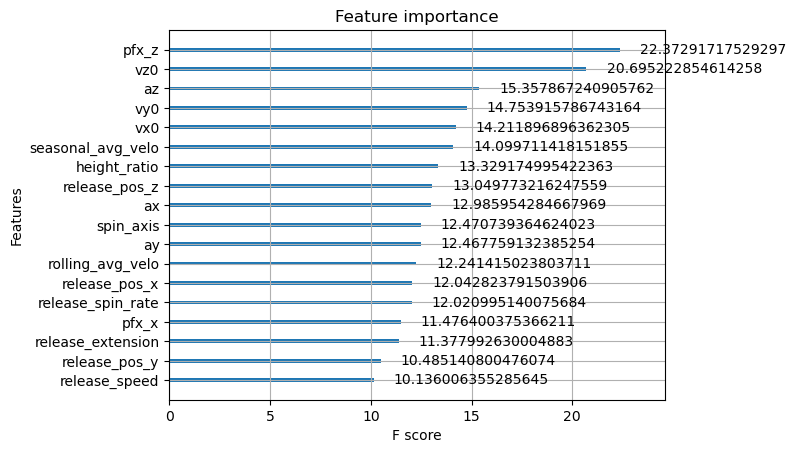

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

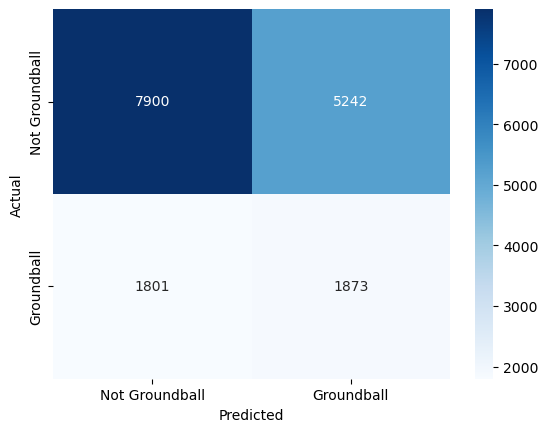

In [21]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Groundball', 'Groundball'], yticklabels=['Not Groundball', 'Groundball'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo', 'swing'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xgb'] = y_pred

In [26]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/gb_2022&3_xgb.csv")